In [47]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

from collections import Counter
from collections import defaultdict
from scipy.stats.stats import pearsonr

In [2]:
df1=pd.read_csv("credit.csv")

In [3]:
df_srm=df1.dropna(axis=0, how='all') #srm=senza righe mancanti;
df_srm.isnull().sum()

Loan ID                             0
Customer ID                         0
Loan Status                         0
Current Loan Amount                 0
Term                                0
Credit Score                    19154
Annual Income                   19154
Years in current job             4222
Home Ownership                      0
Purpose                             0
Monthly Debt                        0
Years of Credit History             0
Months since last delinquent    53141
Number of Open Accounts             0
Number of Credit Problems           0
Current Credit Balance              0
Maximum Open Credit                 2
Bankruptcies                      204
Tax Liens                          10
dtype: int64

In [4]:
df=df_srm.copy()
df.drop(df_srm.columns[[0,1,12]], axis="columns",  inplace=True) 

In [5]:
Ownership= df["Home Ownership"].replace ("HaveMortgage", "Home Mortgage")
Ownership.unique()
df["Home Ownership"]= Ownership
df["Home Ownership"].unique() #appare due volte Mortgage, quindi è stato sostituito cHave mortgage con home mortgage

df["Purpose"].unique() #apparte due volte il termine other, si deve sostituire
purpose=df["Purpose"].replace("other", "Other")  #sostituito
purpose.unique()
df["Purpose"]=purpose
df["Purpose"].unique()

array(['Home Improvements', 'Debt Consolidation', 'Buy House', 'Other',
       'Business Loan', 'Buy a Car', 'major_purchase', 'Take a Trip',
       'small_business', 'Medical Bills', 'wedding', 'vacation',
       'Educational Expenses', 'moving', 'renewable_energy'], dtype=object)

In [6]:
df.head()

Loan Status  Current Loan Amount        Term  Credit Score  Annual Income  \
0  Fully Paid             445412.0  Short Term         709.0      1167493.0   
1  Fully Paid             262328.0  Short Term           NaN            NaN   
2  Fully Paid           99999999.0  Short Term         741.0      2231892.0   
3  Fully Paid             347666.0   Long Term         721.0       806949.0   
4  Fully Paid             176220.0  Short Term           NaN            NaN   

  Years in current job Home Ownership             Purpose  Monthly Debt  \
0              8 years  Home Mortgage   Home Improvements       5214.74   
1            10+ years  Home Mortgage  Debt Consolidation      33295.98   
2              8 years       Own Home  Debt Consolidation      29200.53   
3              3 years       Own Home  Debt Consolidation       8741.90   
4              5 years           Rent  Debt Consolidation      20639.70   

   Years of Credit History  Number of Open Accounts  \
0                     17.2                      6.0   
1                     21.1                     35.0   
2                     14.9                     18.0   
3                     12.0                      9.0   
4                      6.1                     15.0   

   Number of Credit Problems  Current Credit Balance  Maximum Open Credit  \
0                        1.0                228190.0             416746.0   
1                        0.0                229976.0             850784.0   
2                        1.0                297996.0             750090.0   
3                        0.0                256329.0             386958.0   
4                        0.0                253460.0             427174.0   

   Bankruptcies  Tax Liens  
0           1.0        0.0  
1           0.0        0.0  
2           0.0        0.0  
3           0.0        0.0  
4           0.0        0.0

In [7]:
class_name = 'Loan Status'

In [8]:
def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df
df = remove_missing_values(df)

In [9]:
def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns
numeric_columns = get_numeric_columns(df)

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values
rdf = df.copy(deep=True)
df, feature_names, class_values = one_hot_encoding(df, class_name)
real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
features_map = get_features_map(feature_names, real_feature_names)

In [10]:
categorical = list(set(feature_names)-set(numeric_columns))

In [11]:
dft = df[categorical]

In [12]:
dft.head()

Home Ownership=Rent  Purpose=Medical Bills  Years in current job=7 years  \
0                    0                      0                             0   
1                    0                      0                             0   
2                    0                      0                             0   
3                    0                      0                             0   
4                    1                      0                             0   

   Years in current job=10+ years  Purpose=moving  \
0                               0               0   
1                               1               0   
2                               0               0   
3                               0               0   
4                               0               0   

   Purpose=Educational Expenses  Purpose=renewable_energy  \
0                             0                         0   
1                             0                         0   
2                             0                         0   
3                             0                         0   
4                             0                         0   

   Years in current job=2 years  Purpose=Buy a Car  Purpose=small_business  \
0                             0                  0                       0   
1                             0                  0                       0   
2                             0                  0                       0   
3                             0                  0                       0   
4                             0                  0                       0   

   ...  Years in current job=4 years  Purpose=vacation  \
0  ...                             0                 0   
1  ...                             0                 0   
2  ...                             0                 0   
3  ...                             0                 0   
4  ...                             0                 0   

   Purpose=Home Improvements  Home Ownership=Home Mortgage  Term=Short Term  \
0                          1                             1                1   
1                          0                             1                1   
2                          0                             0                1   
3                          0                             0                0   
4                          0                             0                1   

   Purpose=Buy House  Purpose=Debt Consolidation  \
0                  0                           0   
1                  0                           1   
2                  0                           1   
3                  0                           1   
4                  0                           1   

   Years in current job=< 1 year  Purpose=Take a Trip  Purpose=Other  
0                              0                    0              0  
1                              0                    0              0  
2                              0                    0              0  
3                              0                    0              0  
4                              0                    0              0  

[5 rows x 31 columns]

In [13]:
df_transactional = rdf[[c for c in rdf.columns if c not in numeric_columns ]]

In [14]:
df_transactional.head()

Term Years in current job Home Ownership             Purpose  \
0  Short Term              8 years  Home Mortgage   Home Improvements   
1  Short Term            10+ years  Home Mortgage  Debt Consolidation   
2  Short Term              8 years       Own Home  Debt Consolidation   
3   Long Term              3 years       Own Home  Debt Consolidation   
4  Short Term              5 years           Rent  Debt Consolidation   

  Loan Status  
0  Fully Paid  
1  Fully Paid  
2  Fully Paid  
3  Fully Paid  
4  Fully Paid

In [15]:
X1 = df_transactional.values

In [16]:
X2 = dft.values

# K-Modes

In [47]:
from kmodes.kmodes import KModes

In [66]:
km = KModes(n_clusters=2, init='Huang', n_init=5, verbose=1)

clusters = km.fit_predict(X1)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 145937.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 4233, cost: 128300.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 15603, cost: 144260.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 0, cost: 123079.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 0, cost: 144260.0
Best run was number 4


In [67]:
km.cluster_centroids_

array([['Short Term', '10+ years', 'Rent', 'Debt Consolidation'],
       ['Short Term', '10+ years', 'Home Mortgage', 'Debt Consolidation']],
      dtype='<U18')

In [68]:
# labello i dati per analizzare meglio

In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df_transf = df_transactional.apply(le.fit_transform)
df_transf.head()

Term  Years in current job  Home Ownership  Purpose  Loan Status
0     1                     8               0        5            1
1     1                     1               0        3            1
2     1                     8               1        3            1
3     0                     3               1        3            1
4     1                     5               2        3            1

In [20]:
# scelgo la k

In [71]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(df_transf)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 165273.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 141693.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1033, cost: 116564.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1033, cost: 112434.0


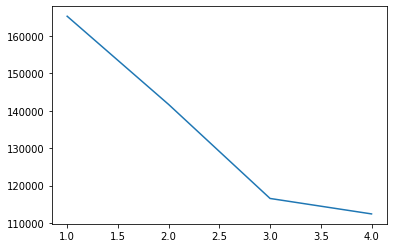

In [72]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [73]:
#scelgo k = 3

In [74]:
km_cao = KModes(n_clusters=3, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(df_transf)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 1033, cost: 116564.0


In [75]:
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([df_transactional, clustersDf], axis = 1).reset_index()
combinedDf = combinedDf.drop(['index'], axis = 1)

In [76]:
combinedDf.head()

Term Years in current job Home Ownership             Purpose  \
0  Short Term              8 years  Home Mortgage   Home Improvements   
1  Short Term            10+ years  Home Mortgage  Debt Consolidation   
2  Short Term              8 years       Own Home  Debt Consolidation   
3   Long Term              3 years       Own Home  Debt Consolidation   
4  Short Term              5 years           Rent  Debt Consolidation   

   cluster_predicted  
0                  0  
1                  0  
2                  0  
3                  1  
4                  2

#### Cluster analysis

In [77]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]
cluster_2 = combinedDf[combinedDf['cluster_predicted'] == 2]

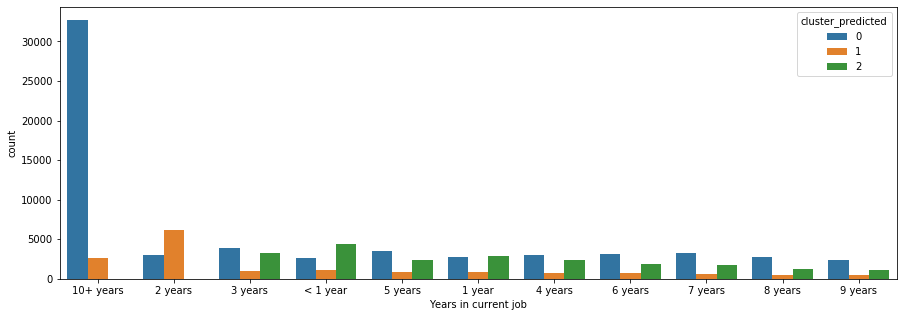

In [78]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['Years in current job'],order=combinedDf['Years in current job'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.show()

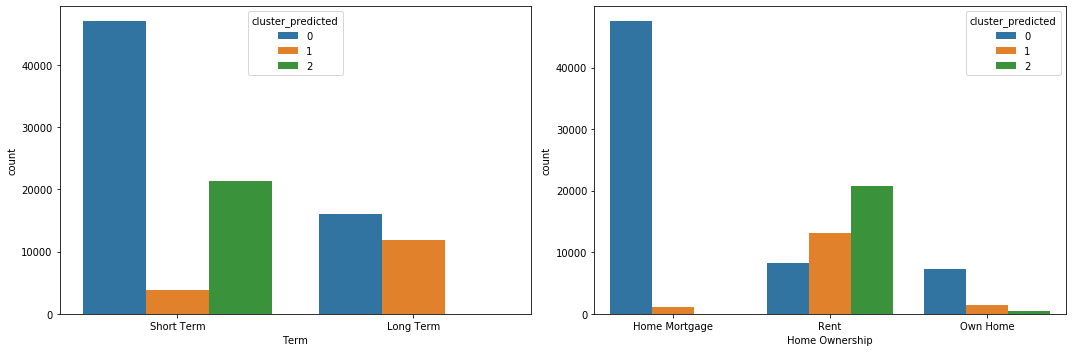

In [79]:
f, axs = plt.subplots(1,2,figsize = (15,5))
sns.countplot(x=combinedDf['Term'],order=combinedDf['Term'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['Home Ownership'],order=combinedDf['Home Ownership'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()


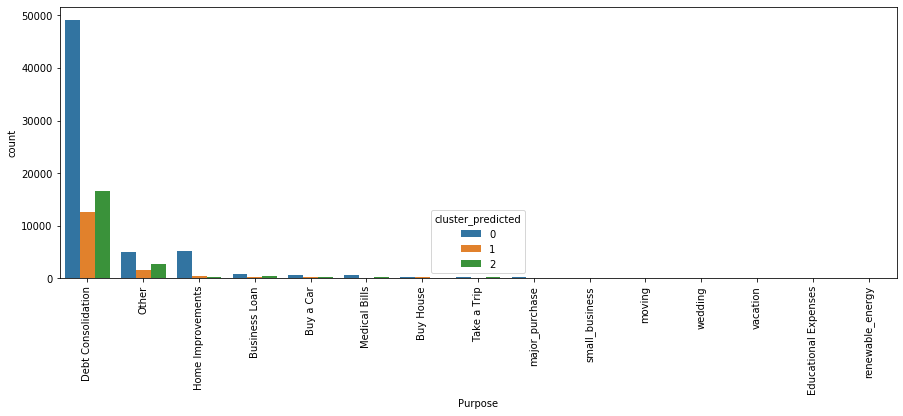

In [80]:
plt.subplots(figsize = (15,5))
sns.countplot(x=combinedDf['Purpose'],order=combinedDf['Purpose'].value_counts().index,hue=combinedDf['cluster_predicted'])
plt.xticks(rotation=90) 
plt.show()

# CLASSIFICATION

In [17]:
df = df_transf
df.head()

Term  Years in current job  Home Ownership  Purpose  Loan Status
0     1                     8               0        5            1
1     1                     1               0        3            1
2     1                     8               1        3            1
3     0                     3               1        3            1
4     1                     5               2        3            1

In [18]:
df[class_name].value_counts(),df[class_name].value_counts(normalize=True)

(1    77361
 0    22639
 Name: Loan Status, dtype: int64,
 1    0.77361
 0    0.22639
 Name: Loan Status, dtype: float64)

###### Partitioning

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from scikitplot.metrics import plot_lift_curve

In [20]:
attributes = [col for col in df.columns if col != 'Loan Status']
X = df[attributes].values
y = df['Loan Status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [21]:
X.shape

(100000, 4)

# Decision Tree

In [53]:
# grid search and cross validation

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score,RandomizedSearchCV

In [39]:
hyper_params_space={'max_depth': np.arange(1, 10),'min_samples_split': np.arange(2, 5),'min_samples_leaf': [1, 5, 10, 20, 30, 50, 100],'random_state': [0]}
tree= DecisionTreeClassifier()
search=GridSearchCV(tree,hyper_params_space)
search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
 

In [80]:
clf = search.best_estimator_
clf

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [57]:
for col, imp in zip(attributes, clf.feature_importances_):
    print(col, imp)

Term 0.644646544603096
Years in current job 0.029943437803149568
Home Ownership 0.22861626835237098
Purpose 0.09679374924138351


In [73]:
import pydotplus
from sklearn import tree
from IPython.display import Image

In [74]:
import os

os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

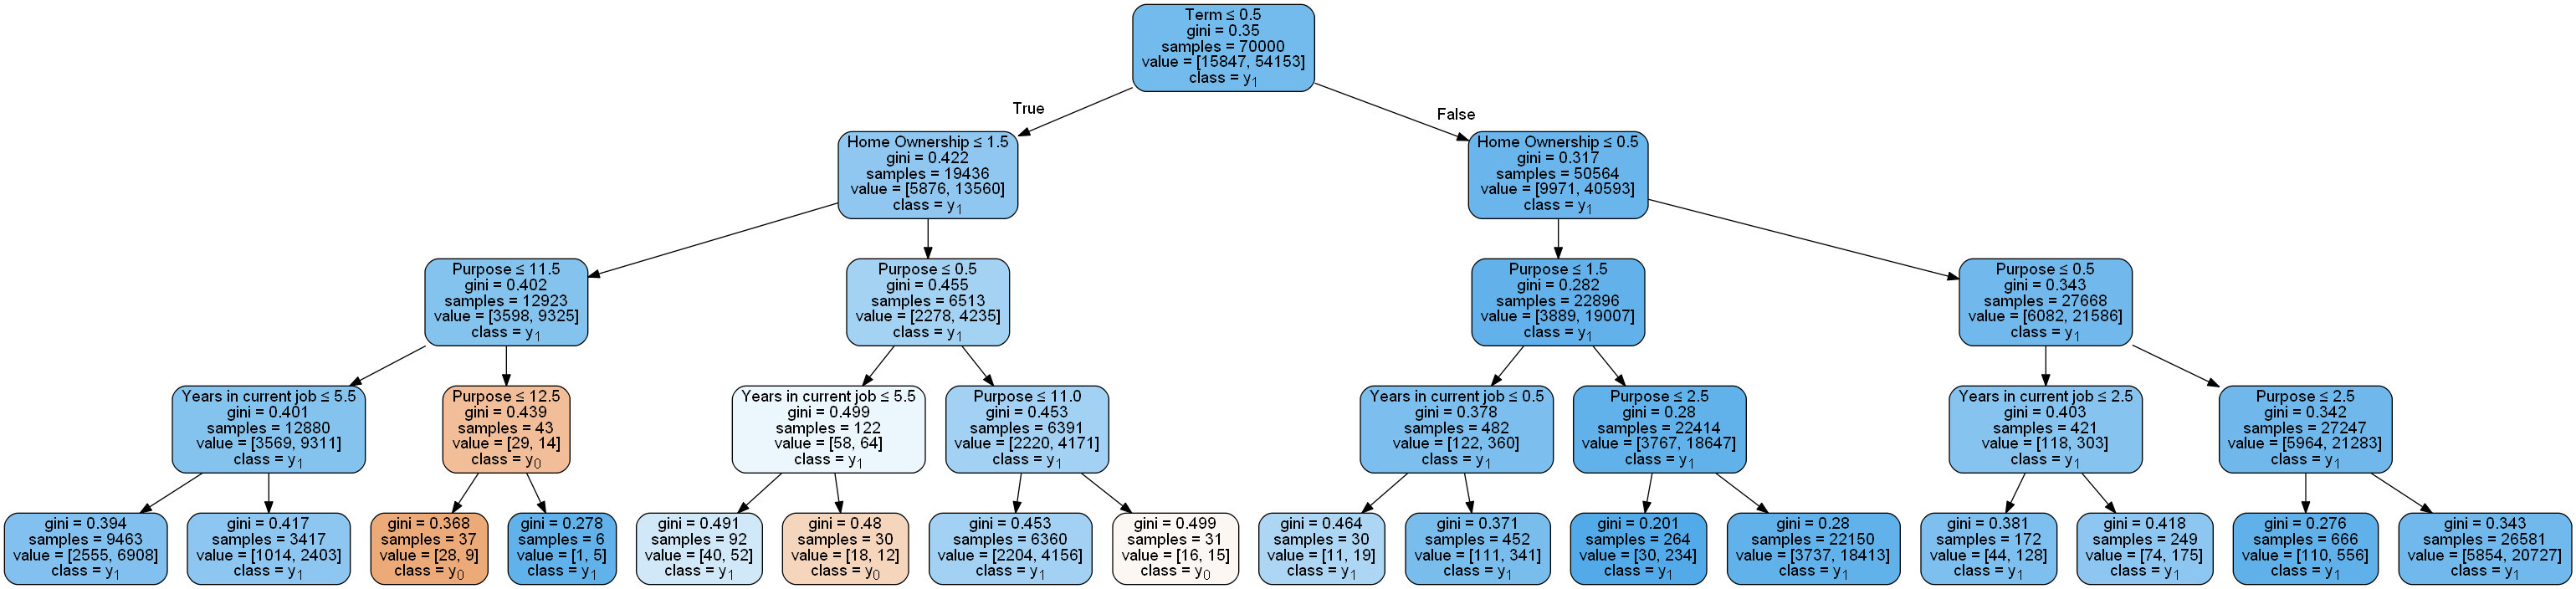

In [75]:
dot_data = tree.export_graphviz(clf, out_file=None,  
                                feature_names=attributes, 
                                class_names=True,  
                                filled=True, rounded=True,  
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAADAcAAALACAYAAABVOvoxAAAABmJLR0QA/wD/AP+gvaeTAAAgAElEQVR4nOzdfZSWZb03/C+YNwk2gryU3rNJGNPJQNyK3dOL4vZBQEQcUTc2lA65MVBKjZaVt3KvqJtdbWdricnGnbyIg26U0IANSjyOPOpkZAyaTuZIEvmCb0hqklt5/nDPxPA6IHAN8Pms5VpzHudxnNf3uNAFS47f+WuzYcOGDQEAAAAAAAAAAAAAAPZabQsdAAAAAAAAAAAAAAAA+GAUBwAAAAAAAAAAAAAAwF5OcQAAAAAAAAAAAAAAAOzlPlToAAAAAAAAe6O1a9fm8ccfz6uvvpr169cXOg7sVm3atMmhhx6aHj16pEePHoWOAwAAAAAAbIHiAAAAAACAFnriiScyffr03DNvfuqf+G2h40BBHNqla04fNDDnDx+ewYMHp21bTYoBAAAAAKA1aLNhw4YNhQ4BAAAAANCaPf3007ni6+My7+f3pMvfHZmSz5+Zv+vz+XT+eGk+/JFO+dD/aFfoiLBbbdjwXt7+89q8/vyzef7JZVn5y//MH36zND16luTaH/4gZ599dqEjAgAAAADAfk9xAAAAAADAVqxfvz7/5//8n/zrv16XTv+zR04a9d0c0ffUpE2bQkeDglv73Mo8NOOfU///zkn/0wbkpp/cmJKSkkLHAgAAAACA/ZbiAAAAAACALXj55ZcztPzsLK9bkc9c+L/TZ0hl2h7woULHglZn9eMPp+Yn387br/wpc382J/369St0JAAAAAAA2C8pDgAAAAAA2MSTTz6Z088YkjfeaZOzvnt7Ov3PnoWOBK3au++sz33XXZ6naubm5pun5MILLyx0JAAAAAAA2O8oDgAAAAAA2MhLL72UE/p+Om07/c8MGT89H/5Ip0JH2q2qBnRu0bxx976ym5MU1vo31+V3NXPzTO2iNNQuTEnZoJSeek56nNg/7ToUbXf9tr7Hff27a7JhQ2qrq1I7818yZ85dGTp0aKETAQAAAADAfkUPbAAAAACA//b2229n8BlnZsPBXXLW9+7Ige0OKnQk9pClP52QunlTm64bahc2FQmUT7htm2vXrVm9u+PtHdq0SdmIb2TDe+9m+PlfyCO/rE3v3r0LnQoAAAAAAPYbigMAAAAAAP7bN7/17Tz97B/zj9cv2m8KAzZ9q33jG/D3lbfdv/TM43n20Zr0PffSbc6pmzc1ZRXj0nvwBSnqVpx1a1bnkduvT928qXltdUM6FZds97P6XTxhm5+zv/jMF6/M68+tzJChZ+V3Tz6RD3/4w4WOBAAAAAAA+4W2hQ4AAAAAANAaPP744/nJT36SM66Zno90ObzQcfiAnn9yWRb/+BuZMbpfaqaM3/bc+keTJMf0H56ibsVJkqJuxekzpDJJ8uLTddtcv/a5lUmSbkce+wFT7yPatEn/y6/P2xsOzA9/+C+FTgMAAAAAAPsNxQEAAAAAAEnGfu2y9DpteD529PGFjrJXWLV8aRb/+BupGtA5c8ePyKrlSzebUzWgc6oGdM66Naszd/yIPDhtYrPxJGmoXdj0jIbahU1r6++f0zSv/v45Lcq0/s11aahdmLnjR6T6soFJkvIJt2XMf/xum+v+vGZ1kqR9p67Nxjsc+rEkySt/qG/R5/M3H2r34Zw0emL++fvfz5/+9KdCxwEAAAAAgP2C4gAAAAAAYL83f/781D5cm8+OvLrQUfYKD06bmNlXlqdu3tQk7x/wn31ledPh/009tmBGGmoXpvMRpc3GGw/yb/zzS888ngenTcz8iaOa5s2fOGqbBQLr1qxO/f1zMunsHnlswa0pPfWcjJpZl/5fuzYlZYPSvmOXbe6ntroqSdKuQ1Gz8cZ1jfe3Zs3TK5IkBxV1yooFM5qKGlYsmJH1b67b5tp92REn/EP+rs/n8r+vvqbQUQAAAAAAYL/woUIHAAAAAAAotB/dMClHnXJ2Djpk24fIeb9jQG11VcoqxqXveWPTrkNR1r+5LstmT0ptdVWOOnlouvbs1WxN5yNKM+7eVzZ71gv1j2bsz1amXYeirFq+NLOvLM+M0f1SVjFus/H5E0el9JRhW8x08xf7JEnOuOrmrc7ZE2aM7tfs+r7rr8gztYty+jdv2qzwYH/R+8x/yqzvXJBr/+WH6dLFf18AAAAAALA76RwAAAAAAOzXXn311fxi8X05qt/ZhY6yV/jj8qVJ0lQYkLz/xv2+541Nkjz7aM1ma7ofd/IWn/X35Rc3PaP7cSc1jW/87I3Ht2bUzLqccdXNmT9xVOaOH5H6++dk3ZrVO7CrD6ZmyvgkScWPFmXcva80/XPGVTenoXZhVv5q8R7L0tocccI/5MAPt8/cuXMLHQUAAAAAAPZ5OgcAAAAAAPu1X/ziF2nTpm3+7tjPFjrKXqG2uipJMunsHlu8XzNlfPqee2mzsfYdt/zG+K2N7+hb9ou6FaeoW3F6nNg/qx97KI8tuDXzJ45KnyEj0+PT/XNYad+tftausKWuCElSesqwzJ84KvVL7ipoR4NCatP2gBT3+Xzuve++/NM//VOh4wAAAAAAwD5N5wAAAAAAYL9WV1eXbkcclQMObFfoKHxA7ToUpaRsUMon3JaKHy1KkswdPyI3/ePR21xXVjEuSbL+zXXNxhuvG+/vrIbahR9o/d6uc49P5TfLVxQ6BgAAAAAA7PN0DgAAAAAA9mvPPfdcDjr0Y4WOsdfoM2Rk6uZNzdifrdzhN/zvSYd9sm8O+2Tf9BlSmWcfrdnm3M5HlCZJ3nrtpWZ7WvfiqiTJR7oVb3P93PEj0lC7cLPvpLG4oM+QkTu1h33FwV0OS91zfyp0DAAAAAAA2OfpHAAAAAAA7NfWr1+fAw9qvYfcW5ujTj4rSbJs9qS8tfblpvFVy5emakDnLLvzxkJF26KuPXul77mXbnNO5+5HJUmeWHxH1q1ZnSRZt2Z1nnrgniTJYaXHb3N96annJElW/mpxs/HG68bvbH/1of/x4bz5xp8LHQMAAAAAAPZ5OgcAAAAAAPu9tgccUOgIe43ux52Usopxqa2uSm11VbN7JWWDckz/4Xs8U9WAztudM+7eV7Z6r2vPXikpG7TFPfUZMjJde/ba4uc1PrPHif1TUjYo8yeOyvyJo5rNLasYl+7HndSifQAAAAAAAHwQigMAAAAAANghn6u8Kp2PKM3qFQ+lbt7UJMlpl1+XIz87OO07dilwup0z4Os/ytMPLcgztYvSULswJWWD0rNsYI7uV77dte06FOX0b96Ulb9anPold6WhdmH6DBmZo04+S2EAAAAAAACwx7TZsGHDhkKHAAAAAAAolBEjRuQ3L/w1g7/1b4WOAvukJ5fcmQXf/0r8dQQAAAAAAOxebQsdAAAAAAAAAAAAAAAA+GAUBwAAAAAAAAAAAAAAwF5OcQAAAAAAAAAAAAAAAOzlFAcAAAAAAAAAAAAAAMBe7kOFDgAAAAAAwN6lakDnJMm4e1/ZI+t21Po31+V3NXPzTO2iNNQuTEnZoJSeek56nNg/7ToUtXj9fddfkSQpqxiXY/oPT6fiks3mNu5pS3b3PgEAAAAAADamOAAAAAAAgH3K0p9OSN28qU3XDbULm4oEyifctt31//mDMWmoXdh0XVtdldrqqlwwuSZde/ZqGl+3ZvWuDQ4AAAAAAPABKA4AAAAAAGCH7Owb8ffEm/Rfeubx1M2bmrKKcek9+IIUdSvOujWr88jt16du3tS8trphix0AGtXfPycNtQtz2uXX5djBFyRJVi1fmtlXlqdu3rT0/9q1m63pd/GE9D330t22JwAAAAAAgJZoW+gAAAAAAACwqzxf/2iS5Jj+w1PUrThJUtStOH2GVCZJXny6bpvr65fclSQ5ul9501j3405KkmbdCJJk7XMrkyTdjjz2gwcHAAAAAAD4gHQOAAAAAACgSf39c1K/5K401C5MWcW4HNN/eG758qeT/O3N/1UDOm/xesx//C5PLL4jNVPGp6RsUEpPPSelpwxrevam67akcc62bGv9n9esTpK079S12XiHQz+WJHnlD/XbfHb5hNs2G2uoXZgkOeOqm7ebDQAAAAAAoFAUBwAAAAAAkCR5cNrE1FZXNV3XVlc1u96ee//1sqaD9A21C5t+3rhAYHdrzNuuQ1Gz8fYduzTd/1zlVS161rI7b0zNlPFJ3i8M2HQfa55ekSQ5qKhTViyYkfuuvyJJctrl1+XofuWbZQAAAAAAANidFAcAAAAAAJBVy5emtroqZRXj0nvwBSnqVpx1a1bnkduvT928qS16Rteen8rp37wp7ToUZdXypZl9ZXnql9y1Q8UB2+oKsKd1O/LY9Lt4QlaveCjzJ45KsuVChxmj+zW7vu/6K/JM7aKm7wIAAAAAAGBPUBwAAAAAAED+uHxpkjQVBiRJUbfinDBsTIuLA/6+/OKmw/DdjzspSZq6B+yNuh93Urofd1L6nntpViyYkfkTR6V9x65Ne2vsKlDxo0U57JN9m9bV3z8n8yeOyspfLd6jXRMAAAAAAID9m+IAAAAAAABSW12VJE2FAY06FZe0+BntO3b5wDmqBnTe7pxCdBc4ul957rv+ijw6Z3JTccDWcpSeMizzJ47a4a4JAAAAAAAAH0TbQgcAAAAAAIBdpaxiXJJk/Zvrmo03Xjfe31GNHRF2pBPC3tw1AQAAAAAA2PvoHAAAAAAAQMoqxqW2uirr1qxu1j1g3ZrVezTHB+0K0PmI0iTJW6+91HSgP0nWvbgqSfKRTTojbGru+BFpqF2YsT9b2Wz9W2tfTpL0GTJyu3MbCxE2ngsAAAAAALC76RwAAAAAAED+7riTkiSPLZjRVBCwbs3qPLZgRiFj7bDO3Y9Kkjyx+I5m+3jqgXuSJIeVHr/N9aWnnpMk+V3N3Kax9W+uyxOL70iSHHXyWZvNXfmrxc2e0Xi98VwAAAAAAIDdTecAAAAAAADS/biTmroH1FZXFTrOTuvas1dKygZtcR99hoxM1569mo1VDeic5G8dC0pPGZb6JXflvuuvyH3XX9FsblnFuHT/7yKKJOlxYv+UlA3K/ImjMn/iqG3OBQAAAAAA2N0UBwAAAAAAkCT5XOVV6XxEaeqX3JWG2oUpqxiXY/oPzy1f/nSho+2QAV//UZ5+aEGeqV2UhtqFKSkblJ5lA3N0v/IWrS+fcFvq75/T9D30GTIyR5181maH/dt1KMrp37wpK3+1eLtzAQAAAAAAdrc2GzZs2FDoEAAAAAAAhTJixIj85oW/ZvC3/q3QUVqtqgGd02fIyPT/2rWFjsJe6Mkld2bB978Sfx0BAAAAAAC7V9tCBwAAAAAAoPCqBnRO1YDOef7JZU1j699cl2V33pgkKT72s4WKBgAAAAAAQAt8qNABAAAAAAAovPIJt2Xu+BGpvmzgZvdKygalx4n9C5AKAAAAAACAllIcAAAAAABASsoG5bwfzs0fly9NbXVVkqTPkJEpPvaz6XFi/7TrUFTghAAAAAAAAGyL4gAAAAAAAJIk3Y87Kd2POymfq7yq0FEAAAAAAADYQYoDAAAAAADYJaoGdE6SjLv3lQIn2TGNubdl4z2tf3NdflczN8/ULkpD7cKUlA1K6annbLHDQmuYCwAAAAAA7B8UBwAAAAAAwDaUlA1qdr30pxNSN29q03VD7cKmA/rlE25rdXMBAAAAAID9g+IAAAAAAAD2a1vrdPDSM49nxuh+6XfxhGZjdfOmpqxiXHoPviBF3Yqzbs3qPHL79ambNzWvrW5Ip+KSVjMXAAAAAADYf7QtdAAAAAAAAGht3lr7cmaM7pfTLr+u2UH75+sfTZIc0394iroVJ0mKuhWnz5DKJMmLT9e1qrkAAAAAAMD+Q+cAAAAAAIBWZtXypXnqgbtTN29qkqSsYlyOOnlouvbs1WzeS888nmcfrUnNlPFJkpKyQSk99ZyUnjKsaU7VgM5J3n87fkPtwswdPyIlZYPSe/CXUlI2KElSf/+czJ84KklyxlU3b3X9pvN6nNg/7ToU7dB+SsoG5fhho9P9uJN2et+basy4LVvrDrA1v5k7JSVlg3Ls4Auajf95zeokSftOXZuNdzj0Y0mSV/5Q36rmAgAAAAAA+w+dAwAAAAAAWpGG2oWZfWV50wH5JKmtrsqM0f2yavnSZvNmjO7XVBjQODZ/4qjU3z9ni8+dO35Es59feubxPDhtYtOB/yTbXL/pvP/8wZjt7ufBaROb7adxfw9Om7hT+94TVi1fmtrqqhw/bPRm92qrq5Jks6KI9h27NLvfWuYCAAAAAAD7D50DAAAAAABakcYD/KNm1qWoW3GS5Pknl6X6soF56oG7m9643ziv4keLctgn+yZJ1q1ZnZu/2CfzJ45q9vb/JHmh/tGM/dnKtOtQlFXLl2b2leWZMbpfyirGbTa+pfWPLbi1KdO6Navz2IIZqa2uyqrlS7fYBSD52yH7sopx6Xve2LTrUJT1b67LstmTUltd1awrQEv3vSU72hVgex6dMzklZYO2+ZkAAAAAAACtjc4BAAAAAACtSEnZoCTJUw/cnVXLl2b9m+ty2Cf7Zty9r6T/165tmjfu3lcy7t5XcshhR+SlZx5PQ+3CPLZgxlaf+/flFze9aX7jQ++Nh/Y3Hd9Uv4snNB3aL+pWnN6DL2jKuTV//O83/m/8Ge06FKXveWOTJM8+WrPD+97dnn9yWRpqF6b34C/tsc8EAAAAAADYFXQOAAAAAABoRT5X+e001C5MzZTxSd4/NH/8sNFbPLj/4LSJqa2uatFz23fsssXxxkP729OpuKTZdWOhQN28qVs9vN+YbdLZPbZ4v2bK+PQ999IkO7bvTVUN6LzdOS3tLvDb+25PkhT3/myL5gMAAAAAALQWOgcAAAAAALQiXXv2yrh7X8kFk2vS7+IJaahdmNlXlmfu+BF56ZnHm+atWDAjtdVV6TNkZM774dxcMLkmY/7jdwVM/sG0dN+701trX07dvKkpqxi31aKJsopxSZL1b65rNt543Xi/tcwFAAAAAAD2HzoHAAAAAAC0Ql179krXnr1y1MlnZe1zKzP7yvI01C5segP+fddfkSTN3tq/6WHxXWndmtVN3QKS5LXVDUm2fRC9z5CRqZs3NWN/trLFHQq2t+8taWlXgO15/fk/JEk+Vnr8Vud0PqI0SfLWay8129O6F1clST6y0XfUGuYCAAAAAAD7D50DAAAAAABakcU//kaqBnTO808uS5IUdStOx8N7bHV+4yH99W+uy7LZk3ZbrscWzMi6NauTvF8o8MTiO5Ikf3fcSVtdc9TJZyVJls2elLfWvtw0vmr50lQN6Jxld97YNLaj+94dXlr5RJLk0OJPbHVO5+5HJUmeWHxHs+/jqQfuSZIctlFhQWuYCwAAAAAA7D90DgAAAAAAaEU+ddr5qZs3NdWXDdzs3mmXX9f08xlX3Zz5E0flli9/eovPeW11QzoVl+zSbDd/sU+z67KKcem+jeKA7sedlLKKcamtrkptdVWzeyVlg3JM/+FN1y3d9+605ukVSZJ2Bx+y1Tlde/ZKSdmgLe6pz5CR6dqzV6uaCwAAAAAA7D8UBwAAAAAAtCKHfbJvLphck6ceuKfp4HdZxbh8rPT4lJQNappXesqw/PWtN3Lf9Vc0zTmm//D811//khmj++WPKx7cpcUBn6u8Ku0OPiQ1U8anpGxQjh82epuFARuv63xEaVaveCh186Ymef+w/5GfHZz2Hbvs8L53p8Z8G+fakgFf/1GefmhBnqldlIbahSkpG5SeZQNzdL/yVjkXAAAAAADYP7TZsGHDhkKHAAAAAAAolBEjRuQ3L/w1g7/1b4WO0ipVDeicJBl37ysFTsLe6skld2bB978Sfx0BAAAAAAC7V9tCBwAAAAAAAAAAAAAAAD4YxQEAAAAAAAAAAAAAALCXUxwAAAAAAAAAAAAAAAB7uQ8VOgAAAAAAwP6sakDnJMm4e18pcJIt21quxtzbmtdQuzBzx49o8TO29bz1b67Lyl8tTv2Su9JQuzAlZYNSeuo56XFi/7TrULTNPbz0zOOZMbrfZs/c1udvLUdL7Mi+NrW1rJva1d/t72rm5r7rr0iSlFWMyzH9h6dTcclWn9da/30FAAAAAID9meIAAAAAAAB2uZeeeTxzx4/Y6v11a1a3+FlvrX059/7rZWmoXdg01lC7sKlIYMDXf5T2Hbtsde2M0f1aHnwjJWWDdnjNjuxrUy3Nuiu/2yT5zx+Mafbd1lZXpba6KhdMrknXnr126FkAAAAAAEDhKA4AAAAAAGCnbekN8s8/uSzVlw1s0fp+F09I33Mv3eacpx9akIbahTnjqptTesqwpvH6++dk/sRRefqhBTl28AVbXPvQjO/vUPbkb2/v73fxhBbsYMtasq9NbStro1393dbfPycNtQtz2uXXNX2Hq5Yvzewry1M3b1r6f+3aJH/7rlrSbQEAAAAAACiMtoUOAAAAAADAvmPZnTem+rKBOeOqm7c5b+1zK5Mk3Y48drvPvO/6K5KkWWHAxteN97eU5Y2Xn9/u8zfW+Pb+0y6/Lp2KS3ZobbJj+9pYS7Luju+2fsldSZKj+5U3jXU/7qQkSd28qdtdDwAAAAAAtB46BwAAAAAA7ICqAZ3TZ8jIpjeqb2zxj7+RunlTM/ZnK9OuQ1FeeubxPPtoTWqmjE+SlJQNSump52x2yH3T5yebv9V+a+Orli/NUw/cnbp5U1NSNijHDxvddLh7e/vYnq29WX9baqaMT/mE21JSNijzJ47a4fVbUlI2KA21C7d5f1Orli9NzZTxuWByzTbXbuo3c6ekpGzQVjsR7A4tzbo7vtvyCbdtNtaYYXtFCAAAAAAAQOuicwAAAAAAwA7od/GE1M2bmrfWvtxs/K21L6du3tT0u3hC2nUoSkPtwswY3a+pMCB5/9D1/ImjUn//nF2S5cFpEzP7yvKmN7w31C7M7CvL8+C0ibvk+Ttj3L2vbPGw/qbWPL0iSXJQUaesWDAjVQM6p2pA56xYMCPr31zXbG7vwV9Kks2+t8brxvuNXlvdkNlXlueMq25O1569Wpx91fKlqa2uyvHDRrd4zaZ2ZF87mnV3fLcbW3bnjaka0Dlzx4/IGVfdvM0iFgAAAAAAoPXROQAAAAAAYAd8/Ph+SZJVyx9odnh61fIHkvztLfZzx49IklT8aFEO+2TfJMm6Natz8xf7ZP7EUR/44HXjQfayinHpe97YtOtQlPVvrsuy2ZNSW12Vo04eus3D5jvTFWB3mDG6X7Pr+66/Is/ULsrp37wp7ToUJXn/Oz3vh3Pz6JzJzd6Y3zi+caeE9W+uS82U8SmrGLfD3/GjcyanpGxQizovbE9L9vVBsu6qDBvrduSx6XfxhKxe8VDT96xAAAAAAAAA9h6KAwAAAAAAdkDXnr1SUjYo9UvuanZwun7JXekzZGQ6FZck+dvh+7fWvpyXnnk869aszgv1j+6yHH9cvjRJmgoDkqRdh6L0PW9saqur8uyjNTv01vw9rbGjwsbFE8n73QDmTxyVlb9a3Oz7XfP0ijTULmz2jIbahelZNrDZYf5lsyeloXZhBnz9RzuU5/knl6WhdmHKJ9y2M9tpsiP72tmsuzLDxrofd1K6H3dS+p57aVYsmJH5E0elfceuu6RYAgAAAAAA2P0UBwAAAAAA7KDjh43O7CvL89rqhnQqLslrqxvSULsw5/1wbrN5D06bmNrqqt2SofG5k87uscX7NVPGp++5l251fdWAztv9jN3ZXWBrzy49ZVjmTxzVrPii/v45qZkyPmdcdXPzgoz/Puz+P9ofnNJThqX+/jmpra5KxY8WpX3HLjuU57f33Z4kKe792Z3c0ftauq8PknVXZdiWo/uV577rr8ijcyYrDgAAAAAAgL2E4gAAAAAAgB300U/0SZL8ccWD6VRckhefrms2niQrFsxIbXVV+gwZmaNOPisHFXVKh0M/lpv+8eiCZN7bbNwlYP7EUUmy2YH2TQ+7N86rvmzgFp/ZWBCx6eH5t9a+nLp5U1NWMa6pC8Pu0rivnc26KzNsS+P30JK5AAAAAABA66A4AAAAAABgB7XrUJTTLr8u911/RY787ODMnzgqp11+XbOD5fddf0WSpP/Xrm0aW//mup36vLfWvrzZWJ8hI1M3b2rG/mzlTh1o351dAVpi7vgRaahduFn+xu+oz5CRLX7WBz3A/vrzf0iSfKz0+A/0nGTX7mtPZNja3MZ/5/ZEXgAAAAAAYNdoW+gAAAAAAAB7o7879nNJ0tQJ4Ii+p25x3murG5K8fzB72exJ231uSdmgJMnzTy5rWvebuVM2m3fUyWclSZbNntSseGDV8qWpGtA5y+68saVbKYjSU89Jkqz81eJm443XjftLkn4XT0jy/t42LrCov39Os/vj7n1li/802vS60Usrn0iSHFr8iT22r53NuiszbDz3dzVzm8bWv7kuTyy+Y7O5AAAAAABA66ZzAAAAAADATuhUXNL09v4+Q0amqFtxs/tnXHVz5k8clVu+/Oktrn9tdUM6FZdsNl566jlpqF2Y6ssGNo01Hn7fWPfjTkpZxbjUVleltrqq2b2SskE5pv/wndnWHtPjxP4pKRuU+RNHZf7EUc3ulVWMS/fjTmq6Pqb/8Kxe8VBmX1m+2XN2xV7XPL0iSdLu4EO2OqdqQOck2++4sCP72l12JEPpKcNSv+Su3Hf9FU3dLvZ0XgAAAAAAYNdQHAAAAAAAsJOOOvms1M2bmk+ddv5m90pPGZa/vvVG04HrsopxOab/8PzXX/+SGaP75Y8rHtxyccApw5Ik9UvuSkPtwpx2+XU5dvAFqZkyfrO5n6u8Kp2PKM3qFQ+lbt7UJMlpl1+XIz87OO07dtmVW93l2nUoyunfvCkrf7W4aa99hozMUSeftdmB9PYdu2w2t6RsUEpPPSc9Tuyfdh2KPlCWxu9uV3xnO7Kv3WVHM5RPuC31988pWF4AAAAAAGDXaLNhw4YNhQ4BAAAAAFAoI0aMyG9e+JQXCTUAACAASURBVGsGf+vfCh1lr9LSN+nvS6oGdN6v9rslO/Pr/uSSO7Pg+1+Jv44AAAAAAIDdq22hAwAAAAAAQGv3/JPLctrl1xU6BgAAAAAAwFZ9qNABAAAAAADYe+0vHQT+9Ntfpu+5lxY6RsE0/joDAAAAAACtl84BAAAAAACwHftzYQAAAAAAALB30DkAAAAAAIAdtq93CqA5v94AAAAAAND66RwAAAAAAMBOqRrQOVUDOhc6BgAAAAAAAFEcAAAAAAAAAAAAAAAAez3FAQAAAAAAAAAAAAAAsJdTHAAAAAAAAAAAAAAAAHu5DxU6AAAAAAAArc/6N9dl5a8Wp37JXWmoXZg+Q0bmhGFj0qm4ZJvrXnrm8Tz7aE1qpoxPkpSUDUrpqeek9JRhzeatWr40Tz1wd+rmTU2SlFWMy1EnD03Xnr12at6mqgZ03u4ex937yhbH544fkYO7HJb+X7u22fj6N9dl0tk90mfIyM3uAQAAAAAAFJriAAAAAAAANvOfPxiThtqFTdd186ambt7UXDC5ZqsH8xtqF2bu+BGbjTU+p7FAYEvzaqurUltdlfN+ODfdjztph+btascPG53ZV5anz5DKZnt9ddVTSZIen+6/Wz4XAAAAAADgg1AcAAAAAABAM40H+ssqxqXveWPTrkNR6u+fk/kTR6Vu3rStvjW/8SB/xY8W5bBP9k2SrFuzOjd/sU/mTxzVVBzQOG/UzLoUdStOkjz/5LJUXzYwTz1wd9Oh/5bO25KtdQVoie7HnZSSskF56oF7mhUH/Om3v0ySHFr8iZ1+NgAAAAAAwO6iOAAAAAAAgGZWPrI4SfL35RenXYeiJO+/9b/xcP/WNB7If2vty3npmcezbs3qvFD/6GbzSsoGpaF2YZ564O50O/LYfPQTfXLYJ/tudqC/pfN2h8buAb0HX9BUmFAzZXxKygalU3HJFtdUDei8R7IBAAAAAABsieIAAAAAAGC/9+5f3y50hFalbt7UJEn7jl12eO2D0yamtrpqm3M+V/ntNNQuTM2U8UneLwI4ftjozToBtHTellQN6LzdOds6yP+37gF3p++5l+alZx5PkvQsG7jTn7c/a3vAAYWOAAAAAAAA+zzFAQAAAADAfu0jH/lI3nnrT4WOsU9YsWBGaqur0mfIyBx18lk5qKhTOhz6sdz0j0c3m9e1Z6+Mu/eVvPTM43n20ZrUTBmfhtqFKSkblM9Vfjtde/baoXm7S+/BX8rc8SNyTP/heWXVU0mSw0qP32xeY8cABQJbtv7N11N0SMdCxwAAAAAAgH2e4gAAAAAAYL9WUlKStXfPL3SMVqXPkJGpmzc1b619eYe6B9x3/RVJkv5fu7ZpbP2b67Y6v2vPXunas1eOOvmsrH1uZWZfWZ6G2oWbvdG/pfM2tq17LVXc+7NJklXLH0j9kruasmyssTCArVv73B9S0rOk0DEAAAAAAGCf17bQAQAAAAAACunEE0/May+szltrXy50lFaj+Nj3D8X/Zu6UpsP99ffPSdWAzln8429sd/1rqxuSvF8YsGz2pM3uL/7xN1I1oHOef3JZkqSoW3E6Ht5jp+ftLu06FOWMq27O/Imj0lC7MGUV4zabozBg+15+ui7/69N9Cx0DAAAAAAD2eToHAAAAAAD7tc997nP5SNEhWfnIffnUgC8UOk6rUHrKsNQvuSu11VWpra5qdq/PkMqtrms8SH/Llz+9xfuvrW5Ip+KSfOq081M3b2qqLxu42ZzTLr+u6eeWztudepzYv+nnnv9rwB75zH3J22+szerfPpIzJl5V6CgAAAAAALDP0zkAAAAAANivHXjggfniF0ekfvGsQkdpVU7/5k3NDuCXVYzLl295JF179trqmtJThm1xzQWTa5Ikf1zxYJLksE/2zQWTa5q9ib+sYlzKJ9yWYwdf0DTW0nm7U7sORU0/H3LYEXvkM/cl9UvuSpcuXXP00Ufn1VdfLXQcAAAAAADYp7XZsGHDhkKHAAAAAAAopKeffjrHfKpXzvuXe3LYJ/sWOg6tyGurG3LLlz+dPkNGpv/Xrt3m3KoBnTPu3lf2ULLW79131ue2r3w+37ri0qxYsSK33357hg4dmsrKygwcODAHHHBAoSMCAAAAAMA+RecAAAAAAGC/d+SRR+ayy76WB276VjZseK/QcWhFnlh8R5Kkz5DKwgbZC/16zk0pOuhD+epXv5obbrghkydPzosvvpghQ4ake/fu+frXv57HHnus0DEBAAAAAGCfoXMAAAAAAECSdevWpeQTR6fXsK/mhGGjCx2HAqsa0Lnp57KKcflc5VUtWqNzwPte/ePvM+ur/0/u/I87csYZZzS719DQkOnTp2fGjBl59tlnc8IJJ6SysjIVFRU59NBDC5QYAAAAAAD2fjoHAAAAAAAkKSoqyk8m/TgP3Dw+Kx+5r9BxKLCSskFJkn4XT2hRYQB/85fXX87P/09FTj/99M0KA5KkpKQkEyZMyMqVK1NTU5PevXvn29/+dg4//PCUl5fn7rvvzjvvvFOA5AAAAAAAsHfTOQAAAAAAYCPf+va38+NJP8l51/48XXv2KnQc9iI6ByT/tf7tzL36vBz83ht5pPbhtG/fvkXr3njjjdx5552ZPn16HnjggXTp0iUjRozIyJEj07t3792cGgAAAAAA9g2KAwAAAACA/dILL7yQKVOm5LnnnsvkyZObxjds2JBzzj0vC++9L4P/9y054oR/KGBK2Hu8+eqa/Pw7X8x7r7+YR375cIqLi3fqOatWrcr06dMzffr0NDQ0pHfv3hk5cmRGjBiRbt267eLUAAAAAACw72hb6AAAAAAAAHvSww8/nBEjRuTjH/94brjhhnTu3LnZ/TZt2uSO22el4vx/zNyrz8/ye36aeMcKbNOahsdy+2Wn5SN5Ow/+fw/sdGFAknTv3j3XXHNNfv/736empiYnnnhivvOd76S4uDjl5eW5++67s379+l2YHgAAAAAA9g06BwAAAAAA+7y33347s2bNyqRJk/Loo4+mb9++GTt2bIYPH54Pf/jDW133L//yL/nWt76V4l5l6Tf6/6bbkcfuwdTQ+q1/4/U8NOOfU/fzqfmHU0/NnbP/I4cccsgu/5y//OUvmTNnTqZNm5YlS5akY8eOqaioSGVlZU444YRd/nkAAAAAALA3UhwAAAAAAOyz/vCHP+Smm27KLbfckj//+c8555xz8tWvfjVlZWUtfsavf/3rXHLp2PzqV4/kU/2H5+/LL1YkwH7vrbUv5/GFM/PonJ/kwx9qmx/+4PuprKxM27a7v2HxqlWrcuutt2bmzJmpr69P7969M3LkyAwfPjyHH374bv98AAAAAABorRQHAAAAAAD7lA0bNuQXv/hFbrzxxvz85z/Pxz72sYwePTqjRo3KRz/60Z1+5qxZs/J///n7eeLxx9KluGcOP/bzObT70TnoI53yoXZb7z4A+4L33ns36/+8Nmuf/0PWPPVoVj/+SIo6dszoi0flm9/8Zjp27FiQXA8//HCmTZuWO+64I2+88UYGDhyYysrKDB06NO3atStIJgAAAAAAKBTFAQAAAADAPuHPf/5zZsyYkUmTJqW+vj79+vXLpZdemvLy8hx44IG77HN+/etfZ8GCBal5YGl++9sn8tqrr2T9+rd32fOhNWrbtm2KOnZKz54lKft035x++unp379/Pvzh1lEY85e//CVz587NzJkzs2jRohxyyCGpqKhIRUVFPvOZzxQ6HgAAAAAA7BGKAwAAAACAvVp9fX0mTZqUW2+9Ne+++24qKioyduzYHHvssYWOBhTAc889l1tvvTXTpk1LfX19SktLU1lZmS996Us5/PDDCx0PAAAAAAB2G8UBAAAAAMBe59133838+fMzadKkLF68OD179swll1ySL3/5y+nYsWOh4wGtxC9/+cvMnDkz1dXVef311zNw4MBUVFRk2LBhOeiggwodDwAAAAAAdinFAQAAAADAXuOVV17JT3/609x0001ZtWpVBg4cmLFjx2bQoEFp27ZtoeMBrdT69etzzz33ZNq0aVm0aFEOPvjgDB8+PJWVlfnMZz5T6HgAAAAAALBLKA4AAAAAAFq9Rx99NDfeeGNmzZqVdu3apbKyMpdcckk+8YlPFDoasJd54YUXMmvWrEydOjWPPfZYSktLU1FRkQsvvDDdu3cvdDwAAAAAANhpigMAAAAAgFbpr3/9a+bMmZMbbrghDz30UHr16pWxY8fmi1/8Yjp06FDoeMA+4Ne//nWmTZuW6urqrF27NqeeemoqKyszbNiwHHTQQYWOBwAAAAAAO0RxAAAAAADQqjz//POZPHlypkyZkpdffjnl5eW59NJLc8oppxQ6GrCPeuedd7JgwYJMnTo1CxYsSPv27XP22Wdn5MiROemkk9KmTZtCRwQAAAAAgO1SHAAAAAAAtApLly7NjTfemDlz5uTQQw/NRRddlDFjxqS4uLjQ0YD9yJo1a3Lbbbdl+vTpqaurS0lJSS688MJceOGF6d69e6HjAQAAAADAVikOAAAAAAAK5q233sqsWbMyadKkLF++PJ/+9Kfz1a9+Needd17atWtX6HjAfu6xxx7L1KlTc9ttt+Xll1/O5z//+YwcOTLnnntuDj744ELHAwAAAACAZhQHAAAAAAB73MqVK/OTn/wkP/3pT/PWW2/l/PPPz6WXXpoTTzyx0NEANvPOO+9kwYIFmT59ehYsWJADDzww5557bkaOHJnPf/7zadu2baEjAgAAAACA4gAAAAAAYM/YsGFD7r333kyaNCkLFixIcXFxvvKVr2TUqFHp2rVroeMBtMirr76a6urqTJs2Lb/+9a/TvXv3XHjhhbnwwgtTUlJS6HgAAAAAAOzHFAcAAAAAALvV66+/nunTp+fGG2/MU089lX/4h3/I2LFjc9ZZZ+WAAw4odDyAnfbYY49l+vTpmTVrVp5//vmcdNJJGTlyZM4+++wccsghhY4HAAAAAMB+RnEAAAAAALBbPPHEE5k0aVJuvfXWJMmXvvSljB07Nsccc0yBkwHsWu+++24WLVqUadOm5Z577knbtm0zbNiwVFZW5tRTT03btm0LHREAAAAAgP2A4gAAAAAA9hlt2rRp0Tz/S2z3effdd3P33Xdn0qRJuf/++/OJT3wil1xySSorK71FG9gvvPrqq7n99tszc+bMPPzww+nevXsuvPDCVFRUpLS0tNDxAAAAAADYhykOAAAAAGCfoTigcF566aX8+7//eyZPnpzVq1fn9NNPz1e/+tUMGDCgxb8uAPua+vr6TJs2Lbfeemuee+65fOYzn0llZWWGDx+uYAoAAAAAgF1OcQAAAAAA+6zGQ+n+F9jus2zZskyaNCm333572rdvn4suuihjxoxJz549Cx0NoNV49913c99992XmzJmZM2dOkmTYsGGpqKjIwIEDc8ABBxQ4IQAAAAAA+wLFAQAAAADssxQH7B7r16/P7Nmzc8MNN+SRRx7Jcccdl0suuSQjRoxI+/btCx0PoFV7/fXXc8cdd2TatGl5+OGHc/jhh+dLX/pSKisrU1paWuh4AAAAAADsxdoWOgAAAAAAFEqbNm3Spk2brFq1KkOHDs0111zTbHxr8ze1ZMmSjBkzJm3atMnQoUOzZMmS3Z69EFavXp2rr746H//4x/PlL385RxxxRB544IH85je/yahRoxQGALTAIYcckosvvjgPPfRQfve73+Wiiy7KrFmz8slPfjKf/exnM2nSpLz66quFjgkAAAAAwF5I5wAAAAAA9lnb6xzQeP/qq6/O9773vcyaNSvnn3/+Vtdtafyaa67J9773vc2effXVV+e73/3uB99EK1BTU5NJkyZl7ty56dKlSy6++OJ85StfyeGHH17oaAD7hPfeey9LlizJtGnTMmfOnLz33nsZOnRoKisrM3DgwBxwwAGFjggAAAAAwF5A5wAAAAAA9nuf+tSnsmHDhpx//vk7tG7JkiX53ve+l6uvvjpr167Nhg0bsnbt2qZig7q6ut2UePd7880382//9m859thjc8opp+S5557L9OnT8+yzz+Y73/mOwgCAXaht27bp379/Zs6cmRdffDGTJ0/Oiy++mCFDhqR79+75+te/nscee6zQMQEAAAAAaOV0DgAAAABgn9XSzgEvvvhiunXrtt11m443dg1Yu3ZtDjnkkKZ5r7/+ejp27Jhrr70248aN20W72TN+//vfZ/Lkybnlllvy9ttv5wtf+ELGjh2b448/vtDRAPY7DQ0NmT59embMmJFnn302J5xwQiorK1NRUZFDDz200PEKpvH3423Z0b/+2t6fGQAAAAAA9gaKAwAAAADYZ7W0OGB7RQBbG98dhxML4b333suiRYtyww03ZNGiRenevXvGjBmTiy66KJ07dy50PID93oYNG7J06dJMnTo1d955Z955550MGjQoI0eOzODBg3PggQcWOuIepTgAAAAAAGDLFAcAAAAAsM9SHLBta9euzS233JKbbropDQ0N6d+/fy655JKceeaZOeCAAwodD4AteOONN3LnnXdm+vTpeeCBB9KlS5eMGDEiI0eOTO/evQsdb4/YHQf5FQcAAAAAAPsCxQEAAAAA7LN2ZXHAmjVr8tGPfrTZ+JgxYzJ58uSsXbs2hxxyyK4NvxutWLEiP/nJTzJz5sy0bds2F1xwQcaOHZvS0tJCRwNgB6xatSrTp0/P9OnT09DQkN69e2fkyJEZMWJEunXrVuh4u43iAAAAAACALWtb6AAAAAAA0NqceeaZSZLa2tokyeuvv54bbrhhs3nnnXdekuTaa6/NmjVrmsaXLFmSNm3apKqqag+kbZn/+q//yp133plTTjklffr0SU1NTX7wgx/kT3/6UyZNmqQwAGAv1L1791xzzTX5/e9/n5qampx44on5zne+k+Li4pSXl+fuu+/O+vXrCx2z4Orq6lJVVZU2bdqkTZs2GTp0aG6//fbtrluyZEnGjBnTtO6aa65JXV3dducOHTo0S5Ys2dXbAAAAAADYLp0DAAAAANhn7WzngNtvvz1f+MIXmo1de+21+cY3vrHZ/GuuuSbf+973Nnv2mWeemX//938v+JubX3zxxdx8882ZPHlyXnjhhZx55pm55JJL0r9//6b9A7Dv+Mtf/pI5c+Zk2rRpWbJkSTp27JiKiopUVlbmhBNOKHS8XWJH3vL/85//PEOHDt3ivVmzZuX888/f4jO3te4Xv/hFTj311Kbrrf1Z4Oqrr853v/vd7WYEAAAAANhVFAcAAAAAsM/a2eKA5P0Cgerq6vz85z/PlClTMmrUqG0WE9TU1GTy5MlJkilTpuSss84qaGFAbW1tbrzxxsyePTsHH3xwLrrooowZMyZHHHFEwTIBsGetWrUqt956a2bOnJn6+vr07t07I0eOzPDhw3P44YcXOt5O215x28a/TzfOffjhh1NWVpbk/e/l4x//eLO5m/4e33j97P/P3r3HZVXlexz/6nhNDoIjmZdRHMFUNDNJwtAo4yIeNXVUBm+gRaVSiTHdHD3azQ5FdjCaTAO8RTZo2IRc0kgYFcPU8vGGJjpIo3gSGRxvqecPzrPjgYer4OPl8369eA1777XW/q297TXb+v3WOnpUnTt3llT6/62enp566qmn9MEHH0gq3TFgyJAhmjNnjp5//nm1bt1aZ86c0dtvv63XXntNu3btUt++fetl3gAAAAAAAABQHYoDAAAAAAAAgFvEhQsXlJCQoMWLFysnJ0f33XefZs6cqT/+8Y9q0aKFrcMDANjQ1q1bFRcXp08//VQlJSXy8/NTcHCwRowYoebNm9s6vFqpTXGA2cmTJ/XTTz/p2LFj2r59u7HSf2XFASNGjNAXX3yht99+W/369VP//v3VunXrCuOadw0oKiqyuH7mzBk5ODjo7bff1uzZs+s2UQAAAAAAAACoJYoDAAAAAAAAgJvcsWPH9MEHH2jp0qUqLi7WH/7wB82YMUMDBw60dWgAgBvMuXPn9Pnnn2vlypVKTU1V69atFRQUpKCgIHl6eto6vBqpbmeg8swJ/NZUVhywe/du3XvvvUa74cOH67nnntMjjzxiNZaq8J/iAAAAAAAAAFwvFAcAAAAAAAAAN6GrV69q06ZNiomJUVJSku6880499dRTCg0N1V133WXr8AAAN4GCggKtWLFCcXFx2r9/v3r06KHg4GBNmjRJHTp0sHV4lapNccBHH32k0NBQPfXUUxo7dqx++9vfqn379mrXrp3FGJWNuXv3bn311Vd6/vnnJZUWCbz66qvq27evRb+q8J/iAAAAAAAAAFwvFAcAAAAAAAAAN5GSkhKtWLFCixcv1t69ezVo0CDNnDlTo0aNUtOmTW0dHgDgJpWdna2VK1dq9erVOnPmjPz8/BQUFKTRo0erZcuWtg7PQm2KA6y1PXPmjBwcHCzOVzfmsWPHdOjQIQ0ZMsSi3dNPP62//OUvKioqUuvWresyHQAAAAAAAACoN41tHQAAAAAAAACA6h08eFDPPPOMOnbsqOeff14DBw7Uzp07tXnzZo0bN47CAADANfHw8FB0dLQKCgr0ySefSJKmTJmi9u3b68knn9TWrVttHOG1OXjwoKTSwoC333672vZPP/20GjVqpG3btkmSOnfuLBcXlwrtxo4dK0l6++23dfLkSeP8pk2b1KhRI73zzjv1ET4AAAAAAAAA1Ag7BwAAAAAAAAA3qCtXruhvf/ubYmJilJaWJmdnZ02fPl3Tpk2To6OjrcMDANzi/vnPf+qTTz5RbGysfvjhB/Xo0UNBQUGaMmWKOnfubLO4arNzQEJCgv74xz9Wev3AgQPq3r17hTG3bdsmT09Pq32WLFmiJ554wjj+85//rNdee61Cu+HDh2vp0qW68847q40TAAAAAAAAAOoDOwcAAAAAAAAAN5jTp0/r7bfflouLix577DFJ0hdffKFDhw7p+eefpzAAAHBd3HXXXZo1a5a+//575eTk6NFHH9WiRYvUtWtX+fj4aNWqVTp37pytw6xSYGCglixZYhzPmTNHBw4c0K5duyRJ33zzjdV+DzzwgHbt2qU5c+ZY9F2/fr1FYYAkvfrqq/rkk0/01FNPGeeWLFlCYQAAAAAAAACA646dAwAAAAAAAIAbxK5du7R48WKtXr1azZo1U3BwsKZPn67u3bvbOjQAACRJly5dUnJysmJjY5WcnKw77rhDo0aNUkhIiAYNGmSswA8AAAAAAAAAuP4oDgAAAAAAAABs6NKlS0pMTFRMTIwyMzPVq1cvzZw5U5MmTZKdnZ2twwMAoFInT57UqlWrFB8fr927d6tbt26aMmWKpkyZos6dO9s6PAAAAAAAAAC47VAcAAAAAAAAANjAP//5Ty1ZskR/+ctfdPLkSY0cOVIzZ87Uww8/bOvQAACotR9++EGxsbFatWqVTp06JS8vL4WEhOgPf/gDxW4AAAAAAAAAcJ1QHAAAAAAAAABcR1u2bFF0dLQSExPl4OCgJ554Qk8++SQrLAMAbgmXLl1ScnKy4uPjlZycrKZNm+oPf/iDQkJC5OXlpcaNG9s6RAAAAAAAAAC4ZVEcAAAAAAAAADSwc+fOafXq1YqJidF3332n+++/XzNmzFBgYKCaN29u6/AAAGgQP//8s1avXq24uDjt2LFDnTt31pQpUzRlyhR169bN1uEBAAAAAAAAwC2H4gAAAAAAAACggeTl5emDDz7QsmXLVFJSorFjxyosLEwDBgywdWgAAFxXP/zwg+Lj4/XJJ5/op59+0qBBgxQSEqJRo0apdevWtg4PAAAAAAAAAG4JFAcAAAAAAAAA9ejq1av66quvtHjxYv3tb39Thw4d9PTTT2vatGlq166drcMDAMCmLl++rNTUVMXFxWn9+vVq3LixRo8ereDgYD3yyCNq3LixrUMEAAAAAAAAgJsWxQEAAAAAAABAPSguLlZ8fLxiYmK0f/9+eXt7a8aMGXrsscfUpEkTW4cHAMAN5+eff1ZCQoJWrlyprVu3qnPnzpoyZYqCgoLUo0cPW4cHAAAAAAAAADcdigMAAAAAAACAa7Bv3z69//77Wr58ua5cuaKJEydq5syZ6t27t61DAwDgprF//37FxcVpxYoVKigokKenp4KDgzV+/Hi1bt3a1uEBAAAAAAAAwE2B4gAAAAAAAABA0unTpzVr1iw99dRTeuCBB6pse/nyZX3xxRdavHixNm3aJBcXF02fPl3BwcFycHC4ThEDAHDruXz5stLT07Vy5UqtXbtWkjR69GgFBQXJz89Pv/nNb2wcIQAAAAAAAADcuCgOAAAAAAAAwG3v+PHjGjJkiA4cOCBvb299/fXXVtudOnVKS5cu1Ycffqhjx47Jz89PYWFh8vPzU+PGja9z1AAA3NrOnDmjTz/9VHFxcdq6das6dOigSZMmKTg4WD169LB1eAAAAAAAAABww6E4AAAAAAAAALe1/fv3a8iQISosLNSlS5fUqFEjHTx4UC4uLkabHTt26P3339cnn3yiFi1aaOrUqZo+fbq6detmw8gBALh9HDx4UCtXrlR8fLyOHTsmT09PBQUFKSgoSG3atLF1eAAAAAAAAABwQ6A4AAAAAAAAALet7Oxs+fn56ezZs/rll18kSU2bNtWzzz6r119/XX/9618VHR2tbdu26Z577tGMGTM0YcIEtWrVysaRAwBwe7py5Yo2bdqkuLg4rV27VleuXNGIESMUHBwsPz8//eY3v7F1iAAAAAAAAABgMxQHAAAAAABwkysqKtKePXv0888/68KFC7YOB2gQdnZ2at++vXr16qVmzZrVy5gbNmzQ6NGjdenSJV2+fNniWosWLdS6dWv9/PPPGjlypGbOnKmHHnqoXu4LAADqx7/+9S8lJiYqNjZWmZmZat++vcaPH6+QkBD16dPH1uFV6eLFi9q7d69++uknlZSU2DocoEE0b95cbdq0Ue/euk6ntAAAIABJREFUveXg4GDrcAAAAAAAAG4LFAcAAAAAAHAT2rt3r+Lj4/XF35K1b+8eW4cDXDdNmzWTl9cgjR71mCZOnFjnJKMVK1YoJCREV69e1ZUrVypcb9y4sYYOHaoPP/xQHTt2vNawAQBAAzt8+LDi4+O1fPlyHT16VP3791dwcLCCgoLUpk0bW4cnqbSod+XKlUpc97n+npmpS5cu2jok4Lrp0ctNI/5zmIKDg9WzZ09bhwMAAAAAAHDLojgAAAAAAICbyKFDhxQePltffLFed3VxUW/vkXK5z0t3/b6nWtk7qEmzFrYOEWgQF/5douJT/1T+we91IHujfshYr6uXL2v27HC9/PLLatmyZY3HeueddxQREaGq/rVYo0aN1KtXL+3ZQ/ENAAA3k6tXryozM1OxsbH661//qkuXLsnf318hISEKCAhQ06ZNqx3jwIEDeuaZZ7Ro0aJ6SWI+d+6c3njjDb39TpTU+Df6/YPD1anfw2rbrY9atWmnpi3trvkewI3o8sULOl9yWj8f3a+CH/6uvL9/of/NP6z/HD5C70a9IxcXF1uHCAAAAAAAcMuhOAAAAAAAgJvAhQsXNG/ePEW9+66cOv1ew8Ne090eQ9SoUSNbhwbYxIVzZ7Vl7cdKj/tv/dbRUe8telejR4+uss/Vq1cVERGhd955p8b3+eabbzR48OBrDRcAANhASUmJ/vrXvyo+Pl6bN29W27ZtNWHCBIWEhKhPnz6V9vuv//ovzZ8/X3fccYcSExPl7+9f5xjWrl2rZ56bpf/9+bTuC5wtt6HBatqyVZ3HA25qV6/q2Hdfa9uyuTpTcETh4bM0f/58NW/e3NaRAQAAAAAA3DIoDgAAAAAA4AZ36tQpjXxslHZ9/738Q+fowVFT1fg3TWwdFnBDKD71TyV/+Kq+Tf5Er7zyiubPn2+1aObSpUsKCQnRJ598oitXrtRo7MaNG8vX11cbNmyo77ABAMB1duzYMcXHxys+Pl6HDx9Wnz59FBISogkTJujOO+802l29elWdO3dWfn6+GjduLKl016HnnnuuVve7evWq5s2bp9def109hoyXx+RXdEebdvU6J+BmdeXyLzIlxyln5Zu6t+89Wv/5OrVt29bWYQEAAAAAANwSKA4AAAAAAOAGtm/fPgUM+0+du9xI095eI6ffdbN1SMANKSflU6158xmNGD5cq1evUrNmzYxr//73v3XXXXfpX//6V4V+jRo1UpMmTYzkvytXrujSpUsWbfjXZwAA3DquXr2qzMxMxcfHKzExUf/+978VEBCgkJAQ+fv7a9u2bfL29rbo06hRI4WEhOgvf/mLmjZtWu09Ll68qD8GTdD6L76Q9zPvqvvDYxtoNsDN7UzBj9owP0j/0eSqNiT/TT179rR1SAAAAAAAADc9igMAAAAAALhBFRYWqv/9A9Tit50U/OYK3WHvWKHNLE8HSdK7W4sqHacmbW4GBbl7dHTvDq1Z+Kwkyc3LX25eQ+XS70E5dXaxcXQNp6bv70Z+z6asFC2NCKxVbOb5WFPZOD/u3qb4lyZqeIC/Vq5cYZz/+uuv9cgjj0iSHB0d1bp1azk6OqpNmzZq27atHBwc5ODgIEdHR4v/dXBwUNeuXeXk5FTjuAEAwM3j3LlzWrt2reLi4rRp0yY5ODioffv2OnjwYIViwSZNmsjDw0Off/55tSucT5g4Seu/TJHPy3Fq7+ZR4XrMsNJvi+lfFlY6Rk3a3AxOHTHp5IHvlBEdLkly9vCT8wA/degzUA4db93C55q+vxvtPV88W6xDmUnK256qvOxUOXv4ydV7jLr0H6Jmreyr7W+ejzWVzfHCv04r7Y1gqei4duR8y7c3AAAAAADANWpi6wAAAAAAAEBF58+fV8B/DleT/2irx9/5TM1atLR1SDa1NSneKAowM2WlyJSVIkka9+J78hw5xRahoRoFuXu0NCKwVn1On8iv071+3/cBTY1M0AdhI9R7oZtefPFFSdLDDz+sCxcuWOwmAAAA0LJlS02YMEETJkzQsWPHtGzZMr3xxhv65ZdfKrT95ZdftH37dvXv31/Jyclyc3OzOuabCxfqr4mJGv7GOrW7u39DT+GGtjdlhVEUYJaXXZp0LkneYVHq5T/JFqGhElvjXpUpOc44Nr8vZw8/BcxdWWXfksK6fcM3/w9HDf2vBP3tlVEKGDZcmZsz1KJFizqNBQAAAAAAAIoDAAAAAAC4Ib3w4kv68Wi+wpakUxjw/4UBbl7+CgidozbtO6uFXemqlQW5e/T3dR8bhQO3c4HA9doxoCB3jw5+myHvoJnVtj2651stesKnzvcaGfZaje5TVhc3dwXN/VCvvDJFDz74oAYNGiRJFAYAAIAqde7cWd26ddOVK1cqbXPp0iUVFBRowIAB+uyzzxQQEGBxPTMzU6+88or8XlpGYcD/FwY4e/hpwKSXZH/n74yV508dMcmUHGcUDtzOBQLXa8eAU0dMyt/5je4dPb3KNqbkOLkHhquX/yTZOXVSSWG+dqx5T6bkOBUdP1yj3R4GTptf5X2sadK8pR598WMlRQzVCy++pPcWvVur/gAAAAAAAPhVY1sHAAAAAAAALO3Zs0cfxMRoyhvL5XBnB1uHY1OnT+QbhQGBL0erg2tvozBAkjq49tbYP0Vp4KipWrPw2TqvOI/qHd3zrT7773BFTvZSUvScattnrF6sRU/4aPKCZbW+16l//ChJ6tj9nlr3laR7vIfr4Qlhmj4zTJcvX67TGAAA4PazdOlSNWrUqMo2v/zyi86fP6/hw4crKirKOH/58mU9PTNM/UbP0O8H/mdDh3pDKynMNwoDHn5mkdp2dTMKAySpbVc3PTQjUm4BwcqIDq/zivOo3on9Ofrm/QitmemtLcvmVdn25IHvJEndHxknO6dOkiQ7p05yCwiWJBUe/r7K/mcKjkiSnLr1qVOsdm07yOelWMXExGjPnj11GgMAAAAAAAAUBwAAAAAAcMMJe+ZZ3R/wR3Xu1bCrje5MT9TSiEDN8nTQ0ohA7UxPrNBmlqeDZnk6SJJMWSlGW1NWisU45nbWxpCk3JzN+uy/w43+uTmbaxRj3vfZkiSfKbNl5+hUabsBAX802h/d861meTpow5LXLdoUHjukWZ4OKsi1TDQxx1WQu8eYR8npQmWsXlzls6npvMxjnj6Rr6URgRZxle1vjrl8fGWZn7W1mMq+q/LH5d/R+ZLiSu9R1vmSYpmyUrQ0ItDYAeDxyAS9mpxbbd+k6Dl6PDJB/XzG1Ohe9c0n5E8qOFGojz76yCb3BwAAN5e8vDxlZmbWqLDwypUrunLlip5//nlNnTpVFy9e1EcffaT8n06qf+DsBo0zd/M6JS+YqJhhTkpeMFG5m9dVaBMzzEkxw0q/nfOyU422edmpFuOY21kbQ5KO787UN+9HGP2P786sUYw/7ftWktR/3HNq6dC20nY9how32p/Yn6OYYU7avuJNizZFxw8rZpiTTh0xWZw3x3XqiMmYx7miU9q1NqbKZ1PTeZnHLCnMV/KCiRZxle1vjrl8fGWZn7W1mMq+q/LH5d/RxbM1+4a/eLZYedmpSl4wUYmzh0qSAuauVMiqfVX2Mxdp3OFg+feuVo7tJEmnj+6v0f2vxZ3d71OPIeM185lnG/xeAAAAAAAAt6omtg4AAAAAAAD86ssvv9TWbds0Z+2SBr3PhiWvKy020jg2ZaXIlJWifx7Zr6Ghr1Rob04QL9s2YnmWdn+dZDHO8rnTJMkiIbyye/mGRFi9V1mHdv5dkvTbjs5VtjNfP7Tz7xruWZrEnhYbaTF+/oHdkqSje3eog2tv4/yWdR9LksW5hDfCjAIIc7zXOq9tSfEyZaWov+9Yo735mZqlxUYqLTZS06PXy9V9sMW1jNWLjRX7K4vJGlNWivFepNJ35Oblr8cjEyrtc/pEvvK+zzba9vcdqzHPvy3Hdp2qvFdZ724tqnHb8o4fLF2VtFXrNtqaFK81C0uTg8a9+J76DRllsXtEZZq3bCW/x1/RK3+eq8mTJ+uOO+6oczwAAODWt2XLFovjRo0aqUmTX/8zWuPGFdfbunDhgmJjY7V69WrdYWev/pP+rKYtWzVYjNtXvKmchF93K8jLTlVedqpOH92vAZNeqtDenCBetu24xRn6MWu9xTjpb4VKklwHj6r2Xu6B4VbvVVbBD6XP0v4u5yrbma8X/LBFXYL/LEnKSYiyGN+8Wv3JA9+pbVc347wpOU6SLM59/T/PGQUQ5nivdV57U1YoLztVrt5jjPbmZ2qWkxClnIQojXxjrTr2HWRxbdfaGGPF/spisiYvO9V4L1LpO3L28FPA3JWV9ikpzNdP+7412rp6j9HgpxcauwBUx/xcyu7yIMko8Cj/bsorPPyDJKm5fRvtTVmhjOhwSZJ3WJRcBo2sMG5l7p/8ilaF9NOXX36pYcOG1agPAAAAAAAAfkVxAAAAAAAAN5D3oher36OjZVfFCpvWlF0xvjq5OZuVFhsp35AIPTByihzbddLpE/nalhSvtNhIudw3qEJi+rG9O/Rm+jG1sLNXbs5mxYSNUORkL/mGRFQ4v3zuNCNhvey9Hg4KUws7e50vKdbXq6OVFhupvg+PtEjKL8+cuF/VrgFlr29Z97HG/ilKviERSouNVOGxQ3Lq7CJJ2pH2mSRpzcJn5TlyiqTS3QSk0qTzsjq69tHEeUss5rUj7bNrmtddXXtYJMybCwPmfr7HSLo/uudbLXrCR7s2fV7hHZwrOWM8a3NhQdmYKrM1Kc64R9n3nJuzucI9zBY8Vhr75AXLbLbyvyRFTvayOF6z8FmZsjYY76Y69/n9QV/GzFVCQoKmTp3aUGECAIBbwMiRI7V+/XqdP39eknTp0iWVlJRIkq5evaqiol+/486cOaMrV65Ikr777jvZ29srdWOGuj9cu++msivGV+f47kzlJETJPTBcvfwnyc6pk0oK87U3ZYVyEqLU8R6vConpJw9+p8fXHFazVvY6vjtTSS+P1pqZ3nIPDK9wPv2tUCNhvey97h09Q81a2evi2WLtWvu+chKi9HuvERZJ+eWZE/er2jWg7HVTcpwemhEp98Bw5SREqej4YTl07CZJys0o3S0rI7p03lLpbgJSadJ5WW27uunR2TEW88rNSLymeTl26aHpXxYax+bCgMlxO42k+xP7c5Q4e6gOZa2v8A4unj1jPGtzYUHZmCqzN3WFcY+y7/n47swK9zBbHtxPkuTzwpJqx29Ia2Z6WxxnRIcrb3uq8W6q07L1b+Xy0Gi99z/RFAcAAAAAAADUQcVlTgAAAAAAgE38/PPP2vhVuu4dMrpB77Nr0+eSZBQGSJJju0564P8T5s3Xyxo0NtRIxi6bUG5OjC9/3uzQd5kV2rWws9fDQWGSpIPfZtTHlCroNdBXknTy/5P/C48dkikrRZMXLJMkFeTukSQVnSyQJHXp1d+iv7X5mlfql+o2r/LPx83LX5K0e+Pnys3ZrPMlxerS+369u7VIY/8UVaF/2ZjMfcvGVJmRYa/V+D2bzf18jyYvWKblc6dpaUSgdqYn6vSJ/GrvVV/MOyQ891G63t1aZPxMXrBMpqwU7duaXqNxmjRtrl6DhumThE8bMlwAAHALaNWqlYYPH66xY8dq7NixCgoKUmhoqEJDQ/Xkk0/qhRdeMH7eeOMNLVy4UAsXLlRaWpqKiv+lzh5D1bhJswaL71DWekkyCgMkyc6pk5Ewb75eVp/hTxjJ2GUTys2J8eXPmx3/PqtCu2at7HXv6BmSpPyd39TLnMrrcn/pDmBF+aXf8EXHDysvO1U+L5TuqnbqiEmSdPZU6Tf8nXffZ9Hf2nzNK/VLdZtXp3ssn4+zh58k6VDmeh3fnamLZ4vVroe7pn9ZqIdmRFboXzYmc9+yMVVm4LT5NX7PZpPjdsrnhSVKfyu0tAhh8zqVFF6/b3jzDglj3tmg6V8WGj8+LyxRXnaqju7YWOOxug0aqY0bv9LPP//cUOECAAAAAADcstg5AAAAAACAG8TGjRvVuFFjdbvvwVr3LbsifXnldxUwr8ZvThg3Mx+bV98vq7KV+6tbvT0ttjRB5iWfzlavJ0XPkXfQzEr7Dxw1VVvWfazzJcVV3ut8SbHRXpLaOd8tqXTHAzcvf+Uf2C1J6uczRsvnTtPRvTvUwbW3jh/8XpIqrPJf3U4FdZlX+TEDQufIlJViJMK7efnrofHTK13Nv7qYKmPeOcGsqvdcto2jTyf19PTR4V1btDUpTsvnTtPAUVPVa6Cvurj1r3M8NVHZn2fz+6vJjglmdw94WJ8seEqXLl1S06ZN6zNMAAAAXbx4UZnffCPv8Pdr3bfsivTlld9VwLwavzlh3Mx8bF59v6zKVu6vbvX2nITSb8Sl47pZvb5l2TzdO3p6pf3dAoJlSo7TxbPFVd7r4tlio70kOf6uu6TSHQ+cPfxUeLj0W9118CilvxWqkwe+U9uubio8/IMkVVjlv7qdCuoyr/JjDpj0kvKyU41EeGcPP/Ud+WSlq/lXF1NlzDsnmFX1nsu2cXXqpC79h6hgz1btTV2h9LdC5RYQrC7uj6rd3f3rHE9NVPbn2fz+arJjglmHPg+qUaPG2rhxo8aOHVufYQIAAAAAANzy2DkAAAAAAIAbxO7du9X+93erSdPmtg7lhuHSr7RQ4h/7d1XZznzd3L6Fnb18QyKMJP4daZ9p3IvvSZLGvfie1ix8VlJpEv/IsNcaJPbqdHDtrXe3FilieZZGhr0mU1aKYsJGaGlEoLGzga21sLOXm5e/Ho9M0HMfla7WvzQiUH8OcLVpXDXZMcGsg4ubLl68oH379jVgRAAA4Ha1b98+Xbx4oUKi+u2sQ5+BkqTCQ7urbGe+bm7frJW93APDjST+3IxEeYeV/u4dFqWM6HBJpUn8A6fNb5DYq9O2q5umf1mocYszNHDafOVlpyrp5dFKXjDR2NnA1pq1spezh58C5q7UmHc2SJKSF0xU7ISeVfZzDyx9vuaiDTPzsfl6XdVkxwSz3zRtpradXbV7d9V/hgAAAAAAAFAROwcAAAAAAHCDKCgo0H/89q4Gv495Nf7TJ/Itdg8oPHbIuF7f93oz/Vi1uwxY43yPhyTpm09j1L5bT6ur1ZecLtQ3n8ZYtJekXgN9lRYbKVNWikxZKQoILV2hv0O3XpKknemJkqSuZfrU1LXOq6wOrr3VwbW3+g55TKf+8aNiwkbIlJVS5W4QtVHZe/YNiajVOF16368uve/Xg6Om6uC3GfUSW2WWRgTKlJVS4fmW3yGiJlo7dZBU+s/XPffcU7+BAgCA215BQYEkqVUDf8ebV+MvKcy32D2g6Phh43p93+vxNYer3WXAmvY975ck7U76UG269LS6Wv25olPanfShRXtJ6nK/j3ISopSXnaq87FQNmPSSJOm3zqWJ7bmb15X26TWg1nFd67zKatvVTW27usll0AidKTiipJdHKy87tcrdIGqjsvdc2wT9dj3c1a6Hu9wCgpW/85sq2zp26SFJ+ndRocXzKT75D0kVd60oL3nBROVlp1Z4vuV3iKiplm3u0k8//VSrPgAAAAAAAGDnAAAAAAAAbhgXLlxQ82tMUqmJex95TJK0LSlep0/kSypNIM9J+VRSaVJ9fd/r69XRKjn9a6JMbs5mzfJ0UMbqxVX2d2zXSZMXLJMpK0UJb4RVWFG/IHePEt4IkykrReNefM8iCb6d892SShPNJalN+84W55fPnWZxfD3nJUmf/Xe4Znk66Oieb425tv3d72sdS3Uqe88u9w2q03gdXHvLO2hmvcVnTX/fsZKkfVvTLc6bj83Pvyaa32EnSSoqqp9iCwAAgLLOnDkjSWra0q5B7+PiNUKStDdlhUoKS7/tSgrzdXDTGklSF/dH6/1eu9a+r3NFp4zzx3dnKmaYk3atjamyv51TJ/m8sER52an6+n+eq7Ci/qkjJn39P88pLztV3mFRFknnjr/rLqk00VyS7O/8ncX59LdCLY6v57wk6Zv3IxQzzEkn9ucYc23doWutY6lOZe+54z1edRqvbVc33Tt6epVtzM/04KY1Fvf+MWu9JOnOu++rsr+r9xhJ0tEdGy3Om4/Nz7+mmtxhr/Pnz9eqDwAAAAAAANg5AAAAAACAG0qjxr9p8Hu4ug+Wb0iE0mIjlRYbaXHNNyRCbl7+1+Vebl7+ch86vtox+vmUJpksnztNpqwUq23GvfiePEdOsTjXws7euLdvSISxAn0LO3tj5f+y56/3vAYE/FFb1n2sRU/4WJ1PfVrwWG+LY9+QCLm6D660/SxPh2rHrK+dDcrezzxmT08fuXn5a/ncaUYRh1l1sVfmypUr1x4oAABAOdfrG6Nj30FyDwxXTkKUchKiLK65B4bL2cPvutzL2cNPdz8yrtoxXAePklSazJ+XnWq1jXdYlHr5T7I416yVvXFv98BwYwX6Zq3sjZX/y56/3vPqMWS8TMlxSpw91Op86tPy4H4Wx+6B4erYt/IC35hhFXdZK6+qnQ3adnWTs4ef1efjFhCstl3drN7PPGaX/kPk7OGn9LdCjSKOmsZuzfX4uzEAAAAAAMCtiOIAAAAAAABuQ0NDX9FdXXtoR9pnMmWlyM3LX/19xxqJ+A1xr0M7/64t6z6WVJr83mdwgOwcq09gkUoLBDrd3VeHdv5dpqwNRsxuXkPl0u9BOXV2sdqv10BfpcVGVlglv9dAX21Z9/E17ZJwrfPq0vt+RSzP0u6vk4wCA9+QCHXu1b9eCzSGhr6ilnatlRQ9R25e/npo/PQ6JddfTy3s7DVx3hLt25pu/BkdOGqq7n3ksRs+dgAAgIYyYNJLcuzSQ7kZicrLTpWzh59cvccYifgNca+CH7bIlBwnqTT5vesDQ9XSoW2NxnAdPEpO3e5RwQ9blLc91YjZeYCfOvQZKIeO3az263K/j3ISoiqskt/F/VGZkuPU5f6KxbXXa17terhr3OIM/Zi13kigdw8M153d76vXAo0Bk15Ss1attWXZPDl7+KnvyCdrnVxfFw8/s0hHtm2o8L5cBo2stm+zVvZ6dHaMju7YaPwZdQsIlovXiOsSOwAAAAAAAEo1unr16lVbBwEAAAAAAKQJEyZo/6lLmjT/I1uHgltA+dX4b2ezPB20atUqBQUF2ToUAABwi1m9erUmTJhQ5YrsQE2VX43/dpYe+ZTu79Bcq1atsnUoAAAAAAAAN5XGtg4AAAAAAAAAAAAAAAAAAAAAAABcG4oDAAAAAAAAAAAAAAAAAAAAAAC4yVEcAAAAAAAAAAAAAAAAAAAAAADATa6JrQMAAAAAAABA/Xt3a5GtQwAAAABQC9O/LLR1CAAAAAAAALjJURwAAAAAAABuaLM8HSTVPtm9rv1q63xJsXZuXCdT1gaZslLk5uWv/r5j1dPTRy3s7Gs9XkHuHkVO9rIa9/mSYu3bmq4daZ8Z93LzGqo+gwNk5+hU57YAAABAfYsZVvrNWduE97r2q62LZ4t1KDNJedtTlZedKmcPP7l6j1GX/kPUrFX13/Hm/hnR4ZIk98BwdX9knBw6dquyX152qpIXTLQ6P/Pcq0IBAQAAAAAAAKpCcQAAAAAAAMA1+CLmv7Rl3cfGsSkrxUjGfzwyoVZjlZwuVORkL6vXzpcUa+X8UJmyUircy5S1QYEvRxtJ/7VpCwAAANyOtsa9KlNynHGcl/1rkUDA3JXV9v/qnenKy041jnMSopSTEKVxizPUtqub1T6njpiUvGBinWN29vCrc18AAAAAAADcHigOAAAAAAAAN7S6rvzf0DsGSKWr/G9Z97F8QyL0wMgpcmzXSadP5Our+ChtWfexCo8dklNnlxqPt+GjNyu9tm9rukxZKRr34nvqN2SUWtjZ63xJsb5eHa202EjlbPhU3kEza90WAAAAaAh1XeH+eqyMf+qISabkOLkHhquX/yTZOXVSSWG+dqx5T6bkOBUdP1zlDgC5m9cpLztV3mFR6uU/SZJ0fHemkl4eLVNynB6aEVmhz4n9OUqcPbTKuCqb+6kjJq2Z6a2B0+bXYpYAAAAAAAC4HTW2dQAAAAAAAAA3q6N7d0iS3P3Hy7FdJ0mSY7tOenDUVElS/oHdNR4rY/VinSksqPT6jrTPJEmeI6eohZ29JKmFnb0eDgqTJCVFz6lTWwAAAOB2c/LAd5Kk7o+Mk51T6Xe8nVMnuQUES5IKD39fZf/cjERJksugkca5jn0HSZLFbgRmu9bGKHH2UPm8sKTWsZ4rOqU1M73lHRZVZcECAAAAAAAAILFzAAAAAAAAsKGd6YnakfaZTFkp8g2JkLv/eL0x3l3Sryv/z/J0sHr8anKucjZ8qqToOXLz8ld/37Hq5zPGGLt8P2vMbapSVf+iE/mSpP9oc6fFefu27SRJ/zyyv9rxJSk3Z7OSoucoYnmWTFkpVts8Hplg9bw5+b+ubQEAAIDayt28TrkZicrLTpV7YLi6PzJOq0MfkPTr6vcxw5ysHoes2qcDm9Zoy7J5cvbwk6v3GLkOHmWMXb6fNeY2Vamqf0lh6Xf8HQ6W47RyLP2OP3206u/4gLkrK5zLy06VJKsFAFuWzVPA3JVy9vBT+luhVQdezg9ffCRnDz9jhwIAAAAAAACgKhQHAAAAAAAAm9iw5HWlxUYax2mxkRbH1Ul4I8xIpDdlpRi/ly0QaGjmeMsn3ds5OhnXh4a+UuUYhccOKSZshCYvWKYOrr1rHUPhsUOSpMkLltVrWwAAAMCa7SveVE5ClHGckxBlcVydr//nOSORPi871fi9bIFAQzPH26yV5Xd8S4e2xvUBk16q0Vi71sZoy7J5kkoLA6zNo6pChaoc352pnIQojXxjbZ36AwAAAAAA4PZDcQAAAAAAALjucnM2Ky02Ur4hEXpg5BQ5tuuk0yfy9VV8lLas+7hGY3R07aOJ85aohZ29cnM2KyZshHakfVar4oCqdgW4Hs7hfanLAAAgAElEQVSXFCspeo58QyLqXNSQk/Kp3Lz81dPTp17bAgAAAOWZk9XdA8PVy3+S7Jw6qaQwXzvWvCdTclyNxmjb1U2Pzo5Rs1b2Or47U0kvj1ZuRmKtigPqmmzfEJy69dHAafNVsGeLsStAfRU67E76UM4efurYd1C9jAcAAAAAAIBbX2NbBwAAAAAAAG4/h77LlCSjMECSHNt1knfg9BqPMWhsqLFiv6v7YEkydg+4WXy9OlqmrBQNGhtap/7m3RcCQudU2L3gWtoCAAAA1hz/PkuSjMIASbJz6qS+jz1V4zH6DH/CWLHfnPRu3j3gZtSx7yDdO3q6AuaulHdYlNLfCtXx3ZnXPO6J/TnKy05VL79J9RAlAAAAAAAAbhfsHAAAAAAAAK67tNhISTIKA8ycOrvUeAw7R6drjmOWp0O1bRpqd4Gd6YlKi43Ucx+l12ku5mT/iOVZ6uDau97aAgAAAJXJSYiSJKMwwMyhY7caj9HSoe01xxEzrPrvZ1vsLuAyaKQyosO1O+nDa17tf//GTyVJHXp71kdoAAAAAAAAuE1QHAAAAAAAAFBHviERSouN1PmSYovV+M+XFBvXK7N87jRJ0qInfKxeNxculC9OKDldqMzPluh47g96+dOcKgsqatMWAAAAuF24B4YrJyFKF88WG7sYSNLFs8XG9bowj3WtOyGcKzolU3Kc3APDLeIDAAAAAAAAqkNxAAAAAAAAuO7MSfWnT+Rb7B5w+kT+dY3jWncFuKtrD0nSv34+aVEc8PNPxyRJDuV2RrhWBbl7lLzkNXV07aPAl6Or3HGgNm0BAACAmjAn1ZcU5lvsHlBSeH2/4691VwDHLqXf8f8uKrRIvi8++Q9JFXdGKC95wUTlZafq8TWHLfqfKzolSXILCL6m+Ir/mSdJurP7fdc0DgAAAAAAAG4/jW0dAAAAAAAAuP243DdIkrQtKd4oCDh9Il/bkuJtGVattXO+W5KUk/KpxTx2f50kSerSq3+lfd/dWmT1p/x1s9Mn8hU52UsdXftoaOgrVSb716YtAAAAUFMd7/GSJO1NWWEUBJQU5mtvygpbhlVrjr/rLkk6uGmNxTx+zFovSbrz7qqT8l29x0iSDmUmGecuni3WgU1rJEkuXiOuKb7/zdsnSXLoxM5fAAAAAAAAqB12DgAAAAAAANedq/tgY/eAtNhIW4dTZx1ce8vNy9/qPAaOmqoOrr0tzs3ydJBUtx0L9m/bKElVPjPzuLVpCwAAANRUx76DjN0DchKibB1OnbXt6iZnDz+r83ALCFbbrm4W52KGlRbbmncscB08SrkZicqIDldGdLhFW/fAcHXsO+ia4is8/L0kqXmr1tc0DgAAAAAAAG4/FAcAAAAAAACbGBr6iu7q2kM70j6TKStFviERcvcfrzfGu9s6tFoJfDlaP2xOlilrg0xZKXLz8peb11D1GzKqXu+zZuGzDdIWAAAAqI0Bk16SY5ceys1IVF52qtwDw9X9kXFaHfqArUOrlYefWaQj2zYob3uq8rJT5ezhJ+cBfnIZNLJG/QPmrlTu5nXGc3ALCJaL14hrLgyQJFNynCSppUPbax4LAAAAAAAAt5dGV69evWrrIAAAAAAAgDRhwgTtP3VJk+Z/ZOtQbGqWp4MGjpqqsX+6eVcixY1llqeDVq1apaCgIFuHAgAAbjGrV6/WhAkTjBXlb2cxw5zkFhCsh2bcvDuD4caRHvmU7u/QXKtWrbJ1KAAAAAAAADeVxrYOAAAAAAAA3H5meTpolqeDju751jh3vqRYGasXS5Jc+j1oq9AAAAAAVCJmmJNihjnpxP4c49zFs8XatTZGktShz0BbhQYAAAAAAABAUhNbBwAAAAAAAG4/j0cmaGlEoBY94VPhmpuXv3p6VjwPAAAAwLYC5q5U8oKJSpw9tMI1Zw8/dek/xAZRAQAAAAAAADCjOAAAAAAAAFx3bl7+mh69Xoe+y1RabKQkaeCoqXLp96B6evqohZ29jSMEAAAAUJ6zh59GvrFWx7/PUk5ClCTJLSBYHfoMVJf+Q9SsFd/xAAAAAAAAgC1RHAAAAAAAAGzC1X2wXN0Ha2joK7YOBQAAAEANdew7SB37DtKASS/ZOhQAAAAAAAAA5VAcAAAAAAAAbimzPB0kSe9uLbJxJNfGlJWipRGBVc5jZ3qidqR9JlNWigaOmqoHR01VB9fe1Y5dkLtHkZO9rI59vqRYOzeu05qFz0qSfEMi5O4/Xk6dXayOVXjskHJSPjV2gBj34nvqMzhAdo5ONZkmAAAAoJhhpd+O078stHEktWeO3Zry87l4tliHMpOUtz1Vedmpcvbwk6v3GKu7LtRmXEkqOn5YBzetMXZ08A6LUtcHhqqlQ9sq4z91xKQ1M71vymcPAAAAAACAiigOAAAAAAAAuMEU5O7R0ojAKtssjQiUKSvFON6y7mNtWfexJi9Ypn4+YyrtV3K6UJGTvSq9vnJ+qMW4abGRSouNVMTyrAqFB+Yig7LWLHxWpqwNmjhviVrYWSY4AQAAALeSksL8WrXfGveqTMlxxnFe9q9FAgFzV9Z5XHOCf1kZ0eHK256qR2fHVCg8MDtXdKpCPwAAAAAAANzcKA4AAAAAAAC4gRzd860WPeFTZZud6YkyZaVoZNhremDEZCMJf2d6opbPnSbnezzk2K6T1b4bPnqz2nHHvfiePEdOkSTl5mxWTNgI/X3dxxr7pyij7fmSYkVO9pKbl7/GPP+2HNt10vmSYm1bv1xJ0XO0b2t6lUUKAAAAwK1i4LT5unf09CrbnDpikik5Tu6B4erlP0l2Tp1UUpivHWvekyk5TkXHD8uhY7daj3vxbLHWzPSWs4efBj+9UHZOnXTxbLH2pq7UlmXzdHTHRrkOHmW17/ZVb9VuogAAAAAAALjhNbZ1AAAAAAAAACiVsXqxFj3ho8kLllXZbkfaZ5JkURggST09S4sK9m/bWOn4ZwoLqh2335Bfk4dc3QdLKt2ZoKwTeQckSf19xxqFCC3s7PXAiMkWYwEAAAC3qjMFRyRJTt36VNv25IHvJEndHxknO6fS72c7p05yCwiWJBUe/r5O457+x0FJkqv3GGPcZq3s1ctvoiQpNyPRar9da2N09n9/qnZ8AAAAAAAA3FzYOQAAAAAAAFiVm7NZuzZ9biSF+4ZEqO/DI9XBtbdFu4LcPTr4bYaSoudIkty8/NXfd6zFqvGzPB0kSe9uLZIpK0VLIwLl5uUvz5HBcvPyl/TrqveSNHnBskr7l2/X09PHIkG+JvNx8/LXQ+OnG4nvdZl3eeYYq/Lu1qIqrydFz9HjkQly8/I35miNKStFkirM23ycf2B3hT65OZuVFD1HEcuzjP7lPR6ZUOm9yhcsHPk+W5LkfI9HhRiqmycAAAAaxvHdmTqUtV6m5DhJkntguH7vNUJtu7pZtDt1xKT8nd9oy7J5kiRnDz+5eo+xWGE+ZpiTJGn6l4XKy05V8oKJcvbwUy+/SXL28JMk5W5ep/S3QiVJPi8sqbR/+XZd+g9Rs1bVf8OXnY+zh5/6jnxSHfsOqvO8yzPHWJXpXxZW26YmSgrzJUl3OFjes5VjO0nS6aP76zTuT3u3S5La97zf4nyzVvaVxn58d6a2LJuncYszlJedWqf7AgAAAAAA4MbEzgEAAAAAAKACU1aKYsJGWKwWnxYbqcjJXsrN2WzRLnKyl1EYYD63fO407UyvuEKluTCg7O8FuXu0YcnrFsnwVfUv327l/NBq57NhyesW8zHPb8OS1+s074by7tYio1iiKuY250uKLc6bj8uv8l947JBiwkZo8oJl1RY5mGWsXqxZng5aGhFYoVhDkg7tzJIkObbrpJ3piVoaEahZng7KWL1YJafrJ4EKAAAANZeXnaqkl0cbCfKSlJMQpTUzvXV8d6ZFuzUzvY3CAPO59LdClbt5ndVxkxdMtPj91BGTtq9400j4l1Rl//LtvnpnerXz2b7iTYv5mOe3fcWbdZp3Qyg8/IMkqbl9G+1NWaGYYU6KGeakvSkrdPGs5bd6TkKUJFUoimjp0Nbiem3HLdizRVLpLgS5m9cpecFExQxz0q61MTpXdKpCzEXHDyvp5dHyeWFJtcUTAAAAAAAAuPmwcwAAAAAAAKjAnMA/9/M9cmzXSZJ0dM+3WvSEj3Zt+txYcd/c7rmP0tWld+lKladP5GvBY721fO60Cgnlx/bu0Jvpx9TCzl65OZsVEzZCkZO95BsSUeG8tf5bk+KMmE6fyNe2pHilxUYqN2ez1V0ApNIV89NiI+UbEqGHg8LUws5e50uK9fXqaKXFRlrsClDTeVtzPVfL7+87VqasFO3bmm48I/OcyjtfUqyk6DnyDYmo8Dyr0rH7PRoZ9poO7cwyCjLK9jfvKLBhyetKi400zidFz9GhnVmaOG9JjXZ0AAAAQP0wJ/BPjtspO6fSb9kT+3OUOHuoDmWtN1bcN7cb884GtevhLql0Vfvlwf2U/laoxer/knTy4Hd6fM1hNWtlr+O7M5X08mitmekt98DwCuet9d+busKIqaQwX3tTVignIUrHd2da3QVAKl3ZPichSu6B4bp39Aw1a2Wvi2eLtWvt+8pJiLLYFaCm87amvnYFWDPT2+I4IzpcedtT9ejsmBrtkHAt45pX/t++4k2LAoMty+apYM8Wi7YXzxZry7J5cg8Mr/CeAAAAAAAAcGugOAAAAAAAAFTg5uUvU1aKdm/8XB2736Pf9bhXXXrfXyEB3nxccrpQBbl7dPpEvo7t3VHpuIPGhhoJ42UT7c1J++XPlzcy7DUjad+xXSc9MHKK0mIjq0zcP/RdZoV7tLCz18NBYUqLjdTBbzOM4oCaztvWenr6yM3LX8vnTrPYScE3JKJC269XR8uUlaLAlysWDlTF1X2wXN0HyztoprYmxWv53Gmyc3Sy+pxfTc6VnaOTJGlneqKWz51mUbgAAACAhufs4ae87FQdylwvp2595OTSV+16uFdIgDcfnys6pVNHTCo5ma+TB7+rdNw+w58wksvLJtqbk/bLny9v4LT5RtK+nVMn9fKfpJyEqCoT949/n1XhHs1a2eve0TOUkxCl/J3fGMUBNZ13QzDvvlC20EKScjevU/pboTq6Y2OdkvDrOm7Iqn3GTgTW2u5a+77yslP18DOLah0TAAAAAAAAbg4UBwAAAAAAgAoCQufIlJWipOg5kkqT5h8aP91qYnj5leOrYk4gL6+mK8w7dXaxODYXCmxZ97HG/inKWhcjtpd8Olu9nhQ9R95BMyXVbt7lzfJ0qLZNfRUZtLCzV+DL0fphc7LWLHxWbl7+6u87Vv18xli8i53piUqLjdRzH6VX+uxrot+QUVqz8Fl982lMhWdRtuhCKi1ckKQdaZ9RHAAAAHAdDZj0kvKyU43EcmcPP/Ud+aTVBPzyq8xXxZxsXl5NV8R36NjN4thcKGBKjtNDM6z/PcIc29Jx3axe37Jsnu4dPV1S7eZdXsyw6r+RqyoyqOya6+BRSn8rVLkZiXUqDqjLuGULKSSpS/8hkmS0zd28TjkJURrzzoZK3ykAAAAAAABufhQHAAAAAACACjq49ta7W4tUkLtHB7/NUFJ0adK8m5e/AkLnGCvtb02KV1pspAaOmqp7H3lMrVq3kX3bdvpzgKuNZ1A3NZ33jcDO0UmeI6fIc+QU49zpE/mSSndYkGTsKrDoCR+rY5gLGqorWjAn/5uyUoxzviERSouNrFDYYa0tAAAAGl7brm6a/mWhTh0xKX/nN9qybJ7yslPl7OGnAZNeMlba35uyQjkJUXILCJaL1wg1t2+jVo7tFDuhp41nUDc1nbct5GWnGr+7B4YrJyFKF88WWyTxXzxbbFy/lnHLF2uYj81t098KlSQlzh5qdUxzocT12HEBAAAAAAAADYfiAAAAAAAAUKkOrr3VwbW3+g55TKf+8aNiwkbIlJViJJOvWfisJFms2n++pLjB4jl9It/YLUCSCo8dklSaqF6ZgaOmasu6j/Vm+rEa71BQ3bytqa9dAWpiaUSgTFkpFeZ06h8/SpJaO7Wv13FLTpcmCA0cNdU4d1fXHpIqvhPz+y/bFgAAANdP265uatvVTS6DRuhMwRElvTxaedmpRtJ3RnRpEnrZVfvNCeoNoaQw39gtQJKKjh+WVHUyvFtAsEzJcXp8zeEa71BQ3bytudZE+OQFE5WXnVohTvPzdAsINs45din9fv53UaFF2+KT/5Aki2dUl3HLP2drbQEAAAAAAHDra2zrAAAAAAAAwI3ns/8O1yxPBx3d860kybFdJ7X93e8rbW9O0j9fUqyvV0c3WFzbkuKN1fFPn8hXTsqnkiSX+wZV2ufeRx6TJH29OtpIcpek3JzNmuXpoIzVi41ztZ23rfT3HStJ2rlxnXGu8Ngh7dr0uSTJ+R4PSaUFC9Z+zMofWxv3fEmxcjaUPmfzsyx7j21J8RYFIfu2pkuSeg30rYeZAgAAoKa+eT9CMcOcdGJ/jqTSZPPWHbpW2t6cpH/xbLF2rX2/weLam7JCJYWl3/Alhfk6uGmNJKnjPV6V9nHxGiFJ2rX2fZ0rOmWcP747UzHDnLRrbYxxrrbzrk+u3mMkSUd3bLQ4bz42z0OSHH/XXZJ0cNMai+fxY9Z6SdKdd99Xp3Hb97xfUulzLlvkYW7bxf1RSaWFENZ+zMofAwAAAAAA4ObEzgEAAAAAAKCCAQF/1JZ1H2vREz4Vro178T3j98kLlmn53Gl6Y7y71XEKjx2SU2eXeo1twWO9LY59QyLk6j640vau7oPlGxKhtNhIpcVGWlxz8/KX+9DxxnFN521rPT195OblrzULnzV2bzCbvGCZxUr+tdHPZ4x2pH1mddzyz9mxXSfj/Zd/rgNHTZWbl3+dYgAAAEDd9BgyXqbkOCXOHlrhmnfYrzt9+bywROlvhWp16ANWxyk6flgOHbvVa2zLg/tZHLsHhqtj38oLfDv2HST3wHDlJEQpJyHK4pqzh5/ufmSccVzTeTeELv2HyNnDT+lvhSr9rVCLa+Xn2Larm5w9/KzOyS0gWG27utVpXDunTsY7tTaus4ffNc8TAAAAAADg/9i7+7iq6/v/40+8QFMkJElNZ6DgDDQ18IIL4ZyjCHFOmjrNNJ2pc9+v5ZoWyy6mWevC8Ztrs/x+14WZTXM6cwaHUOIcRMLwYphKS8FpDnWKTSU0pZTfH37PSQQUDPyAPO63W7eb5/N5fz6f5/uDt92O7PV6v9F40BwAAAAAAAAqubP3ACUuz9ZnzvXuwu/hDyeqW3BohaLv/rFjdO5sqbuQfPjDiQqLf0Dfnj+npMlRKsz7pE6bA+6d8Yxu8bpV6xc/q5CoeMU8MPOqjQGXX9cpoJcK8z5Rzrqlki4V+/eJTpBXe79az9torb28Nf7pxdqdlVrh3fc1j9QdQb2vcfXVTU9apbz0tdqxcY3ys9MUMWqq+lnur/I9948dI9/O3bQ19X3lrFuqkKh4hQ4fq/6xY35QBgAAANRex15hGvdapv6Z/aG7SDxs/Bzd3vOeCgXiQdGj9O3ZUmUunuMe09MyTt+VndPqR006sjunTpsDBk56Sp5tb1XO2/PlPyhOfUf+/KqNAZdf1/7OXjqyO0f5qcskXSr2Dxh8r27x6VDredcHz7beGvb4En25I0MFmWt1MHeDQhKmKDBqRJVzNP/iVR349CMd3LpBB3M3yH9QnPwHxilwyMgfdN+g6FHyvv1H+iLjL8pPXSb/QXEKMo1RUPSoeps7AAAAAAAAGiaP8vLycqNDAAAAAAAAaeLEifrixLeatOBNo6M0OLPDfSRJv99yyuAkaIxmh/toxYoVmjBhgtFRAADATWblypWaOHGiZtqLjY7S4CyxXmrC5d3geqQn/ZcG3NFKK1asMDoKAAAAAABAo9LM6AAAAAAAAAAAAAAAAAAAAAAAAOCHoTkAAAAAAAAAAAAAAAAAAAAAAIBGjuYAAAAAAAAAAAAAAAAAAAAAAAAauRZGBwAAAAAAAA3T7HAfSdLvt5wyOEntMrhyX3ntlcevdv9zpSX6x5Z07di4RvnZaQqJilfo8LG6KzxWrb28q31WTe5dfKhQ29P+oo3vJEmSxs39g/pEJ8irvd8173Ut+dlpeitxfLXv61xpifIy1mn1K49JkoY/nKiw+Afk1y2w0tjavC+p5vNyZcjP/qjad1vdzxAAAABXt8R66bvXTHuxwUlql8GVu6prC7LWqSBzrQ7mblBIwhSFJExRh4CQKu9Tk7FXPqs22Q/mblDq8w/V+fs9cSBfqx81VXnfsjMlKty8Xge3btDB3A3yHxSnINMY3Rk6VJ5tvSuMvdrcqrp3Td+tK0Pm4jmSpLDxc9TTMk4+XXpU++yG8HcQAAAAAACgKaI5AAAAAAAA3PROHiuq8djSk8Va9dIs5WenuY/lZ6e5C9nHP724xoX8IVHxFT4fKdijpMlRFY6tfuUx5Wd/pIfmv1Gh8aC2jhTs0VuJ46865s8LZlSY18Z3krTxnSQlLs/WHUG93cdr875cz67pvJKXPKecdUvdny9/t9OTVtXquQAAALi5pT7/kA7mbnB/zk9dpvzUZYp98g0FRY+67rFX4z8orsrjJw7kK/X5h2o5g2v75tQJrX7UVO35LcteUH7qMvfng7nfNwkkzPuz+3hpce2+w9fmfX38u5kVxm5ftUjbVy3SuNcyq23UAAAAAAAAgDFoDgAAAAAAADelqlabHznrNzJNePSq1+3OSlV+dpomP/+2+seOcR/PS1+r5fOmaXdWqsJH/rTaZ0jfF8uPnPUb97FzpSVKmhylkKh4jXni/6l9x646V1qiTz9crvWLn9U/tqRXeF5tfLlnm179WexVx+Slr1V+dprGzf2DO3/B9iwtmTVCn6xbqrG/WlTpmpq8r9rM60jBHuWsW6rhDydq8Mifqn3Hrjp5rEgfv7tIOeuWqvhQofy6BdZotwcAAADcfK7cMeBg7gZFTFug4LiH3KvkF2StU/rCGep81wB5+XWt9djqVrR3rd4fMW1BpXPHvtiutY/fW6dzddm6YmG1504cyFd+6jKFjZ+j4PhJ8vLrqtLiIu1Y/Qflpy7TqcP7K6zeL0kR0xao3+iZV33m9bxb06xFCo6fJEk6/NlmrX96tPJTlynmkUs7h7nea012ZgAAAAAAAED9aWZ0AAAAAAAAgPp24l//lCR16Xn3NceufuUxSapUqO/67DpfndKTxUqaHKVxc/8gv26B7uPHDu6VJIUOH6v2HS8V2rT28tbgEZMlSTs2rqnJVCrJXPmaXv1ZrCY///ZVx7nu33/o96uABoVFS1KFlfyl2r2v2szry893SJLC4h9wj23fsasiR02VJBXt/eyazwMAAEDTUJC5VpIqFK9L0p2hQyVJh3Y4r2tsVVyr95tmLapUbL/zgyVa+/i9in3yjR8wm6rt/GCJznx1tNrzx/f+XZLU0zLOXazv5ddVIQlTJEnF+3e5x54+ckCS5NejzzWfez3vNnDISPexLn2HSFKFHQ0AAAAAAADQMLBzAAAAAAAAN4nZ4T6KGDW1yhXg1/x2jnLWLdXL6YfU2stbRwr2aN+2TK1f/KwkKSQqXqHDx1515XrXKu5XrpZf3fGC7Vna6fibctYtVUhUvGIemOkuRr/WPK6luhX760JIVLzys9Ouev5qNq95QyFR8e7V+V0O7MqVJPnfPajC8dZe3j9oPusXP6vpSasUEhWv5fOmVTtuetKqSsdc87xWY8HV1GZep44VSZLa+d5e4bh3h46SpH8f+OK6cwAAADRGS6x+CkmY4l59/XKbXk9UfuoyTV+9X55tvXXiQL6K8jYp5+35kiT/QXEKMo1RUPSoStdefn+p8mr51R0//NlmFWZ/qPzUZfIfFKe+I3/uLgS/1jyupboV+6tzMHeDJFUoXr/88+WF8bUZW5XdyW/Kf1Cce2X8y+W8PV8J8/4s/0FxSl84o1ZzuJrDn21WztvzNe61THf+K5UWX/r+3Man4vtt2/7S9+eTX17f9+favK+EeX+u9vr6aJgAAAAAAADAD8POAQAAAAAA3CRGzvqNctYtVenJikU3pSeLlbNuqUbO+o1ae3krPztNSZOj3I0B0qUi8eXzpikvfW2dZPnojRe1ZNYI94r0+dlpWjJrhD5648U6uX9tHd53qbil7a2+2rL+Xc0O99HscB9tWf+uzpWWVBgbPnKKJFV6F67PrvNVKdiepY3vJCnmgZmVzhXmZUu6tFJ+XvpavZU4XrPDfZS58rVKP7Pa+P2WU9dsWLhS5srXNDvcR28ljtfk59+u1BRSm/dVm3ltfOdS0Vtrr4pFSF7t/SqcBwAAaCoipi1QfuoyfXPqRIXj35w6ofzUZYqYtkCebb11MHeDVj9qcjcGSJcKtNMXzlBB1ro6ybL1vZe1/unR7tXgD+Zu0PqnR2vrey/Xyf1ry39QnCSp7EzF75+uz5evWl+bsVc6/NlmbV+1SH1H/rzK8zPtxe7715VTh/dr/dOjFfvkG+oQEFLtuO2rLjV+X1nEf4tPhwrnJal4/25JUitvX32e9p6WWP20xOqnz9Peq/Rervd97fxgiZZY/ZT6/EOKffKNqzamAAAAAAAAwBjsHAAAAAAAwE2i5wCTpEsF6pcXexdsz5L0/Yr3byWOlyT98s103dl7gCTp5LEiPX9/by2fN+2quwfUhKtAfvjDiTJPmKXWXt46V1oi58rF2vhOkvqaR+qOoN7VXl+fuwIkTY6q8Hn1K48pP/sjPTT/DXfBekhUvGYu/lCb/rKkwkr8ruNX2/1g01+WKCQqvsoxrlX6P3rjxQpF8OsXP6vCvOwKGepbl553a+Ss36gwL9s9x6p+7jV5Xw1pXgAAAI1N1/4xkqSiXZsrFFoX7dos6fsi7tTnH5IkjfndR+rYK0zSpVXll0/pr/SFM35wkbarQD5s/Bz1G/2IPNt6q+xMiXZ+8AmWmrEAACAASURBVLq2r1qk7lEjrlrEXttdAWoiyDRGB3M36MsdGe75uTL9kLFX+mz9n+Q/KK5GOyTUhbIzJcp5e77Cxs+pl+L61Y+aKnzOXDxHB7du0LDHl7ibDK73ffn16KOIaQt0ZE+OexcFGgQAAAAAAAAaFpoDAAAAAAC4SdwR1FshUfHasXFNhULvHRvXKGLUVPl1C5T0ffF96cliHSnYo5PHinTo8x11lqPw75cKmVyNAdKlleLNE2Zp4ztJ2rct86rNAfXBtUvC5Q0R0qXdAJbPm6Z/bEmv8M4O79vlLnp3yc9OU0jUvdU2B3y5Z5vys9M0PWnVNfO8kFrgXi2/ugz1KSgsWkFh0TJNeFRb1r+r5fOmyau9n3tutX1fLkbPCwAAoLHpEBAi/0FxKshcW6HIuiBzrUISpsinSw9J3xfff3PqhE4cyFfp8SId3/f3OstxeNel3aBcjQHSpdXq+41+RNtXLVJR3qarNgfUhztDh8p/UJzSF85wF6JLUtj4OT9o7OWOfbFdB3M3KGHen+su+DXs/OB1HczdIPMvXq3T+7p2lbi8gUSSCrLWKX3hjAqNANf7vrr0HaIufYeo3+iZ+jztPaUvnKE2t3a4YY0VAAAAAAAAuDaaAwAAAAAAuInEPDBTS2aNUPGhQvl1C1TxoULlZ6dp5uIPK4y7cpX3uuS671Ox3ao8v37xszJNeLTa62eH+1zzGbXdXaC68f1jx2j5vGkVGiry0tdq/eJnNfn5tysUtbuK3Vu38aqy2H1r6vuSpB79Iq6a5fKmCUm6KzxWkio1ddwo/YeO0upXHtOmvyxxNwfU5n25NLR5AQAANBZ9R/5c658erVOH98unSw+dOrxfB3M3aORLH1QYt/W9l7V91aJ6yeC671vjelR5Puft+eo3ema11y+x+l3zGbXdXcCzrbfMv3hVBz79SJmL58h/UJyCTGMUFD2q0nuozdjLfZHxF0nSHb3Da5XtehVkrdP2VYs05ncf6RafDnV67+reb1D0KKUvnFGhAeV639flAoeMVObiOfps/Z9oDgAAAAAAAGhAaA4AAAAAAOAm8qNe/SRJhXmfyK9boIr2flbhuCRtWf+uNr6TpIhRU9XPcr/a3uor7w4d9euEIEMyNwSX7xKwfN40SapU0H61wvjSk8XKWbdUwx9OrFAgf7nhDydq4ztJlc67Pl+5U8GNcj3Pv3xsbeblGnuutKTC+HOlJe7zAAAATY1fYF9J0pHdOfLp0kPF+3dVOC5Jn6e9p+2rFikkYYoCo0aolbev2rbvqHcm3mVI5hvlFp8OCo6fpOD4Se5jpcVFkqSIaQuue6x0aReG/NRlChs/x71bQn1zrdK/9vF7qzzvarJwFfqHjZ+j7asWqexMSYWMZWdK3Odr6mDuhgqfa/u+ruTKc+V9AQAAAAAAYCyaAwAAAAAAuIm09vLWuLl/0OpXHlOf6AQtnzdN4+b+oUIh9upXHpMkjf3V9ytCuoqza6v0ZOXVKSNGTVXOuqV6Of1QtYXyV1PbXQFq4q3E8crPTquUyTXviFFTa3yvqorovzp8UJLULTi02us6BfSSJJ08VqT2Hbv+oAzXo7p34PoZXv782ryv2szLNfbr/xyvcN//HD0kSfK57HoAAICmwrOtt0yzFilz8RwFDL5X6QtnyDRrUYVi8MzFl4rAYx75fvcvV4F4bX1z6kSlYyEJU5SfukzTV++/rkL52u4KUBOpzz+kg7kbKmU6feSAJKlth87XNdal5N8HJUm397ynzrPXlfZ3Xvr+fPZUcYV5lRz/lyTJy+/778/VvQPX35OQhCnXHFubd+v6e3T5fQEAAAAAAGC8ZkYHAAAAAAAAdSuwf6QkuXcC6DV4aJXjig8VSrpUxO1cufia9w2Jipckfblnm/u6zWveqDSun+V+SZJz5eIKzQMF27M0O9xHmStfq+lU6kzo8LGSpH9sSa9w3PXZlVmSRs76jaRLeS9vmshLX1vh/OWO7P9cknR7t8BqM/jfPUiS9On6dyvc15UhOGJ4DWdzfVzvIC9jnfvYudISbf/oL5IqvoPavK/azKuj/48lSdvT/qKTxy6tSnryWJE+c66XJN15leYKAACAm9kdfSIkyb0TQLdQc5XjTh3eL+lSwffOD16/5n39B8VJko59sd193e7kNyuNC4waIUna+cHrFZoHDn+2WUusftr5wZKaTqXOBJku7dZVuHm9+9ipw/tVmP2hJKnzXQOua6zLVwf/IUny6Vr9d/i6NtNeXOV/V553af+jnpKkfY7V7lX9S4uL9M//m9ftP/6+scH1Dr7ckVHhma7Prp/x5WOv992WnSnRXsfqSvcFAAAAAACA8dg5AAAAAACAm4xft0D36v0Ro6ZWWM1dkiY//7aWz5umlx4Iq/L64kOF8quiyD10+FjlZ6fp1Z/Fuo9VVSgfFBat4Q8nauM7Sdr4TlKFcyFR8Qq794HrmdYPcld4rEKi4rV83jQtnzetwrnhDycqKCza/Tns3gdUmJetJbMqF7lUl79o72eSpFva3VpthvYdu7rf/ZXvJWLUVHfzhSTNDveRVLe7KPSPHaMdG9do9SuPuXePcLnyHdTmfdVmXncE9VZIVHyVfzciRk3VHUG9f/A8AQAAGiOfLj3cq/eHJEypsCK8JMU++YbSF87QyhmDq7z+1OH98unSo9LxINMYHczdoLWP3+s+FjFtQaVxXfoOUdj4Odq+apG2r1pU4Zz/oDj92DLueqb1g9wZOlT+g+KUuXiOe+cEl9gn36jwjmoz1qV4/y5JUqu21X+Hr40lVj9JdbuLQoeAEPkPiqvy5xKSMEUdAkLcn13vIH3hDKUvnFFhbNj4OerSd0ilsTV5X0HRo1SQubbKsVfeFwAAAAAAAMajOQAAAAAAgJtQP8v9ylm3VAMTHqx0rn/sGJ07W+ouEB/+cKLC4h/Qt+fPKWlylArzPqmyOaB/7KUVI3dsXKP87DSNm/sHhY/8qdYvfrbS2HtnPKNOAb1UmPeJctYtlSSNm/sH9YlOkFd7v7qcao209vLWQ/Pf0D+2pLvzR4yaqn6W+ysUukuSV3u/SmNDouIVOnys7gqPVWsv70r3d83xWnPrHztGvp27aWvq+8pZt9R9X9e7rW/Tk1YpL33tNd9Bbd5Xbec1/unF2p2Vqvzsj9zvNiTqXvUfOqre5g0AANAYBEaNUH7qMvUaWrkZNSh6lL49W+ouzg4bP0c9LeP0Xdk5rX7UpCO7c6puDoi+9B2rIHOtDuZukGnWIgXHT1LO2/MrjR046Sm1v7OXjuzOUX7qMkmSadYiBQy+V7f4dKjDmdaMZ1tvmX/xqg58+lGFeXePGlGhKL62Y11cczRibrXhmtfBrRt0MHeD/AfFyX9gnAKHjKwwzrOtt4Y9vkRf7shw/7xDEqYoMGpEpQL+2r6vhHl/VkHWumveFwAAAAAAAMbzKC8vLzc6BAAAAAAAkCZOnKgvTnyrSQveNDpKo1Yfq+4bYXa4T6Ofww9VVz/L2eE+WrFihSZMmFAXsQAAANxWrlypiRMn1ulq8U1Rfay6b4QlVr9GP4cfqq5+lulJ/6UBd7TSihUr6iIWAAAAAABAk9HM6AAAAAAAAACo6Ms92zRu7h+MjgEAAACgho59sV2mWYuMjgEAAAAAAIAmroXRAQAAAAAAAOpDY95B4MCuXJkmPGp0DMO4fnYAAABoWhrzDgJHP9+qfqNnGh3DMK6fHQAAAAAAAIzFzgEAAAAAAAANTFNuDAAAAAAao6bcGAAAAAAAAICGg50DAAAAAADATaUx7hSAivgZAgAANC2NcacAVMTPEAAAAAAAoGFg5wAAAAAAANBozQ730exwH6NjAAAAAKiFJVY/LbH6GR0DDVxxcbEOHjxodAwAAAAAAIBGheYAAAAAAAAAAAAAAECDsm3bNgUEBKh79+6aNm2aVqxYoSNHjhgdCwAAAAAAoEGjOQAAAAAAAAAAAAAA0KDEx8crMzNTkydPVkFBgaZOnaouXbrorrvu0syZM7VmzRoVFxcbHRMAAAAAAKBBaWF0AAAAAAAAAAAAAAAALtesWTPFxMQoJiZGzz33nM6ePatPPvlEDodDTqdTb775pi5cuKA+ffrIbDbLYrEoOjpaPj4+RkcHAAAAAAAwDM0BAAAAAAA0EBcvXjQ6QoNyrrRE/9iSrh0b1yg/O00Ro6bKNH6m/LoFXvW6IwV7tG9bptYvflaSFBIVr9DhY9U/dkyFcQXbs7TT8TflrFsqSRr+cKL6mkfqjqDe1zXuSrPDr12Q8vstp6o8/lbieN3qd4fG/mpRhePnSkv0VGw3RYyaWukcAAAA0BCUnSnRlzsyVJC5VgdzNygkYYr63v9f8unS46rXnTiQr6K8Tcp5e74kyX9QnIJMYxQUParCuMOfbVZh9ofKT10mSQobP0fdo0aoQ0DIdY270hKr3zXnONNe9Wr1qc8/pLa3dVbMI0kVjpedKdFb43ooJGFKpXOouTZt2ig2NlaxsbGSpJKSEmVlZcnpdMrpdGrx4sXy8PBQ//79ZbFYZDabFRUVJS8vL4OTAwAAAAAA3Dg0BwAAAAAAYKC8vDzZ7XalpKRo3759ChgwzOhIDcafF8xQfnaa+3POuqXKWbdUicuzqy3Mz89O01uJ4ysdc93H1SBQ1biN7yRp4ztJmrn4QwWFRddqXF2LeWCmlswaochRUyvM9djBvZKk4Ijh9fJcAAAA4If6+HczdTB3g/tzfuoy5acu07jXMqstzD+Yu0Gpzz9U6ZjrPq4GgarGbV+1SNtXLdLIlz5Ql75DajWurvUd+XOtf3q0QhKmVJjryX/tkyTdGca/9+qSt7e3bDabbDabJOmrr77Spk2b5HQ6lZKSot/+9rdq2bKlBg4c6N5ZIDw8XK1btzY4OQAAAAAAQP2hOQAAAAAAgBvo7NmzysjIkN1ul91uV1FRkTp16iSbzaZWrVqp1OiADYSroH/4w4kyT5il1l7eyktfq+XzpumTdUurXTXfVcj/yzfTdWfvAZKkk8eK9Pz9vbV83jR3c4Br3Ly/7VH7jl0lSV/u2aZXfxarnY6/uYv+azquKtXtClATQWHRComK12fO9RWaAw7sypUk3X6N3RMAAAAAI7gK+sPGz1G/0Y/Is623CrLWKX3hDOWnLqt21XxXIf+Y332kjr3CJEmlxUVaPqW/0hfOcDcHuMZNXpYnL79L38+PfbFdax+/V4XZH7qL/ms6rirV7QpQE136DpH/oDj9M/vDCs0BRz/fKkny6cr3+Pp02223afTo0Ro9erQk6dixY3I4HHI6nVq1apV+85vfqHXr1goPD3c3CwwcOFAtW7Y0ODkAAAAAAEDdoTkAAAAAAIB6dujQIaWmpio5OVlOp1Pnzp1TaGiopk+fLqvVqtDQUHl4eGjixIn64sS3RsdtED7P2ShJGjJ2hlp7eUu6tOq/q7i/Oq6C/NKTxTpSsEcnjxXp0Oc7Ko0LiYpXfnaaPsv4m7r0vFs/6tVPd/YeUKmgv6bj6oNr94DBI3/qbkxYv/hZhUTFy+8qzQGzw31uSD4AAADgSl9u/1iS1Oe+n8mz7aXv8UHRo9zF/dVxFeR/c+qEThzIV+nxIh3f9/dK4/wHxelg7gYVbv5Qfj36yC+wrzr2CqtU0F/TcfXBtXtAcPwkd2NCztvz5T8oTj5delR5zRKr3w3J1tR07NhRDz74oB588EFJl/5tnpmZqYyMDL355puaN2+e2rZtqyFDhshsNstsNuuee+5R8+bNDU4OAAAAAABw/WgOAAAAAACgjl24cEFbt25VcnKy7Ha7du3aJS8vL8XGxuqPf/yjbDabOnXqVOW135Wdu8FpG6acdUslSV7t/Wp97UdvvKiN71S9IqlLwoxnlZ+dpvWLn5V0qQkg5oGZlXYCqOm4qswO97nmmKsV8bt3D8j4m0wTHtWRgj3/l+HeH/TMpubixQuSpFatWhmcBAAA3Ixc3zHKL16QRzMKivNTl0mSbvHpUOtrt773sravqnqHMJeBk57SwdwNynl7vqRLTQB9R/680k4ANR1XlSXWa/8b5GqF/K7dAwo3f6h+o2fqxIH8SxkGxl3385qii9+el1S33+G7deumyZMna/LkyZKkwsJCORwOZWZmatGiRXryySfl4+OjIUOGaOjQoTKbzerTp488PDzqNAcAAAAAAEB9ojkAAAAAAIA6cPr0aW3YsEEpKSlKS0tTcXGxAgICZLValZSUpJiYmGsWJ7dr105lZw7foMQ3py3r39XGd5IUMWqq+lnuV9tbfeXdoaN+nRBUYdwdQb31+y2ndKRgj/Zty9T6xZeaAEKi4pUw41ndEdS7VuPqS/jIKXorcbzC7n1Axw7ulSTdGRxa5VjXjgE0CFT0zdenJUk+PrwXAABQ92699VZJUtmZErVq197gNI3X52nvafuqRQpJmKLAqBFq5e2rtu076p2Jd1UY1yEgRDPtxTpxIF9FeZuU8/Z8HczdIP9BcRo46Sl1CAip1bj6Ehw3SanPP6QfW8bp5L/2SZJu//E9lca5dgygQaCyb8+clrd313p9RmBgoAIDAzVjxgxJ0ueffy6HwyGHw6EXXnhBv/zlL9WhQweZzWaZTCZZLBb16tWrXjMBAAAAAAD8UDQHAAAAAABwnfbu3auUlBSlpqYqKytL5eXlioyM1BNPPCGbzabg4OBa3a9Hjx5a+2FqPaVtXCJGTVXOuqUqPVlcq90DVr/ymCRp7K++X3H0XGlJtePvCOqtO4J6q+/Q+3XiX//UklkjlJ+dVmlF/5qOu9zVztVUj34RkqSC7VnasXGNO8uVXI0BqOyrwwckSUFBQdcYCQAAUHuBgYGSpNNHD+h2mgMUkjBF+anL9M2pE7XaPSBz8RxJUswj3+8AVnam+u/xHQJC1CEgRIFDRuj0kQNa//RoHczdUGlF/5qOu9zVztXUHb3DJUlFuzarIHOtO8vlXI0BqFrJ0QPq3v2+G/rM4OBgBQcH69FHH9XFixf12Wefyel0yul0au7cufr666/VuXNnWSwWWSwWmUwmde/e/YZmBAAAAAAAuJZmRgcAAAAAAKCxKCsrU0ZGhubMmaOgoCD16tVLL730kjp16qTly5fr+PHj2rRpk371q1/VujFAkgYMGKATR/+l0pMUiAT2j5QkbV7zhru4Py99rWaH+2jNb+dc8/riQ4WSLjUGOFcurnR+zW/naHa4j77cs02S1L5jV3X4UeWijpqOqy+tvbw1+fm3tXzeNOVnp2n4w4lVjqMxoHr/+keeOvjdrm7duhkdBQAA3IT8/f11W4fbdbxgp9FRGoQ7+lxqbt2d/Ka7uL8ga52WWP206fWqv8te7tTh/ZIuNQbs/OD1Suc3vZ6oJVY/HftiuyTJy6+rbr0j4LrH1RfPtt6KffINpS+coYO5GxQ2vvK/YWgMqN43p07o1LEiDRw40LAMzZo1U//+/TVnzhwlJyfrP//5jz799FPNmjVLx48f16xZs9SjRw8FBARo6tSpeu+993TkyBHD8gIAAAAAALiwcwAAAAAAAFdRXFwsu90uu92ujRs3qqSkRCEhIRo9erSsVqsiIyPVvHnzOnlWZGSk2nnfqs9z0jXQOqFO7tlY9Y8dox0b12jjO0na+E5ShXORo6ZWe52rkP6lB8KqPF98qFB+3QI1MOFB5axbqld/FltpzLi5f3D/uabj6tNd4d8/Ozhi+A155s3kiy0bZbUmGB0DAADcxGy2BGVtT1dva/XfU5uKoOhRKshcq+2rFmn7qkUVzoUkTKn2Olch/coZg6s8f+rwfvl06aFeQx9QfuoyrX383kpjTLO+f15Nx9WnO0OHfv/nAZX/PYHqfbn9Y7W71UcRERFGR3Fr0aKFBg0apEGDBumpp55SWVmZcnNz5XA45HA4tHLlSp0/f149e/aUxWKR2WyWyWTS7bffbnR0AAAAAADQxNAcAAAAAADAFfLy8mS325WSkqJt27bJ09NT0dHRevHFF2Wz2eTv718vz23ZsqUeemiiMj5a2eSbAyTpoflvKC9jnVa/8pgkafjDiQqLf0B+3QKrvaZ/7BidO1ta6Zpvz59T0uQoFeZ9Ir9ugbqz9wAlLs/WZ8717uaD4Q8nqltwqEKi4t33q+m4+tTay9v959u6+N+QZ94sTp/4t/7xqUOvvfix0VEAAMBNbMpPf6o/D4vVmf/8W219Oxkdx3DDHl+iws3rlbn40mr5YePnqKdlnHy69Kj2mqDoUfr2bGmla74rO6fVj5p0ZHeOfLr0UMdeYRr3Wqb+mf2hu/kgbPwc3d7zHvkPinPfr6bj6pNn2++/x3t38r8hz7xZFGS8r0kPTVTLli2NjlItT09PDRkyREOGDNH8+fN19uxZ5eTkyOl0yuFw6K233tKFCxfUu3dvmc1mWSwWRUdHq3379kZHBwAAAAAANzmP8vLycqNDAAAAAABgpLNnzyojI8O9Q0BRUZE6deokm80mq9WqYcOGycvL64ZkKSwsVEhIb818PUV39h5wQ56Jhq34UKFeeiBMEaOmauyvrr3K6exwH/1+y6kbkKzh+3DxM/q6cIe2fpojDw8Po+MAAICbVHl5uQYMDtfFrqEKn7bA6DhoIE4d3q+VMwYrJGGKYh5JuurYJVY/zbQX36BkDduxL7brw6fu1+f5exQYWH1jeEP39ddfKysrS06nU06nUzt37pSHh4f69evnbhYYMmTIDftdAwAAAAAAaDrYOQAAAAAA0CQdOnRIqampSk5OltPp1Llz5xQWFqbp06fLarUqNDTUkGLiwMBA/eKxX2jt73+lWW9myKNZsxueAQ3L9rS/SJIiR001OEnjcvzLfcpe86aysjbRGAAAAOqVh4eHXv/jHxQ1JFq94h5S+65BRkdCA7DPsVqSFJIwxdggjUh5+UVteeNpPfbYLxp1Y4AktWvXTlarVVarVZL0n//8R5s2bZLT6dRHH32k3/3ud2revLkGDhwos9kss9msiIgI3XLLLQYnBwAAAAAAjR07BwAAAAAAmoQLFy5o69atSk5Olt1u165du+Tl5aXY2FglJCTIZrOpU6dORseUJJWUlCgw6MeKnPCYYh74b6PjwCCzw33cfx7+cKLunfFMja9r6jsHXPi2TH967H4N7hOk5e8uMzoOAABoIib9dIo25e2T9Td/VbMWnkbHgUGWWP3cfw4bP0cDJz1Vo2vYOUD6bP2ftPdvi7W/YJ+8vb2NjlOvjh07pszMTDkcDjmdThUUFKh169YaPHiwe2eBgQMHytOT/y0BAAAAAAC1Q3MAAAAAAOCmdfr0aW3YsEEpKSlKS0tTcXGxAgICZLVadd999ykmJkatWrUyOmaV1qxZo/EPPqjpv31fd0UMNzoODPBW4njlZ6dp5KzfyDTh0RpfR3OA9NffztYXm1O0Z/euBtP0AwAAbn7//ve/FdLnbt0xMEHRj/w/o+PAIKnPP6SDuRsUMW2B+o2eWaNraA6Qvtz2sT564SGtev99jR071ug4N1xRUZG7UcDhcOjQoUNq27atIiMjZbFYZDabFRoaqubNmxsdFQAAAAAANHA0BwAAAAAAbip79+5VSkqKUlNTlZWVpfLyckVGRspms8lqtSo4ONjoiDX21FNP6Y+vL9Ejr6fqjqDeRsdBI9HUmwM+Xr5IHy/9rTZtytSgQYOMjgMAAJqY3NxcRceYdM/4x3XPuF8aHQeNRFNvDjhxIF/Jc0foF4/O1Csvv2x0nAZh//797kaBzMxMHT16VN7e3oqJiXHvLNCnTx81a9bM6KgAAAAAAKCBoTkAAAAAANColZWVafPmzbLb7UpOTlZhYaF8fX0VHx8vm82muLg4+fr6Gh3zupSXl+snPxmrtPR0TX5hmX48yGJ0JKDBKr94USlLnpNz5WK99957mjhxotGRAABAE7VixQpNmjRJ/UY/osEP/1oeHhTvAtX519+d+njhdMUPj9Xav66Rh4eH0ZEapM8//1yZmZnuZoGvvvpKHTp0UExMjCwWi0wmU6NaDAEAAAAAANQfmgMAAAAAAI1OcXGx7Ha7UlJSlJ6erpKSEoWEhMhqtcpqtSoyMlLNmzc3Omad+Pbbb/XfM2dq2TvLdP8vX1bkmOkUSwBXOH+2VO+/8N/a++nHWr78XY0dO9boSAAAoIlbs2aNJk3+qX50j0XmOa+p5S1eRkcCGpbycu2xL9UnbzyrKQ9P0f8sWaKWLVsanapRuHjxonbv3i2HwyGn06lNmzappKREnTt3ltlsdu8s0L17d6OjAgAAAAAAA9AcAAAAAABoFPLy8twNAdu2bZOnp6eio6N13333yWazyd/f3+iI9SopKUlz585V977huv+XL6tLz7uNjgQYrry8XNvsK/XRGy/Is5mU/OF6DRw40OhYAAAAkqStW7fKNmKkzn1XrgGTnlGvYeMlGn0Bndi/WzlvPqMj+bl65ZVXlJiYaHSkRu3ChQvavn27e2eBTz75RGfOnFG3bt1ksVjczQJdu3Y1OioAAAAAALgBaA4AAAAAADRIZ8+eVUZGhux2u+x2u4qKitSpUyfZbDZZrVYNGzZMXl5Na/XNHTt2aOYjj2rbtq0acO94RY/7L5oE0CRd+O5b7clK1ab3F+vQFzv18xkztGDBAnXo0MHoaAAAABWcOHFC8+fP15/eeEO3B/bV3aMeUcDgeDVrwQrpaHqK9+/SnuQ39UXGaoUNGKj/ef01hYaGGh3rplNWVqatW7cqIyNDmZmZ2rJli86fP6+ePXvKZDLJYrHIZDKpY8eORkcFAAAAAAD1gOYAAAAAAECDcejQIaWmpio5OVkOh0Pnz59XWFiYrFarrFarQkND5dHEV9osLy/X+++/r5defkX5e3arY7fu6t5/iDoG9FIb7/Zq2aq10RGBenHuzNcqKT6qI4W7VbB9k86dPaP7bPfpuefmq1+/fkbHAwAAuKqdbfVCyQAAIABJREFUO3dq/nMLlJKSrFZtvNTl7iHy7d5HbX07yrNNO6PjAfXiu/Pf6FzpKZ388gsd25Ojrw7/U8EhffTM03P14IMPNvl/398o33zzjXJycuR0OuV0OrV161ZduHBBwcHBGjp0qEwmk0wmk9q3b290VAAAAAAAUAdoDgAAAAAAGObChQvaunWrkpOTZbfbtWvXLnl5eSk2NlYJCQmy2Wzq1KmT0TEbrB07dig1NVWbsjYr//PPdfKrr3T+/DmjYwH1wqudtzp16qz+/fsqdtgw2Ww2de7c2ehYAAAAtXL06FGlpKQo/eOP9fe8nTr273+r9OsSo2MB9aJVq9by8fVV75AQxUQPUUJCAjsFNAClpaXKyspyNwvs3LlT5eXl6tevn8xmsywWi4YMGaJ27WhcAgAAAACgMaI5AAAAAABwQ50+fVppaWmy2+1KS0tTcXGxAgICZLVadd999ykmJkatWrUyOiZwVStXrtTEiRPFr1UAAACAxsPDw0MrVqzQhAkTjI4CNBgnT57Upk2b5HQ65XA4lJ+fr+bNm2vAgAEym80ym82KiIhQmzZtjI4KAAAAAABqoIXRAQAAAAAAN7+9e/cqJSVFqampysrKUnl5uSIjI5WYmCir1arg4GCjIwIAAAAAADQ57du31/3336/7779fknT8+HFlZmbK4XDor3/9q1566SW1atVKgwcPdu8sMGjQIHl6ehqcHAAAAAAAVIXmAAAAAABAnSsrK9PmzZtlt9uVnJyswsJC+fr6Kj4+XsuXL1dcXJx8fX2NjgkAAAAAAIDL3H777Ro3bpzGjRsnSTp8+LAcDoecTqeWLVum5557Tm3atFFkZKQsFovMZrNCQ0PVogWlBwAAAAAANAT8Cx0AAAAAUCeKi4tlt9uVkpKi9PR0lZSUKCQkRKNHj5bNZlNERISaN29udEwAAAAAAADUUJcuXTRp0iRNmjRJkvTPf/5TTqdTTqdTf/zjH/XUU0/J29tb0dHRMpvNMpvN6tu3r5o1a2ZwcgAAAAAAmiaaAwAAAAAA1y0vL8/dELBt2zZ5enoqOjpaL774omw2m/z9/Y2OCAAAAAAAgDrSvXt3de/eXdOmTZMkffHFF+6dBV5++WU9/vjjuu222xQTEyOz2SyLxaLg4GCDUwMAAAAA0HR4lJeXlxsdAgAAAADQOJw9e1YZGRmy2+2y2+0qKipS586dZbVaZbVaNWzYMHl5eRkdE6h3K1eu1MSJE8WvVQAAAIDGw8PDQytWrNCECROMjgLclMrLy7Vr1y5lZmYqIyNDmzdv1qlTp9SxY0dZLBb3zgKBgYFGRwUAAAAA4KbFzgEAAAAAgKs6dOiQUlNTlZycLIfDofPnzyssLEzTp0+X1WpVaGioPDw8jI4JAAAAAAAAA3l4eKhv377q27evHnvsMV24cEF///vf5XA4lJmZqdmzZ+vMmTPq1q2bTCaThg4dKrPZrB/96EdGRwcAAAAA4KZBcwAAAAAAoIILFy5o69atSk5Olt1u165du+Tl5aXY2FgtXrxYNptNnTp1MjomAAAAAAAAGrDmzZtrwIABGjBggJ588kl9++232rp1qxwOhxwOh37+85/r3LlzCgwMlMVikclkksViUceOHY2ODgAAAABAo0VzAAAAAABAp0+fVlpamux2u9LS0lRcXKyAgADZbDYlJSUpJiZGrVq1MjomAAAAAAAAGqmWLVsqMjJSkZGR+vWvf61z584pJydHTqdTTqdTS5cu1Xfffafg4GBZLBZZLBZFR0frtttuMzo6AAAAAACNBs0BAAAAANBE7d27VykpKUpNTVVWVpbKy8sVGRmpxMREWa1WBQcHGx0RAAAAAAAAN6nWrVu7mwAkqbS0VNnZ2XI4HHI6nfqf//kflZeXq2/fvjKbzTKbzYqJiVG7du0MTg4AAAAAQMNFcwAAAAAANBFlZWXavHmzUlJSlJKSosLCQvn6+io+Pl7Lly9XXFycfH19jY4JAAAAAACAJsjLy0vx8fGKj4+XJJ06dUpZWVlyOBxKT0/X73//ezVv3lyhoaGyWCwym82KjIxUmzZtDE4OAAAAAEDDQXMAAAAAANzEiouLZbfblZKSovT0dJWUlCgkJESjR4+WzWZTRESEmjdvbnRMAAAAAAAAoAIfHx+NGDFCI0aMkHTp91yZmZlyOp364IMP9PLLL8vT01ODBw+W2WyWxWLRoEGD1KpVK4OTAwAAAABgHJoDAAAAAOAmUl5erp07d7obArZt2yZPT09FR0frxRdflM1mk7+/v9ExAQAAAAAAgFrx8/PT2LFjNXbsWEnSkSNH5HA45HQ6tXz5ci1YsEBt2rRRRESEu1kgLCxMLVpQFgEAAAAAaDo8ysvLy40OAQAAAAC4fmfPnlVGRobsdrvsdruKiorUuXNnWa1WWa1WDRs2TF5eXkbHBG4qK1eu1MSJE8WvVQAAAIDGw8PDQytWrNCECROMjgKgHhw4cEBOp1NOp1MOh0NHjhxRu3btFB0dLbPZLLPZrH79+qlZs2ZGRwUAAAAAoN7QIg8AAAAAjdChQ4eUmpqq5ORkORwOnT9/XmFhYZo+fbqsVqtCQ0Pl4eFhdEwAAAAAAADghggICFBAQICmTp0qSdq7d6+7UWDhwoV64okn5Ovrq5iYGPfOAsHBwfwODQAAAABwU2HnAAAAAABoBC5cuKDc3FylpKTIbrdr165d8vLyUmxsrBISEmSz2dSpUyejYwJNBjsHAAAAAI0POwcATVd5ebn27Nkjh8Mhp9OpTZs26dSpU+rYsaNMJpMsFovMZrOCgoKMjgoAAAAAwA/CzgEAAAAA0ECdPn1aaWlpstvtSktLU3FxsQICAmSz2ZSUlKSYmBi1atXK6JgAAAAAAABAg+bh4aE+ffqoT58+euyxx3ThwgXl5eW5dxZ4/PHHVVpaqq5du7obBSwWi7p162Z0dAAAAAAAaoXmAAAAAABoQPbu3auUlBSlpqYqKytL5eXlioyMVGJioqxWq4KDg42OCAAAAAAAADRqzZs3V1hYmMLCwpSYmKjvvvtOubm5yszMlMPh0H//93/r3Llz6tGjh7tRwGQyqXPnzkZHBwAAAADgqmgOAAAAAAADlZWVafPmzUpJSVFKSooKCwvl6+ur+Ph4LV++XHFxcfL19TU6JgAAAAAAAHDTatGihSIjIxUZGalnnnlG586d06effiqHwyGn06l3331X3377rYKDg2U2m2U2m2UymXTbbbcZHR0AAAAAgApoDgAAAACAG6y4uFh2u10pKSlKT09XSUmJQkJCNHr0aNlsNkVERKh58+ZGxwQAAAAAAACapNatW8tkMslkMkmSzpw5o82bN7t3Fvjf//1flZeXq0+fPrJYLDKbzYqJiZG3t7exwQEAAAAATR7NAQAAAABQz8rLy7Vz5053Q8C2bdvk6empmJgYvfjii7LZbPL39zc6JgAAAAAAAIAqtG3bVvHx8YqPj5cknT59WllZWcrIyJDD4dCrr76qZs2aKSwsTCaTSRaLRZGRkWrbtq3ByQEAAAAATQ3NAQAAAABQD86ePauMjAzZ7XbZ7XYVFRWpc+fOslqtmjt3roYNGyYvLy+jYwIAAAAAAACopVtvvVX33Xef7rvvPknSiRMnlJmZKafTqQ8//FALFy6Up6enBg4cqKFDh8pkMik8PFytWrUyODkAAAAA4GZHcwAAAAAA1JFDhw4pNTVVycnJcjgcOn/+vMLCwjR9+nRZrVaFhobKw8PD6JgAAAAAAAAA6lCHDh30k5/8RD/5yU8kSUePHpXD4ZDT6dR7772nBQsW6JZbblFERITMZrMsFosGDBigFi0o2QAAAAAA1C2P8vLycqNDAAAAAEBjdOHCBeXm5iolJUV2u127du2Sl5eXYmNjZbVaZbVa1alTJ6NjAqgHK1eu1MSJE8WvVQAAAIDGw8PDQytWrNCECROMjgKgifnyyy/dzQIOh0OHDx+Wl5eXoqOjZTabZTab1a9fPzVv3tzoqAAAAACARo7mAAAAAACohdOnTystLU12u11paWkqLi5WQECAbDabbDabYmJi2B4caAJoDgAAAAAaH5oDADQU+/btk9PpdP93/PhxtW/fXjExMe6dBUJCQtiFFAAAAABQazQHAAAAAMA17N27VykpKUpNTVVWVpYkKSIiQjabTVarVcHBwQYnBHCj0RwAAAAAND40BwBoiMrLy5Wfn+/eWWDTpk06efKkbr/9dplMJlksFpnNZvXs2dPoqAAAAACARqCF0QEAAAAAoKEpKyvT5s2blZKSopSUFBUWFsrX11fx8fFavny54uLi5Ovra3RMAAAAAAAAAI2ch4eHevfurd69e+sXv/iFLl68qLy8PPeuAk888YRKS0vVpUsXd6OA2WyWv7+/0dEBAAAAAA0QzQEAAAAAIOn48eNKTU1VSkqK0tPTVVJSopCQEI0ePVo2m00RERFq3ry50TEBAAAAAAAA3MSaNWum0NBQhYaG6oknntB3332nbdu2uXcWeOSRR/TNN9+oe/fu7kYBi8Wizp07Gx0dAAAAANAA0BwAAAAAoEkqLy/Xzp07ZbfblZKSom3btsnT01MxMTF68cUXZbPZWH0LAAAAAAAAgKFatGih8PBwhYeH65lnntH58+e1ZcsWZWZmKiMjQ++9957KysrUq1cv984CJpNJHTp0MDo6AAAAAMAANAcAAAAAaDLOnj2rjIwM2e122e12FRUVqXPnzrJarZo7d66GDRsmLy8vo2MCAAAAAAAAQJVatWolk8kkk8mk5557TmfPnlV2drYcDocyMzP1pz/9SRcvXtTdd98tk8mkoUOHKjo6WrfeeqvR0QEAAAAANwDNAQAAAABuaocOHXLvDuBwOHT+/HmFhYVp+vTpslqtCg0NlYeHh9ExAQAAAAAAAKDW2rRpo+HDh2v48OGSpJKSEmVlZcnhcMjhcGjx4sXy8PDQPffcI4vFIpPJpCFDhqht27YGJwcAAAAA1AeaAwAAAADcVC5cuKDc3FylpKTIbrdr165d8vLyUmxsrF577TVZrVZ16tTJ6JgAAAAAAAAAUOe8vb1ls9lks9kkSV999ZUyMzPldDqVnJyshQsXqmXLlho4cKAsFossFosGDx6s1q1bG5wcAAAAAFAXaA4AAAAA0OidPn1aaWlpstvtSktLU3FxsQICAmSz2ZSUlKSYmBi1atXK6JgAAAAAAAAAcEPddtttGjNmjMaMGSNJOnr0qDIzM+VwOLRy5Uq98MILat26tSIiImQ2m2U2mzVo0CC1aEE5CQAAAAA0Rh7l5eXlRocAAAAAgNrau3eve3eAzZs3S5IiIiJks9lktVoVHBxscEIAN5MHH3xQu3fvVocOHSRJX3/9tY4ePaqePXu6xxw6dEiLFi3S/fffb1RMAAAAAP9nxYoV+vWvf61u3bq5j+3bt0+dO3dWu3btJEknTpzQ4MGD9dZbbxkVEwAMd+jQITmdTjkcDjkcDhUVFcnLy0tRUVGyWCwym83q37+/mjdvbnRUAAAAAEAN0BwAAAAAoFEoKyvT5s2blZKSopSUFBUWFsrX11fx8fGy2WyKi4uTr6+v0TEB3KQ8PDxqNO65557T/Pnz6zkNAAAAgGuZP3++nn/++RqN5f8uBYDvFRQUyOl0uv87duyYfHx8FB0dLYvFIovFot69e9f4dyUA/j97dx6XU97/D/yVJamEKKJCDCnKRJYWdWWp1MjajKUbwzAzGAZ3Y2SdGcPPLcsMZsYwdCM0ltCKulosLTTJFt9kVCPKNqlGjfj9cd3XGVdd7cspvZ6Ph8djzjmf8znvc/ne3/Nxzuf9eRMRERER1S0mBxARERERUb2VlZWFoKAgBAQE4MyZM8jJyYGpqalQHcDKyoorVhFRnVi7di3WrFmDv//+u8x2ycnJ6NWrVx1FRUREREREpbl16xaMjY3LbNO8eXOsWrUKXl5edRQVEVHD8vr1a9y4cQPh4eGQSqWIjIzEkydPoKOjA3t7e0gkEjg4OPBdCBERERERUT3C5AAiIiIiIqo3Xr9+jcTERAQGBiIgIADx8fFQVVWFnZ0dXF1d4erqiq5du4odJhE1Qnfu3EGPHj1KPa6iooK+ffviypUrdRgVERERERGVxdzcHFevXi2zMkBKSgq6d+9eh1ERETVcr169wpUrV4RkgaioKDx//hydOnWCg4MDJBIJJBIJunXrJnaoREREREREjRaTA4iIiIiISFT5+fkICwtDYGAgAgMDkZGRAT09Pbi4uMDFxQXDhw+Hpqam2GESEcHCwgKJiYlKJxY1a9YM69evx+LFi0WIjIiIiIiIlPH29sbSpUvx8uXLEsdUVFTQr18/JCQkiBAZEdHb4eXLl7h06RKkUinCw8Nx4cIF5Ofno1u3bkKigIODAzp16iR2qERERERERI0GkwOIiIiIiKjOpaWlCdUBwsPDUVBQgAEDBsDFxQWurq6wsLCAioqK2GESESnYunUrlixZUurEonv37sHAwECEyIiIiIiISJn09HR06dKl1ATfjRs3YsGCBSJERkT0diooKEBsbKxQWSAmJgaFhYXo1auXkChgb28PHR0dsUMlIiIiIiJ6azE5gIiIiIiIal1RURFiY2MREBCAwMBAJCUlQVNTEyNGjBAqBHTs2FHsMImIyvTgwQN07twZr169UtjfpEkTDBkyBOfOnRMpMiIiIiIiKo2NjQ0uXryodBz/xx9/8H0EEVEtys/Px/nz54XKApcvX0ZRURH69OkDBwcHSCQS2NnZoU2bNmKHSkRERERE9NZgcgAREREREdWKP//8EyEhIQgMDERISAiys7NhZGQkVAews7NDixYtxA6TiKhS7O3tER0drTCxqGnTptixYwdmz54tYmRERERERKTMzp078emnn6KoqEjY16RJE9ja2iIiIkK8wIiIGqHnz58jMjISERERCA8Px5UrV6CiooJ3331XqCxgY2MDTU1NsUMlIiIiIiJqsJgcQERERERENebWrVtCdYDo6GgAgJWVFVxdXeHi4gITExORIyQiqp7du3djzpw5ChOLmjZtiqysLGhra4sYGRERERERKfPkyRPo6uqWGMP/9NNPmDlzpoiRERHR48ePERUVhfDwcEilUly/fh3NmjXDoEGDIJFIIJFIYGVlBTU1NbFDJSIiIiIiajCYHEBERERERFVWWFiIqKgoBAYGIiAgACkpKdDW1oaTkxNcXV3h6OjIybJE9FZ59uwZdHV18ffffwOQTSoaMWIEgoODRY6MiIiIiIhK4+zsjDNnzggJAs2bN0dWVhbatGkjcmRERPSmhw8fIjw8XKgskJKSAjU1NQwePBgODg6QSCQYNGgQmjdvLnaoRERERERE9RaTA4iIiIiIqFKysrIQFBSEgIAAnDlzBjk5OTA1NRWqA1hZWaFp06Zih0lEVGvc3NwQFBSEly9fokmTJti3bx8mT54sdlhERERERFQKX19feHh44NWrV2jWrBlGjRqFEydOiB0WERGVIz09HVKpFGFhYYiIiEBaWho0NDRga2sLe3t7ODg4wMLCgu+jiYiIiIiI3sDkACIiIiIiKtPr16+RmJgoVAeIj4+Hqqoq7Ozs4OrqCldXV3Tt2lXsMImI6szhw4cxadIkvH79Gmpqanj06BE0NDTEDouIiIiIiEqRl5eH9u3b48WLF1BRUcHBgwfx/vvvix0WERFVUkpKCqRSqfDnwYMHaN26NYYOHYphw4bB3t4eZmZmUFFRETtUIiIiIiIi0TA5gIiIiIiISsjPz0dYWBgCAgIQFBSEjIwM6OnpwcXFBS4uLhg+fDg0NTXFDpOISBT5+flo3749/vrrL3zwwQc4ePCg2CEREREREVE5Jk2ahEOHDqFly5Z49OgR1NXVxQ6JiIiq6caNGwgPD4dUKkVkZCQeP36M9u3bw97eHhKJBBKJBL179xY7TCIiIiIiojrVTOwAiIiIqH569uwZrl27hidPnqCgoEDscIgAAJqamtDT04OJiQlUVVXFDuetk5aWJlQHCA8PR0FBAQYMGIBZs2bB1dUVFhYWXHGJqIHj873mdOvWDTdu3IChoSF+/fVXscNp0Ph8JyIiIgIKCwtx48YNZGZmIjc3V+xw3kqGhoYAZGP5wMBAkaN5O7Vo0QLa2tro06cP2rRpI3Y4RNQImJiYwMTEBPPmzcOrV6+QlJQkJAt8+eWXyMnJgZ6eHhwcHIRkASMjI7HDpgrge0x6G/C9JxEREYmFlQOIiIhIcOPGDfj4+OBUQCBu3rgudjhEpWquqgobG1uMGzsGU6dO5cfGKioqKkJsbCwCAgIQGBiIpKQkaGpqYsSIEUKFgI4dO4odJhFVk/z5HhAYhBvXr4kdDlGp+HwnIiKixubZs2fYv38/jh7zx/lz0fj770KxQyKqMcYmphjt6oLp06dz1W4iEsXLly9x+fJlSKVSSKVSnDt3Dvn5+ejSpYuQLODg4IDOnTuLHSr9j/w95smAQCTzOyW9RZo3V4W1rS3G870nERER1REmBxARERFSUlLw+aLFCDh1Eh0Me6C33Wh0e9cGut16Q12rLZqpthA7RCIAQEF+Lp4/foDM20n4v/hw3Ig8CRQVYfHiRVi2bBlatmwpdoj13p9//omQkBAEBgYiODgYjx49gpGREVxcXODq6go7Ozu0aMH/zRO9DVJSUrBo0WKcOnUSnbu+g/7D3WBiaYvOPXpDU6stmrdQEztEIgDAi7xcPHv0AL/fvIKrF84i/uxJvC56yec7ERERvbX++usvfPvtt9jovQlo0hSGQ95D53ftoW3UF+ptO6B5S02xQySqkqLCAhTkPsXTtFt4cO080i+exJOMVLi+NxqbN3mjR48eYodIRI1YYWEhYmNjhcoCMTExKCgoQM+ePYVEAXt7e+jq6oodaqPz5nfK9gY9YGTzHvTNrNGuizHUWvE7JTVchX/lIu/xQ2TdSULaZSlSzp0CXhVhCd97EhERUS1jcgAREVEjVlBQgFWrVmHT5s1o19kIjnO/wTsDHaCioiJ2aEQVUvhXHmL9f0Hkf/+Ddm3bYuuWzRg3bpzYYdU7t27dEqoDREdHAwCsrKzg6uoKFxcXmJiYiBwhEdWkN5/vHQ2MMGnJt+hrNZzPd2owXuTnIcxvF07s3ADttm34fCciIqK3yrFjx/DZgs/x+OlT9J24GMbO09BcTUPssIhqx+vXyPhNist7VyHn/l0sWvQ51qxZw4UpiKhe+Ouvv3D+/HmhskB8fDyKiopgamoqVBaws7ND27ZtxQ71rSW8x9y0GW06d4PNR1+ha38HgO8x6S319195SArcizjfjWin3Rbf8b0nERER1RImBxARETVSjx49gtuYsUi8koRhs5Zj4JgZaNK0mdhhEVXJ88cPcebnr/Fb8EF4eXlhzZo1jXoSbGFhIaKiohAYGIiAgACkpKRAW1sbTk5OcHV1haOjI7S1tcUOk4hqgfz5fiUpCRPmrYSD+0w05fOdGqhn2Q/w6/drEH3Sl893IiIiavBev36NVatW4Zu1a/GOw/uwmLoM6m07iB0WUZ14VfQSySE+SPRdh3fNzXDS/zjat28vdlhERAqeP3+O6OhoobJAYmIiAODdd9+FRCKBRCLB0KFDoanJCj814dGjRxj9v++Ug6ctg5nLdH6npEYj78lDXNi7FtfPHMJyvvckIiKiWsDkACIiokbo5s2bcHZxxV8vVTB1w2G00+8udkhENSLxtB/8/99nGP3ee/D1PQBVVVWxQ6ozWVlZCAoKQkBAAM6cOYOcnByYmpoK1QGsrKzQtGlTscMkolp08+ZNjHJxReGrJli0/Qg6GvL5Tm+H8wGHsGv1PIwe/R58DzSu5zsRERG9HQoLCzFp8hScPHUK1nM3o7v9BLFDIhJFzv1UhH0zGVrNgeCgAPTu3VvskIiISvX06VNEREQgIiICYWFhuHHjBpo2bQpLS0uhsoCVlRVatmwpdqgNjvw7Ze7fKhj91UG06WwkdkhEorgZ9ivOblkIt0b4XZOIiIhqF5MDiIiIGpns7Gz0txwIVe3OmPTNPrTUqrtyqF62yq9lbO0EY2snmNiMgkZbnTqLpzFJPh+CfUsnYW300xptK1fa3y2ASvVTE+4lxeDgcg+MHuWE/fv31em169Lr16+RmJgoVAeIj4+Hqqoq7Ozs4OrqCldXV3Tt2lXsMImojmRnZ2OA5UBo6urjs02+0GwtbrnzqWatlO63sHPGu/aj0F/iAi1tPvNrSn5uDmJDj+G3iCAkRAbDws4ZQ1zcYW4zEuqaWuWeX9rfFwDsT3pek6FW2a3fLuK7zyfD1fntfr4TERHR22nKVA+cCAyB/Rd70MFkkNjhlOoXN12l+w0tHWEwcCS6DHKGWmuu9l4b0uJDcfYbD3x4IqvC55T29wWgUv3UtYLcp4hYPwMqf/6BhEvx0NHhvw2JqGHIysqCVCpFeHg4IiIicPv2bbRo0QJDhgyBvb09hg0bhoEDB3Jybzmys7PRf8BAqLTtDJcVe6HWStz3mKXZ7Kh8zGM02BFGg53QfYgz1NtwXFRTCvJycDvqBFJjQpAaEwqjwY4wlkxAV8thaKFR/vvN0v6+AODz0Ec1GWqN++NaDIK+mY7Ro5xwgO89iYiIqIYwOYCIiKgRefHiBWzt7JGdX4QZm0+iuVrdrmZS1gRyQJYkMO6L75ggUMMyU65h2wxbAOVP1K9MW7lnDzPwnwl9Sz1e18kBAJB+4xL2LHDD6lUrsHTp0jq/fm3Jz89HWFgYAgICEBQUhIyMDOjp6cHFxQUuLi4YMWIENDQ0xA6TiOrYixcvMNTOHn++eIWluwKgqqYudkhlTjYHZEkCs9ZsZ4JADdnzzUKE+e0usd/CzhmLvvcr89zHmelY4GhS6vH6khwAAHeuXsK6WS5YtfLter4TERHR223d+vVYveYrOH59HDpmiIgSAAAgAElEQVQ9LcQOp0xlTTYHZEkCNvM3M0Gghj25ex3+CyUAKj6pPzc7A36zSv+/p/qcHAAALwv+wpmV49CpVTOci4qAmpqa2CEREVVaRkaGkCwQHh6OtLQ0aGhowNraGg4ODrC3t8eAAQNY0fcNL168gO1QezzIe4mx6/3RrEX9rbpQ1mRzQJYkMOLzrUwQqCFh3y1BUuDeEvuNBjvCbc2BMs99npWBXR79Sj1e35MDAOBB8mUc/WIsVq9agS/53pOIiIhqQDOxAyAiIqK688XSL3HnXgY++uF0nScGvKn4ZPEXeTk4d/B7SH024k5CNMyGjRMpsoYhM+Ua7lyKgM0H88ptm379En78eESF+q1MW2Wc535doZjqgoHJAIxf/iO8vKbD2toatra2YodUZWlpaUJ1gPDwcBQUFGDAgAGYNWsWXF1dYWFhARUVFbHDJCIRLf3yS9xNy8DKfWH1IjHgTcUnlufn5iBo71b479yA63GRGOI0QaTIGoa0W1dxLUaKUdM+K7NNmN9ujJntCcn46WinZ4DHmek4udsbYX678eBeCjp26VHutSYvXlvmdeqD7n0HYM7an+G1xKPBP9+JiIiocYiOjoaXlxcknrvrfWLAm4pPLC/Mz8G14zuQ6LcJ95OiYWQ7VqTIGoYnd6/j/pVI9Bnzablts25dRoCnc5WvNXDG6gpdp75p1qIlhnruRvAXo/DF0i+xdctmsUMiIqo0fX19eHh4wMPDAwCQmpqK8PBwSKVSbN26FUuXLoWWlhaGDh0KBwcHODg4oG/fvmjSpInIkYvni6VfIuVeOiZuDqnXiQFvKj6xvCAvB5ePbEesrzfSE6PRy57jorJkp15H2m+R6D++9PFKdup1JAXuxaDJi9HX2QOtdPXxPCsDcYe2IClwL55m3EFb/e7lXmvo7K/KvE591tG4Pxw9d8DL60PY8L0nERER1YDG+68OIiKiRubatWv4YccOfPC1D1rrdBI7HAVqGlqwmTQfAHDlzK8iR1N/pV+/hBPei7Bthi2Ct68ot/25Q9vw48cj8P7qkisJV6dtcU/+SAUAdOppVulza5Op3XuwmTQfn86bj6KiIrHDqbCioiJcuHABy5Ytg7m5Obp06QJPT0+oqalh27ZtuH//PuLi4rBq1Sr079+fiQFEjdy1a9ewY/sOzN90ANodOosdTrnUNbUwavoCAMDFwLJXtG/MUpLiseebhVg20Qq+3l5ltr1z7TIAwOa9SWinZwAAaKdngGETZwIA7t5MLPP8h+my53jX3ubVDbtOWA4fjVHTP8PceZ81qOc7ERERNT5FRUX4ZN589B3zKboOcRE7nGpRVddCn7GyiVapkcdEjqb+yrp1GRd++Df8F0oQt2d1ue2v+e9AgKcz7Jf8VOlrPc+8CwBoZ1R6Nc/6TqNdJ9h98Qt27NiBa9euiR0OEVG1GRkZYdasWThw4ADu37+P69evY926dWjRogW+/fZb9OvXD7q6upgwYQK2b9+OGzduiB1ynbp27Rp27NgB5+V7odm+fn2nrIwWGlroP2EuACBZekTkaOqvzJuXEPbdEuz/xA5RO1eW2fbBrQQAQO9h7milqw8AaKWrDzPXGQCArJSkMs9/dl82LtLt3nDHRQDQw9oVAybMxScN7LsmERER1U9MDiAiImok5n+2ABbOH0C/d3+xQ1FKTUMLAJB8PkTY52XbFl62bUu0Lb5fvv3sYQb2LZ2Es7vWlmiXFHZM2E4KO4YXeTlK40gKO4Z9SyfBy7Yt9i2dhKQw5R88UxOicMJ7kdDn2V1rkZmi/CPWm233LZ2E1ISoCvwiMi/ycpB8PgT7lk4SVvX3WH8Qy07eLvfc4O0r4LH+YIUqMVSmbUMimfZv3H+QjZ9//lnsUMr0559/4vDhw/jXv/6Fjh07wtraGocPH4adnR1CQ0Px6NEjHD16FDNnzkTHjh3FDpeI6pH5CxbCdvRkdO9TP5/vyqhryp75CZHBwr6pZq0w1axVibbF98u3H2emY9N8dxzZ9nWJdhdDjgjbF0OOID9X+TP/YsgRbJrvjqlmrbBpvjsuhij/mHcjLhJ7vlko9Hlk29dIu3W13Lab5rvjRlxkBX4RmfzcHCREBmPTfHesnuoAAFj0vR92RKSWed7jzHQAgFY7XYX9bXRkz4s/Um5WOIaGYszspcjMyqr3z3ciIiJq3H7++WdkZGbB/P3FYodSI1TVZeP4tPhQYd8vbrr4xU23RNvi++XbudkZOPuNBxIOrC/RLjX6uLCdGn0chfnKx/Gp0cdx9hsP/OKmi7PfeCA1+rjSdplJ0bjww7+FPhMOrMeTu9fLbXv2Gw9kJkVX4BeRKczPQVp8KM5+4yFUABi+fB8m/7f8CZ9xe1Zj+PJ9jboSg847FnjHwR3zPlsgdihERDXOxMQEn376KY4cOYKHDx8iMTERy5cvR2FhIZYtWwZTU1N06tQJkydPxq5du3Dnzh2xQ65V8z5bANMR76Njr4ZTTak0Lf73TTM15p9x0WbH9tjs2L5E2+L75dvPszJwYtUUXPBZV6LdrYjjwvatiOMoKOWb5q2I4zixago2O7bHiVVTcCtC+bgoPTEaYd8tEfq84LMO2anKx0Vvtj2xagrSEys+LirIy0FqTChOrJqCQwudAABuaw5gzuHkMs97npUBAFBvq6OwX0O7AwDg8b2yz3+bDJq8BH80gO+aREREVP81EzsAIiIiqn2BgYG4GBODxX5XxA6lVPLJ+sbWTlXu49IpHySfD4H5iIkK+5PPh+Dw6pnC9uHVM2Fs7QSP9QcV2p3dtRZSn40K5yWfD0HW3ZsYPstLYf++pZMUzpX6bITUZyNmbj0BI4uh5fYpmbZEoc/inj3MQNq1OCFW8xET8d7n/0GbDvoV/DWAtdFPa6Vtcfdvy1bsaKmljfhTPvDfsBAAMMZzC/o6jBUSP8Sg2lID9jOXwWvFSvzrX/+Curq6aLEUd+vWLQQEBCAwMBDR0bKXq1ZWVvD09ISLiwtMTExEjpCI6rvAwEDEXLyITSG7xA6lUuST9S3snKvch/ToXiREBmOIi7vC/oTIYGz3nCFsb/ecAQs7Zyz6XrFKwZFtX8N/5waF8xIig/FHyk1MmLdCYf+m+YrX8N+5Af47N2DZrgCYDLQrt88xsz0V+izucWY6bl+JFWId4uKOacu8hSoA5ZFfU550IaelrSMcL+v6v9+UjQ81W2tDenQvdq+RVXOauep7DHIcV6Lf+kBNXQPjPl2B5fXw+U5EREQEAPn5+Vi2fCXMpixHczUNscOpEfLJ+oaWjlXu4/bp/UiLD4WRneLiFGnxoYjYOEfYjtg4B4aWjhi+fJ9Cu4QD65Hot0nhvLT4UDxLuwWLKUsV9p/9xkPh3ES/TUj02wTnr49Cz8y23D77uS9S6LO43OwMZCXHC7Ea2Y3D4DnroKlT8Xd3H57IqnDb4h6nyhKWW7TSxq3T+3B+uywJxXquN7rZuAnJHA3Bu1O8cOQjCwQGBsLFpWFX2SAiKk2TJk1gbm4Oc3NzLFy4EEVFRbh8+TKkUimkUikWLlyIvLw8GBoaQiKRwMHBAQ4ODtDXr/hzpT6TvceMwYz//iZ2KDVCPlnfaHDVx0VXg/chNSYUxpIJCvtTY0IRtO4jYTto3UcwGuwItzUHFNpd8FmHWF9vhfNSY0Lx+F4yrKZ9qbD/xKopCufG+noj1tcbE/7fcRj0sy23z0GTFyv0WdzzrAzcvxEvxGosmQCHuf9PqAJQHvk1WxT7nqjepr1wvKzrZ92RjYvUtLRxNXgfzm75HAAwfOFm9BzqVqLf+qx5Sw0M9FgKr+V870lERETVw+QAIiKiRmDr99vQ12EcNNqUXLGiPsh7mo2LR3cCQImJ/ZWh26230knu8ad88O8jV9Gmgz6ePczApVM+kPpsRGpClDCRPzUhClKfjZBMW4IB700r0dbIwlZoK08MkPcJAOnXL+HHj0fgqtRfaZ82k+ZDTUMLL/JycO7g95D6bISpvRv0evRRei//mSArffn+6t0NZjX/bTNsFbb9NyxE8vkQTFzxk6gJAuYjJuDMj6tw6NAhfPjhh6LFUVhYiKioKAQGBiIgIAApKSnQ1taGk5MT9u3bh5EjR0JbW1u0+Iio4fnu+20Y7DQeWm3r5/NdmZwn2Tjt+yMAlJjYXxmde/TG/qTnJfZHHNmDraE30E7PAI8z0yE9uhf+OzfgRlykMJH/Rlwk/HduwJjZnpCMn16ircnAoUJbeWKAvE8ASEmKx+qpDog9fVxpn6OmL4C6phbyc3MQtHcr/HduwMARY2DYS3lZ6wWOsmSwuRv2YIjTBKVt6sKyiVYK27vXzMdvEUH4eN2uepkgMGTURBzevFz05zsRERGRMgcPHkRh0St0txsvdig14sWfj3AjQJaUXHxif2W0MeyldEL87dD9cN+VAE0dfeRmZ+D26f1I9NuEzKRoYSJ/ZlI0Ev02oZ/7IvQcObVEW72+1kJbeWKAvE8AyLp1GQGezrh7/qTSPvuM/RSq6loozM/BteM7kOi3CV2t3oN2N1Ol9+I3S7bqsf2Sn0Rd+d9/oURh+/z2xUiPO42hi7Y3mAQBtdbt0G3oWGz97nsmBxBRo9G0aVMMHDgQAwcOxBdffIHCwkLExcUhPDwcUqkUc+bMwYsXL/DOO+9AIpEIfzp06CB26FWy9ftt6Gk/Fi1btxM7lGrLf/YIiSdkq7oXn9hfGe26GOPz0Ecl9l8N/i9m7UtEK119PM/KwNXgfYj19UZ6YrQwkT89MRqxvt4YNHkx+jp7lGhrYG4jtJUnBsj7BIDMm5dwaKETbkedUNpn/wlz0UJDCwV5Obh8ZDtifb3xju1o6BgpHxft8ugHABj15c/oZS/euGj/J3YK22e3fI7UmBA4ef7QoBIEjCUTcGH3Gr73JCIiomphcgAREdFb7smTJwg7ewb/2uBXfuM64mXbVul+Y2sn9Bw8vMr9drewVbrfee7XwiT+Nh30MeC9aZD6bFSYyH9V6g8AQmJAWW2NrZ2QfD4E16T+6NTTDJ169YOB6YASiQmpCbLV4OWJAQCgpqEFm0nzIfXZiDuXIkpNDvj3katC5YArZ36F+YiJMOwzsFKVA+pK8HbZasQf/3gGBqYDhP1JYcdwePVM3I45K2qCQ7PmLWBs44KDhw7X+Uu0rKwsBAUFISAgAGfOnEFOTg5MTU0xfvx4uLi4wMrKCk2bNq3TmIjo7SB/vi/ZflTsUMo01ayV0v0Wds4wtxlZ5X5NB9op3T95ybfCJP52egaQjJ8O/50bFCbyx56WldeWJwaU1dbCzhkJkcGIPX0cXXubo6vJu+hhZlkiMeFGXBQACIkBgGwl/1HTF8B/5wZci5GWmhywNfSGUDngYqAfhri4o6f5oApXDqguX29ZJaPV+8PRw8xS2H8x5Ai2e87AlXOnRU1aKE1z1RawcHAV5flOREREVJ6Dh/ygP9AZTZqpih1Klfzipqt0v6GlI/T7D6tyv53MlL+7s/xwtTCJX1NHHz1HTkWi3yaFifx3z58EACExoKy2hpaOSIsPxe/nT6KdUV+062EO3V79SyQmZF49DwBCYgAAqKproc/YT5Hotwn3r0SWmhzgvitBqByQGnkMRnbjoGtsWanKAdURt2c1AMB1QzB0e/UX9qdGH0fExjnIuBwmatJCZXW1HoMzX0/CkydPuHgGETVKqqqqsLGxgY2NDVauXIm//voLFy9eFJIFfvnlFxQVFcHExAQODg6QSCSws7NrEP8/U/4ec8zXh8QOpUo2OypfmMVosCO6WlZ9XPTmiv1vGvrRV8Ik/la6+ujr7IFYX2+Fify3o04AgJAYUFZbo8GOSI0Jxe3ok9Dt3he675hDr/eAEokJ6VfOAYCQGADIVvLvP2EuYn29kfZbZKnJAbP2JQqVA5KlR2AsmYBOJpYVrhxQXVE7VwIAPtgSAr3e/3ynvBVxHEHrPsLv8WGiJi1UVtPmqug2ZBR8+d6TiIiIqoHJAURERG+5sLAwqKg0Qbd3rcUOpVTG1k4wtnaCic2oaq0wr9FWR+n+9gY9FLblE+zj/PfAbfEm4b/fPFZW2+GzvJB8PkSYFG9s7QRr90+E5AE5qc9GAMDXTl2UxhW8fQVsPpin9FibDvpo00EfPQcPx++JFxB/ygeHV8/EwDEz0GvwSBiY9C/1fuuasmoNAGA2bJyQ3CB29YPuA+xxbO0n+Pvvv9G8efNy2+/cuRMnT57EyZMn0aRJkwpf5/Xr10hMTERgYCBOnTqFS5cuQVVVFXZ2dli7di1cXV3RtWvXatwJEZGM/PluPMBG7FAqxcLOGe/aj0J/iUu1VqPX0lb+DOzYRfGZL59gH+a3GzOWbxH++81jZbWdMG8FEiKDhQn0FnbOcPKYKyQPyPnv3AAAmG3VWWlcvt5eGDXtM6XH2ukZYIieAcxtRiL58nlEHNmD7Z4zMMx9JsxtHdGj74BS77cmKKvAAABDnCb8k7BQD5MDAKDPYAf8tHx2hZ/vRERERHWhsLAQ0VGRsF6wTexQaoyhpSMMBo5El0HO1VqNXq218sl1rTt1V9iWT7BPDvGB1Sf/Ef77zWNltbWYshRp8aHCBHpDS0eYjp4tJA/IJfrJ3vXtn6T47wi5uD2r0WfMp0qPaeroQ1NHH/r9h+HB9Yu4HbofERvnwNhpGvQHDIduz/6l3m9NUFaBAQCMbMf+k7DQgJIDOvaxgopKE4SFhWHixKpXliUielu0bNkSDg4OcHBwAADk5uYiOjoaUqkU4eHh2LFjB16/fo1+/foJVQWGDh2KVq2UL9QhJvl7TH2z+vudsjKMBjvCaLATug9xrtZq9OqlVHtvq684LpJPsE8K3Ithn20U/vvNY2W1tZq2DKkxocIEeqPBjrAY+3GJ5IRYX28AwI5xRkrjitq5Ev3HKx8XtdLVRy9dfXS1HIY/rl7E1eD/ImjdRzBzmY5uA0ego3H/Uu+3JiirwAAAvezHCgkLDSk5AAAMLexw5j9z+d6TiIiIqozJAURERG+5K1euoGO3nmjWvIXYoQhKm0zeUOj16IO10U+RmXINdy5FIHj7CiSfD4GxtROGz/IqtRpAVahpaAnJE+nXLyEhxBf7lk4C0HB+x+TzIWKHgI7d+6CwsAA3b96EmZlZqe2ePn2KDz/8EP7+skoS8fHxGDRoUJl95+fnIywsDAEBAQgKCkJGRgb09PTg4uKCL7/8EiNGjICGhkaN3g8R0ZUrV6DfvReaq9af57sypU08bygMe/XF/qTnSLt1FddipPD19kJCZDAs7JwxYd6KUqsBVIW6phYs7JxhYeeMlKR4RJ88gE3z3QGU/TuOme0J/50bkJ+bo5BwkZ+bIxyvjoTI4GqdX5sMevZBYUH5z3ciIiKiunTz5k0UFhaUuuJ8Q1DaxPOGQrubKT48kYUnd6/j/pVIxO1ZjbT4UBhaOsJiytIa/btRVdeCoaUjDC0dkXXrMlLCD+HsNx4AxP0d0+JDRbt2VTRtrop2Bu/gypUrTA4gIlJCU1MTzs7OcHZ2BiD7lhEVFYXw8HCcPn0amzZtQtOmTTFgwABIJBI4ODjAysoK6urqIkcue4+p06UnmjZvmBWVSpt43lDoGJni89BHyE69jrTfIhG1cyVSY0JhNNgRVtOWlVoNoCpaaGj9L3nCEZk3L+HGmUM4sWoKgLJ/x0GTFyPW1xsFeTkKCRcFeTnC8epIjWlY4yIAaN/NtELfNYmIiIhKw+QAIiKit9z9+/eh2U5P7DBqTN7T7Eqf8+xhhkJFgEfpKQAAybQlwr6BY2Ygzn9PqW0HjplRol+9Hn2g16MP+kjG4Mkfqdi9wA3J50OESfvyPleE3KtWRQQ5A9MBMDAdgIFuH+LOpYhq91dT9i2dhOTzISXu88X/Xtop++3qmpaO7H8D9+/fL/UlWlRUFD744AM8eiR7QamqqorAwEClyQH37t1DUFAQAgICEB4ejoKCAgwYMACzZs2Cq6srLCwsoKKiUns3RESN3v3799FG5+15viuT86Tyz/zHmekKFQEe3JM9x9+cID/MfSbC/HaX2naY+8wS/Rr26gvDXn0xaORYPExPxbezXJEQGSxM2pf3ufPCH9WqiCDXw8wSPcwsMWziTFyLkZbZtnOP3gCAnMdZCtd+9Mc9ACUrJBS3ab47EiKDS8QuTy5Q9nvUF9q6nQCU/XwnIiIiqmv3798HAKhrdxQ5EnG8+LPyE+hyszMUKgL8ef8OAKCf+yJhn7HTNCSH+JTa1thpWol+tbuZQrubKbpaj8bzzLsIXjEeafGhwqR9eZ9TD6ZUqyKCnG6v/tDt1R/GTtNx/0pktfsry9lvPJAWH1oi9sJ82The2e9R36m17YDMzEyxwyAiahDatm0LNzc3uLm5AQCysrIQEREBqVSKo0ePYt26dWjRogUGDRoEBwcHSCQSDB48GKqqdT9B//79+412XJT/rPLjoudZGQoVAZ5myMY6b06QN3OZjqTAvaW2NXOZXqJfHSNT6BiZoqftaDy7fxdHvhiL1JhQYdK+vM9Pj6VWqyKCnF7vAdDrPQBmrjOQ9lvZ46J2XYwBAPlPsxWunfMwHUDJCgnFnVg1BakxoSVilycXKPs96jvN9uV/1yQiIiIqSxOxAyAiIqLaVVBQANUaeIkjBmNrJwBA+vVLAGSTzS8e3Vnpfi6d8sGzhxkAZIkCiaGHAQBGFv+UzOwrGVNm216DRwptT3gvgpdtWyGuNh30od25ZJlNeZ/nDn6vkNSQmhAFL9u2OHeoauXl9Xr0gc0H86p0bm0wHyFbzet2zFmF/fJt+e8gphbqmgCAZ8+elTj28uVLrFy5EhKJBFlZWfj7778BAIWFhUIFgaKiIly4cAHLli2Dubk5unbtCk9PT6ipqWHbtm24f/8+4uLisGrVKvTv35+JAURU6woKCqBWA5PQ6wsLO9mqZylJ8QBkE9NP+/5Y6X6kR/ficabso9HjzHScO3UQAGAycKjQZtDIsWW2Nbd1FNru+WYhppq1EuJqp2eADgYln/nyPoP2blVIargRF4mpZq0Q5PNdpe8FkCUljJr2WZltOnfrBQA4d+qgwv3EnZE9w7r36V/m+UNcZNUJrpw7rbBfvi2/t/pITaP05zsRERGRWP78808AQPOWmiJHUvsMLWVj56xblwHIJqbfCNhV6X5un96P3GzZ+7jc7Azckf4KANDray206WY9usy2+gOGC20v/PBv/OKmK8SlqaOPVnrdSlxX3ue14zsUkhoyk6Lxi5survnvqPS9ALKkhD5jPq3SuRVlZDcOAJBxOUxhv3xbfm8NSVP11njx4oXYYRARNUi6urpwd3fHDz/8gFu3buGPP/7Azz//jB49emDv3r2ws7ND27ZtMXLkSKxbtw6xsbF4+fJlla7l4eEBFRUVXLx4sULtCwoK0LwGkvDqO6PBsnFR5k3Zt8OCvBwknvi50v1cDd6H51mysc7zrAzcDPMDABiY2whteg51K7Ntt4EjhLZh3y3BZsf2QlytdPXRplPJcZG8z8tHtiskNaQnRmOzY3tcPlq1cZGOkSn6jy97XKRt2BMAcDPMT+F+/i/6JACgYy+LMs83lkwAAPwerzgukm/L760hUW3J955ERERUPawcQERE1Ag0adIw8wHNR0xE8vkQ/PjxPy+xnOd+XaW+/jOhr8K2ZNoSGFn8M1HQyGIoJNOWQOqzEVKfjSXayhMVAMDCaTLi/PcoxCU3xnNLhfo0tnbCu47vlxqvl23bcu9JXqGgrsljk1+/5+DhMLZ2wuHVM3F4teLqwsV/Z7G9evVKYfvevXt4//33cenSpRLHAODq1auYOHEiIiIi8OjRIxgZGcHFxQX/+c9/YGdnhxYtWtRV6EREJTRp0lTsEGrMEBfZ6vWrpzoI+yYvXlulvhY4mihsj5ntCZOBdsK2yUA7jJntCf+dG+C/c0OJtvJEBQCwHT0FYX67FeKSm7nq+wr1aWHnDJv3JpUa71SzVuXek7xCgTKGvfrCws5Z6bWHuc+EYS/FMZD8evI+zW1GwsLOGds9Z2C7p2K1n+K/XX2l7BlOREREJJbGNDYxshuHtPhQBHj+M4YeOGN1lfrym6U46auf+yLomf2zsIeemS36uS9Cot8mJPptKtFWnqgAAD0cPkByiI9CXHLWc70r1KehpSN6SNxLjfcXN91y70leoaAmyK8n71O//zAYWjoiYuMcRGyco9C2+G/XULxN/8YlIhJbp06d4OHhAQ8PDwBAamoqIiIiEB4ejm3btmHZsmVo1aoV7OzsYG9vDwcHB5ibm1foe+Lp07IFJWxsbLBo0SJ89dVXaNmyZZnnqDTQ75SVYSyZgNSYUBxa+M/3xKGzv6pSX7s8+ilsD5q8GAb9/nm2G/SzxaDJixHr641YX+8SbeWJCgBgMuIDJAXuVYhLbvjCzRXq02iwI3oPK31ctNmxfbn3JK9QoIyOkSmMBjsqvbaZy3ToGJkqvZ68z66Ww2A02BFB6z5C0LqPFNoW/+0amsb0bwsiIiKqWUwOICIionrLbJhsBawrZ35F8vkQjPHcAsv3piF4+4pK9TN8lhfUNFsjePsKGFs7wdr9E6UT1ofP8oJut97C9YytnWA+YqIQh5yB6QDM2xON6xEnhEn/kmlLoN+7v0ISwZt93k08hzj/PQBkCQQmNqOg0VanUvdRX6lpaGHiip9wO+as8NsNHDMDfSVj6lViQHGHDx/GrFmzUFBQgKKiIqVtmjRpgqSkJHh6esLFxQUmJiZK2xERUfUMcZKt7nQx0A8JkcGYuep7SMZPh6+3V6X6mTBvBdRbtYavtxcs7Jzh5DFX6eT2CfNWoHOP3sL1LOycMcTFXYhDroeZJb799QLizvgLE+/HzPaEUd8BCkkEb/aZfOkcwvx2A5AlEPSXuEBLu3af+bPWbMdlaSB+iwgS7udd++kOFYMAACAASURBVFEY5Diu3HPVNbXw8bpduHLutPB7DHOfiUEjxzaIxAAiIiIiEo+RrazKVGrkMaTFh8J6rjd6jfRA3J7VlerHYspSqGpoIW7PahhaOsJ09Gylk9stpixFG8NewvUMLR1hZDdOiENOt1d/jNkixe8XTgmT/vu5L0L7nu8qJBG82eeDaxeQHOIDQJZA0GWQM9Ralz/RTSyq6loYumg7Mi6HCb+HsdM0dLMe3SATA4iIqHYZGRnByMgIH374IQAgOTkZ4eHhiIiIwPr167FkyRK0a9cOQ4cOhYODAyQSCUxNTUv0k5WVhexsWdXMV69eYcuWLTh+/Dj27duHIUOG1Ok91Te97GXjkWTpEaTGhGL4ws3o6+yBqJ0rK9WP1bQv0UKzNaJ2roTRYEdYjP1Y6eR2q2lfol0XY+F6RoMdYSyZIMQhp9d7AKb+EIn/iz4pTLwfNHkxOvayUEgieLPPjKTzSArcC0CWQNB9iDPU29TuuGjE51tx52IwUmNChPsxGuxUoVX/W2howcnzB/weHyb8HmYu09FzqFuDTgwgIiIiqg6V169fvxY7CCIiIqo9U6ZMwfXsQrivrHzpyoau+Ar31Lh52bbFgQMHMHr0aMyfPx979+6FiooKyhoON23aFKNGjcLJkyfrMFIiovJNmTIFvz97iU/X7xY7lHqh+Gr41HhMNWuFAwcOYPLkyWKHQkRERAQA8PX1xZQpU2p01fi3VfHV8Klxi/T+BIP0W+DAgQNih0JE1Ki8fv0aV69ehVQqRXh4OKKiovDs2TN06NABDg4OQmWBHj16wM/PDx988IHCd5VmzZqhqKgIixYtwtdff12iisCUKVOQkFkA56U/1fWtNSjFV8Mn2uzYnu89iYiIqMpYOYCIiIiIGo27d+/CzMwM6enpAFBmYgAAFBUV4cyZMygoKECLFi3qIkQiIiIiIiIiIiIiIqI6oaKiAjMzM5iZmWHBggUoKipCQkICpFIppFIpFi9ejNzcXBgYGEBHRwfNmjXD33//LZz/8uVLAMDWrVtx/Phx7N+/v9FXESAiIiIiElsTsQMgIiIiIqory5cvx927d4WX1RXx4sULREZG1mJURERERERERERERERE4mvatCksLS3h6emJ4OBgPHnyBOfOncNHH32E33//XSEx4E0vX75EWloarK2tsWTJEvz11191HDkREREREckxOYCIiIiIGpXOnTujffv20NDQKLdts2ayQluhoaG1HRYREREREREREREREVG90rx5c1hbW2PGjBl48uRJmW1fvnyJ169fY+vWrejTpw8uXrxYR1ESEREREdGbmokdABEREVFtWRv9VOwQqJ45cOAAJk+erLAvNzcXeXl5yMvLw9OnT5Gfn4+8vDw8f/4cOTk5yMvLw8iRI0WKmIiIKmJ/0nOxQyAiIiIiokr68ESW2CEQERFRBUVERKBJkyZ49epVuW3lVQSsrKxgaGgIta4WdRBhw/Z56COxQyAiIiKitwiTA4iIiOit4mXbFkDlEwOqel5lvcjLwdXw40g+H4Lk8yEwtnaC+YiJ6Dl4ONQ0tCrdX2bKNWybYas07spc60VeDm7HnMWVM78KbY2tnWBiMwoabXWqfL8NgaamJjQ1NcUOg4iIyjDVrBWAyicBVPW8ysrPzUFs6DH8FhGEhMhgWNg5Y4iLO8xtRkJds/LP97RbV7FsopXSuOX3pEzx9pVpS0RERERU035x0wVQ+SSAqp5XWYX5Obh77gTS404jLT4UhpaOMLIbB/3+w6CqXv44vjA/BxmXw5AaeUw432DgSHQZ5Ay11u3LbVvatSrTLxERUV05e/ZsuckBzZs3R5MmTfD69Wv8/fffAIC0tDR01upcV2HWW5sdZc/wyiYBVPW8yirIy8HtqBNIjQlBakwojAY7wlgyAV0th6FFBb5fys8/u+VzAMCgyYvRe5g72up3L/fc7NTr2P+JndJ7rE6/RERERI0ZkwOIiIiI6lDoj6sR579H2H5z4r7H+oOV6ivvaTa2zbCt9rVe5OXg16/nIPl8SIm2yedDMO6L7976BAEiIqLqOLxlJcL8dgvbCZHBQpLAou/9KtVXzpNsLJtopfTY48z0CvdTmbZERERERI3RJZ+vkRziI2ynxYcKk/GHL99X5rmF+TmI2jQXafGhJc5PjzsNm/mbhYn8L/58hHPff660raGlo0LbyvRLRERUl3x8fErsa9myJdq3b48OHTpAT08PHTp0QMeOHaGjowMdHR106NABmzZtwp18NREipso4t/srJAXuFbZTY0KFJAG3NQfKPT9kwydIjfln/BLr641YX29M/SESOkampZ6X/+wR9n9iV+P9EhERETV2TA4gIiKit0pVV/6v7YoBgGyV/zj/PZBMW4IB701Dmw76ePYwA5H7NyHOfw8epaegvUGPCvd39pd1NXKt2zFnkXw+BGM8t6Cvw1ioaWjhRV4Ozh38HlKfjfgt9DBsPphX7fsnIiKqqqqucl8Xq+On3bqKML/dGDPbE5Lx09FOzwCPM9Nxcrc3wvx248G9FHTsUvHn+9Eda8ttM3nxWoya9lmF+qtMWyIiIiKimlTVlf9ru2IAADy5ex3JIT7o574IPUdOhaaOPnKzM5B0ZCuSQ3zw5/07aN2p9BVpMy6HIS0+FNZzvdHNxg2q6loozM/BteM7kOi3CSlSP/QZ8ykA4F5sMNLiQ2G/5CcY2Y4V+kiNPo6IjXNwLzYYvUZ6VLpfIiKiuhQcHIzCwkLo6ekJCQBqauVP+t+9ezeQX1AHEdZvVV35v7YrBgCylfuTAvdi0OTF6OvsgVa6+nielYG4Q1uQFLgXTzPulLlS/62I40iNCcXwhZvR11k2pklPjMaRL8YiKWAPhn22sdRzL/53fa30S0RERNTYNRE7ACIiIqLGIuPmZQBAP8f30aaDPgCgTQd9DHT7EABw/3ZShfs6d2gbcrIza+RaV878CgCwfG8a1P5XGlRNQws2k+YDAIK3r6hwXERERI3NnWuyZ67Ne5PQTs8AANBOzwDDJs4EANy9mVjhvoJ8vsPTh/dLPf4wPRUA0LW3ebl9VaYtEREREVFjk/1/CQCA7pKJ0NSRvTvT1NGHsdN0AMDjO2W/p0uNPAYA6DXSA6rqsvdpqupa6DNWNnE/bs9qoe357YsBQCEx4M1t+fHK9ktERFSXnJycMHr0aFhaWsLAwKBCiQHUMDy4JRsX9R7mjla6snFRK119mLnOAABkpZQ9LkqWHgEA9BzqJuwz6CerfP5mNYLiLh/dgdzHpX/rrGq/RERERMTKAURERNSAJIUdw5UzvyL5fAgk05agn+P72DzZEsA/K/972bZVur3s5G38FnoYwdtXwNjaCeYjJsJs2Dih7+LnKSNvU5ayzv/zYQYAQFNbV2G/VrsOAICsuzfL7R8AUhOiELx9BebtiUby+ZBqX8tj/UGlfcgTBYiIiGrTxZAjuBjoh4TIYIyZ7Qmb9yZhyXvvAvhn5f+pZq2Ubu+ISMW5Uwfh6+0FCztnDHFxxxCnCULfxc9TRt6mLGWd/zgzHQCg1U7xmdtGpyMA4I+Uij3fb8RFwtfbC9/+egEJkcEVOoeIiIiISCyp0ceRGnkMafGh6Oe+CN0lE3H0kyEA/ln5/xc3XaXbk/97AylSP8TtWQ1DS0cY2Y1TmDhf/Dxl5G3KUtb5edl/AABattFR2K+uLXt39iztVpl9D1++T+l++YT+NxlaOiItPrTUvgwtHavULxEREdUPtyKOI1l6BKkxoRg0eTF6D3PH3pmDAPyz8v9mx/ZKt+ccTsbNMD9E7VwJo8GOMJZMQC/7f8ZFxc9TRt6mLGWd/zxL9k1Rva3iuEjjf+Oix/eSy+zbbc2BEvtSY2Rjn1Ff/qz0nPTEaETtXImpP0QKbWuiXyIiIiKSYeUAIiIiahDO7lqLw6tnCpPhpT4bhcSAijj2/z4TVsBPPh+Cw6tnIinsWK3EWhqpj6y8ZfFJ9xr/e9kmP16WR+kp2L3ADe+v3g29Hn1q/VoA8P7q3eW2JSIiqooj277Gds8ZwmR4/50bhMSAiti1ai58vb0AAAmRwdjuOQMXQ47USqyl8d+5AQCgrqn4zNXS1lE4XpYH91Lw7SxXzN2wB4a9+pba7vebVwAAmq21IT26F1PNWmGqWStIj+5Ffm5OldsSEREREVVGwoH1iNg4R5jwnui3SUgMqIhz338urICfFh+KiI1zkBp9vDZCLVWi3yYAJSfdq7Vur3C8sv68fwcAYL/kJ2FfT8epAFDiHuXb8uOV7ZeIiIjEd8FnHYLWfSRMWo/19RYSAyrizOYFiNq5EoBs4nvQuo9wK6Jux0Wxvt4AgBbFvimqt2mvcLwiLh/dgc2O7XFi1RSM+vJnhUQHuacZd3Dki7EY9eXP0DEyrbF+iYiIiOgfrBxARERE9V5qQhSkPhshmbYEA96bhjYd9PHsYQYi929CnP+eCvWh16MPJq74CWoaWkhNiMLuBW64cuZXheoB5SmrKkBdeJGXg+DtKyCZtqRScVdVYuhhGFs7oefg4bV+LSIianxuxEXCf+cGjJntCcn46WinZ4DHmek4udsbYX4VS0wz7NUXH6/bBXVNLdyIi8S3s1xxMdBPoXpAecqqClAX8nNz4LtxGcbM9qxw3MsmWils714zH79FBAm/RVXbEhERERGVJzMpGol+m9DPfRF6jpwKTR195GZnIOnIViSH+FSoD+1uphi6aDtU1bWQmRSN4BXjkRp5TKF6QHnKqgogpjvSX2Fo6Qj9/sOEfYaWjnD++iiun9yJiI1zSuzXM7OtUr9EREQkrvTEaMT6emPQ5MXo6+yBVrr6eJ6VgbhDW5AUuLdCfegY9YGT5w9ooaGF9MRoHPliLJKlRyo1+b2sqgB1Tbd7Xwyd/RUyks4jaN1HAKBwLwV5OYj6eSUGTV5cqXssr18iIiIiUsTKAURERFTvpSZEA4CQGAAAbTrow9r90wr3MWT8bGEVfSOLoQAgVCFoKM4d/B7J50MwZPzsWr/W2V1rIfXZiOGzvEpUHyAiIqoJN+KiAEBIDACAdnoGcPaYV+E+Rk7+WJjgbjLQDgCEKgQNRdDerUiIDMbIyR+X21ZeJWH1/nDsT3ou/Jm7YQ8SIoNx5dzpKrUlIiIiIqqozKvnAUBIDAAATR19mLqVP56VM3GdJazYL58YL69C0JAlHFiPRL9NsJiytERFgsepV0vcY1p8KHIe/F6tfomIiEg86VfOAYCQGAAArXT1YTHukwr30c/tI2HFfoN+snGRvApBQ2TQzxb9x38KtzUHMHzhZgSt+wjpidHC8ctHtiM1JhT93D6q0X6JiIiISBErBxAREVG9J/XZCABCYoBce4MeFe5Do61OtePwsm1bbpvaqi6QFHYMUp+N+PjHMzVyL2WRJwbM2xMNvR59avVaRETUePnv3AAAQmKAXMcuFX++a2lX/5k41axVuW1qq7rAxZAj8N+5Aav3h1foXkqLY4jTBGz3nKFQNaEybYmIiIiIKirRbxMACIkBcq07da9wH2qt21c7jl/cdMttU5fVBeQT+MdskUK7m6nCsdTo44jbsxr2S35SqI6QGn0cERvnoHlLzVKrJpTVLxEREYkr1tcbAITEALm2+hUfF6m3qf64aLNj+X2IUV2g51A3nN3yORKO/wiDfra4FXEcsb7e+GBLSLXuu3i/RERERFQSKwcQERER1RHJtCUAgBd5OQr75dvy48ocXj0TAPDjxyPgZdtW+CNXfLsq18p7mo2zu9YiM+UaPveNZ2IAERFRBYyZ7QkAyM9VfObKt+XHldnuOQMAsHqqA6aatRL+yBXfLk9lqiY0tAoLREREREQ1qZ/7IgBAYb7iOF6+LT9enhd/PkLCgfV4cvc6xv9wUekE/oiNcwCgRAKAfDs18liV+iUiIiKqCYMmLwYAFBT7pijflh+vLHlFBHklhKB1smoBhxY6YbNje+GPXPHtivZLRERERCWxcgARERHVe5JpSyD12YhnDzMUqgc8e5hRp3FUtyqAbrfeAIDcJ1lQ0/inBPjTzDQAQOtilRHq8lqZKddwdtda6PXog3FffFfr1QmIiIjGzPaE/84NeJyZrlA94HFmep3GUd2qAJ17yJ65OY+zoK75zzP30R/3AJSsjFAdm+a7IyEyGDsv/KFwLXkiwjD3mVVqS0RERERUUf3cFyHRbxNyszMUqgfkZtfte7rqVgVoY9gLAPDXs2yoqv8zXs59KPv3iIZO53L7eHL3OhIOrId2N1PYzN9c5YoIafGKE9tqql8iIiKqXYMmL0asrzeeZ2UoVA94nlW346LqVgVo18UYAJD/NFuYeA8AOf8bFxWvjFDciVVTkBoTik+PpSqcn/9MFpeZy/QqxVVb/RIRERE1BqwcQERERPWekYWsJOSlUz5CQsCzhxm4dMpHzLAqTadLTwBAYuhhhfu4HnECAKDfu3+p566Nfqr0T/HjVbnWs4cZ2DbDFno9+mD4LC8mBhARUZ0wGTgUACA9uldICHicmQ7p0b0iRlV5nbvJJhWdO3VQ4T7izvgDALr3Kf35vj/pudI/xY/LDXFxBwBcOXdaoR/59qCRY6vUloiIiIioovT6WgMAbp/eLyQE5GZn4Pbp/WKGVWlt9GXvzu5If1W4j98vnAIA6LxjUeb5udkZ8F8ogXY3U1hMWVrmBP6BM1YDADKTohUqFaRGH1c4Xtl+iYiISFwG5jYAgKvB+4SEgOdZGbgavE/MsCpN21A2LroZ5qdwH/8XfRIA0LFX2eMiY8kE/H/27j2sqip//Pj7931+v3RQMU0pG6Q8+VW8oWEgCoiEekAz0JTG2yBhmpmTtx9dzKIxs2G8ldKFJOXrLREFK+VgMoiAIigh3tDRowKpqamhMOr3+3vm98eZvWWfC5xzBMnp83qense99mevvdba8zx7z+Gz1gI4uWebWna7uorjWSkAdBkYDpgmMVj7T2F+bG+9QgghhBDCkuwcIIQQQohfPZ33QHX3gOzkxU3dHKd16NwTT/9Qq/3wjYimQ+eemrJ5gW0A53YscORefy/MAqhzfO911wQhhBDCXHffIHX3gPTE+KZujtM8uvbCOyjMaj9CImPw6NpLUzbBqxXg3I4FvQOG4h0URkJsNAmx0ZpzEVNi6e4b5FSsEEIIIYQQ9urgFajuHlCSsrSpm+O0tp164OGjt9oPz9Ao2nbqoSn7KtwNuLtjwY8/ZAPUOQ5KbOfgSC4e2UfG/BcsYjx89HQOjlSPHalXCCGEEE2rY59AdfeA/RuWNHVznNZe1wOdn95qP7yGT6K9TvtdtExvmryoJPJ3HTSSsuxUdi2fxa7lszSx/cbNoWOfQKfa1Vj1CiGEEEL8FsjkACGEEEI8EAZPnodbp24c+n4zZfkGgqPm0kf/IsvG+TR10xwy6o1POJa3g7J8A2X5Bjz9Q/H0D6XXsw2/eq+990qPn9ng9xZCCCHsMfq1+fy+czf2bU+hOCeDiCmxBIwYy9wRTzd10xwy+f0EDmZv54fdOyjOycA7KIynBw2jn35Ug97HpaUrryxaxaG8neqYhUTG0G/oSItkf0dihRBCCCGEcIT3+Dd52KMrxpytlBdl0idyNk8Fj2HLtP5N3TSHBMxYxrn9GVQU7qS8KBMPHz0dfYfSKaD+VWjzE+bYfZ/mrdsxcHYClQez1DHz8NGjCxqFe98QHnJxdapeIYQQQjS9AVFv8cgTnpRlp2IsyKTfuDl0C4lkTUy/pm6aQ4bM+pjT+zIwFhgwFmSi89Oj8wu1e3X+8PfXc2J3mjoOXsMn0WVg+D0n8DdWvUIIIYQQ/+7+1z//+c9/NnUjhBBCCNF4xo8fz9HLd4h898umbkqjmBfYBt+IaMLnPLgrlYn7Y15gG9avX8+4ceOauilCCHHPxo8fz9nr/8OrHyU1dVMaxQSvVoRExhD9zvKmbor4lZvg1Ure70IIIYT4VdmwYQPjx4//Ta7u/lW4G56hUQyY9tembop4AOUsmUY/92asX7++qZsihBCiAY0fP57iC7cJe/OLpm7KfbVM3w6v4ZMI+dODuyO6aFrL9O3kd08hhBBCOO0/mroBQgghhBD1mRfYhnmBbag4ekAtu1VdRd7XKwHo1CegqZomhBBCCCdN8GrFBK9WnCotUstqblaxI/kTADyfkfe7EEIIIYQQvzZfhbvxVbgbl04cVMvu1FRxJP1TAB7rOaCpmiaEEEIIcV8t07djmb4dF47f/fvl7eoqDm4xfRe5e/k3VdOEEEIIIcRv3P9u6gYIIYQQQtRn4kcbWfvmWD5/ZYjFOU//ULr4DW6CVgkhhBDiXsxekcLSGZHETXjW4px3UBi9A4Y2QauEEEIIIYQQdRn8zlp2fTCR72LDLM55+Ohx7xvSBK0SQgghhLj/wt9fz7b3xvP1zFCLczo/PU/6yHeREEIIIYRoGjI5QAghhBC/ep7+ocR8vA1jcS7ZyabtN30jounUJ4AufoNp3sK1iVsohBBCCEd5B4Xx9qrvOFa4h/TEeABCImPwfCaA3gFDcWkp73chhBBCCCF+bTx89IQt2MKFw/mUpCwFwDM0isd6DsC9bwgPuch3vBBCCCF+G3R+ekb/JY2KQ3ns37AEAK/hk3D38udJnxCayd8vhRBCCCFEE5HJAUIIIYR4IOi8B6LzHsjgyfOauilCCCGEaCDdfYPo7hvE6NfmN3VThBBCCCGEEHbq4BVIB69AvMe/2dRNEUIIIYRoUh37BNKxTyADot5q6qYIIYQQQgihkskBQgghhPhNmxfYBoCFudeauCX3pizfwNo3x9rsx63qKk4W7OLQ95spyzfg6R+Kp38o3QOG0aJNe4v40qytaqxvRDS+4S/RoXPPe6r3VnUVh/+WRnr8TACCo+bSR/8i7Tp2boAREEIIIeo3wasVAOtKbzRxS5xz8dwp8r7dqO60EPPeCvoGD8e1rfadq/TTmrr6XpyTwdIZkTZjam5WsT9zK0nvzwAgYkosASPG8tgT8i4XQgghhBD35qtwNwBe2napiVviuDs1VVQezMKYs5Xyokw8fPR09B3KE/3CaN66XYPG6oJG2dyhwZibpsZ6hkbhGTqJtp16WG3zL+dPczp7s7r7g//0JVbbIIQQQoimsUxveifPyrzSxC1x3O3qKs4WZVGWnYqxIBOdnx6dXyhP9Q/D5eG73xpKH+ti3v9rlac5npWi7tQweOYyi3odjbXWXs/g0bL7gxBCCCEeaDI5QAghhBDiAXfh1BHWvjnW5vlb1VVsXjCVsnyDWlaWb1D/G/XGJ5pE/rVvjtXEFqavpjB9NS/GJeEVMsrpes1js5MXk528mNdW51qdeCCEEEKIu8pPHObtMQM0ZUnvz+CH3Tt4ZdEqXFqa/lD184UKp+tfOiOyzpjP35pMcU6GepyeGE96Yjwfbt6LR9deTt1XCCGEEEKIB9mdmir2LJ1OeVGmWlZelEl5USYVhTsJmLFMTbh3JPbWL1fIWzHLaqyHj14TC7Drg4ma2DJDMmWGZAbN/QJd4EhNm6+eOUr6zGBNWX7CHCoKdzJwdoLViQdCCCGEEPa4XV2FIX4axoK73yXGgsx//WdgyKyPrSbyW6Pz02uOLxuPsm5akKZs1/JZGAsMhMZ+pknktze25voVvl/2utX26vz0DrVXCCGEEOLXRCYHCCGEEEI8wCqOHuDzV4bUGXOyYBdl+QYiYpfT69mRNG/hyq3qKvI2riA7eTE/ZG4i4A+vAaYdA8ryDYRNX8AzI/5I83/9OFaatZVNcTF49PTl4Ufdna43InY5PiOiADAW7yHp9XAKt31F+JyljTVEQgghxAOv5mYVb48ZgHdQGFFvL+GRDh2puVnF7i1r2LBkHofydtI/dLTmmnFzFjIs6k921X+qtIi4Cc/WGbPPkEpxTgYx760g+IVJABwrzOHDyc+RtTmJ6HeWO9U3IYQQQgghHmSVB7MoL8rEf/oSOgWE85CLK3dqqjiS9iklKUs5lZ1Cz4hXHY49tz+D8qJMi+R+Y24auxdP5dz+DLoOnaiWlRdl4hsdR5ehE9TkfiXWzdOHlu1Nv+fdqakifWYwHj56/KYuomV7d+7UVHFy5zoKV8dReTDLYjKBEEIIIYS9zhZlYSzIZPDMZXQZGE6zFq7crq7iYGoC+zcs4XhWCn1fMH3v2NoVQUnsH/jyn9Wy29VVrJsWhM5Pz7PT/0IrN3duV1dxxLCOPYnvcrYoi66DRjoce3pfBsaCTIa99aVaBnBidxo7Fr3M6X0Z9Aqb2FjDJYQQQgjRaP6jqRsghBBCCCGck/f1Sj5/ZQgvxiXVGXfo+80A+IyIUpP9m7dwJWDsDAAyEuZbxNaeGADQxW8wAH8vzLqnens9e/eHNZ33QMC0M4EQQgghbDtvPAFA/+GRPNKhIwAuLV0Z9K8k/X3bU9TYnyqMADzZrbddde9I/oS4Cc8yPb7u97Fyj376u7sIdfc1rb6VlVL3t4gQQgghhBD/row5WwHoOnSimpT/kIsrPUeakt4KV8c5FZufMAfAIlFfOVbO16639sQAAPe+IQD8+EO2Wna94u+meoJGqRMGHnJxpcvQCZq6hBBCCCGcUZadCkCvsInq6vzNWrjSd/R0APYkvlvn9TXXr7BuWhCDZy6jjftTavnV8pMAeAaPppWbu1pvz9AJmvs6Grtr+SwAzcSA2sfKeSGEEEKIB43sHCCEEEKIBmEs3sPh7HQ10Ts4ai49BoXToXNPTdyFU0c4fWC3mjju6R9K7yFj8Aq5m2g2L7ANAAtzr1GWb2Dtm2Px9A/FZ0QUnv6hwN2V7AFejEuyeb15XBe/wZqkd3v64+kfin/kNDWZ3Zl+m1PaWJeFudfqPJ+RMJ+JH23E0z9U7aM1Ez/aaLXc2jiU5RusnlOOz5885FS91mKVe9U3uUEIIcSvz7HCHPbvTFOTwiOmxOI7+eYzQwAAIABJREFUJAKPrr00ceUnDnOkIJsNS+YB4B0URv/hkZpV7id4tQJgXekNinMyWDojEu+gMAaNjsY7KAwwrVqfEBsNwPT41TavN4/rHTAUl5b1v/dr98c7KIzQidPVxHdn+m1OaWNd1pXesHnu5A/7AOjSu5+m3KWla53X2WPDknnMXpGCd1CYOnbWzF6RYlFWnJMBUO/EAiGEEEIIcf9cKM3lTP43lBmSAegTOZsnB4ygbacemrirZ45y/lCOmpDu4aNHFzRKk4z+VbgbAC9tu0R5USa7PpiIh4+eLvoJePjogbur0wMWq9zXvt48zr1viCaR3Z7+ePjo6fH8FDp4BTrdb3NKG+vy0rZLNs8Nfmet1XJrfXMk1sNHT3lRps37KuMPqHHm9SjHP58uVcsuHd8PgJunj0VsXf0UQgghHlQVJbmc3LON0u1rAOg3bg7/Gfg87XXab4TLxqOU/5CjJq/r/PR4Bo/WJI0v07cDTCveGwsy2fbeeHR+enqF/RGdn+ndrKw4D1isRl/7evO4J31C1GR6e/uj89PjPfIVOvax/Dayt9/mlDbWxdaK/wDh76+3Wm5P3wBKtn35rzHVrtZ//lghAI93137DNGvhatEeR2J1fnqMBba/uZTnKoQQQgjxoJGdA4QQQghxz8ryDSS9Hq5ZAT47eTErowMxFu/RxK2MDtSsKF+Wb2BTXAylWZarUikTA2r/+8KpI+xatVCTDF/X9eZxmxdMrbc/u1Yt1PRH6d+uVQud6ndjWZh7TZ0s4YwrFacAbXK+Ut+t6ipNrHJszyr/1uqtLe/rlcwLbMPaN8daTOwQQgjx61eck8GHk5/TrBafnhjP22MGcKwwRxP39pgB6sQApSwhNpp9hlTMKRMDav+7/MRhUlcu0CSt13W9edznb02utz+pKxdo+qP0L3XlAqf63RjKDuQB8EiHjuwzpLJ0RiQTvFqxI/kTqq5e1sSePW6ayNeydVuyt6xhglcrJni1InvLGmpuVlnUva70hjoJw147kj9hglcrls6ItJisIYQQQgghmk55USYZ819QE+QBSlKWkj4zmAuluZq49JnBmpXqy4sy2b14KsbcNKv17vpgoubfV88cpXj9R2rCP1Dn9eZxe5ZOr7c/xes/0vRH6V/x+o+c6vf99Mv504BpIoQzsV30/1rJ32w8lWPlPNydKHCnRvu9rxzXHpeLR0wTj1u2d8eYm8auDybyVbgbR9I/5dYvthP9hBBCiAeRsSCT1DdGqgnyAPs3LGHdtCAqSnI1ceumBWlWtTcWZLJj0cuc2G35baNMDKj978vGo+xNXqQm/AN1Xm8eZ4ifVm9/9iYv0vRH6d/e5EVO9ft+ulZp+t4Z9taXNmMqSnLZv2EJ3iNfsThXWZoPQCs3d07sTmPbe+NZpm/HwS2fUnP9itOxvcL+CGDxnJRj5bwQQgghxINGdg4QQgghxD1TEvj/b+phHn7UtD1jxdEDfP7KEA5np6sr7itxr3z+PR17PAPA9Z8q+evoXmyKi7FIEq88fpD5hnM0b+GKsXgPSa+HszI6kOCouRbl1q4v+jZZbdP1nyo58G0y2cmLMRbvsboLAJh2AshOXkxw1FwCxs6geQtXblVXkbdxBdnJizW7Atjbb2vq2xXgfijJ3ISnfyhd/AarZb2HjKEs38DJgl3qeCr9v5d6a3u8ixdh0xdwpiRfnbwhEwSEEOLBoSTwf5x5jEc6dATgVGkRcROeZf/ONHXFfSUubt3f6OxlWqXp5wsVvK7vTkJstEVCufHwARL3/ohLS1eOFebw4eTneHvMACKmxFqUW7t+d+pqtU0/X6gge8sa0hPjOVaYY3UXADDtBJCeGE/ElFiGTXodl5au1NysYseaj0lPjNfsCmBvv62519X9lRX6U1cuID0xXi3fsGQeZQfyeGXRKosdEt4eM0BznPT+DH7YvcNqrKOe7NabcXMWUnYgT52QIRMEhBBCCCGanpLAH7mqmJbtTb9VXTpxkO9iwziT/4264r4S91x8Bm5d+wJw83IlKZO92b14qmb1f4ArJ39gwsZTPOTiyoXSXDLmv0D6zGD6RM62KLd2/cnMdWqbbl6u5OTOdZSkLOVCaa7VXQDAtBNAScpS+kTOpufIV3nIxZU7NVUcSfuUkpSlml0B7O23NY21Wv7p7M14+Ohx7xviVKyHj56wBVs4+k2iZmKFUl67T7qgUZQXZVJ5MEsde2WszCm7DBSv/4iSlKVqeeHqOC4e2cfA2Ql27egghBBCPAiUBP7Ja0to5Wb6Rrhw/ABfzwzl5J5t6or7Stwflhvo0M3098sblypZNbEPOxa9rFn9H+DiiWJe3WqkWQtXKkpySX1jJOumBdFv3ByLcmvXH874L7VNNy5VcjhjLfs3LKGiJNfqLgBwN3G+37g59B09nWYtXLldXcXB1AT2b1ii2RXA3n5bU9euAPfieFYKOj89T/rY/jYqTvscnZ/eavuU1f33Ji9i/4YlavmexHepLM0nNPYzdXcCR2J1fnpG/yWN4rTPNRM2lPK6xkoIIYQQ4tdMdg4QQgghxD1TVps/kp2OsXgPt6qr6NjjGRbmXiN8zt0/Mi3MvcbC3Gu0ffwJLpw6Qlm+gQPfJtuqlv4vTKG58uNMrUR7JWnfvNxc2PQFatL+w4+688yIKAAOZ6fbvMZYnGtxj+YtXAkYOwOA0wd2O9zvX6NdqxaSnbyYwZPnqf0E6OI3GE//UDbFxTAvsA3zAtuwIPSJe663Np33QAL+8BoTP9pIROxyNsXF3JedFoQQQjQMZZX5/TvTOFaYQ83NKjp7+bCu9AbR7yxX49aV3mBd6Q3c3J+k/MRhinMyyN6yxma9Q8e9oiat1060V5L2zcvNjZv7oZq0/0iHjgS/MEltpy3HCvdY3MOlpSvDJr0OwJGCbIf73dg+3W1Ux3Z6/GqKczI4lLdTPa/s1BC37m9qnK1YZ3X3DWJY1J+YvSKFmPdWkBAb3ei7JwghhBBCiPopK8ifzf+GC6W53Kmpwq1rX17adokB0/6qxr207RIvbbuE62NPcPXMUcqLMjm5c53Ners/N1lNGK+dlK4k7ZuXm/N5KU5N2m/Z3p0uQ02r3p/J/8bmNRcO51vc4yEXV3qOfBWA84fufn/a2+/7RUm89x7/Zr2J9nXF/mw8rCbzK8qLMqm6eFZT5t43BA8fPbsXT+WrcDe+Cndj3djO9bZz3H8dU/+3MGjuF+oEAyGEEOLfhc7P9I1wMvcbKkpyuV1dRYduzzAr8wohf1qsxs3KvMKszCu07vAkl41HMRZkcjhjrc16+4S/rCaX104eV5L2zcvNDXz5z2rSfis3d3qFmSY6ntyzzeY1FYfyLO7RrIUrfUebdmMq/+Hut5G9/b5flCT9AVFvq203d+H4AYwFmXat1D91U5n6zIa99SXGgkzOFln/hrEn9tLpw+qEAoWxIJPrF87a1T8hhBBCiF8j2TlACCGEEPds8OR5lOUbyEiYD5iS5v0jp1lN3FeSx+3Rok17q+W2ks7Nteuo/SOYMlGgMH21zeR9pW22EuIzEuYT8IfXAMf6bW5eYJt6YxprdwHlGby2OlfdBUHRvIUro974hGN5O0iPn4mnfyi9h4zBK2RUvc+trnpt6fXsSNLjZ5Kf8pld4yaEEKLpjX5tPsU5GWoSundQGKETp1tN3Ddf6b4urm2tv/ftXeX+sSe0731lokBWSpLN5H2lbVMG/N7q+Q1L5jEs6k+AY/02N8GrVb0x9uwuUHsSA0DvgKEA7Nueoq7cb6ue/qGjSYiN1sQ2hH76USS9PwPD2gS7xkIIIYQQQjQe7/FvUl6USeHqOMCUNN/j+SlWE/fNV46vS/PW7ayW27vCfOvHn9IcKxMFygzJNpP3lbbZSnIvXB1HzwjTRAFH+m3uq3C3emMc2V1AGdeI5dnqzgbOxBpz0yhcHceguV9odmIw5qaxe/FU/s/vWqrlD7m4EjBjGef2Z5CfMAcPHz26oFHoAkfafMa1J10A6q4FxpytFjs/CCGEEA+qAVFvYyzIZE/iu4Apad575CtWE/fNV5mvi8vD1r+NbCW+m2vjrv02UiYKlG5fYzN5X2nbp6N0Vs/vSXyXvi+Yvo0c6be5ZXrrfavNkd0FlHGd8FmOurOBNce+/xqA3/fqX2d9tSdHAOpOBGXZqRY7NNgTe2J3GnsS32XYW19qrj+xO40di17mod+1tKhXCCGEEOJBIJMDhBBCCHHPOnTuycLca1w4dYTTB3aTkTCfsnwDnv6hDJ48T00UL/o2mezkxfhGRNMrOILfubbF9ZFH+fD5Lk3cA+fY2+9fi+prl9m3JZELp44wa0ORxeQJRYs27fEZEYXPv3ZaALj+UyVg2o3B2XqtUSZ6lOUbHOmKEEKIJuTRtRfrSm9QfuIwRwqy2bBkHsU5GXgHhTH6tfl4dO0FQPaWNaQnxhMSGUO/oSNp2botD7d/jFcHWf8D1q+dvf1uDBFTYklPjLeYKKEcF+dk2F2XI7H2cKYNQgghhBCicbTt1IOXtl3i6pmjnD+UQ+HqOMqLMvHw0eM9/k01Af3EzrWUpCzFMzSKTv7P06xVW1zaPsqGP3Zv4h44x95+N6Zbv1zh2HeruHrmKC98ts9iQoSjsbsXTwWwSNTXBY5k9+KpFkn8zVu3o+vQiXQdOlEtu3nZ9Hueb3ScWtYncjYlKUstJnYox+Y7FQghhBAPsva6HszKvMJl41HKf8hhT+K7GAsy0fnpGRD1tpqsfjhjLfs3LMFr+CS6DAynuWtbWrR9lC9e9GziHjjH3n43pprrVyjZ9iWXjUeYlLTfYkKEeWzp9jX0GzfH5gSLfuPmsH/DEovzynHtlf8did2x6GUAiwkAXQeNZMeil61OOhBCCCGEeBDI5AAhhBBCNJgOnXvSoXNPegZHcPVHI0mvh1OWb1BXwE+PnwmgWbX/VnVVo7Xn+k+V6m4BAFcqTgEQHDXX5jW+EdEUpq9mvuGc3TsU1NdvaxprVwBbLpw6wq5VC+nQuSej3vjE5q4Ma98cS1m+waL/V380AuDa/vEGrbf62mXANO5CCCEeLB5de+HRtRf9ho7kpwojH05+juKcDHXl+qT3ZwBoVu2vudl47/2fL1SouwUAXDxneu9HTIm1eU1IZAxZKUkk7v3R7h0K6uu3NfbsClCX33fuBlj2URnPkMgYtWzpjEiKczIs+mQt1hG26q26evme6hVCCCGEEA2vbacetO3Ugyf9n+fGhTNkzH+B8qJMdQX8/IQ5AJpV++/UNN63+s3LlepuAQC/nD8NmBLVbfEMjaLMkMyEjafs3qGgvn5b48iuALZcPXOU4vUf0bZTDwJmLLO504KjsXWpncS/64OJlBdlWozVjQtnAHB5pINa9rBHV8DymSjP3zP07mIhQgghxL+L9roetNf1oEvg81w/f4bUN0ZiLMhUV8DftXwWgGbV/tuN+PfLG5cq1d0CAK5Vmr6N+o2bY/Mar+GTKN2+hle3Gu3eoaC+flvjyK4Atlw2HmVv8oe01/VkyKyPbe60oPjlwlkAHuvqbTPmkSdMEzXMx055Tl7DJzkVW5/aEwmEEEIIIR4k/9HUDRBCCCHEg2/bktnMC2xDxdEDADz8qDttf297VWAlSf9WdRV5G1c0WrsOfJusrnh//adKSjI3AaDztr1tZq/gCADyNq5QE9cBjMV7mBfYhryvV6pljva7qVz/qZKV0YF06NyTwZPn2UzgB+g9ZAwAh/+WppZdqTjF4ex0ADx6+jZYvbeqq/jhX89EGXchhBC/fqs/mMkEr1acKi0C4JEOHXm0o+33n5KkX3Ozih1rPm60dmVvWcPPFyoAUxJ93rcbAejuO9DmNf2GmlZ92rHmYzXJHeBYYQ4TvFqxI/kTtczRfjekLr37AaY+1p5gcShvJwC9A/VqWf/hkZpz5rFKnx2l1Ls/c6taVnOzSh1nZ+sVQgghhBANZ+9n/5evwt24dOIgAC3bu9OqQyeb8UqS/p2aKo6kfdpo7Tq5c526iv3Ny5Wczt4MQIde/jav6eT/PABH0j7l1i93k9QulObyVbgbR9LvttfRfjekm5crSZ8ZTNtOPfAe/2adyf6OxCqr/V8ozdVM3DDmpmnOA+iCRgFwJm+bWvbL+dOcyf8GADdPH7Vc+ffJnes09VYezALA/ZnBdfZXCCGEeJBkfTKXZfp2XDhu+jteKzd3Hn7c9jeCkqR/u7qKg6kJjdauwxlruXHJ9G1041Ilx7NSAOjYO8DmNV0GhgNwMDWBmut3v40qSnJZpm/HwS13v40c7XdDunGpknXTgmiv68mAqLfqnRgAcOXscQDauNvemfzx7qZvmMMZazUTN84Wmb5hOvkOcSp24JQ/A6ZxrB17Ynea5rwQQgghxINGdg4QQgghxD3zDh1HYfpqPn9liMW5iNi7qwW/GJfEprgYlo3zsYgDUxJ6u462f/hxxl9H99IcB0fNRedtO0lQ5z2Q4Ki5ZCcvJjt5seacp38oT+tfVI/t7XdT+3uh6ccua31SKDsZdPEbjKd/KOnxM9WdHhQvxiVpdmJwpF6vkFEc+n6z1XrreyZCCCF+XQKfH09WShJxE561OBfz3t1Jf9PjV5MQG83cEU9brefiuVM89kTDvvdf13fXHEdMiaW7b5DN+O6+QURMiSU9MZ70xHjNOe+gMAJGjFWP7e13Y3ikQ0d1PM3bGRIZg3dQmHrcO2Ao3kFhJMRGkxCr3ZmnvvGoS//Q0ezbnkLS+zPUXSEaol4hhBBCCNFwOj/7B8oMyXwXG2Zxzn/6EvXfg+Z+we7FU9kyrb/Ven45f5rWjz/VoG1LmaxdCbZP5Gw6eNlewKODVyB9ImdTkrKUkpSlmnMePno6B0eqx/b2uzH8+EM2gNV2KpTdCRyJ7RwcycUj+8iY/4JFjHn/3fuG4OGjJz9hjrorhGLQ3C80OwS0bO+uPn/zNniGRuHho0cIIYT4d9F9yB8o3b6Gr2eGWpwbPHOZ+u9hb33JjkUvsyamn9V6rlWepo17w34brZrYR3Pcb9wcOvax/W3UsU8g/cbNYf+GJezfoP2+0fnp6RZy99vA3n43hrMHTd871tqpMN+d4NLfDwHQrGVrm/W2cnNXn5N5vV7DJ6Hz0zsV2y0kksrSfFLfsFz4xHxchRBCCCEeJDI5QAghhBD3rGOPZ3htdS5Hd29Tk8SDo+bi3q0vnv53f3jyChnF7ZobanJ4cNRc+uhf5L9v32JldCBnSvIbdHLA4MnzaN6yNRkJ8/H0D8U/cppdSeiDJ8/DrVM3zpTkUZi+GjAl+3cPGKZZHd/efjc182T8ujRv4cqoNz7hWN4OzXPqMSicDp17Ol0vwMSPNlKatZVD32+mLN+Ab0Q0vYIjZGKAEEI8YDp7+fDh5r0Ufp+uJqpHTIlF1+sZTZJ6/9DR3Kq+qSaSR0yJJWDEWO7c+gdvjxnA8QN5DTo5YPRr83Fp1ZoNS+bhHRRG6MTpdiWsj35tPr/v3I2yA3lkpSQBpmT/vsHDcW17971vb78bS//Q0bR//Alyv1lPVkoS3kFh9B8eSf/Q0Zo4l5auvLJoFYfydrJvewrFORmERMbQb+jIe07gn70ihX2G1AavVwghhBBCNAy3rn2JWJ7N2b3fqonffSJn067L05qkb13gSP77HzfVRPI+kbN5KngM/+/2LdJnBnPxyN4GnRzgPf5NHmrhSuHqODx89PR4fkqdEwNqX/ewR1cuHtlLmSEZMCX7P9EvTLPqvr39bgzmyfgNFdu8dTsGzk6g8mAWxpytlBdl4uGjRxc0Cve+ITzk4qrGPuTiSsCMZZzbn6F5pk8OGEHbTj0s6tYFjqSlmwen/vY1ZYZktV5doOwGJoQQ4t9Lh27PMOGzHP6e+42aJN5v3Bwe6+qtSRDvOmgkd/5xk13LZ6kx3UIi+Z87t1g3LYjKw3sbdHLAgKi3aNayNXsS30Xnp8d75Ct1Tgyofd0jT3hSWZpP6fY1gCnZ/6n+YZoV+u3td2NQxtARSl/q22Wg66CRuD7akWPff03p9jXo/PR4Bo+m6yDLbxh7Y10ebkdo7GecLcqiLDsVY0GmGvukTwjNWrha1C2EEEII8SD4X//85z//2dSNEEIIIUTjGT9+PEcv3yHy3S+buin3zbzANsDdVeuFANP/LtavX8+4ceOauilCCHHPxo8fz9nr/8OrHyU1dVOa3ASvVgCsK73RxC0RTWGCVyt5vwshhBDiV2XDhg2MHz9eXQH+t+yrcDcAGQthl5wl0+jn3oz169c3dVOEEEI0oPHjx1N84TZhb37R1E1pcsv0puR385XzhbBmmb6d/O4phBBCCKf9R1M3QAghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQ90YmBwghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQDziZHCCEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCPOD+d1M3QAghhBD/3uYFtgFgYe61+3bPhriX0m7zOm9VV3H4b2mkx88EIDhqLn30L9KuY+d666ivjaVZWzn0/WbK8g34RkTjG/4SHTr3tIi7VV3FyYJdaqynfyi9h4yhi99gmrdwdaifzt7f3jGw1lZP/1C6BwyjRZv2mlh7xsvWcxFCCHF/TfBqBcC60htN3BLH2qC02/zamptVHMrbyb7tKRTnZOAdFMbTg4bRN3g4rm217yt7Y83vVV/brdXbf3gkvQOG4tLS+fd7beUnDvP2mAFWx8zRMdifuZWk92cAEDElloARY3nsCctvgbrGQWmHrecihBBCCCEc91W4GwAvbbvUxC1xrA1Ku82vvVNTxZm8beQnzAGgT+RsngoeQ+vHn7Ko405NFZUHszDmbKW8KBMPHz26oFG49w3hIRdXp2MBjLlpaqxnaBSeoZNo26mH3f2rS3lRJrs+mFjneNl7f2W8Kgp32jUG9sSaPxtrXtp2yeYzFEIIIZrSMn07AGZlXmniljjWBqXd1q69Vnma41kp7N+wBIDBM5fxVP8wXB7WXnO7uoqTe7ZhLDBgLMhE56fHM3g0T/qE0Mzs74m3q6s4W5RFWXaqU7E6v1CrbbCXs3UaCzLZ9t54m2NrPo61mV/jyBhA/c+hrmcohBBCCNHYZHKAEEIIIYQDNi+YSlm+QT3OTl5MdvJiXludq0mkv/5TpUP1rn1zrKbewvTVFKav5sW4JLxCRqnl1dcus/Uvf9LEluUb1MT7UW98YpF035D3B/vH4FZ1lUWs0tayfIOmrY6OlxBCCNFQam5W8flbkynOyVDLinMyKM7J4IfdO5j8foKaHO9IbH28g8LUf1ddvcyq96Zbrdc7KMyhem2punqZt8cMsHrO0X6Zx6YnxpOeGM+Hm/fi0bWXWv7zhYp7arMQQgghhBB7lk6nvChTPS5JWUpJylIilmdrkuNv/XKFvBWzNLHlRZlq0nvAjGU0b93O4ViAXR9M1MSWGZIpMyQzaO4X6AJH3lP/rp45yq4PJtYZ48j9DyQvoMyQbLVfg99Z63RsXTx89HbHCiGEEOLeXDYeZd20IE3ZruWzMBYYCI39TJPEnpf0Z0q3r1GPjQWZatJ7+Pvr1fKa61f4ftnrGAsyrcYOmfWxmvB+u7oKQ/w0q7HGAoMm1l7O1nnZeJRt7423We+NS/b/7dGRMVDube9zEEIIIYRoCjI5QAghhBCiDrVXpi/N2kpZvoGI2OX4jIgCwFi8h6TXwync9hXhc5ZaXB82fQEBf3itznso9YZNX8AzI/6orv5fmrWVTXExePT05eFH3QE4lreDsnyDRdK+Enssb4faNns5cn9HxuBkwS41ttezI2newpVb1VXkbVxBdvJifsjcZDE29Y2XrR0EhBBCCEfUXpn+UN5OinMyiHlvBf30o3Bp6UrNzSp2rPmY9MR48r7dyLCoPzkca2v1e2X1/nFzP1TLDmZvpzgng+nxq+kfOlot32dIJSE2moPZ2wl+YdI99XnLpwttnnOkX/sMqWqs0qZjhTl8OPk5sjYnEf3Ocov6x81ZqF5vja0dBIQQQgghxG9P7dXmjblplBdl4j99CV2HmhLoL5TmkjH/BcoMaxgw7a9q7Ln9GZQXZVokzBtz09i9eCrn9meodTgSq7TBNzqOLkMnqCvqK7Funj60bO/uVF8vnTjId7FhdcY4cv+rZ45SZkimT+RsugydQMv27ty8XElp6seUGZL55fxpdccFR2Jt7QBw9cxR0mcG4/NSnCbOnp0GhBBCCGGf2qvN366uYt20IHR+ep6d/hdaublzu7qKI4Z17El8l7NFWXQdZPq2uWw8Sun2NfQbN4deYRNp5ebOjUuVFH69nNLta7hWeZo27qZ3/el9GRgLMhn21pfq9QAndqexY9HLnN6XQa8w07fR2aIsjAWZDJ65jC4Dw2nWwpXb1VUcTE1g/4YlHM9Koe8LrzrUR2fqvHD8AF/PDLWr/oFT/lxvmxwZA3ufg/Ls6tq9QAghhBCisfxHUzdACCGEEOJBcej7zQD0evbuj0I674GAaaX92q7+aATg8S5edtdbOzEfoIvfYAD+XpillqXHzwSwWM1fOVbOO8KR+zsyBkqsz4gotd7mLVwJGDsDgIyE+WqsI+MlhBBCNKR921MACH5hEi4tTe8rl5auDJv0OgAblsxzKtYaZfX+mPdW8NgTndXypPdN78baEwNqHyvnnbUj+ROu/XTe5nlnxqCf/u63SHdf0ypZWSlJmnp/qjC935/s1vue2i+EEEIIIX6bjDlbAegUEK6WdfAKBNCseA+QnzAHwGIlfeVYOe9orNKG2on5AO59QwD48Ydsh/qkOJL+Kd/FhjFo7hd1xjly/8t/LwbgqeAx6oSBlu3d8QydBMDPp0udirXm1i9XSJ8ZjP/0JeokAiGEEEI0rqvlJwHwDB5NKzfT+7tZC1d6hk4AoCyj8xBGAAAgAElEQVQ7VY29eML0ru8WEqnGtnJzx+u5aAAunbr7rt+1fBaAJim+9rFyvvY9eoVNVFfHb9bClb6jpwOwJ/Fdh/vlaJ0Ht3zK1zNDGfbWl3XWe/38GQDcnupVZxw4NgaOPAchhBBCiKYiOwcIIYQQQmNeYBt8I6KtroK/bclsCtNXM99wjuYtXLlw6ginD+xWk7w9/UPpPWSMReK6ef2gXZG/rnJj8R4OZ6dTmL4aT/9Q/COnqcno9fWjPub3qs/EjzZalJXlGwB4MS7J4py9lDqam20xqRyfP3lILfP0D1XjrfH0t2+VDGfv78gYWIu1dh8hhBCNb4JXK0IiY6yu6r76g5lkpSSRuPdHXFq6Un7iMEcKstWEcO+gMPoPj7RIXDevHyxXy7dVfqwwh/0708hKScI7KIzQidPVBPP6+lEfWyv22zJ7RYrVciVJ3tlYa3Zu+BzvoDCLXQC8g8IozsmweZ13UN2ridblWGEOG5bM48PNe23e417HQKl3evxqi3NCCCGEEKJuX4W74RkapVkFX7H3s/9LmSGZCRtP8ZCLK1fPHOX8oRwKV8cB4OGjRxc0yiLJ3bx+sFz93Vb5hdJczuR/Q5khGQ8fPT2en6Im5NfXj/rYWoHelsHvrLUoKy/KBLBIqvfw0avnrPHw0TsVq8TVTsyvfVxfEr0thavjGPzOWjx89OxePNVmnCP3r778IwC/e7i9Jtal7aMAXC8/4VSsNce+W4WHj17dYUEIIYRoKMv07fAaPomQPy22OJf1yVxKt6/h1a1GmrVw5bLxKOU/5KjJ4zo/PZ7Boy0SvM3rB+2K/HWVV5TkcnLPNkq3r0Hnp8d75Ct07FP/t5E9q8Wb36s+548VAvB4dx9NebMWrhZ13bhUCYBLG+27vsW/3vU/nytTy3R+eowFtr+NdH53v43C319vNabZPfztz9E69yS+S/j769H56dmx6GWn71ubI2PgyHMQQgghhGgqsnOAEEIIITTCpi+gMH011dcua8qrr12mMH01YdMX0LyFK2X5BlZGB2pWfy/LN7ApLobSrK0N0pZdqxaS9Hq4uiJ9Wb6BpNfD2bVqYYPUfy/yvl7JvMA2rH1zLC/GJVlMiDh/0vSHud+5tqXo22TmBbZhXmAbir5N5lZ1lSZWSeg3L1eOa6/I7zMiCsBijJVj5bwjHLl/bfWNgS1XKk4B2skEjoyXEEIIx42bs5CslCSqrmrf71VXL5OVksS4OQtxaelKcU4Gb48ZoFkpvjgng4TYaPYZGmbFo9SVC/hw8nPqKvPFORl8OPk5UlcuaJD6G8rFc6b3lT0J7/bEHivMIT0xntCJ0y3ODRptWrHLfIyVY+W8oy6eO8WHk59jevxqPLrWv0KWtevBdr92JH/CBK9WLJ0RyfT41RYTSM4eN00wbNm6Ldlb1jDBqxUTvFqRvWUNNTfl/S6EEEIIAeAbHUeZIZlbv2gTiW79coUyQzK+0XE85OJKeVEm6TOD1YkBYEoc3714KsbctAZpS/H6j8iY/4K6Kn95USYZ81+geP1HDVL/vTiS/ilfhbux64OJDJr7hcWEiC5600qt5mOhHCvnHY1VJgrcqdF+vyrH5jsY2OulbZc0kxBsceT+JSmmxV7MJxI0b91Oc97RWHMXSnMpSVlKj+en1Nt+IYQQwlEDp/yZ0u1rqLmu/TaquX6F0u1rGDjlzzRr4YqxIJN104I0q8obCzLZsehlTuxumG+jvcmLSH1jJKXb16j1p74xkr3JixqkfkdVluYDph0ATuxOY9t741mmb8fBLZ9ajNf+DUsAywR7l4fbac4D9Ar7I4DFuCnHyvm6XKs8DVDvav6OsFXnrMwrmmR9Wy6dPgxAc9e2HM5YyzJ9O5bp23E4Yy23zf726MgYOPIchBBCCCGaiuwcIIQQQgiNp54ZBMDp4lxNsvfp4lzgbiL52jfHAvDK59/TscczAFz/qZK/ju7FprgYuxPFbTEW7yE7eTHBUXMJGDuD5i1cuVVdRd7GFWQnL6bHoHA6dO5p83pHdwVw1ONdvAibvoAzJflsiosBsNrnldHa1UPS42dSlm9gzPwv1BX0ew8ZQ1m+gZMFu9Q6lL6a8/QPJebjbeSnfKbet3a5PbsqmHPk/rXZOwbmSjI34ekfShe/wRbn7BkvIYQQjuvpFwzA0cIcTQL30cIcALwHDQNg6YxIAOLW/Y3OXqaVj36+UMHr+u4kxEbXuXuAPZQE+YgpsQyb9DouLV2puVnFjjUfk54Yj++QiDqT2B3dFeBe5H27Ee+gMHoHDG2QWMPaBLyDwqzukOAdFMbbq77DsDaBhNhoi3J7dlUwV3Ozig2L3yZiSqzTz62+fj3ZrTfj5iyk7ECe2m5r93p7zADNcdL7M/hh9w5eWbTK7l0XhBBCCCH+XT3e2/Std740V5Pwfr7U9FtcR19T4tOuD0wrtD8Xn4Fb174A3LxcScpkb3Yvnlrn7gH2UBK++0TOpufIV3nIxZU7NVUcSfuUkpSlPDlgBG079bB5vaO7AjjqEV0vfKPjuHhkn7rSfu0+e/joCVuwhaPfJGpW4lfKa+9+4EisLmgU5UWZVB7MUu+njMv90NT3t+boN4l4+Ojt2lFCCCGEcJTH06Zvo4qSXM0OABUlpm8jXT/Tt9G298YD8IflBjp0M/2d8salSlZN7MOORS/XuXuAPSpKctm/YQn9xs2h7+jpNGvhyu3qKg6mJrB/wxL+M/B52utsfxs1xgryysr2e5MXaZL79yS+S2VpPqGxnzm1gr/OT8/ov6RRnPa5ZiV+pdyenRKOZ6Wg89PzpE+Iw/dv7DrXTdP+trpr+SyMBQbNeDkyBo31HIQQQgghGpJMDhBCCCGERofOPfH0D+XQ95s1id6Hvt+Mb0Q07Tp2Bu4m31dfu8yFU0f45adKKo8fbLB2GP81GUGZGADQvIUrAWNnkJ28mNMHdtc5OaCx6bwHovMeSMAfXqPo22Q2xcXQsk07NTlf2VGh9uQJMK3wvykuRpOI38VvMJ7+oWyKi9Ek/AdHzbV67/MnSynLN2jKyvINePqHOjU5wNH7K+obA2t2rVpIdvJiXludq0n2d2S8hBBCOM6jay+8g8LYtz1Fk7y9b3sKIZExPPaE6f2uJN9XXb1M+YnDXLlYifHwgQZrx7HCPQDqxAAAl5auDJv0OumJ8RwpyHZqhfuGlrpyAemJ8Xy4eW+9yev2xJ4qLaI4J4PZK1Js1nP2+CGKczI0ZcU5GTw9aJhTkwN2rPmY4pwMJr+f4PC1YF+/uvsG0d03iGFRfyJ7yxoSYqNp3ba92l5lB4rak03AtCNCQmw0h/J23vOEEyGEEEKIB13bTj3w8NFjzNmqSXY35mzFMzSK1o8/BdxNvr/1yxWunjnKzSuVXDn5Q4O148Jh0wqoysQAMK0q33Pkq5SkLOX8oZw6Jwc0tg5egXTwCqRnxKuc2LmW3Yun8rvW7TQJ6j8bD1NelKm5rrwok46+Qy0S2e2Nde8bgoePnt2Lp2omEvSJnN2Q3bOpqe9v7tKJg5QXZTL4nbVNcn8hhBD//trreqDz01OWnapJ8C/LTsVr+CTauJu+jZTk+5rrV7hsPMqNS5VcPFHcYO2oOJQHoE4MANMq/H1HT2f/hiWU/5BT5+SAxjZ1U5m6C8CJ3WnsWPQyZ4uynJ4Ucen0YTXpXWEsyETnF1rv5AAlSX7CZzkNlhTfEHUqu0rUnkACtsfLmTFo6OcghBBCCNFQZHKAEEIIISz4R04j6fVwrlScol3HzlypOEVZvoGYj7dp4pRE78ag1Lsg9Amr5zMS5hPwh9dsXj8vsE2992io3QV6PTuS9PiZ5Kd8pibG26rbK2QUm+JiNJMvmrdwZdQbn3Asbwfp8TPx9A+l95AxeIWMshjf0qytZCTM58W4JE2yvJJE38yllcNJ9I7c35ExMFd7YoD5xA5HxksIIYRzQidO58PJz3Hx3Ckee6IzF8+dojgng7dXfaeJU5LCG4NS75QBv7d6fsOSeQyL+pPN6yd4tar3Hve6u0DtpPj6JirYG5v7zXoAPPv6Wz2/z5DKhiXzmB6/Wjt5419J9M1btHQoiX6fIZX0xHji1v0N17bt7b5O4cgYKPrpR5H0/gwMaxPUyQG2nkX/0NEkxEZbTFYRQgghhPit6vH8FDLmv8Av50/T+vGn+OX8acqLMglbsEUTV7z+I0pSljZKG5R6143tbPV84eo4eka8avP6r8Ld6r1HQ+0u0CkgnPyEORz9JlFN5DfmplG4Oo5Bc7/QTrLITWP34qn8n9+1VMsdiX3IxZWAGcs4tz+D/IQ5ePjo0QWNQhc4stGeRW1NfX9zp/72NQCP9eh/3+8thBDit8N75CukvjGSa5WnaeP+FNcqT2MsyGT0X9I0ceYrtzckpd5PR+msnt+T+C59X7D9bbRM367eezi7u0DtCQuAurK++YQKe53YncaexHcZ9taXmuuVZPeHftfSZr21k/gbarJEQ9Vpa3y7DhrJjkUva8bLmTFo6OcghBBCCNGQ/qOpGyCEEEKIX5/Hu/YB4EyJacWw8ydLNeUARd8mk528GN+IaGI+3sZrq3N5+5uT97+xvwLKCvjmq/nXxTy2RZv2+IyIYmHuNSZ+tBGvkFFc/6kSgLDpC9Q4ZWV/80R55fjQ95sd74AD97elrjGovnaZXasWcuHUEWZtKHJqxwdHxlYIIYR1T3Z/GoDjB0yrXp05XqIpB8jesob0xHhCImN4e9V3fLh5L5/uNt7/xjaBqquXSV25gPITh1n87Q91JsU7GpuVkkTElFibK/AnxEYDWCTKK8f7ttvecaCu+uImPMsEr1bqfwrzY2f6ZU7pm/nuB3VxJFYIIYQQ4t/ZI517A3DxyF4Afj5dqikHOLFzLSUpS/EMjSJswRYilmcz7r+O3f/G/gooOxvUXvlfWVW/drJ/7WNjzlanYgGat25H16ETeWnbJQa/sxZd4EhuXjb9buYbHXev3amXvfdXdhO4U1OluV45rr3bgCOxilu/XKHMkEyfyNnqMxBCCCEag9t/mr6BKg+bvo0unSrVlAMczljL/g1L8Bo+idF/SWPCZzlM3VR2/xt7H/UbNwfAYiV95bj2qvdK7O1q7bteOVbOA+xY9DKARUK7clyWnWrRlprrV9ibvIjLxiNMStrfIBMDGqPOutQeL0fGwJHnIIQQQgjRVGTnACGEEEJYaN7ClYjY5aTHz6R7wDA2xcUQEbtcTQAHSI+fCUD4nLsrVN0y+4HJXtXXLluU+UZEU5i+mvmGc5r72quhdgWobe2bYynLN1i0SWm/b0R0vbHKGNkTe/VHUzKma/vH7W6jM0n0jtzfkTEAuHDqCLtWLaRD556MeuMTWrSxvnqxI+MlhBDCOS4tXYl5bwVJ78+gb/BwEmKjiXlvhSZhPen9GQBEv7NcLau56dz7veqq5fs9JDKGrJQkEvf+aDNRvi73uiuALeUnDpO6cgEeXXsx+f2EOlfbdyQW4FLlWQB0vZ6pM64u9yOJ3t5+LZ0RSXFOhsUzVJ53SGRMvbHK/6ZqxwohhBBC/JY95OKK//Ql5CfM4Yl+YexePBX/6Us0Cdj5CaYkpAHT/qqWmSd22+vWL5arqHqGRlFmSGbCxlNOJX431K4Ate36YCLlRZkWbVLa7xkaZXddtScSOBJrqw03LpwBwOWRDnbX6wxH7v+wR1cA/nH9sib25k8VALRo/3unYhVVF88B0K7L0xbnhBBCiIbUrIUrg2cuY9fyWTzVP4wdi15m8MxlmmTsXctnARDyp7s7YJsnwtur5rrlt5HX8EmUbl/Dq1uNFkng9nB2V4C6PPKEJwA3LlXSys1dLVf67TV8kkVszbXLmvZX/etdX/v6+pgnu182HmVv8oe01/VkyKyPcXm4/l0S6tMYdW57bzzGgkyLZ2htvOpTewwceQ5CCCGEEE1Fdg4QQgghhFWd+vgD8OHzXQD4T98Qq3FXKk4BpiTuvI0r6q3X0z8UgIqjB9Tr9m1JtIjrFRwBQN7GFZrJA8biPcwLbEPe1yvt7UqD6T1kDACH/3Z329Jb1VX8kLkJuNvm2rEnC3Zp6lCOrcXWrvdKxSkOZ6cD4NHTVy1XVvE3Fu/RTMYozdqqOX+v/bJ1f0fG4PpPlayMDqRD554MnjzP5sSA2vXaM15CCCGc1+2ZAABeHWTaDttrgPX3+8Vzpvd7zc0qdqz5uN56vYPCADhVWqRet3PD5xZx/YaaVlraseZjzeSBY4U5TPBqxY7kT+ztSoP5+UIFb48ZgEfXXox+bX6dyf6OxCoq/n4UgMef/E+bMePmLARM41B7MsY+Q6rmvL3Wld6w+p/5eWf61X94JAD7M++uplpzs4q8bzcCd59x7dhDeTs1dSjHtWOFEEIIIX7rHus5AIANf+wOwO+fDrYa98v504BpYsCRtE/rrdfDRw/ApRMH1euOfbfKIq6T//MAHEn7VDN54EJpLl+Fu3Ekvf57NTRdkGmnzDN529SyOzVVnMo27ayltBnurqB/oTRXM2nCmJumOe9orLU2/HL+NGfyvwHAzdPHqb7Zy5H7P+xu+h33dPZmdWeBm5crObv3WwDa/6e3U7GKa+dMO1W0/n3nBuiZEEIIUTf3XqZvoy9eNCViP9nX+rfRtUrTt9Ht6ioOpibUW6/Oz/RtdOH4AfW6km1fWsR1GRgOwMHUBM3kgYqSXJbp23Fwy/3/Nnq8u+m9fzhjrWYixNmiLAA6+Q5Ry9p6mN71x7NSuHHJ9K6/camSv+eaviEe63r3XT9wyp8BU99q13tid5rmvFLHumlBtNf1ZEDUWw2SxN8YdQJ4Bpt2ZVXGR6EcK88YHBsDR56DEEIIIURTkZ0DhBBCCGFVu46d1dX7fSOiefhR7QoSL8YlsSkuhmXjrP8B7ErFKdp1tPxDUe8hYyjLN/D5K3d/GLGW0K7zHkhw1FyykxeTnbxYc87TP5Sn9S8606174hUyikPfbyY9fqa6c4IiOGouOu+B6nEXv8F4+oeyKS6GTXExdsVaq/fFuCTN2D+tf5EzJfkkvR6OOfNxmRfYBqh/FwVH7u/IGPy90PQjmLVnqFDa5sh4CSGEcN5jT3RWV+8PiYzhkQ4dNeenx68mITaauSOsrwR58dwpHnvC8v3ef7hphfi4Cc+qZdYS2rv7BhExJZb0xHjSE+M157yDwggYMdaZbt2T0r2m95W1NimURHpHYhVnj5cA4NKqtc02BIwYS9mBPD6c/JzFOfNxmeDVyup97oUj/eofOpp921NIen+GutOEImJKLN19g9Tj3gFD8Q4KIyE2moTY6DpjhRBCCCF+61o//pS6er9naBQt22t/ixs09wt2L57Klmn9rV7/y/nTtH78KYtyXdAoyosy+S42TC2rnfyu6OAVSJ/I2ZSkLKUkZanmnIePns7BkU706t7oAkdizNlKfsIcdecERZ/I2XTwClSPOwdHcvHIPjLmv2BRj3n7HYl17xuCh4/eahsGzf1C85y+CncDGnYXBUfu37ZTDzx89FafoWdoFG079XAqVvHz6VIAmrWw/f9thBBCiIbSxv0pdfV+r+GTLFa6H/bWl+xY9DJrYvpZvf5a5WnauFt+G3kGj8ZYkMnXM0PVstqJ34qOfQLpN24O+zcsYf+GJZpzOj893ULu/7dRKzd3td/mbfIaPkmd+ADQXtcDnZ/eavu9hk+ive7uu75bSCSVpfmkvmG5kId5X88ezAawWq9C2TVhmb6d5tgWR+p0xJM+Iej89OxY9DI7Fr2sOddv3Bw69rn7LenIGDjyHIQQQgghmopMDhBCCCGETb2CIyhMX4136DiLc14ho7hdc0NNEA+Omksf/Yv89+1brIwO5ExJvtXJAV4hptWuDn2/mbJ8AxGxy/EZEUVGwnyL2MGT5+HWqRtnSvIoTF8NQETscroHDKtzFfrGNPGjjZRmbVXb7xsRTa/gCIvk9eYtXBkz/wtOFuyyK3bUG59wLG+HZjx7DAqnQ+eemtgWbdpb1OvpH0rvIWPo4jeY5k5sberI/R0ZA/PJA/W1wd7xEkIIcW/6DR1JVkoSgc+PtzjXP3Q0t6pvqknfEVNiCRgxlju3/sHbYwZw/ECe9ckBoaZVmPZtT6E4J4OY91YQ/MIkNiyZZxE7+rX5/L5zN8oO5JGVkgRAzHsr6Bs83K6V+BuaeYJ7Q8UqlD7W1TfXtu15ZdEqDuXtVMfQOyiM/sMj6R0wFJeWjr/fHeFov2avSGGfIVVta0hkDP2GjrRI9ndp6WrRL1uxQgghhBDCtBJ+mSGZzs/+weKcLnAk//2Pm2qCeJ/I2TwVPIb/d/sW6TODuXhkr/XJAYGmBCdjzlbKizLxn76ErkMnUrg6ziLWe/ybPOzRlYtH9lJmSAbAf/oSnugXRvPWDbOCq6MGv7MWY26a2n7P0Cg6+T+vmRgA0Lx1OwbOTqDyYJYa6+GjRxc0Cve+ITzk4upU7EMurgTMWMa5/RmasX9ywAirCfQNzdH7K7EVhTvVfnX0HUqnAMuFRhyJBdT/TTTV/xaEEEL89nQZGE7p9jV0H2L5bdR10Eju/OMmu5bPAkzJ3t1CIvmfO7dYNy2IysN7rU4O6DrI9G1Ulp2KsSCTwTOX0StsInsS37WIHRD1Fo884UllaT6l29cAMHjmMp7qH9Zgq9s7quugkbg+2pFj339N6fY16Pz0eAaPVvtV25BZH3N6XwbGAgPGgkx0fnp0fqGaFfMBXB5uR2jsZ5wtylLHRan3SZ//z959B1Rd/X8cfyGuUHGb5siBSg5yoampmSXOBGK4lTT3tyxcpebMNPfMTMWJqYRgLnJlZk7c4kI0s7Qw9wTl/v7wB0WAogKH8Xz8hZ/P+3Jft1t9jp9z3p/TSNn+NfcY/c87KSXH75SkbDls43wuh+adVa5+q1iNAdLT/TOQnu57AAAAMMHKYrFYTIcAAADJp127djoWHiGPz+JuiYmEJfap+6nd4Hp50/xniM+zfD+D6+XV0qVL1bZt3GYXAEhr2rVrp3PXHqjX2Hmmo6QpyfHUfRPaO+RK858hPs/y/bR3yMX1HQAApCq+vr5q165dkj49PiNIjqfumzC/VaE0/xme17N+l9sm9lStYtm0dOnS5IgFADCkXbt22n/xvpoO+tp0lDQlsU/dT+0mOxVI85/heT3rdznZqQD3PQEAwDPLZDoAAAAAksdvx/bJecAU0zEAAEASCj28V12GTTcdAwAAAMB//HUyWHV7TzQdAwAAIFW4eHyf3uo72XQMAACADCmz6QAAAACpWVreQeDXI7v0eus+pmMkqejvAwCA55GWdxA4dWCnmnX6wHSMJBX9fQAAAABpeQeBv47vViXnXqZjGBP93QEAgKSTlncQ+CNkj6q/m3HHRtHfHQAAgAnsHAAAAJBOpbfGAAAAoHTXGAAAAACkFxm5MQAAAOC/MnJjAAAAgGnsHAAAABCPtLhTQEbA9wIAeB5pcaeAjIDvBQAAAGlxpwDExncIAEDSSYs7BSA2vkMAAGASOwcAAIAMY3C9vBpcL6/pGAAAIAm1d8il9g65TMcAAAAA8BTmtyqk+a0KmY4BAABg3GSnAprsVMB0DAAAAKQjNAcAAAAAAAAAAAAAAAAAAAAAAJDG0RwAAAAAAAAAAAAAAAAAAAAAAEAaR3MAAAAAAAAAAAAAAAAAAAAAAABpXGbTAQAAAJLCvds3dGrXJh3auFIndmxQTWcv1fXopQLF7R77uouhR3Vm349aP3OoJMm+bhO9+ra7HBq5xqoL2/+TjmwN0J4AH0lSw079VPGNVipiV+mZ6v5rcL28T/yMn2+/Gu/xxYPayLZgEbXynhTr+L3bNzSqycuq6ewV5xwAAGnBnVs3dOjnH7Rz7Qrt37ZejTy6qGmHPir88uOv7+dPHtHRXVvlO3GwJKlag6aq3dxDtZu4xaoL2bNNu39Ypc0r5kmSnLsNUM23nVWifOVnqvuv9g65nvgZlxy+Ge/xSf/zUN4XX5LXkCmxjt+5dUPd6hRVI48ucc4BAAAAqUHEnRu6ELxZYdv8dX5vkOybdFLFVj2U+6Uyj33dlbPH9MehbdrjM1ySVMLRSaUbuKp0PZdYdRcPb9fZHat1YsNCSVIVj49Vsk5L5StV8Znq/mt+q0JP/IzvBf4V7/FNozvIJn9h1ek5PtbxiDs3tKSNneybdIpzDgAApF/3b9/Qub2bdWKrn8J2BcmheWdVc+2pvMUePy4KDzum8we26ac5n0mSSr/mJPuGbir/Ruxx0W8Ht+vUT4E6vHaBJKlWW2+VrfeOCpau+Ex1/zXZqcATP+NHQZfjPR44rJ1y5i+iRh9MiHX8/u0bmuVaWg7NO8c5BwAAgKRBcwAAAEgXVo7qrhM7NsT8eU+Aj/YE+KiPz/YEF+af2LFBiwe1iXMs+vdENwjEV7d14QRtXThBXaYGqnS1+k9Vl9TqevTUvA9bqWar92J91vBzpyRJ5V9rnCzvCwBAcpv9SVft37Y+5s+bV8zT5hXzNGblLwkuzN+/bb0m/c8jzrHo3xPdIBBfXcCcLxUw50t9OneNKtRs8FR1Sa1Jh94a07WFGrl3ifVZ/wg7KUl6tZ5TsrwvAAAA8Lx+mtRb5/cGxfz5xIaFOrFhoZynbE1wYf75vUHaNLpDnGPRvye6QSC+uoMrJungiklqOuo7FXGo91R1Sa3iO920fui7sm/SOdZnvfbbaUlSsRpvJcv7AgCA1GnDlz0VtuufcdHhtQt0eO0Ctf9qW4IL88N2BSlwWLs4x6J/T3SDQHx1u30narfvRLmNW6XiVeo9VV1Sq+bSQ34DXeTQwivWZ71y/tH8ZamabyfL+wIAAIDmAAAAkA5EL+hv2KmfXm/zP2XPYavDm/21fHgX7Qmcn+BT86MX8veYvVHFK9aQJF3784LGu1XW8uFdYpoDouv6+x1RnheLSZJ+O7ZPs/pZuKQAACAASURBVHu8rSNbA2IW/Se2Lj4J7QqQGKWr1Zd93SY69mNgrOaAX4/skiQVKPH4pysDAJAaRS/od+42QM06fyibnLbaucFPMwd4afPKeQk+NT96If/wJVtk5+AoSfr74m/60KmCZg7wimkOiK6bGhSi/EWKS5JCD+/V8PZvavcPq2IW/Se2Lj4J7QqQGBVqNlC1Bk21Z2NArOaAUwd2SpJeKln2mX83AAAAkFyiF/RX8fhYlVx6KauNrcK2r9KPE7rrxIYFCT41P3ohf4sv16tQ+eqSpFvhF7SiazX9OKF7THNAdJ3H3P3KWfDR/be/TgZrzYCmOrtjdcyi/8TWxSehXQESo4hDPZVwdNK5X76P1Rzw1/HdkqTcRblPBwBARhG9oL9WW29Vd+utbDlsdfLHVVr3xfs6vMYnwafmRy/kbz1lg4q88mj+8uZfFzS3QxWt++L9mOaA6Lquiw8qV6FH452Lx/fp275NdOqnwJhF/4mti09CuwIkRvEq9VT6NSed3r46VnPAHyF7JEl5izEuAgAASC40BwAAgDTv5K4fJEm13+2m7DlsJT166n/04v6ERC/Iv301XBdDj+r6nxd04XhwnDr7uk10YscGHd0aoJfKOeil8lVUvGKNOAv6E1uXHKJ3D6jRslNMY8L6mUNlX7eJChRP+Oba4Hp5UyQfAABP69D2R0/Caty2h2xyPrq+127iFrO4PyHRC/JvXAnX+ZNHdPnSBYUd2RenrlqDptq/bb12/7BKJV95VSUrVJWdg2OcBf2JrUsO0bsHNHy3c0xjgu/EwarWoKkKv5zw9b29Q64UyQcAAAD814V9myRJFVp0VVabR+P40vVcYhb3JyR6Qf6965d15ewx3bp8QZdPHYhTV8LRSef3BuncjtXKX7qy8tu9qkLlq8dZ0J/YuuQQvXtAucbtYxoT9vgMVwlHJ+V+qUy8r5nfqlCKZAMAACnn7J6NkqQqrd5Xtv+fvyz/hkvM4v6ERC/Iv3PtssLDjunmXxd06eT+OHWlX3NS2K4gndq+WoXKVFahsq+qyCs14izoT2xdcojePaBy0w4xjQk/zflMpV9zUt5i8Y+LJGmyU4EUyQcAAJBe0RwAAEAG8CDivukIyWpPgI8kKUfegk/92k1zP9fWhfE/mSPaW10H68SODVo/c6ikR00AdT16xtkJILF18RlcL+8Tax63iD9694CjWwP0eus+uhh6NCbD87xnehEV9VCSlC1bNsNJACDpREbcMx0hWW1eMU+SZJvv6a/vfjNGKWDOl4+tceszVPu3rZfvxMGSHjUBNOnQO85OAImti097h1xPrHncIv7o3QN2/7BKzTp9oPMnj0iSqr7R7LneM73g+g4AAFKj6LGJJeqhrDJZG06T8k5sWChJyp67wFO/dv/SsTq4Iv4dQKNVazdI5/cGaY/PcEmPmgAqvtMtzk4Aia2Lz/xWhZ5Y87iF/DG7B+xYrUrOvXTl7DFJUvGajZ/5/TKCh5H3JDG2B4D06GFk+p6nTMjhtQskSTZ5nn5c9MvCL7Tbd+Jja+p0+lRhu4L005zPJD1qAqjm0iPOTgCJrYvPZKcnZ3/cIv7o3QNObV+t6u/2UnjYsf/PkPD8ZWLeM72zcN8TAAA8J5oDAABI53LlyqWI27+bjpEq7f1+obYunKCazl6q3NBZL9jmk23+FzXmnXKx6orYVdLn26/qYuhRndn3o9bPHKoTOzbIvm4TvdV1sIrYVXqquuTi2LKTFg9qo6pOngr/9ZQkqdgr1eOtjd4xIKM0CNy7eV2SlCdPHsNJACBp5MqVS/fC/jAdI1Xa+t0CBcz5Uo08uqhWYxflzJ1PeQoWVq83SseqK1G+spYcvqnzJ4/o6K6t8p04WPu3rVe1Bk3l1meoSpSv/FR1yeUNNy9N+p+HXm/ZRr+fPSlJKlMp/ut79I4BGaVB4M4Nru8AACD1yZ07tyQp4s4NZcuZMe67JIWTPyzWwRWTZN+kk0rVfUfZcuWTTb4X5duxQqy6fKUq6r3Av3Tl7DH9cWib9vgM1/m9QSrh6KRq7QYpX6mKT1WXXMo5tdem0R1k19BD1y48uk9XsGy1OHXROwbQICA9uHNDtrbFTccAACSxXLlyKfLOBdMx0pQj6xdrt+9EOTTvrHL1Wym7bT7lyPeivva0j1VXsHRFfRT0aHeB8we26ac5nylsV5BKv+akOp0+VcHSFZ+qLrlUbtpRgcPa6ZVGHrpy/tG4qHD5uOMi6Z8dAzJ6g8D9W9z3BAAAz4fmAAAA0rkyZcrIL3Ct6RjJqqazl/YE+Oj21fCn2j0g4Mu+kqRW3v88keze7RsJ1hexq6QidpVUqaGzrvwepnkfttKJHRviPNE/sXX/9rhziVWySh1J0pn923Vo48qYLP8V3RiQkVz546wkqWzZsoaTAEDSKFOmjFZ9v850jGTVyKOLNq+YpxtXwp9q94B5I/4nSfIaMiXm2J1bCV/fS5SvrBLlK6tWYxf9+VuYxnRtof3b1sd5on9i6/7tcecSy756XUnSsT3btHPtipgs/xXdGJCR/HmB6zsAAEh97OzsJEk3Lp5VwbIZrznAvkknndiwUPeuX36q3QN2zPSWJNXpOT7mWMSdhMfx+UpVVL5SFVWy7ju6efGs1g99V+f3BsV5on9i6/7tcecSq3DF2pKkPw5vV9g2/5gs/xbdGIBHbl46q9KlW5qOAQBIYmXKlNH1dD5PmRCH5p11eO0C3bl2+al2D9g05SNJUqMP/tn5/P5j5i8Llq6ogqUrqly9d3Ttj7PyG+iisF1BcZ7on9i6f3vcucQqWvnRuOi3g9t1YqtfTJb/im4MgHTt4jlJ3PcEAADPLpPpAAAAIHk5Ojrq70sXdPtquOkoyaZUldclSTu/mxOzuP/wZn8NrpdXgRM/fuLrL/8WKulRY8DPy6bHOR848WMNrpdXvx3bJ0nK82Ix5Sta+pnrkkv2HLbyHD5Py4d30YkdG9SwU7946zJaY4Ak/X7ioPIXLKQSJUqYjgIAScLR0VF//fGbblxJv9d3+xqPru8/+M6OWdy/c4Of2jvkks/ovk98/aVfH13f79y6oXULpsY57zO6r9o75FLo4b2SpPxFiuvF4nGv24mtSy42OW3V+0sfzRzgpf3b1su524B46zJaY4AknT22XwW4vgMAgFSmZMmSyl+gkC6fPmQ6ihGFKz16eEXImrkxi/vDtq/S/FaF9MtX/Z/4+ut/nJH0qDHg6KpZcc7/8lV/zW9VSH+dDJYk5SxYTLmKlHrmuuSS1cZWb/T7Wj9O6K7ze4NUxSPuPUoaA/5x7/plXf/zgmrWrGk6CgAgiTk6OurqpQu6cy3jLfou5vDooR8HA7+JWdx/8sdVmuxUQJunxT+H929XLzwaF92/fUPBfjPjnN88rZ8mOxXQxeOP5iVzFSqmPC/FHe8kti65ZMthq2affKN1X7yvsF1BqtXWO946GgP+8ecp5jUBAMDzYecAAADSubp16yqXbW6d3LVR1Zq2NR0nWTg0ctWhjSu1deEEbV04Ida5mq3eS/B10QvpJ7d1jPf85d9CVaC4nao1aas9AT6a3ePtODXOA/55KnFi65JTudfeivm5fG2nFHnPtOD0rh/Uonkz0zEAIMlEX98Pbv9B9Vu1Mx0nWdRu4qada1coYM6XCpjzZaxzjdy7JPi66IX0/VpWjff8pV9DVfhlO9V7p502r5in4e3fjFPTZdg/zYKJrUtOr77eOObnKvWbpMh7pgWHtgepOdd3AACQCrVo3kw/7t+oV5p5mY6S4krXc1HYNn8dXDFJB1dMinXOvknnBF8XvZD+u5614z1//Y8zyv1SGdm92VonNizUmgFN49TU7T0x5ufE1iWnYtUb/fNzjbj3C/GP3/ZtUq7ceVSnTh3TUQAASSz6PubZPRtVsXEb03FSVPk3XHRiq592+07Ubt/Y4w+HFgmPE6MX0i/oUive81cvnFHeYmVU4e3WOrx2gb7tG/d+4Vt9J8f8nNi65FTS8Z9xUamajIue5Ne9G5nXBAAAz4WdAwAASOeyZMmi9u3b6dCGZaajJCv3oV/HWoDfsFM/feS7V0XsKiX4GodGrvG+po/PdknS2YM7JEnFK9ZQH5/tsZ7E37BTP3UYu0yOLTvFHEtsXXLKnsM25ud8L72cIu+Z2t24fEmndm+RV+fOpqMAQJLJkiWLOrRvpx2rl5iOkqx6fDE31gJ8524DNOH7AypRvnKCr6ndxC3e14xZ+Ysk6fi+nyVJdg6OGrPyl1hP4nfuNkAfT1+hhu92jjmW2LrkZJPzn+t7oWIlU+Q9U7ur4Rd1+JfNXN8BAECq1LlzJ13Y/6PuXLlkOooR9T+eGWsBfhWPj/XuVzuVr1TFBF9Tup5LvK9xnrJVknTp6KPxfKHy1eU8ZWusJ/FX8fhYbw1ZrPKNO8QcS2xdcspq88843rYw9+ke5+zWZerQvp2yZMliOgoAIIlFz1Oe3PSt6ShGNBnwVawF+LXaeqvzvN0qWDrhcVH5N1zifU37r7ZJki4ceTQuKvJKDbX/alusJ/HXauutViOWqnLTf8Y7ia1LTtn+NX+Zu0jJFHnPtOrW35d0bt9W7nsCAIDnYmWxWCymQwAAgOQVGhqqChUrqcu0NSpesYbpOEhGl38L1eS2jqrp7KVW3pOeWD+4Xl59vv1qCiQzZ8PMIbobFqw9u36RlZWV6TgAkGRCQ0NVsWIlfTp/vewc4t8FB+nDpV9D1a9lVTXy6CKvIU/ejai9Qy4tOXwzBZKZ4zvhU4Wf3KvdO7m+AwCA1MdiscjxtdqKfKmaaniNMB0Hhlz/44y+61lb9k06qU7P8Y+tnd+qkN4L/CuFkqUuf50MVtAQZ4UcOyo7OzvTcQAAySB6nvLdLwNV5BXmKTOiqxfOaEGXWnJo3lmNPpjwxPrJTgX0UdDlFEiW+mz/5jPpfLD27NrJfU8AAPDM2DkAAIAMwM7OTh9++IHWTxsgS1SU6ThIRgeDlkuSarZ6z3CS1CH819Pa+d03mj51MjfQAKQ7dnZ2+uDDD7RkbD+u7+ncz98/2gGqkXsXw0lShz/OntLGZV9r2hSu7wAAIHWysrLSzGlTFbJ2nq5fOG06Dgw5s3WlJMm+SWezQVIxiyVKwfM+0YcffEBjAACkY9HzlD/P/kQWC/cxM6Ljm1dIkhxaeBlOkrpd+e20DgbO1fSpU7jvCQAAnktm0wEAAEDKGDpkiBYuXKydfl+rjkdP03GQxAbXyxvzc8NO/VTErpLBNKnDw8gIfT+hr1q3aaPXXnvNdBwASBZDhwzRokWLFeT7lZq07206DpJYe4dcMT87dxugEuUrG0yTOjyIjJDPyP9xfQcAAKlerVq11LpNG239yltvj/BTpsxZTUdCCpnfqlDMz1U8Pla+UhUNpkndQr7/RpFXL2ro0CGmowAAktnQIUO0YOEiHQiYo2ouPUzHQQqZ7FQg5udabb1VsDTjooQ8fBChrdM+5r4nAABIEuwcAABABmFra6uZM6Zp/ayhOrlzo+k4SGL2dZtIkpr2HqW3ug42nCZ1WDt1kK5dOK3x48aajgIAycbW1lYzpk+T78TBOrg9yHQcJLFqDZpKktp6fy63PkMNp0kdFo/tr79+Pa0vub4DAIA0YPy4sbp78Yx2f8O9moykhKOTJKmm13BVazfIcJrU60LwJu1dMFyzZkyXra2t6TgAgGRma2urWTOma/s3w3R2zybTcZBCSr/2aFxUv9tI1en0ieE0qdu2rz7RrT9CmdcEAABJgp0DAADIQNzd3bV//35NG9VV701by9Pl05EOY5eZjpCqbFs8WQc3LNO2bT+qcOHCpuMAQLKKvr5PH9RFg+ev5+ny6cjH01eYjpCqrJ47UT+v9uX6DgAA0ozChQtr3drvVb/BG7IpWEyvun1oOhJSwFtDFpuOkOpdOXtM2yf1UP/+/eXu7m46DgAghbi7uyt4/35NG9dN747/nqfIZwCtRiw1HSFN2PPtFB3fuFw/cd8TAAAkESuLxWIxHQIAAKQci8Wid93cFfTDRnmM8FHZmm+ajgQkGUtUlIJmj9DP307X4sWL1a5dO9ORACBFWCwWubm5K2jjRvUZv0iV6zQyHQlIMpaoKH075TOtWziN6zsAAEiTli5dqg4dOqiScy/V6DRUVlZs7I2M6/cDP2rbhK5q2vhtfee3UlZWVqYjAQBSUPQ85YYfNqrpp/P0cvWGpiMBxlgsUfp53kgF+83kvicAAEhS1sOHDx9uOgQAAEg5VlZWcnV10a+/ntOi8UP0gm0+FbWvyiQM0rz7d25p5ciuOrrJT76+S9W6dWvTkQAgxfz7+j5rzKfKmTufSlesxvUdad6927c0a9B72rV+Jdd3AACQZjk4OKhChQqaO36Y/j5zRMWqvyXrLFlNxwJSlsWi4+t9tH1Kb3Vs304LFvjI2tradCoAQAqLvo95/tdzWj5pqLLnyqvC5apK3MdEBhNx95aCxnbTqR/9ue8JAACSHM0BAABkQNbW1nrnnXf0wgsv6KvPB+ns/p9UuGxl5cr/oulowFOzWCzav95XywZ30P0rf+iHH4LUuHFj07EAIMX9+/o+afhAHd+7TSXKV1aeAmxDjLTHYrFoe+BSTf2ojW6G/871HQAApHkVK1ZU48Zva8GsSTq6Zq6y5syr/KUqsRAOGcLfYUf008RuOhm0SGPHfqFx48bSGAAAGdi/72POHfuJfj/0swqUrqQc+ZinRAZgsejYxmVaN7KTIq9d1EbuewIAgGRgZbFYLKZDAAAAc4KDg9Wrdx/t3btHVZu0Vm237nqprIPpWMATPXwQqeM/r9Mv387QhZMH1b1bN40YMUIFChQwHQ0AjIu+vu/bu0evt2yjxu16qqT9q6ZjAU/08EGkgreu1fqF0xQWcoDrOwAASHcuX76sYcOG6es5c1SwzKuq4NxLJWo1USbrLKajAUnu7zOHdXztXJ3eukI1HGvqq5kzVL16ddOxAACpyL/nKSu85akqrbqpkF1l07GAJBf1IFJndq7Xge9m6tLpQ4m673njxg3Z2tqmYEoAAJBe0BwAAEAGcP/+fWXLli3B8xaLRcuWLdPnX4xVyNEjKlS8tF6uUk+FSpbXC7Z5lSVb9hRMCyTs3u2bunn5ki6FHlFY8Dbdu3tbLVu01PDhw1SlShXT8QAgVYm+vo/5YqyOHT2iIi+XkX2Neipaxl45c+dVlmwvmI4ISJLu3rqpa+EXdf7kYR3b/aPu3bmtFlzfAQBAOnfw4EENGz5Ca9Z8r2wv5FRhh3rKW6qSbPK+qCw2uUzHA57Jw4h7un/zqq6eP6nLIb/oyu9hqlCxkgZ/+onatGkjK3bKAADEI2aecsxYhRw7ogLFSqtI5brK93J5Zc+VV5mzMk+JtCnizk3d/vuSLocd1W8Hf9L9u4/ue45IxH3PjRs3ys3NTX369FHfvn1VsGDBFEoNAADSA5oDAABIx86cOaPhw4fr2LFj2rt3b6K2ag4ODta6deu07aftOhYSoqt//6379++lQFrgyXLmslXhwkVUteqrevutt9SiRQsVKVLEdCwASPX+fX0PCQnRlSt/6/49ru9IHXLlslXhIkVUpQrXdwAAkPFcvHhRa9as0caNm7T/4EH9eemSbt28YToW8EyyZcuuPPnyqWLFinqjfj01a9aMnQIAAE8l1jzlsRBdvcI8JdKunLls9WLhIqr2DPOaN27c0IwZMzRlyhTdvn1b3bp1U79+/VS0aNFkTg0AANIDmgMAAEiHLl68qJEjR2r+/PkqVaqURo4cKXd3d57MZIivr6/atWsnhl0AADyZxWJRy5YtdeDAAe3bt49F4s/Bz89PHh4emj9/vjp37mw6DgAAANKpgIAAubq66quvvlL37t1Nx0nzzpw5oxo1aqhly5ZatGiR6TgAACCdYv4ybbhz547mzJmjCRMmKDw8XJ07d9bAgQNVunRp09EAAEAqlsl0AAAAkHT+/vtvDRw4UGXKlNG6des0c+ZMHT16VB4eHjQGAACANGHEiBHauHGjVq5cSWPAc3Jzc9OAAQPUq1cvBQcHm44DAACAdOjo0aPq1KmT3n//fRoDkkiZMmX07bffytfXVxMnTjQdBwAAAAbZ2Niob9++CgsL0/Tp07Vp0yaVL19eHTp00LFjx0zHAwAAqRTNAQAApAO3bt3SqFGjZGdnp/nz52vMmDE6efKkunbtqsyZM5uOBwAAkCjff/+9Ro4cqalTp6pOnTqm46QLn3/+uerVqydXV1eFh4ebjgMAAIB05MqVK3JxcZGDg4OmT59uOk664uTkpHHjxmngwIH64YcfTMcBAACAYVmzZlW3bt108uRJ+fj4aP/+/XJwcNC7777Lg2EAAEAcNAcAAJCGRUREaOrUqSpTpowmTpyojz76SGfPnlXfvn2VPXt20/EAAAAS7dSpU+rQoYO8vLzUo0cP03HSDWtra/n6+sra2loeHh56+PCh6UgAAABIBx4+fKjWrVvr3r178vf3V9asWU1HSne8vb3Vtm1beXp6KjQ01HQcAAAApAKZM2dW+/btdeTIEa1cuVLnzp1TjRo11KxZM23fvt10PAAAkErQHAAAQBr04MEDzZ8/X2XLltUnn3yiTp06KTQ0VJ999ply5sxpOh4AAMBTuXnzplxcXFSuXDnNmjXLdJx0J3/+/PL399eePXvUv39/03EAAACQDvTv3187duxQYGCgChYsaDpOujV79myVLVtWrVq10vXr103HAQAAQCqRKVMmubq6Kjg4WOvWrdOtW7dUv359vfHGGwoKCjIdDwAAGEZzAAAAaYjFYtHKlStVuXJlde/eXU2bNtXp06f15ZdfqkCBAqbjAQAAPDWLxSIvLy+Fh4fL399f2bJlMx0pXapSpYrmzJmjyZMna9myZabjAAAAIA1buHChpkyZorlz56patWqm46RrNjY28vf3199//62OHTvKYrGYjgQAAIBUpmnTpvrpp5/0448/Knv27GrSpIlq1qypgIAAxo8AAGRQNAcAAJBGBAUFydHRUa1bt1a1atV0/PhxzZ49W0WLFjUdDQAA4JmNHTtWgYGBWrlypYoVK2Y6TrrWrl079e3bV127dtWhQ4dMxwEAAEAatHv3bvXo0UP9+/dXmzZtTMfJEIoVKyZ/f39t2LBBw4YNMx0HAAAAqVSDBg20YcMG7dmzR0WLFpWrq6scHBzk6+urhw8fmo4HAABSEM0BAACkcjt27FCDBg3UpEkTvfTSSzpw4ICWLl0qOzs709EAAACeS1BQkIYOHaoJEyaoQYMGpuNkCOPHj5ejo6NcXV115coV03EAAACQhvzxxx9yc3NTw4YNNWbMGNNxMpQ6depo1qxZGj16tPz8/EzHAQAAQCrm6OioVatW6fDhw3JwcFDHjh1lb2+vefPmKSIiwnQ8AACQAmgOAAAglTp06JBatmyp119/XVZWVtqxY4dWr14tBwcH09EAAACeW1hYmNq2bau2bdvqww8/NB0nw8icObNWrlypiIgItW3blidGAQAAIFEiIiL07rvvysbGRsuWLZO1tbXpSBlOly5d1Lt3b3Xq1EmHDx82HQcAAACpXKVKlbR06VKdOHFCDRo0UK9evWRnZ6fp06fr7t27puMBAIBkRHMAAACpTGhoqNq2batq1arp4sWLCgoK0o8//qg6deqYjgYAAJAk7ty5IxcXF7388suaPXu26TgZTsGCBeXv768ff/xRQ4cONR0HAAAAaUCPHj10/PhxBQYGKnfu3KbjZFiTJk1SrVq15OzsrPDwcNNxAAAAkAbY2dlp7ty5Cg0NlbOzswYOHKiSJUtq3Lhxunnzpul4AAAgGdAcAABAKvH777+re/fueuWVV3Tw4EEtX75ce/fuVePGjU1HAwAASFLvvfee/vjjD/n7+8vGxsZ0nAzJ0dFRs2bN0tixY/Xdd9+ZjgMAAIBUbNq0aVq0aJGWLl0qe3t703EytCxZsmj58uWyWCzy9PRUZGSk6UgAAABII4oXL65p06bp3Llz8vLy0ueff66XX35Zw4YN05UrV0zHAwAASYjmAAAADLt8+bL69eunsmXLasOGDfrmm290+PBhubm5ycrKynQ8AACAJDVp0iT5+fnJ19dXJUuWNB0nQ3vvvffUvXt3eXl5KSQkxHQcAAAApEJbtmzRxx9/rFGjRql58+am40CPdgILDAzU7t275e3tbToOAAAA0phChQpp7Nix+vXXX9W3b1/NmDFDL7/8svr376+LFy+ajgcAAJIAzQEAABhy69YtjRgxQmXKlNHixYs1duxYnT59Wp07d1bmzJlNxwMAAEhyW7Zs0YABA/TFF1/o7bffNh0HkqZOnarKlSvLxcVF169fNx0HAAAAqUhYWJg8PT3l5uamQYMGmY6Df3FwcNCCBQs0Y8YMzZs3z3QcAAAApEF58+bVZ599pl9//VXDhg3TkiVLVLp0afXp00fnzp0zHQ8AADwHmgMAAEhh9+7d0+TJk1WqVClNmTJFAwYM0JkzZ/TBBx8oa9aspuMBAAAki/Pnz6t169ZydXVVv379TMfB/8uaNav8/Px069YtdejQQRaLxXQkAAAApAK3b9+Ws7Ozihcvrvnz57PDaSrk7u6uwYMHq1evXtq5c6fpOAAAAEijcubMqX79+uns2bOaMGGC1q5dq3Llyum9997TyZMnTccDAADPgOYAAABSyIMHD/TNN9+oXLlyGjx4sLp06aIzZ85o8ODBypkzp+l4AAAAyebu3btydXXViy++KB8fHxYWpTJFihTRypUrFRQUpBEjRpiOAwAAAMMsFos6duyoS5cuKSAgQDY2NqYjIQEjR46Uk5OTXF1ddeHCBdNxAAAAkIZlz55dvXv31qlTp/T111/rl19+UYUKFdS6dWsdOnTIdDwAAPAUaA4AACCZWSwWLV++XBUrVlSfPn3UB8G+CAAAIABJREFUokULnTlzRmPHjlW+fPlMxwMAAEh2vXr1UmhoqFatWqUcOXKYjoN41KlTR1OnTtXIkSP1/fffm44DAAAAg0aNGqU1a9bIz89PJUqUMB0Hj2FlZaXFixcrX758cnV11d27d01HAgAAQBqXJUsWeXl5KSQkRL6+vjpx4oSqVq2qd955R7t27TIdDwAAJALNAQAAJKN169apWrVqatu2rWrVqqXjx49r1qxZKlKkiOloAAAAKWLGjBlatGiRfH19ZWdnZzoOHqNHjx7y8vJShw4ddOrUKdNxAAAAYEBAQICGDx+uKVOmqH79+qbjIBFy586twMBAnT59Wt27dzcdBwAAAOlEpkyZ5OnpqQMHDigwMFDh4eGqXbu23nrrLW3dutV0PAAA8Bg0BwAAkAy2b9+uevXqqXnz5nr55Zd16NAhLVq0SKVLlzYdDQAAIMX8/PPP8vb21rBhw9SsWTPTcZAIs2bNUrly5eTi4qKbN2+ajgMAAIAUdPToUXXq1Envv/++evbsaToOnoKdnZ2+/fZb+fr6auLEiabjAAAAIB2xsrJSy5YttXPnTm3atElRUVF68803VadOHa1du1YWi8V0RAAA8B80BwAAkIQOHDig5s2bq379+sqaNat27dqlgIAAVapUyXQ0AACAFPX777/L3d1dzZo109ChQ03HQSJly5ZN/v7+Cg8Pl5eXFxM7AAAAGcSVK1fk4uIiBwcHTZ8+3XQcPAMnJyeNGzdOAwcO1A8//GA6DgAAANKhRo0aacuWLfrll1+UL18+tWzZUtWqVdPKlSsVFRVlOh4AAPh/NAcAAJAETp06JU9PT1WvXl3h4eHauHGjNm/erFq1apmOBgAAkOIiIiLk7u6uPHnyaMGCBbKysjIdCU+hWLFiWrlypQIDAzV27FjTcQAAAJDMHj58qNatW+vevXvy9/dX1qxZTUfCM/L29lbbtm3l6emp0NBQ03EAAACQTtWuXVtr1qzR/v37VbZsWbVu3VoVK1bUwoUL9eDBA9PxAADI8GgOAADgOZw/f17vv/++KlasqKNHj+q7777T7t279dZbb5mOBgAAYEyfPn0UEhKiVatWKXfu3Kbj4Bk0aNBA48eP19ChQxUUFGQ6DgAAAJJR//79tWPHDgUGBqpgwYKm4+A5zZ49W2XLlpWzs7OuX79uOg4AAADSsSpVqmjFihU6duyYatWqpa5du6ps2bL66quvdP/+fdPxAADIsGgOAADgGVy+fFkfffSRypcvr02bNmnevHk6cuSIXFxceDIuAADI0ObOnau5c+fKx8dH9vb2puPgOfTt21etW7dW27ZtFRYWZjoOAAAAksHChQs1ZcoUzZ07V9WqVTMdB0nAxsZG/v7+unz5sjp27CiLxWI6EgAAANI5e3t7LViwQKdPn1bTpk310UcfqVSpUpo0aZJu3bplOh4AABkOzQEAADyFGzduaNiwYSpVqpS+/fZbjR8/XidPnlTHjh2VKROXVQAAkLHt2rVLvXv31pAhQ+Ti4mI6DpLAnDlzVKJECbm6uurOnTum4wAAACAJ7d69Wz169FD//v3Vpk0b03GQhIoVKyZ/f39t2LBBw4YNMx0HAAAAGUTJkiU1a9YsnT17Vm3atNFnn32mkiVLavTo0bp69arpeAAAZBisYgQAIBHu3r2r8ePHq0yZMpo2bZoGDx6s0NBQ9enTR1mzZjUdDwAAwLg///xT7u7uatSoEYtP0pHop45euHBBXbt2NR0HAAAASeTixYtyc3NTw4YNNWbMGNNxkAzq1KmjWbNmafTo0fLz8zMdBwAAABlIkSJFNHHiRP3666/q2bOnJk2apJIlS+rTTz/VX3/9ZToeAADpHs0BAAA8xoMHD/T111+rbNmyGjFihN5//32dPXtWgwYNUo4cOUzHAwAASBUiIiLk7u6u7Nmzy9fXV9bW1qYjIQmVKlVKy5Yt04oVKzR58mTTcQAAAPCcIiIi5OrqKhsbGy1btozxezrWpUsX9e7dW506ddLhw4dNxwEAAEAGkz9/fo0aNUrnzp3ToEGDNG/ePJUqVUp9+/bVhQsXTMcDACDdojkAAIB4REVFydfXV6+88oo++OADubi4KDQ0VGPGjFGePHlMxwMAAEhV+vfvr+DgYPn7+zNWSqfefvttffHFF+rfv7+2bt1qOg4AAACeQ48ePXT8+HEFBgYqd+7cpuMgmU2aNEm1atWSs7OzwsPDTccBAABABmRra6tPPvlEZ8+e1ZgxY/Tdd9+pTJky6tatm86cOWM6HgAA6Q7NAQAA/MeaNWtUtWpVdejQQXXr1tXJkyc1ffp0FS5c2HQ0AACAVGfhwoWaPn26fHx8VLlyZdNxkIz69esnV1dXeXp66vz586bjAAAA4BlMmzZNixYt0tKlS2Vvb286DlJAlixZtHz5clksFnl6eioyMtJ0JAAAAGRQNjY2+vDDD3XmzBnNmDFDW7Zskb29vdq3b69jx46ZjgcAQLpBcwAAAP9v27Ztqlu3rt555x3Z2dnpyJEjWrBggUqWLGk6GgAAQKq0f/9+9erVSx9//LE8PDxMx0Eys7Kyko+Pj1588UW5urrq7t27piMBAADgKWzZskUff/yxRo0apebNm5uOgxRUsGBBBQYGavfu3fL29jYdBwAAABlc1qxZ9f777+vEiRNasGCBDh48KAcHB7m6uio4ONh0PAAA0jyaAwAAGV5wcLCcnJz0xhtvyMbGRrt379Z3332nChUqmI4GAACQaoWHh8vV1VV16tTRuHHjTMdBCsmRI4dWrVql0NBQ9erVy3QcAAAAJFJYWJg8PT3l5uamQYMGmY4DAxwcHLRgwQLNmDFD8+bNMx0HAAAAUObMmdWuXTsdPnxYfn5+On/+vGrUqKGmTZtq+/btpuMBAJBm0RwAAMiwTpw4IXd3dzk6OurGjRvavHmzNm7cKEdHR9PRAAAAUrWHDx+qbdu2kiRfX19ZW1sbToSUZGdnJ19fXy1atEgzZswwHQcAAABPcPv2bTk7O6t48eKaP3++rKysTEeCIe7u7ho8eLB69eqlnTt3mo4DAAAASJIyZcokFxcX7du3T+vXr9ft27dVv359NWjQQEFBQabjAQCQ5tAcAADIcM6fPy8vLy9VrlxZJ06cUEBAgHbu3Kk333zTdDQAAIA0YeDAgfrll1+0atUqFSxY0HQcGNCsWTMNGzZM3t7e+vnnn03HAQAAQAIsFos6duyoS5cuKSAgQDY2NqYjwbCRI0fKyclJrq6uunDhguk4AAAAQCxNmjTRTz/9pG3btumFF15QkyZN5OjoqICAAEVFRZmOBwBAmkBzAAAgw/jrr7/04YcfqmzZsvrpp5/k4+OjQ4cO6Z133jEdDQAAIM1YsWKFJk2apNmzZ6tq1aqm48CgoUOHqmnTpnJ3d9fvv/9uOg4AAADiMWrUKK1Zs0Z+fn4qUaKE6ThIBaysrLR48WLly5dPrq6uunv3rulIAAAAQBz169fXhg0btHfvXhUrVkyurq5ycHCQr6+vHjx4YDoeAACpGs0BAIB079q1axo6dKjKlCmjlStXaurUqTp+/Ljat2+vTJm4FAIAACTW4cOH5eXlpQ8++EAdOnQwHQeGWVlZaeHChcqdO7fc3d0VERFhOhIAAAD+JSAgQMOHD9eUKVNUv35903GQiuTOnVuBgYE6ffq0unfvbjoOAAAAkKAaNWpo1apVOnLkiF599VV17NhR9vb2mjt3LvekAQBIgJXFYrGYDgEAQHK4e/eupk2bpi+//FKSNHDgQP3vf//TCy+8YDgZ0rs2bdroyJEjKlCggCTp5s2bunjxosqVKxdTc/78eU2aNEnOzs6mYgIAEK/IyEg1btxYQ4YMUaNGjWKOX716VY6OjipatKg2bdqkLFmyGEyJ1OT48eN67bXX1Lp1a3399dcxx6OiojRmzBjlz59fPXv2NJgQAAAg/QoODpaPj4+GDRumggULxhw/evSo6tatG2eMBvxbUFCQmjdvrnHjxsnb2zvmuMVi0dSpU1W0aFG5u7sbTAgAAJIK85dIL86cOaOxY8dq0aJFKlSokPr376+uXbvKxsbGdDQAAFINmgMAAOlORESE5s2bp1GjRunmzZvq27evvL29lSdPHtPRkEFYWVklqm748OEaNmxYMqcBAODp/PDDD3JycpIkjR8/Xt7e3oqKilKLFi109OhRBQcHq1ChQoZTIrXx9/eXm5ubvvnmG3Xp0kXXrl1T69atFRQUJOnRGJ2GEgAAgKT30UcfacqUKSpatKjWrl2rV199VVeuXFGtWrVUuHBhbd68WVmzZjUdE6nYxIkTNXDgQK1bt06NGzfWrVu31K5dO61evVqS9PDhQ3bgBQAgHWD+EunNhQsXNH78eM2dO1c5c+bURx99pF69esnW1tZ0NAAAjLMePnz4cNMhAABIClFRUVq6dKnc3Ny0YsUKderUSX5+fmrZsqWyZ89uOh4ykCxZsmj79u2Kiop6bN3s2bNjns4BAEBqMWrUKIWEhCgqKkqbNm3S8ePHFRwcrGXLlmnDhg2xniQFRHvllVf04MEDffrpp7Kzs5O7u7sOHz4cMx6qVasW/+4AAAAksYcPH6pDhw66e/eu7t69q/nz58vOzk6DBw/WpUuXtGXLFhbG4Inq1Kmj06dPa8yYMapZs6ZatWqlPXv2xIzl33zzTZUsWdJsSAAA8NyYv0R6Y2trq6ZNm+r999/X/fv3NXnyZE2bNk23b9+Wg4MDOwkAADI0dg4AAKRq4eHhcnJy0ujRo9WsWbME6wIDAzVkyBCdOHFCHTp00PDhw1WiRIkUTAr848yZM7Kzs0vwvJWVlSpXrqxDhw6lYCoAAJ7s/v37ypcvn+7cuRNzLHPmzLKxsdEnn3yiQYMGGUyH1O7hw4eqXbu2Dh06pKioKD148EDSo4lHDw8PLVmyxHBCAACA9CUoKEhNmjSJ+bOVlZUsFouKFi2qgIAA1ahRw2A6pCV37txR3bp1derUKUVGRioyMlLSo7F8x44dNXfuXMMJAQDA82L+Eund1atXNWPGDE2dOlX3799X9+7d5e3trSJFipiOBgBAimMPSABAqnX9+nU1btxYBw4cULdu3fTw4cM4NVu2bNFrr70mFxcX2dvb68iRI5o/fz6NATCqTJkyqlq1aoLbc1pbW6tjx44pnAoAgCdbt26d7t69G+vYgwcPdPfuXY0ZM0br1683lAyp3cOHDzVo0CDt27dPkZGRMY0BkhQZGSl/f/9YTScAAAB4fkuWLFGWLFli/hz9PLCLFy9q2LBhunHjhqloSGPmzJmjw4cP6969ezGNAdKjsfzy5ct1//59g+kAAEBSYP4S6V3evHk1dOhQnTt3TsOHD5evr69Kly6t3r1769y5c4n6HVu2bIl3XQoAAGkNzQEAgFTpzp07atmypY4dOybp0YTW4sWLY87v3btXb7/9tho1aqTcuXNr7969Wrlypezt7U1FBmLp1KmTrK2t4z338OFDeXh4pHAiAACebMmSJfFevyIjI3X79m01b95cn3/+udiEEP92+fJlNWrUSJMnT5bFYon334979+5p7dq1BtIBAACkT7dv39Z3330XayF3tKioKG3cuFHVq1fXqVOnDKRDWnH//n117NhRH3/8saKiohQVFRWn5vbt2/r+++8NpAMAAEmN+UtkBDlz5pS3t7fCwsI0ceJErVu3TuXKlZOXl5dOnjyZ4OsmTJigRo0aydPTkwYBAECaR3MAACDViYyMlIeHh3bu3BkzuWWxWDR48GAdPHhQ7777rmrVqqU7d+5o27ZtCgoKUvXq1Q2nBmLz9PSMdzItU6ZMqlOnjooXL24gFQAACbt586bWrFkT64nv/xYVFSWLxaIhQ4Zo5MiRKZwOqdmrr76qbdu2PXbCxNraWkuWLEnBVAAAAOlbYGDgY5/mHhkZqdDQUJUvX15//vlnCiZDWlK3bl0tXrz4sQ3g1tbWWrRoUQqmAgAAyYX5S2Qk2bNnV69evXTq1CnNmTNHO3fuVIUKFeTp6alDhw7Fqo2KitKsWbMkSQEBAWrdujUNAgCANI3mAABAqmKxWNSpUydt2LAh1sI0i8WiS5cuqVq1agoNDdXq1au1Y8cO1a9f32BaIGGFCxdWvXr1lClT7OGWlZUVW3ICAFKlgICABBsDomXKlEnly5fnWoZYpk6dqsyZMytLliwJ1jx48EDr16/XtWvXUjAZAABA+uXj4yMrK6sEz0ffk6patary5MmTUrGQxnTo0EGSEjWWv3LlSkrFAgAAyYT5S2REWbJkUefOnRUSEqJly5bp5MmTqlq1qlq2bKldu3ZJkvz8/HTu3DlJj3bRWLVqFQ0CAIA0jeYAAECq0rt3by1fvjzev2RFRUUpZ86c+vnnn9WiRQsD6YCn06FDh3gnad3c3AykAQDg8ZYuXZrg4qIsWbIoR44cmj59ukJCQlSqVKkUTofUzM3NTZcuXVKbNm1kZWX12K3JAwICUjgdAABA+vPnn39q69atCS5UyZw5swoXLqzVq1dr//79ypYtWwonRFrx4YcfKjQ0VA0bNpSkOAsFo1ksFq1YsSIlowEAgGTC/CUyqkyZMsnDw0MHDhzQ6tWrdfnyZdWuXVtvvvmmPv3001j/XdAgAABI62gOAACkGkOHDtXs2bPj3cow2t27dzVt2rQUTAU8u3fffTfWhJq1tbXefvtt5cuXz2AqAADiunz5sjZt2hTnJnf0dax58+Y6deqUevXqleBiEWRs+fPn18KFC7V582aVKFFCmTNnjlNjZWWlRYsWGUgHAACQvnz77bfxLujKnDmzrK2t5e3trVOnTqlly5YG0iGtKVOmjIKCgrRixQoVKFAg3l0ELBaLfHx8DKQDAABJjflLZHRWVlZq0aKFdu7cqc2bN+vq1as6c+ZMnHUq0Q0Cnp6eNAgAANIcZvQBAKnC5MmTNXr0aFkslsfWPXjwQGPHjtXVq1dTKBnw7PLkyaOmTZvGLI6zWCwxW3UDAJCa+Pn5xTmWOXNmFSpUSKtXr9aqVav00ksvGUiGtKZhw4YKCQnRwIEDlTlz5lhNAg8fPtS2bdv0119/GUwIAACQ9vn4+MRanGJlZaVMmTLJ0dFRBw8e1NixY5UjRw6DCZEWubu7KzQ0VD179lSmTJlijeWjoqK0d+9ehYWFGUwIAACSAvOXwD/efPPNmCbr+ETvhkuDAAAgraE5AABg3IIFC+Tt7Z3o+lu3bmncuHHJmAhIOm3bto25UZA1a1a1atXKcCIAAOJasmRJTJNm5syZZWVlpV69eun06dM8bRRPLXv27Bo9erQOHDig6tWrx3oSWaZMmbRixQqD6QAAANK2EydO6NChQzHj9yxZsih37tyaO3euduzYoUqVKhlOiLQsV65cmjp1qoKDg+Xg4BBrLJ85c2b5+voaTAcAAJIK85fAI5s3b9a+ffseu/CfBgEAQFpEcwAAwKiAgAB16dIl3h0DrKyslC1btlhPKHrhhReUI0cOvfrqqykZE3hmLVu2VPbs2SVJzs7OPLUNAJDq/Pbbb9qxY4eioqJkbW2tcuXKaffu3Zo6dapy5sxpOh7SsEqVKumXX37RzJkzlTNnTmXJkkUPHjzQ4sWLTUcDAABIs5YsWSJJsra2lpWVldq3b6/Q0FB5eXnJysrKcDqkF1WqVNHevXs1a9asmLF8ZGSk5s+fbzoaAABIAsxfAo+MHDky1nqUhPy7QeDBgwcpkAwAgOdjZYlvNSaAJHft2jUdPXpUV65c0f37903HAVKFEydO6LPPPpP0aDIrusva2tpaxYsXV6VKlWRvb6+yZcuqbNmyKl++vF566SWTkfGcIiIiFBISoosXL+rWrVum46SY4cOHKyQkRAMGDFCNGjVMx0kRVlZWypcvn0qVKqVSpUqZjgNkGBn1/7N4Pj4+Plq/fr0yZcqktm3bqnnz5gluoZseZMuWTfny5VOlSpWUJ08e03GSzNmzZ3X27FlduXIl3sZb065evar58+dr9+7dkqSZM2eqYMGChlMhOTEeBIDH434xnoXFYpGnp6ckqWjRourRo4fKly9vOFXyyZkzp4oUKaIKFSooa9aspuMkidQ+bo/P9evXtWjRIm3fvl2SNHr0aJUrV85wKpjCOB/As2L8m/pkxPnL1C49jn9Ts7///lsFChSQ9GgHjcjIyCeO0a2treXs7Kxvv/02UU0F/5UW/z4A/Bt/HwDSDpoDgGQUEhKihQsX6vs1a3U85JjpOECakSVrVr3+ej25ujirffv26WrRVkZ07do1LVmyRAGr/LX9558VERFpOhJSWMEC+eXUpIk8PVurWbNmsbYjB/D8Yv4/GxCg7du3KyIiwnQkIM2oWKmSmjdrps6dO+uVV14xHeepREVFad26dVq+fLnWbwjS35fDTUcCEpS/QEE1beIkT09PxoMAMrTo+8Wr16zVCe4XA4mWlu8XR4/bv12+XOvXB+nK34zbkX7ky19QTZs6qTXjfAAJYL0E8GzS8vg3rVm1apXOnDmj3377TefOndO5c+f0f+ydeVxP2f/HXzFjKT7I2ihDMUKLtKiptFhaSCGlUokaMxhbGBTTUDSRzJAtRJYUWkiLJSUphZSQpRiVhkz4UIPvz/j98elen31r+VTO8/Ho8eje+z7nvM+5nz7dc+7rfd4VFRV4+fIlLd5v164dHQhAvYNr164dvfmlMDjmA6lpqCHr+IQ2hGL9uj+ZDxAILRMSHEAgNAEPHz7EkqW+SDp9Cn0HDMYws8kYpGOCPoOGQZ7RA1916ChrFwmEFsn7urd488/fqLpfhAf56biTeQr4+BG+vkuxevVqdO7cWdYuEiTg33//xYYNG7AlNBRftZOD/RgdWOoNh/YQFfRT7IYu8p1k7SKhCfnv0ye8elOHx1XVyL/zCMk5Rci8UQI11UH4PWQTpkyZImsXCYRWD/09u2UL2n/1FSZPmQbzsROgpT0SffspoUvXrrJ2kUBokbx/9w4vX9ag5M4dZGdl4FTcCZQ+fIDJkycjNDQUgwcPlrWLIomPj8fyFb/gUVkpRow2w0gzW6hp6aNP/0FQYHSHHFmAJbQAPv33H2qZr/C88hFKi/JxMzMZt69mYpCqGjaF/E6eBwkEwhcF+3px7wGD8Z3pZHw70gS9B6qjc1eyXkwgCOJD3Vu8rXmGvx8UoexaOu5dOoVP/33EslayXhwfH49ly3/Bo0elUNY2RX89K/Qeqouu/QaiQ5dukJMjz+2E1senT//hw9vXePP3Y1Tfu47Ka2moKMzCoEFq2LyJPOcTCAQW/PQSqkQvQSCIhNJLPCV6CZnz4cMHVFZWoqKiAn/99ReePn2KiooKPHr0CElJSQCAuro6ofckPj4ey+rX8b8daYqBo62hNEwP3fp9i45du5P5AKFV8unTf3j/5hVe//0Xqu5ew+OrqfjrZhYGqaphM1n3JxBaFCQ4gEBoRN6/f49ff/0VW8LC0LO/KqzmB2KIgSXk5ORk7RqB0Cr58G8tribsR2bUJvTs0QN/bA3D1KlTZe0WQQzi4uKwZPEivKypwS/uNphjZwaFzmSh70unrPI5Ag+cxsn0fEwYPx7hO3ZATU1N1m4RCK2SuLg4LFmyBC9fvcKylf6Y5T0XCl26yNotAqFV8unTJ6SfP4u1K5fhUelDLFmyBL/99hs6dmx5zy6lpaWYP38Bzp5Ng6G1I6bO80ffAaqydotAEJtnT8oQtyMQuaknMH78BOzYEU6eBwkEQpuGXi/eEgZFZVVYzl0PNX1LgKwXEwhS8eHfWtw4HYnsQ5ugqNgDf7bQ9eLS0lLMm78A586mQdV0Cka6/gKG0iBZu0UgNBnMqke4efR3lGXFY9z4CdhJnvMJhC8Wbr2ENdFLEAgNgtJLZBC9RKuCfT4w1HwKDN1Xofs3ZD5AaLu8evoIuYc24l4GmQ8QCC0JEhxAIDQSL168gL3DFNwsLMJYb38YOHihXfuvZO0WgdAmePPPM5yLWI+ClGj4+fnht99+I4tILZRPnz7h119/RVBQEFytjLB2tj369ewma7cILYwrtx5gxfbjqHjxGnHxCTAzM5O1SwRCq4H9e3bGTA/4BQSibz8lWbtFILQJ/u///g8H9u7Ght/WQEtTE/Hx8ejVq5es3aLJzMyEw5Sp6N5XGW6/bMLQUd/L2iUCQWru3biCI78vx6tnFUiIjyPPgwQCoU1CrRcXFBZhzGw/6NqR9WICobF4+88zZOwPRGFaNPxb2HpxZmYm7KdMRQfFb6DvvQF9hxvK2iUCodl4dicX+XtX40PNUySS53wC4YuDWy8xmuglCIRGg9JL3CB6iRYPtY7fqWd/mP64Ef01yHyA8OVQWZyLrF2r8O6fSrLuTyC0AEhwAIHQCNy9exc2Eyfh3/+Tw8yQGPRUJtFvBEJTcPNsLBJ+X4jJdnY4evQIOnToIGuXCGx8+PABbq6uOH36FLb7usN5/GhZu0Rowbz/3/9hweZDiM+4jj0REfD09JS1SwRCi+fDhw9wc3PD6dOnsXVHBKa7uMnaJQKhTVL28AFcptrh038fkZSUhGHDhsnaJURFRcHbxwcGE6Zizq/bSep1Qpvg/z68x77fFiDvbBwi9uwhz4MEAqFNQa0X1/2fHKYHHYMiWS8mEJqEW+dikRy6qMWsF0dFRcHb2wffmkzG9/O3ov3XZP2a8OXx8X8fcCV8Mf66fAoREeQ5n0D4UmDXS7gTvQSB0GTcPBuLeKKXaLFQ84HBY+wxbvEfZD5A+CL5+L8POL91ER5eSiTzAQJBxpDgAAKhgVRXV0NX3wAdFPvDJfAQOjN6cFzPP30QCSGLYTN/PUxmLOBbx+Vj25ESvgYOK7ZC3671/FP0M2X1NSjrpYw9abm8elaB7n2Vhdo0ZBxlfQ+o9vkhjk/SlP+rKBfR/u6YbGuNw4cPiXaS0Gy4z5yJ1OQKbEZNAAAgAElEQVQkHAn4AUaag/naMCzn8j1vY6QFm++1MNF4JHp379qUbn6xpOQUwdkvHMz03XyvM2v/xdmrxTh+IQ8pOUUS3xNB9xaAwDY/ffqEkMPJ+P3QGZw8GYfJkyeL1xkC4QvF3d0dqalpOHDsBAy/N+G4dihyL5bMn4t1Gzdh3qKlfMvv+GML1q5ajrDw3XD38m4OlxuFXvLtAQAv6j7K2JOWS0X5EyirDBBq05BxlPU9oNrnhzg+SVP+5csazJrhiMryv5CXl4fevXuLdrSJOHXqFKZOmwaHuSsx2WdFs+4I5aHN/xlAx8wGOma2GGUxEQxF2Y1NW6YgMwVhC50QVfimUW0p6t4ykZcWh4LMZBRkpkDHzAZGtk7QMpkA+S6MhrguEZ8+fcKpiBAk7A5G3MmT5HmQQCC0Caj14q969MfU36LQuSvn+lfBmSicCV2McT+uh6HTfL515MaG4/yuNZjouxU6Ez2aw+1GIdBSEQDgn14jY09aLq+fV6BbH+HrxQ0ZR1nfg/e1TNzJSMD9K6l4kJOKIUbW0BjriMGjx6GjguhnDMp/fgjqU/mtXMQFeMDO1hpHZLhefOrUKUydOg1azr4Y6bQUaKE7uUba9+F7XkXfCgMMJmDAaBt06tZyMqi1dj7UMVF5/QJKM+NQnp8m8TgLul8A4JX4vDFdbVw+fcLN2C0oiglFXBx5zicQ2jrseglXAXqJ+JDFsBWhl0gOX4MprUwvsbr+XfcGopcQiDh6iYaMo6zvwbtaJu7nnsfNc8dRkp0KdWNrDDO2xjATW3TpIXrddLUQvYSgPj0meokWCTUfMHBbhtEuvi12PrDVmv8zqKqhFVRHW0PVyAby3cl8oLF4X8vE42sXcO/iCZTlpkk8zoLuFwAsTn3RmK42Lp8+4Wp0KPKObCbzAQJBhrSTtQMEQmvm3bt3sJ1kh3Zde8E95DjPRBcANC2nQN3YGinha/Ci/CHP9RflD5ESvgbqxtbQtJzSHG4TmonLx7Zjk6OmrN1oMl49q5BJ+W+1DOEWHI0TJ+MQHBzcIB8IjUdwcDDiTp5AbOBPAgMDhJGSU4SFoYexYFMUql+JL2oiiMet0go4+4ULvM6s/Rc+G/ZjduBepOQUAZDsnlQ8l+6Fs5ycHH5xn4jlbjZwmTEDt27dkqoeAuFLIDg4GHFxcThyMpEnMAAA7KdNh5XtJKxdtRylD+7zXC99cB9rVy2Hle0k2E+b3hwuE5qJHX9swcihg2TtRpNRUf5EJuV79FDEsfgk9OzdF3Z2dnj37l2D/JCWW7duYcYMF0z2Xg77H35pMamiCzJTsH/dz9gXMB/MmmpZu9PmeHLvFsIWOjW6LTuxW9di/7qfUZCZAoB1T3f84oXdq5s3eExOTg72P/yCyd7LMWOGC3keJBAIrZ53797BdqId5BR6wWljLE9gAAAMN3fAECNrnN+1BjUVpTzXaypKcX7XGgwxssZwc4fmcJvQTOTGhmPbDC1Zu9GkpO/5DWdCF+NBTioA4EFOKuIDvZGw4UeRZV8/l269WEXTEI6B0Th5Mg4bZbRefOvWLTjPcIHW9CUY6dxyhUDCKM9PQ3a4Ly5vW4J3r1uwyKQV8aGOiUtb5iNj81yU56cBkGyca6sb9g5GpsjJYaSzL7SmL4Ezec4nENo0lF6ifdde8BChl0gWopdIJnqJNsnlY9sR0ob1Eu9qmYhdPxfHAuagJJv1/FuSnYr4kMWI+30h3r4Uvm4qrV5ioJYhZhK9RIuCmg/ouyzFaNdlrXI+UJabhvN/LMH5rYtQ94rMBxqD97VMpG36CSkbfVCWy5oPSDLOb6ScI7cI5OQw2nUZ9F2WkvkAgSBDvpK1AwRCa+aXlatQ+lcFfHaexdedOvO16aTAgLm7L0qyU5EduwP2vls4rqeErwEAmLv7opMYO+e0JEjGAOFQ91YULXEcqx4Wo/RahsDdG9gRlhVDHKQprzJcD9P8d8HPbxaMjY1hamoqdfuEhpOVlQU/Pz9E/foD9IaJJ07k3kmeWfsv/ow5i5DDyci8UQJHS/2mcLXNcKu0AhnX7+Jnp/EibfPvlGHsgt+F2py9WoyUnCL86TsTU831wFDozHFPjp3NFautoB8dxbLjZqXHJJQ9fQGHyXa4fbcEnTp1krgOAqEtQ33P7j8SC1390XxtGIxuWLJiFdKSk7Bz21Zs/nMHx/W1q5YDAJasWAUGo1uT+9yYkIwBwqHurSha4jjevlWIzPQLArNdsCMsK4Y4SFO+s7w8Io/GwtrcGKtWrUJYWJjU7UvDu3fvYGfvgFGWdnD4cVWzts0N9470dW+ZSDn4BxL3hOBOXiYMrR1l5Fnr4Mm9W7h99SJsPBaKtH1YlI917pZi1SuJLbc/6cf3wf6HFTCfOgs9lVTwT1U5Tu8LRfrxffj7r4fo963kAb8NweHHVXheXgY7eweU3LlNngcJBEKrhVovdt+Whq878l8v7qjAgInbUjzIScXV4ztgsySU4/q5naw1RRO3pWLttN6SIBkDhHN+l3jrxS1xHJ+VFuPR9UyB2S4om+unI2Eycxl0JnmgWx9lvH5egStHwnD9dCRqKkqhqKwmsi1hWTUE0X+YLuxW7YSfnxdMmnm9+N27d5g02R4qo20xcsayZmu3oXDvOv+hjoni+B0ojN2CqqIsDDIl4kxh1Dy6jaeFmdBwmCfQpvL6BZTnp8F4figGmtijgzyDY5wfXowVWp5C3ytALLuWyMgZy/D270eYNNke9+7eIc/5BEIb5JeVq1Amhl7CQoheIrn+nbpFK9RLkIwBwkkWUy/REsdRHL3E/dzzKMlOxZQVW6FpOQWdFBh4V8tEVvQ2XDy4GTfTYsTSQQjLqiEIleF6cCR6iRYBNR9Q/X4iDN3Ee1/TEuDedf59LRPXT4QjLzoU5YVZGGpG5gPCqC67jScFmdCdJvg5/fG1CyjLTcO4RWEYMsYeHRUYHON890Ks0PIUpj7rxLJriRi6LQeziswHCARZQTIHEAhSUlxcjJ07dmDG+oPo1vsbobYqI/Rg4bkMeQmRdMQwwIoaLslOhYXnMqiM0GtqlwkEkZTfvobE0KXY7mUqMrihprIMAPDNd9LtdtXQ8iPM7GDi8jPmLfgZHz+2PLHbl8LHjx+xcMF8LHSagMmmOlLXw1DojIXOEwAAxy/kNZZ7bY78O2VYEnYExj7r4bfrhEj7bbHnMHbB79jvL3wHWGrMZ000BUOBtXjLfk9EtVVayXqZqDVERaRP/JCTk8OfS2fiK/wfNoWESFUHgdBW+fjxI35euBDzF/tikr3whTg9A0P4rvTDgb27kZacRJ9PS05CWnISfFf6Qc/AsKldJhBEci0vF8sWzoPZ6FEigxselbJ209XUlu45o6Hlv+mvjAPRx7Fjxw4UFxdLVYe0hGzahI9yX8Hr120tJmMAhXwXBmw8FwEAcpJjZexNy+VhUT4OBC6Gv9P3iA71E2mfEvUn1rlbYt7vkY1qy01Z8XUAgPEkF/RUYj2/9VRSgeX0OQCAx3dvSlxnQ5GTk4PXr9vwUe4rhGza1OztEwgEQmNQXFyMHTt2YErAQTBErBf3H64Hk5nLcP10JL3DOsDaZf1BTipMZi5D/+FkvZggeyrvXENKmC8ifMaIDG54WnIDAKA1wRnd+igDALr1UcaoyV4AgKr7hULLv6xfL+43RLrdZdVN7WDktKDZ14tDQjah7r+vYDR/S6vcIZSigzwDGlNYgpPSzDgZe9Nyqb53HTk7lyNxsQXyIwOE2lLj+N0Ed3SQZ4ld2cdZVHlm1SMAQE/VVrzjspwcjOZvQd1/XyEkhDznEwhtDWn0EleJXoLQwqH0Etu8TEUGN9w8dxwAoG/nSQe2dFJgwNTlZwCigyP+qX/+VWqAXsKU6CVkTkjIJrz79DUsF4W16vlARwUGdB1ZQdr3LorWIXypVJVcQ/q2ZTgyzwxZEWuF2lLjqGHjTm/+wD7Oosq/esqaD/RRa93zActFYXj36WsyHyAQZAAJDiAQpOTnhYswymYGlIfpimWvZ+cJADi00gXvapl4V8vEoZUuHNe4KbtxCYmhS+Fn2gOHVrqg7MYlvnZVD4tx+dh2+Jn2oG2LLnAu3lLXXj2rwKGVLji/N4hvO36mPXB+bxCqHooWvlD23Me1L6tpf/j5Ioh3tUwUXYjDoZUu8DPtgcTQpTypBbnbFOULd3+FjQP3WAgac3H6yc8XQQi6zj4W4oxj0YU4icccYI17SXYqDq10wa4fWTt+uwdHY/Wp+2LXISssPJfj6d/ViIiIkLUrXywRERF4/vdT/OJu2+C6KFF6Sk7R53OWc8GwnMtry3WeOq54XgNnv3AE7k/ksTuRnk8fn0jPB7P2X75+nEjPh7NfOBiWc+HsF44T6fl87TILSrAk7AhdZ+D+RNwq5Z/ajd3W2S8cmQUlYowIC2btv0jJKYKzXzidASAmaD5K4zaLLOu36wRiguaLzMQQEzSfJ5sD8PmeNAedO36NkHmOCA7eiMrKymZrl0Bo6URERKD6eTWWrfQXy97dixUM5OZoDybzNZjM13BztOe4xk1WxkUsWzgPveTbw83RHlkZF/na3b5ViB1/bEEv+fa0bfzxGA4b6lpF+RO4Odpj47rPC1vs7fSSb4+N69bi9i3h4hD2OrmPX1Q/p/3h54sgmMzXiD8eAzdHe/SSb49lC+eh9AHncw93m6J84e6vsHHgHgtBYy5OP/n5IghB19nHQpxxjD8eI/GYA6xxT0tOgpujPazNjQEAR04kouSvKrHrkBWj9Azg7OqORYsXN1ublZWVCN4YDNcVIeggYNdhWSPfhbWYXZCZQp/z0O4KD+2uPLbc56njf6rKEbbQCSfD1/PY5aaeoI9zU0+g7i2Trx+5qScQttAJHtpdEbbQCbmp/F9c3MnLxIHAxXSdJ8PX48k9/qls2W3DFjrhTl6mGCPCou4tEwWZKQhb6ETv6r/kz1hsv1gmsmx0qB+W/BkrViYGSWy5+efvcgAAo2cfjvPde/cDAFSW3pW4zsagQ8fOcF0RguCNweR5kEAgtEoWLFwEbasZ+EZ9lFj2OpM8AAAxfq54X8vE+1omYvxcOa5x87jgElLCfBFoqYgYP1c8LuC/XvystBi5seEItFSkbW+nc64XUtdeP69AjJ8rMvZv4NtOoKUiMvZvwLNS0evFlD33ce2ratoffr4I4n0tE7fT4xDj54pAS0WkhPmipqJUaJuifOHur7Bx4B4LQWMuTj/5+SIIQdfZx0KccbydHifxmAOscX+Qk4oYP1dELmBtHOEcdBRL4u4JLff6GWtdTKFHb47zXXr2BQBUPxZ/PUxaTNyXo7IZ14srKyuxMTgYo2YHoX2H1r8DIiVgL89Po89F2vdBpH0fHlvu89RxbXUFzge648aRYB67R1nx9PGjrHh8qOP/jP8oKx7nA90Rad8H5wPd8Sgrnq9dVVEWcnYup+u8cSQYNY9ui7Q9H+iOqqIsMUaExYc6Jsrz03A+0B1JK2wAAOP8D8El6o7QcuP8D/FkaAA+j/OXQvsOnTBqdhA2BpPnfAKhrSGpXkK/XhMRxaaXiKrXS+gL0EuU1r+7X23aA1ErXVAqQi+x2rQHbcv9vpy69upZBaJWuuAcm06AvZ3Vpj1wTky9BGXPffy2XkcgyBdBUHqJqJUuWC1AL8HdpihfuPsrbBy4x0LQmIvTT36+CELQdfaxEGcciy7ESTzmwGe9RNRKF+ys10t4iKGX8AiO5pv1oDkzYBC9hGyh5gPGPwThqzYwH6AE7GW5n+cDW617Yat1Lx5b7vPU8ZvnFTgV4IYrBzfy2N3LjKeP72XG430t//nAvcx4nApww1brXjgV4IZ7mfznA+U3s5C+bRld55WDG1Fdxn8+wG57KsAN5TfFnw+8r2WiLDcNpwLcELPYGgAwOeAIfjgmfI47OeAIT4YGAK0uS2RD+apDJxj/QOYDBIIs+ErWDhAIrZEzZ84gJzcXvrGixUwU3fsqwz04GodWuuDxzSvo0FkeAEuE3b2vMo/9+b1BuHjws/CTPWp+nLcfx3kqyIDbFgC0xk7luHbt9EGUZKdCe/x0geUvHtyMiwc3Y84fiVAdNUbsPlLE/b6Qbl+YL9wcXz+XY6eAvIRI5CVEYkFkFpQGa0jsB8DbX2HnxR1zCmn7KQ6CfHn+6C5fXy4f207v9E/ZPrp5mSctIzuvnlXgSXEeYgLmQN3YGtrjp8NuySa+n0d+PL3PEnB3Zigi//RBJISwxFIObGnzmrI8AHTorADzOavht2YtPDw8IC8vL5bvhMahrq4Oa/398ducSVDo3LHB9VFifRsj6XZHAIADSVlIySnC9LEGHOdTcoowO3AvfTw7cC9sjLQQE8SZojxwfyJCDidzlEvJKULJ46fwn23Pcd7ZL5yjbMjhZIQcTsbp0CUw01EXWeeKmbYcdXJT8bwGucWltK/TxxogdJELlPsIfnnMDT/BvyQ8rHgGACIzDxQ9YAnMFBldcOBMFhaGHgYA/Ok7E1PN9cQOMrDUGw7TkUOxxt8P+yMPSO84gdBGqKurw9q1a7FmfTAUunQRq4yyygAcOZEIN0d75FzOgry8AgCWCFtZZQCP/cZ1axEa/Hnxnz3LwKq16zjOU0EG3LYAMGW6M8e1Q5F7kZacBEdnV4HlQ4ODEBochPjk8zA1txCrf+ws+smHbl+YL9z8NNuDI7PCgb27cWDvbmRevYERmtoS+wHw9lfYeXHHnELafoqDIF9K7t7m68uOP7bQO/1TttlZmdj85w6BbVSUP0F+bg58PF1hZTsJjs6u+D1sG9/PIz9uFRYAABR7KuJQ5F4smc8K+gsL3w37adPBYHRr0vIU/uuCMHLoIJw5cwYTJ04Uq0xD8PNfA3V9U2gYjW3ytqSFEuvrmNlIXUdG3AEUZKbAyNaJ43xBZgp2/OJFH+/4xQs6ZjZY8idnloKT4euRuCeEo1xBZgoqS+9i2vw1HOfDFnK2kbgnBIl7QrAyIgnDDcxE1mn/wwqOOrn5p6ocDwqv0r4a2TrBY1UovTO/OEQVvmkSW26o/lEBHhQMxd70dWF9bUo0jMZCXd8U/v5rEBm5XyY+EAgEgjScOXMGuTm5mH9U/Owr3foowznoKGL8XPGk6Aq+7sRa13IOOkrvus5Oxv4NuHz483ohe5YB89mrOc5TQQbctgAwwpJz7bIgKQoPclKhMdZRYPnLhzfj8uHNmBmagIE6kq8XJ21aRLcvzBduEjb8yJFZ4frpSFw/HQmfiEvoqybdejF3f4WdF3fMKaTtpzgI8qX6cQlfX3Jjw+md/inbJ4XZsFkSKrCN188rUFGch/hAbwwxsobGWEdYLwrh+3nkB+Uft9BBoXtv+jo/Xyn+fsAK3OzMUETBmSicCWWtF0/03Yrh5g5iCSg6dFaAyaxV8PNvnvViP/816KfxPfrrmDdpO80FJdZX0beSuo57Zw+jPD8Namacn/vy/DRkbP682UvG5rlQ0bfCOP9DHHY3jgSjMHYLR7ny/DS8fHIPo9xWcpw/H+jOUbYwdgsKY7fAev1JKGmZiqxT22kpR53c1FZX4HlJPu2rmtlUGM3dCIXe4v1NCIL5lBXkZL5M+NrtP2Wsv4mOXRVx/+whZIf7AgCM54dioIl9qwoy6K9jjn4a38PPfw0OkOd8AqFNQOkllkmol/AIjkZUvV7i63q9hIcAvcQ5Ie/ux3PpJaIk0Evk1+sERrLpJbjLs+sl1JpRLxHLpZe4mhCJqwmR+LkBegnu/go7L+6YUzSlXkKQL88e3eXry+Vj2+md+iXVSxyr10uMHD8dkyXQSwiCCuiYEbBPqF1VvV5Cvl4vEV+vl5gioV7CguglZIaf/xooaxnjW13J33G1RCixvqqh9POBWymHUJabhqEWnHPustw0pGz0oY9TNvpA1dAKkwOOcNhdObgRedGhHOXKctPwz+MSfO+5iuP8qQA3jrJ50aHIiw7FtOB4qIw0FVmngYsvR53cvHlegad382lfh1o4wmLe7+gq5hxZEC8rWfMBm1XCg3qel7LmA50YiihOOYTzfywBAIxbFIYhY+xbVZDBt7oWUNYyJvMBAqGZIcEBBIIU/LFtOzQtp0KhO290pDDUja2hbmyN/NMHOY65KbtxCRcPboaF5zKYuPyMTgoMvKtl4nL0Nlw8uBkjzO3pyR8l7P9x1zk61d6rZxXY5KiJmIA5PBOvPoOGIYgtepkqv/zELXqSU377Gnb9OB63LiZIFRygNFgD09fsRicFBspuXMK+RfYoPHdc6CSQfWJJ9bnoQhxiAuYgL3G/0EmbMLj7K+i8JGMuTj+Dsl7S2QD4tS8Mdl/07DzRva8yXj2rwLXTB3Hx4GaojjLluS+PbmbT95DdVtPCQeA93OTISj3lHLCvQRP07V6mHMcJIYtRkp1Kj01Tl9ce74hzu37FsWPHMHv2bMmcJzSI6Oho/Pfxf3AaZyDaWATVr95gd1w6APAI+yVBfeA3fAXxB5KycOfYRij3UUTF8xocSMpCyOFkZBaU0EL+zIIShBxOxoqZtpg1yZTH1lRnKG1LBQZQdQJA/p0yjF3wOxIyrvOtc6HzBDAUOoNZ+y/+jDmLkMPJsDfThaYa/8nj8Bmsieh+f2+RO/83FcfO5sLGSAsTRou34Gjss57jeGHoYaRcKULE6tliBwj8YD8Grmt3I2TTZvTqJdn/WQKhrREdHY3/Pn2C4wxX0cZsWNlOgpXtJETtj+A45iYr4yJCg4Pgu9IP8xf7gsHoBibzNcK3hiI0OAiTp0yjxfKUsD81Ixt6BoYAWKLvkUMHwcfTlUeorj5sBF7UfU5jS5W/ee8RLQq/lpcLa3NjJMYdlyo4QENLGzv3R4HB6IasjIuYYjsOJ2KOChXNswvxqT7HH4+Bj6crIiN2CxW5C4O7v4LOSzLm4vTzRd1HOhsAv/aFwe6Lu5c3lFUGoKL8CQ5F7kVocBBMxljw3JfsrEz6HrLb2k+dLvAejhw6CAAQcVD4vRGF2WjOHXiXzJ+L1DOn6bFp6vI9e/XGVKcZ2L59e5MHB7x48QJHjx7Boq3HmrSdhsCsqca56F0AwCPsl4T+asP4itwzTkYiLPUOeiqp4J+qcmTEHUDinhDcycukhfx38jKRuCcE9j+sgPnUWTy2w/TH0LZUYABVJwA8LMrHOndL5J2N51unjeciyHdhoO4tEykH/0DinhDoj3PAgKH8U/gusR4OAJj3e6RUu/kTPjPW+Qf8udQVmzaFkOdBAoHQavhj23YMt5wCeQnXi4cYWWOIkTVuJEVxHHPzuOASLh/eDJOZy2DkvAAdFRh4X8tETsx2XD68GcPMJtNieUrY77X9LPoPZ60Xv35egW0ztBAf6M0jVO89UB3+6TX0MVX+52NFtCi88s41RC6YgLsZiVIFB/RV04DD6l3oqMDA44JLOOzrgOILJ4SK5tmF+FSfb6fHIT7QGzdORQoVuQuDu7+Czksy5uL00z+9hs4GwK99YbD7ojPJA936KOP18woUJEXh8uHNGKhjwnNf/irMpu8hu+0wc3uB93DbDNaGHVP89zZKQIO0RPhw+ncmdDHuX0mlx1YUGmMdkbEnoMnXi1+8eIGjR47AYnVUk7XRnLx7/QJ3klibq3AL+yWhx4ChfHfLv5d2GE57b0ChtzJqqytw7+xhFMZuQVVRFi3kryrKQmHsFmg7LcXQCTN5bJU0jWlbKjCAqhMAqu9dR9IKGzzOPsW3To0p89BBnoEPdUwUx+9AYewWDPzeDoqDRvDtS6w3ax5pvmw3BplOkXpMuHl48ThU9K3QX1e8YPDExVxz83BfPMk7izFLw1tVgMAQmzk4GjwLm8lzPoHQJvhj23ZoNUAvkSdCL1HK9r7clO3dfVb9u3sNtnf3lLD/Jy69RIijJo7x0Uv0HTSMY7d3qvwKLr3Ezh/Ho/higlTBAUqDNeBU/667tF5HcFMCvYQpm17iWAP1Etz9FXRekjEXp58bsl7S2QD4tS8Mdl/02fQS+Wx6Ce77UnYzm76H7LYaFg4C72FIvV5iRgP1EtwUpMVA3dga3xmOE8t+G5deIj5kMe5mp9JjKwrt8Y44S/QSzQ41H5j46yHRxq2AulcvcDOR9V6RW9gvCT0HqvPdLb84NQpzom6iax9lvHlegVsph5AXHYrym1m0kL/8ZhbyokNh4OILTRt3HlsVbRPalgoMoOoEgKqSa4hZbI0HWYl869R1nE/P7a+fCEdedCiGmE5Gb1X+84F9HiMBsET8Q80abz5w93wsVA2tMFBPvPnAkXlmHMfn/1iCsqupsFq+s1UFCGhMmoOj6z3JfIBAaEbaydoBAqG1UVNTgwvnz0HDUrp//Dbz19MTO5v56/nalN1gpS+iROoAK/WYicvPAIDSaxm0bVDWSwRlvYTiN9+i6mExSrJTca1+Ms0PtVGcEwtqsl18MQFlNy7hXS0TKiP0EJT1UuoJptG0H2i/KWE6e4Q7P+7lnuUpS4nspfUD4O2voPOSjDmFNP0Uh1sXEwCADgwAWDsp6NWnU6Sus2Mzf73YthTLT9yCc8A+xATMwaH61Hqv6lM/iwOVqeDHXefoz2FQ1ks4B+xDSXYq7ueeb9LyFF993RHqJhMRfSxGbN8JjUNszDFMMtZCh68kjzVkWM7l+FGbugwhh5MlEqLzw2yUOt/zQT850iJ+5T6KmDWJ9R2QkHGdtqF+pwIDhNlS2Q3iM64js6AEzNp/oT9cFcz03Qhb8jlCPauAlW6dCgwAAIZCZyx0ZqVkz7h+V2Bf7hzbiP3+3pgduBfOfuE4kZ6PiueSvTxuCFTGA//Z9iKF/X67TgAALmz/Bcz03fTPfn9vpOQU4exV0alXKSz1hkO+c0ckJAj+/iIQvhRiY2NhO8keHTp0kLjsuo2baCH8uo2b+NpcvnQRAGiROgAwGN0wfzFrJ7rM9G05XhIAACAASURBVAu07Yu6j3hR9xEDB6ni9q1CpCUn4VDkXt5K6+EWilPBCafiTiAr4yKYzNfQMzDEi7qPUgvyfX5aQPtNtceeEYAf51KTecpSIntp/WBvX9R5ScacQpp+ikNi3HEAoAMDAFbmCXcvb47r7KzbuElsW4qb9x4h4uBR+Hi6ws3RHvHHY1BR/kRsP6lMBakZ2fTn8EXdR0QcPIq05CRcSBP+/N3Q8uw4THPGuXPnUFPTtP+PExIS0EleARpGlk3ajiR4aHfl+FlgoYrEPSHQMbOBlskEqetl37GfHRffDbSIv6eSCsynzgIA5J39nD6Y+p0KDBBmS2U3yDsXjzt5mah7y8RgLX1EFb7BLP+ttN3dfFaadCowAGDtrm/juQgAcPvqRYF9CUu9g3m/R2LHL14IW+iE3NQT+KeqXLyBIHCg8f1YdOwsT54HCQRCq4FaLx5mLp2YZPxP62kh/Pif+K8XPy64DAC0SB1g7c5u5LwAAPDoeiZt659eA//0GnT/5ls8Ky3Gg5xUFCQJFi8P5FonpYIT7mYk4nHBJbyvZaL/cD34p9dILcjXn+pD+00J09kzAvDjYe45nrKUyF5aPwDe/go6L8mYU0jTT3G4m5EIAHRgAMDKPKEzyYPjOjvjf1ovti3Fz8eKMMV/L+IDvRHj54rb6XF4/Vz89eKGQmU68Np+lv4c+6fXYIr/XjzIScXDq+KtF7f/uiMGG9s2+XpxQkICvu6sgG9G8n+mbelE2vfh+In2GI7C2C0Sidb5wb5jPzsGswNoEb9Cb2UMnTATAPA4+xRtQ/1OBQYIs6WyGzzKPoWqoix8qGOi91BdeCU+h9FPn9dBqm5lAwAdGAAAHeQZ0JgyDwDwtJD3b5nCae8NmC/bjYzNc3E+0B2PsuJRW92wvwkqi8Eot5Uihf35kQEAgEkhKfBKfE7/mC/bjfL8NFRe511DaMn01zHH153Icz6B0BZoqF7Clk0vYStCL2HK9e7elM+7+w1ZL7Eh6yV6sOkl8oXoJVSF6CVK2fQSGxpJL6HWQL1EQ/wAePsr6LwkY04hTT/Fobhe46DPpZfQr9dAFPPRQNhy6SWE2VKsOHELMwL24VjAHERJoZfgB5XxYLy3n0hhP5Xp4Kdd5+jP8Yasl5hB9BKtgoSEBHTorIBvR5nL2hWp2Grdi+Nnzwx15EWHSiRa54eKNv/vHFOfdbSIv2sfZWjasIJ9H2R9nqNSv1OBAcJsqewG97NOofxmFt7XMqGkrofFqS9g+fPnrCPlhay5PRUYALDm9rqO8wEATwoEzwfmRN2EzaoIpGz0wakAN9zLjMebBs6RqSwGRh6rRQr7syLWAgCct6ZiceoL+sdmVQTKctPw+Frrmg98q2uBDmQ+QCA0KyRzAIEgIRcuXICcXDsM0jGWqnwvlcF8f2eHSo+23vpbvtdTwtfAZMYC+vg8V0o1YSj06M1xPM7bDyXZqbRQW93YGsZOP0mVMUBQG+KQlxApdVlpfOE+L+mYC6u7oVBjwZ2ujjrOS4jkWQDg/iwJs2W36d5XGd8ZjsPjm1eQf/ogYgLmwMDBC0MNJ0BluK7QPgrKiKA1dipiAuaIzBbR0PLsqOmZIy7oJ/zvf//D119/LVYZQsP48OEDMjMvYfdKz0apz8ZICzbfa2Gi8Uixd5jnR+/uXfmeH6zcl+OYEv/vO32JFvPvO32J45owW//Z9kjJKaJF8TZGWpjnOJbOGEARcpglQlW2W8zXL79dJ/Cz03i+15T7KMLRUhETRmsgu+gBDiRlYXbgXsyxG4MJhprQGzZIYH8bChUYkB2xRmBmA3b4ZWsAAEdLfcwO3IvjF/LEzn7Qvl07jNH+DufOnYW3t7dEfhMIbQnW92wmwvcKfokhDLUh3/H9nZ3Q4CAAgGo/Rb7X165ajnmLltLHG9etpcuIolfvPhzHq39dh7TkJFqobWU7CT8uWCxVxgBBbYjDgb27pS4rjS/c5yUdc2F1NxRqLCixPwV1fGAvbyYF7s+SMFt2G2WVARhrZY2cy1mI2h8BH09XzPKei/HWttDVNxDaR0EZEaZMd4aPp6vIbBENLc+OsekYtGvXDhcuXMD06dNFF5CSs+fOYZjeGLRr177J2mgoOmY20DGzxSiLibSIXhoYivznG/2+5ZzfUOL/9OP7aDF/+vF9HNeE2U6bvwYFmSmIDvWj/beaOZ8nOCFxTwgA4Efj/nz9ig71g43HQr7XeiqpoKeSCrRMJuDe9WxknGQFClhOnwNtUyuoaeoJ7C+Bk3bt2mOY3hicPXeOPA8SCIRWAbVe/K3291KVV1RW4/s7O5cPs9YuN9kN5Hv9/K41MHSaTx9n7N9AlxGFQnfO/0/ms1fjQU4qLdQeYmSN0Y4/SpUxQFAb4nD9dKTUZaXxhfu8pGMurO6GQo0FJfanoI6vn+bNpMD9WRJmy27TzVIZg0ePw5OiK7iRFIX4QG/o2nlhsOF4fDNMt8n6CAjOqDDCciriA71FZptgZ5CuBZKCm3a9+OzZc+irYQy5FvzcLgkq+lYYYDABA0bbNGg3+k7d+O8AyfiG8zNJif9LUg/SYv6S1IMc14TZjnJbifL8NFpAr6JvhRGTf+AJTiiMZb0fOeLC/31cfmQANBzm8b2m0FsZg3oro7/uWDy7nYN7aYeRsXku1K09oaw3Dr2/0xXYX35QgQH2Wy8KzFbADr8MDAAwyHQKMjbPRWlmXKNmNGhq5Nq1R18NY5w9S57zCYTWTnPqJdYJeHefzPXu/pwEeokuXO+/x9frJZK59BLSZAwQ1IY4XK3XCEhTVhpfuM9LOubC6m4oV0XoJa5KoJfgZ8tuw66XyDt9EMcC5mB0vV5CebiuRH2kPoc/R2bxZFngh6CMClpjp+JYwByR2SbYGaxnjpNEL9GsnD13Dv21TdrMfEDV0Aqqo62hamTToN3oBWVU7NGfcz5Aif+LzhygxfxFZw5wXBNma+SxGmW5abSAXtXQCjoOP9IZAyjyolnz353TVPn6lRWxFrrT+M8HuvZRxtA+yhioNxaVt3JQnBqFlI0+0Jo4CwP1x6Ofuq5EGSSpwAC3HZkCsxWwwy8DAwAMNZuClI0+uHfxRKNmNGhq5Nq1R39tE7LuTyA0IyQ4gECQkMLCQvQb9B2++rqjrF0BADodmoGDFzQtHNCZoQhGz77YMJm/CIwbpcEaCMp6iaqHxSi9loGU8DUoyU6FurE1xnn7iTVpIbRuOikw6JSN5bev4UbqURyqT58oSMAvDg3dFUCS8v3UNPDhw3vcvXsXWlpaDWqXIB53797F+w8foKmmItqYD4LE5K0FTTVlMNN341ZpBTKu34XfrhNIySmCjZEW/GfbiyWoFxeGQmdW8ISRFvLvlOFoWg6c/cIBNP44Vr96g91x6bhVWoEbUet4giqkJSWnSCL7EarfIO7KzUZpm0Bordy9exfv37+HhmbL+L92KHIvQoODMMt7LuynTodiT0X07acE9W+VxCo/QlMbL+o+4vatQmSmX8DaVcuRlpwEK9tJWP3rOozQ1G7iHhBkDYPRDVa2k2BlOwnX8nJx7HAU3BztAQgW8ItDQ7MoSFK+Q8eOGDJUHYWFhU0aHFBwsxAjJ4gXsNBcRBW+kbULDWLAUE1EFb7Bk3u3cPvqRUSH+qEgMwU6ZjaYNn8NBgzVbLS25Lsw6oMnbPCwKB+XTx1B2EInAC1nHO1/WIHEPSGoe8vkCO6oe8ukr8sa5e80cPPCSVm7QSAQCGJRWFiIvgO/Q/sWsl5ccCYKlw9vhq6dF4aZ26MzQxFdevZF2NShYpXvq6YB//QaPCstxqPrmTi/aw0e5KRiiJE1zGevRl81sl7c1umowMAQI2sMMbJG5Z1rKEqLRoyfKwDBAn4AMJm5DJcPb8b7WiaHmOR9LZO+3hAkycLQV3VEk68X37h5Ez1GT2uSupsDQcLz1oLioBHwSnyOmke38bQwE/mRASjPT4OKvhVGua0US3wvLh3kGVDRt4KKvhWq713Hw/RjOB/I2r1UnHF89/oF7iTtRc2j25i2M4cnUEJayvPTGqWe5qT7wOEouCY4gwmBQGgdFBYWQqkF6iVGO3hBw8IB8gxFdJVQL7GBTS+RzKaXGE/0El8E/PQSUfV6CUECfnbevqxGzsk9qHpYjKVH8wUGvUgK0Uu0bG4UFKLv9613PiBIeN5a6K06AotTX6C67DaeFGQiK2ItynLToGpoBSOP1WKJ78WlowKDFTxhaIWqkmu4e+4YTgWwNpUUZxzrXr3AzcQIvHhUDM99V3kCJaSlLLf1zQd6DhyOgqtkPkAgNBckOIBAkJCnT5+iS0/xRFDSYuDghbyESKxJ/UtkqrGEENZu1OzRzu/qF9slQWmwBpQGa0DDwgE1lWXYt8geJdmpDRKHSwLV59qX1RLvyF/7srrR2hdnzJsaypdXzyo4ouFflD+kr3MjyNbCU7IXLioj9KAyQg8G9rP5pgZk59BKF5Rkp/KMGfX54+dnY5Znh9Gb9Tf59OlTMtltJp4+fQoAUOrZrdnbrn4luaiq4nkNR0aAhxXPAAArZtrS5+bYjcG+05cE2s6x490hRFNNGZpqyphirovSyuew8w1DSk4RLdqn6zy9tUEZESj0h6tCf7gqZk82Q8b1uw2uj51bpRUI3J8ITTVlbF/uIVFWAme/cKTkFPH0k1n7LwD+YyeMb3r1QOXTKonKEAhtDep7tp/SN03WxizvuTiwdzfK/q4BgyH8+3zJ/LkAwLE7PJP5WuI2R2hqY4SmNiZPdcSj0lJMsR2HtOSkBonDJYHq84vq5xLvyP+iuuHCCUnGvKmhfKkof8KRPaD0wX36OjeCbH1X+knUtp6BIfQMDOHlMxeZ6cLTnro52iMtOYlnzKjPHz8/G7M8N/36KaGqqmn/R/399Cm69+7XpG00J8wayedr/1SVc2QE+Psv1vyGXbRuOX0O0o/vE2hrOX0OT70DhmpiwFBNGIyfgmflZQj2mYSCzBRatE/VuSu7skEZESgGa+ljsJY+LKfPwe2rFxtcX2PRX20YAID5z3OOfr6o/AsA0LOfdAHAjUmPPt+gqrJS1m4QCASCWDx9+hQKik37v1vXzgvXT0di+enHInfwOxPKWi9m3x3+vRTrxX3VNNBXTQPDzO3xsrIMh30d8CAnVag4vDGh+lz7qlri3eprXzV8vViSMW9qKF9eP6/gyB5QU1FKX+dGkK2kAv3+w/XQf7geRk32wqPrmUJtew9kZdSsfVnNMWav/n4CAOjWV/hmGjF+rniQk8oz5tTnl18/BdG1V9OvF/9dVQWlHo2zsUZr491ryYVEtdUVHBkBmE9Zn0ltp8/Z89StPVGSelCgrbo1bxZbxUEjoDhoBAYZTwaz6hFS10xDeX4aLdqn6nSLftigjAgUvYfqovdQXQy1noWnhcL/JgCg5tFt3DgSDMVBI2Dyc5hEmQbOB7qjPD+Nx/cPday/CX7j0dKRV1TC/fo1LwKB0HppDr3EaAcvXE2IxFox3t3HN4Fe4h82vYQ44vDGgOrz25fVEu/I/7YR9BKSjHlTQ/kiSAMxuoXoJQCg6mExzu0NgtJgDUz95U+J7l1UvV6Ce8ypzy+/fgqC6CWan7+rnkJV8cucD9S9knw+8OZ5BUdGgJeVrGd8Axdf+pzWxFkoOnNAoK3WxFk89fZWHYHeqiPwnelkvHr6CCdXTkFZbhot2qfq/OlkWaPM7ZXU9aCkrgfNiV54UiB6PlBddhs5URvQa5AGxi3+Q6JMA6cC3FCWm8bjOzVH5jceLZ0uvZRQ9JSs+xMIzUU7WTtAILQ23r9/jw5NPBnStHAAAFyO3sYhfC+7cQl+pj1w+dh2njLU5OZdLROXo7eJ3VZi6FL4mfZA+e1rAFip0xT780+n1JQMGmkCAMg5uYee7BRdiIOfaQ8khrItDhtbAwDt77taJnJO7mlw+9KMubhIuvhA+XLt9EG8elYBgDWZvZkWAwAYajiBpwy3bUp92kPVUaY8tuKgNFiDJy0gN9rjWbul3s89z3GeOqb60VTl2eko3wUA8OrVK7HLEBrG69csQV0X+U5N2o6NEWvxIv9OGQCW2Hx3XLrE9RxIykLFc9bL64rnNTh2NhcAYKrzedc8B3NdobYTDD/vKLsk7AgYlnNpv5T7KEKtP6/IlKrzz5izHEENmQUlYFjOxbbYcxL3BWAFJfzsNF6qsvyoeF4DY5/10FRThv9se4kCAwBg+lgDAMDZq8Uc56ljahzEpXPHr/Hm7VuJyhAIbQ36e7arZH+PkmA/lfW/OHxrKIfwPSvjInrJt8eOP3hT7VJicCbzNcK3hvJcF8SyhfPQS749ruWxvlOVVQZgkFrj7IwhCcamZgCAiJ3baXF4/PEY9JJvj2ULP6cNtbKdBAC0v0zma0TslP55kEKaMRcXSYM1KF8ORe5FRTlLrFNR/gSx0YcBAOOtbXnKcNuuXbUcAGAyxkIqn0doamPeoqVCbRydWTuUXkjj3CWJOqb60VTluenWvTvevXsnURlJefv2Db7u0DJ2XpMUHTMbAMDDonwArJ3oz0XvkriejLgD+KeqHAArUCA7KRoAMEz/c8ChwYQpQm21Ta1o2wOBi+Gh3ZX2q6eSCvqq8M57qTpTDv7BEdRwJy8THtpdkRL1p8R9AVhBCTYeC6Uq2xR8M4j1DJydFM0xdvnnEwAAqhqSPbs1BR06dsLbty0j0wKBQCCI4v379/i6ideLh5mzMi7lxGznEL4/LriEQEtF5MaG85ShxODva5nIiRH/WTYlzBeBloqovMNaf+3WRxk9ZLBePEDbGACQHxdBv/i+nR6HQEtFpIR9Fg8MMWKtF1P+vq9lIj8uosHtSzPm4iJpsAblS0FSFF4/Z60Bv35egaKzrPXiwYa8a0Tctud2staLB+qYSOVzXzUNGDrNF2rT61vW7rxFZ2M42r6beQoA8I36KKHlNcY6AgAeXuVcL6aOqXEQhw7NsF5c+/YN2rfS53ZJUNFnPVdX37sOgCVMv5O0V+J67p09jNpq1ueitroCDy8eBwAoaRrTNgONJwu1VdYbR9vm7FyOSPs+tF8KvZXBUBrE0y5VZ3H8Do6ghqqiLETa90Fxwg6eMuKgOGgENBzmCbWpra5A4mILKA4agVFuKyUKDAAANbOpAIDK65xB9dQx1bfWxFcdO6GWPOcTCK2e5tBLaNS/J86K3sYhfC+9cQmrxdBLZEmol1jNpZfo2YL0EqubSS8hzZiLi6R6CcqXfC4NRIEQvQS3bXIz6CVePavANi9TKA3WwHhvP4mDOkaK0EtoEL1Ei4Y1H2harURLQNWQNR+oKvk8576ZKPmc+1bKIbypnye+eV6Bu+djAQAq2p/nqENM7YXaDtT/PPdN37YMW6170X517aOM7t/wzgeoOq+fCOcIaii/mYWt1r1w/aR084HeqiOgO034fODN8wocmWeGXoM08L3nKokCAwBgqAVrjvz4Gud8gDqm+taaaN+hM5kPEAjNCMkcQCBIQbt2TRtXozpqDCw8l+Hiwc24eHAzxzV1Y2voWDnTx84B+xATMAdhrvp863pR/lBo2rJR1q7IS4jErh95XyA4rNgqZQ8kR2vsVBSeO863zwb2s+nftcdPR0l2Koe/NvPXN7h9ScZcXNSNrVGSnYr11t/CwMGLY7cCaX2x8FxGT/jZ6dZXGZscNXlsVUcJ3q3bz7SHSF+EZY74znAc1I2tERMwBzEBnLty8mubao+qU9Ly4vDff/9JXIYgHc011tPHGiAlpwhjF/xOnwv60VGquobPWMVxvGKmLcx01OljMx11rJhpi5DDyQg5nMxjSwUqAICrlRH2nb7E4RfFn74zxarTxkgLMyYYCvSXYSl6J2MqQ0FDOZ9/GwD4+smvLco36tyE0RqwMdLC7MC9mB3I+XKQe5wJBIJ4NMf3rKm5BXxX+iE0OAihwUEc16xsJ8HJ9fP3WcTBo/DxdMVo7WF86yp9cB9qQwSnaZ4x0wMH9u6Gtbkxz7Ww8Mb5LhOHKdOdcSLmKN8+e/l8/t51dHZFWnISh7/rNm5qcPuSjLm4WNlOQlpyElT7KWKW91yO7A7S+uK70o8OkGBHWWUARg4dxGNrai44OKCXfHuRvgjLHDHWyhpWtpPg4+kKH09XkW1T7VF1SlpeFO3ai+7Pl4yRrRMKMlOwzt2SPufiGySkhGCWWA/nOLb/YQWGG5jRx8MNzGD/wwok7glB4p4QHlsqUAEATCa7If34Pg6/KGav/fyyWFidOmY2MJ7kItBfD23RwVxUhoLmhvKNan/AUE3omNnw7afl9DkYMFSTpw4CgUAgCKddu6Z9RhioMwYmM5fh8uHNuHyYc71wiJE1NCc40cdT/PciPtAbOzz4rxfXVJRCUVlwoK6WlQuun45E5AJewc1E3+ZbLx5hORXFF07w7fOoyZ930NQY64gHOakc/o77seHrxZKMubgMMbLGg5xUbLIbCF07L47sDtL6YjJzGR0gwU63vsrYNkOLx3agjuA110BLRYHXKIRljuirpoEhRtZ8/dS180JfNQ2+7VF1Dh49DkOMrBEf6I34QG+JfBcEWS9uOGpmU1Gen4akFZ+fr/W9AqSqK9abM0BE22kplLQ+C/aUtEyh7bQUhbFbUBi7hceWClQAgMGWM1CSepDDLwrj+Z//toTVqaJvhcEWgv+WI+1FZxykMhTwo7KAlT2MX9v8ylPtUef6646Fir4VMjbPRcZmzrVi7rEjEAiE5kauifUSaiLe3Y9ke3c/I2AfjgXMwZYG6CWuJkRiJx+9xJRm1kvcFEMvMbJeL8Hur20j6CUkGXNxofQS66y/xWgJ9BLCfBGkl+jeVxkhfPQSakI0B6vF0EsIyxzxII8l0OXnJ7/yVHsbuPQSxwLm4BgfvYQw3wVBnn8Jjc1QC0eU5aYhZvHnvztTn3VS1bXPYyTHsYGLL1RGfn6mVRlpCgMXX+RFhyIvOpTHlgpUAIBh42eg6MwBDr8oxi0KE6tOVUMrDBsreD6w1Vq0mJ/KUMCPv66z5gP82uZXnmqPOjdQbyxUDa2QstEHKRt9OMpxjx2BQCDwgwQHEAgtlHHefugzaBge3byMvIRIACyx/nATWyiwRRxrjZ2K93VvkFCfLs/CcxlGWjnjf+/fYbuXKR7dzBY62VUZoYcFkVm4nZFIT1gsPJdBeZgu30lVUzJ9zW7cSo/n6Qu7/1pjWTulFJ47jpLsVDis2Ap9O096p/yGIO6YS1Ifo7cS8hIiwayuksoXqp/qxtbQHj+d7j83+nae6CjfFTEBc0TaNhadFBiYvmY37ueep/00cPCCpoWDWML+hpYnfBk4WrIW8o5fyENKThH+9J2JWRNN4bfrhET1+M+2R7cu8vDbdQI2RlqY5ziWr2Ddf7Y91Ad+Q7dnY6SF6WMNaD8o9IerIjtiDRIzr9Ni+hUzbaE7bBBHEAF7ndmF97Hv9CUArACCicYjJd6hv6lYGHq4QeUZCp0RsXo2zl4tpsdujt0YOJjrksAAAqGFs2rtOqgPG4HsrEwc2MsS6YeF74bNpMno1fvzS/Ap053x9u0bLJnPehntu9IPTi4z8e7dvzAbPQpXLl8SGhygZ2CIzKs3cCr+JC1E913ph1F6BnxF6E3Jzv1RSDx5nKcv7P5Pmc560XEi5ijSkpMQFr4b7l7e9E75DUHcMReX1b+ug9I3/XFg725USZiKk/KF6qeV7SQ4OrvS/efG3csbXbp0hY+nq0jbxoLB6Iad+6NwIS2V9nOW91zYT50ulrC/oeUJkmFozQrizEmORUFmCmav3QbzabMQHeonUT3T5q+BfNduiA71g46ZDaxmzucIDGC36682jG5Px8wGRrZOtB8Ug7X0ERh7BfnnE2gxvP0PK6CqoccRRMBeZ8m1y0g/vg8AK4BglMVEMBQlnxe2VOYEhOPGxTMoyEymx07HzBYGVk07jyQQCASC9JjPXo3eA9XxpDAb10+z1i4n+m7Fd8Y2UOj++X/UCMup+PDvW5wJZa2xmsxcBq0Jzvjf+38R4TMGfxVmCw0O6D9cDz4Rl3A38xQt8DaZuQz9h43iK0JvShxW78KdjASevrD7P8KS9b+r+MIJPMhJxUTfrdCZ6IHzuxq+XizumEtSH6OXEq6fjgTzhWTrxZQvVD+HGFlDY6wj3X9udCZ6oEPnLogP9BZp25hMWv4H7men4P6VVNrP7763xnBz0buedlRgwGH1Ljy8ep7up66dF4aZ20sVGEBoHAaZsrJrlWbGoTw/DcbzQ/HdBHfkRwZIVM8ot5XooMBAfmQAVPStMGLyD3zF7aPcVqLHgKF0eyr6VlAzm0r7QdF7qC7st17E4yunaeG9ttNS9P5OhyOIgL3Ov4uvoCT1IABWAMGA0TYS7+YvCdnhvqKNhNBBnoExS8NRef0CPR7q1p4YaDyZBAYQCIQvgvHefuhb/+7+av27+ykrtmKYiS3HDu2UXiKeTWOgU6+X2CamXuLnyCwUc+klVGSgl3Cq10tw94WfXuJm/fv1KfV6ieRG0EuIO+aS1NettxKuJkTitYR6CcqXm2x6iZFi6CWO1eslhNk2FtR9kpZOCgw41eslqH6OdvCChoWDVIEBBEJTMNSM9Rx+7+IJlOWmYdyiMGjYuCMrYq1E9XzvuQodu3RDVsRaqBpaQcfhR77i9u89V6HnQHW6PVVDKwy1cKT9oFBS14Pbjkw8yDpFC+8NXHzRb+gojiAC9jori7JRdOYAAFYAgaqRjcS7+UvC+T+WNKh8RwUGrJbvxONrF+jx0Jo4C0NM7UlgAIFAEAu5T58+fZK1EwRCa8LNzQ23qz/AaW3DUxMTCADvjvoE6fAz7YEjR47A1dVVtDGhwRw9ehRubm6NtnN9U8G9wz2hdXD8Qh7mBO0DeUwlfMlQ37PCdlQnECSBe0d9gnTM9ZqJju3lcOTIkSZrQ05ODObhMwAAIABJREFUDj9t3AcjW8l3o23tcO9wT/hyyUmOxc5Vc8jzIIFAaBW4ubmh6NkHOPjtkbUrhDYC9476BOkItFRs0vViOTk5mPnuhOqYaU1Sf1uBezd8wpdN2aWTyAz9iTznEwitHEov4Uz0EoRGgntHfYJ0rCZ6iWZFTk4O1r/shroFmQ8Ig3s3fMKXTcnFk0j9fS6ZDxAIzUTT5voiEAgEglBqX1bL2gUCgUAgEAgEQhvnRTURYRAIBAKBQCAQCK2B2ldkvZhAIBAIBAKB8OXwluglCAQCgUAgEJoEEhxAIBAIMqLoQhw2TP4OAOCwYquMvSEQCAQCgUAgtEXij8dA/VslAEBYOMmkQyAQCAQCgUAgtFRup8chbOpQAMBEX7JeTCAQCAQCgUBo27DrJaYQvQSBQCAQCARCo0KCAwgEAkFGvK97AwAwcPDCcBNbGXtDIBAIBAKBQGiLvH3Leuac5T0XNpMmy9gbAoFAIBAIBAKBIIgP/74FAOjaeeE7YxsZe0MgEAgEAoFAIDQtlF5itIMXhhG9BIFAIBAIBEKj8pWsHSAQCIQvFX07T+jbecraDQKhTcNMJzskEwgEAuHLxt3LG+5e3rJ2g0AQi6jCN7J2gUAgEAgEAkFm6Ez0gM5ED1m7QSA0Kl6Jz2XtAoFAIBAIhBYK0UsQCG2fxakvZO0CgUAgfLGQ4AACgdAs+Jn2AAAEZb1slnKS8q6WiVvp8SjJTkVJdirUja2hPX46vjMch04KDInrq3pYjO1epnz9lratkuxUHFrp0uRjQSC0dhiWcwFIHhggbTlJYdb+i7iMa0i5UoSUnCLYGGlh+lgDTBitAYZCZ4nru1VaAWOf9Xz9ptpaGHoYALBipi1mTDDEYOW+fOs6kZ6P4xfykJJThDl2YzB7shk01ZQl9olAIBBkSS/59gCAF3Ufm6WcpDCZr5F48jhSz5xGWnISrGwnwdHZFWOtrMFgdJO4vtu3CmE2epRAv+OPx+BEzFGkJSdhlvdcePnMxQhN7QbbEgiNhYd2VwCSBwZIW05S6t4ykZcWh4LMZBRkpkDHzAZGtk7QMpkA+S6SzxWf3LsFf6fv+fpN9Ykf3PaUX/vX/QwAsP9hBYwnuaDft4Ml9olAIBAIBFkQaKkIAPBPr2mWcpLyvpaJOxkJuH8lFQ9yUjHEyBoaYx0xePQ4dBRjvZgqfyZ0MQDAZOYyaE1whqKyGocd1R9hsPf1fS0TD6+eR/GFE1L5RSA0B5H2fQBIHhggbTlJ+VDHxOPLiXiSdxbl+WlQ0beCmtlU9Ncdiw7yov+OPtQxUXn9Akoz4+jyAwwmYMBoG3Tq1kukrSRtEQgEAqHtsLpe97BBwnf90paTFErDcJdNwzCygXqJbV6mfP2WpC3KNj6E9Vxt4bkMOlbO6KVC1sAIhJbAVmvW86+kQQDSlpOU97VMPLiUiLKrqSjLTYOqoRX+n707j6qq7P+4/75/PU+DAyo55B2YY1IihiZKiCgODGk4YuY8pWmWhpmK+vMxMTNxKs2cUMMIRJA0BpNJIBRUBFFxAC0wc8jhFN7VWvf6PX8c9/aMcA6DiH1fa7lWe+9r73Ndp7C9N5/r+rbvPYyWr/ax+Nn+wuEYDq2bDYDLyABe6utPo+fblHMm3Cg6ze7pHibH+FephsvHEjmXHKn2q3U3b1q7+lCnYWMTVxNCCOvJ5AAhhAASNi0ha1+Iuq0b3B+zIsyqa5XevsEXE9yr9LOuXszn63kjreqHEOLR9L+bo9i2/7C6HZf5YJJAeNAMq651487vuE352OzxKcu3E5eZp26vDI1lZWgsGVsWGYX+RwRu0Gu7bf9htu0/zPaFkxnm2dWqfgkhhDBv6cL57Nj6YEJXQuwBdZLA7sgYq65188Z1PLp1Nnt81DA/EmIPqNs7tn7Fjq1fsWXnNwwePqLCbYX4J4lYu5ikPdvU7ZzUOHWSwOz1EVZdS3PrBgv9XzN57LerxVZd66sFk8lJjVO3YzavJGbzSpZF/EiL9h2tupYQQgghjCVt/v84vv/BO9wLmQ8mCYwI+qbc8/ctn8aFzHh1Oz10Femhq5iy5TDN2jha3I92rt7qP5feucGBz97Xu65uvwZ8uI66DZtYfG0h/qmO7/yYgvid6nZxdoIa3O+78Osyz/37nobDq2dQnJ1gdP7PWQfpMXONOkHgz7s3Sf98tsm29l299NoKIYQQNS1h0xKOmskwjLUyL/HH7Rt8Xk5ewtLPivh4KgUZD+5/k3euInnnKmaGpNG8reX31UKIf6aM7UvJ+36Hul10JEEN47+xZHe55yd89g5FRx7cz2eFBZMVFsyojak0ad3B7Hn37txk93QPk8f+KtUYXVft19F4+s5aJxMEhBBVQiYHCCEeioqudv8wVsm/ejGfrH0h9B43h1cHjqNhMzvuXCshNXQ1WftCuFl80aqZ54e2f1Kln1V8+hibpvWr8PiE+Kep6Mr/1V0xALSr/G/bf5i5o30ZP8Adu6a2lFy/RfDuOLbtP8zFkmtmV/U3ZXnId2aPRSZlE5eZx/qA0Yx/XfsCLjWngIEBa9j+XSprZo8yahs0bRjjXu+hVjCITMpm4rKtdHdsg13T8leyE0KIR0FFV/6v7ooBoF3lf8fWrwiYF8iYCZOxs29BSfHPrP1sBTu2fkXhhfO0afeixddb8fESs8ei94STEHuApZ98xugJk9SqBNF7wpky7i26dnfFzr6F1W2FqGoVXfm/uisGgHaV/6Q92/B7ey69hozn2eb2/Ha1mP3bgknas41ff7po1Ur9URuDym0zMiAIn7HvldnmSHwkOalxTFz8Ob2GjgfgTFYqK6YMIGnPNsYvXGtxn4QQQoiaUtGV/6u7YgDAtcJ8ju8PocfoOTgPGEuDpnbcvV7Cj7vXcHx/CLdKCo0qAOg6nRTFhcx4Xg9Yi/PrYwG4nHOY0IBBnPguBJ/ZweWO51phPlum9KTfOw8WhTifEceFzHgGL9xKB88hep8XvWwy5zPi1M8ToiZVdOX/6q4YAHDr0mkK4nfSyf8D2vcfTd0mdpTeKCEvch0F8TvR/FKIzb/N/3xfOZ5IcXYCbjOCadnDjyfr2PD3PQ350RvJjVjNxeQIHAdNB+Dno3EUZyfQa85XtHIfrF7jUlo0Kaum8vPROF7sP6baxyyEEOLRUNGV/6u7YgBoMwxH72cYuhpkGI5WIC+RWE5ewtLPykuMoiAjnsFz19J14DgACk8cZtv7fmTFbMcvYHXlBi6EqLSKrvxf3RUDQLtyf973O3AZGUBHnzHUb2rH79dLyA5fS973O7h9pbDMCgDnUqMpOpJA3/fX4OijvW8vPpnG3nmDOfV9CJ4zV5k998jXK8weu3wsUb1uu55+PFXXhr9KNRyP3EBWWDBnEyPoMnR6xQcuhBD3/U9Nd0AIIWpaydnjALziNYKGzbQraTdsZoeL30QAfjmfZ/ZcQ+nffoHmxtUq+6z0b79g07R+jFiyDSFE7Xe84BIAb/bvrobt7ZraMvEN7azxk+d/tvhan0f8wC8375g9vicxC4AhvV5V93k4OwDoVS7Qbas7MQCgfzftihuHsk9b3C8hhBDmnTiWDYD/yNFq2N7OvgUTpkwFIO9kjsXX2rhuNVd/uWL2eGS4djVT3bA/QB8v7cqjyYcOVqitEP8kRfna5ze3ASN5trk9AM82t8dz+CQALp89afG14nat5/b1X8wev1ZcBMALDp3KvVZmrLZigYvXg1Dgyy7a+0ndKgdCCCGEqJhfCk4A4NR/BA2aat/hNmhqR+c3JgBw9XxumefnJ0YC8HKvQeq+ls49AfSqEZhTeucGW6b05PWAtXqTEL4PngWgNzFAd1s5LoQw7+YF7c93297DqdtE+/Ndt4kd7b3HA/BbYdm/DypMjQLgxf5jeLKODQBP1rHBcbA2vJMdskRtm7EhAEBvYoDutnJcCCGEqGlKhsG5ivISdy3IS1jyWSd/2ANAR88H/y9t01l7X61beUAIIUy5dk577/9SX3/q33+2r9/Ujo6va5/tr18s+++2c8naZ/t2Pf3UffavaBdl1K1GYOj43o388Zv5vweV6zr6jOGputpniqfq2tBl2AwA0rYsLrNfQghhKakcIISotLzEKHJ/2ENBRjy9x83hFa8RrHmrK/Bg5f9A90Ymtxd8d56chHDiNizCwc2bTv2G49TnwS83DM8zRWlTlrLOv3utBIB6tk319ts8q129+/qls+VeH6DoxGHiNizi3ZA0vdJ2lfmsuA2LGLMiDAc3b8KXTLKoH0I8ziKTstmTmEVcZh5zR/vyZv/udB6rfThSVv638ZxqcrswahXfHjxC4KZIfFydGN7HhWGeXdVrG55nitKmLGWdX3JNuxpc00Y2evufe1YbxCy4bD4wpis1p4DATZFkbFlEXKbph9bwoBlG+5S22xdONrlfd2KA7nbu+Z/hdYu6JoQQ1Sp6TziR4d+QEHuAgHmB+I8cTbdOLwEPVv5vXOcJk9sFP10l4ptQFs//EC/fAQwb8RaDh49Qr214nilKm7KUdX5JsXYSWJNm+lVimj3XXNvHs5ZNxkpLSWbx/A9JPXqChNgDJtso+3XD/rrbuTknGDPB+rZCWONIfCSZsRHkpMbh9/Zc3AaMZO4bzsCDlf/HdqpvcvuL5CIyDoQRFhyIs4cPrr7+dPcepl7b8DxTlDZlKev8334tBsDmWf3nt4ZNngPgSqFlz4pnslIJCw5kWcSP5KTGWXROWWavjzDap1x3+qfyi1EhhBA173RSFPmJkVzIjKfH6Dk49R/BxrHadzDKSvnLPG1Nbs+OOsepgxEc2rSIdq7eOPYZpheGNzzPFKVNWco6X3mHW7dRE7399e6/w71xuaDMa48I+sZo34VM7fviwQu3ltu37KgttHP1NqoC0M7VW72OKe1cvcu9thCVdSktmsLUKIqzE+jk/wFtew9n7zuuwIOV/0P8mprcHrnrDBeTI8gOWYJ9Vy/aeAzRC84bnmeK0qYsZZ3/xw3tJPunG+r/fNex1f583/75HK3KuHbfhV+b3K9MFNBl39WL4uwEs9ey7+pVxicJIYSoTfISozipk5dw9hrB6vt5CWXl/wX3Mw2G2wu+O8/JhHBi7+clXjHISxieZ8oCC/ISZZ1/x0yGof79+99rFuYlCk8cJnbDImaWkZew5rPGrggzOl+57puyuKIQ1e5cajTnkiMpOpKAy8gAXurrz85J3YAHK/+v9W5scvvtbws4mxhB2pbFtO7uRfvew2jv8eDe3/A8U5Q2ZSnrfM117d83dQzu/evev/f/7XIBeJi/9htLdhvtKzqivb/3mb/F5DnFJ9NI27KYURtT1baWXBdQJwoIIURVkcoBQohKObQ1iPAlk9SHsOSdq9SJAZaI+vQ94jYsArQPcuFLJpGXGFUtfTUneae21NPTBjdayi9/lONluVl8kW3v+zFiyTaat3Wsss8KSruNg5v8UkcIgGXbY5i4bKsaZF8ZGqtODLDEu5/tInCTdhZ2XGYeE5dtJTIpu1r6as7K0FjAOITfpGF9veNluVhyjYEBa9i+cDId29hZ9LmfR/yAjedURgRuYPvCyXqTIgB8XJ0A0JT+R2+/sm1YaUAIIWrCJ0sXM2XcW2qQPXhFkDoxwBLvvzOFxfM/BLRh+Cnj3iJ6T3i19NWc4BVBgHEIv3GTpnrHy1J44TyDffuyZec3dOhofoVxL98BAGg0d/X2K9s7tn5VobZCWGrvho/Z+NEENbQes3mlOjHAEtuWzCAsOBDQBt83fjSBI/GR1dJXc2I2rwSgTj395zcb2yZ6x8vy608XWTFlANM/DaFF+45m2/1UoF2BuF4DW1L27mBsp/qM7VSflL07uPeHxux5cbvWM7ZTfda858/0T0P0JlAIIYQQNSFl+3Kil01WQ+zpoavUiQGWOPDZ+xzapH1ffCEznuhlkzmd9HDfF6eHat/RGv5ivu79QIFy3BJHIjawzNOW8MC3GLxwq9Gq/4Yu5xwmPXQV3YZNMzrWeYB2soDh96FsK8eFqC4ndq8gZdVUNfCeG7FanRhgifTPZ6sr6xdnJ5CyaiqX0qKro6tm5UasBozD/E83aKx33FqaXwoB6DXnwfNze6/RAEZjVLaV40IIIWq3H7YG8a1BXmK1lXmJWJ28xLePUF6iXgXyEm9WMC9R3melf/sFC9wbsWveSN5csk1vAoUQour9uPMT4j6Zogbcs8KC1YkBlji09n11BfyiIwnEfTKFc6kP994/KywYMH62r9Owsd5xSxzfu5G13o35bskofOZv0ZvooLh9pZC98wbjM38LTVp3sLq/t69onynMTTwQQghrSeUAIUSFFZ04TPLOVfQeN4dXB46jYTM77lwrITV0NVkWlnFr3taR4Yu+4um6NhSdOMy29/3I/WGPVQ9zZVUFeBj+LNUQt2ERvcfNkYdQIapJak4BK0NjmTval/ED3LFrakvJ9VsE746zOLjesY0dWxZMxKbuM6TmFDAwYA17ErOMgvJlKasqwMOgKf0PgV9GMne0r1X9dmpnT9C0YaTnnmfiMu0KdbrnD+/jQlxmHgeP5qv7NaX/YX34waodgBBCVFBaSjLBK4IImBfImAmTsbNvQUnxz6z9bIXFwXVHp058uX0XNjYNSEtJZrBvXyLDv9GrHlCesqoCPAwazV0Wz/+QgHmB5fZ72AjtRIrEhHi1rUZzlw1rjV92WtNWCEucyUolZvNK/N6eS68h43m2uT2/XS1m/7ZgkvZYtqpXi/Ydmbp8K3Xq2XAmK5UVUwaQGRthVfi9rKoAD8O9PzSEBS/A7+25Fvd7of9retvbl84kJzVW/S4MveDQiZEBQRQcS2fjR9oSHzJBQAghRE1Rgu09Rs/BecBYGjS14+71En7cvYbj+y17X9ysjSODFmziqbo2XM45TGjAIPITI8sN1esqqyrAw/Zcu470nfYxP+VmEL1MW8mxrLEcjdxEO1dvWjr3NDrWztWb0cH7OBq5Sb2W7n5T5whRVa7mpZEbsZpO/h/Qvv9o6jaxo/RGCXmR6yiI32nRNWxbdaDnBxt4so4NV/PSiF80lMLUKL3qAeUpqypATbqYvAf7rl4836WPus++qxfeH+/l9HebSVk11Wh/cyf3muiqEEKIKlSok5foapCXOGpFXsL/fl6i8H5e4qSVeYmyqgI8DH+Waoit5rxE8xed8J3xMUUnM/h2ySQAyWYIUU2KT6aRFRaMy8gAOvqMoX5TO36/XkJ2+Fryvt9h0TUat3LE68MveaquDcUn09g7bzDnkiNNhurNKasqwMPWtE1H3Kcs5cqpDOI+mQKgN5a/SjWkbVmMy8gAq8ao6+yhCFp396Llq33KbyyEEBaQygFCiAorOpEGoE4MAGjYzA43/+kWX8N16NvqrPDWnbW/vDBXYu5RlR72OQUZ8bgOfbumuyLEYyst5xyAOjEAwK6pLTOG97X4GlOHeKor9ns4OwCoVQhqi/XhB4nLzGPqEE+rzvNwdmCmfz/Cg2awPmA0E5dtJTWnQD3ev5sjPq5OTFy2FRvPqdh4TsVu4Kyq7r4QQlRY+uFkAHViAICdfQvemWn531VT3nlXXbHfvVdvALUKQW2xYW2wturBO++W27aPlzdevgOYMu4tGtd5gsZ1nqD1c7aVbiuEJc5maydvKhMDAJ5tbo/3mPL/21X0GzlNDcO/7KKt7atUIagt4nauIyc1jn4jjVf+NaRUSVj8dRK7cn9X/0z/NISc1Djy0k1P2nzZxQOfse8xe30EExd/zsaPJnAmK7VKxyGEEEJY6nJOOoA6MQCgQVM7ug23/H1x1yFT1FX9lLC7UoWgNmrp3JPu/jMYEfQNrwesJXrZZC7nmF7o4sqZY1zIjC+zAsCvF04ZfR8XMuO5/cvlquy2EEaunsoAUCcGANRtYkcHv/LvdRUvD5isrtivBOOVKgS12YndK8iNWE3nUfOMKhL8VnTKaIzF2Qn8/uvlh9hDIYQQ1UXJS3StorxEm1qal0h7CHmJNp170uPNdxm7IozBc9fy7ZJJFJ6QyudCVIfiXO2zvTIxAKB+Uzuch7xj8TVe8XvwbG//ivbeX6lCUBvZv+JOl6HTeWPJbvq+v4a4T6ZQfDJNPX48cgNFRxJ4xW9Kha7/485PyAoLxnXsAqNKB0IIUVFSOUAIUWFKSTflQVfR2L6txdeoe788XGUEujcqt011VRfIS4wieecqpm36oUrGIoQwbWVoLIA6MUDR1q6Zxddo0rB+pfth4zm13DbVVV0gMimblaGxJH7xUaXGMqTXq7wXHMrGyER1koRN3Wf44sOxfJ9xkveCQ/FxdWJ4HxeGeXZVv3shhKhJwSuCANSJAYo27V60+BqNmzStdD8a13mi3DbVVV0gek84wSuCiE/JsGgsNjYNWPflFuIOfMfsGVPx8h3AsBFvMXj4CPX7rEhbISwRs3klgDoxQPHcC5Y/K9rYVv75amyn8u+Zqqu6wJH4SGI2r2Tx10kWjcVcP7p7D2PjRxMsqprg4jWE7UtnkhC6QZ1QIYQQQjxM6aHa98XKxACFrV0bi69Rt2Hl7wGWeZY/0bUmqgu83GsQ3wfP4mjkJpOr/OclhAHQwuk1o2MAp5OiOLRpEYMXbtWrPnA6KYroZZN58pl6VlVYEMIauRGrAdSJAQqbf1v+8/10g8aV7keIX/nPww+zuoAyMcBvbTK2rTroHbuUFk12yBJ6zflKrzrCpbRoUlZN5f99pp5VVROEEEI8eqoiL1GvCjIGCyzIS1RXdQElL/HOph+qZCyW6Og5mOiVs8iI+FKdUCGEqDpZYdqq0vUNnu0bPW/5vX+dhpW/91/rXf41aqK6QLuefhxaN5ucfZuwf8Wdc6nRZIUFM2JtfIXGrUwMGLUxlSatO5R/ghBCWEgqBwgh/vF6j5sDaMvd6VK2leOmhN8vWbdpWj8C3RupfxSG25X5LCFE7Td3tC8AmtL/6O1XtpXjpkxcthWAPu9+qq7urztZwXDbHKV6gmHVhCYN6zP+dXc0SV8RHjSDYZ5dKbmu/UV50LSyg2hCCCEsEzBPuzK4RnNXb7+yrRw3Zcq4twDw7uWmru6vO1nBcBu0EyLGTJjMzXv/ZXdkDIOHj6Ck+GcAln7yWYXbCvFP4ff2XADu/aH//KZsK8dN2fjRBACWjvFkbKf66h+F4XZ5LKmaoFRaqG0VFoQQQohHTY/R2ne0fxm8w1W2lePWUlb/M1UJofTODY7vD6HH6DlmVwmMXjYZwGgCgLKdnxhZoX4J8U/Syf8DAP6+p//zrWwrx8vz592bnNi9gluXTjP0y0yjiQEAKau072oNJwAo24WpUdZ1XgghhKgmlckwfHs/L/HltH4scG+k/lEYbldFXkKptFDbKiwIIR4ul5EBgPlne+W4tZRndqUSQtwn2moB4bO8WevdWP2jMNxW3Ltzkx93fsLNS/mM23ZUJgYIIaqcVA4QQlRY73FzSN65ijvXSvRmw9+5VvJQ+1HZqgBNW70EwB+3rqsPkgC3r2rDUA0MZvrXls8S4nEyd7QvK0NjKbl+S696gBJef1gqWxXAoeW/Abh+W6OG9AF++vU3AOyalb+ynaVGBG4gLjOPkv1r9T7rxh3tqrSTBvYst23hFe0qW80bN6yyfgkhREUEzAskeEUQJcU/61UPUMLrD0tlqwI4vKR9sXfj2jVsbBqo+4t/ugwYV0aojFHD/EiIPUDRr7f0PutSYSEAzf/9fIXaCmEJv7fnErN5Jb9dLdarHvDb1eKH2o/KVgV4vo32+U3z23U1eA9w88pPADz7nL3J8ypizXv+5KTGsSnjit5nKRMRPIdPKret5tYNo7ZCCCHEw9Rj9BzSQ1dx93qJXvWAu9cf7vviylYFaNJSW2mx9PYNvaD+nV8te4cbHvgWFzLj+XD/Zb3zS+9o/1/dZeAEo3Pu/KK9v3j+pc4V7repSQdCVJVO/h+QG7Ga0hsletUDSm883J/vylYFaNSiPQB/3rnBk3Ue/Hz+cU37rFKvSfnPv7cunebE7hXYtupAj5lrKlwRoTg7oULnCSGEeHQ8KnmJylYFaFZOhsGwMsLD+qxd80ZSkBHP4vif9Nr+cVt7X91tkPF9tRCi8lxGBpAVFszv10v0qgf8/pCf7StbFeDZ+8/29+7oP9tr7t/72zQt+++275aMouhIAu/sLdI7/94dbb+cXh9f4b7dKDpN5q7lNG7lSN9Z66qk0oIQQhiSygFCiApr3dkdgGP7d6oPuHeulXBs/86a7JbVmrzwIgAnE8L1xnE6JQYAu5e6mD03KO22yT+Gx6vis4T4J3N31v7SZseBNHVCQMn1W+w4kFaT3bJa+xeaA/DtwSN644hJPQ5AF4dWZs/VJH1l8o/hccXwPi4ARKUce9Cm9D98e/AIAIN6dSmz7cWSa+xL0faru6PlJQKFEKI69OjZG4CvQ7aqEwJKin/m65CtNdktq73ooH0RGREWqjeO76L3AtD51a5mz715778m/xgeVwwboa00ELN3j7qv8MJ5YqK02127u1aorRCWeKmrdhJiStQOdULAb1eLSYnaUYO9st6/W2nvQTMOhOmNI/vQPgBaO5p/ftuV+7vJP4bHFa6+/gDkpR/Uu46y7dJ/sFHbrIQHK43e+0NDxoEwo7ZCCCHEw9TSuQcAOQd2qRMC7l4vIefArprsltUa33+Hm3cwXG8cZ1O/A+DfDmUH+B37aCswnknZp+77q1TDqYMRALzUy8/onOuXzgDwrH07s9ftO+1jAC7nHNZb+fB0UpTecSGqQ/OObgCcOxiqTggovVHCuYOhNdktqzWw0/58X0zeozeOyz/uB6Bxu7J/vktvlBAzqze2rTrQedS8MicGdJ2wBICreWl6lQoupUXrHRdCCFF7KXmJbIO8RHYtzUvkGGQY8i3IMCxPu23yj+HxinzWK/2GA3AqKVrGyQUpAAAgAElEQVTd92ephpMJ4QA49h5UwRELIcpi30n7bH8q7mt1QsDv10s4Ffd1TXbLarb22r9vzh6K0BvHhTTts32z9mXf+7fvrX22v3A4Rt33V6mGs4naZ/t27tpn+1nxN03+URhu/369hN3TPWjcypHXxs2XiQFCiGojlQOEEBXWunNPdTZ88s5VNd2dCmve1hEHN2+T43AZNIHmbR319gXeL3tXkYoF1n6WEELLw9lBrR6wMjS2prtTYR3b2OHj6mRyHJMG9qRjG/3Z6Tae2tLTFalYMMyzK3sSs3gvOJT3gvV/STd3tC8ezg7qdv9ujvi4Oplsu33hZL1qDUIIURPce/VWqwcErwiq6e5UWIeOnfDyHWByHOMnT6VDx056+xrXeQKoWMWCPl7eePkOYPaMqcyeMVXv2Jad3+hVKbCmrRCWeNnFQ60eELN5ZU13p8JatO+Is4ePyXF4Dp9Ei/Yd9faN7VQfqFjFAqce/XH28GHjRxPY+JH+qmd+b8/lZRcPdbu79zAyYyPYvnQm25fOLLOtEEII8TC1dO6pVg9ID62974ubtXGknau3yXF0GTiBZm303+Eu89S+N1EqFnTwHEJ+YiTfB8/i++BZem17jJ5DS+eeGPr1fC4AT+lUBTLUsb8/P+VmEBpgHIJq5+pNx/7+FoxOiIpp7uSuVg/IjVhd092pMNtWHbDv6mVyHA7e47Bt1UFvX4hfU+BBxYIrOckAZX4PStu2vf35NT+T+EVDjdrYd/WibW/5mRVCiNquzT8gL9HNRIZhwf28REUqFljzWU59hnDyhz1Er5xF9Er9++re4+bQprPxfbUQovLsX3FXqwdkhQXXdHcqrEnrDrTu7mVyHE6vj6dJa/17/7Xe2pC+EuRv7zGYc8mRHFo3m0PrZuu1dRkZgP0r7hXq10/Htc8UZX2/la2aIIQQIJMDhBCV1HdyIE1bvUTuD3soyIin97g5vOI1gjVvmV/19FE05KP1nEmPpSAjnoKMeBzcvHFw86ajZ9WvuPgwP0uIx8nCiX44tPw3exKziMvMY+5oX97s353OYxfXdNes8sWHY/k+4yRxP+YRl5mHj6sTPq85MaTXq1X+WeFBM4hMyla/s0kDezKoVxe9iQEANnWfUfulTA6YO9oXP48uRhMWhBCipsxfvBSHlzoQGf4NCbEHCJgXiP/I0XTr9FJNd80q677cQtyB74j/fj8JsQfw8h2A9+sD8Rs6vEo/x8amgfpZSuA/YF4gbwweajQJwZq2Qlhq6IxFPN/mJTJjI8hJjcPv7bm4DRjJ3Deca7prVpm0ZAMnkr8nJzWWnNQ4nD18cPbwxcVrSJV+Tp16NkxdvpW89IPqd+Y5fBIu/QebDPvPXh/BkfhIi9oKIYQQD1OviQto0tKB/MRILmTG02P0HJz6j2Dj2Nr1vnjAh+s4nxHH+R/juZAZTztXb158zZuXe1m2OumIoG84nRSlfg9dBk7gpV5+JicGABzfHwJA3YZNzF6zbsMmDFqwiYtHD6nXbefqjWOfYbTt1pen6pqfWCBEVeg8ah6NWrSnMDWK4uwEOvl/QNvew9n7Tu2qNtdj5hp+PhrHz1kHKc5OwL6rFy1c+tOyh3FVD0MZGwIs/pynGzSm5wcbuHI8Uf3O7Lt60cZjCM936cOTdeRnVgghHgf9JgfSrNVLnNTJSzh7jWB1LcxLnE2P5axOhuGlasxLWPpZY1eEkZcYpX6/3QZNwLH3IJkYIEQ1e23cfJ5t6cC55EiKjiTgMjKAl/r6s3NSt5rumlX6zlpHUWYcRUfjKTqSQOvuXrTu5k27nuXf+wO8sWQ351Kj1e/B6fXxtHP3q/DEAMBoooEQQlSXf/3f//3f/9V0J4SoTUaNGsXpG3/jv3hLTXflkRbo3giXQRPwC6i9K8iI2iXQvRG7d+/mrbfequmu/CN88803jBo1qkIr2lc1G8+pTBrYkzWzR9V0V0QV2ZOYxaSgbchtqvgnU/6erciK8f80jes8wfjJU1m1fmNNd0X8A0ydMJqnnvgXu3fvrrbP+Ne//sU7n2zD1ffxXEVybKf6eA6fxPiFa2u6K+IRlhkbwZfzJ8n9oBCiVhg1ahR51/5mUODmmu7KI22Zpy1dBk7AZ3btXXVQ1C7LPG2r9X3xv/71LzwCvqR1T+NV4f9pQvya4uA9Dtd3PqvprohHXNHhvaQGvyP3+ULUckpeYoTkJcq0wL0R3SQvIR6iBZKXeKj+9a9/4f3RVzj0/mc9D6z1bozT6+PxnFl7q6WImlOQvJf4T6fK84AQD8n/1HQHhBC1V6B7IwLdG1F8+pi6789SDenffgFAq1d61FTXhBCPGRvPqdh4TiX7TJG6T1P6Hz6P+AEAt04v1lTXhBBCPASN6zxB4zpPcCzriLpPo7nLxnXaX6y4uctK2UI8SsZ2qs/YTvW5mJet7rv3h4a4XesBcHhVnhWFEEKIx9EyT1uWedpy5cyD98V/lWo4ErEBgBad3Gqqa0KISgrxa0qIX1NunDuu7vv7nob8fdqJ+s85vlZTXRNCCCFqzAL3RiyQvIQQ4jGz1rsxa70bc7VA/9n++F7tvf/zTvJsL4QQtcH/U9MdEELUXmNWhPH1vJFsmtbP6JiDmzcvdu9bA70SQjyOwoNmMCJwA33e/dTomI+rE/27OdZAr4QQQjwsuyNjGDXMD+9exi8cvXwH0MfLuwZ6JYQwZ/b6CNa858/SMZ5Gx5w9fHDq0b8GeiWEEEKI6jYi6BvCA98i5F3j/9e3c/WmbTd5XyxEbdV34dccWjaGA3N9jI7Zd/Xi+S59aqBXQgghRM0auyKMXfNG8qXkJYQQj5E3luzmuyWjCJ9l/Lu31t29aPmq3PsLIURtIJMDhBAV5uDmzaR1MRSdSCN5p7ZklMugCbR6pQcvdu/L03VtariHQojHhY+rE/uDZ5OWc46VobEATBrYE7dOL9K/myM2dZ+p4R4KIYSoTl6+A4iOPUT64WSCVwQBMH7yVNzcPejj5Y2NTYMa7qEQQpezhw/zthzgbPZhYjavBMBz+CQcXu2BU4/+1Kknz4pCCCHE46idqzejg/dxOSed9FDt++IuAyfQopMbbbv15Sl5XyxErWXf1Qvvj/dy9VQGuRHaKn4O3uN4zvE1nu/ShyfryM+3EEKIfx5TeYlukpcQQtRyrbt7MXRFNMW56WSFBQPg9Pp4nndyo+WrfeTZXgghagmZHCCEqJTWnXvSunNP+k4OrOmuCCEecx7ODng4O7Bwol9Nd0UIIUQNcO/VG/devZm/eGlNd0UIYYGXXTx42cWDoTMW1XRXhBBCCPEQtXTuSUvnnvSauKCmuyKEqGLNndxp7uRO51HzarorQgghxCOjTeeetOnck36SlxBCPEbsX3HH/hV3Xhs3v6a7IoQQooJkcoAQ4pEU6N4IgKC02zXck8opyIjn63kjzY7jz1IN548cIveHPRRkxOPg5o2Dmzcv9/ClbqMm5bbt1G+4yVUHrG17Kimagoz4ctsKIYzZeE4FQJP0VQ33pPJOFZbgNuVjk2PRlP6HqJRjvBccCsDc0b682b87be2aPexuCiFEjWhc5wkAbt77bw33pHISYg8wapif2XFoNHdJTIgnMvwbEmIP4OU7AO/XB+Iz4A0aN2la4bZCVKexneoDsCv39xruScX8+tNFMg6EqVUWJi7+nM69X8fGVv+Z8N4fGrISoti+dCYAfm/PxW3ASJ57oa3J6x6JjyQzNoKc1Dg8h0/Cc/gkWrTvWGZfclLjWPOef639LoUQQgiAZZ62ACxMulXDPam8a4X5bJnS0+RY/irVcPHoIfITI7mQGU87V28c+wwzWaXBVNsXX/PmRTcf6jZsYnRtIapDiJ/2OXFCzPUa7on1/r6n4crxRApToyjOTsC+qxctXPrTopsPTzdoXOG2hm5dOk3MrN7lfkfF2QkcWjbG4u/S0usKIYSonRbcz1Ysr+XZCoCrF/P5fIK7ybEoGYiTOhmIl9y8eamHL/Uamb+nLciIZ9e8kY/F9yNEbbbWW3svPCv+Zg33xHp/lWq4fCyRc8mRFB1JoHV3L1p386a1qw91Gj64x1fGWBbd8Vt6XVNuFJ1m93QPo+/T2j4IIR5fMjlACCGqydWL+Xw9b6TZ43+Watjz8VQKMuLVfUpAvyAjniEfrVcnCJTevkHUp++ZbOvg5l3htgAJm5aQtS/EZNsxK8Iq/0UIIWqFG3d+x23Kx2aPT1m+nbjMPHV7ZWgsK0NjydiyiI5t7B5GF4UQQlTS6VO5jBpmvgKPRnOXdyaOJSH2gLovIfYACbEHiP9+P+u+3KKG/q1pK4Qw7+dzp1jo/5revu1LZ5KTGsvU5VupU+9BsO+rBZPJSY1Tt2M2ryRm80qWRfxoFPpf856/XtukPdtI2rON6Z+G0N17mNm+rHnPvyqGJYQQQogqUHrnBlum9DR77MBn73Mh88E74AuZ8Wrwf8CH69TQ/1+lGvYtn2ay7fkf4/XaCiGM/X1Pw+HVMyjOTlD3FWcnUJydwM9ZB+kxc40a+remraE/794kZlbvcvtz69JpDi0bY3H/Lb2uEEIIUdP+uH2Dzye4mzz2Z6mGCDPZirP3sxWmJghcvZjPrjIyG0IIUZ6/SjUkfPYORUce3OMXHUnQhvmPxtN31rpyg/yK1t29quS69+7cZPd0jwqNR7cPQojHm0wOEEKIalB8+hibpvUrs835I4coyIhn0Ny1dPQczNN1bfizVEN62Ock71xFTkI4Pd58F4Az6bEUZMQzYsk2nPoMUa+RlxhF+JJJnEmPpevAcVa3vXoxn6x9IfQeN4dXB46jYTM77lwrITV0NVn7QrhZfJHG9qZXoRRCPF6Wh3xn9lhkUjZxmXmsDxjN+Ne1L+VScwoYGLCG7d+lsmb2qIfVTSGEEBV0LOsI3r3cymyTmBBPQuwB1mz4Cr+hw7GxaYBGc5cNa4MJXhFExDehTH//A6vbCiFMu/eHhoX+r+Hs4cPY+cE829yee39oSI3aQVhwIHnpB9Ug/5H4SHJS45i4+HN6DR0PwJmsVFZMGUDSnm2MX7hWva7SdmRAEB5DxqsTDI7ER7Lxowm069SNZ5vb6/XlYl42S8d4PpyBCyGEEMIih0NWmD12PiOOC5nxDF64lQ6eD94Bn06KInrZZM5nxOH8+lgALh49xIXMeF4PWMvLvQbxVF0b/irVkBn+Bemhqzh1MILu/jOqfTxC1FZXjidSnJ2A24xgWvbw48k6Nvx9T0N+9EZyI1ZzMTkCx0HTrW5rKOebT8vty41zxzkw18eq/ltyXSGEEOJRkLj9E7PHlGzFYINsRdr9bMVJnWyFovj0Mb4sJ7MhhBDluXwskaIjCfR9fw3tevqpz9THIzeQFRbM2cQIugzV3uObW5FfWeXffcrSCl3X0JGvzb8vsKYPQojH2//UdAeEEOJxk/7tF2ya1o8RS7aV2S73hz0AdB04jqfvl3l+uq4NPUbOBCBuwyK17b6VswD0wv6628pxa9uWnD0OwCteI2jYTLvyd8Nmdrj4TQTgl/N5CCEef59H/MAvN++YPb4nMQuAIb1eVfd5ODsAsG3/4ertnBBCiErbuG413r3c2LLzmzLbRYZrj4+ZMBkbmwYA2Ng0YMasAAAWz/+wQm2FEKb9UnQOAFdffzWsX6eeDR5DxgOQGRuhtlX+2cXrwXPeyy7alYGS9ug/eyptdScGADj16A/AqR8T9drH7VrP0jGeTP80BCGEEEI8Go5EbEBz86rZ498Ha9/x6k4M0N1WjgPkJ0YC4Pz6WJ66/x76qbo2uI7QhqcObVqEEMK8wtQoAF7sP4Yn62h/hp6sY4PjYG1QJztkSYXa6srft5HS334tsx/5+zZyYK4PveZ8ZXHfLbmuEEII8ShI//YL7t4wf/970ky2wv1+tiJ2g/49bfq3X/DltH68WU5mQwghynMuWftM7egzRu+Zussw7ST7tC2LyzxfWeW/7/traPR8m0pf9/jejfzxm/m/L63pgxDi8SaVA4R4zBWdOMyp5H1k7dP+kr/3uDl06OVH87aOeu2uXsyn8FiKGkh3cPOmU7/hegHzQPdGAASl3aYgI56v543Ewc2brgPH4eDmDTxYnR4wWrle93zDdi9276s+xFk6Hgc3b9z836F1Z+PSypaO25DSx7IEpd0u83jchkWMWRGGg5u3OkZTxqwIM7nf1Pfg4OatVyLP1PGKtL17rQSAerZN9drYPNsMgOuXzpq9jhBVLTWngH0px9Ww+dzRvvh5dKFjGzu9dqcKS0g5fpbATdqHJR9XJ4b3cWGYZ1e1jY3nVAA0SV8Rl5nHiMAN+Lg6MX6AOz6uToB2NfyJy7YCsH3hZLPnG7br380Rm7rPWDUeH1cnpg/rowbqKzJuQ0ofy6JJKv8XRak5BQRuiiRjyyLiMk1PCAoPMl49Tmm7feHkcj9DCCF0paUkExO1hx1btX9HBcwL5I3BQ+nQsZNeu9OncklNSlRD5l6+Axg24i0GDx+htmlc5wkAbt77LwmxBxg1zA8v3wGMnTgFL98BAETvCWfKuLcA2LLzG7PnG7br4+Wtht4tHY+X7wCmvTsL9169KzxuQ0ofy3Lz3n/LPL54/ofsjozBy3eAOkZTdkfGmNxv6nuwpq2oPc5kpZJ1MFoNm/u9PZeufQfRon1HvXY/nzvF6aPJhAUHAuDs4YOrr7+6yj3A2E71AdiV+zs5qXGsec8fZw8feg2dgLOHdqVLZSV7gOmfhpg937CdU4/+eqF3S8bj7OGD1+gZaqC+IuM2pPSxLLtyfzd77MLJTADadeqmt79OPRuj82avj8BQTmocgFGoX9lv+B0p25fPntTbHxYcyOz1ETh7+KjfsxBCCAFwOecwZ1NiOL5f+/+aHqPn8JLHGzRro/+O9VphPpeOp6oh83au3jj2GaYXXF/maQvAwqRbXMiMJzzwLdq5etN5wFjauWrfVyqr3gNGK+Lrnm/Yrm23vuov0i0dTztXb7oNm0ZLZ+N3y5aO25DSx7IsTLplUT8PbVrElC2HuZBp+j1vO1dvs8eU44oRQaYnCVvynYlH09W8NC5nfEdB/E4AOvl/QMvXBmLbqoNeu1uXTvNLbqoaSLfv6kUbjyG0ch+stgnx0/5uYELMdYqzEzi0bAz2Xb1o7zUa+65eAFxKiyZllfZdZK85X5k937Dd8136qAF5S8dj39WLDm+8TXMn9wqP25DSx7JMiLlu9ljfhV+b3G9qbNa0VVzNSyM7ZAl+a5Mpzk4w2y47ZAl9F36NfVcv9Xsui6XXFUII8UDhicPkJ+/jqE7GwLGMbEWsTrbiFYNsxYL7uYPl97MVu+5nK1wMshXf3s8TvGmQrdA937CdpdkK3fEo2Yo2JrIVlo7b0AILshXLy8lWKJ8fu2ERM0PSzOYcxlqRrQDtZIGx9zMb35aR2RCiNio+mcaFtBjyvt8BgMvIANq5v0GT1vr3xTeKTvNzTqoaMm/d3Yv2vYfR3uPB/fxa78aAdrX5oiMJfLdkFK27e+HoPZbW3bXPA+dSo4n7ZAoAPvO3mD3fsF3LV/tY9NypO57W3b1wHjQN+1eMnwcsHbchpY9lMbfaPsAbS3ab3G/pM/XJmC3a79RnTKWvW3wyjbQtixm1MZWiI5bf45vrgxDi8SaTA4R4jCkBfl3JO1eRvHMVk9bFqKF6U+0KMuLVBy/DFeh12yvt3g1J43RKDMk7V6ntlGC8qfN1Q/PhSybh4OZtNiyvOLQ1SO/6ymf3HjeHvpMDrR53dSlv8kB5bhZfBNCrPNB14DgKMuLJS4zS+z7zEqPU4xVpq3yfhg/NdRs1UY/rfrdCVBclwK9rZWgsK0Nj2R88Ww3Vm2oXl5mnBtV1A/6G7ZV2GVsWEZN6nJWhsWo7Jfxv6nzlmNLOx9XJZFhe17LtMXrXVz577mhfFk70s3rc1eViyTUGBqxh+8LJ5U5GUHwe8YM6McNwUoUQQpRHCfDrCl4RRPCKIKJjD6mhelPtEmIPkBB7AEAv4G/YXmmXevQE30XvJXhFkNpOCcabOl83ND9l3Ft4+Q4wG4BXfLJ0sd71lc8OmBfI/MVL9fZbMu7qUt7kgfIUXjgPUG7lAWvbikeLEuDXFbN5JTGbVzJvywE1VG+qXU5qnBpI1w34G7ZX2i2L+JHsQ/uI2bxSbaeE0k2drxtY3/iRdnKBqbC8rr0bPta7vvLZfm/PZeiMRXr7LRl3dSg4lg7As83tORIfSWZsBDmpcYwMCMJtwEhsbJuYPC9u13p1YobhpArQTtbISY3j3h8avQkC9/7QANpKA+MXrlX3lzWBQQghxD+XEuDXlR66ivTQVYwO3qeG6k21u5AZrwbXDVe2122vtJuy5TBnU78jPfTBu18l/G/qfOWY0q6dq7fZALwiZftyvesrn91j9Bx6TVxg9biry62SQkIDBjF44dYyJyN0HjCWC5nxnE6K0vuOTidFqcct+SzQTrAQtYcS4NeVG7Ga3IjVeH+8Vw3Vm2pXnJ2ghsR1A/6G7ZV2fmuTufzjfnIjVqvtlFC6qfN1A+spq6Zi39XLbFhecWL3Cr3rK5/dyf8DOo+aZ/W4HybNL9qfIUtW8jfXVvNLIfGLhtJrzlflTnIoawKDqc+z9LpCCCG0lAC/Lt2MQRudbIVhu/KyFbsMshUzQ9LIN8hWfFtGtkI33P7t/WyFubC84ocyshX9DLIVloy7utwsvsi29/14c8m2cicjmDsfMKoQYMmkBCFqIyXArysrLJissGCGrohWQ/Wm2hUdSVAD5boBf8P2SrtRG1O5kPYdWWHBajsl/G/qfOWY0q51dy+zAXjFjzs/0bu+8tkuIwN4bdx8q8f9MN2+or3H95m/xWyb4pNpah8re93bVwrZO28wPvO3lDshorJ9EEI8HmRygBCPMSUg/2HkKRo204Y+i08fY9O0fpxK3qeG5JV20zb9gH2HVwG4c62Ez4Z1JHzJJKMH0JKzx1kU/xNP17Wh6MRhtr3vxxcT3Ok9bo7RflPnZ+/fqfbpzrUSju3fSfLOVRSdOGw2uF904jDJO1fRe9wceoycydN1bfizVEN62Ock71ylVxXA0nGbUtlgf1U4mRCOg5s3L3bvq+5zcPNm0roYMiK+1JtYoezXHZM1bYV4VCgB+TPffoJdU+0qa9lniujz7qfsSzmuhuSVdolffETXl1sDUHL9Fi+/OZ+Jy7YaBdWPn71Eyf612NR9htScAgYGrMFtysfMHe1rtN/U+TsOpKl9Krl+ix0H0lgZGktqToHZ4H5qTgErQ2OZO9qX90b0x6buM2hK/8P68IOsDI3Vqwpg6bhNsaQqQFk0pf8h8MtI5o72tSrg79TOnqBpw0jPPW92UoUQQpijBORPnruEnX0LAI5lHcG7lxsxUXvUkLzSLj4lg1ddugNQUvwzr7RvxZRxbxmF+08cy6Lo11vY2DQgLSWZwb598ejWmYB5gUb7TZ2/a/sWtU8lxT/zdchWglcEkZaSbDa4n5aSTPCKIALmBTJjVgA2Ng3QaO6yYW0wwSuC9KoCWDpuUyob7K8KEWGhePkOoI+Xd5W2FY8WJSC/Jv4Mzza3B+BiXjZLx3iSdTBaDckr7RZ/nURbJ+09wG9Xi5nt/TIbP5pgFFQvyj/Gpowr1Klnw5msVFZMGcBC/9fwe3uu0X5T56fsDVH79NvVYlKidhCzeSVnslLNBvfPZKUSs3klfm/PxWfc+9SpZ8O9PzTE7VxHzOaVelUBLB23KZUN1SsTKgwnMoQFB1JwLJ2py7earJDwgkMnRgYEUXAs3eSkCldff3JS48hLP6juV8YvhBBCWEoJyM/8No8GTbXvMa6cOUbIu/05mxKjhuSVdhO+OMjzL2vfLd+9XsLnbzoRvWyyUbj/ytkTfLj/Mk/VteFyzmFCAwaxZUpPeoyeY7Tf1PknDuxS+3T3egk5B3aRHrqKyzmHzQb3L+ccJj10FT1Gz8F1xLs8VdeGv0o1ZIZ/QXroKr2qAJaO2xRLqgKU5a9SDT98uYgeo+cYjdtQO1dvRgfv42jkJr3JEsp+SyYx5B0Mp52rN2279S23rXh0KAF5/60nqNtE+9/ojXPHOTDXh8sZ36kheaXdgJVxNGnfBYDSGyVETO5MyqqpRuH+G+dzGBV2kSfr2HA1L434RUOJmdWbTv4fGO03df65hFC1T6U3Sjh3MJTciNVczUszG9y/mpdGbsRqOvl/gOPg6TxZx4a/72nIj95IbsRqvaoAlo7bFGtC9da4mLwH+65ePN+lT4Xa/n1PQ9b2JXTy/8Do+6yM6rquEEI87pSA/FyDjMGX0/qRn7xPDckr7d4xyFasHNaRb01kI4rPHmfx/QxF4f0Mxef3sxWG+02dn7V/p9qnO9dKyL6frSg8cdhscL9QJ1vhrpOtSLufrdCtCmDpuE2pbAD/z1INsRsW0XvcHKNxWyrHRLZCiMeZEpCftOsk9e8/s14tOEb4LG8upMWoIXml3Yi18TR30P5d9fv1EraNfYW4T6YYhft/PXeCd/YW8VRdG4pPprF33mB2T/fAZWSA0X5T5+fH71L79Pv1Ek7FfU1WWDDFJ9PMBveV0LrLyAC6DJuhPqsfj9xAVliwXlUAS8dtSllVASrj7KEIWnf3ouWr5p8HcvZtonV3L6smL5i67l+lGtK2LMZlZIDRd1+eivRBCPF4+J+a7oAQovoo5ejyk/dRdOIwf5ZqsO/wKkFpt/ELeLASS1DabYLSbmP77xe4ejGfgox4ju3fafa6rkPfVlea1w2aK6F9w/2GfGZ8rD5YNmxmx6v3V7I/lbzP7DlFJ9KMPuPpujb0GDkTgMJjKVaP+1GkVEfoOznQaDX/X87nGZXRK8iI57crl4yuY01bIR4FPq5OAESnHCc1pwBN6X/o+nJrNElfsWb2gxngmqSv0CR9Rct/N+FUYQlxmXnsOJBm9uK/t1YAACAASURBVLpTh3hiU/cZAL2gvRLaN9xvKOidYWpo366pLeMHaB+Y9qUcN3tOWs45o8+wqfsM743oD0DK8bNWj7s6rA8/SFxmHlOHeFp1noezAzP9+xEeNIP1AaOZuGwrqTkF1dRLIcTjxst3AADfRUWSlpKMRnOXV126c/Pef1m1fqPa7ua9/3Lz3n9p2ao1p0/lkhB7gK9DzK9mOeWdd7GxaQCgF7RXQvuG+w0t/eQzNbRvZ9+CMRO04ZqYqD1mz0k/nGz0GTY2DZgxKwCA1KREq8f9KFKqIyz436XqOKuirXj0OHv4AJD1QzRnslK594eGtk5d2ZX7u9Eq87tyf6epXUt+PneKnNQ4UqJ2mL1uv5HT1IC7btBeCe0b7jc0MmC5Gtp/trk9vYaM1/bzoPlVbs5mHzb6jDr1bPAZ9z4Ap48mWz3u6vZFcpH63U7/NEQN95vysosHPmPfY/b6CCYu/pyNH03gTFaqetypR3+cPXzY+NEExnaqz9hO9Znm9vzDGooQQojHRDtX7TvWsykxXM45zF+lGp5/+VUWJt3CZ/aDVf0WJt1iYdItGv77Ba4V5nMhM56cA7vMXrfrkCk8df+9p26AXQntG+431O+dj9XQfoOmdjjfXyH/bIr5ql+Xc9KNPuOpuja4jngXgEvHH/x/1NJxV4fM8C+4kBlP1yFTym8M/HrhlFqhQXEhM57bv1wu91ylkkKviQvU70TUDvZdvQC4lPEdV/PS+PuehibtuzAh5jqu73ymtpsQc50JMdep/9wL3Lp0muLsBM4dDDV73ZcHTObJOtr/FnSD9kpo33C/IZeJS9TQft0mdrTvPxqAyxnfmT3n6qkMo894so4NjoOnA/BL7oOfTUvH/bAoFQ86j5qn9t3atvnRGynOTuDlAZPLONt61XVdIYR43OlmDAp1MgbLDTIGy9NuszztNo10shXZFmYrdIP27jq5h7IC+L4G2Yqu97MV+RZkK9wNshXu5WQryhp3dUgL+5yCjHhch75dofOV6gj9TGQrhHhcte6uvS8+n/YdxSfT+KtUQ3OHV5kVfxPPmQ+qhcyKv8ms+Js0eK4lN4pOU3QkgVNx5qt6veL34FldN0SuhPYN9xtyn7JUDe3Xb2pHRx/t5N4Laeaf1Ytz040+46m6NnQZNgOAn3MePA9YOu6HRal44DrW/DP11YJjFB1JwNG7/Mp+5V33eOQGio4k8IqfZe8LKtMHIcTjQyoHCPEY6zs5kIKMeOI2LAK0D3Zu/u+YDO4fMigrV5a6jZqY3G/pA1dj+7Z628rDbNa+ELMPmErfPvZ+weTxuA2L6PGm9pc51ozbUKB7o3LbVFd1AeXfwbshaUYl8/ISo4jbsIgRS7bpzZrPS4wifMkknqpTX91vTVshHhULJ/oRl5lH4KZIQBuanz6sj8ng/rLtMawMjbXouk0a1je5Xwntl6etXTO9bWWiwLb9h82G95W+2Q2cZfJ44KZIZvr3A6wbt9EYPKeW28ZcdYHIpGxWhsaS+MVHZr8jSwzp9SrvBYeyMTLRoj4LIcSC/11KQuwBFs//ENCG5qe9O8tkcF8JmluicZOmJvdbGlBv0+5FvW1losCOrV+ZDe8rfWv9nK3J44vnf8j09z8ArBu3ocZ1nii3TXVVF1D+HaQePaFWQaiKtuLRNHTGInJS4wgL1pYVd/bwwWv0DJPBfcOV7stiY2v6+dHUivimPPeC/vOjMlEgac82s+F9pW/mAvFhwYH4jH0PsG7chsZ2Kv8+ypLqArqTGEAb7gfIjI0wqqRgyMVrCNuXziQhdIPa5zr1bJi0ZAMnkr9n+9KZOHv44OrrT3fvYRb/exNCCCF6TVzAhcx4Dm3SvmNt5+pNt2HTTAb3laC5Jeo2NH1vYGlA3daujd62MlHg+P4Qs+F9pW+fDWxp8vihTYvo7q8NH1gzbkPLPE0/G+gyV13gdFIU6aGrmPDFQbPfkWH7Q5sWMXjhVr0qA6eTooheNpknn6lntvqA8u9rypbDasUEUXt0HjWP4uwEskOWANrQfIc33jYZ3FdC6ZZ4ukFjk/vLC74rbP6t/7OpTBQoiN9pNryv9G33yLYmj2eHLMFxkHaigDXjNhTiZ/qdgS5rqgso36vf2mS1soG1bS+lRZMbsZoBK+PMfvcVUV3XFUKIf4J+9zMGsQYZA1PB/R+syFbUq6ZsxVELshVLzWQrYnWyFdaM29ACC7IV5qoL5CVGkbxzFe9s+sHsd1QW5d/BTBPZCiEeZ65jF1B0JIG0LYsBbWjeedA0k8F9JWhuiToNTd87Wvqs3uh5/ecBZaJA3vc7zIb3lb59ObS1yeNpWxbTZaj2ecCacRta613+fbE11QWU73XUxlS1soEpZ3/4FoDnO7pW6rrnUqPJCgtmxNp4s/+eqqoPQojHi0wOEOIx1rytI0Fpt7l6MZ/CYynEbVhEQUY8Dm7e9J0cqD4kKaXnXAZNoGPvQTxjY4vNs81Y/saL5XzCo8nScT8qSm/fIHPvZq5ezGf2N9lGD/gA4UsmARiF+p36DCF8ySRyf9ijHrOmbe9xc0jeuYo/SzV6LyD+LNWox4V4GDq2sUOT9BWnCktIOX6WwE2RxGXm4ePqxMKJfnRso3143PF9GitDY5k0sCeDenXB1qYezz3bgDZDaud/q5aOu6pNXKZdfbvPu5+aPK5MPDA3uUBtd3+SRVxmXhX2TgjxOOvQsRM37/2X06dySU1KZPH8D0mIPYCX7wAW/O9SNVT+dchWglcEMX7yVPyGDMf2WVuaPdcchxea1/AIKsbScT8qbt64zpYvvyA/L5ejuWeNJk9UtK14tLVo35Fdub/z87lTnD6aTFhwIDmpcTh7+DB0xiJatO8IQMreHcRsXonn8Em49B9MvQa2NGzyHO/2Nv0C/1Fn6birg9/bc4nZvNJoooSynZMaV+41zLW1sW1Cr6Hj6TV0vLrvt6vFAIwMsGzilRBCiH+2Zm0cWZh0i2uF+Vw6nsqhTYu4kBlPO1dvek1coIbKc77fRXroKroMnMBLvfx4xsaWes82Y82Q9jU8goqxdNxVLXqZdoXvkHf7mzyuTDxQJhco7Q0nAHTwHEL0ssnkJ0YaHSu9c4PsqC1cK8xn+q5so4kWonawbdWBCTHXuXXpNL/kppIdsoTi7ATsu3rRedQ8NYB+/uDX5EasxsF7HC3d3uCp+rbUsW1G2NiXa3gEFWPpuKvTn3dvcubAVm5dOs3QLzONJkRY0zZllfb964G5PibPVyY0WDNpoTqvK4QQ/wTN2zqyXCdjEKuTMehnIlvRbdAEHHsPoo6NLfVrebbCknFXtW/vZxq+nNbP5HFl4oHh5II/dLIVH5jJVgjxOGvSugOz4m9yo+g0P+ekkrZlMUVHEmjd3QvXsQvUUHl+3NdkhQXj9Pp42rn78bSNLXVtm7H5zdq54J+l465O9+7c5GTMFm5eymfctqNGEyIM2+Z9vwOXkQHlTrAo77pxn2irBYTP8jZ5vjL5wXCCgzV9EEI8nmRygBD/AM3bOtK8rSOOvQdx60oR2973oyAjXl0Bf99K7erWujPLlXB4dbhzrUSd0Q5ws/giUHYQ3WXQBLL2hbAo/ieLZ9GXN25TqqsqgDlXL+ZzaGsQzds6MuSj9WarMpSnICO+/EYm2jZt9RIAf9y6rve93r76MwANmlVPMFkIczq2saNjGzsG9+pC4ZXrDAxYQ1xmnhpSfy9YW/pad9V+Tel/qq0/JddvqdUCAC6WXANg7mhfs+dMGtiTbfsPU7J/rcUVCsobtynlBfer0ojADcRl5hmN6cYd7Uq4kwaWv3qIEELo6tCxEx06duKNIcO4VFjIYN++JMQeUFfAnz1D+8ts3VX7NZq71dafkuKf1WoBAIUXzgMQMC/Q7DnjJ09lx9avKPr1lsUVCsobtynVVRXAnNOncln+/y3G0akT677cYrYqg7VtRe3Ron1HWrTviEu/wVwrLmLFlAHkpMapK+BvX6otP667av+9P6rv+fG3q8VqtQCAX3/SPj/6vT3X7DmewyeRtGcbmzKuWFyhoLxxm2JJVYCyPN9G+zxmOEbl+/QcPkndt+Y9f3JS44zGpLl1w+K214qLAGjU9N+V6rcQQoh/lmZtHGnWxpGXevlx+0oRoQGDuJAZr4bUvw/WvlvWXbX/r2p8t3z3eolaLQDgVkkhAD1Gm3+33GXgBI7vD+HD/Zct/oV4eeM2paxjD9uFTP33xdcK80nZvpxmbRwZ8OE6i6oTiEebbasO2LbqQCu3N9BcvUT8oqEUZyeooe+MDQEAeqv2/32v+n42S2+UqNUCADS/aH82O/l/YPYcB+9xFMTvZFTYRYsrFJQ3blOqIgh/69JpTuxegW2rDvSYuabMVfmtaSuEEOLRo5sx+E0nY6CE1KNrQbai26AJHN0XwuIKZitMjduUso5Vh6sX8/lBJ1tRkYoDQjwumrTuQJPWHXjR/Q3u/HKJvfMGU3QkQQ2IH1o3G0Bv1f7qfFb//XrJ/8/evYfVlP7/4396z+c7ZsRGEwZlKIeQElNqko60y6Gig3OShmFmZMIgXP3IMN4aOWSYJDmlQuXQgY4qUZISQoUp4zgOmxzm/flc798fq7Vq7UN779q1a+b1uK6ua/Za97rXfd9bzb7Xft33i8sWAAAvHjDzAdNp/jKvMRw/ByVn9uOb45UKz9Xl9VsaZbICyPK08jryDvwErX4GsPfbJncH/1eP7gEAPh80QqX1KkPRNhBC/r7+pe4GEEKaT0LwDwiw7Iqq65cBMCnmNHvL3s2RnUi+rxEhJ2pHs7Xr8qlIvHxcDYCZzF5NiQYA6I6Qne5pmI0LACAnagdqXjzljldeOY8Ay67IObqTO6Zsv9Xl5eNq7PS2RM/+BrCfF9DgwgDHResBMP2t/3ChJO0E77yyZbt9wexgcDUlmveeXM9MAABoDx7Z+A4SooQlWw9DYDsfBTeYgCXt7prQ6y07wJAN0hfVvMP26LPN1q79p7NR/YT5Yrf6yXMcPXsRAGBpLHv3Oxdr5vdme/RZLngeALKKyiCwnY8dMee4Y8r2W1VE6Xuk/oifZ7nbmQIATmReritT844bD7bPhBAiz9LvF0Krw0e4nM/8/dDW6YN+erJ31mCD9EWiVwgNUSz1aWMcjNiL6ipmcWR11e+IiWIWo40eYyPzGufJ7gCA0JBgPHtaF2iQnZkBrQ4fYde2ui+HlO23ulRX/Q6rUSNgYGiElWvXNRjsr0xZ0jbsD/LDbKNOKC8pAAB81lMHPXRkz6PYIP23b0RIitzWbO3KPLGf2/H+z4dVyD0dBQAYbCJ7caLpOFcAQFLkNi54HgBu5GdhtlEnJB3Yzh1Ttt+qNMBoFACmj/UXWJTkMJ9vjSwduGPmTh4AgPyUE9yxt29E3HiwfZZV9tH9cuSfjePdlxBCCGlI0lZ/BNlq4sEN5llA5+7a6NrAM1Y2SP9DjQh50TtllmuqotMH8OoJ8xzz1ZNqlJxlni33NR4t85rB1s4AgLzonah5WffZ4F7ReQTZauJiTCh3TNl+q8rq9OdSf8TPs+wXrOf6UD/A43r6Cd55gBmnMN8x6KFnAOu5q2hhQBuX9+syRDh3x9NbhQAAjW7aEPTsJ7M8G6T/11sRSuN2ySzXVLfOHkLNU+Z3s+ZpNcozYgEAPYdZyLymr8UkAEBp3C68f1UXsPOwJBsRzt1RGl/XXmX7rUo1T6uR4GcDzX5DMWLGigaD/RUt653wROqP+HllNVe9hBDyT5AQ/ANWicUYfKZgbEV2M8ZWFIjFVhQpEFthUBtbkR21A2/qxVZUXDmPVVJiK5Tpt6r8lP1C6o/4edbLx9XYURtbMXZeAC0MIP9Y6TuWIkSohYdlzO9sp+7a6NJL9udiNkj/Q40IhcdCZZZrqmtJB/G6dq7++kk1bqbGAAB0jGTP1QdYMnP1wmOhePuybj5QdTUbIUItFB6vmw8o229Vev2kGocXWkGrnwG+8lqpUAD/n3dvAgC6NpDdRNF6/ZKfSf0RP9+YNhBC/t4ocwAhf2MjhNORHx+B3VJSsbksr9vl0TMwHNGBPtg63URqPc+qylWeju3fbsN4r228lkJ3hOzgDt0RY2DjtRQZkVuQEbmFd07fQghjB0/utaL9Vrc7+WkAILVPLDaTgbGDJ+5ezUX4YmeJMuL9V6Zsz/4G0LcQSm2DqYt3s6UJJETcdAdzhJ86D7tvf5Y4t91/Jvff+1bPw9ygvRgxe63UesqrH6O/dg+Vtm3I1JW818tnOsHKWHa6PStjfSyf6YTNhxKx+VAi75yjuSGmjjPjXivab3VzszVBbFo+vg8+xGVvYMkbD0IIqW/qzNnYv3cPhNaSwQFbQ+sWJYVFHoGv13SMMhostZ6KO7ehN0C1aZqHD+I/RPRfEQBLa9mLAyytbeC/IgDBmzYgeNMG3jkHpwnwmF73d1zRfqtbRioTkCytTyw2k4EyZUnbMHrSDKTHhmPdLFuJc3PX1n3BufDnCOz60RvLJxlLrefR/XJ8/oVq549LhEN4r52/Xo4hplYyyw8xtYLz18uR8NtmJPy2mXfO2MoRFhOmca8V7Xdz+KynDjee4u20dfeBsZUj99pM6Ia8xBjsW/cdl72BJT4ehqPHwdjKUWrZhT9H8LIUEEIIIbIYOkxD4akIRHw7TuLceP+6Z6yuq/ciLmgeds2W/mz5eXUFNLVVuzB2x1RD3uvRM5eir7HsZ8t9jcdg9MylyDm0BTmH+M9AB5gLMWycB/da0X6r27BxHrhfnItD/i4S58T7VFmQDgBS+89qTVkPSMP6205FWXIkTi93lDhnsahuUb310j3I3DIfx78xl1qP6I8KCHqp9nczZh5/R0ojjx/Q01B24GJPQ0sYefyA4phfUBzzC++cjokD+tvU/TtWtN/N4UFRBgBIbSeLDbhXpiwhhJDWZYRwOi7FR+BXKTEGrvViDKYGhuNooA9+acHYis1SYiv0Goit0JMTWzFcLLZCkX6rmyKxFS2dyYAQdRg8dipKzuxHtJ9Q4pz94q3cfzuuDEPSRl9E+kjfKObFgwp07a3a+UD47OG816bT/KEzXPZ8QGe4JUyn+SM/Khj5UfzP9LpmDhhsVzcfULTfzeF+IfMZX1o7WeLB+U/KiwEA7TVkZx5vTL3KUKQNhJC/N1ocQMjfmM7QL/FtRDauZyZwEyQbr6XQHjwS+hZ1H5gM7Sbjw9vXiK9NgWfjtRTDHTzxnw/vsdPbEnev5qp0Ams/LwCfdOyMpNA10LcQwsLjmwYXBtS/rnu/wbh7NQf58REAmGD/IaOdeLvuK9pvdWPHWxEaXbvBfc0e3L6YiuJzsSjLTYa+hRBGY90x0Myelw5QmbIAMPnH7biRk4iy3GSurL6FEMNsXcWbQUizMRmii9ywNUjIKuQC6pfPdMLIwf3gaF73ha+brQnevHvPBagvn+mEqePM8O7Df2Dhux45xbdVujhg9VxndO7YAQG7j8HR3BAL3ewUCoRfPdcZ+n17Ibf4NsJPnQfABPuPtxiObl06Kd3v1iB6wyIcSy9AbFo+kvJK4DNxDFysR9LCAEKIUr40NUPWpSs4GXecCyj3XxGAEV+awsFpAlfO1d0Tb968xpJF87kyHtNm4v37d7AaNQIXcs6rdHHAyrXr0LlzF6xduQwOThOw4Fu/BhcG1L9Of/BQ5GZnYf9eJsh/a+geOE6YxNtJX9F+qxs73qouS9qG/oYmCIq5gILUeC5Q3fnr5dA1+FIiSP19zRsu6Nz56+WwmDANf71/h9UeX6Hsco5KFwdMWbQGHTp1RlRwAIytHOEwc1GDCwPqX9dbbzDKLucgPTYcABPsP8JmPASadfNHRfvdXMyEbtDq9QVyTh5Gemw4jK0cYe7kATOhm0TZJdtjcDH5GPISY1CUlQRbdx+YjnOVGI8OHQXwCQzFlYwzvPfJxN4FfQYNk6iXEEIIkab3kC/hG3YeN7NOcgHlo2cuRe/BIzDAvO4Z61Dbyfjr3RucCfbjyhiO88R/PrxDmO8Y3C/OVeniAOu5q/BJx85I3b0GA8yFGOW2oMGFAfWv69ZXH78X56LwFPNsebx/CAZaOPJ20le03+qm0aUbXFbtRvmlVJSmHcOdvGQMMBfCwM4N/UfZo329Z8Dse0P+HroNGgnnkAzcu3CKCz438vgB3QYaQ8ekLvNUP0tX/OfdG+SG+nNl+tu4438/vEeCnw0elV5Q6eKAETNW4GMNAQoiAqFj4oChk75ucGFA/eu69hmER6UXUJYcCYAJ9u8zypG3676i/W4O7BiquiwhhJDWRWfol/guIhulYjEGOjJiK+LqxVYY18ZW7GiG2Iqx8wLwacfOSKwXW9HQwoD61/Woja24VBtb4bo8BINHO/F23Ve03+oWp0RsBSF/Zz31v8SMXVm4k32SCyg3neaPzweNgK5Z3efiQVau+M/bN0jdtoQrM9jeA//74T0OL7TCg5ILKl0c8JXXSrTv2BnZYWuha+YAY5cFDS4MqH/dZ3318aAkFyVn9gNggv11zR15O+kr2u/mwI6hMti+NJRloDH1qroNhJC/t3b//e9//6vuRhDSlsyYMQPXn/4Fj7Vh6m5KmxNg2RVA3W74hKhSgGVXHD58GNOnT1d3U/4Rjhw5ghkzZkCU3np2O1YlgS0T8Ph37V9rF5uWD58N4aCPqeSfjP07SzuvNy+tDh8BoB3uieLme89E+4/a4fDhw812j3bt2uGbjeEwd/KQX/hvbLYRs6DyQPFrNbeEqENeYgx+XelDnwcJIW3CjBkzUPL4L7gE/KbupvytBdlqAqAd7onigmw1m/V5cbt27WDl/yt0x0xplvrbighnZmE87YZPFFF5/jiygr+hz/mEtHFsvIQnxUs0q1W1sRW0Gz5R1CqKl2hR7dq1g/DHPdC3+WfPB0KETOB5U3a4J/8cZRnHkfzzfJoPENJC/qXuBhBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghpGlocQAhhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQ0sbR4gBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghpI37H3U3gBCiHgGWXQEAG7JftNg9VXEvtt3idb6vEeFaehziN/sBAGy8lmK4gye0dPrLrUNeG59VleNqSjQyIrcAAFyWh2DIaCdodO0mUbYk7QSKz8WiLDcZpi7eMHWei579DRTvoBSK1qnMGNRXlpuMgyumKfT+yCor630hpDkJbOcDAETpe1Red3PUyWLbLX4vUc07nL1Uiti0fCTllcDR3BCOXxlivMVwdOvSSaKeY+kFXFmfiWMwd5IVhulpq6SNSXkl8AwIVXgcrlVUw8J3Pa+8rH4SQogqaHX4CADw7O3/Namepl6vLLbd4vcXPy6tDEskeoW0lGQciz6ClMTTcHCaADfP6bBzEEIg6NzotlXcuY2YqEMI3rQBALA1dA8cJ0yCVrfuDV53/VoxrEaN4LVTVj9J6zfbiPnMcaD4tZpbolwb2HaLX/v2jQglOWeRlxiDoqwkGFs5wtjKCSNsxkOgyZ/PNWfZ/JQTKMpK5MqaO3nAcPQ4dOgoUGZIZPr91jWs9vhK7pgVZSVh6/ceUsuJj6E0suqXVa+s94UQQkjbFmSrCQBYnf68Re/b1Pux7W6ovjt5yYgOmC7zXh9qRCi/lIrStGO4k5eMAeZCDPxKiIEWjtDo0q3RZRX1oUaEG5nxOBPMPP8dPXMpDMd5QlNbT2r559UVKDkbjZxDzHPt8f4hMtt6IzMety8kc201sHND/1H2aK/BfF5RZPxIy4lwZuZp3glP1NwS5drAtlv82r/einAvJwG5of4AACOPH9Dfxh2CXnoNXq9Ie0R/VKA8IxbFMb8AACwWBaPPKEd80lmrSfUqq6ogBalBs2TW89dbER4UpqEi6wSqClKgY+IAPavJ6D3SDh93kJw3KNIvaZ7fvY4EPxuJdig6BrLeQ0II+TtbVfs9+E8t/P13U++3Suz7e2n1leUm48CKaQrdS17Z9zUi3L6Yiqu1cQ36FkIMH+uOgWb2+ESjcc/A2PiHuHrxD8Yy4h/Ysjdzk+XeX5F6FRk/QtQlRMh85vNLfqbmlijXBrbd4teKH5dX/62sONzKOIbKiykwHD8Hw8Z7o5vuUKnXv3hQgZupMciPCgYA2C/eCl1zR3To0vDn5qeV13F4oVWTxvhDjQj3LqdxbdU1c4DuKKHc+1deTMHJwBky761MvdLKDrJxQ98v7bj5fv2yd84nIHXbEgCA6TR/DLb3QNfedfMyWe8hIaR1osUBhJC/hdj181GWm8y9zojcgozILfg2IpsXSP/ycbVS9T4sL8VOb0vesfjNfijLTYb7mj28ieTBFdN4bciPj0B+fAQ8A8NhaDdZ2S4pXaeiYyDev4MrpinUFmXKEkKUI6p5B9+f9iEpr4Q7lpRXwvxcKMHOZbN5CwQ8A0J5ZcNPnUf4qfPYt3oe3GxNmtSWaxXV8AwIVbj805evYeG7vkn3JISQf7Lqqt8VLvvs6RMs/sYXKYmnuWMpiae5RQLbfg2TG8wvDRvgX9+SRfORfOYUft13QOaig2dPn0hcR0hr8faNCHtWzUNRVhJ3rCgrqfYnET6BoVwgf3OVBYCYkLVIjw2XKGts5Ygl22Oa3E/R86dY7fGV3HK/37qGrd97NPo+xlaOzVIvIYQQ0lo8rihFdMB0mec/1IgQ/9MC3Mmre/56J48Jpr99IRkTlm3jgu6VKasM8TpzDm1BzqEt8A07jx56/Oe/jytKEeY7hnfsTLAfbl9Ihsuq3bwggPTf/j8UnoqQaOsAcyE8NxxRup2EKOv8L4tQVZDCvS6O+QXFMb/AOSQDmv2kB/lIo2PiwHvNBsLXlxvqj9/zz2LMD6FSg+4VqVdZz+9eR2rQLJnn3796hpwdS3hjUFWQwi0SYoEUngAAIABJREFUGP3dVl7Qf2P79f7VM4nrFNXUMSCEENL6PCwvxQEl4gQaKvvmxVOc+Pl7XqxCWb0g/ck/bkdHKRsvyhMjI/7hOynxDym7A3Epvu4zbf37z94U1eh6CSHN6/UT5WK4TgbOQOXFus/NJWf2o+TMfjiuDMMgK1deWTbAv77UbUugeykZDst+lQiOZ719+UziOmV9qBEh5d/f8NpaeTGFCdC/lAx7v21SFwg8rbyOk4EzVFLv25fPkBqyWHpZMweJNojXmx8VjPyoYMzYlSVz8QUhpHWjxQGEkDap/s70JWknUJabDJflITCZ6AUAqLxyHuGLnZGfsA/O/r9IXO+4aD1GT/22wXu8rxFhp7cl9C2EmLjk3+jSQxvva0S4fOoAkkLX4PbFVC5An22D46L1+HLibG7RQEnaCUQH+qCPgSm69FBuR29l6mzMGFRdv4zdC8Yq1BZ5Zdn3o6GsDIQQvvo76Z+9VIqkvBJs95+JydZfQqDxKUQ177A9+iw2H0rE0bMX8Z0H8zt4LL0ASXkl2LDADV7jR0Og8Sl3fG7QXpgZ6EG7u6bUe8pTcKMSdt/+rNQ1P0WcbLB/4hkECCGESN9Jf93Gf2Ph4h8avC7p9EmkJJ5GWOQRuLp7csfjYqPh6zUdSadPYpb3PKXaIhK9gtWoEXBwmoCft+6Atk4fiESvcCgiHGtXLkNaSjLvXvVtWh8o9bgiGREIaQ71d6YvyTmLoqwkzF27A6YOk9GhowBv34iQFLkNCb9tRu7pKDjO/r5Zy/5+6xrSY8Ph/PVyWE+eg8966uDPh1U4FR6M9NhwPLpfjs+/aDjTmzwndm2QW6a8pADrZtk2WEbWrv5sVoJp/j8pXS9bpyJZCQghhJCWIm3H+wc3LiPi23ENXld+KRV38pIx3j8EQ6xd0F5DgA81IuRF70TOoS24djYGZh6LlC6rqOvpJ7g6jcfPBgDcKzqPQ/4uuHIyAo5LgrmyH2pECPMdgwHmQggXb0bn7tr4UCNC0ZmDSN29BuWXUjHUlnmu/biiFIWnIjB65lIYT5iNzt218epJNS4c3orCUxF4Xl0BTW09btzEMwgQ0hj1d5u/mx2HqoIUWCwKxsBxTAD9w5JsJK+ZglvJ+2H+zb+lXlcfGyxvOjeQO/bXWxES/GygY+IA8/kbodFNG3+9FeH22UMoiAjEg8I09LN0VbpeZT29VYjTy6UvtGX9fikJVQUpsF66h2sTwIxN5pb5+P1SEjc2yvRLXNER2c99FR0DtpwimQYIIYS0DtJ2vK+6fhm/KhEnIK/szZxElOUmY6rYBoclaSdwNNAHN3MSuRgGRbHxD6714h8qZMQ/PCwvxaX4CNh4LYXJRC906aGNl4+rkXXoF1yKj8CzqnIuK4Ci9bLjJp5BgBDSdNJ2m7f0XYeRUxY2eN2trDhUXkyBpe86GAhncsH9t7LikLTRF70Gm6BTdyaG6kONCIcXWkHXzAE2C39Gp9p5cWnyIWSHrcW9y2kSiwlYFw9uamIPgXuX01B5MQX2i7diwBhn7rlA4bFQ5EcF42ZajER/H5ZdRrSfUGX1VuYlofJiisTCCXa8KvOSYOA4izvG1sseq7qajeMrXHHtTARsv2MyEiqS7YEQ0nr8S90NIISQpio+FwsAGGZb92FGdwSzK1J+vdXhAPD8QSUAoNdAQ7n1Pr13GwBgNNadC8L/REOALyfO5t23/n/XD+IHgIFm9gCAO/lpSvRI+TqVGQMAyDm6E7sXjIVnYLjEuaaUJYQ0TmxaPgBgznhLLthfoPEpvvdkvpgO2H1Momz9hQEAMG4Us5NFasH1RrVhR8w52H37M/atVjyodEfMOfzx7GWj7kcIIYRxt6ICADDMyFhu2SWLmAVX4sH67Gv2vDJul90EALh5Toe2Th8AgEDQGTO9fQAAx6Kl7xS6a9svePjHA6XvR0hLyUtkduW3njIHHToy86kOHQVw9FoMAIgKDmj2spWlhQAAiwnT8FlPHQDAZz11YOvO/H7du3m1SX1MOrAdL578IbfMulm2WPiz5LxQHjYrwdy1OyQWMTSlXkIIIaQ1uRgTiohvx8F19d4Gy5WmMc9mjMfP5gIQ2msIYO7JbECTuntNo8oqiq1ziLULd6yvMfP8t/6u/wDw7D7zXNvAzg2dawMj2msIYDx+Fq8uAPij7AoAwHCcJ1e2c3dtjJjkDQB4eLtY6bYSooyKrBMAgL6jnbljPQ2ZbM5lyZFyr2d3w7dYFAxBLz3u+KuqOwAAPavJ0OjG/Nv+uIMAA8fN5N1X2XqVURq/C6eXO8J66Z4Gy+WG+gOARFA/+5o9DzS+X6Xxu1Dz5yOl2q+KMSCEENL65BzdiV8XjMVUBeMEFCkbt9kPAHgLA+q/Zs8r46qU+Ae92viHS2LxD9U3mWdwxg6eXFxHlx7aMHWeCwD443ZdNnZl6iWENL+Xf9wFAHTXGya37K0MZi5bf2EAAPT90g4AcL8wgzv2vIqZFw+yceMWDLTXEMBAOJNXl7jC47vw5s+HynZDdlsdZ/GeC4x0YzYKyA5bK3HfaD8hHFeGqaze1G1LAEBiEQT7mj1fv94BY+rmZTrDmXlZyZn9DbaJENJ6UeYAQtqIAMuuMHXxlroDfELwD8iPj8Ca5Pv4REOAh+WlqLiciaRQ5ksGfQshjMa6S0zGxOsH+DvyN3S88sp5XMuIR358BPQthLDw+IYLRpfXD3nE7yXPLLE0cAC4NHBNCWi/f+0iAKCPgSnv+CcaAok2svf7RCztFPv6j0Z8iaJMncqOQVLoGszaFAV9CyGiA30abIcyZQlpiMB2PnwmjsHWJZJp0JZsPYzwU+dRfSoEAo1Pca2iGpmFN7mgeEdzQ7jbmcLN1qTB+gH+jvwNHc8qKkN8ZiHCT52Ho7khFrrZwcpYX6F+yCN+L3miN0jfLa5+8D8rKa9E6jn2dfHt34HxSt0eALMAIXrDIjiaG2JuUMNfiAPM+AXsPobcsDVcmwghRBatDh9hzrz52LJ9l8S5pd8vxP69e1D56DkEgs64fq0YWelpWLtyGQDAwWkC3Dyny9y9nq0fkNyRX9bx7MwMJJyIxf69e+DgNAELvvWDpbWNQv2QR1pWAFVxcJqAlMTTDZ5XVn7eBQCAiZk577hA0FlmX7IzM7B25TJkXbrSYHtI85tt1Am27j6YszpE4tz+ID+kx4Zjd+4DdOgowO+3ruH6pQwueN3YyhHmTh4wE7o1WD8guau8rOM38rOQfzYO6bHhMLZyhMPMRRhiKj/9riI7y8va2V6WJdtjpB5nA/pbouyfj6oAAILP+Ltqdun2OQDgQcVNqXUp4kZ+FqKCAxAUcwFFWUkyy0UFB2DJ9hgYWzli14/eSt3jXNRuGFs5wnrKHJXWSwghpGUF2Wpi5ERv3s7yrKSt/ig8FYFlp+6hvYYAjytKcbcwiwteH2AuhIGdG7fLvKz6Ackd+WUdv1d0HjczE1B4KgIDzIUY5baAC3KX1w95pGUFkCd19xp4bjiCAeZCxAXJ3jDBc4P0RbPtNSQ/AyhTVlHS6ryTxzz/FV/YUFV6CQCgLfZcu72GQGKMXj2uBgBodO3GO97xsx4AgKf3yhrdZlInwrk79IVevF3wWXm/LkNZciRmRJXj4w4CPL97HX8UZ6EgIhAAoGPiAD2ryTJ3g2frByR3f5d1/GFJNu7lnkRZciR0TBwwdNLXXEC+vH7II2sHelnsVx+UOFZVkAIAcoPqAeDG6b3QMXHgdtZnPb7J/B501+c/T/64g0ChNsqqVxkFEYGwX30QOiYOyNwi+5myjokD12dZ51mN6dfDkmwURATCOSSjwfuIU8UYEEKIOqyy7IpRDcRVXIqPwFqxuIrEenEVw+XEVbA7yYvvyC/reMWV8yjNiMelenEVegrEVSiyY720rADyJIauweza7/6PyvnuX9Gy+hZCLjZB1nllzW4g/kF8scLL2s+0HTX5n1U61X6mfXy37hmcMvUSoiohQi0Yjp/D7b5eX/qOpSg5sx/fHK9Eew0BnlZex+9FWVyQt66ZAwbZuMnc5Z6tH5DckV/W8aqr2biTnYCSM/uha+YAY5cFXCC4vH7IIy0rgKpUXmQ+y4rPrdnXT8qLATCfXf+4zmy42GuwiURZWW2supqN7LC1mLEri7tXY00KPCz1uKznAtlhazEp8DB0zRyQtNFXJfXqmjk02A9ds7p5hrR62WvlLVgghLRelDmAkDbCcdF65MdHoObFU97xmhdPkR8fAcdF6/GJhgBlucnY6W3JLQwAmMlMdKAPStIa3glFUal7NzBp1WpXTpflJiN8sTNS925QSf1NkXN0JwIsu+LgimnwFEtbB9StCv9UoImCU5EIsOyKAMuuKDgVifc1Il7Zu1dzATCrykvSTuDgimkIsOyKnKM7Jd4HdkIrXgf7Wtru/fI0tk55YwAwCzAUnYQrU5aQhmxY4IbwU+fx9CU/sOvpy9cIP3UeGxa4QaDxKZLySmDhu563W35SXgnmBu3FsfQClbQlaF8CJvpvRfip81z9E/23ImhfgkrqV5Xy6scAwNvN39GcyXwiqnnHK8u+ZvukLFH6Hq5uRdo10X8r9q2eh2F62o26HyHkn2Xdxn9j/949ePaU/0X1s6dPsH/vHqzb+G8IBJ2RkngaVqNGcAsDACAl8TR8vaYjLjZaJW3ZuG4tXJ3ssX/vHq5+Vyd7bFy3Vs6VzeNacREAQPMzTRyM2AutDh9Bq8NHOBixFyLRK17Z2XOZB4LiY8G+Zs8rIzc7CwCgrdMHcbHRmOHmDK0OH2HXtl8k3i8AqLhzG65O9giLPIKhw4yUvh9RrWn+G5AeGw7Rc/78RPT8KdJjwzHNfwM6dBSgKCsJqz2+4u1qX5SVhF0/euNisvQdcpR1PHQ9NvlOQHpsOFf/Jt8JOB66XiX1q8qj++UAoNCO900tm/DbZgCSCwcEmt1455X16H45NvlOwMKfI9BnUMM7Kh0ofg1jK0el73EjPwsJv22Gw0zpi1gbWy8hhJCWZ79gPQpPRaDmpdhz5ZdPUXgqAvYL1qO9hgB38pIR5juGt6v9nbxkxAXNw/V01TxXztz3Ew75u3A73d/JS8Yhfxdk7vtJJfU3xur05xhg3vhnn8+rmUxg8jIPKFu2IRdjQhFkq4nogOlwXb1XYvHG/WLmuXbn7tq4nn4C0QHTEWSriYsxoRL/DnIOMcEp4oEEGl268c6TpjHxDkRZciTev+IHobx/9QxlyZEw8Q7Exx0EqCpIQYKfDbcwAGAC5TO3zMfd7DiVtOXK4U1IXjOF25W/qiAFyWum4MrhTSqpvylK43chwrk7UoNmwXrpngYXRABM0HtxzC8YOulriXOPSvMAABrdtHE3Ow6pQbMQ4dwdpfG7JN4HZepVhnfCE15gvyyDHJjdS8XfY/Y1ex5Qvl+iPyqQvGYKrJfugWa/oQq3XVVjQAgh6uC0aD0uxUfgjdj3+W9ePMWl+Ag41Yur2OFtyS0MAJi4h6MqjKs4VxtXcUksruKcGuMqflLiu39Fy5pO9AIAiXFjX7PnGyvn6E6ssuyKAyumYaqU+IeMSOYzq/imix1rF8Cy55WtlxBVsfRdh5Iz+/H2Jf/z2tuXz1ByZj8sfdehvYYAlRdTcHihFW/398qLKUja6ItbWaqZD1yI3IjjK1y53eArL6bg+ApXXIjcqJL6lfWk4hoA4BOBJkqTDiJEqIUQoRZKkw7ig1isFBvMLn6cfV1/h/sH15h5cafu2riVFYeTgTMQItRC4fFdEu8DALx4UIHjK1zhuDIM3XQV/9ysrBcPmOcC4gH3fsnPeMH6qqjXQDgbACT+7bCv2fPiCo/vQohQCycDZ8BxZViDC1MIIa0bZQ4gpI3Q+9IaAFBxJZs3Kam4kg2gLpD84IppAIAFu89BZ+iXAJiV0v92G4boQJ8mT2gqr5xHRuQW2Hgtxehp3+ETDQHe14iQE7UDGZFbMNTaGT37G8i8XtmsAMrqNdAQjovW4+7VXG6Xe2l93unNX/Uav9kPZbnJcF+zh5s0sivEU/du4E0Yk0LX4O7VXF5Zo7HuKMtNxu2Lqdz92HFprMbWqegYENLSrEcOBgBkXSnjZQDIusLsQOb4FROY7hkQCgBI2/kjTIboAgCqnzzHkKkrMTdob4PZAxSRVVSGzYcSsXymE773HAeBxqcQ1bzD9uiz2HwoEc5WIxsMeFc2K0BTHD17EY7mhhg3qu7vqrudKZLySnD2Uik3Fmz7W4Ko5h0Cfj2G5TOdmvxeEEL+OaxsmZSe2ZkZvAwA2ZlMik92x/sZbky6yuTMXHxpagYAqK76HcMH9YOvV8PZAxSRnZmB4E0b4L8iAIv8/CEQdIZI9AqhIcEI3rQBk1ynNBjw3pxZAaxGjeC9XrJoPpLPnMKv+w5AIOgMgBmnuMRU7N4ZAl+v6VxZ9rgi2Q/EsTv/b1y3FsGb6r6UWrtyGXKzs3j3F4leYe3KZfBfEdDk94KoxtBRzHt+Iz+LlwHgRj6z6MPYygkAsPV7DwDA2oPp6G/I/P/7z4dVWCIcgl0/ejeYPUARbCC589fL4ei1GB06CvD2jQhJkduQ8NtmmNi7NBjErmxWgKbIPR0FYytHGI4ep7ayTfH2jQhRwavg/PXyJr9vDUk5FApjK0eFMj8QQghp3fqNZP6W37uSzQsiv1f7XHngV8xz5egA5vOl986z6D2Eea786kk1dkw1RFzQvAazByjiXtF55BzagtEzl8Lc81u01xDgQ40IedE7kXNoCwZbTUIPPdnPlRuTFaAllJyNxgBzIfqPsldp2YZ8PmAY7Besx/3iXC7bQf33h80okLnvJ15wf+ruNbhfnAuXVbublMWAKK+XEfN7+LAkmxfw/rCE+T3sY8oEgaQGMbtcTtichG6DRgIAap5WI2beCGRumS83WF4eNuDbyOMHGLguxMcdBPjrrQilcbtQHPML+n41scEAcmWzAijrM91hMPEOxKPSPG6n/Yb6fP3kb9AxcZCa9YDdIf/K4U0ojqnbOboggql/zA+h+LiD9N+DhuptDjomDhCuP47rJ3/jZRhgj9dvhzL9+uutCPn7AmHk8YPS/3ZaegwIIUSV2LiKSrG4ikqxuIoDtXEV34jFVWx2G4ajKoirqKgXV2FZL64iuzauwkBOXEVjsgKoi76FED7bEpAb8ysvwwB7XJFMCQ3pOdAQTovWo/JqLle/KuIfmqteQsT1MWbmA1XF2bxA66pi5u8SGxR+MnAGAMAzJBk99Zm/S6+fVCN89nAkbfRtcpB21dVs5EcFw3SaP0a6LeLm5YXHQpEfFYwBlpMaDIxvzqwAhxfyn0OnbluCykvJcFj2Kzd/HWTjhsqLKbh3OY0bC7b94thd7y9EbkR+VF0mxeywtXhwLZdX74caEbLD1sJ0mn+zB8LfTI2BrpkD+n5p1+z16po5YMqmOBTF7+ZlI2CPy8oW0V1vGCx91+HBtVzuOlogQEjbRJkDCGkjevY3gL6FEMXnYnnHi8/FwtTFG1o6/QEwwfcbsl9As9cXeFheirLcZFw+FamydrCTZnZhAMCswB497TsAQMXlTJXdqzF0R4zB6KnfYtamKLgsD0F0oA8qr9Ttos1mVFiw+xw3VhuyX8AzMJwLxJdm1cnbDZYdaGYPfQshogN9uGwE64VfNKkvja1T3hgQoi7D9LThaG6I2LR83vHYtHz4TByD/tpMakdR+h6I0vegb69uuFZRjaS8Euw/na2ydmQX3QIAbmEAAAg0PsX3nkwgV2bhTZnXtqSgfQnYfCgRq+c6c+0EgHGjDOBoboi5QXshsJ0Pge18aE/0a7F2bY8+i6S8EsyfbNti9ySEtH1DhxnBwWkCjkUf4R0/Fn0Ec+bNh96AgQCY4Ptnb/8Pffvp4vq1YqQknsbBiKbtqllfznlmMQK7MAAABILOWOTnDwDISk9T2b0UxWZJSM7M5fr/7O3/ISzyCFISTyMthZ+O+VpxERfQz0pJPI17dyua3Jay+w8bvH9oSDCTyeGbb5t8L6IafQYNg7GVI/ISY3jH8xJjYOvug8+/YOaJB4pf40Dxa3TX7ovfb11DUVYSMk/sV1k7bhYw8w12YQDA7Jbv6LUYAHD9UobK7tUUx0PXI+G3zZiyaI3Ebv4tVbapkiK3oSgrCWOnLWi2e5SXFKAoKwnWU7yb7R6EEEJaTg89AwwwF6I0jZ8tqDTtGEZO9Iamth4AJvh+dfpzdOn1BR5XlOJOXjKKTh9QWTvuFeUAALcwAGB2qzf3ZD5b3i3MUtm9WgobfG89d5XcYHtlysrT13gMzDwWwXPDEYz3D0Fc0DzcK5L+/HfJiVvce+u6ei/u5CWj/JL0Z+Ck+Wj2GwodEwdUZPF3063IOgF9oRcEvZjfQ++EJ/BOeIJOn3+B53evo6ogBbfOHlJZOx7W7p7JLgwAgI87CGDguhAA8Eexen8PexpawsBlIexXH4TFomBkbpnPLaAQ9/RWIaoKUni76ssy7cANbmytl+5BVUEKHhRKn/8rU68q/Vl5jQv8Z1UVpOD1o3syr5HXr9K4XagqSMGQCfNk1iGNusaAEEJUhY2ruCoWV3H1XCxG1Yur+Cn7BX7KfoGu9eIqCpohrsJSLK7CspXEVajaw9sl3OaLrLLcZDx/cLfJdevVxj/M3hQF1+UhOBrogwoVxD80V72EiOumOxS6Zg64lcGfl9/KOAbD8XPQtTczH/BLfga/5Gfo/HlfPK28jsqLKbiWdFBl7agqZubl7MIAgJmXj3Rjssf+XtTy8wE2S4JnSDLXf7/kZ3BcGcYtBGD1/dIOumYOSNroy2UY+HWKrtx7fH20rMF6C4+FovJiCoY7K5+dWxnsQgXz2U1/LqBovU8qrnELJViVF1Pw6uE9mfXpDLfEyCkLMSnwMOwXb0XSRl9UXVVdvA4hpOVQ5gBC2hALj28QvtgZz6rKoaXTH8+qylGWmwyfbQm8cuI73asSW6+sIPWk0DUYPVV2sFCAZVe591BVdoFhtq6I3+yH3JhfoVu7Gl1W3YZ2kxEd6IPic7ESq8HrL4QAmKB9ALyyn2gIMPnH7biRk4j4zX7QtxDCaKw7DO0mN/q9UEWd0saAEHVa6GaHif5bUV79GP21e6C8+jGS8kpwKngJrxwbGN8c2HplBdQH7D6G7zzGyrxeYDtf5jlWU7MLsP3PDVsjkcVAoPEpdi6bjTO5V/F98CE4mhvC3c4UbrYmzTZmrGPpBdh8KBFpO39Ety6dmvVehJC/nwXf+sHVyR4Vd25Db8BAVNy5jZTE04hL5AemiO9gr0psvbqfa0o9v3blMixc/IPM67U6fCT3HspmF5BV3tXdE75e03Es+gi3S39cbDTWrlyGsMgjvJ3742Kj4es1HR07dmr0jv71F0wAgJ0Ds4MWe/+42GgEb9qA5MxcaHXr3qh7kObhMHMRNvlOwKP75fj8i/54dL8cRVlJWBHGX0TCBrA3B7beBRa9pZ6PCg6A4+zvZV4/20j+54qmZhdg+x8Uc6HBLAbNWbapLiYfQ8Jvm7H2YDoEmt2a7T45Jw8DAAaNtGi2exBCCGlZo9wW4JC/C55XV0BTWw/PqytwJy8ZM4PjeeXEd5pXJbbef0/sK/V86u41MPNYJPP6IFvpn+Hra8nsAuxY+YadbzDjgbJllTXE2gVngv1w6dhu9DXmP/+tvxADAJexoDTtWJMzQRDlDZ30NZLXTIHojwoIeulB9EcFqgpSIFx/nFdOfEd4VWLrPTytv9TzBRGBMHBZKPP6CGf5c0FVZRfoO9oZuaH+uH7yN6m715enHwUA9Bhq3mA99RdCAEDvkcxOmhVZJ6Tupq9ovap0NzsOBRGBsF66h9emu9lxyNwyH//v044SbZXXr7vZcSiO+QUTNifhk85aSrVHHWNACCGqpmhcxbkWiKtYJyOuIlFOXMUqBeIqWkt2gZK0E0gMXYOpgeG8WIuStBM4GuiD9h06qWxH/mG2roirjX9oakaClqiXEJaxywIcX+GKFw8q0LW3Hl48qEDlxRRM2RTHKye+070qsfXKCqjPDluLkVNkzwdChPI/VyqbXUBW+UFWrkja6ItbGce4Xevbawhg77cNlXlJSN22BLpmDhhk44ZBVq4yx6z+QggA3M76bL23suKQHxUMz5BkdOii3OdmZbDv64xdWQ1mZ1Blvbey4pAdthaOK8N4O//fyopD0kZf/L8OHeVmBBgwxhmp25agKH63zEwDhJDWixYHENKG9Bo0HABw92outHT644/bJbzjAFBwKhIZkVtg6uKNYTYu+FSgCcFnPfDTpIFqabM6sQH94ivUG1K/rI3XUmREbuEtDGioXo2u3WAy0QsmE724Yy8fVwMAHBetV67xKqqzMWNASHMyHsg8AMspvo3+2j1w9fbvvOMAsP9MNjYfSoTPxDFwsR4JTUFHfP5ZZ+hNXqqWNrekpy9fY8+JdFyrqMaVA+u4bAriunXphDnjLTFnfN0ErPoJ8wX4hgVuzda+uUHM7t123/4s9Ty7cKKpiyMIIX9PRiNGAAAu5JyH3oCBKLlaxDsOAAcj9iJ40wbMmTcfzpPdofmZJnp83hP6X/RUS5tbg/pZAny9pgOAxAIAaQsJFOW/IgDBmzbwFgYA4F6z92fvLbSWHizMLpxQdnEEabq+Q4wBAGWXc/D5F/1x7+ZV3nEAyDy+Hwm/bYatuw9Mx7miY2dNdOn2Ob61kb+rTlsnev4U56J24/db17D5ZBGXTaElyjp/vRwJv23G2zciXkaBt29E3Hll7PqR2cl/3SzpGZzYRRZNWUghev4U6bHhcP56ebNnQSCEENJyeg5knh/fL86FprYeHt4u5h0HgKIzB5BzaAtGTvTGYGtnfCrQRMfPemDr5EFqaXNrVfPyKQpOhOFxRSkWHijgMi80tWxjsUEOd/Lqnv+OnrkUOYe2SOwY2FDZDzWBDwafAAAgAElEQVQiXvkPNSLuPFGNz/obAQAelV6AoJce/qwo4R0HgNtnD6I45hfoC73Q12IS2nfSRAfNHoiaPUQtbVYnNvBdfDd9AHj/6hnKkiNh5PEDL0C+PiOPH1Ac84vE+abW2xwytzDPVMUXAPSzdEXmlvm8hQyK9out8/RyR6n3ZBd6iC/mUNcYEEKIqvWWEVfRW0pcxSgXbxjYuKCDQBOd/qFxFU11NNAHACQWABjaTcbRQB9clbJBY2NJi39g4zre14h4sR3vaz/T2njJ/0xLcRWkuXUfwHzuf1ByAV176+FJeQnvOACUJh1EflQwDMfPwQBLZ3wi0ISGZg/8NlVfLW1uDcR3ve/QRQsGjrNg4DiLO/b6CRNDZem7jjtmOs0f+VHBMufFbL1JG5lsAdF+Qqn3ZxdEKLvogfX25TNcTQjDs7ul8Aq/xGWJaCpF6mX7Jr4AQNrCC1nEx4sQ0rbQ4gBC2pBPNARwWR6C+M1+GDLaCdGBPnBZHsKb4MRvZnbCdvav21mGnfQoq+bFU4ljpi7eyI+PwJrk+xJB84pQVVaA+g6umIay3GSJNrHtN3XxlluWHaP6Zbv3GwyACcbv0kO7wbKy6n3+oBIAIOjWS2X9klanMmNAiDoJND7Fdv+Z+D74EMZbDMfcoL3Y7j8TAo1PuTLfBzOpsrcumcEdE9W8a9T9nr6UDIzymTgG4afOo/pUCO++imquwPdrFdUI2peAYXra2Llstsyd+T0DQpGUVyLR/ooHzBc5PbW6NEv7CCGkqQSCztgaugdLFs2H44RJ8PWajq2he3hB6UsWMV9eb9m+izsmEr1q1P2ePZXcrXDOvPnYv3cPKh89lwiGV6jOZgh8n+HmjJTE0xJtYvs9Z578jDWs+gsJFKU/mNlJpLrqd2jr9GnS/Yl6dOgowNy1O7Bv3XcYYTMeu370xty1O3iB3fvWMenK56wO4Y6xAerKEj2XnCfauvsgPTYcu3MfNCqgvKlZAWT5/dY1HA9djz6DhsEnMLTB3fabo2xvPWZOKfrzCW9cnj24DwD47HOdxnSrWT2pvgcA0DX4Ur0NIYQQolLtNQQY7x+CM8F+GGjhiLigeRjvH8L7kvxMMPNc2XFJ3W57Hxr7XPml5OeFkRO9UXgqAstO3ZP4cl4RLZkVQJbHFaXI3PcTeugZYMKybdDoIvvzgjJlFREdMB138pIlxo8d65ET657/duvLBI68elKNzt3rnmuz76e0sjUvnvLqffmI2dCjcw9+RkvSeB93EMBiUTByQ/3RZ5QjMrfMh8WiYF4Adm6oPwDA/Jt/c8f+etu438P3rySDV/SFXihLjsSMqPJGBX6rKitAfalBs1BVkCLRJrb9+kIviWteP2I+T3cbaCxxjtW1D7OwqeZpNTS61f07ZsezsfWqQ/2FDI3plzJa6xgQQoiyPtEQwHV5COI2+2HwaCccDfSBq1hcRZwK4yreSImrGOXijUvxEVjbyLiK1pIVQBUaE3B/oDb+QXz82LEeVS/+oUdtXMeb5094ZV88ZD7T1o/1UKZeQlSpvYYA9ou3MjvemzsiaaMv7Bdv5c3DUrctAQDYfleX0aSx8/K3LyXnA4bj56DkzH58c7yyUfPyxgbIN+Rk4AxUXkyRaBPbb8Pxc+SWffnHXQBAR626jcY+q53rvn5SjU5S5sX1620uTyuvI+/AT9DqZwB7v20qy0ygqnrrB/zLGlv231FLjBchRPX+pe4GEEKU0284s1Mnu2J9gKmd1HLPqsoBMBPYnKgdcuvVt2BWQVZdv8xdl3f8N4lyw2xcAAA5UTt4iwcqr5xHgGVX5BzdqWhXVMZorDsA4Fp6Xbqt9zUiFKVEA6hrc/2yty+m8upgX9cv28fAFABw+VQk70EAW3aQ2bgG2/CsqhzXMuJ5dTW1X7LqVGYMCFG30UbM3y82E4C9ifS0aeXVjwEwCwO2R5+VW6+juSEAoOBGJXfdnhPpEuVcrEcCALZHn+UtHsgqKoPAdj52xJxTtCsqU/3kOSx812OYnjZWz3WWuTAAANztmN/9E5mXuWPl1Y8Rn1kIADAzUP0udCxR+h6pP+LnCSFElq9GM+l42UwANvbjpJaruHMbABOgHhoiP32qg9MEAMDl/IvcdWG/Sn4udZ7MfGYKDQnmLR7IzsyAVoePsGvbLxLXNDc3T2ZH/rQU/hck7Gu2zQCwbiMTIJKdmcFbNBEXG807rwwTM3MATNaG+nWy9x8rdALALIyQ9sMSf01alv6XowGAywQw7Cvp88RH95l54ts3IiRFbpNbr7EVs8tkeUkBd925qN0S5UzHMbvLJEVu4y0euJGfhdlGnZB0YLuiXVGZPx9WYbXHV+gzaBimLFrTYLB/c5Xt1Y8J3Mk9HYU/H1Zx1xekMnM6XYORSvXpQPFrqT/i55ui+s51AEDPvgOaVA8hhJDW5wsj5rkymwlA10R6Jprn1RUAmC/M86LlP+sdYM48V35w4zJ3XcGJMIlyg62dAQB50Tt5iwfuFZ1HkK0mLsaEKtoVtXj1pBphvmPQQ88A1nNXNRjsr0xZRRnYMZkib2TGc8c+1Ihw7WwMgLrxBQDt2ufGRacP8AJJyi8xz7X7m43ljml9wTynKzkbjVe1uy2+elKNm1knAQC99OsyvZGm+9zgKwDgMgH0NraRWk70B/N7+NdbEUrjdkktU5+OiQMA4OmtQu66G6f3SpTrazEJAFAat4u3eOBhSTYinLujNF7+vVRNz4rZRfheTgJ37K+3IpRnMP+22TbX9+L+DQBA596yM3111zcBANw6e4i3wOJBYRoAQPtL+0bV2xxMvAMBMO9D/bbezY7jnQcU75d3whOpPyzx1yx1jQEhhDSHxsRVZKswrsKg9vv57KgdvMUDFVfOY5Wa4iqai9Oi9QCYvtWPqyhJO8E7r4zhMuIfrtbGPxjUi3/oVvuZtiglGi8fM59pXz6uRmkm8/lCe3DdMzhl6iVE1XobMvMBNhPAFyOlzwdePKiblxcekz9X1jVj5gMPy+rm5VcTJOflAyyZeWPhsVDe4oGqq9kIEWqh8HjLzwcG2TBz3XuX03jH2ddsm+uXvXO+bu7w4kEF7mQzr3sNNuGOs/99Lekgb17M1tvXhJkX+yU/k/rDEn+tqNdPqnF4oRW0+hngK6+VKlsYoEy9bCaFqqvZvDG4lRXHOw9IH9sPNSLcTGPmZfXfB0JI20GZAwhpY7R0+nO795u6ePNWOQOAZ2A4ogN9sHW6idTrn1WVQ0tH8qGe0Vh3lOUmY/eCui8GHKVM0nRHjOHSsmVEbuGd07cQwtjBszHdahJDu8koPheL+M1+XOYElo3XUuiOGMO9HmhmD30LIaIDfRBdm95OVtkuPbS58RTvq6mLNzfxr1+vtDZ4Bobz3qcAy64A5GdRUKZOZcaAEHXrr92D273fZ+IYaHfX5J3ft3oe5gbtxYjZa6VeX179GP21e0gcd7czRVJeCey+/Zk7tmGBm0Q5K2N9LJ/phM2HErH5UCLvnKO5IaaOM2tMt5oktYAJwpLWJhYbdD9ulAEczQ3xffAhLssCa9/qebzxFNjO511LCCHqpjdgILd7/5x583k71QNAWOQR+HpNxyijwVKvr7hzG3oDJNM6u3lOR0riaQitLbhj0gLlLa1t4L8iAMGbNiB40wbeOQenCfCYPrMx3WoSOwchHJwmwNdrOny9pvPO+a8IgKV13cNhj+kzkZudBVcnySAG8fZrdfgIgPxsB9o6fbhxFx+TOfPmcwsvSOv2+Rf9ud37bd198FlP/o70C3+OwK4fvbF8kvTdHx/dL8fnX0jOE82dPFCUlYR1s+qCB6f5b5AoN8TUCs5fL0fCb5uR8Ntm3jljK0dYTJjWmG41ybULzEN+aW1isYH0zVW2z6BhMLZylFrW1t0HfQYN417PNurEu1Zd7t28CgDo0En57CqEEEJaN01tPW73/pETvXk7ygOA6+q9iAuah12zpT9Xfl5dAU1tyQ0JDOzccCcvGRHf1i38tV8g+Vy5r/EYjJ65FDmHtiDnEP9Z6wBzIYaN82hMt1pMZQGzAYW09rPY7AbKlA2y1eS9lmWo7WSUph3DmWA/LssDa/TMpehrXPf8t3N3be79FL//yIne3IIOAOihZ4AB5kKpbR050Rs99AwabBdRjqCXHrd7v77Qi7fzOwBYL92DzC3zcfwbc6nXi/6ogKCX5O+hntVkVBWk4PRyR+5Y/YByVk9DSxh5/IDimF9QHMNfHK9j4oD+Ni3/e9jP0hUVWSeQG+rPZU5gGXn8gJ6GlhLX/FlRAgD4WEP2Z1aNbtrceIr3VV/oxS2oULbeCOfuAFSbRaG/jQceleYhec0UiXPi70tj+qUMRcaAEELaCi2d/tzu/aOkxFVMDQzH0UAf/KJkXMXw2riKX+vFVUgLfteTE1cxXA1xFc1luIMnKq/mInyxZPCoeF9X1cZKyMuMYGg3GVfPxSJusx+X5YFl47UUevXiH3r2N4C+hVDqWI9y8UbP/nWfaZWplxBV69pbj9u933D8HN6O9gDguDIMSRt9EekzSur1Lx5UoGtvyfnAIBs3VF5MQbRf3VyvfuA3S2e4JUyn+SM/Khj5UfyNuXTNHDDYruXnA32/tIOumQOSNvoiaaMv75zpNH/oDLeUKJu6bQmXZYHluDKMN56dumtz4yneV8Pxc7gFFcoKETLB+PIWDNwvzAAAqWPNasyiA2XqHWzngQfXcnF8hatEGfH3e5CVK25lHJM6tuLvAyGk7aDFAYS0QcNsXJAfH4ERwukS5wztJuPD29dcgLiN11IMd/DEfz68x05vS9y9mit1Emtox+zOUnwuFmW5yXBZHgKTiV5ICl0jUdZ+XgC69xuMu1dzkB8fAQBwWR6CIaOdoNG16bsgNcasTVEoSTvBtd/UxRvDbFwkguI/0RDAfc0e3L6YKrcswIxL18/74EryEeTHR0DfQgijse7ceNWvd/KP23EjJ5E39kOtnXmTTWUoW6eiY0BIa+BiPRLhp85juoPkF11utiZ48+49F/i+fKYTpo4zw7sP/4GF73rkFN+WujjAzZZ5eBeblo+kvBJs95+JOeMtEbD7mETZ1XOdod+3F3KLbyP81HkAwHb/mRhvMbzBXfubi3iQf0MEGp9i57LZOJN7lTdGzlYjMUyPUr0TQlo/58nu2L93D6bOnC1xztXdE2/evMaSRcziJv8VAfCYNhPv37+D1agRuJBzXuriAFd35suFY9FHkJJ4GltD92CW9zysXblMouzKteugP3gocrOzsH8vs3hqa+geOE6YBK1u3VXZVYUIBJ3x674DSEtJ5to/Z958OE925y0MAACtbt0lyjo4TYCb53TYOQghEDTuy3tXd0/ofPEFjh46gP1793B1suNK2gbTca5Ijw3H6EkzJM6ZCd3wvuYN9q37DgDg/PVyWEyYhr/ev8Nqj69QdjlH6uIAMyGz0DIvMQZFWUmYu3YHrKfMQVRwgETZKYvWoLfeYJRdzkF6bDgAYO7aHRhhM77B3fWbC9tXdZYFAJ/AUFzJOIOirEQUZSXB2MoRxlZOMHWYLP9iNWDfO3W8Z4QQQprfYGtnFJ6KgKGD5MK9obaT8de7N1zg+eiZS2E4zhP/+fAOYb5jcL84V+rigKG2zP/TStOO4U5eMsb7h8B4/Gyk7pZ8rmw9dxW69dXH78W5KDzFPFce7x+CgRaOKtldvzmJB+SrqqwyPDccwfX0E9xYj5zojcHWzryFAayhtpPR5fM+KEmJQuGpCAwwF8LAzo17v+qbsGwbbucm4faFZNzJS8YAcyEGfiXEEGvaNbU59LWYhLLkSPS3nSpxrp+lK/7z7g0XJG/k8QP627jjfz+8R4KfDR6VXpC6OKCfJRPsUZF1AlUFKbBYFIyB42ahICJQouyIGSvQtc8gPCq9gLLkSACAxaJg9BnliE86q2Y3S2XZrz6Iu9lxXPv1hV7oazFJ6sIAAFy75bW3n6UrOnbvg/L0oyhLjoSOiQP0rCZz49XYelXtk85aGPNDKB4UpnFjwLa190g7fNxBwCuvbL+Uoa4xIISQ5mJg44JLcuIq4up9D29cG1exQ4G4iqu138m71sZVJEqJqxg7LwA9auMqLtXGVbguD8Hg0U7oqKa4iubQsWs3eNTGYLDjom8hxPCx7hhoZo9PNATyK5Fidm38A1vnKBdvGNi4SA3gn/zjdtzMScTN3GTu/oMthBhmK/n/R2XqJUTVBlg6o+TMfgweKzkfGGTliv+8fcMFZ5tO88dgew/874f3OLzQCg9KLkhfHGDF/Du/lXEMlRdTYL94KwwcZyE7THIzxq+8VuKzvvp4UJKLkjP7AQD2i7dC19xRZbvbK6O9hgAOy37FvctpXPsNx8/BAEtniYD09hoC2PttQ2VeEm+MBlhOQjfdoRJ1D7JyhaCHDm6eO4qSM/uha+aAQTZu3Hg1J/EAe3XU26GLlsTYsmPQ90s7tBf72zwp8DBuZcXJfR8IIW1Hu//+97//VXcjCGlLZsyYgetP/4LHWskUTKT5KbrrfmsXYNm1zfdBGnW+PwGWXXH48GFMny75cIeo3pEjRzBjxgzakb4RWno3f4HtfLW+T43pb2xaPnw2hIM+ppJ/MvbvrLxd30nbouhu/qq8nzr/DbV0f1vCfO+ZaP9ROxw+fLjZ7tGuXTt8szEc5k6te/fc1qS17LrfVLONOrX5PkjTmPcnLzEGv670oc+DhJA2YcaMGSh5/BdcAn5Td1NIAxTdoV8dgmw1W2W7pGnN4yguyFazWZ8Xt2vXDlb+v0J3jORu70S65th1Xx0inLu3+T40VWPfy8rzx5EV/A19ziekjWPjJTwpXqJVU3SHfnVYZdm1VbZLmtY8juJWUbxEi2rXrh2EP+6Bvg3NBxSl6K77rV2IUKvN96GpGvtelmUcR/LP82k+QEgL+Ze6G0AIIf80Vdcvw2V5iLqbQQj5Byi4UYnt/jPV3QxCCCFqcDn/IraG0iI+QtqK8pICzF27Q93NIIQQQkgLe3DjMsb707NiQtqKp7cKYbEoWN3NIIQQQtqsquuX4UqxEoSQNuph2WXYL96q7mYQQohC/kfdDSCEkMZoyxkE7l+7iNFTv1V3M1SKfT8IIYpriQwCF0sr8J3H2GarvyFs/wghhEhqiR318/MuYOHiH5qt/oaw/SOkpbXlDAJ3rubBcfb36m6GSrHvByGEENKatLad76tKL8HMY5G6myEXO26EqEJbziDw+OYlGLgsVHcz1IZ97wghhLQdrW3n+7YSK7GK4h8IaTZtOYPAH9fzMXLKP3c+wL53hJC2gTIHEEJIC2sLk11CyN+DuhYGEEIIUT91LQwghDTO321hACGEEEIU0xYWBhBC6vyTFwYQQgghqkCxEoSQtuyfvDCAENL2UOYAQkib0hYzBfwT0PtCiOKaM1NAa/JP6SchhCijOTMFtCb/lH6S1qMtZgr4J6D3hRBCSGvSWjIFtFU0fkQV2mKmAMJH7yEhhLQdrSVTQFtF40eI6rXFTAGEj95DQtoWyhxACFG7AMuuCKC0bISQFiCwnQ+B7Xx1N4MQQoiaaHX4CFodPlJ3MwghCppt1AmzjTqpuxmEEEIIaWFBtpoIstVUdzMIIU0U4dwdEc7d1d0MQgghpNVbZdkVqyheghDyNxMi1EKIUEvdzSCEkH8sWhxACCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhLRxtDiAEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCGnjaHEAIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEENLG/Y+6G0AI+Xt7XyPC7YupKD4Xi7LcZJi6eMPCYyG0dPo3eN3D8lJUXM5EUugaAIC+hRBGY91haDeZV67yynlcy4hHfnwEAMDGaymGWjujZ3+DRpUTF2DZVW4fN2S/kHr84IppEHTrCWf/X3jH39eIsF74BUxdvCXOEUIaT1TzDmcvlSI2LR9JeSXwmTgGi9zt0V+7R4PXXauoRmbhTQTsPgYAcDQ3hLudKdxsTXjlsorK/n/27jyupryPA/inUohW+4ihBY/cCq2SaCwtCFORLGWLso01yjrZBmWQPdkJg0QbRSVtokWmtDBk3ypkrZ4/mhtpuxm3312+7796zvke59PzvO59zu/X93d+OHM5Cb6BUQCABWMsYW3aExw1le+q+5a8mXPtv2PEziqPj3T3wU/NFeH9m0PF+rfvoDJkNiYO6VPpHCGEiJrCwgKEh4bgpP8RhAadg+MkZ0ybMRtqGp1qvC49LQWREeFYumg+AGCQ5WDYjByN4bYjK9RFX76EgFMnsG9P2XfxXDd3DB3+KzQ52t9V963mslK1/o7Pi4qrPO5gY402P7XFhs3bKhwvLCyAamtlOE5yrnSOENaK3hQi9UoYYoOO40ZkMMxsJ8J87HS0/rnmseK9zDSkx1/C0Y3uAIDuphYwsrSDoblNhbpbCZFICDuNiBO+AADrKQug138Y2nfmfFfdt8Zpy9X6Ox5IeV3lce+ZdlBq+RMcPTZVOF70phBTjdvCzHZipXOEEEKIqPjwthDZ8RdxM/wksmJD0HOIEwxsXaCsolbjdU9ybuJOUiQu7iibL9YwMke3X2ygaVZxvvjujSj8fTkASYFl88C9x8zD/0yHopVat++q+5anmXKtv6NHxMsqj/u7j4Z88zaw+G1jheMf3hZi/ZAO6DnEqdI5QgTVx6JCPEgKR07kKdxPDEUX8/HQtJ4K+Z9q/iy/vJOOhymRSPRbDgBopzcIaqYj0NFkeIW6R6nRuBtzFhkh+wEA2nZz0KHXECh31Pyuum/5Wbes9Xd0Cnha5fGLnmPRpFlrGE1bX+H4x6JCHLZXRxfz8ZXOEUIIEV/cfonkf/slDOrYLxH0Vb+EThX9EjnXo3Dz0hnEf9UH0a2KPghe6761mId+idXV9EsccLOHQjX9EivNf4YB9UsQIrQ+vC3E3WvhyLx0ErlxodCyckT3EdOg1Lbm8cCz3HTcuxGJ6N1LAQCqhoPQuZ8NOptWHA/cT45GVnQAUs/vAwDo28+FhslQtFDV/K66b20yb17r7zg75HmVx88ud0DTZm1gNmNDheMf3hZi+6+q0LJyrHSOEEJYoJ0DCCF8deJ3Z/gvn4iMmBAAQMIZP3iP1sOj7JvVXpMRE4KtTiblCwO4x/yXT0Rq+KkKx3xnWZc3/APApf0bsNXJBLnXo+pc96MZ201Dwhm/Sr/rs7u3AQCdDQfy7d6EiKPJq/diguceBMemAgB8A6PQY9xSpOXkVXtNcGwqjCf/Xr4wgHtsgucenIxIrHBsyFzv8oZ/APjjUBCMJ/+OyBsZda770VxsfoFvYFSl3zXzn0cAgIGGNTe3EUKIKJg2YRwmjx+N0KBzAIB9e3bCQPt/SE9Lqfaa0KBzMDXoUb4wgHts8vjROH3Cv8Kx4Zb9yxv+AWDj2lUwNeiB6MuX6lz3o02dPhv79uys9LvezvgbADDA3JJv9ybke+1cPAnbFjrhRmQwACDihC8WDO2Oe5lp1V5zIzIYHna9yhcGcI9tW+iEuJCTFY6tnTy4vOEfAAJ2/QEPu164lRBZ57ofbdAYV0Sc8K30uz7MzQQAaJsM4tu9CSGEENbOrJ6K056TkBVbNl+cFOiHbeP08CSn+vnirNgQ7J7cp3xhAPfYac9JSI84VeHYobnDyhv+AeDKoQ3YPbkP7t6IqnPdj2ZgMxVJgX6Vftfn/5TNF6sbDuDbvQn50aK8XHF5gzPuJ4YCADJC9uOvaUZ4eSe92mvuJ4YiYHa/8oUB3GOXNzjjTvTpCsdClvxa3vAPACnHvRAwux8epUbXue5H0xw6BRkh+yv9rgX3swAAKrr9+XZvQgghwuf478449lW/RPwZP3jx0C+xxcmkfGEA99ixavol4r/pg9jiZIKcKvolaqv70YztpiGe+iUIEUmh66cheM1k5MaVjQdSz+/D/okGeJZb/XggNy4Uh11MyxcGcI8Fr5mMzMjTFY795Ta8vOEfABKObsRhF1PcT46uc92P1n3YVKSe31fpd315v+y7rYMeje0JIYKBdg4ghPBNRkwIMmJC0G/8PPS2n4FGTeSRGn4K/ssnIiFgb7WrwA+62QMApu64gHaaugCA/Cd5WG/Dgf/yieWr4bl180+mQbFV2Ru576dfw46pA5B26QxUe/SpU11VqtsVgBeqPfqgi7E50i8HVFhx/09aHACgefua3wZACOFdcGwqgmNTsWCMJWaOHAj5Jo1xMiIREzz3YO/ZyGrfmj/S3QcAEL51IfS6qgIA8p6+RNdRizDBc0/57gHculvH1kClZdkb4hJv5eKX6etw5nISTLt3qVNdVarbFYAXpt27wMJICwGRSRV2KIi7mQMA0GhX8+4JhBAi7EKDziE06BzmurnDdfZcyMsr4PQJf0wePxp+u3dW+9Z8BxtrAEDI5Rjo6hsCAPLu34NO546YPP7L7gHcuuTMO1Bp1x4AcC0hDuZ9jRFw6gRM+varU11VqtsVgBcmffthkOVgnD39V4UdChJirwIA1GvZPYGQ+nYjMhg3IoNhPWUBLMbPgmxTecSFnMS2hU6IOOFb7VvzvWfaAQCWHoyAulbZc9qLR/fxm3lXbFvoVL57ALfOO+QWmrVpBwDITk3EyrFmSAg7ja76pnWqq0p1uwLwoqu+KbqbWiDx4pkKOxRkJccCANp00Pjuf5sQQggRZFmxIciKDUHvMfNgNHI6GjaRR3rEKZz2nITrZ/2qfWu+v/toAIDT1jC07Vo2X1zwNA9bRmnhtOek8t0DuHUzjqVCoWXZ/MiDW9fgN30g/r4cgA7d+9SprirV7QrAiw7d+0DDyBx/R56tsEPB/ZvxAIBm7egZgAiH+4mhuJ8YCm27Oeg23AUysvK4E30alzc4IzNkX7Vvzb/oORYAMPiPYLTo3BMA8CquDYMAACAASURBVPZZHo5P6oHLG5zLdw/g1tntuY4mLco+o88yk3BugQXuxpxFGy2TOtVVpbpdAXjRRssE7fQG4e7VwAo7FDz5u+yzrNCW/vZDCCGkzNf9EiZf9Uscq6Vf4sC//Q3TvumX+MOGg2Nf9Utw6xZ80wexfeoA3Lx0Bmr/9kHwWleV6nYF4IXav/0SN6lfghCRkhsXity4UOjbz0VPG1c0bCKPzMjTCF4zGWnn/ap9a/7Z5WU9GyM3haBNl7LvttdP8+A7TgfBayaX7x7ArZt4IBly/47ZH2Vcg/9sc2RFB6Cdjkmd6qpS3a4AvGinYwJVw0HIij5bYYeCh+kJAAClWnaGIYSQ+kKLAwghfJMZFwYAMPp1Cho1kQcAaP0yotJWd9/iNuS/ffUMj7JvouBJHvL+TqpU18XYHBkxIbh56Qx+6qSFnzrroJ2mbqWGfl7r+MHYbhp8Z1lDd8j48oF2sM8SdDE2r3GrQHcTpXrJR4ioCIsre+uq8wgzyDdpDACwMdMrb+6vDrch/1n+a6Tl5CHv6Usk/X2nUp2FkRaCY1Nx+nIStDTaoXunn6HXVbVSQz+vdfzgYvMLhsz1huNgk/KFCe47TsLCSAvqKpUXB8ibOZf/XB/5CCGEny6EBAEAJk+bDnl5BQDAcNuR5c391eE25D9/9hTpaSnIu38f168lVKobZDkYoUHncPbUSXC0u0O7Rw/o6htWaujntY4fpk6fjeGW/THWaVL5woSli+ZjkOVgqFWzOKC5rFS9ZCPkWynRZW8TGmA/FbJNy8aKhuY25c391eE25Be+fIZ7mWl48TgPuTevVarrbmqBG5HBSLhwGj930UaHrt2hrqVXqaGf1zp+GDTGFWsnD0bfEY7lCxOObnRHd1MLtP65+rHiOG25eslHCCGE8EN23AUAgN6IyWj473yxptmI8ub+6nAb8t/mP8OTnJsofJqHB39fr1SnYWSOrNgQ/H05AK01OGjTSQdtu+pWaujntY4fDGym4tDcYeg+eFz5woSLO5ZAw8gcyipq1V7naaZcL/kI4UXetYsAgK6DJ0FGtuyz3NFkeHlzf3W4DfnvC57j5Z10vH2eh2e3b1Sqa6c3CPcTQ3En5iyaqXLQTF0bLTr3rNTQz2sdP2gOnYKQJb+i88Ax5QsTEv2Wo53eIMj/VP1n2c+6Zb3kI4QQIhi+t1+C25D/5qt+ifu19Eu06aSFtv/2QXzb0M9rHT9w+yX0vuqXCOKhX2KxiVK95COE1N3dxLKxvY71l7F9Z9Ph5c391eE25BflP8ez3HS8fpqHx5mVx/aqhoOQGxeK29Fn0VKNg5Ya2mjTRbdSQz+vdfzQfdhU/OU2HByLseULE6J3L4Wq4SAota1+PLDJvHm95COEEIAWBxDyXT5//MA6glBI+HdbuiZKLep87cU9q3Bpf9WrSbn6T3JHRkwIgv/dTq+LsTmM7aZV2gmA17qquJso1VpTUxM/d/eAm5fOoPeo6eVb5nUxNv9P9yQVlZSUNbU1bNiQcRLxwf3vurikBFKSkozTAL6BZVtetlCUq/O1nnsD8MehoBprPCZYIzg2Fe47TgIoWwTgYvNLpZ0AeK2rytfN+tWpqYmfu3vA6ctJmGE3AGk5eWUZemlVea+v/61v/7MgkJKSYh2BEKbKv2eLi+nzwIN9e8q+w5q3aFnna9esXIqNa1fVWLN42UqEBp3D0kXzAZQtApg6fXalnQB4ratKc9na/3euqZG/fPeAUyfhMmsO0tNSAADmVkO++36ksg/v36PhvwsR+UUcPvMRJ3wBAPLKdR8r/uXzOwJ2/VFjza+uS3AjMhhHN7oDKFsEMGiMa6WdAHitq8o47dqfO2tq4ufuHpBw4TQsxs3Evcy0fzNY/qd7ihJx+CwQQkRHMc0X8yQp8N/5YsW6PwNc3rsaVw7VPF/cd8JiZMWG4OKOsnlgDSNzGNhMrbQTAK91VfE0U661pqYm/vLdAy4HwNDOFU9yyuaLO/Wqfr6Yl3uSikrrYb5YUoyfVTJC9gMAGik0r/O11w+vRcrxqt+SzNXDwQ33E0OR6LccQNkiAM2hUyrtBMBrXVX8rGufP6ipiZ+7e8CdmLPoNswFL++kAwDa6w/8T/cUB+L82SFElFC/BG/i/+2XaPod/RIXeOiXGPBvH0TQN30Q3+4EwGtdVRbz0LtQUxO/WjX9Ev+roV+Cl3uSiqhfov6J8zNN6vl9AABZxbqPB67uX4OEo1XvGshlNG4xcuNCEb17KYCyRQDdh02ttBMAr3VV2WRee/aamvi5uwfcjj6Lnr+64Flu2XhA1aD67zZe7ikOxPmzQ0h9o8UBhNSRnJwcPr59wDqGSEsM3I9L+zdAf5gTOP2GobG8MuSbtcLqoRXfeNpGvRtWRb/Co+ybyLl2GcE+S5ARE4IuxuboP8m9fGs6Xuv4RW/IeBx0s0f3QSPx7J/bAACV//Wsspa7YwAtEKib968LAACKioqMk4gPBYWytzIXvn0HJbkmjNN8v33no/HHoSBMHNIHw/r2hLJ8U7RupgC1EfMq1HHUVFAYsRNpOXm4nPQ33HecRHBsKiyMtOAxwRocNZU61fGL42ATjHT3waiBhsj85xEAoGeXjhVqqloIUBixU6AWCOS/KYKigjzrGIQwVf49W1gAJSVqBOGXg357sHHtKjhOcob1CFsoN1NGq9Zt0OXnNhXqNDnaeF5UjPS0FERGhGPpovkIDTqHQZaDsXjZSmhytOtUxy/jJkyGg4017EaPwe2MDABAD93Ku+hwdwygBQJ1V1CQD5U2lXfk+ZHk5BXw7i29Gb4ql//ah4Bdf8DMdiL0Bw5HUwVlKLZojen9VCvUte/MwYGU17iXmYb0+Es4utEdNyKD0d3UAr+6LkH7zpw61fFL31+d4D3TDsaD7fHwTiYAQLVb1WNF7o4B4rJAoOh1AeQVaHxHCBEOcnJy+FhE88X8dOP8AVw5tAE9hzjhf32t0VheGU2btYL3iM4V6lqpdYNHxEs8ybmJO0mRuLhjCbJiQ6BhZI6+ExajlVq3OtXxS4/B4+DvPhqcgXZ4/u988U9delRZy90xgBYI1M37N/yfL5aTV8DHojd8+/dF0e2wg0g57oUu5uPRwXgoGsopQ1a5FY6O61qhTrmjJpwCnuLlnXQ8TIlEot9y3E8MRTu9Qejh4Abljpp1quOXzoPG4KLnWKj3s0NBXtlnublG1Z9l7o4B4r5A4OObQnrOJ0QEyMnJ4RP1S/AVt1/CYJgTuvUbBll5ZchV0y+x+qs+iKCv+iAGfNMvwUsdv+gPGY8DbvbQ4aFfgrtjAC0QqBvql6h/ZeMBmsevi5vBB5FwdCO0rByhYWKNRvLKaKLcCrtGVXzRYgtVTcwOKdtd4N6NSETvXorcuFCoGg6C0bjFaKGqWac6fulmPg5nlzvgf7/Y4eX9su+2Vp2rHg9wdwwQ9wUCH97SvD8h9YkWBxBSR2pqajgZcJ51DKGgP8wJCWf88PbVszrtHnDmj9kAAOu5X94e8/5tYbX1bdS7oY16N3TrNwwvH+TCd5Y1MmJCKr3Rn9e6r9V0jlcddHoBAHKuRyPlwonyLN/iLgwgdffy4R0AgIaGBuMk4kNdvWybx9wHz9CzC/vFAROH9IFvYBSe5b+u0+4BMzceAgB4/+ZQfqzw7btq6zlqKuCoqWB4357IefAUQ+Z6Izg2tVJTPa91X/sRjfnGWmWfgcjrGTgRnlCeRdjcefgMaqqqtRcSIsK437N3crKhpKvPOI3gc5zkjH17duL5s6d12j3gN9eyXVs2bN5WfqywsKDaek2ONjQ52hg6wgZ3cnIw3LI/QoPOVXqjP691X6vpHK+Mepe9DSX68iWc9D9SnuVr3IUB5PvcycnBEEsLvt5DXV0dT+7l8vUerJnZTkTECV8UvnxWp90D9q6cAQBw9NhUfqzoTfVjxfadOWjfmQP9AcPx5H4u1k4ejBuRwZXe6M9r3ddqOserzj2NAQC3EiIRG3S8PMu3uAsDxMmT+3egplb99suEECJI1NTUcILmi3nSc4gTkgL98Db/WZ12Dzi/sWy+2OK3L28X/FDDfHErtW5opdYN/+trjVcPcnFo7jBkxYZUeqM/r3Vfq+kcr9prlc0X370ejZvhJ8uzfIu7MIDU3auHdwHwd75YTU0drx/d4du/L8i6mI9HRsh+vC94XqfdA2J85gIAjKatLz/2saj6z7JyR00od9RER+OhKHx0ByFLfsX9xNBKb/Tnte5rNZ3jVStNIwDAo9Ro5ESeKs/yLe7CAAIUPr4LVVV6zidE2FG/BO8Mhjkh/owf3rx6VqfdA07/h36JF1/1QXz7Rn9e675W0zlecfslcq9HI7mGfgnuwgBSd9QvUf/U1NRR8FC05/Gro2XliNTz+1CU/7xOuwdc/PM3AIDZjC+7otQ0tm+hqokWqproZDIU+Q/v4C+34ciNC630Rn9e675W0zleteWUjQfup0Qj89LJ8izf4i4MIEDBQxoPEFKfJFkHIETY6Onp4cXjPLx99Yx1FIHXUac3ACD2r13lg9XU8FNwN1FCwMY5tV7//H42gLKB7pWjWyqdD9g4B+4mSriffg0AoNhKBcptKzeT8lrHL42ayGPkcl/4L5+IjJgQ9Bs/r8o6Whjw/R5kJKNZi5Zo37496yhio0OHDmjZojmuZ95lHQUAYKxd9qaMnaciypv7T0YkQt7MGb95H671+uy8JwDKFgZs9g+rdP4378OQN3NG4q2yAb5KS2Wota3cfMprHb/IN2mMvR6TMMFzD4JjU7FgjGW93ftHSs7Kg66+AesYhDDVoUMHtGzZEsnXk1hHEQrGJqYAgN3bt5Y3958+4Y/mslKYN9Ol1utzssre6FFYWACfTZW3M5030wXNZaVwLSEOAKDSrj06VtG0ymsdv8jLK2D3/iOYPH40QoPOYa6be6UaWhjw/Z4/e4q8+/egr8/fBTv6err45+/rfL0Ha110y8aKF47uKG/ujws5iXHactjnObvW6x//UzZWLHpTiOD9f1Y6v89zNsZpyyE7NREA0KxNO7RqV3kMyGsdv8g2lYfLOj9sW+iEG5HBsJ6yoMo6cVsYAAD3Mm5AX0+XdQxCCOGJnp4eXj7Ow9t8mi+uTXvtsoVxiad2lzcApEecgqeZMoK959Z6/cu8HABlzQOx/lsrnQ/2ngtPM2U8uFU2D6zQUgVKVcwD81rHLw2byGO4xx6c9pyErNgQ9B5T9XwxLQz4fg8zb/B9vthQXxevcpL59u8Lstbdyhr8bp3bU97cfyf6NPysWyJ2+/xary98WPZZ/lhUiJunt1U6H7t9PvysW+JZZtmcSJMWKpBv0/G76/hFRlYefeftxOUNzrifGAptu6r/7kULA77Iz02BoT495xMi7Lj9Em+oX6JW1fVLLP6OfonoavolFn/TB9Gsmn4JXur4pVETeYxa7otjtfRL0MKA75dH/RL1zlBfF8+zU1jHYKKtVtnYPjngy9g+M/I0Npk3R8SWqj/fX3v14MvYPumkT6XzEVvmYZN5czzKKPvOkmupAsWfKj/n81rHLw2byMNi0W4Er5mM3LhQ6NtXPa9BCwO+eJFD4wFC6hPtHEBIHRkbG0NOXgGZcRfQw2I06zgCTeuXEUi5cAKX9m/Apf0bKpzTt55Q7XXcRnrv0XpVnn9+PxvN26mjh/loJJzxw46pAyrVDFvw5U2SvNbxUyfD/uU/dzYaVC/3FCdZcWEYbCWcTdDCzNLKCmHxNzDZui/rKLAx08OJ8AT8cSgIfxwKqnBuwlDTaq/jNtL3GLe0yvPZeU+grtIKowcZwTcwCr9MX1epZvPcMeU/81rHTwMNvrxpY5Bh5TfPCrr810WIv5mNRasqN+cSIm4sLS1xIeQ8JkyZxjqKwBtuOxIn/Y9g49pV2Lh2VYVzTpOdq72O20hvoP2/Ks/nZN2GmkYnjBozDvv27IR5X+NKNd4+X3Z+4bWOn34ZZF7+8wBzej76kS6EBENRURG9evXi632srKywa9duFL0ugKycAl/vxYqhuQ1ig44jYNcfCNj1R4VzZrYTq72O20i/YGj3Ks8//icbrX9WR++hDog44YuVY80q1UxY+uUPqbzW8ZNW74HlP2ubmNdQKT7eFubj9o14rF++iHUUQgjhCXe+ODvuArTNab64JppmI3Az/CSuHNqAK4cqzhf3GOpU7XXcRvpt46qeL36ZlwNlFTVoDbJHUqAf/KYPrFRjNffLPDCvdfykbvBlvljDsHIO8t/kxvN/vtjKygo7d+3Gx7cFkGkims/t1eloMhw5kaeQctwLKce9KpzrbO5Y7XXcRvq/phlVeb7wYQ7kf1KDutkoZITsx7kFlXdtM3b9MmfIax0/te35S/nP7XQr/w2KfPHxTT4e/50Iq7WVX2RACBEu3Off29QvUSutX0Yg+Tv6JbiN9F489EvEn/HD9ir6IIZ/0y/BSx0/fd0v0YX6JX446peof9zxwIc3BWjYVLzGA51NhyPz0kkkHN2IhKMVn7s5VtWP7bmN9PsnVv2SwFcPcqDUVg3/GzAKqef3wX925fny/rO8y3/mtY6fOuh+GQ90NKDxQE0+vMlHXnoCrFYvZh2FELFBOwcQUkfS0tIYM8YBKSFHWUcRCrZLdlZowO83fh5+O5JY5TZxXFq/jKjymul+0QCAO8kxAIB2mrqY7hddYWV5v/HzMHbtUegNGV9+jNc6fmrURL78Z+Wffq6Xe4qLwuePcTs+Ak6OjqyjiJ3x4x0RnpiORy/yWUcBAOxePKFCA/6CMZa4fmAlOGoq1V5jY6ZX5TUxu5cAAK6klL1JWq+rKmJ2L6nwJv4FYyzhv8oVjlYm5cd4reMn+SaNy3/u8BPvW5QKiuPhCWjRvBkGDqQ/jBMyfvx4XLp4AY8fPWQdRShs33ugQgP+XDd3xKf8DU2OdrXXDLcdWeU1kfFlb22/eiUKAKCrb4jI+OsV3sQ/180dh08GYKzTpPJjvNbxk7z8l0noDh3r7+1P4uDowX1wcHCAtLQ0X+8zcOBANG/RAlfP+/P1Pqw5r95ToQHfesoC/HH2Btp3rn5xo6G5TZXXeB6/CgDIuHYFAKCupQfP41crvInfesoC/Lb5OPr+6lh+jNc6fpJt+mWs2FKlQ73cU9DFBh1H8xYt6HmQECI0uPPF6RdovpgXwxbvqNCA33vMPLgcSEQrternizXNRlR5zeTdZc/r/6SUzRe37aqLybujKryJv/eYeRi56gi6W40rP8ZrHT81/Gq+WJHmi3+o1y8eIyfxEt/niwcOHIhmzZsjJ/Ivvt5HUPWZ41OhAV/bbg5+3R4L5Y6a1V7T0WR4lddYb7oEAHh8s+y5vkXnnrDedKnCm/i17eagv8dBdBo4tvwYr3X8JCP75bMs15o+yzXJiTqFZs2b03M+ISKA+/ybTP0SPLFbsrNCA36/8fMwh4d+iaqumVFFv8SMKvogxlXRL8FLHT993S+hRM+/PxT1S7DBHQ9kXDrJOgoTg+Zvr9CAr28/F+N949FCtfrxQGfT4VVe47AtEgDwILVsPNCmiy4ctkVWeBO/vv1cDF1+GN0svjzn81rHT1+P7RVad6iXewqrjEt/0XiAkHomUVpaWso6BCHCJjs7G101u2Hi5nNop0nb3ZDaPb+fDe/RetAf5gTruV611rubKGEVbZvHkxAfD7zLTUJC3FVISEiwjiNWSktL0cvQALodlLB66q+s45B/Zec9QY9xSzFxSB94/+ZQ6by8mTMKIyq/vbq64/Xpw6fPMJzkCZfZ8zBnTu3bqRIi6kpLS2HUqxd66hth5doNtV9ACMp2OzDQ/h8cJzljw+ZtNdY2l5XC86Liekom3K4lxMF6kBlu3rwJdXV1vt/Py8sLGzdvg+fJeDSQacj3+xF2Hv+TjQVDu8PMdiIcPWp/U9s4bTkcSHldD8nY+PzxAzxsDDB3pgs9DxJChAp3vniMVyDadqX5YlK7l3k52DZODz2HOMHit9rfcO5ppgyPiJf1kEz4he/wwKe71+tlvtjLywurvXxg9WcUpKRl+HovIpgKH+bgr2lG6GI+HkbT1tda72fdEk4BT+shmWAp/vQR52f1weI5rvScT4iIyM7Ohib1S5A6eH4/G16j9WDAY7/EYhMlrKZ+CZ4EU78EM15eXljj7QP77VdoPCCmXj3Iwf6JBtCycoTZjNr/lrvJvDlmhzyvh2SCpfjTRxyd1huLfqPxACH1iXYOIOQ7qKurY9asmQjevAClJSWs4xAhkBxa9tbPmrYHJHX37J8sxP61G1v+9KaBLgMSEhLYtHkLdp2+hNv3HrOOQ/51LCwOADBhqCnjJHXnczIcDRo1wYwZM1hHIUQgSEhI4M9Nm7Bnhw+yMjNYxyFC4vjRQwAAp8nOjJOIjpKSEiyaMwszZ86sl4UBADBjxgzINmyAkEM+9XI/wk7MubK37JnZTmScRDCEHPKBbMMG9DxICBE63PnicJ+FKC2l+WJSu9SwsvniHkOdGCcRLS/uZSHx9J56my+eMWMGFGQb4NbZHXy/FxFM2ZdOAAA6mzuyDSLgbp3dAQVZes4nRJSoq6tj5qyZCKJ+CcKjG9QvwRfUL8HWjBkzoNC4AW6c3s46CmHk74vHAQAcKxrb1+TG6e1QaEzjAULqWwPWAQgRVks8PLB//0HEntyJXnbTWMchAsrdRKn8537j59W4PSCpm+JPHxG4YTZG2dvD0NCQdRyxZWBgAHv7UZjpfQRn18+ETAN6tGBF3uxLE+iCMZbgqKkwTFN3t+89xobDwTh2/ASkpaVZxyFEYJR9z9pjzvSp+Ot8GGRk6M0jpGrNZaXKf57r5g5NjjbDNKJl17YtePgwDx4eHvV2T2lpaWzy2gjbkaPQs99gtOnYqd7uTerHOG258p+tpyxA+84chmkEw6M7txG4Zz1O+B+j50FCiFBa4uGBffsPIvHUTuj/SvPFpGqeZsrlP/ceMw+t1Gi++Ecp/vwRId71O18sLS2Nzd5e+NVuJNobWEBBRaNe7kvY87NuWf6ztt0cKHfUZJhGsBXkZSHtpDf+Ou5Pz/mEiBhuv8TVkzthTP0SpBqLqV+Cb4o/fcRZ6pdgSlpaGn96e8HGbiRUjSyh3I7GA+Jik3nz8p/17eeihSqNB6rz8n4Wrh3zwkkaDxBS72jnAEK+k7y8PHy2bkbwtiXIjL3AOg4RUF2MzQEAFq6/o/8kd8ZpRMv5P92Qn5eF9evWso4i9tau+wNZD55jwdbjrKOINQsjLQDAqqk28JhgXW1dYcTOCgsJgLKFBYURO/marybP81/DzmM7zC0sYGVlxSwHIYJq7dq1yL6dgUVzZ7GOQgTYIMvBAICVa9Zj0dKVjNOIjouhwVi2aD62bN4MeXn5er23lZUVLMzNsWmWHV6/Er9tZkVdd1MLAID93FX41XUJ4zTsvX71HJtm2cHC3JyeBwkhQkteXh7btm7GxR1LkR1P88WkahpGZfPF/af+jr4TFjNOI1rCtrqh4EF2vc8XW1lZwdLcApdXj8X7ghf1em/CTju9QQAAPafl6OHgxjiN4Hpf8AKXV4+FpTnN+xIiiqhfgvCC2y9h6fo7BlC/xA91jvolBIKVlRUsLCxwfoUD3tF4QGyoGpaNB0wmr0Sv8YsYpxFc7wpe4PwKB1hQHwghTEiUlpaWsg5BiDBbtGgRNvtsw4TN52mVM/lh3E2UsCr6FesYAivyoDci9/+ByMjLMDAwYB2HAIiPj0dfU1MsHGuBuaMtWMchPPh6gQDLhQHvPnzCCLcteF0ijdi4eMjKyjLLQoggi4+PR9++fTFv0RLMnk9/dCY/RnNZKTwvKmYdQ2Clp6VgyMB+cJk2DWvWrGGSoaioCAaGRihuKIe5205DpmFjJjmI4BinLYcDKa9Zx/ihPn54h40uwyH14TXi42LpeZAQIvTcFi3Clq3b4OB9jt4KT34YTzNleES8ZB1DYMUc8UbMwfWIYjRfXFRUBH0DQ+SjKX5Z5g8pmUb1noEIBz/rlnAKeMo6Rr0o/vge4StGQhFvkBAfR8/5hIgwbr/EROqXID/QYhMlrKZ+iWpdpn4JgVI2HjDCa8mmGOp5HA1oPECqscm8OWaHiMfLoD5/fI+zHnaQK3mDhHia9yeEBVocQMh/VFpail9tbBEadgF2K/ygoW/GOhIhIqu0pAShO1bgyrEtOHjwIBwcHFhHIl85fPgwxo4di5l2A7BiyghISkiwjkQE3JOXhRi1dDueFLxHbFw8VFRUWEciRKBxv2ddZ8/F0t/XQFKSNoIjhF8uXbyAiWNHYkD//jhx4gQkGD7X5OXlwcDQCLLKrTFr0zEoNG/FLAshP1rB8yf4c/YoFL18jPi4WHoeJISIBO58cUjYBQxf6gdV3X6sIxEiskpLSxCxawXijm9lPl+cl5cHPQMjQK4l+i46gMZKLZllIYS1d6+e4vKaccDrp0iMp+d8QkTd1/0SI6lfghC+Ki0pQQj1SwikvLw86BsYQUK+JayWHUITGg8QMfb21VOcXzEGpYVPkUDjAUKYoW4SQv4jCQkJ+B87CvtRdji4YCTiTu0Brbkh5Mf7UPQGx5aOR+Lp3fD396eBrgBycHCAv78/dgVEYezyXXhT9J51JCLAUrPvw2z6OrxHQ0RFX6EBISE84H7P+u7wgdNoW7x5LVpvjiZEEJSWlsJ35zbYjxgMO1tbHD16lOnCAABQUVHBlegoSBe/w8qx/XAvM5VpHkJ+lHuZqVg5th+ki9/hSnQUPQ8SQkQGd7549Cg7+C8aiWtn9gA0X0zID/ex6A1OLXfE9YA9AjFfrKKigqtXoqAo+R7BC8zx8s5NpnkIYeXlnZsIXmAORcn3uHqFnvMJEQdf90scoH4JQvjmQ9EbHKV+CYGloqKCmCtRkJf4gBOzB+JZDo0HiHh6lnMTJ2YPhLzEB8TQeIAQpmjnWIB8fwAAIABJREFUAEJ+oPXr18PNzQ0dtAxhMXMNftLQYh2JEKFXWlqK68FHEL7bEw2lgMCzAdDX12cdi9QgISEB1kOHAMWfsHTCUDgMMmLeVEcER8GbInjuC4RvQCTMzMxw/MQJKCgosI5FiFBJSEiAtbU1AAksXu4J+7Hj6XuWkB8gLeUG3OfPQdzVK1i7di3mz5/POlIFBQUFsLW1Q8SlCPxiOwkjXD0gK0f/H0qET9HrApzy8UT4iT0w62eGEyeO0/MgIURkceeL23MM0d9lNVrTfDEh/11pKVJCjyBq7yqBnC8uKCiAja0dIiIi0MXCEd1HL4RME3rWIaLv49sC3DiyDhnB+2BmZoaT9JxPiFjiPv92pH4JQn4Ybr/EReqXEArc8cCliAhwBjvBaKwbGjalZyIi+j68KUDswbVIO+eHfjQeIEQg0OIAQn6wpKQkuLhOR2JiArqbj4KRjTMNegn5DsWfP+HvK0G4emwr8jKT4TxlClasWIHmzZuzjkZ48Pz5cyxbtgy7du2ETqcOmGnbH1bG2pBuIMU6GmHkWf5rHAyOwZYT4ZBsII216/6Ao6MjJCVpIytCvseX79ld0O7eE66z58Ji8FBIS0uzjkaI0ElNvo7d27fC//BB6OvrY+vWrejZsyfrWFUqKSnBvn37sGChGz4Vl8B83Cz0GTYG8sotWEcjpFaFL58h6sxBhBzYDGkpSfyxbi09DxJCxMLX88VaA0dBb/gUWiRAyHco+fwJmTHBSDixFQ9vC/Z8Mfe5ff5CN7z/VIKu1i7Q6G+PRgqCl5WQ/+p9wXPcvngEfwdsRyNpSayn53xCxN7Xz789qF+CkO/G7ZeIoX4JofP1PP77zyXoPsIVXQeOhqwi/W9HRE9R/nOkhx5G8ultaNSA5v0JESS0OIAQPigtLcXRo0exas1a3LqZhpbtVPGzjgladuiMxvJKkG7YiHVEQgTS+7ev8fr5YzzOTkNuUiTev3uLIYOHYPnyZdDR0WEdj3yH5ORkrFi+HIHnzqGpbCOYdu8MLfV2aK2sALkm9F0oyoqLS5D/pgh3Hj5DUuY9xN/MgqKCAiZPccbChQuhqKjIOiIhIiE5ORkrVqxAYGAgmsrJwcS0Hzja3dGqdRvIycuzjkeIQHr/7h1evXqJzFvpiImORG5ONjgcDtzc3GBvby8UO3Hk5+dj3bp12LFzFwoLC9BZxwAdNHXRsl1HNJFXhKQkLcgk7JWUFONtYT6e3r+Du+nXkJkcDwUFRThPmUzPg4QQsfPtfHGLdqpQ0eqNFh06o5GcEqQbNmYdkRCB9OHta7x+8QhPc27i7vVIfHj3FoMHD8EKIZkv5j63b9+5C68LCtCmqx6U1HtArnUHNGyqAAl6bidCqLSkGB/eFOD147t4lX0dj24lQl5REVPpOZ8Q8pWa+iVk5ZXQgPolCKnSh7evUUj9EiKjwjx+QQFUNPXRolN3KLTpiIZyitQ8TYRSSUkJPrzOR8GjO3h2+wby0hNoPECIgKLFAYTwWVJSEoKCghAZFY30W7fw6sULfPjwnnUsQgRSUzl5tG7dBt27a2NA//4YPHgw2rRpwzoW+QEePXqEc+fO4eLFC0i5cQOPHj9G4es3rGMRPpKUlISSogLUVFWhq28ACwsL9O/fH40a0YQvIfzw5Xv2IlJSUvDo0SMUFhayjkWIQGrUqBGaNWuGrl27wsTEBJaWlgK7U0Bt3r9/j4sXLyI4OBgJideQk5ODgvxXKCkpYR2NEEhKSkJBUQlqamrQ19Ol50FCCPlXhfni9Ft49ZLmiwmpTlM5ebRq3QY9hHy++Ovn9riEROTm5qKQntuJkJKUlIS8ohJUVVVhqK9Hz/mEkFpRvwQhvKN+CdFUcTxwDbm5OTQeIELry3hADYb6NO9PiCCjxQGECKHc3FxMnToV4eHhcHV1hZeXFxo0aMA6ltA5cuQIHBwcQF+DhIiuxYsXY+vWrbh58ybat2/POg5fmZub4927d4iMjGQdhRBCeFJcXIyZM2di586d8PHxgbOzM+tITDg7OyMzMxOXL19mHYUQsfHixQs0b94cYWFhGDBgAOs4AsnHxwezZ8/G0KFD4efnB3najYYQQsTSli1b8Ntvv2HChAnYuXOnUOywxG8lJSWQl5fHn3/+iYkTJ7KOQ4hYKSgogKKiIs6dOwcrKyvWcYRCbm4urK2t8ejRI+zfv5/+eyOEECHi4uKCoKAgZGVlQVpamnUcgTBt2jQcOHAAcXFx4HA4rOMQQgSUg4MDAODw4cOMkwiXgoICTJ06FceOHcP48ePh5eUFZWVl1rEIIf8B7U9DiBD5/PkzNm7cCA6Hg0ePHiEmJgabN2+mhQGEEFKFpKQkrF+/HmvWrBH5hQFA2UKIqKgoxMTEsI5CCCG1+vDhA0aNGgVfX18cO3ZMbBcGAIC6ujpyc3NZxyBErNy+fRsA0KlTJ8ZJBJerqyvCw8MRExMDAwMDZGRksI5ECCGkHhUXF+O3337DrFmz4OnpiV27dtHCgH9JSkpCU1MTKSkprKMQInbS0tIAgJoB60BVVRXx8fEYMmQIhgwZAjc3N3z+/Jl1LEIIIbV4+PAh9u7di4ULF9LCgK/8+eefMDQ0hKWlJfLy8ljHIYQQkaKgoICjR4/i9OnTuHDhAjQ1NXHq1CnWsQgh/wEtDiBESCQnJ8PQ0BDu7u5YuHAhkpKSYGhoyDoWIYQIpI8fP8LJyQnGxsZwcXFhHade9OnTB8bGxlizZg3rKIQQUqPCwkJYWFjg4sWLCA0NhY2NDetITGloaCAvLw9FRUWsoxAiNrKzsyEjIwMVFRXWUQRanz59kJSUBEVFRRgYGNAfAgghREy8e/cOtra22L59O44cOQI3NzfWkQSOjo4OUlNTWccgROwkJydDSUlJLF4E8yPJysrCz88Pe/fuxZYtW2BmZobHjx+zjkUIIaQG69evR7NmzeDk5MQ6ikCRkZHBqVOn0LRpU/z66680p04IIXwwbNgwpKenw9LSEjY2NrCxscGTJ09YxyKEfAdaHECIgHv37h3c3Nygp6eHxo0bIzk5GUuXLoWMjAzraIQQIrDWrFmD3Nxc+Pr6itWb7RYtWoSgoCB6ex0hRGA9fvwYpqamyMjIQGRkJExNTVlHYk5dXR2lpaW0ewAh9Sg7Oxvq6uqQkpJiHUXgtW3bFpcvX4a9vT1sbGzg7u6O4uJi1rEIIYTwydOnT9G3b19ERkbi4sWLGDVqFOtIAonD4ZS/wZwQUn/S0tKgpaXFOobQcnR0xNWrV/H48WN0794dly5dYh2JEEJIFZ4+fYpdu3Zh3rx5aNSoEes4AkdBQQGBgYG4c+cOHBwcUFpayjoSIYSIHEVFRfj6+iI0NBTXr19H165dceDAAdaxCCF1RIsDCBFgly5dgpaWFrZv347NmzcjMjISXbp0YR2LEEIEWlpaGlavXo2VK1dCTU2NdZx6ZWlpCS0tLaxdu5Z1FEIIqSQrKwvGxsYoKirC1atX6Q/6/1JXV4eEhASysrJYRyFEbGRlZUFVVZV1DKHRsGFD7NixA3v27IGXlxcsLS3x4sUL1rEIIYT8YBkZGTA0NMSLFy8QFxeH3r17s44ksLS0tPDy5Uvcu3ePdRRCxEpqaio4HA7rGEJNW1sb165dg4mJCQYMGIDff/8dJSUlrGMRQgj5ire3N5o0aQJnZ2fWUQSWuro6/vrrLwQFBWHx4sWs4xBCiMgaMGAAUlNT4eDgACcnJ1haWtJcCCFChBYHECKAXr16hUmTJuGXX35B165dcevWLUybNg2SkvSRJYSQmnz+/BlOTk7o2bMnZs2axTpOvZOQkMCiRYtw4sQJajIlhAiUxMREGBsbo1mzZrhy5Qo6dOjAOpLAaNSoEVRUVOh7m5B6lJ2djU6dOrGOIXQmTJiA6OhoZGRkQFdXFzdu3GAdiRBCyA8SGRmJXr16oXXr1oiNjYWGhgbrSAJNW1sbAGj3AELqUUlJCdLS0qCjo8M6itCTl5fH8ePHsWnTJqxatQoWFha0+JcQQgTEq1ev4OPjgzlz5kBWVpZ1HIFmYmKCvXv3Yt26ddi3bx/rOIQQIrKaNm2KzZs3IyoqCrm5ueBwONi+fTvt3EKIEKBOY0IEzMmTJ9G1a1ecP38e/v7+CAgIQNu2bVnHIoQQobBhwwakp6dj7969kJKSYh2HCVtbW6iqqmLdunWsoxBCCAAgLCwMZmZm6N69OyIiItCiRQvWkQSOuro6cnJyWMcgRGxkZWVBXV2ddQyhpKuri2vXrkFVVRXGxsa0lTAhhIiAw4cPY9CgQfjll18QHh5Oz+s8UFBQQPv27ZGSksI6CiFiIzc3F2/fvqWdA36g6dOnIyoqChkZGejRowfi4uJYRyKEELH3559/okGDBnBxcWEdRSg4ODhg4cKFcHZ2RkREBOs4hBAi0oyNjZGcnAxXV1fMnDkTffv2RXZ2NutYhJAa0OIAQgTEgwcPMGzYMNjZ2cHS0hK3bt2Cra0t61iEECI0MjIysGLFCixduhRdunRhHYcZSUlJLFy4EAcPHkReXh7rOIQQMXfkyBEMGTIEQ4cORWBgIJo2bco6kkDS0NDA7du3WccgRCy8ePEC+fn5tDjgP2jRogXCwsLg6uoKR0dHzJgxA58+fWIdixBCyHfw9PTE2LFjMWPGDPj7+6Nx48asIwkNHR0dpKamso5BiNhISUmBpKQkNDU1WUcRKfr6+rh+/To4HA769OkDb29vegMoIYQwUlhYiM2bN2PWrFmQl5dnHUdorF69GsOHD4ednR01qRJCCJ81atQIq1evRnx8PAoLC6GlpYUNGzaguLiYdTRCSBVocQAhjJWWlmL79u3Q1NREeno6Ll68CF9fXygpKbGORgghQqO4uBgTJkyApqYm5s+fzzoOc2PHjkXLli2xceNG1lEIIWJs06ZNGDNmDFxcXHDo0CHIyMiwjiSwaOcAQuoPdyFOp06dGCcRblJSUli/fj2OHTuGffv2oV+/fnj06BHrWIQQQnj06dMnTJgwAcuXL8fWrVuxfv16SErSn4vqgsPhIC0tjXUMQsRGamoqNDQ00KRJE9ZRRE6zZs0QGBiI33//HQsWLMCIESOQn5/POhYhhIgdHx8fFBcXY+bMmayjCBUJCQns3bsX6urqsLCwwMuXL1lHIoQQkdejRw8kJCRg8eLF8PDwQK9evWiOhBABRLO9hDCUkZGBPn36YObMmXB2dkZqairMzMxYxyKEEKGzefNmJCUlwc/PDw0aNGAdhzkZGRnMmzcPu3fvxvPnz1nHIYSImdLSUri5uWHOnDlYu3YtvL29ISEhwTqWQNPQ0EBeXh6KiopYRyFE5GVnZ0NGRgYqKiqso4gEOzs7xMXF4dmzZ+jZsydiYmJYRyKEEFKLgoICWFlZ4cSJEwgICICLiwvrSEJJS0sLt2/fxrt371hHIUQspKWlgcPhsI4hsiQkJLBw4UKEh4cjLi4O+vr6SE5OZh2LEELExtu3b+Ht7Q0XFxd6ieR3kJWVxdmzZ/H+/XvY2tri48ePrCMRQojIk5aWhoeHB65fvw5JSUno6upi5cqV9B1MiAChxQGEMPDx40f8/vvv0NHRwbt375CYmIh169bRts2EEPIdcnJysGTJEixatIj+QPSVyZMno3Hjxti0aRPrKIQQMfL582dMmDABXl5e2L9/PxYsWMA6klBQV1dHaWkpcnNzWUchRORlZ2dDXV0dUlJSrKOIDE1NTSQkJEBXVxf9+vWDj48P60iEEEKqce/ePZiYmCA9PR2RkZGwsrJiHUloaWtr4/Pnz7h16xbrKISIheTkZGhpabGOIfL69OmDGzduQEVFBUZGRti1axfrSIQQIhZ27dqFt2/fYs6cOayjCK2WLVsiKCgISUlJmDZtGus4hBAiNrp27YqYmBisW7cO69atg66uLhITE1nHIoSAFgcQUu/i4uKgq6uLtWvXwtPTE3FxcdDR0WEdixBChFJpaSkmTpwIVVVVLF68mHUcgSIrK4vZs2fDx8cHhYWFrOMQQsRAUVERhg8fXv4G0rFjx7KOJDTU1NQgISGBrKws1lEIEXlZWVlQVVVlHUPkKCgoICAgAEuWLMHMmTMxfvx4vH//nnUsQgghX7l+/TqMjIxQWlqK2NhY9OjRg3Ukoaauro7GjRsjLS2NdRRCRN7r169x9+5daGtrs44iFlq3bo0LFy5g/vz5mDZtGsaMGYM3b96wjkUIISLr/fv3WL9+PZydndGiRQvWcYQah8PBwYMHsX//fqxdu5Z1HEIIERuSkpKYPXs20tLS0KJFC/Tq1Qvz58+n3RYJYYwWBxBST968eYNZs2bB2NgYrVq1QlpaGubNm4cGDRqwjkYIIUJr27ZtiImJgZ+fH2RkZFjHETiurq4oKSnB9u3bWUchhIi4Fy9eoH///oiNjUV4eDgsLCxYRxIqjRs3hoqKCi0OIKQe5OTkoFOnTqxjiCQJCQksWbIEgYGBCAwMRK9evXD37l3WsQghhAAICgqCqakpunbtiitXrqB9+/asIwk9KSkpdOvWDcnJyayjECLybt68idLSUto1th5JSUlh5cqVCAoKQkhICAwNDZGRkcE6FiGEiKS9e/fi1atXmDdvHusoImHIkCHYtGkTFi9ejICAANZxCCFErKiqquLixYvw8fHB7t27oaOjg6ioKNaxCBFbtDiAkHoQHByMbt264dChQ/D19UVYWBi9qZAQQv6je/fuYdGiRZg3bx569uzJOo5AUlRUhIuLCzZt2kSrsgkhfPPPP/+gd+/eePjwIa5cuQIDAwPWkYSSuro6cnJyWMcgROTdvn0b6urqrGOINEtLSyQmJqKkpAS6uroICwtjHYkQQsTa9u3bMXToUNja2iIoKAgKCgqsI4kMLS0t2jmAkHqQnJwMBQUFdOjQgXUUsTNo0CBcv34dcnJy0NPTw+HDh1lHIoQQkfLx40f88ccfcHJywk8//cQ6jsiYPn06pk6ditGjRyMxMZF1HEIIESsSEhKYMmUK0tPToaGhgb59+2L69Ol4/fo162iEiB1aHEAIHz179gwODg6wtLSEkZERbt26BUdHR0hISLCORgghQq20tBSTJ09G27ZtsWzZMtZxBNrs2bNRUFCAvXv3so5CCBFBN2/ehLGxMRo0aICYmBh06dKFdSShpaGhgdu3b7OOQYhIe/HiBfLz82lxQD1QU1PD1atXMXDgQFhaWmLNmjUoLS1lHYsQQsRKSUkJ5s+fD1dXVyxfvhx79+6FtLQ061gihcPhIDU1lXUMQkReWloaOBwO/W2Nkfbt2yMqKgqTJ0/G2LFj4ezsjPfv37OORQghIuHQoUN49OgRFi5cyDqKyNmyZQt69+6NESNGIC8vj3UcQggRO23btsW5c+dw6NAh+Pv7o1u3bggJCWEdixCxQosDCOGTgwcP4n//+x+ioqIQGBiIo0ePolWrVqxjEUKISNi7dy/Cw8Oxd+9eNGrUiHUcgdaqVStMmDAB69evx+fPn1nHIYSIkCtXrqBPnz7o2LEjoqKi0LZtW9aRhBrtHEAI/3EX4GhoaDBOIh5kZWVx5MgRbNy4EUuXLoWNjQ29HYgQQurJ+/fvMXLkSGzevBkHDhyAh4cH60giSUdHB8+fP8eDBw9YRyFEpKWkpEBLS4t1DLEmLS0NLy8vnDp1Cv7+/jA2NsadO3dYxyKEEKH2+fNnrF69GmPGjMHPP//MOo7IkZKSwvHjx6GkpITBgwejqKiIdSRCCBFLo0ePRnp6Onr16gULCws4Ojri5cuXrGMRIhZocQAhP9idO3cwaNAgODo6YtSoUbh16xYGDx7MOhYhhIiMhw8fYt68eZg1axaMjIxYxxEK8+fPx4MHD2jbZ0LID3P27FkMHDgQJiYmCAsLg5KSEutIQk9DQwN5eXn0RwpC+Cg7OxsyMjJo164d6yhiZdasWbh48SJiYmKgr6+PjIwM1pEIIUSkPX/+HGZmZggPD0dYWBjGjBnDOpLI4nA4AMreak4I4Y/S0lKkpaVBW1ubdRQCYNiwYUhMTERJSQl69OiBM2fOsI5ECCFCy9/fH//88w8WLVrEOorIUlBQwJkzZ/Dw4UPY29ujuLiYdSRCCBFLLVu2xNGjR3H69GlcuHABmpqaOHXqFOtYhIg8WhxAyA9SXFwMLy8vcDgcPHjwANHR0di6dSvk5ORYRyOEEJEydepUNGvWDCtXrmQdRWj8/PPPGDNmDNatW4eSkhLWcQghQs7X1xcjRoyAg4MDTp06hcaNG7OOJBLU1dVRWlqK3Nxc1lEIEVnZ2dlQV1eHlJQU6yhix9TUFElJSVBQUICBgQFN/BNCCJ9kZWXB0NAQjx8/xtWrV2Fqaso6kkhTVlaGiooKUlJSWEchRGTdvXsXr1+/Ll+MQ9jT0NBAbGws7OzsMGLECMyZMwefPn1iHYsQQoRKSUkJVq1ahZEjR0JdXZ11HJGmqqqKwMBAhIWFwc3NjXUcQggRa8OGDUN6ejosLCxgY2MDW1tbPHnyhHUsQkQWLQ4g5AdITU2FoaEhFi1ahPnz5+P69evo1asX61iEECJyDh06hHPnzsHX1xdNmjRhHUeoLFy4EJmZmTh9+jTrKIQQIbZq1SpMnjwZ7u7u2L17NzXY/kBqamqQkJBAVlYW6yiEiKysrCyoqqqyjiG22rZti8jISNjb28PGxgbu7u70xjZCCPmBrly5AkNDQzRr1gyxsbHo0qUL60hiQVtbG6mpqaxjECKykpOTISkpiW7durGOQr7SqFEj7Ny5EwcPHsTu3bvRt29fPHjwgHUsQggRGqdOnUJmZiYWL17MOopYMDAwwJ49e7Bx40bs2LGDdRxCCBFrioqK2Lt3L0JDQ5GUlISuXbviwIEDrGMRIpJocQAh/8G7d+/g7u6Onj17QkZGBjdu3MCyZcsgIyPDOhohhIicp0+fYvbs2XBxcaE3332HLl26YPjw4VizZg3rKIQQIVRSUoKZM2di2bJl2Lp1K1asWME6kshp3LgxVFRUkJ2dzToKISIrJycHnTp1Yh1DrDVs2BA7duzAnj174OXlBUtLS7x48YJ1LEIIEXr+/v4YMGAATE1NcenSJbRq1Yp1JLHB4XBocQAhfJSWlgZVVVXapVtAOTg4IDY2Fi9fvkT37t0RFhbGOhIhhAi80tJSeHp6Yvjw4ejatSvrOGLDwcEBy5Ytw6xZsxAREcE6DiGEiL0BAwYgNTUVDg4OcHJygqWlJe7du8c6FiEihRYHEPKdIiMjoaOjgy1btmDTpk2Ijo6mwRshhPCRq6srmjRpQs3t/8GiRYuQlJREf6QhhNTJhw8fYG9vj127duHYsWNwcXFhHUlkqaur0+IAQvjo9u3btFW7gJgwYQKioqKQkZEBPT093Lhxg3UkQggRWmvXroW9vT2mTp2KEydOQFZWlnUksaKjo4OMjAx8+PCBdRRCRFJaWho4HA7rGKQG3bp1Q2JiIgYOHAgLCwssXbqUdggjhJAanD9/HqmpqfDw8GAdRewsXboUtra2GDFiBDIzM1nHIYQQsde0aVNs3rwZUVFRyM3NBYfDwfbt21FaWso6GiEigRYHEFJH+fn5mDJlCvr164dOnTrh1q1bcHV1haQkfZwIIYRfTp48ib/++gu7d++mt0T9Bz179sTAgQOxevVq1lEIIUKisLAQFhYWCAkJQXBwMGxsbFhHEmkaGhq4ffs26xiEiKQXL14gPz+fFgcIED09PVy7dg0dO3aEsbExbR1MCCF19PnzZ0yZMgUeHh7YtGkTvL29ISUlxTqW2OFwOPj8+TP+/vtv1lEIEUnJycnQ1tZmHYPUomnTpjh06BC2b9+O9evXY8CAAXj27BnrWIQQIpB+//13WFlZQUdHh3UUsSMhIQFfX190+T979x3VRNaGAfxJAgioYEPXvlJcQUQUFBVQsSAqRYpYFqxrr4gNsHcF1LWXtXdRUFAELICoqIhKdZViQ7HSBARCku8PPrIiHSGTwPs7J+esySTzhM3M3HvnvjOdOsHU1JSOVYQQIib09fXx9OlTzJw5E3PnzoWRkRFdTI2QakCzmQmpBE9PT3Tu3Bne3t44ffo0fHx80KZNG6ZjEUJIrZaSkoJZs2Zh0qRJMDY2ZjqOxHNxcUFwcDDu3r3LdBRCiJj78OED+vXrh2fPniE4OBhGRkZMR6r1VFVVkZCQwHQMQmqlwsIbNTU1hpOQHykpKcHf3x+zZs3ChAkTMGfOHHC5XKZjEUKI2Pv27RvMzMxw+vRpXLx4EXPnzmU6Up3VsWNHyMrKIiIigukohNQ6WVlZSExMhJaWFtNRSAVNnToVd+7cwatXr9CtWzeEhIQwHYkQQsTK9evX8fDhQyxfvpzpKHVWvXr14OPjA4FAAGtra+Tl5TEdiRBCCABZWVls3LgRDx48QHp6OrS0tODm5kZ3JSPkF1BxACEV8P79e1haWsLGxgbGxsaIjY3F6NGjmY5FCCF1wrx58yAlJQU3Nzemo9QKffv2hb6+PjZu3Mh0FEKIGIuPj4e+vj4yMzNx9+5duoqRiKiqqiIpKQnZ2dlMRyGk1klISICMjAzatm3LdBTyEykpKbi6uuLs2bM4evQojIyMkJyczHQsQggRW0lJSTA0NMTTp08RGBgICwsLpiPVaVJSUujcuTMiIyOZjkJIrRMdHQ0+n48uXbowHYVUgo6ODh4/fowePXpgwIAB2Lx5MwQCAdOxCCFELKxduxaDBw9Gz549mY5SpykpKcHLywuRkZGYNGkSHacIIUSMdO/eHQ8fPoSzszOWLVuGPn36ICoqiulYhEgkKg4gpAwCgQD79++HhoYGIiMjcf36dRw5cgRNmjRhOhohhNQJPj4+OHnyJPbt24dGjRoxHafWcHJygq+vL13VjhBSovDwcBgYGKBx48a4c+cOlJWVmY5UZ6ipqUEgECAxMZHpKITUOnEJSJIbAAAgAElEQVRxcVBVVQWHw2E6CimFra0t7t+/j0+fPkFXV5fudEUIISWIiIhA7969weVyERoaih49ejAdiQDo0qULnagmpAZERESgYcOGUFFRYToKqaRGjRrB09MTW7ZswfLly2FmZobU1FSmYxFCCKNu376NkJAQumuAmOjSpQs8PDxw9uxZbN68mek4hBBCfiAtLY1ly5bh8ePHYLPZ0NXVxZo1a+huL4RUEhUHEFKK58+fo3///pg9ezamTJmC6OhoDBw4kOlYhBBSZ6Snp2P69Omws7ODmZkZ03FqlWHDhkFLSwubNm1iOgohRMzcvHkTRkZG0NLSQmBgIFq0aMF0pDpFRUUFLBYLcXFxTEchpNaJi4ujYicJ0LlzZ4SFhUFHRwdGRkbYs2cP05EIIURs+Pv7w9DQEGpqarhz5w5+//13piOR/+vatSuePn3KdAxCap2oqChoamqCxWIxHYVUAYvFgoODAwIDA/H06VPo6Ojg0aNHTMcihBDGrF27FoaGhjA0NGQ6Cvm/wYMHY+fOnXB2dsb58+eZjkMIIeQnGhoauHv3LjZt2oTNmzdDV1eX+hSEVAIVBxDyEy6Xi/Xr10NbWxvfvn3DgwcP4OrqCjk5OaajEUJIneLo6Ij8/Hxs376d6Si1DovFwtKlS+Hh4UETUAkhQufOncOwYcNgZmaGK1euoGHDhkxHqnPk5OTQpk0bxMfHMx2FkFonISEBHTt2ZDoGqQBFRUVcvnwZy5Ytw5w5czB+/Hjk5OQwHYsQQhh18OBBmJqawtLSEn5+fmjcuDHTkcgPtLS08PnzZ3z48IHpKITUKhEREdDS0mI6BvlF+vr6ePLkCdTU1GBgYIBdu3YxHYkQQkTuwYMHuHHjBt01QAzNmDEDs2fPxsSJE/HgwQOm4xBCCPkJm82Gg4MDoqKioKSkhN69e2PRokX4/v0709EIEXtUHEDIDx4+fAhdXV2sX78eq1evxsOHD9G9e3emYxFCSJ0TEBCAw4cPY/fu3WjatCnTcWolW1tbKCsr060yCSEAgJ07d2Ls2LGYOXMmTp48CRkZGaYj1VmqqqpUHEBIDXjx4gVUVFSYjkEqiMViYcWKFfDx8YGPjw/69OmDV69eMR2LEEJETiAQwMnJCdOmTYOLiwuOHj1KbXUx1KVLFwBAZGQkw0kIqV0iIyPRtWtXpmOQaqCkpIRr167BxcUF8+fPh62tLb59+8Z0LEIIEZl169ahZ8+eGDx4MNNRSAm2bduGQYMGwdzcHElJSUzHIYQQUgJlZWXcuHEDu3fvxsGDB6GtrY3bt28zHYsQsUbFAYQAyMrKgoODA/r06YNmzZohMjISixcvhpSUFNPRCCGkzsnMzMSUKVNgbW0NGxsbpuPUWmw2G0uWLMGJEydooIuQOkwgEMDZ2Rnz5s3Dhg0bsG3bNrBYLKZj1Wlqamp48eIF0zEIqVW+fv2KtLQ0qKmpMR2FVNKwYcMQFhYGHo8HXV1dXL9+nelIhBAiMrm5uRgzZgy2bt2Kw4cPY9WqVdRWF1NKSkpo3bo1IiIimI5CSK3x+vVrpKenC4tviORjs9lYvnw5AgICEBQUhJ49eyI6OprpWIQQUuOePn2Kq1ev0l0DxBiHw8Hx48fRokULDBs2DOnp6UxHIoQQUgIWi4WpU6ciJiYGampq6N+/P2bPnk2Fx4SUgooDSJ3n5+cHTU1NHDt2DAcOHMCNGzegqqrKdCxCCKmzli5diszMTOzevZvpKLWevb09mjdvDnd3d6ajEEIYkJ+fj0mTJsHV1RWHDx/GkiVLmI5EUHDngISEBKZjEFKrFBbcUHGAZFJRUUFoaCiMjY0xdOhQbNq0CQKBgOlYhBBSo1JSUjBo0CD4+/vD19cXEyZMYDoSKUeXLl0QFRXFdAxCao2IiAiwWCxoaWkxHYVUswEDBuDJkydQUlKCnp4ejh49ynQkQgipUevWrYOWlhaGDx/OdBRSBkVFRfj6+uLTp0+wt7cHj8djOhIhhJBStG7dGleuXMHJkydx9uxZaGpqwt/fn+lYhIgdKg4gddbnz59hb2+PoUOHomfPnoiNjcWkSZPo6kuEEMKg4OBg7NmzB3///TeaN2/OdJxaT0ZGBo6Ojjh48CC+fPnCdBxCiAhlZ2fD0tIS58+fh5eXF002EiOqqqpISkrC9+/fmY5CSK2RkJAAGRkZtG3blukopIrk5eVx+vRpuLm5Yfny5bCxsaGrARFCaq2EhAT06tULb9++xZ07dzBw4ECmI5EK0NLSojsHEFKNoqKi8Pvvv0NBQYHpKKQGtG7dGrdu3cKcOXMwadIkTJw4EdnZ2UzHIoSQahcbGwsvLy8sX76c5qFIgDZt2uDy5cu4efMmHBwcmI5DCCGkHGPHjkVsbCz69OkDExMTTJgwASkpKUzHIkRsUHEAqZNOnjyJzp07IygoCJcvX8a5c+fw22+/MR2LEELqtOzsbEyePBmmpqaws7NjOk6dMXXqVMjJyeHvv/9mOgohREQKr0J679493LhxA6ampkxHIj9QU1ODQCCguwcQUo3i4uKgqqoKDofDdBTyi+bPn48bN27g7t276NmzJ/7991+mIxFCSLUKDQ1Fr169oKCggPv376Nz585MRyIV1LVrVzx79gxcLpfpKITUCpGRkejSpQvTMUgNkpKSwqZNm+Dj44NLly5BX18fcXFxTMcihJBqtX79enTq1AmWlpZMRyEVpKenhyNHjmDXrl3Yu3cv03EIIYSUo3nz5jhz5gy8vLxw/fp1dO7cGZ6enkzHIkQsUHEAqVNevXqFoUOHYvz48Rg5ciRiYmJgbm7OdCxCCKlTvn//jpycnGLPL1++HF++fMG+ffsYSFV3ycvLY/78+di1axcyMjKEz6ekpMDNzQ0fPnxgMB0hpLq9ffsWhoaGSEpKQkhICHr37s10JPITFRUVsFgs4Qnxr1+/4v79+zhx4gTDyQiRDOnp6fDx8UF0dLSwzRkXFwdlZWWGk5Hq0q9fP4SHh0NRURF6enrw8vJiOhIhhFSLCxcuYODAgejduzeCg4PpYjYSpkuXLuByuXj27BmAgr7X1atXsX//foaTESL+IiIicPbsWURHRwsLbCIiIqCtrc1wMiIKw4cPx+PHjyElJQVdXV14eHgwHYkQQirt33//xdGjR5Gbmyt8Li4uDufPn4ezszPYbJqaJUlsbW2xYcMGzJkzBwEBAUzHIYQQUgEjRoxATEwMhg4dChsbG4wcORIfP35kOhYhjGIJBAIB0yEIqWl8Ph87duzA8uXL0bZtWxw4cAAGBgZMxyIi1rdvX8TExKBVq1YAgMzMTHz8+BEqKirCZWJjY3Hs2DG6ajkhNahbt254+vQpTp06hbFjxwIouDKeoaEh9u/fj8mTJzOcsO5JS0tD+/bt4ezsjHHjxsHd3R179uzB9+/fsX37dsybN4/piISQahAbGwsTExMoKirC19cXbdu2ZToS+b+vX78iLi4O8fHxiIuLw/79+yEnJ4evX7/i27dvwuXS09OhoKDAYFJCxN++ffswY8YMAACLxULz5s3BZrPRpk0b2NraQlVVVfiQlZVlOC35Fbm5uZg3bx4OHDgAJycnrFmzhu4OQQiRWG5ubliyZAlmzpyJ7du30/5MgmRnZyM2NhaPHz+Gi4sLWrZsiVevXhVpx/P5fLBYLAZTEiLehgwZIpx4JyUlhY4dO+LLly8wNTXFmDFjoKWlhebNmzOcktS03NxcLFy4ELt27cLs2bPh5uaGevXqMR2LEEIqxNbWFh4eHmjevDmcnJwwdepUzJkzB7dv38azZ88gJSXFdERSBXZ2drhy5QpCQkKK3NEoJycHa9euhbW1Nbp3785gQkLIixcvoKWlBRUVFWEhVuGE8BYtWgAo6JMnJCTg5cuXaNmyJWNZiehcv34dU6dORUZGBrZv3w57e3umIxHCCCoOILVeVFQU/vrrLzx9+hRLly6Fs7MzDSbVUWw2GxXZ5W3YsAFOTk4iSERI3SMQCFCvXj3hFaCGDRuGnTt3Yvjw4WjXrh38/PzoZClDpk+fDm9vb3z58gUAwOVyIS0tjfnz52PLli0MpyOEVERycjJatWqFW7duwcjIqMhroaGhMDU1hYaGBry9vdG4cWOGUpKfhYSEoG/fvgAK2qvS0tLgcrng8/lFllNQUEB6ejoTEQmRKIGBgRgwYECx56WlpcFisZCXlyd8jobEaodDhw5h9uzZ6NevH06dOoWmTZsWWyY5ORnp6eno1KkTAwkJIQQYMGAAHBwcYGZmVuR5Ho+HOXPmYP/+/XB1dcWCBQsYSkgq6+nTp+jWrRvYbDb4fD44HA44HE6RtgYAtG/fHq9evWImJCESwsXFBW5ubkW2HykpKbBYLOE4MgBs2bIFixYtYiIiESEPDw9MmjQJGhoa8PDwQLt27Upc7sOHD3SXHUKI2DA2Nsb169cBABwOBwoKChAIBFi/fj1mzpzJcDpSVXl5eRg8eDCSkpJw//59KCkp4dOnTzA1NUVYWBgGDx5MdxYghGHx8fFQU1Or0LJxcXFQVVWt4UREXGRmZsLZ2Rm7d+/GkCFDsG/fvlL7FoTUVnTvKiKxwsPD4enpWerrOTk5WL58OXR0dMBmsxEeHo7Vq1dTYUAdtnnz5nKr8lksFkaNGiWiRITUPT/eGhooqNjV0NDAy5cvceDAASoMYEBMTAzGjh2LgwcP4suXL+ByucL/RzweD0lJSQwnJIRU1KZNmwAAgwcPxoMHD4TPX7lyBYMGDYKBgQECAgKoMEDMKCsrC/+bz+cjNze3WGEAi8VCz549RR2NEInUvXv3EtuUXC5XONmIxWLRJPFaZPLkycIr8fXo0QNPnjwp8np2djbU1dWhrq6OqKgohlISQuqygIAABAYGwtzcHLdu3RI+n5mZCQsLCxw9ehQeHh5UGCBhcnJyAEDYdufxeMUKA1gsFrS0tESejRBJo6Ghgfz8/CLP5efnFxlHBoDXr1+LMhZhyMiRIxEWFobs7Gx0794dV69eLbZMcHAwWrZsienTpzOQkBBCiktMTBT+N4/HQ2pqKjIzM7F06VKsWbMGqampDKYjVSUjI4MLFy6AzWbDzMwMT548gY6ODp4+fQqg4CIlnz9/ZjglIXWbqqoqtLW1y5xnwmKxoK2tTYUBdUyDBg2wY8cO3L59G4mJiejSpQv27t1b6kWj3r9/jxUrVhS5EyQhko6KA4hEev/+PXR1dWFtbV3khEqh27dvQ1tbG9u3b4e7uzvu3r0LTU1NBpIScTJ69GjweLxSX2exWNDR0SkyQYsQUr2CgoKKFOlwuVzk5uYiLy8PkydPphM8IpSeng5dXV1oamriwoUL4PP5xU648fl8vHz5kqGEhJDKSEhIwJ49e4T/NjExQXx8PA4fPgxLS0uMGTMGnp6ekJOTYzAlKUnr1q3h6OgIaWnpUpeRkZGh4gBCKkhRURFt27YtcxmBQIAjR46IKBERhR49euDRo0fo0KED9PX1ceLECeFrM2bMQGZmJthsNiZNmlSsAIsQQmpSfn4+Zs+eDQ6HAzabDUtLS8THx+P9+/fo168fwsLCEBgYCCsrK6ajkkrq1asXRo4cWW47XkNDQ4SpCJFM6urq5bbRFBUVsW7dOhElIkzr1KkTHjx4ADMzM5iZmWHp0qXCApKPHz/CxsYGAHDgwAGEhoYyGZUQQgAUzF/5WX5+Pr59+4a1a9fit99+o7vfSCglJSVcuXIFL168gL6+Pj58+FDkfOqPY1CEEGbY29uDw+GU+jqHw4G9vb0IExFxoq+vj6dPn2LmzJmYO3cujIyMEB8fX2y5SZMmYe3atZg4cSIDKQmpGVQcQCROXl4erKysIC0tDTabjYkTJ+L79+8ACiY6Tp8+Hf3794eqqipiYmIwZ84csNn0UydA27Zt0atXr1J/DxwOB+PHjxdxKkLqlqCgoBIrcQUCAW7fvg11dXXs2bOn1GpdUn2ePXuG8PBwAChWFPAjunMAIZLB2dlZeFUMHo+HrKws6Onp4a+//sKSJUtw8ODBMgfGCLOWLFlS5h2u8vLy0L17dxEmIkSy6enplbrPk5aWxrBhw9CrVy8RpyI1TUlJCf7+/pg1axbGjx+POXPmYMeOHThx4gR4PB74fD4eP36M3bt3Mx2VEFKH7Nu3DwkJCcL90Pfv32FkZAQ9PT1kZWUhNDQUenp6TMckVeTq6lrm61wuF+rq6iJKQ4jk6tixY5lX+mSz2Vi3bh0aNWokwlSEafLy8jhy5AgOHz6MHTt2YODAgXj37h1GjhyJ9PR0AAW/DXt7e+HdXAghhAmpqanC+Solyc/PR15eHtzc3IT7LyJZAgMDkZ6ejtzc3CJ3O+LxeNi/fz+DyQghQPkXiuXxeBg9erQIExFxIysri40bN+LBgwdIT0+HlpYW3N3dhb+bU6dOwd/fHwDg6emJ7du3MxmXkGpDM6aJxHF0dMSjR4/A5XLB5/Px/v17rFy5EpcuXYKGhga8vLxw6tQpXLlyBe3atWM6LhEz9vb2pQ4y8/l82NraijgRIXWHQCDAzZs3S+2YcblcfP/+HbNmzcLJkydFnK7u6dWrFy5evAgpKakyT759/PhRhKkIIVURFhYGDw+PIoU+XC4X3759E16RqKztnDBPSUkJjo6OpRYICAQCdOvWTcSpCJFcurq6pRYH5OfnY8OGDSJORERFSkoKrq6uOHPmDK5cuQJHR8cihcd8Ph9LliyhAlhCiEikpqZi2bJlRa6GzeVy8fHjR+EYCd3BVLK1b98eixYtKrUdz+fz0alTJxGnIkTyNGjQAC1atCjxNQ6HA2VlZUyfPl3EqYi4mDBhAu7du4fk5GTo6Ojg3r17wjEwHo+H169fY+XKlQynJITUZW/fvi3zdQ6Hg/r16+Pu3btQVFQUUSpSHXg8HubMmYMZM2aAz+cXu9ORQCDAixcv8ODBA4YSEkIAoFWrVjA0NCzxQrFsNhuGhoZo1aoVA8mIuOnevTsePnwIZ2dnuLi4oE+fPggODsbs2bOF59IFAgEWLVqEu3fvMpyWkF9HxQFEopw8eRK7du0qMrE0Pz8f7u7umDFjBgYPHozY2FiMGTOGwZREnI0cObLE5zkcDvr164fmzZuLOBEhdUd0dHS5V8Rgs9kwMTGBhYWFiFLVbVZWVjh79izYbHapE4e5XC4+ffok4mSEkMpwdHQscRIsl8vFly9fYG5ujry8PAaSkcpYuHAh5OTkSnxNQUGBJo4RUgndu3cvcb8nLS0NGxsbdO3alYFURJT69u2LrKysEu9Ilp+fj2nTpjGQihBS16xatQpZWVnFni/sZ0+bNq3MK9sRybB06VIoKiqWOq5Cdw4gpGI0NTVLfJ7H4+Hvv/8u8257pPbT1tbGpk2b8PHjx2LHzvz8fLi5ueHhw4cMpSOE1HVv3rwp9TUOhwNZWVncuHEDffr0EWEqUh309fWxa9euMpeRkZHB4cOHRZSIEFKacePGldgvZ7FYGDduHAOJiLiSlpbGsmXL8PjxY7DZbIwbN67YuQSBQAArKyuaJ0MkHhUHEIkRERGBv/76q8TX2Gw2mjZtin/++QdNmzYVcTIiSZo1a4bBgwcXm0AnEAioQUhIDQsODi71JA6HwwGHw4Gbmxt8fX2hoKAg4nR1l7W1Nc6ePVvmVcXpyqqEiC9fX1+EhIQUuZXtj7hcLu7du4cxY8bQxCMxp6ioCCcnpxKPld27d2cgESGSq7Q7bfB4PKxZs0bEaYio5eXlwcrKCmlpaSUe+7hcLnx9feHh4cFAOkJIXfHvv/9i9+7dZbbTr127BicnJxEnI9WtYcOG2Lx5c4njKs2aNaMxLkIqSFNTEzIyMkWek5aWxoABAzBs2DCGUhFx8ebNG0yePLnEq8ECBeeJ7e3tkZubK+JkhBBSsI8qaUy3sDDg1q1b6NWrFwPJyK+SlZUFgFKPP0DBONTJkyeRnZ0tqliEkBJYWlqWWhxgaWnJQCIi7jQ0NLB48WK8efNGeGeyQjweD6mpqRg1ahSdXycSjYoDiERIS0uDubl5qTvc/Px8PHv2DNu2bRNxMiKJ7Ozsil09kMPhwMrKiqFEhNQNgYGBJV65U1paGk2bNkVQUBAcHBzKnKROaoaNjY3wDgIlef/+vYgTEUIqgsfjlXrXgB/l5+fD09MTmzdvFlEyUlVz584tNnmoXr166NmzJ0OJCJFMTZs2RevWrYs8Jy0tDTs7O3Tq1ImhVERUFixYgLCwsGID+j9is9mYOXMm0tLSRJiMEFKXzJ8/v8wJJADA5/Ph6uqKTZs2iSgVqSkTJ06Eurp6sUlhnTt3ZigRIZLnjz/+AJ/PL/Jc4V0DSN2Wl5cHGxsbZGVlFfuNFMrPz0dCQgIVgxNCGPH27dtiY/QcDgdycnIICgqisV0JFhQUBF9fX7Rt27bM8zA5OTm4ePGiCJMRQn7WpEkTDBkypEi/XEpKCkOGDEGTJk0YTEbEVWpqKqZNm1bq+B2Xy0VISAhWrlwp4mSEVB8qDiBiTyAQYPTo0UhOTi71SktAwcmUZcuWISEhQYTpiCQyNzeHtLS08N9SUlIwMzOjqzgRUoMEAgFu3rxZrMiLzWbD0NAQ0dHRMDAwYCgdAYCRI0fi9OnTxTo/UlJSdOcAQsTU8ePH8eLFi1ILaFksFjgcDho0aIBZs2ZhxowZIk5IKqt+/fpYsWJFkRMNeXl50NHRYTAVIZKpZ8+eRdo1AoEAq1atYi4QEYnExETs3r273Kv58Pl8pKWlYdGiRSJKRgipS/z9/eHv719mkdKPY5OGhoaiiEVqEJvNxs6dO4ucv5CRkYGmpiaDqQiRLBoaGkW2IWlpaUyZMoW2IwJ3d/dyi3+BgmKSTZs2ITw8XETJCCGkwM9XHOZwOJCXl0dQUBB0dXUZTEaqw9ChQ/HixQusX78ecnJyRfpyhVgsFvbv389AOkLIj+zt7YuMC/N4PNjb2zOYiIizBQsWIC0trdQCZKDgN7RhwwZcvXpVhMkIqT5UHEDE3po1a3D9+vVyB32Agokzf/zxhwhSEUnWsGFDmJubCytGeTwexowZw3AqQmq36OhopKenC//NZrPBYrHg4uKCgIAAKCkpMZiOFBo1ahROnDhRZCIdh8Oh4gBCxND379/h7Oxc6h1ZAKBTp07YvXs3Pnz4gF27dqFx48aijkmqYNq0aVBSUhLeSUcgEKBbt24MpyJE8ujq6gr3h4UTizp06MBwKlLTlJWV4e3tjVGjRkFWVhYsFqvYVZwL5efn49ChQwgJCRFxSkJIbZafn4/Zs2eXeFXJwn2StLQ0rKyscOvWLfD5fOjr6zOQlFQ3IyMjmJmZCdsffD4f6urqDKciRHL8fIcvGRkZrF27lqE0RJwMHz4cxsbGwvZ9SZMyC7HZbNjZ2SEvL0+ECQkhdV1CQoJwYqGUlBTk5eURGBhIF3ypRWRkZLBkyRIkJCTA2tpaeGGmQjweD/fu3aMLmRLCMDMzM8jKygr/LSsrCzMzMwYTEXEVHh6Oo0ePVmguKovFwpgxY/Dy5UsRJCOkelFxABFr165dw+rVq0ut0mKxWJCRkQFQ0NFSVlbGsWPHRBmRSCg7OzthxaicnBxMTU0ZTkRI7Xb79m3hpBxpaWkoKCjAz88Pa9asKfM2jET0xo4di2PHjgkLBPLz8/H+/XuGUxFCfrZjxw58/vy5SHGAtLQ0OBwOzM3NERQUhNjYWEybNg3169dnMCmpLFlZWaxevVpYHNCgQQOoqqoynIoQyaOjo4Pc3FwABWMHy5YtYzgRERUzMzOcPXsWX79+xenTpzF06FBIS0uDzWYX63uw2WxMmDBB+FshhJBftXfvXiQmJha5Ul3hJEZlZWVs2bIFycnJOHv2LIyMjIRtPlI7uLu7C/to+fn5xSY7E0JK17x5c+HdnTkcDlatWkUXlCEAAC0tLfj7+yMlJQWenp6wtbVFgwYNAKBYoUB+fj7i4uKwfv16JqISQuqoN2/eAPivMCAoKIgKA2qpli1b4syZMwgJCYG6unqRi61JSUnhyJEjDKYjhMjLy8PCwgLS0tKQlpaGhYUF5OXlmY5FxJC6ujrmz58PXV1d4TmDwvmnP+Pz+cjJycGIESPoPAKROCxBSZeaJEQMJCYmQltbG1lZWcLiAA6HAzabDS6XCzk5Oejr66N///4wNDREjx49ICcnx3BqIilyc3PRrFkzZGZmYvz48Th69CjTkQip1aytreHp6QkOh4Nu3brh4sWLaNeuHdOxSBmOHz+OiRMngs/no3///ggMDGQ6EiHk/75+/Yr27dsjKysLbDYbAoEATZo0wYwZMzB9+nS0bt2a6YjkF3G5XKiqquLNmzcwMDCgq1oTUgWfPn1CixYtAAALFy6Eq6srw4kIk9LT03Hp0iWcPHlS2K4VCATg8/nC4pE1a9YwnJIQIulSUlKgrKyM9PR0sFgsYVGSjY0Npk2bhr59+zIdkYiAo6Mjtm7dCgB49+4dWrVqxXAiQiSHnp4eHj58iHbt2uHFixeoV68e05GImMrLy8PNmzdx8eJFXLhwAenp6ZCRkRHeMYDD4eDRo0fQ1tZmOCkhpLbj8XjCi6MpKioiMDCQ7gJbR/D5fBw8eBBLly5FVlYWuFwumjdvjuTk5CJFA4QQ0bp69arw4rBXrlzB8OHDGU5ExF1WVhbu3buHkJAQXL9+HeHh4eByuZCRkQGXyxVeBEJKSgoTJ07EgQMHGE5MSMVVW3FAXl4eYmNjkZycjMzMzOr4SFKH5efnY+zYsUWea9CgATQ1NaGuro5OnTqhffv25Taq69WrhyZNmkBTUxONGjWqycgik5aWhujoaKSkpFBF2i9atWoVYmNjsWzZMmhpaTEdR6I1aNAALVu2hIaGRqnVlJKGjmvVRyAQYNSoUQAKbgFsZ2dXo3cLYLFYaNKkCTp06IAOHTrU2HpEianfYzRSFGIAACAASURBVFBQEPbs2QMAOH/+vMjWKwlq437v5cuXePnyJVJSUkD1w+Jt7dq1iIqKAgCoqKhg+PDh6NWrl/AkRGlo/yhZbt++jV27dqFnz55YuHAh03EYVRv7dQDtd0XB1tYWAHDo0CE0bNiQ4TTirzYeJ4Di4yjfvn3D/fv3ERISgufPnwu3PycnJzqBL8GofU7EwerVqxETEwMAaNWqFYYMGQJDQ0Ph1Y1/Vlf2u3VNVlYWJk6cCIDGUqqiNm4XtbnfWt2cnZ0RHx8PR0dH6OnpMR2nRlE/t/rweDzExsbi/v37uH//Pr59+yZ8jfbDpLJq43EIoPZZTfr69StmzJgBANiyZQt+//13ZgNVAvWjq0dWVhbOnDmDgIAAAKgT7RhJUhv369S/KBuPx8OYMWMAAGfOnKnReSmSqjbu/6tzu8jLy0NcXBxiY2MRHR2NuLg45OfnC183MzODvb39r0YmpJgaGScQ/ILU1FTBzp07BUYDBgqkZWQEAOhBD7F9qGt0FixevFgQGxv7Kz97RsTExAgWL14sUNfQZPzvSA96lPWQlpERGA0YKNi5c6cgNTWV6U2n0gqPawONjAQy0tKM/z3p8esPpaZNBHZ2fwp8fHwEPB6P6Z9YpRT+HvsbDRRIS1M7S1wf0tIygv5Gkrnf4/F4Ah8fH4GdnZ2gmZIS439Leoj20UxJSWBnZyfR+8eBAwYIZGToeF3XHpqdNSS2X/fjfrdpM9rv0kO8H02bSe5xQiD4bxxFU5PGUeraQ0ZGRjBwoOS3z+k4UfcetWW/20mjM+N/S3rUnkeTZkqCPyV0u/hvXG8AjevRo9zHHxJ8/rKw/fKnnZ2gSVNqv9Cjdj2aNJXc45BA8OP8Amqf0aPshySf3//xOET9aHqU92haK/oXNG+AHtX3kOR5DgLBD9vFANou6FH7Hp2qaZygSncO+P79OzZs2AB3960AhwP1fhZQ1TVCSzUtNGj6G+rJl3wlHEJELT8vF98zUvHp1TO8fHIH/wZfxqe3CTA1M8e2re5QVVVlOmKZ4uPjsWCBI3x8vPFbe1V07m8B1W4G+E1ZHfIKjSAlI8t0REIAALnZmcj48gHvXkTi+cObiAryBng8ODougLOzM+Tk5JiOWKbC49pWdzdw2CyY63WEkVYHaHVogRaNGqCBXO2olq0r+AIB0jJz8PpTGh69eIdrjxMQEvUSKh06YLOrGywtLZmOWKbC36Ob+1aAzUG73mZo1a0/mip3gVzjFpCWo3aWOOB+z8T31I/4mhiF908C8Sb0CsDnYaGE7Pe8vLyweMkSJCYkQM+gP/oNMYOWTk+0bt8BCoqN6ZantRSfz0dGeirevX6JyPCHCPb3wYM7QVBWUcGWzZslZv+4das7pNhsWBr3xcA+uuiqrorflJqgYX15piOSGpKTm4fU9G+IjX+FkLCn8AwIQfyrtzA3M4P71q1i368DCva7ixYvwcvEBHTW6wftfsOgotUDzVt3QH2FRmDRfpeIAQGfj6yMNHx69xIJkWF4GuyLmAfB6KCsAtct4n+cACC80qy3tzc6qqnB2tIC/fsaQkNDHU0aN4asLI2j1FbfvmUi+cMHPI2IgP/1G/C85I38/HwsWCA57fPC40SXXv2gYzQcHbv2QIs2HdCAjhO1loDPR2ZGGj4mvcSLiDCEB15F1H3J2+86LHDEFR9vKLVThZqBGdppG0Dp906QbdgYUjL1mI5IJIxAwEfOtzSkJb/Gu9hHSAi9hpdPQtBBWQVuErBd/DiuJ2Bz0FLPFM21+qNRB03INmoBKRrXI//H4+aCm5mKjLfP8TnmHj4+9EHau0SJOX8JFLRfFi5agpcvE9CmqyFa6w6B0h86aPjb75BpoAgWi9ovRPIIBHzkZabj24dX+Pw8HO8e+SMpIgQdOqjAzVX8j0NA0fZZ83aq6GhojvbaBlDq0Aly1D4jP8jLzsS3lI/4EBeJxLBbeH7bG+BLzvn9wn50YmICOur2hYb+ULTX7IEmrX6HfEPqR5MCAj4f2d/SkPL+FV5HhyH27jW8eHQbyhLS7y5p3kBLbZo3QH7Nz/Mc3t6XrHkOP28XqgbmaKfTH81VtFC/aQvI0HZBJFR+Xi5yvqXi6+t/kRR5F4kh3viS9GvznCtdHODp6Yl58x3wNTUVfe0XoYfFJMjI1a/0iglhgkAgQHzYLVzfswxfkxKxYIEDVq9ejXr1xKsTnJubi5UrV2Lrtm1o1kYZprPX4Q+9gWCxWExHI6RCcr9nIdTrMG4c3YKmjRvj7+3bYGVlxXSsEnl6esJh3lykpqZgoVVvTBzcDfVlqRigtnn5IRUbz4fA824sjAcPwu49e6GiosJ0rGI8PT0xd15BO6vLSEf8MXQ8pGWpnSUJuDlZeH7tGKI83NG0cWPs+Fs893sJCQmYNXs2Avz9YTLCFjMXr0S7DuK3LRDRefMyAXu2rIbfpfMYbGyMPbt3i+3+0WH+fKSlpmDpdDv8NcoMDeTFe3CK1ByBQIAbdx9hqes+JLx5BweHBWLZrwP+v9+dNRsBAf7oZWIDq5nL0KKdMtOxCKmwj28S4blnHe77XcDgwcbYs0c8jxOF4yjbtm2Dqooy3DZtgPHgQTSOUodlZmZh/z//YN3GLWjUqBG2bRPj9vn/jxMGw2wwas5y/EbHiTrtw5tEnNu5Fnd8JWO/u3XrNjRp3QH9p6+Fsu4AgPa7pAakvnuJkGMbEXvLE4MGG2OvmG4XheN6X1JT0dHKAR0Gj4cUjeuRihII8DEiELEnVyMz+aXYnr8ECtovM2fNxvUAfygbWkJ77BIotOzAdCxCakxG8ks8Pb0ZiSFeYn0cKtI+a6OMgdPXQqUHtc9IxeV9z0K49xHcPeGKpk3E9/z+j/3oboOsMWSKM5q1oX40qbgvSYnwP7gBT25cFOt+94/zBjRHOuIPE5o3QGoGNycLz/2OIVrM5zkA/98u5jvga0oqeo5dCK3hEyBN85ZJbSUQ4FX4Ldw5uAJp76o2TlDh4gCBQICVK1di/fr10DYZg4F/LUfDpi2qnJ0QJvF5+Qi7fASBh9ZBu6sWLl/yQrNmzZiOBQD48uULLEZY4mlkJIZMWYY+lpPA5kgxHYuQKsn4+gHX9q/FI98zcHFxwerVq8VmcsZ/x7V1GN1PC8tG90WLxlRBWtuFPnsLp2M38S71Ozy9LqFfv35MRwLw3+9x3fr1UBswCt3snCHfmNpZkig79SOenNyAuFvnsEzM9nvBwcGwtLJCi1ZtsWT9VnTXM2A6EhEjjx/cwWaXBfj4/i28PD3Fbv+4fv162FkYY9W8SfhNqSnTsYiYyOfx8M85H6zecQRdtLrC69IlsenXAQX73RGWVmjUog3+XOKKP7r3YToSIVX2/PE9nNq8CGkfk3DJS3yOE0DBOIqlpSWioiKxduUKTJsyGVJSNI5CCiR/+IBlK1fj+MnTYjcuERwcDEtLKzT+rQ0mOrtBXYeOE+Q/z8Lv4ciGhUj9kAQvMdzvmo+wxNOISBhOdEE3swk0fk1E4m1UKG7udsL3L+/Eqj3y47he+3620BjtBFka1yNVJODlI/H6cTw/twndumrB+7L4nL8ECtovFpZWkGnSCj3+2oAWGr2YjkSIyHyMvY+wf5yRl/Iel8XoOAT8N7/gSUQk+k1ygY75RGqfkSrL/PoRgYfWIcL/jFie5xphaYWGSq1h7rAFyl17Mx2JSLDEiFB4b1uMb5/Ft3+hajQK3e2cIUf9CyIC31M/4vHJDYgPFL95Dj9uF50Hj0afCS6o34S2C1I38Hn5iLx6FPePbYB2Vy14V2Kec4WKA/Ly8jB27J/w9vGB+aId6Gps+8uhCREHX5MScHrpKMhLCXDt6hWoq6szmufZs2cYNtwU33ksTHI9j2Ztxa86lZCqCPc/B4+Nc2FuZobTp09BRobZK/Pn5eXhz7Fj4ePtje3TTWBrqMloHiJauVwe5u+/hkuh/+LAwYMYP348o3ny8vIw5v/trD6ztkGlvw2jeUj1SAi6gHu7HWBuZoYzYrDfO378OKZMmQJjcxus3LoPMnTrYFKCvLxcrF4wHQHeF3DgwAGx2D/++edY+Hj7YM8aR4wxG8RoHiK+4l+/g9VMF/BZUrhy9Srj/TqgYL/715Qp6Glshckrd9Et20mtkJ+Xi0OrZ+NhgCcOisFxAigYRzE1NQWHzYaP1wWoqdI4CinZqTNnMWXGbJiZmeHUKfFon/81ZQr6mFhh+prdkKbjBCkBNy8X+1bMwj0/8drvDh1uiqx8FqzXn0WT1nSFTiJaPG4urrnPx79Bl3DwIPPbhXBcz9sH2tPd0c6QxvVI9chMTsSDzXZQlBHAz1eM+rl/TUF7A3P0mbUdHGm6AzOpe3jcPNzbPR+v73iLxXEI+K99lp3Pgu2Gs2jShvrFpHpEXT+Pq27zxOb8fmE/uusAS4x02gEpaepHk1+Xz82Fx8a5iLjlJRb97h/nDfSetQ0q/ah/QUQvIfgCQsVonkPhvOXLPj4YNH871AeOZDQPIUxJe5cI7xVj0EC64vOcK1QcYGdnD29fP9iuPYH2XWrfFQBW9GsMAFgTnCqS91VWTlYGYgK98O9dPzy/54c/+phAa9BIqPUaBNn6ChV+/2XX+QCAfuMWQtt4FJq2VS1x+aibnoi84YHn9/zQw2IiephPwm+q5U+c/RAfjT2TDWv871Hdvmek4twKe3BT3iE87CGUlJQYyfH582fo9OgJ2aZtMG7DCcgrNGYkR01x7NMIAOB+L00k76usnMwMPL3lhdg71xBzxw+dDUzQzXgk1HsNhmyD8rezn72Pj4b7OINyc8fc8cPhxaNLXK7wu5elpv8u1ellxH0cd7aD2TATnDx5gtEs9nZ/wu+qD44tGIFendrU+Pqa2m4EAHw97ySS91VWRnYuLoU+g/+jePiFx8FERw3WBhoY1E0FCvLlD6wUvt9h/zUAgKO1Pkb11YRKyyYlLp+QnIJzt6PhfvEuAGDbtKEYptsRzRTli33ujScJuHgntkq5yiIQAO6ed+F64S4uenrC3Nz8lz7vV/xpZ4/LV/3Qb8kRtNDQq9bPPmLRHAAw8fInkbyvsvKyM/DqzmW8eRiAt2H+aNtjCFT6WaG1zkDIyJe/783LzsC78JtICPYUvr9dT2O00xsKWcX/KmULv09ZfvyuJX1uZXIV+hj7AMGbJ8JiuAlOMbjf8/b2hrW1NaYtcMEUByfGKvy7/law3UZ8yBXJ+yorMyMd/t4XEBxwFcEBV9HPeDiGWY2GwYAhaKCgWOnPex4TCduBPUrN7XfpPHw9zyI44CpGjp+KkeOm4I/OWmV+ZnDAVcwdZ1WjfwuBQICD2zZi/9b1uHjxIqP7R3t7O/j5+uLs36vQp7t4FfLJdx4IAMiOuSmS91VWxrcsXPQPwtXAUPgGhWJY/94YNXwghhj2hELDyt9eM+p5AvSsppaYO+NbFvxDHuLc1ZvVsq6qSk3/htHzVuHtpxQ8DHvEWL8OKNjvWllbY8S0pTCfslhsrqxSXcZ1bQgAOB7xTSTvq6zszAw89PfEk2BfPAm+hm79hqL3MFtoGRhDvgp9uzfPo7DMtk+JuQu/U0l+Xr4w1+E1cwAAFlMXQ990DH5rX/LYjLgSCATwPrgFl/ZvgifDx4nPnz+jZ8+eaN+2DS6cO40mjZkZR+HIFfwOeN8r99uu6vsqKz09Ax4XPeHj64srV6/BdPhQjB1lCxNjYygqVn6biIiMQne9PqXmPudxAafPnceVq9cwbcpkTPtrMrpqdfnlZavDnXuhsBk9FkOGmODECWbb51bW1hg5Yymspy9h7Dhho1Fw98QLsZkieV9lZX/LwD2/i3gUdA2PAn2hazQMhsNt0c3QGPINK//bffU8Cgste5ea+/2reNz2PoML+zYDAKav3okeA02h2KTsNkV5n/urBAIBLu7bDI+94rHf1dHtCU6T1hix6hjkGkrG+PXGgQV3HnO6+VUk76us3KwMPAu6hPhQf8SF+kGttwk0BlpDpecg1KvA+Z/C91/b6gAA0LdzhObgUcUmBhZ+n7KU9l3jQv1wYdmfNf63qDCBAHdPuuPuSVfGt4s/7exx6aofeiw4hKadqndcrzp42v4GALA6/0Ek76ssbnYG3oV6I/lRAJLDA9BSxxhtDazQotsASFdgDI6bnYGPT27h7R1P4ftb6hqjpa4J6ik2K7ZsVdaVHB6A0M3javxvUZK8zDSEuU+C9Ld3ePwojPl+rpU1tEY5Qtt2AVDL+rmVQWPuZS9blXF0iSMQ4On5rYg85w5PTzFon/XoCanGrWG95rjYtc/WGhWcJ1wemCKS91VWblYGYgIvIS7UDy/u+aFjHxNoDrSBql7F22ExgZdw1b1gHo6h/UJ0MR6FpiUUaORmZSD+wQ1E37xQqXW9uOeHcy5ja/xvUZq3UfdxceU4mA1j/jyXlbU1Bk9cjEETFondeCvNhSlZWXNhCnM9u38dTwI8qiVXVQkEAtw46orrR7aIRf/i8lU/9F1yBC3Uxa9/UZKjIwraOBMuVa6NU9X3VVZh2+ht2H9tI+W+lW8bJd7+r73TtkfxtlHh9ynLz981430CEoI8EHF+KwCgz0z3EttcTPj47AFui8E8B6Bgu/D29cOwZUfRWrP2zVsuzbYhBb8DB/8vInlfZeVmZeDF7ctIvO+HxPv+UO41BJ2MbPB7j4EVbke9uH0ZN7YXjGfpjXWE+kBbNK5AoevnxBicnNGvxO/4K58rCXK+peLq2gkQpL5D+KPy5zmXWxywadMmrFq9FuO3XUYbDd3qzCo2xL04wGfrAoRdPlLs+T/6mODPjWfKff8ppzF4fs+v2PMzD4UUm/Rf2rIjVxxCl4FWpa4jK/UzNo/oCKDm/x41gZvzHccXmENJnoOQ20GQlZUV6fpzcnJg2K8/vmbzMHWHD2Rk5US6flEQ9w7RRdcFuOd1uNjznQ1MMGnL2Up9VmbqZ6wcrgag7NyFnabSliuvOKAq2Zj2JuYR9s01x6oVy7F06VJGMmzatBFrV6/GpeWjoaPWSiTrFPfigIUH/XDk+pNiz5voqOHUkvKr0f/cfAF+4XHFng92nQzN9kU7QdGvP6HfokMlrmvvHDPhpP8v6dmYt8+3xM810VHD39OHFSsmqIrNHnew60oY7j94iC5dam4SSmk2btqEVavXwHitF5Q6dq/2zxf3ExWhexfhX79jxZ5v22MIBi0ru5OZl52B21tn4W2Yf4nvN5izTdhxLq844Mf15aR/wZ2dDhX63Ir4/OIxApZbYtXKFXBiYL8XFRUFvV69MH7mAsxYuFzk6/+RuBcHrFsyBx7HDhR7vp/xcOw47lmpz0r58hlGmgXFZyXlnjvOCsEBV4s9v3nfCZiMKPkubYXFBqV9ZnXb67YWx/ZsxYP79xnZP27atAlr16zGtcNu6KHF/NXxfibuxQFz12zHP+d8ij0/rH9vXNi9rlKf9TklDe0NrQEUz/05JQ0zlrvBNyi0xHXtXbsQSk3KL3itLtk5uRg6aSHY9eojKPi2yPt1wP/3u3q9YDJ+HixnOIt8/aIg7sUBR9fNxy2P4u3Nbv2GwmHH+Up9VkbKZ8w2Krgi8s+5vya/hYOJRqnv/Xn5bXNt8ST4WrHl1p2/h3Z/iH4/+6u89m6A37G/8eABM8eJnJwc9O/fH+DzccPvCuTlf71vUFXiXhwwc+587D9YfJswHT4Uly9Ubpv49PkzWrYr2CZKym1hY4srV4v/zk8fP4JRI22qvGx1ehD2CINMhmP5cmbGJQqPE2aT5sN2FrPHCXEvDjiwej4Czv1T7Hldo2FYurtyv930lM+YbNABQMm5Cyf4l7SuuZv+KbUYobzPrU7nd2+Az+HtjO53Dfv2x8csHka5XYJ0PckZvxb34gC/7QvxxKf4+R+13iawWXeq3PdfWPYn4kKLn9OZfCAYzVX+O/9TXnFAaev7lBCNQ1P7Aaj5v0Vl3Tm2GWEeu/CQoe2icFyvz/KLaKJW/eN61UHciwOeHFyCl9eLjw221DFG7yXHy3wvNzsDj3bORnJ4QInv7z59a5ECgaqsK/11DG4uKujHM1EcAAC83O8IXWeDtgpSuMPA+UugoP3SU68X1C1mQXvMIpGvX9zQmHvBdlXd4+iS6OkZVzy7vJux41Bh++xTNg9j3S+LZftM3IsDfLc5Ity7eDusYx8TjFp/utz3n3MZixclzK2Z+s9ttPihHZaV9hlXXOeVuGzHPiYwXfQ36jcqPrHrY0I0DvzVF0DN/y3K8u5ZOE4tsMDKlcuZO8+l1wuGY+diyGRm5heUh+bCFFfeXJjM1M84v3EOYu4U3y46G5jA1mknGjQWbWGk/6FNCDm9g7F+d2H/YvCampk3UFPEvTggdN8iPC+lbTTQpfy2Uci20ttG+rP/a++UVxzw8/pSXsXAe75RicsZOuwWi0LLzy8e4/oK5uY5AIXbxVpYb/bCb510GMnAFHEvDri5YyEirx4t9rxyryGwWF3+eNbllX8i8X7xbctubzCUlDuX+r7stC/YP6oTgJK/Y1U/V5Lk536H19IR+K2+VLnznKXK+qCQkBC4uLjAdvXRWlsYAFR9MrsoJsF/iI9G2OUj6DduIXRNx0OxRRukf0zC7VNbEXb5CL6+jS/1DgBAwV0Ant/zg8Wi7dAxLbj9UeLj2zjqYIEw78MwW7C12LJDZq6Fjuk44V0Jom56wmPNZLTT7AnFFiVfYfvWkY3V+K1FT1pWDiNXH8OhWcZYstQJf2/fJtL1L1nqhMTXSZi9/3qtLAwAqt6hEcWV8d/HR+Oe12EMnrAIehbj0bhFG6R+TMKt41txz+swPr+Jh1K7il/N0f+f8reH1zFh2DFlcJnLlPbdCztSZrMrN7FLHLTrrIsxy/fDxWU89PX1YWhoKNL1Fx7XjjhYiqwwAKj65P6aLgoACibrH7n+BI7W+hg3UBttmikg6UsGtnvdw5HrT5CQnFLqHQAAwPNuwVX9t00binEDtQEAIdGvMWLNaRwNeAy3KSbCZTOyc9Fv0SGY6Khh82RjtGmmgIzsXJy4+RQrTtzCjScJsNIvmGDl++gF/MLjcHCehfC5wvVN+fsyfB+9EK7vVyy2McDLj2mwMDdF7LPnIj25Uvh7NFp8qMY6+FU90VDTJygAIOVlDP71O4autgvwh7Ed6iu1QdbnJERe+Bv/+h1DxvsEKLQqvXr3XfhNvA3zh/4sd/xuYAEZeQXkZWcg2msPIs5vRXzgeWiOmFnm90l5GYPL843Qc9Iq4XNvHlzD2zB/9F+4Hx0MLYXPvwzxQpDbNLx5cA0dje0r/D2VOnaHwfw9cHGZDAMR7/dycnJgYTECA4ZaYLrjMpGttzRVndAuionwz2Mi4XHsAKY6OMHKbjJatm6L5HdvcWjHFngcO4DXCXFor6JW4c/b47qm1Nf8Lp1HcMBVOK7cDKs/JwrvSuB36TyWTLdH1x690bJ12yLviQx/APvhfav25apouuMyvH2ZAAuLEYiNjWFk/3hq2wqxLAwAqj65v6aLAoCCq/z/c84HS6fbYaLNcLRt2Rxvkz/B9eBp/HPOB3GvkqD2e8XvnLR219FSX7ty6y58g0JxzHUZRg77bxDTwzcQ4xetw5VbdzHRZvivfJ1KkZeth9PbVqD/2LlwclqKbdu2i2zdQMF+18xiBLoPMMOI6TXfjmNKVSf313RRAFBwlf9bHodgMXUx+ltNQNOWbfE1+S18DrnjlschfHgdX6kr9XvuWV/uMmMc12PouLllLnPf7wKeBF/DpBU70d96AgAg9mEwNk0xxS2PQ5iwTLS/1eowYroTPr1NhJnFCPwr4uMEADg5OeFdUhLuBt9ktDAAqPrk/pouCgAKrvK//+AhuCxdjL8mTUC7tm3x5u1bbHJ1x/6Dh/AiLh4d1Sq+TaxaW/o2cc7jAq5cvQbXTesxecIE4V0JznlcwNhxE9G7lx7atW1b6WWrm14PXRw/fBC2Y+1FPi6Rk5MDc4sR6DHIDCNnMn+cqOpk9pqeBA8UTNYPOPcPbKYvwaCRE9CsZVt8SX4LzwPuCDj3D96/iker3yv+2z23s/Tfbva3DCy07A1do2H4a5k7mrVsi+xvGbhx4SiOuzrjSUgA9IeVXLBS1udWt5EznfDhTQLMLUbgGQP73SVLnRD/+i3sdviL5cSzslR1QrsoJsJ/SojGE58j0LdzhPbwcVBo3gYZn5Jw7/R2PPE5gpSkhGJ3APhRbKAn4kL9MHTBNmgPHwcAeP0kBKcXjsBjn6Mwme9W7vcpnPw/YHrxfuy72Ec4PmfIL37LmmMwbjHSkl/C1NwCz5/FMtJv1XM4KLaFAUDVJ7SLYiJ8+usYvLx+DJ2sHfD7QDvIN2uN7C/v8NxrB15eP4bM5AQ0aFn67//jk1tIDg9A92luaN3bHNLyCuBmZyDOZy/+vbgNb257QM1sRpXXlRIXjiAX0fVnS8OpJwed+f/gzorhjJy/zMnJgam5BdrqDYP26IUiXbe4ojH3gjH36h5Hl0Taoxci8wMzxyGgoH2W8CYJ43aKb/usqhPaRTER/mNCNMK9j8DQfiG6mY6DYvM2SP+UhLuntiHc+wi+JiWUeAeAQjG3PPHinh+GO25Hd9OCdtirJ7dxYsEIhHsfwTAHd+Gyz+9cw4t7frBa/g86D7Aq8hmea//C8zvXhJ9R6F3sIxyeZVzN37pqWqvrwNx5L1xcJjJynsvMfAQ69zWF8aQlIltvZdFcmKIqMhcmOsQXMXf8YLfmELoNshY+/+TGRZxcMRnRIb7oZT6+wrmqg/GkJUhJSoSZ+Qj8+4yZ82L9F9XcvIGaUtXJ/TVdFAAUTMB//v+2UcfBP7SNLv6N55VoG/WZWbRtFHOpoG2UEHQenS1mlvl9CosAekxcJXwuLzsD3vON0LbHEPSauhH1ldogLzsDcddPIuzIKrwLv1mkfcUUJCF8xAAAIABJREFUpY7doT+PmXkOwH/bhemyw3WuMACo+uT+mi4KAAqu3B959Sj0xjqiy1B7NGzeBt8+JeHh2e2IvHoUqUkJZV6p/3mQFxLv+2PQ/G3oMrSgz/D2aQguLLFE5JUjGDjXrdT3hh7fVCOfK0mk6slhqMsReDiYlDtOwC7tBR6Ph5mz50B/9Bxo9DWrkaCkfO/+DQcAaBuPEk7MV2zRBj3MJwEA3r+ILPP9kTc8AACdjf47aCh3L5hY9PPdCAqX/bEwAADUeg0CAMSHlTyR5e65Xcj4nFyxLyTGFJRaYeTqY9i7Zw+io6NFtt7o6Gjs3bMH9uuPQ7G56CYrk/+8iS3YznRMRqHx/7ezxi3aoLdlwXaW9CKiwp8VdGYX0j+/L3eZHVMGw25N8Sv3lScz9TPcxxlg5NK/K9VJEydd+puh/9g5mDl7Dng8nsjWy+PxMGfWTMw26wVTvT9Etl5x9zi+4Pc6qq8m2jQr2Pe3aaaACcYFnc6IxLJPBF28EwsAGNH7v8mbhprtAaDY3QhevCtohFobaAjXpSBfD/b/n+Rf+FkA4LC/4AqSPxYG/Pjvwtd/FYsFbJ9qAmleLly3bKmWz6wIHo+HGbPnoMuImWjfm/mTTEz4EvcYAKBqNBL1lQr2vfWV2uAPkwkAgK8JZbdxEoILruTe0dheWDkvI68ATcuCDnjYkVVlvj8n/QsuzzeC/iz3Ip3+u7sdAaBYh7vw34WvV0b73sPRZcRMzBDxfs/V1RUsKWmsdN8rdrdYFTfRT8IAAKY2fwon5rds3RYjx00BADyLKn53ldIc37sdn5Lflfq6r2fBVVh+LAwAAIMBBRMu7gUWveLd8b3bYT+8LzbvE+0tG1ksVsFvR0oarq6uIlsvj8fD3DmzMX+iLSwGiXaQqbb4H3tnHlfT9v//Fy7RaKgUoispDZIGmkvUUchNAyEyhmvIlCG5plskGa55SiiNhNIgzWXOVOYxZL630Pdyf/d+fn/s9q4zdM6pzj6nk/18PPpj7b32Wmvv9lrnvd77PVy9fQ8AMG7kMGioE5FKNNRVMd2b2NffKOPOylMf2yLj8fpt/UqkOasJZ/O6jgF1y+R5cdK9qwpitq7GLjHv6wBgU1gY/m31E/xW72DWXQnx5A6xt7MaMQ5d1In1vIu6BoZ4TgUAPLt7Q+i2zkVtx5/v6t/bvS1/AgDopWsksK3iVCLCtblz7QdgPXMiAi+vLAfSQKtWreC3egf+bfUTNonxdwIg9Ci7du1C/Inj6NG9u1j7ljauXCXmxASfcZSxfU8NDcycRsyJkhvCz4kt27bj1ev650R0LPGe1zX2BwCWE2HMkJGZ1ai6dPCL2ygsWjAP8+bNE6t8viksDP+2bgv/NX8wvxMCeHTrKgDAdtQ4KNes58rqGnAaS7y7T8uEf3dPH96OT3zW85dPCNnJxtWL6ktWQRFDPSYDAPJTeGcpENSuqGnVqhX81/yBf1u3ldi667b6CBRUGP21KHl9j9CNGAzzhqIqoRtRVO2BgSMnAwDePOSvly7LSgQA9LMfTR3rZUzso3hlI+Ck+q8PODjDDsMXRnA5IVyK34mouc5wC9ov3M1IglatwArYim9oi02bxLtv9Z8zF31HzkK3QT+mXk8U/PmI0LX0tPWArDIh08kqd0dvJ8I48q8nt/leX15A6AY1HSegbY1usK2sIuUQcPvomkb39fDMbuSsdIX5/D2Nv0ER0qGLOkwDDkpmn7spDNX//QSLOVsIZTpDs0acOnc69OhSR6tWsJizBdX//STW3yGgVj5z/+0IFBn5rFG8ukvMF0MnbyjVyGFKqj1gMsoPAPBGgH3AnawEAIC+Q60cpmlM2OFwZiNICV9A1K3jGFC3TJ4nuRi3E4fmOMF9FXcmNUmhazMSlt6/iv37/qawMPzT6id4LNvO7KMbSXO1hYkPnQ8AbI4BdcvkeXHSqlUreCzbjn/ErO/8999/MWvOXBj8wHYDdPHhAbHWa9k3TjZ6ksdbNtIfLbw9wukFDrCczW6PUFlOfKfrbetOjaudrCK0h01g67c50MvCFQajZ2PWHPHbd836dS5MPeagj9UIsfXLIBxv7hNzq5+jFxRq5CgF1R7oP4KQo9494j+37mUTclRfWzfqmMYAQp/FKxsBybXEXfjysX4b5ca2K43IK3fD8KBIgXqCejMH7N+/H6/evMfoTdKdHvB2VhJunY/H/aI02PkuxgAnb2ybYAagNvJ/sF0nnuXAUw9wIyMW6btWQceShf5DPWHoWCuwc17HC7IOP/hd/9fblwAAuc7s6WcUunQFALx7dpdv2+NDYriO3a9JV+YZfJDn8bqOAXXLrx/cBKcf1pPreUjftQqzD+ZT10szPfqZYABrLObOm4/sC/RH9QSAufPmw9RlHHrqSa+XW8n5RJRkxKO0IA3DJi+BCcsboWOJbCOktzNnSjSyvCblIa6mxeLMjiDoW7Ng7OTJtgEQJpUaWYcf/K7/6w0xzxQ45plizTx7W/ORUBCPruXhzI4gLIoq4Jn+jOTMjiBM2XQC+tYsHAueKlTbJAXx+6BvzRK7l7SoGeq3FJt94rF//374+/uLpc/9+/fjfcUrLF4yRaTtJhWWIbGAiJ6/aIwVvG0NYD5/L4DayP9dvEJ4lu/vn4/YvNsIPnoBLBNtjLHWYzOG57yOF2QdfvC7/uWHKgCAipIc23G1jvIAgHsv+XuVHg/kjp6Xdo3YzOyf78Z2/NI9Yq6Z67BHK1aUleEaI8tEm2qHFywT4SN4C6J9u5/wu68DfENDMGXqVHQXg4HR/v378bLiHUaubLyC/Gn+STzOTUL5lXQYeS1EHwdPJM6yAFAbhYgzVTFZHhdVhkfZcbhy+DdomDlDy86dTYkvTIpjsg4/+F3/5T1hPN2eI1WqbGdi7f3zxX38zKft+lIgC5tir+zsAWiYOXNFL9Iwc+aZGrDu+cbQ33sRzvyaKLZ179WrVwgJDUXEoXjIiCErUdqpOKQmnUBuRgpmBCzHCI/xGGVFpM0lI/8bqcnwLGffeYmz8ccRviYQdk6ucHEfC9ZoL6ptzut4QdbhB7/r37wqBwB0UWF/r1W6qgMAHt8v47qGF5cLchC+JhBxWVeQm5HCsw55vK5jQN3y3dvshk7hawKxPSoJdk6uCPQXb7QtmfYdsHTdFgRM8cSUKVPEtj6+e/sGy/x/p72v+ohPzUZsShZSc4qxzH8Cxo0cBiNXQvYiI//L6jvyLD/PT0T06UwsD9sDF3sLeLs6shnOc17HC7IOP/hdX15BrL1du7DvRdVUugAA7j5+JrB9AMi5VILlYXtwKWkfUnOKedZxsbeo9xx5XhKYGurCZ5QTFsyfh/NZF8TS56tXrxAaEoq5EdFo10yjtQnDxbQEFKfGoST3HNxmLIXViHFYOsoYQG3kf18jBZ7lP7KfoPBsDGLCV8LYbjgsXLwwmFUrK3JexwuyDj/4Xf/xDbGeK3ZhX887qqgBAF495q9DISm7nIuY8JVYH1eEktymO6UGbOc2LCXbnb1RsOFec6WdTAf4LN2E0AAfTBXT7wQALFiwABPH+8DclH49Smx8AqJj43A25RxWLluKCT7j0K8/MSfIyP9tOijwLFe8eIJj0TFYsmwlRrgOh4+3F7w9a+cE53W8IOvwg9/1L8qJOdFVlX1OqKsTc6K0TLg5kZ2TiyXLVuL6pSKcTeE9J8jjdY3965av13FEaEhdughavgzRJ+LEKp+HhoRi8fYYsWQNLUxNQH5KHK5mp8LDPxC2o8ZhngvhmE9G/vfQk+dZPljwFLnJMYgKWwFTBxfYuHqxRc7nvI4XZB1+8Lv+QwWhP+jIsZ53qlnPyx8J9+7evpSLqLAV2HyyGFezU3nWuXf9IgBAx3gQ23FZBcV6xyhMu3TQrn0HTF62CaHzxol13f113nz0d/JGN93mF72wLDsJZVmJeFicBqsJi2AwzBt7J5kDqI2UH+LYhWd5fuJ93M6MxYU9wdC2YEHPcQz0HGq//3BexwuyDj/4XV/1rub7Tyd23Yh8F+Jd//CMv17aYz13mvaHxYReWhij/qsn90HbgkVlHajLhT3B8Fh/HNoWLCSvny6wLUnxk0x7OMz6HSG/+WLqVPHtW19WvIP9koW098WPl4WnUF6QhIprGdAdE4Ceth7ImG8FoDbyf5KXGs+y6/47eJEXj9tH10DdxAka1u7oYVVr3Mh5HS/IOvzgd331B0I3KKPE/v6370joBqte3ufbtkVgFM/jbXnoBhva1+2ja2ARGAV1Eydc3iae7xeC6NTHGL3sPDFn3nzkiun7JalftA2MRJt24o2ILikYnbvwOne69OjSRpt27TFwygaEhE4W2+8QQMhnRs5jJSqflV5Iwp2sBDwoSoPNxMUwdPLGromEHQ4Z+X+dQ2ee5YUn7+N2Rhwyd69CX0sWDBw92AznOa/jBVmHH/yuJ+UweS45jJgv7wXIYd4bormOPaixl+E06u9ryaLO8aKvJYutnLl7Fbw3RKOvJQtJ66bxHYc4sZ64BPsmJ4j3O1dIKHxDjqGtjOR+hxhbGAJR28LoW7P4tqNvzar3HJ20lWmPEfNDEbJ8gtj23fv378fLN+8wogl2A3TxNP8knuTVykZa9p5Imk3IRmSk/MjRqjzLY4+U4XFOrWzU25ZdNuK8jhdkHX7wu/7rh3pko07E+/9XOf89h+PKptkj3E3hbY/w7t4lAICqrhlXu+LIqNBQ+nstwtm54rNzAGrtliesbZnZy+7nnMS97AQ8uZiOQT6L0M/RC5FTCd0kGfk/wlmZZ3lm7D3czYpD3r5g9B7sDF0HD+jY184tzut4QdbhB7/rP9fIUbIccpRczb7j43P+vy1ua7j1WU8uEnsLl+W89VnlN/KRty8YE3bnUnVF0a40o6YzEPrDvPHrvPnIqUdPwDNzQHV1NVauCob9lBVo10GOVxWpIOvgBsSvnUoZredGbaYcA4Th1KZ5SN+1CgBhOB+/dipuZ4nXOys3ikhnwWmwTyqLyfPCUBj7B4LtOuH48nHwDD7I5ugAADo1m46/v1axHSfLnJkGPpY/QmSAGzyDD0Ktj4HQ42juDJm2CkXFxUhJ4W3QJUpSUlJQfPEiWDNX0d4XXaTt24BjwVMpwT0zMozaDAlDXMhcnNkRBAAoLUjDseCpKDmfSMtY6yMzkvD6bS/PPs9IZQB5nh/vXzzC7rmjMGHtQXQTMB/Ci/5q1Gbm0bU8ZEaGwdZ7doOvbW7IdJDDsGkrsXJVMKqrq2nvr7q6GsFBK7Hc0xJy7duJrN3fY/MwfVsyZcQenlhIOQYIw/w9qQg+ShispV17iOnbkpFUKJwBqqgITywEQBjo10VZSZbtvDDsPHMJXbxCMH5jAvbPd+OK+l9URhim9FBWRFJhGcZvTEAXrxDsPHMJHyrZ34OJQ4kIrJzPgyyT50WFg9HPsNLriVVBK0XaLi+qq6uxIigYhuOWoW37xslZ14+HImfzTEr5fjNuC/WRQhgKdgRQnuzlV9KRs3kmnuafbNRYGsvNOCKaNOfmub2SMtv5hlL1+jEAwH5x/XOx4lY+bsZtgf6oGVzndJwJj3zO50GWyfMNpW17ORiOW4YVQeJZ94JWrYKZpS0s7IfS3tfOjb8h0H8iZfS+LyKEcgwQht8WzkT4GiIdbG5GCgL9JyLtFO/onHSxL4JwtOI02O+srMJ2nh/PHz/EdA9nbNxzFDr6/eutZ+dERP34UlXJdpwsxx/Zx3b85ptv1DWSwMJ+KMwsbRG0in55tbq6GsGrghD86yTIy0rGuHrtjsOYtGQ9ZfAeuucY5RggDLNWbcbyMCKyYGpOMSYtWY/41GxaxlofoXuOAQAUFdh/Y1Q6d2Q7z4+Hz17CZcpiHAkLgqFO/Wkfp3gS7ybnPZJl8rwkWDt/CoqKxLOvA4CVQauga2YDAwvBzh3NlcSd67Ar0I8yWk/et4lyDBCGg7/NQUw4IUuV5J7DrkA/XExLoGWs9ZG8j8gEJcuxt1PsrMJ2nh9vnj9C6PQRmL3xMHrqGNZb7/k9IqqWvFJn5CRGwtdIAb5GCshJjET1l6p6rzsXtR2+RgqImOeF2RsPszlQSCMGFo7QNbNBUJB49BopKSkoLi7GhrWrae8reM06+Pj6UYbsG0I3UY4BwjB91hwsWUbMibMp5+Dj64fYePHOiQ2hxDvPaYSvqqLCdp4fDx4+wtDhIxAddRhG/eufEyNchwMAKivZ33+yvHf/wUbVpQt5eTmsXb0KwcFiks+DVkHf3AZGVvT/TpzYvg4RiydTRusJezZSjgHCsHvVHESFrQAAXM1ORcTiyShMFe+7m7BnIwDCQL8uSjXrOXmeH6+fPcIaP1cEbI6EJp/1vOxqAQAiM0FhagJC53jBQ08epw9vR+Wn941uly6MrByhb24jFvkcINbdi8UXYTMlSCz9NYS8w78jef10yhi+8Fg45RggDKmb5+PCnmAAhEF98vrpKMsW7/efwmPhAAAZju8/sh2V2c4Lw6X4nQhx7IKEoPFwC9rP5ujAi+cl+Sg8Fg6zMbw/7C/P+ghtC8kY5DSUn00d0NPICivFII8Qer1V0PYMxE+N1OuJgrLYjbi8zR8V14jsg/cSIyjHAGG4vmchFVm/4loGLm/zx8vCU7SMtT7uJRJp7zmN+WVqdIPk+YbypYLQDdaN+t/Qvtzj3kDdxKlR/dOJ7tgVKBbzPlfNwBLdje3F0p+kYXTu9cNL506XHl0a6W5sDzUDS7H8DgG18pn9VMnJZzmHfkfSummUwXv+0c2UY4AwnA2bj8zdxPN6UJSGpHXTUHpBvHJY/lHCzoZTDpOrMSAlzwvDxbidWOfQGbErfeC+6gBXhgDjGkdMznsky8Ycjpqrsj9xOQw0B9p1kIP15OVYKabvXCuDVqHPQGvomA+hva/6YGxhCOiwhRk0ajIAcD0PskyelwQ65kPQZ6C1GPcXwTAY23i7AbooiQ5Fbji7bEQ6BghD4R/sslFueMuTjewWCbZH0BvJbY/w5g7xDVJOpQee5p9E1oaJiBytitLkXfi7kn/wTknQtr0cDMaKz86huroaK4OCYT5xGdpKsd1yfRQdCUFqyHTKaP1SdDjlGCAMmRHzkbeP0Gc9uZiO1JDpuJ8j3rl1KZq/Pos8LwzXEnchwlkZyavHw2X5fjZHB5I/Xz5GQuAvcFm+Hyq99UXWbkvAYnIQXz0Bz8wBMTEx+Off/9B/qCetg6OTJ9fzkBu1GXa+i2E6YhKUuvZA5duXyDu+hcvIvT7U+hhgTNBetJdTxJPreYgMcMOt8/FcRvX84JcVQNyoa/eH8+x1eHajEPFrCQ/NuvfSf6gn7hel4eHF89Txv79WofDEDq62/v5ahbRdq2Dnu7hBz0MakOuoDEPHMdi24w+4utJrzLJtxx8Y4OgO+Y6CPbKaI6Sx+rDJSzDIbRI6de2BP9++xIWoLSg6eUioNrr1MYRP8D60l1fEo2t52D13FEoy4rnSh/GDnye0OPj7SxXO/BGEYZOXNGjcDSUvdhf0rVnoY2JLWx/iZKCTB87tCsaJEycwZYpoo/lzEhMTg//+33d42AgnJAhD/p3nCE8sxKIxVvB1HIAeyop4+aEKW08W4XBmiVBt6GuqYvfckVCUlUH+necYvTYaiQVlXEb1/OCXFUDc9P9ZDWsnDkFRWTmmb0sGALZ7IZ0ofo/NY3M6CD56AUVl5dSzAIjMAKeCfbAn5QrVVt3jNga9RD7+aU4D4Bseg01hm6GsTN+6HBMTg+///gctu8atF+RG0shrIXScJkBOpQe+vn+JWwnbcC/tiFBtdP5ZH7YLd6KdrCIqbuUjbdUYPM5N4koBzA9+EYokyaPseGiYOaO7Sf1GN6Wn90HDzBnq/W24zmmYOYO1LhGlp/chZ/NMruO8rhGW3rZjUBK1lvZ178OHD4g+fhxbI+lXMF4uyMG+iBDMCFgO9wlTod5dAxWvynFw+yYuI/f60NHvj9//OAx5RSVcLsjBdA9npCadYMseIAh+WQHEwZeqSoSvCcSMgOUCx+3iPha5GSkouJBO1f1SVYkjuxv30VsceE+ZjYV+ngjbtIn29fF///2LsSPod2rhRc6lEoTuOYZl/hPg5+EKDXVVlFe8Q9j+aByIPSNUG/11tXAodDkUFeSQc6kELlMWIzYliy17gCD4ZQUQB1Wfv2J52B4s858gcNwu9hZIPbQZf0QlYtKS9VzH7QcJb0QrapQ7d4SXiwP+2LGD9n3dhw8fEB19HPO3nqC1Hzopu5yL5H2b4DZjKezdJ6OLugY+VpTjzMFwXIgXzki3p44hZv5+ALLyiii7nIvQ6SNQnBrXION3flkBxEH1lyrEhK+A24ylQo87yMuSrXxo7VyU5KZSz4KTXrpGGLdoA+5dLcCuQCLFqrQ7CDh6z8D2hT4IC6P3dwIA/vjjD3h7joEKzf1k5+RiQ+gmrFy2FNOmTEZPDQ28KC9HaFi40IbrRoaGiDp4AEpKisjOySUM7GPj2LIHCIJfVgBxUFlZhSXLV2DlsqUCx+3j7YWzKeeQlpFB1a2srEL41m1Nqksn47w9EbgySCzy+fHo41j6RyxtfZDcvpSLhD0b4eEfiKGek6GsroEPFeVI2heOjNgDghsAoKljiHmhByCroIjbl3Kxxs8V+SlxbNkDBMEvK4A4qP5chaiwFfDwDxQ4btKJ4sT2dWxOB1FhK1B2tYB6Fg1tl06cfWYibN442uVzgNBf93P4hfq411wgDdutJizCAFdfKKr2QNW7lyiK3oqSM8J9/1HV0sfI5bshI6eI5yX5iF48GmVZiQKN6uvCLyuAuFHr0x9D/Nei/GYRFemf371cSdwDbQsWehk3Xs/RnBjgNg0xq32xmWZ5JCYmBt/+3/+gYUPfdwBBvL9TgHuJEdAdEwBNxwmQVe6O6g+vcP/kdjzNFE43qKSpD9O5f6CtrCLe3ylA/loPlBcksWUPEAS/rACS5EVeAtRNnNDVWHKGhHQho9gFPax+wdbtYtrnHj8OhxW8MzS0NBidO3946dzp1KNLI9rDpyI6dDLtv0MAIZ/pDZGcfPasJA/5RzfDZuJiGI/whZJqD1S+e4nC4xG4dlo4OayrlgFGr9gDGTlFPCvJw9GFo3EnK4HLqJ4f/LICiBs1bUMMm7UOz28WUpH+695LX0sWJm45hUsJe9gyAZDHNY2l59u/4VAP5Oz7TWzfuSZv5M7QIC4YWxgCumxh9K1ZmLXjNPJid7FlGCCPS9omxsJ9Oo4snyCW/UVT7Abooq5s1HdYHdkocRvuN0A2sgmolY3Sg8fgSV7DZKPmGEUfAB7nCLZHKDtTvz0C6XBREh3K5qBw5fBveHOnmHpuzYnetmNw4yj9dg5A7bzQHSLd3014UX4jH5eiwzHIZxEMh0+EgmoPfH73EpdPbMWtlEih2lDpbQDWUkKfVX4jHwmBv+BedkKDjN/5ZQUQN6pahrCdsRYvbxUiNYTQZ9W9l29fq5C3PxiDfBY16B4FtdtS6KDUBToO7vXaOfPMHHAiNg59rVzRpq3ooiuLm6cl+QBAOQYAgFLXHrD0FD7i9mD3GVTE/t4DCcHjPp90X82d3gNtYeX9K8aHxMBtyVbEr52KJ9fzqPPag4dCx5KF+LVTEWzXCcF2nfC7C2/jy8ITO3C/KA2D3bk93FoC+g6/IOt8Jj59om9T+enTJ2Sdz4TRUOl1rnh0jZhn5GYIADp17dGgyPbWnjMoL2VSwOeXPqw5khO9A6UFabD2pG8+PC+9gtKCNIl6SIuan9rKQM/GFTEn6P84HnfiBFxM+6DdT21E1mZ+6XMAoBwDACIi/qwRwkcom8EypYzhSWN30oBeGrEx6IU5IwfheKAHImYOx/Rtyci/85xn3fv75+Nj3HJ8jFuO/fPdkHbtIc6XPGarc+vpG67nkXbtIZ6+pcfxzsGoN2Tbt8WpU/RGyYo5EYce5sPR+qfGyVkVtwnHCvIjBUB4leu7CZ/CTW/ENGpDSW5I+aUAlhauHyc20APHL6t3w/z+/jWUX0nnG7no45PbXM+j/Eo6Pr951qTxtWnbDj3MhyM6ht5179SpU5CVk4eFHf1RSa8U5gAA5RgAAOrdNTBxxjyh2xg3dQ4Vsd/c2h4AqCwE0sKR3RHIzUjBuKlzBNa1HuIMOydXBPpPhJGaDIzUZGDVV3BaTEliaTcUHWTlaF8f42JjMWKIFdq15enDTjt5l28AAOUYAAAa6qqY6yu88mnW+F+oiP2kYTyZhUBa2BoZh9ScYswaL5yC5ObdR1z3mJpTjKflr+kYXoMYM9wemefP07qvA4h1t72sHAwspNf45O4VQjdAOgYAQBd1DbAm/ip0G8PG+VPG8HrmdgBAZSGQFs4d2YaS3HMYNk6wXEVmSQg+egFRNz9Tf7M3HkZJ7jncKsjgeZ2euR2G+85DwPY4TAnegV2Bfii7nCvS+xA3BpaOkOkgS/vvxKdPn5CZmQlvD/o/lmXnEnOCdAwAgJ4aGlgwV/g58etsfypiv4M9MSfILATSQvjWbTibcg6/zhY8J1hOThjhOhw+vn5o00EBbToooLMa79TrDalLJzIyMnAbOQKxsfTL5x1k5WAkht+J0kvEu0s6BgBERPwRk4R/d4dP8KeM4Q0HEe8uaUAvLZw+vA1Xs1MxfELDUp0fLHiKhLIvSCj7goDNkbianYqS/Nr1vLHtihojS0e0F9O6m3U+E7rN8MPZ8xuEXpp0DAAARdUeMPeYJXQbpr/MoCKckQbyZBYCaaSXsQ0Gec6Bx/rjGL4wAsnrp+N5zXcyTl6VXcXD4jQYuU4U8yjpo7epA9qKYV7EnIhFV1MWWv/UltZ++PG+lNANko4BACCr3B3aI4T/PqHFmkpF0VcxsAYAKguBNFMWuxH3EiOgNzaQK0tAS6GbxShcyBLPPrdtBzl0G2BHaz/NBUbpI9lcAAAgAElEQVTnXj/8dO506dGlke7G9mjbXnzyWUOcGUXNsxIi8xbpGAAASqo9MKgBdjhm7tMpOYw0jH8gxXY4msa2GOw1B94bouG6aCuS1k3Ds5I8tjpvHt7muscHRWn49OqZGEfadNq0lYG2lQvt3/dPnToFGVk59DUXPuiOqGFsYQjotIV5+eAW1/MoLUjDh1dPRd5XQ+k7aAjaiWV/EYfuZo23G6CLN3cI2Yh0DABqZKNRwstG/VxbpmxEGvQbC2GP0NdJcCalsUfKMPnUO0w+9Q52i/ai/Eo6Xl2TbBAxXrRp2w7dzei3cwCAmNg4/GzhgjbNbF6IgvKbhBxFOgYAgIJqDwx0F16fNcCtVo7SGEDMLTILgTSiMcAGJmNmw23NcQxdEIHUkOkov1Grz7qWsBNPLqZjgNt0kbbbktC2HV2vnTOX1cX379+Rl5uL0St2i2VwdJEbRaT5Ih0DSLpo9BG6DbmaNEpNIdiuk8A6ksguoO/wC5LDFqA4fjfl+NBeThGjl27HvcJUJIctgI4lC/2HesLQ0Z16ngBwOysJuVGbMX13pkieUXNEc4AVWrVqjaysLHh60pNBIysrC61btYaWsfCpXpsbZIqxThzzTKWn8PNMXgTv0CLLjgLr0OVRXXI+EZmRYZi3P1Mk91IfV1NjAABaAywF1JQutM0cELvOH//88w/atqXng8r379+Rm5eHXXNcRNouGfmedAwg0VLvLHQbykqyTR5HF68QgXUkkV1gtEU/BOw9hz0pV7ii/P86chDlFAEAQ421AIAta0JSYRmCj17A/vlubNkHkgrLMH1bMuTbt2tQhgVhaNO6Faz1eiIzIwPTpk0TfEEj+P79O/LzcmE5/49Gt0F6j5MbcRLFblpCt0GmymsKh90EGzOLM9IR+ZHCbWs2Ov9cf5aQRxeIqM5d9XmnPXyafxJXDv8G+8V72SIXPM0/iZzNM9G2g3yDIhpwom5kh/xtv9K67mVmZsLUyg6t24jOIao+9kUQaxDpGEDSS0tb6DY6Kzf999NITUZgHbqyC6SdisO+iBAcTckT6l7kFZXw25a9yE47jbWLZ8POyRUu7mPBGu1FPc/mRus2bWBqZYfMzExa18fcvFwc+D2QlvaFIXTPMQCgHANItDV78KrOE5XOguVSQcjqC3bsoSu7QHxqNkL3HENO9A6h7iU+NRvLw/bgSFgQW5aB+NRsTFqyHvKysg3KmiBqbEyN0LpVK1r3dQCQkZmJfqa2aN2a/nWXLpL3bQIAyjGARK2X8Hs7xc5NX899jRQE1qEru8DFtAQk79uE4KMXhLqX+sYxmOWBXYF+QmVNMHd2x6G1c5F+bCflUCGNtG7dBv1MbZFB4+8EUKNHad0atjbWtPVBsiGUmBOkYwBJX23h54SqStPnRJsOgucEXdkFYuMTsCF0EwpzLwh1L0pKiti/eydOn0nBzDlzCeN/by94e3pQz7MxdelmmOMQTJo6g1b5PCMzE/rmtmKRz8nI98oc63k3TeHfXSURrOceevIC69CVXaAwNQEJezbi95gLDbqXUX7zKacIADC2cQIAKmtCY9ulg9Zt2kDfXDzrbqtWrdHTqPnpIwuPEenJSccAks49hNeNiCLabohjF4F1JJFdoJ/9aJzbEoAriXt4Zga4nUHoRnr2b37/28bSqnUb9DSypnVefP/+HXl5eTCew51tW5zcSyQyD5KOASTy6sK//zIi0A0meakJrCPO7AKkY4BjWBaUeokug3BzQ0XPkvbvlwCQkZGJrgZWaCXF+9yGwOjcecNP5063Hl3aaNW6DboaWCEjQzzyWS8Jymf5R2vscDjksC4NkMPkOjZdnl7nIPh7rCSyC+g7jEZK+AJcSthDOT6UXkhC5u5VcF91gC2jQOmFJCStmwYZWfkGZU2QND+bOuBMyCza99FaA20kqm9lbGHotYUpOZ+IMzuCMGHtQbaMBCXnE3EseCpkZOVFmqmgobRu3QZaA21o31801W6ALpqLbBQ5WrBsJM7sAqRjwKit2eisycceIZu/PQKJ/ujZbA4GZCaChmZYEBfdBtBv5/D9+3fk5+Zi2JKdtLQvaS5FE/osBQ45qpOY9VkRzoLbkER2gb62bji/NQDXT+6BxgAb3M85iUvR4Ri7Na1J983ZbkujR//67Zy5MgfcvXsX379/g5qWgdgGyFA/dr6LAQB/f61iO06WyfMNhcyIwJkJQa6TCkxGTMLa3D8xPiQGho7uqHz7EgDgPHsdACB+LZHSaf+sYVSGgbpOEJxlaeSntjLoqtkXN2/epK2PmzdvQv1nHfzUVrAxGwO9DJu8BACREq0uZJk8zwsyxdn26cOwyLIj9UfCWW4MX/58j6KThzBs8hLKs7yl0K2PPr5//4a7d+/S1sfdu3fx7ft3GPRq3lGZJcWiMYSDUlU1u9EsWSbPNxTS+L9u5H+yrbqOAfXVnb4tGQC4HADIcmJBWaPGJQj9nsq4dbOElraBWjmLn/H6j4KR10IAwPdq9rWXLJPnBfF35QdcPx6KT09LMWZ3Md9n+3flB9xLOwIjr4X1evKTKZA5N9xk+XFuklDjqo/Omnq0r3s3btyErsEA2tpvicwIIJyovlRVsh0ny+R5XgT6E5EWJ7raUpkA6jorcJYBwiFizISpuPnmG7ZHJYE12gsVr8oBAItWb2z6DdFA336GuHnzFm3t3717F9++fYehjvDKDwbeLPMnIpFUff7Kdpwsk+d5MWnJegCAvc9cyOo7Un8knGWyPqcDAFmOTZFsdBOZdm2ho9WL1n0dAJTcuImeuka09sEgHG4zlgIAqjn2dmSZPM+LXYF+AIC1E4fA10iB+iPhLAtCmKwJZKYFacuwwIsefQ1wg8bfCYDQo/TT1YGMDKNHEZaVy4h3vrKSfU6QZfI8L3x8iTlhZTeEiu5f11mBswwQDhHTpkzGv//3GckJcfD29MCLckLGCQvd0Oi6dGJoYIBv3+iXzzX7Mb8TDcHDn3AYrf7MsZ7XlMnzvIhYPBkAsGLcEHjoyVN/VNuc5Zq26joG1C2TWRMa2i7d9OxrQKt8DhDrrqpmX7Rh9Ne0YTVhEQAiRXpdyDJ5vqGQEeR4ZUKo/usDSs4chtWERVS9loJyb32U3KB33/rP928t2vBcnOiOCQAA/MOhGyTL5HlBfKv8gLLYjah8VgqnbYU8/z+i6qs50LptO3TsoU37Pvf6jRvo1NuQ1j4YRI84de5069GlkY6aeiiheW7evHkTXRn5TCTYTCTsbOqTw8jzDYWUr+pmCUhaRxgWczoAkOU7WQmN6ktSqPam//t+SclNdNPuT1v7PxLN1RaGbJvTAYAsl2TEN6pdUaKmpY8bNO8vvn//hk58jMwZmoYoZaOSaEI2ct9VzNcx4O/KD7gvwB6B7JfzPFlurhkWOvWi386BnBcqvRm75ebMIB/++izyfEMh5SgyE0JqCJEt4MQCFiKclak/Es6ysO22NNq0bQeVXrz1BFyZA16/fg0AUFBWp39kNGLnuxi5UZtR+fYlW/YA0tBdXDQ1K4CqZj8AwNdP7yiDfgD4q+IFAKBjV/5RLI8vH4f7RWlYkfqc7fqvf74HAJi5+Qms+/HVEwCAonK3Jt2LtCHfRQ0VFRW0tf/69WsoKAuOrNKcGTZ5CTIjw/Dn25dsHtN/inmeNdUTumtvXQDA50/v2IzvP72pmWdqwkeLpYOPr58BADT0TCQ6DjpQUiHWldevX6N/f3o2+OTvmlon4Q15hGHRGCuEJxbi5YcqtuwBLz9U8blK9DQ1K4BuD0JQel/5lc1o/8V7wiCWMzMCJ+M3JiDt2kM8jVzIdv2HymoAgN8wY66+OJ8Z6YhQt64g6joSiBL1zgp49fo6LW0Dte+jbOfGr/9GXgtxM24Lvr5/yeat//W9eNfepkYo6tRTBwDw91/v2Ta+X94SBkHyKt15XleXT09Lcf14KDr/rA/ruRECIxB8fvMcAKDSV/h3jZOmbsZluxAyNq3rXsVrqHQVj4wxI2A59kWEoOJVOVv2ANLQXVw0NSuAlg7hePTx/TvIKypRx1+VE++MGkdmhKYwz9cduRkpKHzA3lf508cAAFX15ilzq6p3w6vXr2hrn1wf1VUFR96ki2X+ExC65xjKK96xZQ8orxBf1BGg6VkB+mlpAgDefvwTigpy1PHnr4mIjZyZEegkNadYbH3Vh5pKZ1r3dQDw5vVrdFSR7r2d24ylSN63CR8rytmyB3ysEO963tSsAN21CB1K1cd3lOE9AHx4RaznXdREt55HzPNCSe457Cl8xdYX6YgwxHOqwLpVn95z1ZVWOql2Q8Ur+n4nAOK3Ql1dPPrKlcuWYkPoJrwoL2fLHkAar4uLpmYF0Ncj5sTbd++gpFT77j17TswJzswITcHNwwtnU87h05tXbH09fkzoFbt369aounRD9kWnfF7x+jU6iel3wsM/EAl7NuJDRTlb9oAPYl7Pm5oVQKMP8e7+9fEdm9H+u9fEu6usLjpdHdkX5zMjHRGcvOmL/NoUOnfthtdiWHflmqC/oBOrCYtQeCwcVe9esmUPqHonXt1IU7MCKGsSeumvf75nM9SvrNFLc2ZG4CQhaDweFqdh4emnbNdX/0VEdzMe6cd1zZ81umZ13YFNGntzREFZHdfFsG/t0KkrbX0Ig+6YANxLjED1h1ds2QOqP9C7JnDS1KwAij0I3eC3yvdoW0c3WP2e+M3izIzAi8rnpSg7sRFKmvoY6L+l3owIouirOdGuY1f697kVFVCX8LsuThidey0N1bnXR3M1aqMT2c7qeFDzW0EXr1+/hlwXycpnNhMXI//oZlS+e8mWPaBSzHJYU7MCqNTIYV845LC/hJTDYlf64EFRGpaefcZ2/de/CF2PyShuOaw+HhRxO3Q2ZxSV6f/OVVHxGiYStqVhbGEkS2mB5OeFkko3vBbD/qIpdgN00Vxko6ZmBeioUY9s9I6QjeSE2Ad8elaKkhrZyOpX4e0RlLXrt0cgx8X5fEmnBR3WJIHjkgRisXOomReSlnfoYpDPIlyKDsfndy/Zsgd8FrMc1dSsAF16Eb8t1RxyVFXNvoMzMwInyavH48nFdMxOesJTn9XfdXKjxkVXu9JAh8687Zy5MgdUVhLGgDKy4otyQwc/16RKvXr2COUQUPn2Ja6ePSLJYTUYlV59AQA3MmLZ7qM0l4io3F2Xv7Fw/6FEqojS7JPUsb+/VuFGRiwAQN9+NN+6H8sfoTTnFACgp4E5AMLhgdcfCWdZWmknp4S///6btva/ffuGdlIemaePCTHPLiUfoTZBf759iUvJ0jXPumoSgte1tFi2+7h1gZhnPfkY5YcX/cXzj/N8U6h4TERIV21Aijppgfyt+esvelLdAbW/a/Id2om0XRv9XgCAqKwblEPAyw9ViMq6IdJ+6KZvjcF+bN4dtvs4ffEeAGBgH/5GGWOsCYPaU8W13sFV1d8Qm3cbAOBm0Y86bq5DCIBRWTfYMhWcLyEMYocOrI0WvXbiEABA/p3nbHWTCsvYzoua9u1+wucvXwVXbCTk+9i2Q+PlLHVDIgPD/Yxj1Ab86/uXuJ9xrOkDFCNKPQgZ51F2PNt9PCs6AwBQ1ub/kfrr+5dIXuCAzj/rY+D4ZUJ9pPjzOfH+KHWvfz018/sNAFBxK58tisDT/JNs5xsL+b+nc9378vkz2sm0p639uphZ2QMAko4dpBwCKl6VI+nYQbH0Lyp+1iY2sGcTjrPdx/mzRIQrA2Ozeq+9+eYbzz/O8yQu7mMBAOmna6MBPX/8EBlnEgEARmb8U0xKCpn2HfDlc9MMFPlBro8KcrK09SEIW3Mi48bhhBTKIaC84h0OJ6RIbEyNQVerJwAg5kwm232czMgDAJga6tZ7bXVpFs8/zvMkIUv8AQA5l0rYMhXEp2aznZckHRXkaN3XAcCXL5/Rtp10R2zrZ0akOc9JiqQcAj5WlCMnKVKCo2o43X4m9naFZ2PY7uPKeUKv0dug/r1d1M3PPP84z5NYuHgBAG4VZLC1Q5bNnX7hqns5vTZyYvWXKhSejeGqK620k2mPL1/o+50ACD2KkqJ49CgOdsScOHAoknIIeFFejgOHIsXSv6jQ1SHmxLHoGLb7SDxJzAkz0/rnxL//95nnH+d5Eh9v4j2PT6x9zx88fIT4JEKOthg8qFF16UZBQQzy+ZfPaNtOPPK5/iDi3T0fH0k5BHyoKMf5+Eix9C8qumsR727e6Ri2+7iYTry7ffqb1nttQtkXnn+c50l0jIn37Xx8JFumgpJ8Yj0faOvUqHbppp1MB7Gsu23riXInaXrVpAC/kRJFOQRUvXuJGylRkhxWg1HuSehG7mTGst3HvbzTAIBuAgz49RyJqJp3a77hAESUttuZxPeffnZuXNe8f0roRrpoaDdx9M2Pn9q1x1ca5wW5b/2pCXo9UaCiT+gGn2UdoxwCqj+8wrMs6dINKvQg3sEXeQls9/Hq4lkAQKc+/IN7VH94hawljlDS1Ieed2C9jgGi6Ku50UZWkfZ97tcvn9FGyve5DYHRuYOqK6zOnW49ujTykwy9v0NAjX2BhOUzTWNrAEDJ2SjKIaDy3UuUnJUyOazGDud2RizbfdzNJeSw7v34zxcDRw8AQGk2hxyWEQcA0LOvlcOGzVoHAHhWkscWYbf0QhLbeWmhnRi+73/98hk/Sfh3iLGFodcWZuRcIivxo2t5bFkNSs4nsp2XJG1pXtdFYTdAF2oGhGz0IJNdNnqQKWWykQax1j/OYZeNnpOyUV/BstHpGtnI2Ed09giqusR35weZx9jkqFfXiO9vPUyGCuxHEojDzoGcF+2a4bwQBRpGhBx1+9xRyiHg87uXuH3uqCSH1WA61+iz7mbFsd3Hw3xCjlLT4T+3dB0IOepBXjJ17NvXKtzNIuSovraEHBWQ/oHnHwlnWdh2WyLtZHnbOXNlDvjvv//EMiC66T3QlsoekBu1WdLDaTRqfQygY8nieR9mbn5Q68OeRiXYrhOA2owFho7uuHU+HslhC5ActoCtrp3vYvQeaEuVtQcPhY4li2ddz+CDbBkYfgRat+bynaGhjza090EnfUxsKY/pzMgwSQ+n0XTrYwB9axbP+7D8ZQq6ccwzMjVaU43+heXVfSLtSwcFJQE1pRc6f3voatvGoBeVPSA8sZCWPsSBQS9VsEy0ed6H3zBjGPRijy7cxSsEQG3GAncrPSQWlCFg7zkE7D3HVnfRGCvYGPSiyj2UFbF/vhumb0vm2RfLpPajpLetIYrKyjF6bTTXmFkm2vC2lc6UxqJ4H9X721De+jfjtohgVJKh88/60DBz5nkfuqxJXKmKD7sR7yIZPelVCWF4yu85cEZa+viYSP3YTq7+9bSPgxfe3ClG2qoxXOc0zJzRx8GL320JTUuRuc2t7ansAfsiQiQ9nEajo98fdk6uPO/Dc9IM6OizRz8wUiOU0o3JWGA9xBl2Tq5Yu3g21i6ezXZu456jbBkYfiSaw5ywH2RMZQ8I3SNdCs66GOpowcXegud9TPMeCUMdLbZjsvqOABqXscBn1DDkX7kJlyncabZd7C3gM2pYg9sUNW2kfM8lLvTM7ajsAcn7Nkl6OI2mp44hjO2G87yPIZ5T0VOHXYb0NSKyizUmY0F/aycY2w3HrkA/7ApkjwbnNmMp9MztqPJglgeKU+NwaO1cHFo7l29dBv60aSOeOe1gb0dlD9gQKr1zwqi/IUa4Dud5HzOnT4VRf/Y50aYDMScak7GA5eSEEa7DMXPOXMycw/6eR0cdZstS0JC64qI5yCKiwHCQHZU9IGHPRkkPp9Fo6hjC1MGF5304eU+DJsd67qFHfDBsjHG+sroGAjZHImLxZJ59mTq4NLjNlkRrMa27DaWXsQ2VPaDwWLikh9NoVLUMoG3B4nkfxiP9oKrFrpcOcSQyrZEZC/Qc3FGWlYhzWwJwbksAW12rCYvQqyaIVl3ePCR0I+3lW66umS6ay2+FioE1lT3gXmKEpIfTaJR66UPdxInnffw8bBKUerHrBpO8iMiRZMaCdzcJ3SC/50DWbWhfzZ1WzD5X5DA694br3MWlR2fgRtJrgKaxLZU9IP+o9NrhdNUyQF9LFs/7MBnlh64cctg6h84AajMW6A9xx52sBKSEL0BKOLttjc3ExdA0rrXDMXTywvObhTi6cDQ46WvJgqGTdM6X5iIb0QVjC0OvLYwpyxtPSgqwe+4ornP61iyYsrxp7b850JznUIuRjTTrl410WJPQWZNdNoocTchGZMYCYWQjzuwGH58ItkeQU+kBu0V7kRs+k+e4NMycBd2aRJFG+67mgsYAGyp7wKVo6dVnqfTWR+/Bzjzvo7/rZKj0Zp9bEc6EYw1pyK9j/wvuZSfg/NYAnN/Krs8a5LMIGgO49VnCQFe70kCreuycuZwDWhKOU1dCVbMfbp2Px/2iNNj5LsYAJ29sm1B/5M/myOil23GvMBX3CtNwvygNOpYs6FqxoO8gXGS58SExuJ2VRD0HMzc/6NuPZnMMAID2copUX6RzgJ3vYujbuXE5ITAwkLBmrETX3rooyYhHaUEahk1eAhOWN0LH1h/BqznitXwH7uSnoqzgHEoL0qBvzYKe9XAMGCL5CI5FJw8BAOQ7qUh4JAycrPC2hW4PZSQWlCHt2kMsGmMFb1sDmM/fK+mhNYht/i5IvfoA6VcfIe3aQ7BMtOFs2gej60T958fxQA8kFZZRz8FvmDHcLPqxOQaQuFvpoaeqEk7k3MbhzBKwTLQxxloP7lZ6bPWUlWSxe+5InC95TLVL1h1qrAVF2R8nahEvBo5fhk49dfA4NwnlV9Jh5LUQfRw8kTireUYcrw/ruRF4cekcXlzOQPmVdGiYOaOnuRM0rQV77BbuXNTg/u6lEdE8+Hn1t1dShu3CnXh1LYt6vhpmztCyc0d3E0eJR+VpjswJ/A1aOnpITTqB3IwUzAhYjhEe4zHKSrrkx9+27EV22mnkZqQgNyMFdk6usHNyhfMoD5H2I6+oRPVFOgfMCFiOoSPcuZwQGMRP8Fw/9NPSRGxKFlJzirHMfwLGjRwGI9fmmcKzPnavW4yzFwqRkl2M1JxiuNhbwNXBAmOc7UXaj0rnjjgUuhzp+ZepZ+ZibwFvV0c425hDUUFOpP0x0MuYOavQXasfilPjUJJ7Dm4zlsJqxDgsHSVdUTSn/rYT17NTUJKbipLcczC2Gw5jOxeYO7uLtB9ZeUXM/P0AbhVkUM9siOdUmDv9wtPYP2B7HC6mJQhVl6F5sHb1Kujr9UN0bBzOppzDymVLMcFnHPr1l645sX/3Tpw+k4Izqak4m3IOI1yHY6SLCzzHiHZOKCkpUn2RBv8rly3FmF9GczkhNKQuQ8MZO28VNPr0Q35KHK5mp8LDPxC2o8ZhnssASQ+tQcxatxNXss7ias45XM1OhamDC0zth8OSxW2A1lSsXDyg0r0nck5FIyP2AEwdXGDj6gUrF9HuBRhEi63fCihr6qIsKxEPi9NgNWERDIZ5Y+8kc0kPrUG4LN6GB4WpeFScjofFadC2YKGPhTP62XMbj/HCY/1xlGUnUc/BeKQf+tm58XQMAICSM4cBALIdBUc8ZGi+6HkHQrGHDsoLklBxLQO6YwLQ09YDGfOtJD20BjHQfwsqrqah4moGKq5lQN3ECeqmTuhuwW0kxsn1vdxO6nT1xfBjwOjcG6ZzZ/ToPzb2U1ZARVMXd7IS8KAoDTYTF8PQyRu7JkqXHc6IJdtwv+AcHhan4UFRGvpasqBtwYK+g3BymPeGaJReSKKeg8koP+jZu7E5BgCAXEcVjF6xB48unafq9rVkwcDRA30GDYWMHDNfmiuMLQx9yHdSgU/wPty9mEk9X31rFoydPNFv8DC0l2fmhaQx9lmGjho6eJJXKxtp2XsiabZ0yUZWvxKyUfmVWtlIw0w42ahoV8PtEe4LYY8AAD/b/AJ51Z54lH0C99OOQMPMGb1t3fGzjeRt1BjoxXLScnTppYt72Ql4cjEdg3wWoZ+jFyKnii+brigYFrANj4vP4cnFNDy5mI7eg53RezBL6Oj8bmuO437OSeo59HedjL62bk024KerXWml1f/+97//1T0QHR2N8ePHU5HnWyLBdp1g5uaHkQul17uNgX4S1k2HgWo7HD9+nJb2x48fj3sf/sH43/bT0r6kWWTZEZa/TMGYJcw8Y+DPIsuOOH78OHx8fGhpn/xdIyPdi4MuXiHwG2aMzdNZYuuTQTQkFJRi5vbT4BCPRAb5PnJGtBcVh91UocuaBItZ0hvB4kfgsJsqreteq1atELLrCFzcx9LSvrAYqcnAc9IMBG3cIdFxMIiG1KQTWD57Eu3rY2Oi14sDWX1HTPMeie3BCwRXZmhW+C39HW2UutK2rwOIdXdWyEFYuEhnlC9B+BopYIjnVEwO2irpoTA0Y4pT47B7+VTaficAQo/yv3//H45FHqStD2Fo00EBM6dPxa7tzJxoKbTpoEC7fD5/0yHYjJDs74SHnjycvKdhxmrm3W0J5J+Nw7alU2hfd2++/Y5RK6QrCEaIYxcYj/QDa4H0RrJlaBylWQk4/ftM2vetZDT65kiSlxp+HjYJxtOlN3sMg2CubJ8Nm57tad/n2i3ajd62onfKkzYYnTuDsDzJS0Ru+Cza5bNbb7/jl6B9tPXRFNY5dIbJKD+4BEhvJFwG4Vjn0Jn2ffT43/ZjoJMnLe03FcYW5sfgekY8jv82nfb9BWfk+eZO5GhV6LAmwcKfkY1+RCJH02vnQM4LMsL8j0SEszL6u06G4zxGn8XQcM6FzsRAdRkuPQHvfAItgGC7Tgi264TysqvUsb+/VqEw9g8AgKaRtaSGxsDQYlhk2RGLLDvieekV6tjfX6qQE0PMs97G0hWlhoGhIXTxCkEXrxBcffiKOlZV/Q07z1wCAFjq9ZTU0BhaOIfdVHHYTRXv7y5rZj4AACAASURBVF+jjn2vrsKdU7sAAGoGlpIaGsMPiJGaDIzUZHDr2iXq2JeqSkTtJgyOTC1+TA9sBulEVt8RsvqOuHyzjDpW9fkrtkXGAwBsTI0kNTQGBtrxNVKAr5ECHt2q3dtVf6nCuajtAABdU0aHwvBj0aaDAtp0UMDFy7VzorKyClu2EXPCzoaZEwzNEw89eXjoyePBzcvUserPVTh9mHh39c2Yd5ehZRDi2AUhjl3wqs73n29fq3ApficAoKcRoxthaLkkeakhyUsNnx7W6gb/qa7CwzO7AQAqetIVyZOBoTnA6NwZGIRnnUNnrHPozCWHXYwj5LBeRox9AEPLgLGFYfiRiRytisjR3LJRaXKNbKTPyEYMDI0hwlkZEc7KqLjLLkddSyTmVo/+zG8Lg2j5SdIDoIvxITE4vnwc9s8axnVOx5IF7cFDJTAqBoaWxZRNJ3Bo6Vhsn849z/StWeg3mPs4A0NL4XigB8ZvTIDzyiiucywTbQw11pLAqBh+BIYGHcX59RNxdulwrnMaZs7obuIogVEx/Khsj0rCPF93THS15Tpn5+QK6yHOEhgVA0PjSNi5Hh5zgmDvM5frnIu9BZxtzCUwKgYG8RCwPQ4R87ywduIQrnPGdsPR39pJAqNiYJAcyQlxcPPwgpUd95wY4TocLCdmTjA0T5btjEPoHC+sGMf97po6uMDYhnl3GVoGHuuPIyFoPKLmcu85tS1Y0DJnvv8wtFwsAqNQvNEXOStduc6pmzihqzH3bwADAwN/GJ07A4PweG+IRuxKHxyaw7236GvJQp9BjBzG0DJgbGEYfmQcVx5F1oaJSAlkZCMGBlHituY4klePx4kFLK5zvQc7Q9OMmVsMoqXFOgfoWLIwOSIZT0vykRtFpNswc/ODppE1tAcPRXs5RQmPkIFB+tG3ZmHWjtN4dC0fmZFEyijLX6agt7EV+g0ehvbyzDxjaLmwTLRxKtgH+aXPEZ5YCADwG2YMS72eGGqsBUVZGQmPkKGlomHmDNa6RFTcLsTNOCJdpS5rEtQMLNHdxBHtZJm1l0F82Dm5Yn9COq4U5mBfRAgAwHPSDJha2MB6iDPkFZUkPEIGBuFxsbdA6qHNyLt8A6F7jgEApnmPhI2pEZxtzKGoICfhETIw0Iex3XAs238Wd6/kIXnfJgDAEM+p0DW1Rn9rJ8gyezuGH4wRrsNx/txZZOfmYUMoMSdmTp8KOxtrsJycoKTEzAmG5ompgwtWH05B6aU8JOzZCABw8p4GfTNrGNs4QVaBeXcZWgbaFiz4bD6F5zfyUXgsHABgPNIPPY0soWU+FDLM9x+GFoy6iRNsghPwvrQQ9xIjAAA/D5sEFT0LdDUegraMbpCBocEwOncGBuHpa8nCxC2n8KykAPlHCTsck1F+6GVkhT6DGDmMoeXA2MIw/MhomDnDeW0i3typlY10WJOgps/IRgwMTaH3YGd4bDyJ8psFuBRN6LP6u05Gj/5W0DRzZOQoBpHTYp0DAKD3QFv0HmgLx6krJT0UBoYWSx8TW/QxsQVrBjPPGH48bAx6wcagF1Z4c0fMZmCgE/X+NlDvb4OB45dJeigMDDC3toe5tT3mBP4m6aEwMDQZ+0HGsB9kjOC5fpIeCgOD2NEzt4OeuR3GzFkl6aEwMDQLHOzt4GBvh7WrmTnBIF0YDrKD4SA7jJ3HvLsMLZtexjboZWwDW78Vkh4KA4PYUTGwhoqBNfS8AyU9FAaGFgOjc2dgEB5NY1toGtvCfgojhzG0bBhbGIYfGVI2MvZhZCMGBlGiMcAGGgNsYDlpuaSHwvAD0KKdA8RJsF0nAMDa3D8lPJLGcTsrCbfOx+N+URrM3PxgNmoK1PoYCLzuzaM72DXVpt77/lj+CDcyYqnsDW5LtkLXygVynVTY6v39tQql2SeRHLYAAGDnuxgDnLzRRaNPE++MoaWxyLIjACC86C8Jj6Th/P2lCjcunER86HwAwLDJS2DC8oZKT8Hv+etHdxDuay3wvksL0nBo6Vie9chnxw9pfK4M3HTxIqJ3f4yTPmGyqvobThXfRcDecwCARWOs4G1rAC31zmz1yHvkhzTef0vksJsqAMAv+Z2ER9I4ql4/xqPseCoqgtWccPQcNBztlZQlPDIGQRipERlcbr75JuGRNI60U3FITTqB3IwUeE6aAU/f6dDR789V70tVJQoupFN17ZxcYefkCgfWKHRWVuHRMkNzR1afSBlZXZol4ZE0nKrPX5GYnoM5q4k1c5n/BIwbOQzamj3qrZuSXYzUnGK42FvA29WRydLwg+BrpAAAiLr5WcIjaRxvnj9C4dkYKsvClOAdGOjgCsXO7Otu9ZcqXE5PwqG1cwEAbjOWwmrEOKj14r0HbGi7JbmpKMk9B2O74bBw8WKyPPwgtOlAzJ9//0/65k9lZRXiE5Mwcw4xJ1YuW4oJPuPQV5u/XuRsyjm4eXhJ5T0z1OKhJw8ASCj7IuGRNJzqz1UoSkvEntXEu+vhHwjbUePQTZP73SXrXs05h6vZqTB1cIGNqxeTuaEFEuLYBQCwPOujhEfSdN49voODM+x43gt5n7zgrP/taxUeXz6PsqxEPCxOg7YFC30snNHXygWyHRk9SksiyUsNAOAe90bCI2k4/1RX4W3JBZQXJKHiWgbUTZygbuoEdVMWZHjo+75UPMaLvAQqS8PAmZvrrVuXyuelyFriKJXPiKFxSLMe/Ht1FV5dy8Lj3CSUX0mHhpkzepo78dSDN6RuXcqvpOP8+on1Ph/y+fGC85rv1VV4VpCMF5czqDFo2bkzkYx/MNY5EN8NV2V/kvBImsaDojTErvTheR/kPfKj7nXfvlbh0aXzuJOVgAdFaehryYK2BQs61sMh15H5ViCtSLt9zN2LmSjJiEdpQRr0rVnQsx4OAxsXyHfi/04Kso8pOZ9ItWv5yxRY/DIF3YSwcWOQLiJHE/LB5FPSJ18BhJ3B45xaOwPL2fXbGdBVl+HHIMKZ+N8HpH+Q8EgazrevVXh2JQv3shPw5GI6eg92Ru/BLGhZDOepS/rz5WPczYqjMi8MXRDBsy75THjB+Zx4jUHXwUNgNocnF9ORvHp8s37ujHMAA44vH4f7RWlU+UryYVxJPgzP4IMwdHSv97qvf77Hrqk29Z4nHQfqkhy2APcK0zAmaC/a15k8ietnso0hN2ozcqM2Y/bBfKGcFBgYpIHotTNQWlD7nmdGhiEzMgyLogr4blS+/Pke4b7WAtt//egODi0d2+jx6VuzGn0tA4OomLXjDNKuPaTK4YmFCE8sRG7YVBj0ql85zAnLRJuO4TH8YHx6WorkBQ5sxwp3LsKLyxmwXbiT+dDAQBvzfN2Rm5FCleOP7EP8kX3YuOcoWKO9qONfqiqx4lc/trq5GSnU329b9jIOAgxiZcqyEKTmFFPl0D3HELrnGC4l7YOhjhZb3aCI/TgQe4Yqp+bUOgkk7FwvtjEzMDSUF/dvI8jLku3YobVzUZKbipm/H2Azzt+7YhpKcs9R5eR9m5C8bxPWxxWhp45ho9uN2xqMC/EHqXJJ7jnKSSBge5xI7pOBgQ58p07D2ZTaObEhdBM2hG7C9UtFMOpvyPOam7duw83Di+c5BgZxsX3ZNFzNTqXKCXs2ImHPRmw+WQxNjvX82JZgZMQeoMpXs1MpJ4FlO5k1mqH5Uf3XBxycYcfzXNW7l0K38+1rFc6EzMLD4lr998PiNDwsTsOj4nS4LN7GOAgwSJx/qqtwdcevqLiWQR2ruJZBOAlczcBA/y1sRv+kgX9dru9dDPWrGTCd+wfa1qMb/Fb5ges6BobmyvfqKuRtmYPyK+nUsfIr6Si/ko4XlzNgPTeCMjRrSN26fHpaivPrJ9Y7hq/vhf+9AYBrR9bhXtoRrjFomDljaNDRBrXFwCBJ3j6+g9iVPo2+vq9l7bf9b1+rcOp3fzyoY3PzoCgND4oIeWzEkm2MgwCDWPn7SxWXfUxpQRpKC9JQVnAOXst31OsgIMg+5tDSsWztFp08hKKThzBh7UEYDx0juptgYGgCn56V4jSHnUHRrkUov5IBmwB2OwO66jIwNHe+fa1C2qZZeHKxdn/x5GJ6zV8ahgWw65LePynFsVnsOqzzWwPw5GIaWEt3U4b8nxugz6r+6wMyI+bzHEPvwc5cY6g7luTV44XuR1IwzgE/OLezknC/KA3Os9fBZIQvZbB/OysJ8WunoqeBOZS6ckd5BIALh+uP2vz31yrsmmoDHUsWRiwIg1LXHvj7axWunY1C+q5VeHjxPOV4QI7BbclWmIyYBAB4cj0PkQFuuHL6EEYu3CLiu2ZgED8l5xNRWpAGz2XbMHgU8Z4/upaH3XNHofjkIYxZUv97nn5AcIT056VXsH36ML516vOqJr2uR/7KGGExSJakwjKkXXuIiJnD4es4AACQf+c5Rq+NRmTGdWyeXqvkqi8rwJ3n72C35CDW+g4Ry5gZWi7fq6uQvMABGmbOsJgZAjmVHvheXYUHGcdw5fBveHUtCz/b/CLpYTK0QNJOxSE3IwWLVm+E+3g/yCsqUccD/SfCyMwC6t01AAAFF9KRm5GC4M274DzKA/KKSvhSVYkjuyOwLyIEZ+OPw3fWAkneDsMPRHxqNlJzirFzzUL4ebgCAHIulcBlymLsjz2D7cG17+Lt+49xIPYMlvlPgJ+HKzTUVVFe8Q5h+6NxIPYMHj57yTPbAAODpKn+UoUgL0sY2w2H7/JwdFHXQPWXKuQmRSImfCVuFWRgMMsDAHAxLQEluecwJXgH7MdMBgCUXc5F6PQRuBB/EJODtjaq3Rf3b+NC/EG4zVgKe/fJ6KKugY8V5ThzMBwX4g/izfNH9WYmYGCQJLHxCTibcg57d+7AtCmTAQDZObkYOnwE9h44iF3bt3Jdc/HyFVjZMXs7BslSmJqAq9mp8F+zA0M9/QAAty/lYo2fKzJOHMSM1bXv7rP7t5ERewAe/oEY6jkZyuoa+FBRjqR94ciIPYDXzx7xzDbAwCBJ8iJDBdYZ4r8Wgzzn8K3z+PJ5PCxOw/CFEehnPxoycor49rUKl+L+QOGxcNzOjBXYBgMD3bwtuYCKaxkYOHMzuluMQltZRfxTXYWHZ3bjXmIEXuTFQ3vkLACEI0HWEkeomzjBaGoIZJW745/qKjzLOo7bR9fgbckF9LAazbOfsrgwcd4WA0OTeHUtC+VX0mE1Jxya1m5oJ6uI79VVuHNyF27G/X/2zjyspvX9/+/r972+Hz6hyBgikmjQSdKoQdSuEE2mRIaEw5FMHXSOcIwZjoNkKOlwNFFUu5LajVJJI2kQRZThSDqcz/dzXb8/VmvtvfZea7c3bcOxX9fluuy17met5157rd39POt9P/dB1KRHQmfmSqltSVqqinBto71EfTH0+lmkvTAvH1TgHvcc9NzXQdPWAz36D8XblkaURh/BPe45tD6pheJgdbHHkCPnS+BxZSHOrrIVa8NWFeFZbTlCllpgyood1Laa/Ou4n8uFo99haFvzY7G8S78h6/wBlKVEwthdHovJ+XTcvZlK6WO+mzwL3Xsq4l1bKzIuHEVq2H4Uci/Bau73jG3F6WNI3c301TthPN0T3TsWVCm+HoOIgCVQ0zVCHxaNmxw5n4q/21sR36EzMPbm6wyqU0V1BrKylSPna6C+IA11N5MxZe0hjLZwouKXouhjyL8QhLtpkTBwIcYH79+2ImKFJUYa22Hyqr3oNWAo3r9tRTk3ApkhAagvSIOmFf3+t/AOpNqzUZuXhLqbyXDwP0VrX5VxGYm7l6E2Lwm69vRE56a7hfhj7dexAPP/+9wdkPN5Kb0eBQC0xAAA0DCeAgCoKUhjbJdz6Te0tjSxHrfl4X0AwLgpblRyQfceijCY5kk7r+D/ta35D9jI8RYAiCoGcuT8EyhOIe7z7ybz7/NRBsR9nnv5LGu7jIu/4XXLE7HHzrj4G35dNhUegWfE2jFBZl27bT6C/sPkLyflfF5isisBADNNxlLbJukMBwCEphZ32v7563ZYbjiDQ8vtoa7SealNOXLE8bqBqGChbumMHv2JWOZfCooYbesBAKjlxX62vsn5Z5MY+wcA0BIDAMB8sh0AIDc9RcTWxWMJZdtTUQkLV/gCAIK2b/okfZYjBwAuJRBjRxc7K2qblZE+ANAqBABAYdk9AMDc6VOhqkJUBlJVGYBls6cDAO5UVkOOnC+RJ3VVAAATB3f0VSEStRR6KsLSeREAIC+RvyI0+f+JdvyKjFoTiRVNBFf9l/a4deVFAACzaXMp274qqpjstgQAUH/3zkd6KUeObLhwibiP3Vz4z4S1FfFMnDwlOp9x8MivMLOcjAvh8rlBOZ+XrATi3jXl8Fcf1DUi7l3BCgEAUFNaCACwmDEX/Tp+o/upqMJ2DvEb/aBS/hst58siP+oY2p6zv+d59fgBAGDQqHGdHqsyLQYA8J2jJ7VSW7ceijByJwQ/N4IDPra7cuR8NA3ZxHyemo0Hter//yooUgkBZee3U7ZvHhPjUlVzZyj0G0LZqtnMpx1LmOqrJ/DuJftzJUfOlwY5zz3adgG10uy/FBShM4sQ0RSE/vxBtgBQfuU4rm20h9X6k2L70NpE/L3pO5K5mpggz6tvAwBGWbtR8/Y9+g+FJmcRAOBFbWmnx5Aj53NzM/IYzq6yhfO2050bC/H2zxaELLWAo99h9B3KT4QpT4sGAIyfRo/FTGYTsVjqiW1d0HM5ciSH1McYz1hICfi791SE1bzVAICrR7cytutMH0MdVyAxAADGGhMLaVblM2vc5Mj5lJA6g5EWdJ2BxlRCZ1CXGStzWzlyvgbupRPxi679Alr8YuBKJDRmhvDnkl4+IrTIY6xd0WvAUMpWh+NBOxYA/PmEGF8MUO98fHH9MKGrEE4sID+T+0mKYo7jj7UcOPifksTFz84XVzmg7nYmKjKuUKJwS8/10LZ0wqBROjS7pzXlqC3KQPJxIojVNOVg3BQ3ajV6AAiw7AMACOS9QlUuF7/7z4WmKQcTpi+EZkeJLXKFfABwCzjD2l7YTsN4Ck1ML4k/mqYcmLitoITvH+K3MGQfxRHIe8W6r6qjrJiwL+TnJ/dLYMDQ1+Tj27DyTBbVXphHZTcBAMN0JoocV7g/83dfZO2XW4D0Ymc5klFTlImSG1coYfrURRswbrITBgvdc09qynG/IIMKzrXNOdC3daOV4/Iz7Q2AWJm+IpuLsxvnQNucA6MZi6BtTjxrZKYuAJFyXoLthe3GGk+lBfWS+KNtzoHF7JWU+P5D/BaG7KM42FbmB4DF+/4Q2UaWOmMT9dcUZeLq0a3wC8+mlUUT5urRrVi87w9om3Ooaycp2VEh0DbnUNUM5NDJKn+IuLy7lDDdz8UMM4zHQGf4AJpd+cNm8EofIOD8DQAAx0ADLuZacDbTomz6uhMZ7i8i/cEtqsb8vdHgGGhgwRQ9cAw0ABAr5y87EgcAOPWDE2t7Ybsp+upQVOgmlT8cAw34OBpS4vsP8VsYso/iYFvxHwB+3+Qqso1bRAxwTv3g1OmxQ7iF4BhoUFUH/mk0lWahPieeKper574OaqbToTxCm2b38kEFnpTwqIl4VUM7qFs607LEQ52I79IrrhkNBcm4vnMBVA3toGnnAVVDQoD8IOsyMg4sBwBYrT/J2l7YboiBjUTl6gT9UTW0g/YMb6iMm/TBfgtD9lEcXnHNrPue3c0HAAwYY0jb/i8FRbHt/oncys5AytUYRJ0LAQB4+/pjyjRnaGrTxQFVFaXIz7xBCdItbR3h4DwHnJnulI3eIOK3quTpe/BSErDG0xmWto5w8VgCS1tipXFyhXwA2Bt8nrW9sJ35ZDuamF4SfyxtHeHhvQYTza0+2G9hyD6Ko+Tpe9Z9vJQEABDxhfx8t4wvKPo1nHmSR5Lr8C2QkV+M2GQeJUzf7OOBWbYW0NWkrx5WVlWLG3m34b8/GADgYGWC2Y42cHPgl+VU0LYBALRXpCExIw+uq7bCwcoEi90c4WBlAoBYOX/hBqIS07n9W1nbC9vZTZoIxV49pPLHwcoE33u6UOL7D/FbGLKP4mivYJ9Yjz4mWoUqMSMPAOGnIA1NxO/owL708eyg/n0BAHdr6zvtixyCyls83Eq5TInNnbw3wnDKTAzTpE94PaoqQ0V+Oi4GbQEA6Fvaw8TBnVqNHgA89XoBAMJL3qCYl4RDa9yhb2kPKxcv6FsSq/zd5Ebj+CZi1eSVe0NZ2wvbjTO3hYIE4zpBf/Qt7WHnsYoS1H+I38KQfRRHeMkb1n3Vd4h7WkPPiLZdoaeiSDvfXyMhTDEvCQBxTT70uC+eNgAAFPvSY53e/QcBAB7X3mXtvxw66Rk8RMVepoTpWzZvhMusmdAbR7+PSkrLkJaejg2biednmqM95s12x2w3/v3/P/8m7q3//vUG1xKS4OTqjmmO9ljm5YVpjsTzcykqGvM8iefiQngoa3thO46tLZSUOn9+BP2Z5miPtd+vosT3H+K3MGQfxfHfv9ifn7ho0WfiWgLxTDAlAGzYvAVx0ZHE9e64HnIIyvJ5yONepoTprj6bYGw3E2pCv4H1VWUozU1H+P4fAQATrB0wydEdZg78e89VqycAILqyDYXpidizyh0TrB0wxXURJlg7ACBWzj+0fhEAwPdAGGt7YTv9SbZQ6NX5vSvozwRrBzh6rqLE9x/itzBkH8URXdnGum/zMdF7tzA9EQDhpyDPm4iS1b2FfqP7dPxGN9TIf6OZeFichbu8OBRfJX4LzDz8MMZiBgao0+drm2vL8eA2jxKZa5hwoGXjAi1r/jud3TZEPOmf9gLVeVxEb50PDRMO9BwXQMOEmKeuTI9F3M5lAACnradY2wvbqU+cQr2olNQfDRMODF18MFxfdL5DUr+FIfsoDv+0FxL180ZwAJaE8FCdxz73LCmuO39n3C7JNfuWaSnPRmPeVTxIJea9xrj4YojxNCgNp897vX5YgebSTEq8rmJgC1VzZ9rK9bHuxG+Nc+RTNBWlIG+vJ1QMbKE2xQMqBsTKxI05V3DriA8AYOIPwazthe0G6k+mxPSS+qNiYItRjt7or2P+wX4LQ/ZRHM6RT1n3mWwKZ9zO5NuLe7cAAMqahiK2bOdoKc9G2fntsNmfhqaiFEYbOZ0jnwf/tPPgU7aeZ9zO5Js0tgCRLDBl63moGtpR1+5jaWt5DADo3rs/bbuC8kAAwKtHVRjRJWf6dqgvzkRlRhyK4omYZNKC9RhrOQMDhWKSZ7XleFDEo0Tmo0050LFxhfZkfiy1w5pYuGtb+kvcz+Xi0pZ5GG3Kgb6jJ0Z36HMqbsQidsdSAIDzttOs7YXtRhlJFosJ+jPalAMjVx+o6YtqBiT1Wxiyj+JgW/GfJPXENszedQGjTTmUj5JSEHsKo005GN+xKCfJ7F0XGO3lsRgfuT7m8+tjAIj1TRJ9DLld+Djk58dVJWL7/K3SVJqF+tx4VAnEGcNNp0NZTSi+qq9Ak1B8NdKCHl+FzSRij0VXiPgqbRcRX422pcdXvCDib7+l30nW9sJ2UsVXHf6oGtpBa7qY+EoCv4Uh+yiORVfY46vme+w6A+F2srKV82E03MnC/cw4lCaEAQCM5vlBY9IM9B9Jv2da6irwqJhHiddHGtthjLUrTWB+yK4fAMA3+TnqbiYj7qf5GGlsB117T4w0Jp4VcnV6ACIr1wu2F7ZTM7SR6G+8oD8jje0wfpYPVL8TfVYk9VsYso/i8E1+zrrPabvkc0lPKokx+mAtQxFbcefojJHGdqi7mSx2vyCZIQFw2v47RhrbUd/Jl8wXlRxACvgF4YUfAC/8ABYdiqNE9Ux2VblcSlAuKPAXtiftVp7JQgUvDrzwA5QdKf5nak/uI+00TTmMonZB0s7soh2fPLel53rYLNkitd+yQNOUg6pcLt69baUlCLx72wqAWLl/+rqD1PYXDTUI83WCW8AZsYkL9XdyAABKA4eiLC0WpdejUJXLhd3KHfjOdjZ69OnP2C7n0m9UwodwsoacroMcoAiSGrYfqWH7seJoPDVoYLKryOZSAbfgAEbYnrTzC89G6Y04pIbxy6iSgxum9oLi9oiAJdA257AOHEi4IbtoxyfPPXXRBnC8t9C2S+K3rMm4+Bs1mBQeCJK0PKrBidUz4BF4ptOBmbhBlzhqijIp3+WIQgr4BQmKyUFQTA6uBMyjRPVMdtyiakrULijwF7Yn7Xj7lyD+5j0ExeRQdqT4n6k9uY+04xhoMArrBfnlUibt+OS5/VzM8ONsC9p2SfyWNceu5lPJFsKJEkxklT+k+vhPhHxxIUhJ5EGURB4EZ0cMNdhlsmsoSEZDARHMCpeRE7Qn7ZwOp6M+9ypKIvl//8mJe6b2gpP6GQeWQ9XQjvUlAcnt3/fQjk+eW899HcbP3yy137LgaTkh0uvRfygeZF1GLS8WDQXJMPT6GaOs3dFdqfOBzj8BUsAvSMih3Qg5tBunopMpUT2THS8lgRK6Cwr8he1Ju8i0Aly/FouQQ/xEI1L8z9Se3EfaWdo6sorlSY7t/Zl2fPLc3r7+WLXpZ6n9lgWWto7gpSSgrfU1TeTf1voaABB1LgRb9x4Ve4yHtcTfoL3B4p/FfzKkgF+QPcER2BMcgcSzByhRPZNdYkYeJWoXFPgL25N2+bEhuJySiT3BEZQdKf5nak/uI+0crEwYhfWCBB4NpR2fPPdmHw8ErPaibZfEb1lzJCyKSrYQTpQg+wRAJCmiv3Jvar+gX3KYIQX8gsSF7ENcyD5sPnWNEtUz2RXzkiihuqDAX9ietNsZmYuC61cQF7KPsiPF/0ztyX2knb6lPaNYXpCYYztoxyfP7eS9ES6rttG2S+K3LLhXmA2AWKn/JjcaeYmRKOYlYa7fLphNmwtFZea5jqTwX6nEDOGkCmmPS14j4WQL0iYuZB/teslhhhTwC7Jrzz7s2rMP15OuUaJ6JrtrfwQ+pwAAIABJREFUCUmUqF1Q4C9sT9rdzs9FzOUr2LWHf3+TYnem9oJC+HmeRHIBk7BekIDtO2jHJ8+9ZfNGBP60jbZdEr9lzcEjv1LJFsKJEiTiEg2+ZUgBvyDRwXsRHbwXP4UmUKJ6JrvC9ERK1C4o8Be2J+0OXM7DzeQriA7eS9mR4n+m9uQ+0m6CtQOjsF6QP37dQTs+eW5Xn02Ys2Ybbbskfsua+NBfqWQL4UQJsk8ARJIilDp+o6OD99L8kgNKwC9ITkQQciKCMO/AFUpUz2RXncelRO2CAn9he9JuSQgP9zLjkRMRRNmR4n+m9uQ+0k7DhMMqgCfJDP2Fdnzy3GYefrDw+lFqv2XFy8ZaXFg/E05bT4lNRnhaQ6y+/G/FPriTEI6kg8RqafbrDmGs1UyJXkS/bKwFQCRYyKFDCvgFuRdzCPdiDmFSQDQlqmeyaypKocTnggJ/YXvSzmZ/Gh7fvIZ7MYcoO1L8z9Se3EfaqRjYsgrrSSov7aUdnzz3GBdfaM3eRNsuid+fkrYm4j6d+EMwte15JTEvoNBvCBpzrqAhOxZNRSnQXfAThlm4oZvQ3GBbUy2yAl0x8YfgTpMc5LAjnwcX7/enpPUJ8Vx0tuq/OFtJF9l5UVcGAOjWSxn3U84j55gfAMBsVRDUzJ1oIkHyegoLB8n5+pLIg7RrK0c8pIBfkKzzB5B1/gAWHLxCieqZ7O7ncnG/Q58jKPAXtiftvE9n4i4vHlnn+foZUhjP1F5QNB+7YylGm3JYBfAkGWd/oR2fPPekBethtfhH2nZJ/JYVnSUPsFFfnEn1UVJedMRiH1Kl4J+EXB8j3u9PScujGgCiC2hKqo/RNuegIpuLd22ttASBd22Exi338lm4bDjI1vybhBTwC0LGGXaB9PhK2K6z+Iq0J+1mHE7HQ6H4ihT/M7Un95F2qoZ2sNkiPr4qvsAeX+nPo8dXkvgtC4R1BnWZfJ2BuhVdZyArWznSQwr4Bcm/EIT8C0Fw3XuZEtUz2dXdTKYE5sIr0Avak3YeJ3iozopH/gX+HBIpNGdqLyhCT9y9DCON7ViF9SS553bTjk+e22ieH0wX+tO2S+L3p+RVR/wiuDp/Yymhd+s1YCiqMi7jXno06m4mw8I7EGNt3KHQm3//N9cS44vuisooSzpPrf4/Ze0hjLZwos1n6dp7ou5mMqoyLtOufVXGZWq/IB+TiPA5+KKSA0iBvF9kGZQGEuUfGioLcWrFVFRkXKFE8qTdshOpUNWaAAB4/awRQe66iApcIiIob7xbhB8TH6J7D0XU3c5EmK8Tji+ZBEvP9SLbmdoXXj1H9en1s0YUXjsHXvgB1N3OZBXu193OBC/8ACw918Nszmp076GId29bkfPHUfDCD9CqAkjqNxPiqgJIwrgpbqjK5aL65nXKb7Kfwrx72wru8W2w9FzfqWifTNQQTpBIPr4N9Xdy4LL1JGPlBRWNcbBbuQP1d3JYkzXkfDzkAGDr5XL06bjnHlYU4NdlU1Fy4wo1CCDt1pxKxXBtIvPq1bNG7Jylg4iAJSKDl4bKIuxKeYTuPRVRU5SJE6tnIMjTHFMXbRDZztQ+Pz6M6tOrZ43IjzuH1LD9qCnKZB2YkAL3qYs2wGreanTvqYh3ba3IuHAUqWH7aVnPkvrNxIcK8JkYOnocpq/eibribMaB4Lu2Vlz9bSumLtrAmDjQVWReOg5tc85nGfR9DZAC+ZLjqzC0H/F7VVj9GHZbwhGXd5cSyZN2ybs8MUGDKC/c+LwVeiuPYdmROBFR++2aJjwIWwdFhW7IKn+ImYEXYLnhDPxczES2M7U/f72E6lPj81aEp91BUEwOssofsgr3SeG8n4sZvp9uBEWFbmhtf4/fruYjKCaHVhVAUr+ZEFcVQFrGjRiEwAWTkVvZwJooIUhwQgE4BhqfLHnhU0O+GHA/fZsqEddSVYRrG+1RnxNPDV5Ju2n7ktBfk6j987alEZFLxyPjwHKRQXfL/WLMv1iDfykooqk0C9xtLohbaw0993Ui25naVyVHUH1629KIqpQIlEQeRFNpFuuAuqk0CyWRB6Hnvg46s1biXwqK+Lu9FeWXj6Mk8iBtNSRJ/WbiY1f3Jyc6hF/gFIT+jKflebBYd0yilQu+dkiBPLeoBipDVAEApUX5WOBogZSrMZRInrQ7n5CJcQbEqsdNjxvAMRiFTT4LRMT95cUFyLnfjJ6KSriVnYFlrnZwtzGEt6+/yHam9jERZ6g+NT1uQGzEGYQc2o1b2Rmswv1b2RkIObQb3r7+WLjCFz0VldDW+hrnThxCyKHdtKoAkvrNhLiqAJLg4DwHvJQEZN9Ipvwm+ykp16J/h6WtI8wn23Vu/A+FFMhXXb8IVRXib9ytkkpYzVuN2GQeJZIn7TIuHMVEPeLvTENTMzSnzMXCDTtFRO2FZffw9GY8FHv1QEZ+MRwWr4eRszc2+3iIbGdqfzYqgepTQ1MzQqMTsCc4Ahn5xazC/Yz8YuwJjsBmHw+sXeQOxV490PrmLQ6HRWJPcAStKoCkfjMhriqAtOiNHYXdG3yQVVDCmigh5+MhBfKHuJXoq0L8VtWUFiBwwWTcSrlMieRJu4DzNzBqHDGue9HUAF+OFo5v8hIRqteVFyI45zEUeiqi8hYPe5ZNw1Z3Uzh5bxTZztQ+IyaU6tOLpgZkxIYhLmQfKm/xWIX7lbd4iAvZByfvjbBf+AMUeiqiva0VSeeOIC5kH60qgKR+MyGuKoAkkAkVwokMF4O24F5hNpb/cpqxQsLwMXqY67cL9wqzGZMqPvS4cj4cUiD/4H4lhqkS99HNWwUws5yMqNjLlEietMvh3YDxROL5edTQgBGjtTDP00tE1H6rsBAvnz6GkpIi0jN4mGI/DeONTLFl80aR7UztT4WGUn161NCA02fDsGvPPqRn8FiF++kZPOzasw9bNm+E39ofoKSkiNevWxF0+Ah27dlHqwogqd9MdKVYX19PD/v37AIvK5s1UUIOM6RAPjjtLvp1/AbeL7mFH+dORh73MiWSJ+1+uXgDo/WIyq7PmxrgYzMWh9YvEhG115QVITz/CRR6KaIsn4ftXo5YP8sErj6bRLYztb8eHUb16XlTA65HhSE6eC/K8nmswv2yfB6ig/fC1WcTZnj9AIVeimh/04r40COIDt5Lqwogqd9MiKsKIC0jtPTgueEXVBZmsyZKyJEOUiC/6mIJFDtKgj+uLET4ajvc5cVRInnSzvNoMoZ0vBNqbW7Esbl6iNu5TETc33TvNtbFP0C3Hop4WJyFC+tn4oy3Jcw8/ES2M7UvSThP9am1uRF3EsKRExGEh8VZrML9h8VZyIkIgpmHH4zcv0e3Hop4/7YV+ZG/ISciiFYVQFK/mZCkKoA43r9txY3gAJh5+In4zcYZb/ozlnTQFzV5yZjuf6LTBIHy1EvQMOFAfeKUD+7zPxVSIM85XgSFfsS88svqImRscURj3lVKJE/aWe1KgLIGMd/X/vwxuCsNcOuIj4i4/1VNMaaH3cf/KiiipTwbWYGuSNtggzEuviLbmdrXX4+g+tT+/DHq0yJwL+YQWsqzWYX7LeXZuBdzCGNcfKExfQX+V0ER/2lvRfXVE7gXc4hWFUBSv5kQVxXgY3iUGQ0VA1sM1J9MbSOTL4STHsrOb8fzyjxMWP0bVXHgP+2tKAvfjjEuviLXU450yOfBP/08OBs16VFQNbTDEIPOK01KYyuOuLX0uaOcY354dCvlm5mL/xyQAvk1l0qhJBCTnF1li8qMOEokT9otPpZCxWKvmxvx6+xxiN2xVETc/+TebWy8Vo9uPRRRX5yJ8+tmImSpBSYtWC+ynal9cUI41afXzY0ovhaOrPMHUF+cySrcJ4Xzkxash8lsfiyWd+k3ZJ0/QKsKIKnfTHyosL8ryI8OxmhTjlTJC2UplzDalINRRt92LCbXx3xefYwgRdxL0DbnYKzxVGqbNPoYfVs3VGRzcfdmKmVL+i+HGVIg73aKHmckbLJHfS4/ziDtHPfS46uoZePBCxKNj55XF2PeBX4clRzggviO+Ep4O1P7+ykRVJ/etjTifqp08ZX2TH58VXGFiK8EqwJI6jcTH7sKP6kzEE5kIHUGk3z5sY2sbOVIDymQX3r+Dnp1xAdNdwvxx1oO7mfGUSJ50m7OYS5UxhJx0ZvmRpxe8B0Sdy8TEfc/rbqNlbF16NZDEQ13shC9aRYiVljCaJ6fyHam9mVJ4VSf3jQ3oizpPPIvBKHhTharcL/hThbyLwTBaJ4fDFxXUXFRUfQx5F8IolUFkNRvJmQllL+bFomRxnZQM+SPL8jkC+Gkh8yQADSW5oCzUXSOKmIFfT7r+mFf1N3k0mxHGtvBde9l3L4cTEvCILd/juSIruT/fe4OCKLZUUqsPOMK6m5n4t3bVqhqTUAg7xVt9fpA3isE8l5BWWU4ntaUoyqXi8Jr51iPa+zsTQnRBYX2pGhfeLswnJU7KNG+0sChmDBtIQCgIoM9I/dBcZbIObr3UITZnNUAgNqiDKn9lgUaxlOgacpBVOASBFj2QYBlH/ziwCyszPnjKKpyuTB29pbqHJuu3Ke+M7eAM1QyAhMjx1vAbPb3mL/7Ipw2HEZU4BLU3c6U2i854iFLmZXcuIKaoky8a2vFcG1DBOX+ScuiDcr9E0G5f6LvYDU8qSlHRTYX+XHsz5q5mzeVnSs4kCAHJcLbhZn+/U5qUNJn4FAYOS2k+slGTVGWyDm691SE1TziWbtfkCG137JmlIEFrOZ+j8X7/oDb5iOICFiCmiL+fZ5x4Sgqsrkwd5PuWZOGhxUFqMjmwmjGIpmd42uHY6ABAIjLu4us8odobX+PCRpD8CLSHweWcSi7F5H+eBHpD7UBfVD+sBncomqEp91hPa43ZwIUFboBAE3ITor2hbcLE+g5mRLtD+2nCE+b76h+spFV8VDkHIoK3fD9dELAyyt9ILXfsmaSznCsmm6E3ze54tByeyw7Eoes8oeMtoXVj8EtqsaCKXqfrH+fGqoEX048mkqz8Hd7K/prGsArrhkmK/grQ3jFNcMrrhm9Bg3HywcVaChIRlVKBNthoTVtKTVAFBwAky8rhLcLM3Hxz9Rgukf/odC09QAA1OewVyRpKssROce/FBShM2slAOBJCU9qv2XN3PBK6tparT+JhoJkPC7qOhHtl4ylrSMAIDU+BreyM9DW+hrjDIxQ8vQ9bfX6kqfvUfL0PYYOH4mqilLwUhIQG3GG7bCYu2QVtSq+oNCeFO0LbxfG76e9lGhfZYgqnD2IZLuUqzGsbQpyMkTO0VNRCQtXEJni+Zk3pPZbFphPtoOlrSM2+SyA3qBu0BvUDWajOy9fSUJWR1i16Wda5YFvDQcrEwBAbDIPGfnFaH3zFhP1tNBekYZfA9ZSdu0VaWivSMMI1cEoq6pFYkYeQqMTWI+7Yv4sarV7QaE9KdoX3i7M7g0+lGhfVWUAvFwdqX6ykXnrjsg5FHv1wNpFhEjuRt5tqf2WNVZG+vhhkRuij+3Ese3rsHDDTmTkF3+y838r6FvaAwBupV5G5S0e2ttaMWqcIcJL3mDR1sOUXXjJG4SXvMGAoWp4VFWGYl4SMmLDWI87da4PJUQXFNqTon3h7cLM9fuFEu33VVGFlfMiop8pl1nb3C3IFDmHQk9F2C/8AQBQkZ8utd+y5rf0OurartwbimJeEkqzUxhttSZawt5zDXx/jcTigKM4vskLlbeYn3tpjivnw5nmSNxH0bGXkZ7Bw+vXrTCeaIj//vUGx3/l30f//esN/vvXG4wcoYaS0jJcS0jC6bNhrMf9fqUPlJSIe1hQaE+K9oW3C7N/9y+UaH+YqiqWLl4EAIiKZX9+0nmZIudQUlKE31ri+UlL5z8/kvota6ytLLHuhzWIi47EyWNHMc/TC+kZ7H8L5fCZYO0AAMjlXkZZPg/tb1oxWm8ioivb4P0T/zuMrmxDdGUbBqqOQH1VGQrTE3E9Koz1uPYePtRq94JCe1K0L7xdGM8Nv1Ci/X4qqpjitggAkMdlv3cr8jNFzqHQSxEzvIh7tzSXf+9K6res0TWyxAyvNdh8LBI+24/i0PpFKMuX37sfg4YJMdd0lxeHh8VZeP+2FUO0JsA/7QU4a/mLDvmnvYB/2gv0GayG5tpyVOdxcSeBfRXzCbO8qZd8gkJ7UrQvvF2YyT6BlGhfccBQfOfoSfWTjYd3skTO0a2HIozcvwcAPLjNv1ck9VsW5Ef+huo8LibM6nzu+UZwAAAiKYP8DvzTXsBp6ylU53FRe4v5PQ8JWUnBwstfoioD3xoqBrYAgMd58Wgpz8Z/2luhrGEA58in0F/Gr6riHPkUzpFP0WPAcLx+WIGmohTUp7HP96lzllCidUGhPSnaF94ujK7nT5RoX6HfEKjZEPN9jXlXWdu0VOSInON/FRShMX0FAKC5lP/+Q1K/PxWk+F9rziaq78I4niqnvoeJPwSjqSgFz4r580jVV0+gqSgF6pwljO3lSI58HvzzzoOTkAvmjJ+/uVOBmTS2bBSE/gyASPYgv9tvcS7+czC6Q6dyNyMO9cWZVEyyLf0lHHz5oqtt6S+xLf0leg8ejme15bify0XxNfZYzNB5GfW3X1DITor2hbcLM2XFDkq0rzRgKPSnEbFYZQZ7LFZfnC1yjm49FGEyuyMWK+I/c5L6/SXxuLIQ93O50Hf07Ny4A7KSgtXiH7/5WEyuj/m8+hgSsuIBx3srbdV/afQxY42nQtucg4iAJfAz7Q0/097YYjtMlt3+6iHjjPpcepyx6EozTHz4ccaiK81YdKUjvqon4qv7qezx1VhH5viKFO0LbxfG0IseX42e6kH1k42n5Tki5/iXgiK0ZxLxVRNDfNWZ37JmzrlK6tpa+omPbWRlK0cyRhoT98z9rHg03CHmalTGToBv8nPYrOHP1fgmP4dv8nMoqaihpa4CdTeTUZbEXvHiOyd+XCQoNCdF+8LbhbFYFkiJ9nsNGApdeyLx5X4me1zUUJItco5uPRRh4LoKAPComP+sSOr3p4IU/5suZI9fll+6R30PDv6nUHczGfUF/Ps/M4SYz5pzmEvZsdkCRKUBMvmApO5mMv5squ9S3z4HX1TlAJslW1CVy0XycaK0rqYpByZuKxiF+8Ir0oujRx/msu5MK9cz0Vd1FO0zmShQEBfKKt4n+8YmtE8+vg1mHQMRafwWJsCyT6c24qoLdO+hiJkbf8W9nETE7V8LTVMOxk1xg66NM+36lqXFghd+AMtOpLJeTyYEkyMAIhkBAEqvR3VaEUDbehbi9q9FXtQJia6FHMnheG9FRTYXV48SK4tqm3NgMXsl48BEuCSZOHqyPWsSrnDYfxj9WSMHQuJKf5F9Ywv4rx7dCqu5xLMmjd/C+Jn27tTmQ7Knv5s8C1F7fkDmpeMYZWCB4usxSA3bjzWnUlmvZ1dQmHgRAKD+nanMzvG14z/HAtyiagScJyb5OQYa8HE0ZBTu/3IpE0ExORIdt5+SAuN2UrTfGeoqyrTPZKJAaGoxq3if7NuIRczPUcD5G1jVkSggjd/C9HXf3anNh1QXmGkyFr4nkxCcUMDYjz8yiJJQpmP/uQP/8fM3o6EgmZokVzW0g/YMb8YBtfBK9+JgKy0n6SS+4mB12mdyAH+Pe471pQXZt9/njmLcXxD6M3Q6BvDS+C1MqFPnYmpJVlUSfHkDgFr9qJYXK7LCwT+RVZt+Bi8lAUHbifLvlraO8PBewyjcJ0XpkqDcj/lvnKRi9uHqGrTPZKJA1LkQVvE+2Tc2oX3Q9k3wXEGIp6XxWxi9QZ3/nourLtBTUQk/HzyJdG48AtevhKWtIxyc54Az073T60t+B5FpBVQVhG+Vn9Z4ITEjD/77gwEQovnvPV0YhfuBR0OxJ5h9glOQ/srMMSEp2u8MDbWhtM9kosDpS1dZxftk3wYZz2Dc778/GD8scgMgnd/CKGh3vrrbh1QXcLGzwqqfDuK38BiJ+iFHclxWbUMxLwkXg4hS0fqW9rDzWMUo3BdekV4cisrMv9GSrlw/aDj9bzyZKHAj6gyreJ/sm4/ZEMb9F4O2wN5zDQDp/BbGU69XpzaSVBcQTGIAgHHmhMApLzFSpJKCMBPtnHE2cDWSI46J9PljjitHOgIDtuFaQhI2bCbuo2mO9lj7/SpG4X7A9h3YtUey52dAf+bnhxTtd8ZoDfrzQyYKnDx1hlW8T/ZNeRDz87Nh8xas+4F4fqTxW5j/+Xfnz8+HVBdwc3HG8lWrcfi3YxL141tnzpptKExPRPj+HwEQonlHz1WMwv0/ft2B6GDJRJZKbL/9vSS7dwer0e9dMlEg5dJpVvE+2TdPo8GM+8P3/4gZXsS9K43fwrhq9ezU5kOqC5hyXBD802okhB+TqB9ymLHw8kd1HpcSoWuYcGDo4sMo3CeF5pIgWEpcEElFUcpD6fMdZKJA8dVQVvE+2beDM0Yw7r8RHAAjN+IlrDR+C7Pbpm+nNmzVBSrTY5ETEQTPo8ms10iS42hZOyNu5zJUpsWwVh8gv68lITyqYoIcOlpzNqGpKAVl57cDIETzoxy9GYX7wqvXi6Mby3wfm/BdmJ4q9PufTBR4kHqOVbxP9u3qotGM+8vOb6cSBaTxW5hY90Gd2khTXYC8rjb706jKBsIIJjwAoKoLNGTHYqjZTDTmXMG9mEOw2pXAeu3lSI58HvxnAJ9nHpyEvK5Oh9OpygZdYfsh/RsxaRYyDiz/ZubiPwdWi3/E/VwuUk8QOpXRphwYufowCvdJobkk9OjNPL6QNBbrKxSLkYkCRfGhrOJ9sm/7pqkx7k89sQ3G7kQsJo3fwuywVu7URhbVBUqSiXf7w/Uke7dPfl/epzOpignfMnJ9zOfXx5DX1S88m6psAEBqfUz3nopw9z+K8qxERO35AdrmHOjbukF/iovE39u3hj5DnKE1nTnOEF6RXhyyiq+quOdYxftk3y7MY4+vtJ2I+Eoav4UJm9l5fCVJdQHBJAaArzOoyxSNbWRlK0dyTBf+iLqbyZSwfKSxHcbP8mEU7guvXi+Oj52j6iMUF5GJAqUJYazifbJvx51HMu7PDAmAgQvxrEjjtzCH7DofA0tTXYC8rh4neFRlA2EEEx4AUNUF7qVHU1UX2M6paUVUZxC0rcq4jMyQADj4n6JVbajKuIzE3cvwr3/3FKnm8DXxRSUHDBqlg0DeKzytKUdtUQaSj29DVS4XmqYc2CzZgkEdAULRtXPghR+AoZMXtK1mQkFRGb36DsTemcyTTl86kvotK3r06Q+DaQth0FERAQBeP2sEANit3AEAiAokVrs4tWKq6AHAT1IgExEsPdeDF35AJAGD/FyVy+20X9LYypGOwaN0EJT7J57UlON+QQauHiUGBdrmHHC8t1LB+M14omyZ6azF0Js8EwpKylDsOxA/OWp0coYvE0n9/pSQA8OKbOI+jwggnrVflzE/a+Qg7GPKuLW9akHu5bOYumiDxAPTbxGd4QPwItIf5Q+bwSt9gIDzN8AtqgbHQAP+cyygM5wYEISn3UFQTA68purDyWQs+vT6Nwb17gnNZUc+swcfhqR+f0rIxAluUbXIvuev2xGaWgw/FzOJEyy+RpRHaMMrrhkvH1TgSQkPBaE/o6EgGaqGdhg/fzM18X4/5TxKIg9iDGch1MxmoFsvZSgoD8RFT63P7MGHIanfskDPfR1KIg+KTGAIl+37p6OpPQ4lT9+jqqIU+Zk3ELR9E3gpCbC0dcSqTT9TAvSYiDMIObQbbgu9YTvdBUp9lNF/oAqsdYZ2coYvE0n9lhXK/frDxWMJXDz4K841PW4AQFRNEObl8xZcPHMMVRWliM8pF0me+BbR1VRHe0UayqpqcSPvNvz3ByMxIw8OVib4aY0XdDWJiZTQ6ATsCY7A0tnT4Wxnib69FTGof18MnyS+dO2XiqR+f0rIxInEjDxq22YfD+wJjkDrm7e0xIrWN2+p/XI6Z5imLsJL3uBRVRkq8tNxMWgLinlJ0Le0h8uqbRimqQsAyIgJQ1zIPkx2W4KJtrPQU0kZvfsPwvfWzJOCXzqS+i0LnLw3Ii5kn0iiBPm5mJfU6TGYbKU5Lmnb3tZKs29va6X2y+kcvXG6+O9fb1BSWoa09HRs2LwF1xKSMM3RHoEB26A3jriPTp8Nw649+7B82RK4Oc+CsrIyVFQGQWXY1/n8SOr3p4RMnLiW0PnzIwdQ09RFdGUb6qvKUJqbjvD9P6IwPRETrB0wZ802qHX8Bl6PCkV08F7Yzl4KE84s9OqtjD79B2GJObNo+UtHUr8/JWTiRGF6IrXN1WcTooP3ov1NKy2xov1NK7VfDp0B6jrwT3uB5tpyPLjNw43gAFTncaFhwoGFlz8lKr+TEI6ciCDoT/fCWEsn/FuxD3r2HYQjLpqf2YMPQ1K/u5q4nUR59PDVdoz7ycQDtqQAYarzRN/dtP/5HIWXQ9BcW4Hl526JJFrI4aM0XBvOkU/x+mEFmkszUXZ+O5qKUqBiYAutOZsosXp9WgTuxRzCiKkLMdRkOv7Vqw+69x6IhGVfp9BPUr9lyfvXz1HLPYPX9RWwPZIjkhABAGNcfHEv5pBIUgX5uamIqO5164gPACBjiyPjuciEBmmSFr5l5PPgn34enOTd6+eovHYaLx9UwOVEnohg70NtuwLBuXhy3v7v9lba3P3f7a3UfjmSM1BdB9vSX+JZbTkeFPGQemIb7udyMdqUA6vFP1Ki8tvXwpF1/gAMZnhBy8oJ/1ZURs++A3Fw1tcZi0nq95fC2z9bUBQfikkL1ncqJHz7ZwsKYk/hWW05Vp4vEEm0+FaR62M+nz6m7VULsqNC8KSmDJv/KBRJiPgQfUzPPv1hPGMhjGfwNW6vOjRu01fv7NL+/xNQVtPGoivNeFlfgSahOEN//mYoq9HjK03OQqiZzkA3RWUo9BmIPxZ+pfGVhH6amwP+AAAgAElEQVTLAml0BrKylSM9/Udqwzf5OVrqKvComIfMkADU3UzGSGM7mC78kRKrlyWdR/6FIIxzXITRFk7orqiMHsoDcXL2mM/swYchqd+ypP3P57gTdwotdeVYdCZfJCECAIzm+SH/QpBILER+Fl75XxyCtom7ibky4QQApkSCr5EvKjmAZNAoHQwapQMdq5l48bgOYb5OqMrlUsLzuP3EioqCq/a/e9sqs/68ftZIVQsAgBcNNQAIATwbhk5eKIgLxY+JDyWuUNCZ30yI2ycJv/vPRVUuV6SfLx7XAQAU+zGv3NQZA9TGAhC9duT3ZOjk1Wkf3r5qEbGV07UMHqWDwaN0oDd5Jl401uHE6hmoyOZSgXXUHqKMt2BW8rs22T1rr541UtnQANDyiHjWpi7awNrGdNZi5F4+i10pjyQWunfmNxMfI8YHgLMb56AimyvSz7aO+9x01uKPOr40vHhSDwBQ1TL4ZOf8mtEZPgA6wwfAyWQsHjx9hZmBF8AtqqZWwPc9SQgYBFftb21nXxH6Y2l83kpVCwCA2iZi9Qk/FzPWNl5T9RGaWowHYeskFtB35jcTH1IVQJD5e6PBLaoW6efz1+2UH8LUNxN/B8ePUvmoc38tKI/QhvIIbYwwm4HWpgfgbnNBQ0EytbJOzjE/AKCtVkROisuCty2NVBY/ALQ+qQUgfgJ+DGch7nHPYf7FGolXDujMbyakWQ2JiT7DiEltYR/J6zmGs5Cx3T8VTe1x0NQeh6kzXNDwoBbLXO3AS0mgVsAPXE9klguu2t/W+lpm/Wl63EBVCwCAh7VE8pC3L/vvkNtCb0SdC0HO/WaJKxR05jcT4vZJwhpPZ/BSEkT62fCAeL4GqNDj86qKUhzbSyQs/HzwJGtVhm8VXU116Gqqw9nOErWPHsNh8XokZuRRK+Cv+omIcwVX7ScF6rKgoamZqhYAANX1xIS1ODH80tnTcfrSVTy9GS9xhYLO/GbiQ6oCCOK6aisSM/JE+tny8k/KD5Kx6moAgGcvXtFsHz4hxBKC10hO5wzT1MUwTV1MnDoLzxrqsGfZNBTzkqgV8M8GEiWlBVftb5fhuO5FUwNVLQAAnj4kxnXiROuT3ZbgRtQZBOc8lrhCQWd+MyFJVQBxDFEn5jqEfSSv52Q3flLXoTXuKOYlifjU+rJFxFaa45K2rS+aacd9/vghAKDvIH57OZ2jN04XeuN04eo8C7W1dZhiPw3XEpKoFfCXryKeH8FV+1+/lt3z86ihgaoWAAD3q4nnZ8tm9udn+bIlOHnqDF4+fSxxhYLO/GbiQ6oCCOLk6o5rCUki/WxuaaH8kCM5apq6UNPUhSlnFpoe1WG7lyMK0xOpFfCDfyLuXcFV+0mBuix43tRAVQsAgCf1xL0rTgxvO3spUi6dRnj+E4krFHTmNxMfUhVAkD2r3ImqBUL9fN3xe247eym1TXUU8Rv954tmmm3zE+I3up/K15k8/SkYoK6DAeo6GGvphFePH+DC+pmozuNSIvWkg74AQFu1/70M3wm1NjdS1QIA4GUjMR4z8/BjbaM/3QvFV0OxLv6BxKu/deY3E5IK97uC6K3zUZ3HFfGJvPb60+nvbppry5EZuhsD1LXhsP6IRNUJ5BBieaXh2hhiMgNvnz5AVqArmopSKDH57ZPEu0jBVfv/I8P5vvbnj6lqAQDQ1kTc/2NcfFnbjJi6EA9Sz2F62H2JKxR05jcTXSGwf/2wApV/7IWSmjbG+xxkXe1fcSgxNyh8PchrP2LqtzU3+KmRz4N/unlwAHj5oAK3f98D5RHaMF99iHUlYGltJeX6zgVoKEgWuVZMc/HkvP27P1totm3PiIVVevZnrqgmRzwD1XUwUF0HY62c8OpxHc6vm4n7uVxqBfyEIGLuVHDVflnGYq+bG6lqAQDwoiMWm7SAXZ9jMMMLRfGh2HitXuJYrDO/mZBFVYDO+LNjPDF4zHixds9qy5Fx9hcMVNfBtA1HWCs4fMvI9TGfTh8DAE9qysEN2YnBo3Th7n9UosoAncGmu3nRSGjclPp/G5qBD0FZTRvKatpQMyXijOQAIs4gV8DPPd4RX/l8ufGVJmchqrjnMO+CFPFVJ34zIUlVAHH0VhWvM9AUiG1kZSvnw+k/Uhv9R2pj9KQZ+PPJA0RvmoW6m8nUavTXDxNjY8FV+2UZF71pbqSqBQDAq464yGge+xzVOMdFKE0Iw8rYOonjos78ZkKaqgBstNRVIPfcL+g/UgdTfdnnkvoOJ5IvhK8Hee3HOS6itsX9NB91N5NF/Gey7Qxpkg6+RP7f5+6AIFcPrkOAZR80VBYCAJQGDkXfIewrcZEi/XdvW5Hzx1FWu4+l8No5aiX9188acSflEgBghJgSr9pWMwEAOX8cpUTuAFB3OxMBln2Qc+k3apu0fncl46a4AQAq0i9T21401KAi4woAYJjORABEEgLTPxLhz2S7wmvnaIkb1TevAwBGG9uK7cO7t63UdSavpZyuI2b/OviZ9sbDigIARHmyvkPZ7zlyEPKurRUZF2T3rOXHnaMyel89a0QRl7gHRhmwP2t6k4n7I+PCUUpoDwA1RZnwM+2NjIv8Z01av7sSfVviPr9zQ+A+b2tFYYePpB9BuX8y/iMR/vwhNNVWAgAGDGMutSWHYP0pLvq670Zh9WMAwNB+ihgxqA+rPSnSb21/j9+u5susX+Fpd9D4nPhdbXzeikuZ5QCASdrDWds4mRAvp3+7mk8J7QEgq/wh+rrvxjGB/krrd1fiYk5knV/Ju0tta21/j0uZZQD4fghS+Yh47jUGd15S/Wsm78QGhDoNQEtVEQCirJ6iCvuKj+Tg+e/2VpRfPi6zflWlROBtC/G7/balETXpUQAAFV32ZBU1sxkAgPLLx/HuNX+w0FSahVCnASi/wu+vtH53JQPGGAIgfBSc+HhcRIhnh06Y8kn68bnZuWk19AZ1Q2kR8TuhMkQVqiPYV5ohRfptra9x7oRk5e4/hNiIM9RK+k2PG3At+ncAgKGZFWsb2+nESvDnThzCy+f8mOFWdgb0BnVD+Am+cEpav7sSB+c5AIDk+Ghq28PaaqRcjQEA6BmaUNubHjfA3cYQmtrjsGrTz/LEAAHWBB6GgrYNbpUQcY+qygCoD2N/OUiK9FvfvMXhsEiZ9Ss0OgENTcSkYkNTMy5eTQUAWEz8jrWNs50lAOBwWCQltAeAjPxiKGjb4EhYFLVNWr+7ktmORNnGmOQMalvrm7e4EE/4SPoBAGPUiZLHF6+m0q7H5ZRMAMAE3a9zdY1PTdjOtfDU64WaUmJ801dFFQNV2cc3pEi/va0VSedkV+UqIzYML5qI3+gXTQ3IuUaUPR9ryF6ueqItsepG0rkjlHgeACpv8eCp1wtJ4b9S26T1uyvR0DMCQPgomGBRmk2sGqo3ib8Kr4mDOwDgVnIsta29rZW6HqTP0h538AjiBUDOtYu061xwnZjHGakjTwKXhJVr1uJ//t0LN28R99EwVVWoq7PfR6RI//XrVgQdlt3zc/psGB41EN/ro4YGRFwg7hdrS/bnx82ZuJeCDh+hhPYAkJ7Bw//8uxcOHuE/P9L63ZXMm008E1Ex/Gfi9etWykfSDzniCdm+Fq5aPXG/5BYAoJ+KqthKFqRIv/1NK+JDZXfvXo8Kw/OO36TnTQ3IjCe+V20j9nvXhEN85/GhRyihPQCU5fPgqtUT8aH8e1dav7uSSY7EvZvLjaG2tb9pBS+O8JH0AwCGqBO/0ZnxF2nX42Yy8Rs9atyET9Lnrwnu4fXYbdMXjzvejSgOGIo+Q9jH/aRI//3bVuRH/sZq97HcSQhHa3PHGKG5EeWpxBzucDEl1cdaOgEA8iN/Q/uf/PmOh8VZ2G3TF/lRx6ht0vrdVfinvWD8J7yfRMuGGEfX3rpOOw75mfQZIK7TGW9LDFDXhoXXj/LEAAkoPrUJse6D8LKamPdS6DcEPQax3wekSP8/7a2ovnpCZv2qT4tA+3Nibrj9+WM8yiTmJ/prs8/3DTUhksGrr57Ae4H5vpbybMS6D6L1V1q/u5L254+RtsEGSmra0Jq9iTUxAACUNYm5wfq0CFoyxrPiGwCAQeOJMbBz5FPGfyTCn+WIRz4P/unnwd+2NCJurTWUR2hj/PzNYsX+0thKg7qlMwD+3DsJ+Zm8lgCgNHQ0AKAmPYr2ndTnXgUA9NMQL56WQyfxkB92WCtTMYnSgKHoI06fIxCL5V2SXSxWfC0crztisdfNjSjr0I2o6ZuzttGyIuKSvEu/4e2f/PFFfXEmdlgr42YkPxaT1u/PzbM6Yq637zD21etfNzciZKkFBqrrwGrxj/LEACHk+phPr4959awRQZ7mGDxKFxzvLayJAdLqY5h0Ny2PalBygxh3q+kaycKdr5q84A0Im/lh8VXFFdnFV/dT6fFVbQYRXw3SERNfmRIxQcUV0fgqbOYAVMQJxFdS+t2VkDqD+6ksOgODKTK3lSM9ab+uxyG7fmi6S8QHvQYMRe/B7PfMK4G4qCj6GKvdx1KWdB5vOuKiN82NuJtGvMdW1WOPi0ZbEHFRUfQx2hxVw50sHLLrh6IY/rMird9dyZvmRkSssET/kTowXegvdi5psBZx/5clnaclY9QXEPf/iIn8CjRjrF1p+4RtyesDABbegQCIayN43KqMy7T9XytfVOWA7zjzUBAXilMrRMsFOW3gi3XcAs4gKnAJjngYMh7nRUMN+qp2reg1yJ1emtjScz1Gjmd/uTFyvAUsPdeDF34AvPADtH2aphx8Zzub+iyp37JAw3gKNE05iNu/lqrIQOIWcIa26r80KA0cSn1Pwv4bOnlB05S/wraujTNKr0cx9qGz6yznw5jgMBe5l88yluZy28x/UegReAYRAUuwZw7zi6uWRzUiZb8+lp2z6KXLpi7agFEG7PfAKAMLTF20Aalh+5Eatp+2T9ucgwkc/rMmqd+yQH+KC4pTohC15wcq45ykMx+7msdVJQCAf/eSbNXkb5U5VroITS2G3ZZwkX2HlttT/z/1gxOWHYnDxB9OMh6ntukl1FWUu7RveivpgaWfixkm6bAnB0zSGQ4/FzMExeQgKCaHto9joIHZFvy/cZL6LQuczbQQk10J35NJVEUGEjYfS+uIFytKCt1l2rfPzajJc3CPew7XNop+B2ar+Cu1WK0/iYwDyxGzwkTEDiAG811d4jdyKX2yXc99HVTGsU9aqYybRJW8K4k8SNunamiHUdbu1GdJ/ZYFPfoPpa6ncD/HcBZC1dCOpeU/ixnuHog6F4IFjqJ/pwIO8AeNe4PPY5PPAswwYy5B+rC2GsPVu7bsKseAHoN4+/pjorkVq/1Ecyt4+/oj5NBuhBzaTdtnaeuIaW7zqc+S+i0LzCfbwdLWEYHrV1IVGUj2Bp+nVUzITSdEo0w+kXxsJYOvFQ8nW5y+dBVW81aL7Du2nb/qyLn9W7Fww07oOTKvplFd3wgNta5d4VVzylza580+HrAyEq2OQ2JlpI/NPh7YExyBPcERtH0OViaYN4Mf20rqtyxwc7DGpYQ0rPrpIFWRgUTYR11NdThYmTD6tHT2dOhqystdS4L5jPm4EXUGgQsmi+xbHMB/abVybyiOb/LCxhnM99nThzUYNLxrx3W+HHqpYSfvjdCaaMliDWhNtIST90bEhexDXMg+2j59S3uYTeM/N5L6LQv6qqhS11O4n5PdlkDfkh+zGHNckZcYibOBq6nqDSTC10Oa4w7T1IW+pT3jtZrstgTDNOnzV3KY8fSYj5OnzsDMUvQ+OnmMfx9dCA/FPE8vjB3H/Pzcr67BaI2ufX5GjKY/P1s2b4S1FfvzY21liS2bN2LXnn3YtYd+T0xztIfHPP7zI6nfsmC2mysuXIrE8lWrqYoMJJ35KIeP1cx5SLl0Gj/OFf0Ofbbzv0PfA2E4tH4R1jgwJyA+qa/BYLWuvXd9bOgJ/a4+m6BrxP696hpZwtVnE6KD9yI6eC9t3wRrB1g68e9dSf2WBWYOrshKiETwT6upigwkwj6qaepigrUDo0+2s5dCTf4bLYKu7RwUXw1F+GrRMbb9On7CudPWU4jbuQwnF05kPM7LxlooM5Qc/xiOzdWjfTbz8MNwMQtGDdefBDMPP+REBCEngj5noWHCge5U/jy1pH5/btQnToGGCQdxO5chbucy2j7h61FXQAimmfwn+ZRVD74Ghlu540HqOWRscRTZN345/73axB+CceuID1J+YBbJtDXVoqdK197/3JX0hNMxLr7or8MuPOivY44xLr64F3MI92Lo97CKgS2GWbhRnyX1WxY0l6QDAGM/SUghv0K/IdS1F7YdMXUhVAxsmZrL+Ujk8+Cffh78cTHxXDD1k4SsTiCNrTQMMbCBqqEdMg4sR8aB5bR9wtdZeYQ2VA3tGPswhrMQyiO0pT7/t4ye3VwUxYfi7CrR3zRHP75OxXnbacTuWIrjC1j0OY216NvFsdivs8fRPk9asB5q+uzv09X0LTBpwXpknT+ArPP0vyejTTnQteU/c5L6/aXwtJp4ty9ulfjaW0QsxuQ/yeeoevClINfHfHp9TFU+IcBk6ifJhyyKOdZ4KrTNOYy6G4/AM7RKDHIIRlnPQRX3HBI2icYZpiv5cYal30nwgpYjduWni6+ilnVtfKVuJRBfSei3LOjRfyh1PYX7qSmkM5CVrRzp0Zo6B6UJYfhjLUdk35S1/DGhg/8pJO5ehrAlzMlIrxpr0aeL46LTC+hzvEbz/KAqZgEL1e8mwWieH/IvBCH/Av1+H2lsh7E2/GdFUr9lQX0RMb5g6icJWZ2g14Ch1LUXth3nuAgjjfn3v5qhDUYa2yFx9zIk7qbPZwlfu7E27mgszUH0JtHFi4Sv1dfIF5UcoKo1ASvPZKGCF0cJyi0912PoWAMRMfnff72hhOSWnuvxne1s/Of9OxxfMgn1JTldmhxgs2QLuvdUQvLxbdA05cDEbYVEgnWbJVswQG0s6kuyURAXCoAQ+48xc0APgaxISf2WBd17KGLmxl9xLyeRdj21LZ0waBSzuEtSdG2c0VtlGO5wL6AgLhSaphyMm+IGXRtnEdv5uy+iLC0WpdejUJXLhaGTF7StZsoTA2TEcG1D+IVno/RGHBWIT120AapaBtA2599z+lNc8L69jQqqpy7aAAPObPzn73cI8jRH7Z2cLh38cLy3oHsvJVw9uhXa5hxYzF4pkWie470FA0eOQV1xDnIvnwVADGZ0JjnQMpAl9VtWLN73B4qvx6A4JQoV2VyYzloMvckzP2liAADqGnVF2bZ/MhM0hoC3fwnib96jBPV+LmYYP0oFHAO+wNXZTAtt7/6mxOx+LmaYbaGDv/7+P1huOIOcykddmhzw42wLKCl0Q8D5G+AYaMDH0VBsYoBguzFD+yG38hFCU4sBEGJ/hwmj0U9JQWq/ZcXvm1wRm1OJmOxKcIuq4TVVH04mY1l9JH0R9OGfSH9NAzgdTkd97lVqoKfnvg79R+vTBnkjJs3Cf/5qo8oq67mvwyhrN/zf+3eIW2uNp+W5XTpoHz9/M/7VQxEFoT9D1dAO2jO8xQ7YBdv1GaaJp+W5uMc9B4B4yTHMyJ622pCkfsuKEZNmoeeAYai58Qfucc8RkwqWzhgx6dtZ1XScgREi0wpw/VosJT739vWHjr4hLG35L3E5M93xtu0NJWb39vXHNNf5ePfuL7jbGKIwL7NLkwNWbfoZvRR7I2j7JljaOsLDe43YxADBduqaWijMy0LUuRAAhNjfmjODtuq+pH7Lgp6KSvj54Emkc+Np13PKNGdoatNfiAgnD8jhM1FPC/mxIbickkmJzzf7eGCC7hg4WPEnNt0crNHW3k6J2Tf7eGDu9Kl49/49jJy9kV1Y0qXJAQGrvaDUqyf89wfDwcoE33u6iE0MEGw3Vl0NWYUlOH2JWAnt2PZ1mDbZDP2Ve0vtt6yIPrYTUYnpuJSQhsSMPCydPR3OdpaMPp7YsR7XbuQgIT0PiRl5cLAygaO1CVzsrGTez38Ko8YZYmdkLgquX6FE4k7eGzFSZ4KISP3d2zZKoO7kvRFm0+bi73d/Yau7Ke4VZndpcoDLqm1Q6KWEi0FboG9pDzuPVWITAwTbDVEfi3uF2bgRdQYAIfYfb+0IRWX+b7SkfssKY44r+g0ejuz433Ej6gz0Le1h4uAOY46riK3vr5G4yY1GXmIkinlJmOy2BBNtZzFeD2mOu+TnY7idnoBiXiKKeUnQt7SHvqUDJtqJzrfIYcZ4oiFu5+ci5vIVSlC/ZfNGTJwwAdMc+ffRbDdXvHnTRonZt2zeCI95c/HXX39hvJEpMrOyuzQ5IPCnbejdWwkbNm/BNEd7rP1+lUSi+cCftkFbayx4Wdk4eYp4fk4eO4oZ0x0xoD//+ZHUb1kRFx2JS1HRuHApEtcSkrB82RK4Oc+SJwZIwWi9iThwOQ83k69Q4nNXn00YpWuACdYOlJ2Zgyv+evuGErO7+myCxYy5+Pv9X1g/ywSVBVldmhwwZw3x2x++/0dMsHaAo+cqsYkBgu1UR41FRUE2Ui6dBkCI/Q1tpkFJ4LdfUr9lxeZjkchJjEZWQiQK0xNhO3spTDizGH1cseMYCtKuoTAjCYXpiZhg7YAJVvYw5bjIvJ9fI0O0JmBJCA/3MuMpQbmZhx9UxoyHhgl/vlbL2hl/t7ch6aAvZaMzdTb+7/1fOONtiUclOV2aHGDh9SO69VTCjeAAaJhwYOjiIzYxQLBdP7UxeFSSi+KrxDsh+3WHMNrMgbb6maR+f2669VDEdP8TqL11HZVpMajO40J/uhfGWjqJXA/yu5EjOcoaBrDZn4bHN69R4vMxLr7oM0qfJjwfajYT//euDbdPrqdshlm44r9/v0PaBhs8r8zr0uQArdmb8L8Kiig7vx0qBrYY5egtNjFAsJ3iUE20VObhQSox3zd++QGoTODQVuiX1G9ZQF5DSRlqNhMKA1TxMCMSD1LPQcXAFqrmzhhqJq94Livk8+Cffh6cvIZdbSsN/1JQhMW6Y3hclIZaXiwaCpIxhrMQamYzGK+z+epDeJSfhEe3UtBQkAxVQzsMm2gLNXMnhqPLEccQrQnwPp2Ju7x4SlA+acF6DB4zHqMFdCrak53xvr0NCUFrKRtdWyIWC1lqgYd3cro0OcBq8Y/o3lMJqSe2YbQpB0auPmITAwTb9Vcbg4clOSiKJ2IxR7/D0DS3p62kL6nfXwqkL+KqAZDfjRxm5PqYT6+PERbudxXdeyrC3f8oyrMSad/TuMlOGPyRGrd/Kv01DTDjcDoeCsUZ/TSY46vc4/z4St3KDf/39zvEyyC+0p9Hj6+0pksWX+nP24zeqpp4WpGLqo74ynQlc3wlid+ygtIZpP+Bqg6dwUgLZp2BrGzlSIfK2AnwOMFDdVY8JT43mueHQZrjacLz/8/ee4dFcbX//+/P5/k90VAWxZ7YETFiCSJRsICiVBULYKKRImKNsWCJUYliL4hobChSVJSqqMACUpaOiEiNVFFQVBRlBR5Nvs/1+f0xzMBsX9gFF+d1XV6Xc+bMfe45c85y5sxdtIwW4O//NODeyU1Une+MbfH//v6Iq2sMUZ2fJlPnAAP7HeimooYkL1cMn2yKCQtWi3QMaH1dryGjUJ2XirwIXwCEsb+Gvjltj0rS+5YHZB9KipbRArD6DUJR7A3kRfhi+GRTjJphDS0j+vjvpsyC2bZzqMyKw+OEEFRkRGOcpQNGTrfi6zulHr356pJyh+oZo5uycOdMReB//u///u//WhcEBARg6dKlcOO86yydPhtcDXsCANMXXygh+5wxpu9XuHbtmlzkL126FI/f/IOley7KRb4i4WJAGDS1xTOYQfFxMeiBa9euYcmSJXKRT/5dexu0Qy7yO4petoRxqqLfx+dOSEohVp26DZ7lkcwgx2Nboud8TvhY9QXQtihADET/yfN373/+539w6KwfLBb+KBf5ncn4/t0AfLnR8DuTyLAb2LHWXu6/j02FceIrKyBK2sYA0GXv73PGcdtB/Eutn9ze6wDid3fNIW/oWyh29Ij2YjdeFQDgn/uhkzVh6AzSI4NwboeT3P5OAMQ+yv/99//hqq+33NroLP71NTF//vsfZv50Bv/6WlXu6/MNRy9j2pyu93fCerQKACCkqKGTNfnySL4bBM9ty+X+u5v76m/M+11wtsyuyCHjXgCYCPeKSmFcCG4fXCX391YysnxXI8y2PwB02fvrSmSdWotpg7vL/T3X0OUchk//sp3bmH1wBmmoSAoFx32N3Ndnea/+xoJdXnJrozPZN4MItvYlR7hXFPbNUJf7e/TSPRcxwcRGfGUFhLGPUQwexgTj2h5nub9fONz6stYZvvOJ9dWXdt9dBd/58rVzIOcFGS3+S8bDlDDgZ/qCQRKiDq/ChAHd+PYJ/reT9GFgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgYGBgkBGMcwADAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwODgsM4BzAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAwMDAoOP9fZyvwOePGedfZKjAwfBG4p73vbBUYGD573gbt6GwVGBgoHMNfd7YKDF8ouS8/dbYKDAxtoqkwrrNVYGCQO/65HzpbBQYGheW//2HmD4NiElLU0NkqMDDIlB1xbztbBQaGTmNh0MvOVoGB4bOD2QdnYOhYdifUdbYKDAwdAmMfw/Al43CLWV8xMEjCpug3na0CQxfgs3MOcDXsCUDxDPNJvUlI/T82clGacQ9594JRnMaGloEZRk0xw6gpFlDu2UekDEHy5F1XGt5WleFRTCA4/scBAFZbTwq8LwDIjwuj+kDPyhF685aj/4gxfPU+NnJRmKEIxUwAACAASURBVHATj1PZVH+Nm2UDzcmz0F2ZxVeXt2956wp7LgyAi0EPAIr34kHqTSJI/8IUNi5v+1HovX1s4OJR/E0UpUShMIUN7alm0DGxwXeTZ6O7CkvgNZLI5eVFWQHc7aa2q48/NnDxV0YscmKCKV1HTzXHmGkWUBEw1yRtX5o+IOsGH94AAJjtsBW6ZovRZ/AIqo4kz+VLpZftIQCKZ9xP6k1C6s9t+oR7OeUITSkCO7sUZrqaMJ04AhYTR6K3mhLtGkF1F00djVk6GmApdWuzbmGpRZRMx9k6cDCZgDFD+orVnQHwsSL6SdE+apB6kwjSvyorGvf2L2v3vfG2JahdSfT5Uhnfn5jbimbET+pNIkz/4sI82BrrCTzfwK1H9O0QcGIiwImJgKGJJSwW/oipM02hwlKTiV6idGzg1iMlPhqRYTeo9g1NLDHDbB7Ue/cRKE/RnpM8UdI2BqB4Rvyk3iSC9I9MTIf1ul1C7437oRHRyfcRGBGHyMR0WBjpY7GlMUyn/QCWqnK7dWxL+5Yz9DFn5hT0USfWmJLc55eK3XhVAIpnmE/qTULq39TARV5KDNIjg5DDiYKOoTl0DC0wYYYlWOr09x9p696PDkMOJ5Kqq29hi3FTTaAk4h0QAJ4V52OXrYFM+1hSmTmcKHj8aiu0Hm8/tkbQNS+fliH17nWEex0FACx3PU3rL2HPhYHgX18T/aNohvyk3iSC9L8bEQUra1uR91ZSWoarAddx4DAxfi6cOY15cy3Rt4/ovQlJENc+7z20hrxGkvv8ErEerQJA8Yz4Sb1JBOn/ICESh9fZSnRv0tSVFElkpkaGIDkiCA8SImGyeAVMfnTCUK2x1HlJ7vNL5pBxLwCKZ7BP6k0iSP/SdDZCdi2V6N7kVVcUnxq5+CvxFqJObAIATPnZBWNmL4b6QA2x174uL4D3SkOxOgjTVZL++1IJs+0PQPGM+Em9SUj9/2ni4nn6bTy8sAUAMGrRJgyebg2VAfzjjKxb8yAGNdkxGKBrgkFTF6Kfzkz8W0n0el4Y/zRx8SonHlUpYZTMARNNMGCiGbqp9RbYviS68lL/tBBxW41pz01YnzAQdLU97L+buKhMCUfqGRcAwHjbzRgxwwasbzREXi+I1n0iL7ltQdze/N9NXDzPjkM5JwxVWdEYpGcKDcOF+FbXGF+JmcN1TwoRvnGGWB0l0UFcfzH7/uLZN0MdgOIZ8ZN6kwjT/1V5AbxWTJfo/qSpKwklaWwE7lwiVN6nRi7KMu+hIC4EJWlsjDQwg6a+GbSmmkO5Rx+xdccYW2PEpFno1mxHI2mffIl0JTsa3jJBiLpPWdi7tEaUvY20uoqqT9ZjbFhE4zuf+LunaMb6pN4kgvSvyopG3IFlEt2buLrkGqIqK4ZaxwyfLtk6RtJ7aA2vHtLUBQDui3KUJwYjN+gEAMBgrTsGTzJH9+Z3HEn670vGw5ToJ0UzzCf1JiH15y0XVIfkUyMXlVlxeJwQgoqMaAyfbIpRM6wxVM+YWj8Ia0+UXF5qKwpxdY1hu/pYkK7DJ5tBQ98cSj1689UtSQpHRQZb5H2JuieS1jpLqoOkcoU9w/by2TkHdCU+NnIRun8VitPYVFlxGmH0/jiVjfnbTlGG9PWvqiWWK6+60vCyrABnnabRysKPbcTjVDYW7bpAM+S/tuMnWh9khfsgK9wHNq7eGGu8kCYj9sIeZIX7UMdkf2kZmGHpoetUeeO7Wtw6+qvAvtUyMKP1LcOXxYuyAlze9qPIOhHn9iDt5mXquDCFTRnILz96o81yW9PwrhbudlMlri+Ijw1cBLitRGFKyzgndS1KiYLtjtNCHQTEtS9NH/DqEOt7DLG+x+Din4JvBDj5MHRduE2fsOb0HbCzS6kydnYp2NmliH5QBs/VFpSDwJv6Jmw4HymwrpmuJq2uNCw9EkKT6RObA5/YHFzcYIWFU0a34+4YFJm6J4W4t39Zu+U01spn3cTQNah7UwtbYz2h508e2IVgPy/quLWTwCn/MKnbq3leJXHdBm49fv/FEZyYCL72OTER2HPiAuUgwPBlkV9cDut1u4Ser617jzW7jyMyMZ0qi0xMp4z0z+3bQhnoy6N97odGLP/tkMD2IxLS290+g2LR1MDFhd9XIIcTRZXlcKKa/0XCac8ZyohdmroAEHTSFfHB3nx1dQzNselUkFCduHW12GVrIMvblFjms+J8ePxqK/T82xrJ/06Q8njbvey2HjmcSKw6eEmskwRD1yU3Lx9W1sLHGllnwiT6+Fm1bj3uREbC3/sS1NTaPn7Etf+sSrqxzvBlUFmcj8PrRI/bttSVZfuH19niQUIkdRwTeAkxgZew6bgvplhYy1QfBsXidXkBQnYt7dS64rhzaA1K01v2g1OvuiP1qjucvDjoqyF8P7jp/Rt4rzTsUF0ZFJcHp39BTXYMdfw41AOPQz1gfCwOakO0aXULrh3Ak1g/6rgmu8VJQH+7v9Rt/9PE5WufkvkgBhNWn6A5CEija2s+1b9B3FZjoecZvgySTqxDVVY0dZwbdAK5QSdgdTIB6sOEjx9eBumZdohcaRG3N/+x/g1STm+i6VqVFU0Z101d70EZqwm6NnzjjHbrAMiuvxi6Lo3va+G1YrrM60rCq/ICBO5cIvT8p0Yubh1cjZJWtjElaWyUpLFRms7GnK2elINA4/ta3D22QWDdkQZmtLoMDNpTzYSek4W9S2uktbfhpbWu7+RkB8fQNairLETcAcnsBiSpm+2/D8XslneR1usY451XpNZPGnsEaW0X6ioLcZtn7ZR21gVVWTGYtulMm50ZGBSTD68lHz9N798g1mMDKjJa1ssVGdGU0fvsTZ6Uwbs0cgW1c3WN+H0jUXxq5IJ9dI1AXSsy2DRdASDF2w15Eb58dYdPNoXV3msStzt8cst7k7Q6SCpXHjDOATKmdWT60ox7KE5jw2rrSWjPWIDuyix8bOQi9cZpcPyP41FMIKYs/oV2venafXxlwpBXXXF8bOTirNM0aBmYYc7GY1DrNxAfG7nIvuuP6LO7UZpxjzL6z48LQ3EaG6Zr90F3jh3lNJAfF4ZgNycMHvMD1PoNBEA4HGSF+8DQbgsmzrGHWr+BqH9VjaRrJ5AV7oO3VWXoNYiIVP44NRLFaWw+BwNS7uPUSOjOsaeeh6jsCQyKiSCv3qeFWTjlPFvkdS/KCpB28zJmO2zFJCt79Ow3EO9eVSPe/wTSbl5G7bMyWkR8SeXyEn3pkPhKYvgrIxaFKWzY/OaJ72cuQHcVFj42cJEYcBqxvsfwgB0Io58Ez2tR7UvTBzn3QikdJs+zBwCUZSfh3Pp5SL95GYu2Et6mwryvGRSf1lH37+WUg51dCo9V5piv/x1YSt3AbfqEP+9kwj00FYFJ+Vg3dxIAIPJBCdjZpXxG+2GpRXD2DEfkgxLYGX8vlS5hqUS2ALdlM7HM+Hsq+wAp8wetgRjYm0XpzJtBgEHxERSpp7Y4G3e3mcu0HT3HPRgzf61YPSSJusSgWIiKpH/2mJvQc8WFeQj288LKTTuw8GcnDPh2EGqeV8H71FEE+3nhaXkphmhotkknlz+OwG7NRpF1UuKjwYmJgOvxszCdZw0VlhoauPXwO+cBL49DuBt8DXZrNlL3JyojAYNiIiiS/v3cIhgtWS/yurvxqYhMTIffsV2wsWjZMAyOTID91v24G58KR2vLNukkSfvRyfcRmZiOM3s3Y5GpEViqyuB+aMRJ3yAcPn8VAbdjscHBhro/3gwCDIpP68j0eSkxyOFEYbnrafxguhBKKiw0NXAR5eeJcK+jSL17HeZ2v0pd91lxPuKDvWG1chuMFjqg14BBeFtThTve7ogP9sbLp2XoP2SEQP3Czh6Q+T1LIrMsLwtuy2ZKJO8nlwPUvQqjqYGLXbYG0DE0h90Od/QaMAhNDVxwwnxx3X0n8lJiMNnMmnoeojISMCgugiLpZ9zPwhRD0WOtvp6LCZMMMMfSHKc93DF40CDU13Ph7euLrb/tBDsmBott2mboLEn7JMcOH8DmDcLHurAMAgyKjaBI+iW59/H7T5KNG2nqSookMlMjQ/AgIRJ2Ww9ilrUDlFRZVLnHFgdo6UxC7wGDqPvjzSDA0DUQFPH+edED+K+X7KOfvOqKoyghDKXpbJhv9sD3lnYAgKc5yQjYMh8P7/jCbONxodcm+R5ut65kv/FmEGBQfFpHx69OvYWa7BhMWHUcQ41/BgDUFqQg2c0aFTH+0HE+QtWtf1qIJ7F+GLVoE4Ya/wyl3t+i6c1zFN88hSexfmioKZcogn9rXuXEU+1/qz8P/1Zi4Z8mLkrvnMPjUA88SwqG5tw1UuvKS1HQMZF9wZtBgKFr0HoP+0nyTVRlRWPKOneMNCEMz2ryksHevQjFbF/orzkm8LrWkJHzf1i+R+5ypUWSvflnmVGoyoqG0ZYLGDZtAe0eEo+vwrPMKOoeeMkJED6/pNFB0v5i9v27PqKi43N8xK9j2lJXHM+LHuDyOhORdcoy76EkjQ1Ll5PQnjEf3ZRZ+NTIRXrgn0i+chz5MUGYbLsOAFCcEoWSNDYW7r4E7ZktdjSF8WEI27cCxSlRmDDHjuoL3gwCDIpPazsaYZHyyYwAc3/ZL1SOLOxdSCSxt2mLrnPX7xdqL9NaJmPD0jURFPG+tjgbEdslsxuQpG5dZSGK2X4Yb7sZI2f/DOU+A9FYW428UE8Us/3AfVHOl7VJUvQc90DbSrg9grR1/27i4vbGGRikZ4rJKw9Buc9A/N3ERWnsVWT57MHz7DgMm7aA6jdRGQkYFBdB0eanr3SD7iLR46c8PQoVGdGw2HERWkYta/bixJuIPOSM8vQojDWnr9klkctLun/711CVWXGoyIjGrI0eGDndiloXZYecQWaAO/6KC6L0qq0oRF6ELyYtccFY82VQ7TsQH15X4/6Nk8iL8MW76nL0bM6SKSxSP5npYLqzW5t0kFSuJNke2sL/ylQaA428e8EAAN059pRRfHdlFqb8SBhIRJ/dTdV9+7wCADBAc5xYufKqKym1T0sAAONm2VCG/d2VWdCdQ2wUk/fd+v+tHQMAQHPyLABAWVaLEcvzx9kAgO9NFlNy1foNhN685QCAFyV5VN3wY4SBFG/mAfKYPM/w5ZB4/U+ccp6Nn928RdZ7VkSMM12zxejZPM569hsI/QXEOKsuyW2TXN5r6mtfSKO+QHJiiPkzeZ49ujdHceyuwqKMrO6cFhyFVVz70vQBqcP3M1v++I/QJSIhtM48wPBlEJpSBACwa2WYz1Lqhl+aHQJcr8RTdTddIKK48kbzJ4/J821pv7VjAADM0iEWa/G5FVLLZFBsCm6dxd1t5jDackEm8rg1TwAAvYaPlYk8hq6D/7mTeF3zXOj5gpwsAMAc66UY8O0gAMCAbwfBxs4ZAPBXfo7UbVY9KQcAjBor3pEqMozI+rPoZyeosNQAACosNdiv2QQAcN+7Xer2GRQbT99gGC1ZD79jwqP2A8C6PwhHz9aOAa2PyfPyaj8wgngfdLS2BEtVGQDAUlXGRgciEu+OY+fb1D6DYpIeSUTwN1rkQEWxV1Jhwdx+AwDguvvONtWtKCDef6bM+Qm9BhC/0b0GDMJMGycAQOVfjwTqE+V/Cu9et/+9TlqZUf6n4LZsJtYe8RFZ71UVsfYdMmq82HZfVBQDAPQtbKk+UFJhwXChA4CW/mT4sjjheQpTDGciwF/0WPurmBg/SxbbYvAgYvyoqbHg5OAAAAgIbNv4kbT98nJirOuMFz/WGbo+t31O4fefZmLTcV+Z1pV1+8kRxLxo7RgAADrTCKOfRyn3ZKYTg+KQGXwG/utNYbXrYqfVlYSiuFAAwHdG86myITpEFumcO8J/szODz6DhTY1I2bLWlUFxqUohMix+qz+PKuszhohM2zpDAAC8KyP2VAZPt4ZS728BAEq9v8VwE+Kb5PuK/Da3P9T4Z/y7OXrmv5VYlENA/pW9bdK1NaV3zuFjneg5wdD1Kec0j7WpVlTZgHHEb+pjtvDxQ0JGzp+yzp1meCYvudIg6d586hkXAKA5BrQ+Js8Lkt/49qXAc9Lq0N7+Yuj6ZASdwQcx65i21JVE1uV1Jli4+5LIegVxIQCACXPs0K3Z5qabMgv6zcFBY8+12B1FuBN2Mq0dA1ofk+cZvlzIjAA2v3nyBc0kkZW9CylLWnsbEmG6vq0m9ooGjpSdHRyD4lMYfhYR281h6CLebkDSum9KHgIANIxsoNyHsK1S7jMQWmYOAIC35XnCLhUKaY+gPky8PYI0deurSgEAw6cvpHT9SokFzdmEg3NFkvRZ7hkUm/cviPHTV0P8+Ll3krApaO0Y0PqYPC+t3NZkh55Fw9v2r6EeJxDrorHmy2jrIl1rwlEyycuVqvuymJjD3xnbQrUvMS9U+w7EuDmOAIDXZaLnMJnpYNZGD8qJQFodpJErD9qdOcDVsCf0rBwxdzO/0cCdE5uRFe6D3yOforsyCy/LClCenUgZxWsZmGHcLBs+A29e+QA9Ir+o8oqHSShMvIWscB9oGZhB32YNhk8Qn9JLksjyvG2JY+mh6wLLWxvJKyLP8jMAAIPH/EAr767M4uuj4uZ0Zbz3TB6/KMmFbnPZ++bUT8rqdO801V79AACvK/+iyrQMzCjZgtAyEJ7+SlFxMegBgwXLqUjtrQk9thlpNy/jQMwzdFdh4UVZAUqyEinjce2pZtAxsYHOrEUi5QP8HrnCysuyk5AbfwtpNy9De6oZpi9eSxmNi7sPcQjzChbFndO7sPzoDWhPNcNVVyeh9d6/JMaZKs84YzWPs1cVj9skl6QsOwl3Tu+Ci38KClOEj1FJWH70hsBy0lGgre1L0weCdCDltuUFThHoZXsIjrN1cNyZ/3dky0U2fGJz8MR3M1hK3VDw9DU4eU8oo3gzXU0smjqazyCeVz5Aj8gvqjy54CnC0/+CT2wOzHQ1sdpSD9PGDJHoPsTB25Y4rm0XHA2ytaE+iZmuJtjZpUJlmelKH0GblMfbHnmcV/ES6GIBhX2s+mKUmT0t0g9J+rmteMz2w9LrZfhKiYW6J4V4kctBls8eAEQ6YA3DhXyb7rzyAf7oQcLKa/KSUZl6G4/ZfhikZwrteSupTXRx9yEOYRGMRJHlswezdl3BID1TJB5fJfX1DEQEeRv7ldh15DTfuf3b1yPYzwupJa+hwlJDcWEeMpPiKUNzQxNLWCz8EWbzbUXKB/gj8gsrv5+SiJg7oQj284KhiSV+XvkrfphqJNF9iENUVgBR3E9JhPve7QiKywInJkJgnZfPqwAAvfrQx3qffgMAAOXFRW1qW1JO+Qve0CEdBboiStrGWLF4Lk658n/M+NXtJC4F3sHLjNtgqSojv7gc8ekPKUNzCyN9LLY05jOI55UP8EfkF1aemJmDsGgOLgXegYWRPn6xWwSjSToS3Yc4BGUFEMeOY+cRcmY/LIz0Yb9VePQfCyN9RCamizzfFiRtP+SM4HOko0BXxG68KmbaOMFh10m+c777NyI+2BvnU59DSYWFZ8X5KMxMoAzddQzNoW9hi8lmwiN0kxHfW0fkF1VedJ+D+zE3ER/sDR1Dc5j+vA6jfxCf0lOSyPK8bYlj0ynBBsZKAt5/pKn79iXxG83qRf+N7tGHiNL5vPwvvmuK7nNw3X0n9gelIYcjvVOrICSVed19JzadCoKOoTnObneUSdulj4h5rjl+Eq1cSYUl9XNSJP71tSpWOTvh7Cn++bb21424cNEbdS+fQ02Nhdy8fMQlJGDrb8R8m2NpjiWLbUVGxCcj1PNG5BdWnpDIQXDYTVy46I05lubY+Ms6zDASP98kiYQvKCuAOLb+thPhIUHEvdoJH2tp6cT40Z9MHz9qaqw2tStt+18a1qNVYLJ4BVb+wT9uvfZuREzgJfhnvoCSKguVxfnIS0uA/7HfAQATZ1hgmqUtplgIH7dkhHreiPzCyvMzOUhn30RM4CVMnGEBS7t1GDtJ/LiVJBK+oKwA4vA/9jt+OxOEiTMs4LHFQWZ1Zd3+g4RIAKA5BrQ+rijK5bumK3DIuBd05joKjCzPPrkFOXd8sPn2E3RTZuF1eQGePOQg/jzxsUxT3wyjjRdh9Azh34rISPK8EfmFlT/NScZfnHDk3PGBpr4Z9Batpozcxd2HOARlBRBH/HlXWO+/Bk19M4Tvd+6UupJgvZ8/pXppOrEfLMyo/2lOMuLPu8LJi0PV7QhdP3fCbPtj2Gx7gZHlcy5ux5NYP8z1LcG/lViof1qI13lJlFH6AF0TDJq6EAOnzOe7trV8gB6RX1R5bUEKqtPv4EmsHwbommCE5UrKyF3cfYiDty1x6G/35yuryY4BAPywge4k3vSGCNbQTa0Prbx7D+J7Bre6WKq2hbUPgHIUaKuuJLUFKci/shfGx+Koul0ZZg9bOLN2XeErq8qKBgCJAt4U3b2EQXqmfJH15SVXGiTdmx+kZ0rpJuw8LzV5ycjy2QOrkwkir5VUh/b2lyKzb4Y6dOc5wmKTO9+5SA8XZN/2wba7leimzMKr8gI8yeZQhuYjDcwwxtiaz8icVz7AH5FfWHllThKKEsORfdsHIw3MMMl6NYbqiLcvkCS6vaisAKKozElC7LndWHkpCSUi7E+krSsJsed2Y/GBAIw0MEPYvhVC6y0+ECCwvJsAu6ORBmYidRvJ2NF8cXY0vKQEe0F7qhkmz7MXeF6W9i6A9PY20uj6peE7vy+0zOyhv1rAmuv8VhSz/bAkoHnNVVmIGp411/DpotdcZCR53oj8wspr8pJRmXYbxc1rrtFzJVtzSRKxXlBWAHFk+eyB8U5iXcBxF203IGndxuZ3ke496O8iSj2Jd5H3VdK/i8iL148zAQB9R+nRyr9SYrWpPxUFD9PeGGfpAONf+fei4k5tQV6EL9aGVaCbMgu1FYV4lsOhDLeHTzbFqBnWfAbxvPIB/ujvwsqrHiWjJCkceRG+GD7ZFBMWrMag78XPC0mixQuLQC8Lhk82RUWG8HX38Mnty1ZZ9SgZSV6u+PkcR2Q7kmC1l3/fChC8LvrwmrCPVOpJn8PK6sQcfvv0Md81rXkUfhHDJ5vyZU2QRgdp5MqDdmcOMF27D1nhPmh8V0srb3xXi6xwH5iu3YfuyiwUp7Fx1mkaLVp+cRobwW5OyI+TjXdSnPcB+G6yQla4DyXfd5MV4rxlnwa+PbytKgMA2Li2GNbWlBKeKEosdWTf9YOrYU+4GvZE9l0/fGzk0q6XV11JqXyUCoCI6p8fF4ZrO36Cq2FPpAb+yTcOSCN93rbIY/JZAQDHn/ih5nUkUG6eoOR5AJg4l1j88Y4d8pg835WYu34/0m5eRgNPHze8q0XazcuYu34/uquwUJjChrvdVFpU+cIUNq66OiHnXqhMdGF7HcC59fOoyPGFKWycWz8PbK/Om2vuae+hPVX8y2ysL7FQ5jWwV2keZ+R5aeUCQO2zMpxbPw8/u3njmxFjJLqmLdQ+I35DeI3zJW1f2j4gSbz+J1wMeuDyth/xs5u3yJdkRcZt2Uz4xObgTX0TrfxNfRN8YnPgtmwmWErdwM4uheFWb1q0fHZ2KZw9wxGWKhsj0IOBSZjvFgCf2BxK/ny3ABwMTJKJfFlRXkNsuF3c0BJ1ZdksIqojb1+Qx+R5aSAdCrhNdANf8pjsp66EnuMePGb74WM9faH/sf4NHrP9oOe4B18psVCVFY3wjTOoF3yA2NxOPL4KT5JvykSXh9cOg717ERVJpyorGuzdi/DwmuzSp0qLY/hrgR8P2srb5khj3VTVURJzBT5WfeFj1RclMVfwd1Pb1k2fOy5/HEGwnxfq3tDXF3VvahHs5wWXP45AhaUGTkwEbI31aBHoOTER2L56Gdi3ZBNt+MyRPXC2NkWwnxcl39naFGeO7JGJ/LbwtLwUztamOHL+CrS0hUcg8fIgHLJ4jfHVe/ehnZeGx/lEJGu1nuoIveqN8f27YXz/bgi96o0Gbr3E+gPAkfP8H8AUnUNbV+NS4B3U1tE3w2vr3uNS4B0c2roaLFVlRCamY9LClbQI9JGJ6bDfuh/BkQky0cXttA8slm/BpcA7lHyL5Vvgdlp0JGR50lQYJ5Fh/3IbSwDg6wvymDwvr/aFUVpJbNaIyzygiPzkcgDxwd7g1tF/d7l1tYgP9sZPLgegpMJCDicKu2wNaBHwczhROLvdERnsEJnoEnpmHw47z0F8sDcl/7DzHISe2ScT+bLi5VPi/UdcJH1hdcO9jgLgdxxgqfehnW8t47DzHKw94oPBWrLJJiSNTP/cD9AxFJ/6+OljwrBURU0diaG+sBuvCrvxqkgM9UVTA33d8vhBCgAiY0IGOwQev9rCbrwqovxP8Y3FrsSxwwdw4aI3XtfS7/F1bS0uXPTGscMHoKbGwt2IKEyYZEA5BgDA3YgoLLFzRGCwbOab6959mGU+BxcuelPyZ5nPgevezptv//3PB8yxFD/WOMnE+Bk8aBACg0NgZW2Lf32tihOep/j6Vh7t5+QSY11dXR2XLvviX1+r4l9fq+LSZV/U13e9Nbrd1oOICbyEep65WV9Xi5jAS7DbehBKqiw8SIjElgX6lGMAQBike2xxQGqkbMbtjVP7sNfREjGBlyj5ex0tceNU543bkKIGTJxhIfO6sm6frNP0gT5GyWOyT7saM1e7IeeOD5re0/cwmt6/Qc4dH8xc7YZuyiyUprPhvdKQcgwACOPz8P3OKEqQzbeiJJ+DCNgyn4p0X5rORsCW+UjyOSgT+W1hR9xbaOpLts8sr7rSkhl8BoeMeyFk11JY7boo0HmjrrocAVvmw2rXRfTVEL0nLk9dP0fGLvsDT2L98IlnX+9T/Rs8ifXD2GV/4N9KLNRkxyBuqzEtWn1Ndgzue65GdeotmehSFHgEyW7WVKT7muwYJLtZoyiQ33Ghoym9cw5htv2RfsQO/AuSCQAAIABJREFUP2w4z+cQ8TjUAwC/4X43td6087KgoYbI4ijM6F+crqSMZDdr/LDhPNSGaMtMt88ZZg9bMgpunYWPVV/c278MRlsuiDTOAwiDu9ygE9Cet7JT5IpD0r15LVMiWi3vMyaPyfMk3BflYO9eBKMtF6A+TPQcasv3AWn7S9GZvWYfsm/7oPE9jy3P+1pk3/bB7DX70E2ZhZI0NrxWTKdFoC9JYyNs3woUxstmfZZ4+SCubJ6P7Ns+lPwrm+cj8XLnrc/eVpfjyub5WLj7EvqJWcdIU1dSdifUtctY/2018XerdeYBHUsisw7vcyOPyfNdCcaORnLKspMQ63sM0xevFXheHvYu0tjbtEaUrtUlzXZwaurIuO0HF4MecDHogYzbfvjY0PX2ikj0HPegWMiaq5hnzXVbwJqL4y67NVdOwGFEuy5Ccas1V7TrIuQEdN6ay+GW5OsCSevmBhFOR1/xvIt0b34XIc9LQ92TZnsEFmGP4Du/L3znC7ZHkKbuywIiwItyn4F4knwTcQeWwXd+XxSGn+UbM12J6SvdkBfhK3AvKi/CF9NXEntRFRnRuLrGkBbRvSIjGpGHnFGcKJt5keZ3CCHbFyAvwpeSH7J9AdL8pLcTkAWvy4nx052ljvyoK/Aw7Q0P097Ij7qCTzx2vGPNifUBb1+Qx+R5aeUCwLvqcoRsXwCLHRfRZ7j83pHfNa+LLHa0BLbIDCAcZHmN9pV69KadF0TVo2RkBrhjwoLV7dJBFnLbQ7szB2joGgEAKh4m0zIAVDxMBgCMal7MXtvxEwDA+VwsBo2eCACof1UNd9uxCHZzEpk9QBIqHiaB438chnZbMOXH9eiuzMLHRi5Sb5wGx/84tA2t0F/E4kXarADt4VFMILQMzKA5eRbfubNOdG+h8GMb8TiVjUW7LvAZzcurrjjIiP1x3gdoBvvRZ3ej8lEqTea4WTYoTmOjNOMe9YzJ59IetAzM4OARjvTgcwh2c+IrlyRbhKIxUs8IAFCanUQzyi7NJoyEtacQc+3yth8BAL9ejMUQbcIj8N2rauxfMAZXXZ3abdBNLsJnO2yF0ZL16K7CwscGLhIDTiPW9xjGzbQS+aIgC2/mz5GPDVzc+XMXZjtslbvRfDY7ENpTzfDd5Nkd2v7AkeMwd/1+VOSkUF7dXdFBwHDcMABAUkElLQNAUkElAMBsImGgvvQI8bE9+oAdJmoS6Yyr33Axfu0ZOHuGi8weIAnJBU/hHpoKl0VT8MvcSWApdQO36RP+vJMJ99BUzJs8CmOGCPeqljYrQHsITCqAma4mZum0pDsy09XELdclOB+RBWfPcL5ySbIf8LJo6miws0txL6ec6l+yT7oq34wnIjLW5CXTNqlr8oh11uAfiJfWe/sJj9I5R6PQR4vIydNYW42gFROQeHxVuze4yQ8G4203Y8yCtfhKiYW/m7gouHkWuUEnMNRgrsiN+rZkBehMwjfSo4mnnnHBs/sxmL75DN/Lv6IzafpMAMD9lARaBoD7KYRhsKEJYRj8qx2xjrsSkYRxukTU2JrnVTDTHYHtq5eJzB4gCfdTEuHlcQgrN+2A/ZpNUGGpoYFbD79zHvDyOIRZcxaKNM5va1YAUTRw6+G+dztWbtrR7vtrD7bG9AgPblvWghMTgYN/+ojNDHA35BoMTSwxdabsnGg+F2bqTwAAJGbk0DIAJGYQjmKkYbr1OmKjPzHgNH4YT/ztqKp5Da1ZP8F+636R2QMkITEzB4fPX8Vvq3/GRgdbsFSVwf3QiJO+QTh8/ioWmEzHWC3h6QDbkhVAllgY6SPy8nH86R9Ki/BPlkuS/UAeXL8TCwsjfZhO+0F8ZQVDexIx5oruc2gZAIrucwAAOoaEMaHHr8TvjuuVeIwYR/wOvK2pwiaz0Ti73VFk9gBJKLrPQbjXUVit3AZz+w1QUmGhqYGLKD9PhHsdhd6s+SKN2Dsy2nzq3evQMTTHuKkmMq0riKYGLq67/w6rldva3cfylNmaXbYGtOPLbuuRw4nEqoOXKIcIMlNB6Jl9NGeI6+478fhBCq1uV8J4BjHfEhI5tAwACYnEfJtjQcw3K2tivqVy4jH5B2K+PauqwrCRo7HEzlFk9gBJSEjk4MDho9j52za4bNwANTUW6uu5cD/piQOHj2LRgvkYP074fGtPdH5ZcDeCGD+ue/fhwOGW8bP1t53gJKfA3/sS1NTkP34mTKKP9VXr1uNOZGSHtd9RjDMgxm1BBoeWAaAggxi3pNH54XXEuD14PR4jxxN/L9/UVGG18Xfw2OIgMnuAJORnchBy/gisV2/HPMcNUFJloekDF7d9PBFy/ggmm87HUBF/J9qSFaArMc3SFg8SIpGTHEM9C7L/ujLDJhB7GJU5STQj8socYv+aNAoP2bUUAGB3OhrfNn8r4r6uxpmfxiN8v7PI7AGS8DQnGalX3THlZxdMsv0F3ZRZ+NTIRWbQn0i96o5R0+eJNGJvS1aArkr/EeMwc7UbqnLTqEj/rZ/Pp0Yu4s+7YsrPLu1+bl2RvuOI71S1BSk0I/LaAsLxbsBEYs2afoT4yG50IALqmsS+XtOb52Cv1cV9z9UiswdIQm1BCh6HemDUok3QnLsG/1Zi4Z8mLkrvnMPjUA98O3mOSCN2abMCSEuPYWMxdtkfeFOUjvuexMfx9t5zW3mWFIIBuibopzNT4Hlxuv7TxEW+/16MWrSp0+6hM2D2sCWj1/Cx0HPcg5cF6VSUe1H3XHjbC4P0TMVG4JWXXFkxSM8UZvtCUXjbixbdnyxvrcffTVzcv7wH4203y81oX9r+UnSG6Tavzx4m0zIAVDbb8mg22/IE7lwCAFh+JoZan9W/rsapxeMQtm+FyOwBklCZk4TkK8cxbdkW6C9uWZ+lB/6J5CvH8Z3hPJEG923NCiCKT41c3Du3G9OWbRF7f9LU7UjyYwIx0sAMIya12B2NNDDDshO3kBlynpaNgCyXJFODosHY0UhOUuBZaE81E5jJoCPtXSRBlK4k7nb0LFjBhzegKCUKS1y9+AJldgUGiFlzkcbucQeINZflEfqaK9h5Ajjusl1zac9vWXMV3iLWXEMM5kJ9qPA1V1eOYi8Nt3nsEdLOuqAqKwbTNvHbI0hSl8yKlBNwmOa0kOVDrHsEye0KDNYh5kXVo2RaBoCqR8S8GD6JmBfhfxB7UT+eZGPAd8Ra58Pralxa9j0iDzmLzB4gCaTB96QlLtC1XketdbJDziAzwB2a0+aJNIyXZ1aAq2voWWDvndyEigw2zLado4zmh082hfWRm3h48zwiD7VkeiTLBWU/kETup0Yuki66YtISl3b3sTj+igvC8MmmGKpnLBN5D2+ex/DJphJlfpBGh7bIbQ/tzhzQf8QYaBmYIe9eMK08714w9Kwc0WvQCACE8b0b5x3UBwzBy7ICFKex8eCuX3ubp3iSQ0xq0jEAICLQT/lxPQCgPDtRZm21B9Kg3thpJ80on8yo4HwuluorN8472Lh6U8b18q7bFrbfKhEpU3PyLGgZmCHYzYnKWnDQQnqDUEHUlOZRjgokxWlsvHvxRCbyPze+GTEG2lPNkBNDn2s5McEwWLAcfQYTc8097T3c096j1zdD8aKsAIUpbGSGy26ulWUTc418oQGICPRGS4i5VpKVKLO2FInEgNMoTGFjqk37Im2Ig+11ALG+x2C2chfthaYj2h+hOx1GP/2C5UdvwOY3T1x1dUJZ9ucVwV4WjBnSF2a6mghNoUe8D00pguNsHWgMIFJXvg3agbdBOzC0b08UPH0NdnYp/OMeyUyP5MKnAEA5BgAAS6kbfplLGOVy8j6P37qDgUlwD03Fjh+nU3qS5D15CXZ2Ka2MnV2KJ6/a5pA3S0cDZrqacPYMRy/bQ+hlewjDHKT3xlYk1IdpY5CeKco59Agf5ZwwjDKzB+sbwuDUMfw1HMNfQ7X/ENQ9KURVVjSKY67KTI+afCJrEPlRBSA85McsIKI1vMjlyKytzoSMoDDnaBTVp47hr2G05QKqsqLxPLtzjXjlgZb2OBiaWCIy7AatPDLsBmzsV2KIBuEQlfvyE3JffsLAIcNRXJgHTkwEwq56CxLZJrJSEwGAcgwAiCj89ms2AQAyk+KFXSo3/M55gBMTgZ+c1nV42wCoLA1XIpKo/s99+QlHzl8BJyYCKfGiU+6dObIHXh6HsG77HrFOBIrIWC0NWBjpIzCCPi8DI+KwYvFcaA4dCIAwvm8qjMOwQd8gv7gckYnp8AmJkJkeSfeJv/2kYwAAsFSVsdGBMNiLT38os7bkRe5fZYhMTKeVRSam40nVi07Rx+20Dw6fv4o/fnWk+rQrMVhrLHQMzZEeSc+6kh4ZhJk2Tug/hHiv88/9AP/cD+g7cCieFecjhxOFxDBfmenxVxaxjicdAwAisr65/QYAQGGmbDJrtBfSmH3Rut1ijdelqSuMKD9P5HCiMPsn2UXskIdMAFRWCdcr8dR48c/9gLVHfJDDiUJeSozA6/5MqJC4rqIzftxYzLE0R0Agfb4FBAZhlbMTRmoS8+2///mA//7nA4YPG4rcvHzcjYjCpcu+MtMjgUPMN9IxAADU1Fhw2UjMt7iEz2O+SULNswqqvwL8fXA3IgrsGPmOHzKjQyonnmq7I9vvaIZqjcXEGRZIjqCP2+SIIJgsXoFvhhLjNqSoASFFDeg3aBgqi/PxICES94J9ZaZHYSYxbknHAABQUmVhniMxbvPSFGfcdgY600wwcYYFPLY4wHq0CqxHq8Bu0jedrZbc6asxBpr6ZiiKo0fdLIoLhc5cR6gPJPYwdsS9xY64t+j5zVC8Li9AaTobjyL8ZabH0+YPwKRjAEBECJtk+wsA4MnDrrGH0REM0ZmGSTbrYL3/Gsw3eyB8vzOeNn+LA4DMoD9Rms7GxAXy3RNXVNSGaGOArgmqUuj7elUpYRg22x4qA4g5sTDoJRYGvYRy3yGof1qImuwYVMbJbl+vtpDY1yMdAwAiCr/m3DUAgNd5nbvH32fMVGjOXQP97f6YsOo47nuuphwoOpKiwCN4HOqB0T9u58tSQCJO19I751CTHQMNMyeB13dVmD1syRgwbhrGzF+LWbuuYMo6dyQeX0UZ8/FSW5yNqqxovqj6HSlXlrytyKcM1kiqsqLx4WUlrazg5llUZUVj9JwVkBfS9FdXoJ/GGIw0MENBHD27WEFcCHTnOaJX8/psd0IddifUocc3Q/CqvAAlaWzk3JXd+qwyh/itJB0DAGJ9pr+4eX2W3fHzMz3wT5SksaG30FmmdTuKxMsHkXzlOIyW/84XDfdlaT5KeOxoStLYqHte2YEadhyMHY1kPC3MQmEKG5PmOQg831H2LpIgTlcy+8OvF2Op5+qe9h4/u3mjMIWNvzJiO1DbjkN9KLHmqkiir7kqksKg1WrN5XDrNRxuNa+5Kok1V0ms7NZcLwuINRfpGAAQay7t+cSaq6aL2A3IC9IewfJIFPWsHG69hqELvz2CNHVb86NfkcR1FZ0+w7UxfLIpHifQ1zqPE0IwztIBPZvXOpui32BT9BuoDRiK2opCVGREIz/qisz0qMol1jqkYwBArHV0rQk7g2c5HT8vyCwJP55kU/e/KfoNLHZcREVGNCqz6GPidXk+KjLoa/aKjGi8r6lss9zskDOoyIjG91byXUOl+R1CZoA7DOz510VtoeavB6jIiKZlTJCFDm2R217anTkAAPRt1sB3kxXeVpWh16AReFtVhuI0Nhw8wmn1eCPNyxJSrjDD8+izuzGl+eVCEK6GPcW20d7sAuT9r/VO5stiIEz2WOOFCHZzQt69YCryvrzqSktrRwwAVCaE1jK7K7Mwf9spPE6NRPixjdAyMMO4WTYYa7ywXWMhPy4M0Wd3w8bVm6Z/flwYgt2c8NXXqu3ORvE5Mn3xWpxbPw+1z8rQZ/AI1D4rQ2EKG2tO36bVIw3I5QEpd6fJYIHn75zeBaOfhM81F4MeYttQtOwCOfdCEet7DL9ejIVKzz5ya4d8ri7+KTSv8o5qvzXfz1yA4MMbkBR4VqS3tqKy2lIP890CUF5TB40B6iivqQM7uxS3XJfQ6pGG8fKAlCvM+N31SjzWNTsKCKKXrfjUVO3NLkDeP+eYE18Wg7DUIrheicfFDVa0LAphqUVw9gyHSvevpM6uwFLqBs/VFoh8UIJNF6JgpquJRVNHY+GU0XJ7Dp8D2vNWgr17EbgvysH6RgPcF+WoyoqG2T76x/aH1w63KXWdJJByr/00QuD5LJ89GDNfcApKAPCxEp7lguRzyC4gTIdh0xYg8fgqlHPCumQUoZ9X/gpna1M8LS/FEA1NPC0vBScmAhdD6C9/pLG5PCDlThkpeKy4790OuzUbhV4/vn83oedIpMkuwL4VBC+PQ7gSkQT13h3zt5UXYfqazbfF9tXLEBl2Q2hGA/JZBcVlicy4oOj8YrcIFsu3oLSyGppDB6K0shqRiemIvEx/zyCNzeUBKbf/5HkCz+84dh4bHGyEXq+kLT56gTyzCwRHJmDHsfPwO7aLlkUhODIB9lv3Q0VJqd3ZFaSBfFaZYV4iMy4oOqY/r8Nh5zl4+bQM/YeMwMunZcjhROG3i3dp9XijvMsSUu7qKd8KPH/dfSfM7X4Ver3deFWxbbQ3uwB5//uD0kRmMZC2rjAy2CEI9zoK1yvxYKnL5rdfHjJJhPXvZDNrnN3uiPTIIL5MBa2dQQBQGRYE1e0qbPxlHWaZz0FJaRlGao5ASWkZ7kZE4V4Ufb7xRsWXJaRc9f6C59vW33Zi8wbh8+1fX4ufbx2RXaC1cwMAmJkQ4ycgMKjd2RVEIezeFttYY4mdo9zb7wws7dZhr6MlXlSW4ZuhI/CisgwPEiLxhw/dwfHGqX0IOX9ELjqQcoUZtPsf+x3zHIWPW+vRKuLb6MLZBZRUWViz7wyy4u7i/B/rMXGGBaZZ2mKKhbXcntnngt6i1QjYMh911eVQH6iBuupylKazseT4LVq9JJ+DSL0qPHV3eyDlnpg3TOD5+POumGQj3An8kHEvsW18idkFvjOaj6gTm5AVeh5DdKahKCEMqVfdYXc6mkrHzsDPCMuVSHazRkNNOVQGaKChphw12TGY5ko3XCAN0+UBKfeOw0iB5/Ov7KUcBQQRZttfbBuyyi7wrf48PLywBWURXugzZqr4C2QE2f/Gx+JEZlFoDa+u1am38DjUA0YHItBN7cubE8wetnQMnWqF1DMuKLztJTCCf1k8Eciln7b+ZyG3PTxJvoksnz0w2nKBtrf+JPkmEo+vwr+/VsGwaQvwJPkmcoNOYM7RKHTvoDkkrr+6CpOsV+PK5vl4W12OXgM18La6HCVpbCw7QV+fkcbm8oCUe3TOUIHnY8/txmRb4euzfTPUxbYhTXaBwvgwJF85juVnYqDcQ/R+jTR1OwryWa28lMSXcaEwPgyx53Zj4e5LtCwHhfFhCNu3At2UVD6r7AeygrGjEc+DyOsAAI3vDfjOdYa9iShE6QoI7wedWYtw1dUJOTHBn0X2A3kweu5KRLvyr7lM3ehrLt7o8bKElBuwRPiaS9tK+JrLd774NVdXzi4g7N6GTVsAjvsqVCS12CNIU5ektdMGAHyrS3yHFFS3qzBhwWqEbF+Ad9Xl6DlQA++qy1GREQ3rIzdp9UjjbXlAyj27cLjA80lertBdJHxeeJiKX/9Km11AWH0towWIPOSMxwkhVDT/4sSbSPJyhcWOi7QI/8WJNxF5yBlffa1ClUsqtzjxJjID3PHjSbZc943I5/rzOY7I7AzSUBRLvDd9O1ay9yZJdZBWriyQiXPAN1rfAwAqc1PRa9AIvCjJo5UDQPZdP3D8j0PPyhHaRvOhxFKHaq9+ODJf8GZUV6LxXS0ywrzwsqwAG65mUdkUpIE3Qn5n1CUxtNsCjv9xmmMAAOqYV6Zyzz7QnWMP3Tn2VFn9q2oAgOnafXxyPzZyabI/NnKp8yTBbkTUDV4HAFk4PXzODGyeU+WPUtFn8AhUl+TSygEg47YfYn2PwWDBcoyfOR9Kaupg9eqHPyw1O0Xnz43ZDlsR63sMHxu4tMj7Hxu41HlpuepKjMdTzrMFnidf5Nr6stbwrhYpwV54UZaP3248oLzb29q+LPqAvK4wRfrfEEVg/HDig0dq0TNoDFBHbsVLWjkA+Mc9gntoKhxn68BK/zv0VP0a/XuoQMu5a6eIB4A39U3wYj9AYeVr3PdcRWVTaI2zJ+EgyOsAsHDKaDh7hiM0pUhq5wAA6K2mBDvj72Fn3PK7V/2GGLtuywSne1Z0eo0YDwB4WZAG1jcaeFueRysHgJKYK8gNOoFRZvYYOmUeuqmqQ0m9H67bSd/HDMLhjW7UVRg9TgcA8CA9CUM0NPFXfg6tHABCr3rDy+MQbOxXwmTuIqj1VEeffgMwY8zATtFZ3mxfTaTcXGYp2AGOdEYgDfhXbtoBL49DaODW06L0N3DrqfOyhhPDH/2+7k0trnufQXFhHm6nFlCZH7oqE0YT75IpD3KhOXQgHhWV0soBwCckAofPX8WKxXOx0NQQvXqw0L9PLwyZ1jU3hqXFfut+AOBzALCxmAH7rfsRGBHXIc4BtXXvce7aTeQ9LkduhB+V+aGrMnQ08fv6+EEK+g8Zgcq/HtHKASAx1BfhXkcx08YJP5gsgIqaOnr06Y9fZgjeWOxKcOtqEXv9PJ4V5+Po7Rwqm0Jb61qt3IZwr6NoauDSDOObmt9/rFZuAwCc3e4IQPiaknSIkMbpQR4yJSWHE0X9n+wD3owK5HHrul2NCTrEvEpKTsFIzRHIefSIVg4Aly774sDho1jl7ASbhQugrq6OAQP6Y8Dgrj/fJGHnb9tw4PBRmmMAAOr4bkTnjp/Obl8eaDT/PSjKSsY3Q0fgSdEjWjkA3Av2Qcj5IzBZvAL6Zgug2kMdPfv0h9NUwcbQDB2PmnofzLJxxCwbR6rsTU0VAMBu68HOUkvu9B9J7FU8y02F+kANvCzNpZUDwKMIf6RedYfOXEd8Z2iFr1k9odKrPzwXaXWKzgySQUY9K00n9oPD9xNR3/zXmwqsTzpZfImOFK3pMZxw2H9TlA6VARp4X5FPKweAyrireBzqgWGz7TFQfy6+Uu2J7j36IcJ5jECZXRkyYn9NdktmoFGLNuFxqAf+aeLSIvr/08SlzreVT/VvUM72Rn1lIUw8U6lsDm3R9b4nkSkscaelwPqkk4WsHCk+N5g9bOkgDbYE7Td/rH+Dx2w/jLfdTDPs6ky57SHx+CoA4DNG4w3IQ9a7u81coBzSeUOWQYZE9VdXYsBI4nva00ep6DVQAy+b7QvIcgB4eNcfyVeOQ3eeI0YbWeFrljpUevXDiQVdc30Wto/ITnF5nYnA86Qzwu6EOqnqypvG97XICruIV+UFWHsli8r80BpSX14HAO2ZCxG2bwUK4kK6pHMAY0cjmoZ3tUi7eRmzHbbS7ENI5G3vIg3idJWErmrDAki35tIys8dQg3noxlKHUs9+uGH/5a252st4283IDTqBv5u4tPXT383vIuNtN8u8TWnWJa3rkrryrvO+hPVOX01i/Ffnp6HnQA28LsujlQNAftQVZAa4Y5ylA0ZOt0J3ljqU1fvhwuJRnaLz50DrLAGRh4g9ntaOAeQxryOBpHJJmTc2mgmsRzpESOv0QNL0/g0ehV9EbUUBHLwzqSwRrZm0xAWZAe741MilRfP/1GyLPGmJi0C5eRG+mLTERWwWAkl0aItcWSIT54DuyixYbT2J8GMbMWqKBYLdnGC19STNwDv8GBHpc+7mFs800uhbWhrf1fKV6Vk5IivcB79HPuUzWpeE9mYFEMbLsgLEeR9A/xFjMH/bKSgL8bK8tuMnFKex+fQn+0jPylHudSWl79DvABAG/mr9Wow2pGn/7fMKAACrd0v0KVJuY91rWt33Nc8AAD36SW4g0hanB0WguwoLNr95IvjwBoyZZoGrrk6w+c2TtigOPkyk9160tdVca2jbXGsQMNcMFixH2s3LOBDzrE2L8c7OCtBvOPGH/UPda5r+dS+bx1n/z8sQ6UVZAdhe+/HNiLGw3XFaJp7a0vTB5W0/ojCFzfe8ybFhsGB5u/X5HGEpdYPHKnNsuhAFi4kj4ewZDo9V5mAptUSm3nSBMEA47tyykOE2SR6VujVv6pv4yhxn68AnNgdPfDfT2pWU9mYFEEbB09c4dCMJ2kP7wnO1BXqrKbVJDju7VOprlh4JATu7lK9Pnrwk/oYPUBcfUVMR+UqJhSnr3JF6xgWDJ5kj8fgqTFnnTnuxSz1DLFr117REuyBfSqXlYz3/4nuUmT0es/2w9HpZmz4cfA5ZASTh3v5lqMqK5rtPsi9HmdkLu1ShUWGpwfX4WbhtWYsZZvOwffUyuB4/SzNyd9tCeLLvOnKaKiMN36Wl7g3/+sLGfiWC/byQWvKa1q6kSJMVQB5oaBEbam9r6fo/r3oKAOj/7SCpZf5qtxCcmAi+PiH73caentq1uDAPZ47sgZb2OOw5caHTMh50JCxVZZzZuxnr/jiBOTOnwH7rfpzZuxksVWWqzro/iDXxKdeWzBPcD41taq+2jn8du2LxXFwKvIOXGbdp7UqKPLMCyILIxHS5t5FfXI69p3wwbpQGzu3bgj7q4iMkKTpKKiwsdz2Ny27rMWGGJc5ud8Ry19M0w+3LbkS6aYddJ6mypja+13Hr+H93Z9o4IT7YG+dTn/MZjEuCPIzZAeBZcT5Cz+zDYK2xcNpzRmS0fUnrfqtB7DVw376m3eub58RvdK/+0v9Gfw54/GqLHE4U3zMkx8lMGyeqjOyDtzVV6DVgkMi6XQ01NRYunDmNVevWY95cSyyxc8SFM6dphu6r1hHz7eyplvlWX9+2+fa6ln++rXJ2woWL3qh7+ZzPwF4SOiIrgCi0RxPj51lVFQYPahk/ZB+tcpbv+LGytsXdiCi+/uuo9jvMJXkdAAAgAElEQVQDJVUWVu89jfN/rIee8Rx4bHHA6r2noaTacv/n/yDG7co/Wv2d+NC2cVsv4O+EyeIViAm8BP/MF7R2JaUrZwWQhMPrbPEgIZKv/2qeEXvivfoJzsjQFeimzIL5Zg9EndiEkVMsEL7fGeabPWgfvaJOEIa8ZhtbItN+auO3oqb3/HsYOnMdkXPHB5tvP2nTx7Yv3Zg9ZNdSlKaz+fqP7GududJ/U/qS+bcSCxNWHcfDC1swYKIZ7nuuxoRVx2lG7g8vEIGxdJxbMov808Z9vU8C9vWGzbbHk1g/zPUtobUrKfIwZk8/Yoea7Bg+nUj9h81u2YNjDdRqPldLq9tUSzhcKfUWnJ1JHPVPC1F04wjUhmpjwuoTQqP9S6Prlwyzhy0YYfvNpP6C9ps/vCTeVfuM1OE7J2+5nUFHGKq1pb+6Et2UWbB0OYkI943QmmqOsH0rYOlykvZ3PsKd2Du12NQSTbet67PG9/zvF7rzHJF92wfb7la2aX3WEYb3nzuvyguQePkg+mmMwZytnm3OYlDC2NF8kXY0b19UAgAGjdaVWxuyQhJdhdmwkM+zq9qwAMSay2CtO9LOEmsujvsqGKylr7nSzjavuVbLZ82lZWaPYrYflgS0bc2lSFkBegwi3kU+vq+l3WvDa+JdRLkN7yJxB4h1CW//kc9Iq9W6RJq6pK6NtdVQ7jNQZN2uRjdlFmZt9MC9k5ugoW+OyEPOmLWRvhd17ySxF2X8q3z2osZZOiAvwhdrwyratNZpq4G8KML/WIqKjGg+ncj7HmfpILGs1o4EspTbVmorCpHmdxB9ho/B7E2eQjMT9BpC2Ec2vaul6cp9Rcxh1b78NqL1NZUAgP5aE2Sig7RyZc3/ykrQ0PFTAIDKBDBCz1hgvbdVZQAIQ/LUG6cF1mmNlgFhdFlV9IC6LiPMi6+ettF8AEDqjdM054GKh0lwNeyJ1MA/Jb0VmVH/qhpnnaah/4gxMHbaKdQxAADGzbIBAJRm3KOVk8fk/cmzrqQMHvMDAODBXT+agwcpc+TkFq9psv3ChJZULW+rylCYeIsmCwD6DCHGzqOYQCqzQP2rahRyiOjT345qWfyRGQcqHibRdMiPC6Od74pofE/MNdKDWWuS4LlW+6x5rjVwkRggfq5pTyXm2tPCLOq6lGD+uTZ+JjFmEgNO0156yrKT4GLQA4nXO36uSUO/ocSCKJsdiHfN4+zdq2rkxRPjbHAbXojc094L/Md7XlrevaqGu91UfDNiLMxW7hTqGCBt+9L0gY4JMYcfxbfM4Y8NXDxgBwJoGQ9dkSmjiZR/ZCaAmeMFR40sryE2pLhNn/DnnUyxcs10ibn7oPQ5dZ0X+wFfPSt9wgDjzzuZNOeB5IKn6GV7CGckaEvWVL/hwnCrN7SH9sXvi6eLdAwgo6MmFzylOU2EpRbRzkvDoqmE8e2t9L+osvKaOoQ3H/+g9Xk598iS/mOItIlkFKVvdQRHcea+KAdAvOQV3DwrVu4gPSK6W21xNnVd0d1LfPWGTpkHACi4eZa2CVCTlwwfq74ouCW+LUVAw5CIlvI8m26sSx6T/dAVmahPRMgnMwEYzBAcBedpOeHY08Cth9858enuDU2IaGl52ZnUdde9z/DVM5lLRHH3O+dBcx64n5KI8f27wf/cSb5r5Enuy08C//GeJxmmSbxY3g25hprnxMtkzfMq3LtLrE3H6OhJrYPFwh8BACnx9A9k5DHZZ2RbtsZ60NIeh3Xb93wRjgEkUycSUR/ITACzpgju69JKYs3D/dCIk75BYuVaGBHp/O7nFlHXnbt2k6/eQlNDAMBJ3yCa80BiZg6UtI3h6Rss6a10Coe2Nkc2zMyhOU0ERybQzsuLqprXmLRwJcaN0oDrescvwjGAZNTEqQBAZQIYayD4ve7lU+K9rqmBiyg/8RmqdAyJCHtleVnUdbHXz/PV+8GEiPAR5edJcx4ous+B3XhVRPmfkvRWZMbbmirssjXAYK2xWLRut0jHAGnqfjOMeP9JvXsdb5sjNr+tqULWPWJfYvgY4v3HP/eDwH8kvMeSIA+ZJPoWtgCAvJQYWjl5TD5jANAcPwkAkBjmS3MyIeuOnyY44m9XYfo0Yr6RmQBMZguebyWlxHyrr+fC/aT4+TbHkphvGfezqOv+PMs/32wWEs/C/aQnzXkgIZGDf32tihOeHT/fpEF/MjF+Ll32pTlNsGOI8WNhKt/xs2SxLa093vbJ/u1qjNabBgBUJoDvp84SWO9FZfPfiQ9c3PYRP24nzrAAAJTk3qeui7rKP271zYh+ve3jSXMeyM/kwHq0Cm77fN7jtrOZZkmM2zR2KFX2orIM6WxiPamlM6lT9OooBjd/KyIzAQzXE7wHVFdN7GF8auQiM0j8nrKmPrF//bz5W9GnRi4e3OTfv/7O0AoAkBn0J+2D7dOcZBwy7oXMYP53UoYWRhsT71Z/NX/DAYi+zo8l9oPJ/t0R91bgPxLe4y+Z3qOJ90syE0Df8YL39RpqiDnxTxMXpXfOiZU7QJfYu6krzaauK2d789UbqD8XAFB65xzNeaC2IAVhtv0lakvWDJravAeXfpsq+6eJi2dJxDs0qTMAqA4k9tOfJYWg6Q2xp9705jmeZ9wFAPQcIb2hc9Ob54jbagy1odoYvXi7UMcAaXRdGPRS4D8S3uOuCLOHzQ+531yZEk6V/d3ERVkCsTclaL/53VNiL0rtW+FZ9OQlVx7oOe4BQDyH1oaJT5Jv0s47/v/snXlcTun//1/fz/w+GBKyVUpRiVZJqNRd2m5F+2JJSUqYMfYYNMOYwdAYMx/GOtnGDCVCuYuWWxsqTalIIoqQYYRsw/z+OM6pu3Puuu907u5yno+Hx0Pnep/7us5ynfO+3ue9xD1g/EfS+G9paMn56mhovPcvICsBaI1i1s/+aqCfZUvgXzPEgq6f5cTuosnp2RD6Q/bh/4kED1Tkn8M3tko4f0S2+tmq1EeM/xq3SyvLFk8eVGHnTGv01zKAzYwvmwwMcJhN+MlU5J8TcXosTokVae+IcH404qkuJ94B/QYyvwPY8ndhY6xAvQ/LlfNnRLaTf3dkHxagXuciKwFIonMVS6AHMelcV+IZdC4L4r1ZfJyuc+1174fiuI7hNwAAPdQJP8bytGg8ryG+Mz6vqcKtrJMAgD5DpHfyHWzdjD+ChWuLZPsNJb6PXjtzUETnImXVTJltix0FNUNiXpCVADRNmefF4wa6Tl5M8/rH4DHEvKi+Uq/r/BlH13WGWBO6Tl7MVhFbVOWf6djs1Ad5R2U/L4baegMAKnJE7x/yb3LMAGAdugYAMd6G+kNp2jGRdml+d0HiQ8Z/JI3/lpSnD6pwcDYPfQcbwCJweZNO+UoDiTl8JfkInj6oovYvSyfW90yO+g8rCP+zXmri30PSjEGa32WDVqkcAAC91bWp7P1mbkEiGeUBwCdiD6LXBGOLP7Ozxl+V19FbnX7wRvY+KM0SYNfs+vJFTI7fg0dYgxewGML9myDcv0mkTdeCj+GOfi05rA/i+vubnmlMJGTFAp0x9tC14CN6TTCi14hmvOIFLMbgEdbU32zJRvB6iYxJHD36q1HXs/FxmbkFUQEdDfuP2zifqh5B4hOxR+Q+UdY2gK4Fn/F8mbkFQVm7voTqcEc/VPyZib0L3NCYtrresqLvQG0q6tjCYwZ6NZpr/mv24GBEMNZPGsm4f83t6+jLoEibOPqgOEMgUips4udraXLaptZwmL4EZ/ZuxJm9G0Xa9MfyMZIv3+deVdsA+mP5jOO38JgB1Qb3GVtIWnat9ALxDGEaK0lLFmHSnAMTey/kJ0Ujev0XVDQ9icP0JdA2tUZHRUtFicreH+RgArU+otGdu75wQ8iWOIz6Ygfj/uXVj6ClokTb7jVWD4K8Mjit2E9tY3KUtzLQwCIvS0QezUTk0UyRNr6pDvysDVtyWB9ESgGR4Y5pTCRkxQI/a0NklVTCfc0hmkzj8ff2XSeyrzjsTbTAN9XBgh2nqcoNJLu+cKNdo46EoqoWlfloKD9QJNobAGwW70Daplk4Otuccf/au+VQVKWXsNLieaIyJ1GkVC9pjG+IipEVVYqu4MgPIm3qZk7QtvVtwVHJDklLDg8wtYO6mRPSNs2iyhiTGPsuhIqRFWtjbGs0tHSo7P0+gaFQaZTpfsP2AwgPmwZXS+b35K3yMmho0UuvOntOgjApHtNc6t8Xi77aQJMbNdYGoQuWY+fmddi5eZ1IG8/RBRN8prbksGSGrr4ReI4ujOP3CQyFrr4R9bexMlH5pLlqB2PHOYHn6ILwsGkID5sm0ha6YDlGjbWh/s5KJZzjmPonaevqCmyho6lGZe+f6TcR6ir9RNr3bVyJwCVrYezCnBGjrKIKOpr04DI/FzskpGXDZsrn1DYmR3mb0SZYFuaP9dsPYv32gyJtzjbmmOLKXIZXXpji6oD0nAI4z1hMa2s8/q76xMeU1qx2cDaT+KDCdP5I5L26QktR1tCmsveP8wkWyeYOAHM2RGFbeBCWujI7uty7dR3KGvR1nbkzkU2+oX45edG3NDm9UTy4hS5F3M7vEbfze5E2E954WE6Y3JLD+iAuZxHXmmlMJKQjvTSyA3UNYcIbzyg7zicYA3VbplcHGHcX6UfWGI11hAlvPLaFB2FbuGgGX7fQpdAbxaP+7q2iTt1TTOeADCrpqAzR0aay988KCRbJfg8Ah/ZHYUpAEIYZMc+3a2XXMUSHPt+m+BEZ7S159fNt43r6fLO14WHFsqX4dv33+Ha96Pmf4DIe/lNkP9+kYaC6OnWOGo9/VkgwFSQBAJ98SsyL1qx2wHd0xASX8ZgSEIQpAaL3+oplS2FrwxOzZ/tGVVObyt7v6DcTfRq9JxZs2ovNi6djnvNwxv3vVlyHqib9vrVyITLafzm5/r4NWPIdTc5wNA/eYeGI2b4BMdtF9feRts7gucn3fSsN3noKAFq32oGJlSNG2jpj+1efU1UeSBZs2ku7nh0NJTUtKnu/ycQgKDbKwuW2chfi1oZgR+Aoxv0fVZVDiaEMt56dF8qyBdj/eX1Q0riwNTQ5DRMrWPovQubBSGQejBRp0zHnw9BBvu3XbLHOrjeA5isj6Nl6oiT5KE7/sICq8kBi6b8IGiYd1zbCFgoqWlT2/kEOgbRM96O+2I6LW8KQ9IUl4/7PqsuhoEKfE+pjPVGdl4S0FS7UNsNpX9Hk+hqMxVCvBbh6dDOuHhVN9KBi6oiB1j4tOawPQs3SHZUZsbi0YzFVOYFkqNcC9DUYS/3dQ0MfKqaOjOMf5BCIHhr61N+xvsoAmq928KCACIhn+k0S8jekGevHDmfDpjPIygPlwlhkbl1EVU4gEWdv/qu8EADQqZv46qps/a6kdnRp0Lb1xb2ibAhWedHaZHVdWnK+Ohq91bSo7P2mrkHo0Ug/81y1G7HfzMS2aWJ8earK0ZtBPzOw88a1LAF+nVufbIjJ+VzTxBpW0xYj/cAmpB8Q9QMZYsGHoaN8f2OShm9siW/DrRkwUH4xBQAYzx8J2Z+hoy9uFWTiwEK6c3RHO9eN4fxoxHOntAAA8Gl36St3MyGpv0tLkGSsw8Y4QH8sHwcjgnEwQtQPrqP7sACEzkVm79dl0Ll4i3ZAGDkLsXOk07kGWxM6V3z4h+lcWjYd5zmjpKkPdTMnxmPV5QdCSbN+LbLXndCjmquMQPojCCNnQRjZtD+CNLLd+qpR155prGTwR0ell5oWlb3fyGU6LSO88/JdSFgXgr3BzAk7HleVoxeDrjPU1hs3zifij/n1vrANHeVJ1IdbYfSURbhwKBIXDonaogaPccIwO9nPC00zOwwe44SEdSFIWBci0jZ6yiKoD6+/f4bZ+aKqMBMx4fREPI3HL83vSsNmJ8LBvrmAgYo8Yj3PdK5JyN/oO1gfg8c4McoauUxH38H6tH0flBHvoc4K4t9D0oxBmt9lg1YLDgCILPQ5cVEYzp9CazO088TrF08pB3FewGIMd/TDm1cvsS3YChUFmYzBAYZ2RBRU4dlolGYJ4LbkR5hOCETitlU0WbvgFeinOQwVBRnIiYsCALgt+RFDLZ2bzNrPFo2d4ZuiSzdFeK3cgbLzZ6ljNXMLgr6Nu4gDP5uy0mBo54meKgPxp+AQcuKioGvBh5G9D3W9GvbvvvQnXM1MELn2+jw3EWd/ElL2aqYApVkC6FrwMdSSD31b0YdPt159acdFjkFnjD26tKBES3vCeJw7so79ipHO9A9xJvZeeFX3jHLkdpi+BKZ8P7x5/RKRAWNR/mcm86LGnjDK5CdFozhDAJ9lWzDGNRAnf15Jk+WHrkD/wUNxIz8TWcd+BQD4LNsCAytnsdnt5Qnf5T+jKD0BJRmnUZwhgP5YPvTGjsfwcfKVba6xM35rIs05mPH9H8g/e5S6Nyw8ZsB4nHuHX1QBRPb+qDP5mGRDdxjytNTDs5evKSf1RV6W8LM2wIvX/4C3ZA8yS24zBgd4WhIR3EczSiDIK8PmWeMRYDccEQdSaLJf+lljqFofZJXcRtSZfADA5lnj4TxySJNZ+9misUN+U/Tp0RW/fD4RZ/PLqWPlm+rAa6we7E20oNi1s9T9K3btjC1hzkjIvSZy3l3HDIWBRr9m9m7/aFq64qpgH7THTaK1DbLywJsXzyjDtrHvQmjb+uCfVy8RN98W94qyGBf5g6yIOV8ujEVlTiIs50ZiiOM05ER9TZMdMXUZeg3Uxb2iLFwV7AMAWM6NxMDR49Gliexa7YlOXRVhvXAr7uQlU+dkKD8QmpauH8UHAseJXojetxOuvv60Nr67L54/e4o1i+cAIJzTJ3hPxcuXL+BrZ4bc7HOMwQF8d2KhmBD7B4RJ8YjYtA1e/sGIXB1Ok50b/jW0dPWQm52O6H1E1pWITdtgy3dtF5nwv/5hB1IFJyBMiocwKR48RxfwHF3g5Ordot9TUOyB7/4XhYyUROr8+QSGwnGil0hgAADqunyseDrxsPvwSfi70Ste+Djb4lldHeZ+RRjCloX5Y/JEB7x89QqjPUORkVvAGBzg40xklDgcn4yEtGxsXb0QQd4uWL6Rnlk34vMgDNPSRHpuAXYfJrKFbF29EBPGWcp9Jvy+Sj3x6/rlSEy/SB2rs405/Fzs4GQ1Cordu7HaP3ldPlZGOXogJXoPxrrSA6DG8L3x8vkz/LqGcCh0C10KywmT8frlC6z0tcDV3AzG4IAxfOKZk51wBPnC05gR8TNsvKbj98gVNFmvuaswQGsYruZmICWayDA6I+JnjLB1aTITP1uQx9rasgAQ/PVWXEqNR74wAfnC0zDhjYcJzxmjnDyb31lO6aqgiFnf7UZhRhJ1vcf5BGOUo4dIYADJGL43+qhqIOPEb0iJ3gMT3niYO/tS90xHx8fTAzt27UGAP32++fl44+nTZ5g1l7ivVixbCv8pk/HixQuMGG2Bc+kZjMEBfj7EuTt0+AhOxZ/Gjq0/Y+aM6ViyjD7f1ny1Cvp6wyBMz8COXcR827H1Z7hOdEG/vvKv5/j5eENDQwP7D/6GHbv2EM76fr7UOWCTHj0UsX/PbgiSkqhzPSskGD6eHh02MIDEnO+BpMO7YeNOt7VbOnvjxfOnlOO5d1g4rF0n4/WrF1jsYY6SnHTG4ABLZ+KapccfQW5qAsJW/wx7nyDs3/glTXbSvFVQ1x6G4pwMJB0mMsWFrf4ZZnYT0KMN3hPtia7dFTH7m63IST4lco3GOLlDs4VBae2NYTw35J+MgqEj3YahZ+uJ13XPKMdzS/9FMHDwwz+vXmBPKA+3CzKZgwNsifd2SfJRlGULMH7hZgx3CUDK9giarHXQl+ijORS3C7KQf5L4VjR+4WYMsXSWKJvXx4732t9QkhpLnWuTiUEYxnPjAgM+ADXzibh5Zh80GBxl1Czd8c/LZ5Tj+VCvBRho7Y23r18ieYkdHpZkMwYHqFkSTn+VGbGozkvCiFmboGnnj8sHVtNk9fzCoaimi5qSbNw8Q9j1RszaBJWR/Caz5rOJefh+VGUep8Y/yCEQauYTGZ3tR4T9gOpcAapzk1CdlwQVU0eojHTEAPOWZftu7OTfmmP92OFs2HTsVx7AzfRjEtubyXE3N162fre16dKjD83mrm7mBC2eJwaY2qFTV9l805f2fHVE9GzckHciCsZOdP8C/XGeeFX3DPGRhD+H1bTFMHQk9LOdM61x689MxuAA/XGEflaUHINrWQK4LPoRIyYE4MwvdF8emxlfoq/mUNwqyETeCUI/c1n0I3THjm8yEz4HqOsiCd169oX7l9tx/cJZ6roMseDDwM4b2qPt0Znzo/ko/WjIsbQHXx5JxtpFQRFTInbiyvkzH6UPC0BkjC8V7IO2rXidK2tbvc6lZeODf16/xAkJdK4b54h3pcUc8TqXyZRl6Kmui3vFWSh9r2NYzOlYfgMklp9txu0Lp1GZk0TpMepmjtAcS09mLAmduirCagGhG5HnWpcfCE0Lul4ijSxAXEOFfgNxPfUPlAr2Qd3MCYOtPalr29EZYu2Gwvi90HOgzwtdGw+8fvEMZ38kbFGjpyzCMDtf/PP6JQ7O5qHqchZjcICuDXHurqbG4Mb5RNjP3wzD8dNwbifdFmURuBy9NYaiqjAThfF7AQD28zdDy3x8m9iiOndTBH/pL6jISabGb+QyHUOs3WgO/F179qHJDh7jhKG23tA0sxPRH6T5XTYgr6GkOCzYgvLs07hxXkAd1+AxfJHKCQ0hr11T10zaMUj6u2zwf//++++/DTccOnQIU6dObTZ7PIcokmbdl3cieL3a/TEw0ZLrE/NNCAz6dcJvv/3GypimTp2Kqw/fYOrX9HIzHOJhMwpZliyy6Nnuj4GJllyfRRY98dtvv2HKFPrH7taAfK81l5WeQxRJs/m3Zn+t3VdLjiEmoxizfjqBRupRq0Hej62ZeedjoDUyFkW59Wv1897ScUW59WP1ufd///d/WLdtH5w96QtfDmYkzebfmv21ZSb/lhxvQuwfWD4nkPXnY0fNEs8WbGTzb66/trxGLTneoKXf4ZMe/Vlb1wHEc3f2uj0wd+44GXHYpq2z7rcWAcbd2/0xMNGS65OdcAS/LA9m7T0BEHaUf9/+g4N797DWR0eEjWz+zfUnq77E9Q9Id7yffNqddf38i+9/hdUE7j0hKWxk82+uP1n1Ja5/QLrjTT91BFuWzmD9uVtw/zVcv2SumsnBjKQZ+tuCdXa95XJcTLTkPBYnx+DEd7NYX7c2l5WeQxRJs/m3Zn/t5Rq19Nzk/DQHVgO7sL7O5S36BYOt6dneOZhhI+t+W8CGHb290dJreePcUQgjZ7OunxXefw2PlTtZ66MjwkY2/+b6k1VfH0pLz803tkqsr6Onfr0LIxxlX+GovSJrP5r25O/S0nNzKSkav30dwvr6orlM8xyiSJqhvy3Y695PLsfFREvP4153dv0cyHnRXPZ4DlEkzbov72x26tPuj+FDaem1PL1+FkaodKbZCf7TaiPjaPdUluTCbcmPbT0MDo4Oz63iHPgs29LWw+DgkBtyy+5g86zxzQtycLSQmtI8WM5lLufFwSFrCvMuIGLTtrYeBgeH1FwsKMHW1QvbehgcHHLD9cIczIj4ua2HwcEhV5y/mIMdW7l5wdG+uFZwEWGrufuWo+NzpyQX4xdubuthcHCwyqOyPIyYtamth8HB0W7h7OgcHB/OnZJcuCzifG44OjacvwsHB52a0jxYzOH0KA6OllJ9JRf28zm7VWvz/9p6AB2N9lxB4Pbl87D0+6yth9GqkNeDo+PRnisI3Cy8AJvJHWuukdeDo+MhiwoCF65WYe7E0a32e+SYOToeLc3Yc//KBRi4z2n1cXB0PGRRQeDPi9kImC15GeDWhDw+jo6HLCoIZOcX44vpbZOpiTw+jo5He64gUPZnNsYHzGvrYbQq5PXg6JjIooJAVnY2Fn7RNvOCPD6OjoUsKghcvXQerkFtc9+Sx8fRMZG3CgJVxRcw2mduWw+jWcjzxtHxkEUFgb+uXoTOxNms/X5rQZ4Ljo5Je64g0Np29PYGZ/fv+MiigkBl0QWM8ZV/nYs8FxwdD1n40bQXfxfOh6VjI28VBB5cvQB9N/nXo8jzxtExac8VBO6WXISpl/zPIbYgr11rw1UO4KDoaIEBHBzySntYKHFwyJLWDAzg4GDiY/6gwSF/tFVgAAfHh9JWgQEcHPJKRwsM4OBoDdoqMICD40Noq8AADg5Z0x4CAzg4PpT2EBjAwSHPcHZ0Do4Ppz0EBnBwfCicvwsHB532EBjAwSHPfMyBAWzCVQ5oBkkrAbTHSgEfA9x1aR9IE73cHisFfAxw16XlyCIzf0uQt/FIQ3seuyxpTxmM5G2M8jaejoAsMvY3RVv1K2s+luOUJbLI2N8UbdWvrPlYjrMjIGklgPZYKeBjgLsurY8ssvU3R1v2LUs+luOUFbLI2N8UbdWvrPlYjlOeYSO7v7xUCmivcOdPdsgik78sfr89wp2TjkFj+zpnM27/cNdQtsgiiz+JLPpob3DnRHbIIpO/LH6/PcKdk7aHjez+8lIpoL3Cnb+OQeMKAe2xUgCHKGxdQ65yAAcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHB0c7hwsO4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4ODg4GjncMEBHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHO2c/9fWA2hLXj6vRdn5syg8G43SLAHM3IJg4TMHvdW1m9zv3vUilOelIXHbKgCArgUfRvY+MLTzFJG7cekcitOOIycuCgDAC1gMfZ4blLUNWiTXmAher2aPcY3wMeP235ZPhmJfFUxc+IPI9pfPa/GdswbM3IJobSy6YqkAACAASURBVBwcLeHls1pcOX8G+UnRKM4QwMJjBqz95qDvwKbn2d3rRbiWk4aTP68EAOiP5cPE0Qcm9l4ictfzzqEg5Tiyjv0KAHCYvgRG49yg2mj+SCrXmEUWPZs9xsisvxm3/7p0Enr0VYXXkkbz7FktVjgOhIXHDFobR8eitu4VzuaX42hGCQR5ZQhyMMHsCaOgpaLU5H5Ftx5AWHgTEQdSAAB8Ux14jdWDp6WeiFx60S3EZV9B1Jl8AMAiL0u4jhkKA41+LZJrTG/fdc0e419HljNun7ohBipKCtgUwhfZXlv3CoOm/4AgBxNaG0fr8bquFnfyklEujEVlTiKG8gOh7xYGRVWtJvd7dLMYdwuEyIn6GgCgbuYELZ4nBll5iMhVF6ajIvMErgr2AQCMfRdC02IilAbpt0iuMVFuTd+bABAU94Bx+9m109CttzLMZ28U2f66rha/TdbGUH4grY2DXZ7VPkFGSiISYv+AMCkePoGhmBY6DxpaOk3uV1pciAvnUhC5OhwAwHN0gbPnJPDdfUXkLmakIenkUUTv2wkACF2wHPYTPKGrb9QiucYYK3du9hgL7r1i3D4vwBP9VAZg5YafRbY/q30CyyH94BMYSmvjkB9qnz5HYvpFHI5PRkJaNmb6TcTnAd7Q0VRrcr/LpeVIyb6E5Ru3AwCcbczh52IHH2dbEbm0C/mITRRi9+GTAIBlYf7wcLSGoa5Wi+Qa01XfrtljrCtOZtzuPXclVPv3wU8R80W21z59DuUxrpjpN5HWxtHxqXtWi8KMJGQnHEG+8DTG+QSDP+0zKGs0vba7XXoZxRdS8XvkCgCACW88zJ19MYbvLSJXclGIi0nHkBK9BwDgFroUZvbuGKhr2CK5xgQYd2/2GPcXPGXcvnmeL3r1U8X0lT+KbK97VoswywEY5xNMa+Po+Dx5UgtBUhIOHT6CU/GnMSskGPM//wxDdJqeEwWFl5Gcmooly4g5McFlPKb4+cLPR3ROpKYJER17DDt2Eff6imVL4eXhDmMjwxbJNeaTT5ufE29fMM8JN29fDFBVxbafRO/7J09qoaQ8ALNCgmltHPJD3dNa5KcnIT3+CHJTE+DoNxMTAj+DqmbT925F6WUUZqVi/8YvAQAjbZ1h5eILS2fRe/fyBSGyBceQdHg3AMA7LBxjnNyh2eg5LalcY7z1FJo9xpiSZ4zb18/1hVI/VYR+1eh5/rQWAaNV4eg3k9bG0X559bwW5RfPoiT5KMqyBTCZGIRR3rOhpNa0Hv2gvAg3LwmRsj0CAKBjzoeenRf0bEW//9zKT8cVYRzyTxLfdSz9F2GotSv6aRm0SK4x6+x6N3uMy5P/Ytwes3IqFPqogD9/k8j2V89r8YPrIJhMDKK1cXQs3tTV4n5+CiozYlGdl4RBDoHQmRAKBZWm7/8nt4rxoPAcLh9YDQBQMXWE+lhPqFm6i8jVFGWgKvskbp4hbH5DvRZgwJgJ6KGh3yK5xsT6Kjd7jJ5H7jFuz94QgC5KKjAJ2SCy/U1dLU5OH4JBDoG0Ng6OxnD2dc6+zvFhvHpei+sXzqIoOQbXsgQwdQ3CaJ856N2MHna/vAg384Q48wvhhzPEgg8DO2/ojxPVwyryz6EkLQ55Jwj9ymraYgzjuaJ/I/1KUrnGfGPb9HdcAFiV+ohx++EVU9C9jwqcF0SKbH/1vBbfT9CEqWsQrY2j/cL5wnC+MB8zpL504xyhL+nyA6HvKoG+VFGM6kb60mBrMfpS1gmUNtCDNCwmQkmTQV+SQK4xe92b15emH2fWl5K/nYauvZVhHkbXlw5N0YYuP5DWxsEhKa+e16IiJxlXU2Nw43wijFymY4TnbPRqRo+quVGM2/lCnNtJ2LMGj3HCUFtv6NqIzq3KP9Nx7VwcCuP3AgBGT1kEHStX9B2s3yK5xmx26tPsMS5IfMi4Pe6rqVDorQK7eXR71jbPwTBymU5r42iaj7pywNG1sxC9JhilWQIAQE5cFLb4m+He9SKx+5RmCbAt2IoKDCC3Ra8JxuXkWJFtexe4UQ7/ACDcvwnbgq1w49I5qeVaG3Of2ciJi6Ida82tawCAIWMcWeub4+Pi0JpQHIwIRnEGMc+yjv2K9ZNG4m4T86w4Q4DIgLHUYojcdjAiGPlnj4ps++VzV2qRAwBn9m5EZMBYXM87J7Vca2PtNwdZx36lHev9W6UAgKHm3Dzr6Mz++SRCtsRBkFcGAIg6k49RX+xA0S3mRQQACPLKwFuyhwoMILeFbIlDbGaJyDb3NYcoh38AiDyaCd6SPUgvuiW1XGsT5mKGqDP5tGO9dodQ8uxHNK24cnwY536Yi7RNs1CZkwgAuCrYh6OzzfHoZrHYfSpzEhE335ZaiJPb0jbNws30YyLbBKu8qA8SAFBw5AfEzbdFdWG61HKtjb5rKK4K9tGO9UklMQ/VRtqz1jcHM19+FoTwsGkQJsUDAKL37YSrpQFKiwvF7iNMioevnRkVGEBuCw+bBsHxIyLbQrydKId/ANi5eR187cxwMSNNarnWxj90HqL37aQd642yqwAAKzsuSEqembFsHQKXrEVCWjYAYPfhkzB2CcTl0nKx+ySkZWO0ZygVGEBuC1yyFtEJqSLbnGcsphz+AWD99oMY7RmKtAv5Usu1Np8FeGH34ZO0Y716g9Ad+NajWeubQ37Z8eVMbAsPQr7wNAAgJXoPlrqa4HbpZbH75AtPY6WvBRUYQG7bFh6E84IYkW3rQyZQDv8AELfze6z0tUDJRaHUcq2Nk/9cpETvoR3r3RvE2s7Yyom1vjnkl4DgmZgSEIRT8cSc2LFrD4YZmaCgUPycOBV/GiNGW1CBAeS2KQFBOBwdI7LNfvwEyuEfAL5d/z1GjLZAappQarnWZv5nc7Fj1x7asV4pJeaEsxM3J+SZn5bNxObF05GbmgAASDq8G/Och6Oiied5bmoCFnuYU4EB5LbNi6cjMyFGZNvqIBfK4R8AYrZvwGIPc1y+IJRarrVxCZiLpMO7acdadYPQz0dYc7a6jsTJdbMRtzYEZdmEXTr/ZBR2BI7Cg3LxdumybAH2hPKowAByW9zaEJSkxopsO7TYnXL4B4DMg5HYE8rDrfx0qeVaGzOvMOSfjKId68P333+0RnO2kY5O7s+f4eKWMFTnJQEAbp7Zh6QvLPHklnjbYHVeEpKX2FGBAeS2i1vCUJV5XGRb+hpvyuEfAK4e3YzkJXaoKcqQWq610XYJxc0z+2jH+vQOYRtUHtF8ID0HB2df5+zrHB/G8e/CEPvNTFx774eTdyIK26aZ4X4Teti1LAF2zrSmAgPIbbHfzERxSqzItgML3SmHfwBIP7AJO2daoyL/nNRyrc1o7zDknYiiHSuph2mPdmCtbw7Zw/nCcL4wHzPpm+dCGFmvL5UK9iF2jjkeVTStL51g0JeEkXR9KTHCi3L4Bwg96ASDviSJXGujNzEUpYJ9tGOl9CVTTl/iaDmC72cjYV0Ibpwn5lZh/F7sDR6Nmhvi59aN84k4OJtHBQaQ2xLWhaA07ZjItphwD8rhHwAuHIrEwdk8VP6ZLrVcazPCIwyF8Xtpx/roNqFHDRrF6VHS8tFWDijNEqA0SwBewGJYTvocXbop4nJyLKLXBCPnxK9is+b/tnwyACDklzNQ1xsJAHhyvwqRvoaIXhNMVQ8g5RYduYwe/YnMkpUludg12wHFaccxeIS1VHJMiKsKIAmDR1hD14KPYmGcSIWC25fPAwD6NFM9gYNDEoozBCjOEMBh+hLYTPkcXRQUkX/2KA5GBCP72K9iI4V/XToJADBv1xlo6JsBAB7fr8JaDwMcjAimIqZJuZXHitDr/fy5VZyDn0IcUJByHNqm1lLJMSEuEloStE2toT+Wj8KUOJGo7JuFFwAA/ZqJGOdo3wjyyiDIK8MiL0t8NnE0FLt2RmxmCUK2xGFv0iWxWfOnbiA+qid+G4CROgMAAFUPa2E8ZytCtsRR1QNIuYJtc6HWRxEAkFt2B04r9iMu+wqsDDSkkmNCXFUASbAy0ADfVAcnzl8VqVBw4WoVAEBHtfnsZxwtozInEZU5iTD2XQgDjzno1FURN9OPIW3TLJQK9orN6nN27TQAwITvT6OvrikA4HlNFY7MHIG0TbOoaH1Sznf3JXTrSzxTa0rzcGrpeFRknoCKkZVUckyIy1okCSpGVlA3c0JF1kmRDEr3rxDP3h4DuGevLBEmxUOYFI/QBcsROHsBFBR7QHD8CMLDpiF6/y6xWfPnBRA69YH4czAyJZyQq+9Ugm+qjfCwaVT1AFJOkHcdKgPUAQCFeRcwzcUaSSePYtRYG6nkmBBXFUASRo21Ac/RBWdPxYpUKPjzIuFsrqk1pMW/zcEuCWnZSEjLxrIwf8yf7gvF7t0QnZCKwCVrsevwSbFZ873nEgb9tEM/Y5Qx8c6urH4AXfvJCFyylqoeQMqVnv0d6irEe/JiQQlspnyO2EQhbEabSCXHhLiqAJJgM9oEzjbmOJZ0TqRCQXY+YYzR0VRv8W9ztE/yhaeRLzwNt9ClGB/4BboqKOK8IAbbwoOQEr1HbNb8zfOI53XEgRRoGxFru7+qK7GAr4dt4UFU9QBSbrOgBL1ViPvremEO1kwbh4tJx6A3iieVHBPiqgJIgt4oHkx445Fz9rhIhYKyP4nnuYpm09VwODoep+JP41T8aaxYthSL5n+BHj0UcTg6BlMCgrBj9x6xWfPdvIl7OFOYgjGjiDlxu7ISg4boYUpAEFU9gJS7ea0EA9WJe/38xRxY8sYhOvYYbG14UskxIa4qgCTY2vAwwWU8jh47LlKhICubmBNDhnBzQl7JTU1AbmoCvMPC4Rr0Bbp2V0RmQgw2L56OpD/2iM2av34uca9993sKhhiPAgA8rK5EmN0wbF48naoeQMptT76CPu+f09cKLuLLyeOQLTgGw9E8qeSYEFcVQBIMR/Mw0tYZ5xOPi1QouHqJsImrDuL0845CWbYAZdkCWPovwmjfz9C5myJKUmMRtzYEl07uFZs1P2blVABAwM+JGPD++0/tgypsnWyMuLUhVPUAUm7u7wVQ7EfYPO6U5GL/5064IoyDhomVVHJMiKsKIAkaJlbQMefj6rkTIhUKqooJ20hvde453ZGpzktCdV4ShnotgM7E2fhvV0VUZR7HxS1huJG0X2zW/OwNAQAAm2/joaRD2AbrHt6BYI4pLm4Jo6oHkHL8bXno2oewXz8qy0PaChdUZZ9EX4OxUskxIa4qgCT0NRgLFVNH3Dl/SqRCwV9XLwIAujeTyZSDg7Ovc/Z1jg/jWpYA17IEsJq2GOZ+hB5WnBKL2G9mIu9ElNis+YdXTAEAzNiaROlhTx5U4Sc/I8R+M5OqHkDKzTtciB4N9Ktf5zqiJC0OmibWUskxIa4qgCRomlhjiAUfV4QnRCoUVBa918MGcnpYR4HzheF8YT5mGupL+u71+pIw8r2+JCZrfvK3hH7jskFUX4oOGQFhZL2+RMr57BLVg+LDx6Miq14PklSOCXFVASSB1JduZZ0UqVDw4CqnL3F8GDfOJ+LG+USMnrIIpt5z0bmbIkrTjiFhXQgKT0WJzZof9xVhf5r0owAqwwg96umDKuyeNhwJ60Ko6gGk3MwDf6L7e/2o+kou/pjPx7VzcVAfbiWVHBPiqgJIgvpwKwwe44Sy9BMiFQrulhDr+V5q3NySlo82OODaeSJbxhjPUHTpRjhLGtp5Us794iAd8p8/rsG960V48qAKVVfyaHK6FnyUZglQlHYcKjpGUNUdDnW9kTSHfknl2MDcZzb2LnDDyAmBVGBC4rZV0LXgo7eY4IAIXi+ZjI2jY3A1m5hnY31C0UWBmGcm9l60cmiNIRchzx7X4O71Ijy+V4XKEvo80x/LR3GGAAUpx6E2xAhqusOhoW9GW8RIKscG1n5z8MvnrhjtFkgtxk7+vBL6Y/lNlpNbZNFTJuPjYI+zl4hMu6H8kVDs2hkA4GmpRzn3i4N0yH/4pA5Ftx6g6uETXLpeTZPjm+pAkFeGuOwrMBqkDOPByhipM4Dm0C+pHBuEuZjBfc0hBNgNpwITIg6kgG+qAy0VeknO3r7rqP/LYnwdlarcswAAvQkz0akrcd4HWXnQSvE1hvxg8PLJQzy6WYznD6tQc42elVrdzAmVOYm4mXkCvQcbore2MfrqmtI+OEgqxwb6rqEQrPKCrqM/ZQjIifoa6mZOTZYyjHLrJ5PxfUykJxPZUiYHz4WCYg8AAN/dl3LuFwfpkP/oYQ1Kiwtx704livJzaHI8RxcIk+Jx5sRRDDUcDj0jExiZjqY59Esqxwb+ofMQ4u0ET/9gKjAhcnU4eI4u0NAS/yHAWLmzTMbHwYzgHGHAmz3VA4rduwEAfJxtKed+cZAO+TWP/sbl0nJUVj9A7uWrNDlnG3MkpGUjNlEI42HaGKE3BKOM9WgO/ZLKscFnAV5wnrEYQd4uVGDC8o3b4WxjDh1NNRHZrvr1mRdlMTYO2VOQTmQocZgchq7v13Zj+N6Uc784SIf82kc1uF16GX/dq8KNolyanAlvPPKFp3HxzDFoDDWGpp4JtI3MaA79ksqxgZP/XKwPmQAbz+lUYMLvkStgwhsPZQ3xa7sA4+4yGR+HbElIJObEZ3PC0KMHMSf8fLwp535xkA75D2pqUFB4GZWVVbiYS58TE1zG41T8acTEHoOJsTFGmJhgzCgzmkO/pHJsMP+zubAfPwEzZ0ynAhOWLFuBCS7jMUSHPic++bQ79X9ZjI+DmUvnCFvdeP8wdO1O3LuWzt6Uc784SIf8J49qUFF6GQ/vVuL6ZbqtbqStM3JTE5AlOIZBesbQ0jPBEONRNId+SeXYwCVgLlYHucDeZzoVmLB/45cYaesMVU3xz3NvPQWZjI+jdSi/QNhGRnqEovP77z96tp6Uc784SIf8ur8f4kE58f2n+uolmpyOOR9l2QJcEcZBWdsIykOMMUBvJM2hX1I5NjDzCsOhxe4Y7hJABSakbI+AjjkfSmJK0a+z6y2TsXGwy71LxJpMix+M/763DapZulPO/eIgHfJfPXmIJ7eKUffwDh5fp9sGVUwdUZ2XhDvZJ9BzkCF6DjaCko4pzaFfUjk20HYJRfoab2ja+VOBCZcPrIaKqSMUVJjv/1hfZZmMjUP+4ezrnH2d48O4fuEMAMDMM4TSw/THeVLO/eIgHfKf/12D++VFeHK/CncZ9LAhFnxcyxLgSloclHUMoTJkOAbojaQ59EsqxwajvcNwYKE7TCYEUIEJZ35ZhSEWfPQWo4cBwDe2SjIZH0frwPnCcL4wHzNVeYS+NMxFOn2JdMh/+eQhHlUU43lNFR6WideXKrJOQGlQvR7U2KFfUjk20JsYisQILwxxkE5f2uveTybj42if3LxI6FHD3er1KF0bD8q5XxykQ37d3w9Rc6MYTx9U4V4pXY8aPMYJN84n4lr6CfTTMkQ/HWOoDBtJc+iXVI4NRniEISbcA4bjp1GBCed2RmDwGCf0EqNHbXbqI5OxtUdowQH/+c9/2mIcMicnjigf1q1XX6n3Td7zLYT7mSNxSOyCV6A0S4DEbUTZM10LPsx9ZtMqAUgqx0QEr1ezMk058pPVA4rSjsPS7zPce1/uaaglczZrSfrrSLx7904GfbxlvY+2hCxdptCCeSbY+S3O7GWOJiXhh65EcYaAKrmmP5YPa785tOhnSeWYWGTRs1mZphYuZMR0Qcpx2Ez+jCqrpjd2/Af12dFg893TVu+1qDPEIqZPj65S7/vd4XOIPJrZpMzySdYQ5JUh4kAKACIIIMzFjFYJQFI5Jho664ujKSd+snpAXPYVzJ04GkW3iEWO00i6MaC37zqR32r8d0dBFvcjWWa4S48+Uu976bf1KDjCnMmCZMTUZajMSaTK/ambOUHfNZQWeS+pHBNRbv2alWnqIwMZrX8z8wQM3OdQJZAHjhJfwlKSPluTj0Xnjt63EwCg1Ed6XWDrhq+xc3PTz6G54V9DmBSPyNXhAIggAP/QebRKAJLKMWGs3LlZmaac+MnqAWdOHEXA7PkoLS6kxvAhfXY05G1O7D58EgDQV0l6vWzNz1FYv/1gkzJfzQtCQlo2lm/cDoAIAvgswItWCUBSOSYaOuyLoylHfrJ6QGyiEF9M98HlUiLw0cXWnNZPw99p/Hdb8/bdW3zS1oPoAKRE7wEAKCpJ/zw/uvUbxO38vkkZr7mrkC88jd8jVwAgggCc/OfSKgFIKsdEgHH3ZmWacuInqwdcPHMM4wPm4Xbp5fdjcP6gPjmk4+1b+bCj7NhFzIl+faWfExGrv8G365ueE2siVuFU/GksWUbc6xNcxmP+Z3NplQAklWOiobO+OJpy4ierB8TEHsPCL+ahoJCYExOd6XPik0+7i/xW47/lAXnTRdgi6fBuAECPFjzP//jpG8RsZ842TTJp3irkpiZg/8YvARBBAC4Bc2mVACSVY8JbT6FZmaac+MnqAVmCY3ANmoeK98/zkTbibXWS9NlReScnz11pyT9JfP/p2lN628i5qO+QeZA5oy2JddBylGULkLKdKNeuY86HmVcYrRKApHJMrLNrvupmU478ZPWAK8I4jPaZiwflhF1a29ypxf197LSXd8XNM4RtsHMLbIMlhzfg6tHNTcroTQpHdV4SLh9YDYAIAtB2CaVVApBUjolYX+VmZZpy5KeqB2SfgM7E2Xhyi7ANqoxktg1K0p888W8H/7bY1nD29fZhX/+YkfdnQN6J9344PaVfc6T9+h3SDzTth2Mz40tcyxLgzC+Ef80QCz5Ge4fRKgFIKsfEN7b0BGeNacqJn6oekBaHMb5zcf+9HqZjzuyHI2mf8kZ70Y3YgvOF4XxhPpT2PIdKP0Bfyj/UvL5kwqAH6U2k60GSyjGx17153aUpJ/76aksnoO82B48qit+PQby+JEmf7YGO6N8lLxTG7wXQMntW1r51uHCoaXuWReCXuHE+Eed2EnaqwWOcMMIjjFYJQFI5JjY7NT/2phz5yeoB19JPwNRrDmpuFL8fA7MeJUl/HwP/ivFzpgUH9OhBZPR8VfcMnbt+vEZvceSd2gfh/k0wcwuCvo07uioqoXvv/tjgLlpyWFnbAGuEj3HvehHK89KQuG0VSrME0LXgwy54BZTfl1WSVI4tRk4MxG/LJ2O4ox9qbl0DAAwYakqTIysGfEwBAq+fP0GXLuwppp07d8br51w0IBPnT+zDmb0bYeExA8bj3NG1hxIUe/fHVy6i2XVVtQ0QmfU37l4vwrWcNJz8mVj46I/lgx+6kipfJqkcW4x2nY5fl07CSL4f7leUAgAG6tHnGVAfJf2xLIpe1REfa3v2ZO94yffasxevofBpJ9b6aS32J/+JyKOZCHIwgZv5MPTq/imUeypAN2SLiJyBRj/8dWQ5im49gLDwJiIOpECQVwa+qQ6WT7KGgUY/qeTYYpq9MaZuiIGftSGuVREK3ghtVREZpkCAv44sb5MAgZev/0F3hW6s/T55P7558Qz//VS+9KxrSQdQcOQHDOUHQtPSFZ27K6GrUn/8HiBa7UJpkD6C4h7g0c1i3C0QIifqa1TmJELdzAkjpi6jSg1LKscWuk7+OLt2GrRtffGkitBx+uiMYJQlMxrJ4gPGmxfsP/cUunfH61cvWft9WXD04B7s3LwOPoGhcJzohR69lNC3vwpsDUSzlevqG6Hg3iuUFhfiwrkURK4OhzApHjxHF8wN/xq6+kZSybGFl38w5gV4YoLPVNwsI7LIG5iYMcqSFQPkLUDg1csXUOjOnpMr+Xx8+rwO3btJH1gnL0TFxGP99oOY6TcRnk489O6pCOW+vaFhJZotyFBXC3XFybhcWo6U7EtYvnE7EtKy4Wxjjq/mBcFQV0sqObaY4eMC77krMcXVAVfLbwMARhoOpdqZAgHqipPlKkDg76fPMVClC6t9KCh0x5vXXKUPJtKO7kXczu8xzicYoxw9oNBDCT37KuMz28EicgN1DbG/4Clul15G8YVU/B65AvnC0zDhjYfX3FUYqGsolRxb2HgFYfM8X1hOmIy7N4m13WAD5rUdWTHgYwkQeP3qJRQU2D3Wzp0746+HNaz2wTa7f92Lb9d/j1khwfDx9ICSkhJUVJShMlB0ThgbGeLti6coKLyM5NRULFm2AqfiT2OCy3isiVgFYyNDqeTYIiQoCG7evvCfMhlXS4k5YTZSdE4wBQK8ffFUbgIEnj6VgX6u0B1vXrdv/fxsdBRitm+Ao99MmPM90L2nEnr1VUbw2EEicpq6hogpeYaK0ssozErF/o1fIjc1ASNtnTFp3ipovn9OSyrHFvbe07F+ri94bpNxp5y4d7WNRjLKkhUD5C1A4PWrFzJ57r6pu89qH/LGn/H7kXkwEiYTgzCM54ZPFXtBobcytnjpisj10zLA8uS/8KC8CDcvCZGyPQJl2QLomPNhHbQc/bQMpJJjC2OXaYhZORWGDn54eJuwjagOpdtGyIoB7T1A4J/XL9GNxXlBrlv/efEM/0/O7HqtQUXyQVw9uhmDHAKhZj4Rnbr3Qpee/REfInqf9tDQh+eRe3hyqxgPCs/h8oHVqM5LgoqpI/QmhaOHhr5Ucmyhae+P7A0BGGjtg6dVZQCAXtr0QHuyYkB7ChB4W1eLLl3Yna/dFLrjLbfOlQrOvi4b+7o8888rdt9DwHv/gg6qn106tR/pBzbB1DUIejZu+FRRCQq9++MHD1E9rL+WAValPsL98iLczBPizC+rcC1LgCEWfNjM+BL93+tXksqxhYlLAA6vmAJDR188JP1whjHPIbJiQHsJEHgtg+/73RS6458O+h7ifGHajy/MG5af6/LsN8AWpL6kyw+EpoUrOisqoWuv/vgjsJG+pKmP6ccf4FFFMaob6UEmU5dBSVNfKjm2GOLoj+Rvp0HLxhdPKt/rS0OYn/VkxYD2HCAgCz8Hcl68fvEMnT6SN//meQAAIABJREFUedEaXD59ABcORcLIZTqGWLuhi6ISuin1xw6/oSJyfQfrY0EiUV3gdr4Q53ZG4Mb5RAwe4wSLwC/Rd7C+VHJsYTg+AHFfTcUwO188em/PUtalzy2yYgAXIAC8rnuCLl3oft204ABVVcJh7+nDanQeqEPboaNg5haEnLgoPH9cI1X1gLiN8wEAExfWR7G9fF4rVl5Z2wDK2gYwsHHHX3duYO8CN5RmCWgZ/SWVa0hTbZKiYWwBALhxKR2FZ6OpsTSEDAz42Hj21z2oqIxh7fdVVVVRm3GRtd+XByw8ZiDr2K949rhGqojp6PVfAAC8ljSYZ8/EzzNVbQOoahvAeJw7/qq6gV8+d0VxhoAWxSypXENao5yZ1nBinpXlnUN+UjQ1lsZ8jOXTntTcBVD/7mED8rfvPX4K7U9l94EryMEEUWfy8fBJnVTVAxbsOA0A2BRSH/VYWyfe+GGg0Q8GGv3gZj4MN+89hvuaQxDkldGc6iWVa0hrOOZbDBsIADhXVIGjGSXUWOSV6kdPMUBVhbXfJ+/Hukf30GOA+HKKH8JQfiCuCvbh5ZOHUkXrZ25dBAAwn12fqeJ1nfhnr9IgfSgN0scgS1fUVt+EYJUXKnMSaRmHJJVrSGuUHu6vT2S2ri5MR7kwlhpLY2Rd6rjur2oALD/3VFTx4F41a78vDT6BoYjetxOPHtZIVT1gzeI5AICVG36mtj2rfSJWXlffCLr6RnBw9ULlzXKEeDtBmBRPy+gvqVxDmmqTFNMxRFa8ixmpSIj9gxpLY8jAAHnkQfVdDFAdwNrvk3Oi+sFf6D6o7YMDZvpNxO7DJ1Hz6G+pqgfM/YrQX3+KmE9tq336XKy8oa4WDHW14OnEQ/ntO3CesRgJadk0x3pJ5RrSGs75Y02J+zTtfD4OxydTY2lP3Kt5hNE89t7tAKCiqorHD+TjucsW43yCkRK9B7WPaqSqHvDrms8BANNX/khtq2tibTdQ1xADdQ0xysED9ytvYH3IBOQLT9My+ksq15Cm2iRF19QSAFByUYjshCPUWBpDBgZ8TDx+cBcqA9h7TwDEuyI3Rz7sKLNCgrFj1x48qKmRqnrArLnEnNj2U/2cePJE/JwwNjKEsZEhvD09UF5+A/bjJ+BU/GmaU72kcg1pDcd8q7HEnEhNE+LQ4SPUWNoTd+6yb5dQUVXFIzl5Tzj6zUTS4d148qhGquoB278i7t3Qrxo8z5+Kv3c1dQ2hqWsIC74Hqm/fwOogF+SmJtAy+ksq15Cm2iRFbyShnxedFyI9/gg1lsaQgQHyyKP7d6Eqg+fu83MXWO2DLUwmBiH/ZBTq/n4oVba10z8sAADw59dnrH3VxPeffloG6KdlgGE8Nzy+cxOHFrujLFtAy+gvqVxDmmqTlIFGhF26Iv8cSpKPUmNpCBkY0BF4+rAaKjJYt754fB/d5dhJYZBDIG6e2YdXTx5KVT3g0o7FAACTkPoqMW+asA320NBHDw19DDB3xfN7N5G+xhvVeUm0jP6SyjWkqTZJ6TOM+L5XU5SByoxYaiwNIQMD2huv/74PFRULVvtQVlFB3aP2d25aA86+TiCv9nV5pu5RNVRYXFcApH4mH+ticZi6BiHvRBSe/10jVfWA+EjCnuq8oD7jbVN6WH8tA/TXMsAwGzc8vnMDBxa641qWgJbRX1K5hjTVJimkH07FpXQUJcdQY2kMGRjQnqh9yP53LhUVVTx5KB/raHFwvjAEHdkX5knNXajKYH3Bpt8AW+jyA1HaAn0pa9t7fSlMQn1JUx9KmvrQtCD0oMQIQg9qnNFfUrmGNNUmKQ31pRvnYqmxNIYMDGjvyMTP4f1vP//rHjqpta950RoYuUxHYfxeqe1ZZ38k7Fl28ySzZ/UdrI++g/UxxMoVf9+9iZhwD9w4n0jL6C+pXEOaapOUAYbE3Kr8Mx1XU2OosTSEDAzgIHjx6B5UVMxp22m1OIYNG4ZOnTrj3vvSVh0VTWPiA8D52J2Uc//l5FhE8Hrh5A8Lm93/r8rrAIjAgMw/fqa1n/xhISJ4vVBZkgsA6NFfDb0HDG6xHFt06aYIn4g9iF4TjNIsAXgBi2kyH2NgwD9vXuF+xTUYGxuz1oexsTHu3byGf97IpwNYazDYhPhInBG9k1rQ5J89ikUWPXF0Y/PzrOb2+3n2rBZph+jz7OjGhVhk0RO3inMAAL36q6G3Gn3+SCrHFl0UFOG/Zg8ORgSjOEMAh+lLGOXa22KoNbh7vRidOnXGsGHDWOtj2LBh6NypE4puyVbZttAjnOJ3CnIp5/7YzBL09l2HxbsEze5fXk0YgmrrXuF/J+kfYhfvEqC37zrklt0BAKj1UcQgZXoUoKRybKHYtTN2feGGkC1xEOSVYZGXpcz6bgnFtx/CyJieQaq1IPUssgwvGygbEEaYklO7qcX0zfRjiHLrh+xfmJ8/Dam9Ww6AWIgXHdtGa8/+ZQmi3PqhpjQPANCtrxoUVQa1WI4tOnVVhM3iHUjbNAuVOYkw9mV+78j6w8WjihLWn3vDhxujtLiAtd+XhpHmRGm53/dspZz7BcePwFi5M9aGf97s/rfKicxuz2qfYN8v9LL2a8M/h7FyZxTmEc9JlQHqUB9Ed1yWVI4tFBR7YMP2AwgPmwZhUjxCFzAHX8lrYAAAXLtyGcbG7FVYGDZsGDp37oTLpeWs9SENViOJdcAvvx2jnPujE1LRVd8O89b82NSuAICyiioARGDAj3uP0NrnrfkRXfXtcLGACJxTV+kHrYF0I7Okcmyh2L0b9m1cicAla5GQlo1lYf4y67s1ePX6DUrLb7G6rgOI525laSGrfbQ1Q987UZ75fTvl3H9eEIMA4+7Yu3Z+U7sCAO7dItZ2dc9qcXrfFlr73rXzEWDcHdcLiTVbbxV19Fenr9kklWOLrgqKmLMhCtvCg5AvPA230KWMch9bYAAAVF0rwnAW3xMAYUe5WnoNr161/fuSZ0XMif9t20459x+OjsEnn3bHnHnNz4lrZcScePKkFpE/0ufEnHnz8cmn3XH+InGvD1RXh5YW/V6XVI4tevRQxKH9UZgSEIRT8aexYhnznJBnLhcVoXNn9vXzW1fl4z2hb0bcu6cPbqec+zMTYuCtp4Cdq5u/d+9WvH+eP63FiSj6vbtz9Xx46yngWgHhsNRHRZ1WGUMaObbo2l0RCzbtxebF05GbmgDvsHBGOXkNDACA29eKWNXPAeK5++BWGd62Q/v1wPfOWLnHdlIfQ0tSY7HOrjcEP9K/gTTmURWxLnn1vBYXjvyP1i74cTHW2fXGnfffdRT7qaHXALrNQ1I5tujcTRFuK3chbm0IyrIFsPRfRJPpKIEBAPDwRjFMhrO7bv1vp854cos9u15r0FeP+BhcLthDOfdXZR5HrK8y8ncxP+8a8qyauP/f1NWi7OQvtPb8XeGI9VXGozLC5te1zwB0U6bf15LKscV/uypi1BfbcXFLGKrzkjDUawFNpj0GBrx78xp/V5Wxvs4dMXw4Ht/s2L4C4uDs6wTyal+XZ/6uKIEJy3PT2NgY929dk2v9TMOY+A6YE7uL0sOKU2Lxja0SEjbTdZHG/NVAD8s+TNfDEjYvwje2SpR+1aOfGnox+NdIKscWnbspwnPVbsR+MxPXsgSwmsasg7a3wAAAeHCD/e/7JibGqC67zNrvtwacLwxBR/aFuVdejOEsry86deqMxxXyvb5gQlmf0JeuxIvqS3vd+yF7u3T6UvFxBn1p+xLsdZdAX5JQji06dVUEb9EOCCOb1pc6QmAAADy+xb6fAzkvam58nGsRNSPi3fJnXL0eVZp2DJud+iD5p+btWY8b6FF5MVtp7ck/LcZmpz6ovkLoR937qaGnKn3OSCrHFp27KcJ5+S4krAvBjfOJGD2FrkNygQH1vH3zGjW3mO0EtMoBnTp1gjWPh/LcNBjYeshkgG2BoZ0nCs9GQ7h/E4T7N4m0mbnOELsf6Ui/xd+Msf2vyuvora6N4fwpyImLwq7ZDjQZtyX1ziSSyrGJzhh76v9DzJ1k0qe8U/FnJv799x3s7OxY68POzg7v/n2H8vxM6I4ax1o/bYmJvRfyk6JxZu9GnNm7UaTN3EP8PCMXD+snMZfzrrl9HX0HamOk82RkHfsVP4XQ54/PsvoPlJLKscmwMfV9D7N0lEmf7YGynFRY83j473//y1ofnTp1As/aGmmFFXA3Z09JbYynpR6OZpQg8mgmIo9mirRNd2QuJQaAcqQf9cUOxvby6kfQUlHCJBtDRJ3Jh9OK/TSZzbPGU/+XVI5N7E3qHXAdR8hvtuG37/5FRsltfB/cvMGmpXTq1AlW1jxUFQgxaKwbK30MsvJAuTAWBUd+QMGRH0TadPnTxe5HGvqPzqZHkwLEIl1RVQva4ybhqmAfTi2l3z+Wc+szukgqxyYDTOvf4+oj6e+AtqC6QAgra3afew4ODliyNBzv3r7Ffz75hLV+JIHv7ouE2D+wc/M67Ny8TqTNJyBE7H6kI72rJXO501vlZdDQ0oGrrz+i9+3ENBdrmkzEpnpjkqRybDJ2XL2ebWUvm+dva/Hu7VvkZgqx8fsNzQu3EOJ9zUNy9iV48W1Y60dSfJxtcTg+Geu3H8T67QdF2kL8Jordj3SkN3YJZGwvq6iCjqYa/N0csfvwSdhMoQfJbF1d/x6SVI5NnKxGUf/nW4+WSZ+tRXpuAd79+y+r6zoAcHRwwMIlS/Hu3Vv85z9t+9xlizF8b2QnHEHczu8Rt/N7kbZxPsFi9yMd6Ze6Mgdf3rt1Hcoa2hjrOhUp0XuwZhp9bTwjov7jmKRybGI0tn49Z2zFb0Ly4+Hdu7e4knsOIRu/b174A7Czs8O7d+9wLj0DDvbszuvm8PPxxqHDR/Dt+u/x7XrR4541U/ycIB3phxkxz4lrZdcxREcbAf5TsWPXHljy6Pf6jq3197qkcmzCd6yfE87j29+cOJOcAh7LdglHBwcsWrJULvRzS2dvpMcfQcz2DYjZLqrbOU4Sf++SjvTznIcztt+tuA5VTW3YuE9B0uHd+HIy/Z4MW11/T0oqxyYmVvX37ghe+7KJv3v7FsUXz2GGDJ67//77DrcLsjBopC2rfbU2eraeKEk+isyDkcg8KGqDGDFxutj9SEf6HYGjGNsfVZVDSU0Lho6TkH8yCvs/p9874xfWB7ZLKscmWqPqv/9oje64dul/373F7YIMLJzG3rzo1KkTrK2tcaNQCDVzV9b6+VDULN1RmRGLq0c34+pR0ftssGOA2P1IR/qkL5iTuzyrLoeCihY0bHxx88w+pK1wocmMmFX/vVVSOTbpb1L/nlEeYd+EZPuhpiSL9e+XAODo6ID4RUvx77u3+L8Ous4VB2dfr0ce7evyyr/v3uJ+USYcg2Sjn90qyMJgOdXP9Md5oig5BukHNiH9gOjz3tQ1SOx+pCP9tmli/HCqytFbTQvGTpORdyIKv86l6zUui+r9aySVYxPt0fXvHp0xHUcPu5nL/vd9RwcHnF4s3/ZWzhemno7oC/Pu3VuUX0rHZ5vYXV9YWfNQ+acQmpbs+A2wxSArD9w4J72+RDrSx85pRl+ynYRSwT7Eh9P1IIs5DfQlCeXYpKG+pGbasfWlu3+y7+fQqVMnWPF4uH1JiCHW7qz1I6/o2njgamoMLhyKxIVDovew0QTxehTpSL83mPk77uOqcvRS04KewyQUxu/FH/Ppdnz7+fX2A0nl2ETTrH5uDRrVsefWh1JVKN7PmVY5AAAm+fniWmZ8h85oDgBeK3eIOODzAhbji4M5UGYocURiaOfJuM+cPekAgIoCwgFUXW8k5uxJF8nEzwtYjKnrfofphHpHEUnl2KRLN0Xq/0oqGjLpU94pTomFnb0DlJSUWOtDSUkJdvYOKEiOZa0PeWBKxE6RRYfD9CVY9kcuYykxEhN7L8Z9Fu3PAACU/0nMMw19MyzanyESfewwfQlmfP8HxrjWzx9J5diki0L9POutqimTPuWdf968Qkl6PCZP8mO9L99Jk5CQex2v3rxlva+G/PL5RBEH/EVelri4ZRYMNPqJ3cfTUo9xH+FG4iN9ZsltAMBInQEQbgwWycS/yMsSv4V7I8Cu/mO9pHJsoti1M/V/zX6yq1ogLakFN1D38g3c3dldZEye5Iuqi6fx9s1r1vqwXrhV5AOBse9CeP2SzVj2l2SQlQfjPm4/pgIA7hVlAQD66prC7cdUkch3Y9+FsF95AEMcp1HbJJVjk05d65+93ZXbXsd5++Y1qi6expTJ7D733N3d8aLuObKFyaz2Iynf/S9KxAE/dMFynMgsgq6++GwbfHdfxn2OJBOZT3KzzwEAjExH40hyjkgm/tAFy/HT/lh4+dc7N0kqxyYKij2o/6tpyC5rS2uQJTyLF3XPWX8++vr54VRKJl69fsNqP5Ly6/rlIg74y8L8URC/D4a64gPdfJxtGfe5ELsTAJCRS1T1GGWshwuxO0Uy8S8L80fM1rUI8q53nJBUjk0Uu3ej/j9Ind3S6K1NTEIaHOztWV3XAcRz99WLOhRlp7DaT1sz67vdIg74bqFL8f2JfAzUNRS7zxi+N+M+a48QesXVXGKNp21khrVHskQy8buFLsWCn47Axms6tU1SOTbp2mBt109NUyZ9yjtFWcl49aKO9feEkpISHBwccDjmKKv9SMr+PbtFHPBXLFuKK4X5MDYSPyf8fLwZ97l0gZgT59KJOTFmlBkuXcgSycS/YtlSxMUcwcwZ06ltksqxSY8e9XNi8CBNmfTZWrx69QpxJ0/Bz499/fzlizoUyMl7Yt763SIO+N5h4fgp4U9oNvE8t3T2Ztxn07FsAEBJDmEbH2I8CpuOZYtk4vcOC8eyrUdg71P/AUtSOTbp2r3+3u2vLrvMV61BQVYyXsrouWtn74CracdY7YctJi7/RcQB39J/EWbtu4j/396dx/WU/X8Af+lTGWWrlMjSglSyZcuMNdSgLNlGRZhmhvmZoaYUQ2khEkMpS8q+p53solCRkmXQgkQkmfb9/v74DOWLMPrcez+f3s/H4z4enwflvB8en3PO+7zvufeoaH28Lq07YvIHf2fethgAwON/7/+o6fbDvG0x77yJ/1tLO0xx34fe42o3X3/uz4lS0zr3fxQkuC6dce08KlnoFz/MmI7n16JRI8K6XkPot9D3nQ343c0XY8zGOLTq/PHaYIdvJ37wd4y8hPWll3eEY75iVwMYeZ1950383c0Xw3DJbqgb1a5dP/fnREmmTm1QXoX72mBDeHo5DCON2FnnVpaV4GlyjEjb4Suqrwvxrb7OZ9k3LqCyjL387O55fu8vmLh0yzsb8IdY/YEFexLRtp48TG/k5A/+zk8BwnsBj5Jr87CfAi6+8yb+IVZ/YLrHfvQd/24e9jk/J0p187DW7SWjD1VXluNB3HGR39+fOHEiKkpLcD/hvEjb+Vq0F0ZIEvfC3I8/hwpW1hfTkJ0o2n0DojJk8eZ3NuD3mmaLyX5XoKhef770od8x+0C+ZPaBPMho2fv50uf8nCg1lnypurIC2Ymi3+cAAD9Mn4bMK8fFsl80BBMH/3c24A+caQfrHfFQ1vx439IePumDv2PpL1zPPUkV9q12Ov1g6R/zzpv4B860w4SV+6D/fW2f+dyfE6W6eVSrduqstCmuHsSEfHSfcxOGYZj//cOSkhJ07KyOYT86o8/3FqwESbiTl5WGjZb90X/CHJjarq/3Z1cMU4BrTD5LkXGj+PVLbJjeE8eOHsG4caLdcBMVFYXJU6Zi2bFUNG/dRqRtEW7lPk6D54x+GDxpLszt6+9nAGA3uLVYHq32JRKi9uH0VhdkPXoIOTk5kbZVUlIC9U4dsWKaIWaOEO2R6+R96c9eYcDvWzFndB+ss3n/yVKlaauRd9jps/9cVGasCUYHfUMEBu0UaTslJSXo0EkdehZ/oqvRDyJtq7EreJqO4PmG6G4yG4bzvT7580ETVER6DPKDswdwe587njwW/bg3Z+5cZGQ9g8/eMJG2Qz7fo/QHMPu2B6bO/gl/rvn021B7qTZFSg4/HtZeaDkBmh3bISgwUKTtlJSUQL1zJ7gtmotZk8TvzcOS6sHDJ+g1bjZ+nG6KTSsWvfN3cnpGKLn9/oNIH/tzNr189Rraoy1w5OhRka/rAGDOnLlIyXiKxT5HRd4W4VbOozQ4mPXByKnzYP3np980N6tXC+xOKWQhMu5sWDgFvTTbIyhItPMEIKyjTJ06FZn370C5DdVR+OD+gzTo9OyDn23mwW/T+31C0KwFqkvf7wMf+3M27dy9F45/rsDDh+zk57cynsLRnx8PtxDhaQe/je2NMdN/xE/Onx7Pp+g2x9E7RSxE9mme883RQ7O9yPNzoLZ+PX9fMuSofi2WXj1Jx9bZA9DHdA5MFtX/tvbVRkpwOpvHUmQNK3jZDBh274CdIs5HhHW9ztCc9ic6j5gh0rbI1yt6lo5Tv38LjdGz0cem/tMQj01TxeTDOSxF9t+UF+Th1K/9EBIs+vuXAGA9Zy5ibmdhxJ/7Rd4W4Se+1df57Lz7TAzT6yjyeQiozc8WHkih/Izn8p6kw8+qPwzM5mDs4k+/wdpthCKWn3/FQmT/XfKJfYjb4YosFu5zWc+Zi+sPsjHH67BI2yFfTxL3wgTZT4NBVzWW1hfq0J1J+wbEVcHTdBxbYAhtk9kw/OXT+dLOiSqwDhW/fOnB2QO4s5+dfQ4lJSXo2Ekd/ayXQ2/MTJG2Rfgr/0k6ds4biJ7jrGH0W/31rA3GbbD45EuWIuOX0n/yEGjVG8c+Uif44MkBcnJy8HBzxYXAVagoLRZ5kIRbyacOAQD6m338aKvG5FyAGwYbGrJSWBs3bhwGGxoiequbyNsi3LoeLexn9R0h15iUlxbjdIAHPNxcRZ44AsJ5zdXdA6uPXEZxWeN8upRLhy7eAgBYj+nLcSQfdz4lE3F3HsPN3UPkbcnJyWGVuytSD3iisozyLFFKO38EQP3HF7KlsqwYqQc8scqdnXHP3c0NiZcv4sqFMyJvi3yeyKP7AABTZ9lwHMmXuXLhDBIvX4S7m+jzVTk5Obi6ucPVdxeKSkpF3h75PAciTgMAbKabchzJl1mxMRCDB7OzrgMAd3c3/J14Cbeu8OPUFiI6cZEHAAAjp7Jz8gzf3bpyFn8nXoK7Ozt1jXHjxmHw4MFYtmIlK+2RT9u7X9gnfv5RvPpEUVExVqx0g6sre/n57YRLSImjeYIvLoYLv7tjZojXdzcl7ixuJ1xiJT8HhOOuoaEhLgW6s9IeaXi3Tgvr0n1NrbkNRIQyr53H45Q4eLCQjwjrem54cGQNqqiux3uPLwof3tYcw84bokXt74OrYMjiOtfD3Q05ty4j+8YFVtoj/MOn+jqfZd+4gJxbl1mZh4Da/OzCDsrP+C713304BmbsnI4mahWlxYjduRoeLN3n8nB3Q1pSLO4l8OMUPvJxkrYX5l7COaQlxbK4vnDFrYO0b0BcpV+Q/HypsqwYtw6yt89BTk4OHu6uSNjjiUrat9xo3T0rfDiw53jJyKNE5cpO93rrBNIf+0UbGxts9t+CmN1eGP2zi6jiIxxaMUzh7edhs/6Aaj1HWzUWT+5eR3L0QSQlXWetTZ9NG9G3rwEGmM5CJ10D1tol7LAb3Prt59HW9vUeIdeYnAlai/ZtlWFjw94GSRsbG2zx24x1wZfhbDGctXYbM6Vpq99+tjP/Fj06q3AYzceVVVRh6e7zcHR0gpqaGitt2tjYwNd/C24e8obB7BWstNmYBE2o/a71mmZb73HPbLl5yBsd2qmwNu6pqanBydERa5fb4uDpeDT9phkr7ZL39VJt+vbzT4udoK0nPifYlJeVYu1yWzg5OrI6Pm7d4g/PLXvhbiteD1JIGjk9o7efHX+xhL62FofRfJlrqX9jf/gpXL+exFqbampqcHRyxPa1DnA5GAvZpjTuSppZvVq8/TzhJwd00tbnMBp+qCgvxf61DnB0Ym+eAIC//voLBgYG+HGuNQb0ozoKVwTNavvEMkcH9OopXn3CfbUnlFXYzc8dnRwR4OmANUdiIUv5OWem6Dav/fzLEqiL0XheUVaKnZ7sj7u+mzaiT18D6I+dhfbd+fviB/Ku1UZKbz9/a2kHFS3JrEtXlZfhvP9S1tetPn5bcC94PfQslrPSJvkyx6apvv3c3XwxWnXmvjb4tfLTbuBRzBGEsnj/8k190WfHMqh6n4VA9hvW2ibc4mN9na+qK8qQFLiM1XkIqM3Peo+j/IyP3EYovv08xOoPtJWQPCx2jxfUVNm7v6+mpgYnJ0ds3egIzcCLkGlK8xDfSOJemMryMkRudIQTi+tuGxsb+Pptwc3D3jCYRfsGxMXOif+TL6lLbr5087A3OqiyV0cFavfTxO9fh+/mObPWLuHeBuPak7EGzrSDsqbk9q2vlXMvCbdPH8KNeuoEHzw5AAAEAgH8fH0Qd9AHdy5GiCRAwi3twSYAAOMFbjCat4zjaLhXkPsUR5xnY/6CBejRg72ktUePHpi/YAH2LJuFf148Za1dwg6974T9zHShO0x+on4GAKkXInBhvw/8fH0gEAhYa1cgEMBnsx98I64iMv4ea+02ZiYGXQEArlYjsXT60I/+XN5hp3ceJACEDxbkHXYSaXwAwDDAom3RqBQ0hb2Dg8jbe0MgEMDf1wepoX54dCWKtXYbi479jQEA/ee4oK+FI8fRAI+uRCE11A/+LI979vb2YKoqsdJuPhiGYa1d8q5hY4RPads5r8GvS1y4DeYLMAwj/O5UVcLe3p61dgUCATb5+OKvoMMIO3OJtXbJ+8YONwQArLb/BSsWfvitDCW3z77zEAEgfKig5DZ3b0XOfp6LHxatxAKW13UA4GBvDwFThaCVC2nclUB9hn0PAPjBzgPmv9ImMIZhELRyIQRMFRxYnCcAYR1lwYIFmDrDAk+ys1ltm9TZUFQCAAATWUlEQVQaP07YJ7w8PeDq/PE+UV1a+M6DBIDwwYLq0kKRxlefkLBweP+1CZs2bWI1P3ewt4egphJbnP+P5gkO9RsxFgAwy34VZvwmPuM5wzDY4vx/ENRUcjbuhq2cjcJcql+Li66Gwrr0yF9cMXTOUo6jERGGQfSGRWiKSjg4sLtu3bLZB/cj/PE0nup6fNTOYAwAQN/KGbrTl3AczdcrzXuGaxvmcbPOdbCHnFQVrmy2FRbTSaPAt/o6bzEMrmy2hZxUFavzEFCbnx1zmY0Cys94p9u/+3BGz3fD8LmSkYf9fSkClw/5sn5/38HeHjJMFY56/kbraB6StL0wDMPgqOdvkGG53ikQCOC/2Qe3aN+AWKmbL/WZKbn50qMrUbgV6gf/zezv7/L39cG1o5uRFhfJWruEe5qDhH1r6E+uGDxb9HvGxFXRy6c44W79yTpBE+YTGZSnpydcVrph9oYwdNDt1+CBEvGyYpgCXGPyuQ6jwVWWlWK3rRmU5QS4dPECvvmG3aeOy8rKMGTYcOSVVOOnTRH09jACu8Gt4X35NddhNLjHt69hy29mcFmxHI6O3CTInp6r4bZyJUKXz4BB1/acxEA+rO4DAmw8GAAAa47EwjcyEVfjE6Cvz/7bAld7esJlpSvGuIVAuRu93YVrQRNUMCfsRYP+m7n3k3Bq+SS4OK+AEwfjXmpqKgYOGoTZC2wx/w/x2fhChCcOpOSUc9a+/zo37PJbj/irVzkZHz09PeHmuhInAtehf08d1tsnX6buAwJcPhhQUlaO7+f+Aamm8rgQc5H1dR3w77g7cBBMZv+OSfMl4+Yf+TqzerXA7hTuNkGLSoj/KkTv2oj4eG7mibKyMgwfPhyoqcGZ6EhWjjMmX6fuAwJcPhgQn3gNo0zGYflybuoSb+YJ07mLMO1XmifEyRTd5jh6p4iz9g9vXoWIwL84HXeHDB2O58XVmL4uFDJ0SpJEWm2kBKezeVyH8dlid61B4hFfJHDUL97U9QYvD4ZiV6rribtj01Qx+XAO12G8p7q8FFfcp6BjS2nEcnD/EhDmLwMGDoLOhF/R+wd2N0AT8SKK+jqfJR/wwt2wzZzNQ2/ysxcl1ZjpHUb5mQRwG6GI5edfcR3Ge7LvXsc+2wlwdl7O3X2ugYMwZOZvMJ4nuRtwGxO+7oU5ucMTl/Zv4mzd/WZ9MdqV9g1Isp0TVWAdKh75Uu79JJxewd0+B+BNv3CD+ZoQqHanU4TJh20wboPFJ19yHQZrqspLEeI4Eary0p/c5/zJhwMAwNLSCuHHozHNbQ866w9q0GAJ4VppQT4OrbBC5atsXE9MgLKyMidx5ObmwqD/AHyj1AGzVu2BXEsFTuIgRFQyU65i91JLmI41wd69eziNxcrSAtFREdhlOxGDunfgNBbCDYYBvI/FwetoHIKPHYOZmRlnsVhYWiEsKhrDlgShre5AzuIgDe/5nXjErJmDCeNMsI/DcS88PBzm5ub42XYZbBY7oUmTJpzFQviPYRhs37AaW9d7IDg4mNPx0crKEtHHj+PgRhcM7iv+x9ES0cr/pxAzfndB1otXSEi8xtm6DhCOu5PNzTHxZ0eY2TjQuEskCsMwCN++FqFbPXGM43kiNzcXAwYMQOeOHXD00H4oKlAdhdQv9vIVTJkxE8bGJtizh9v8fLK5OabOd4T5L0toniD1YhgGwVvW4Ig/P8Zdg34DIFBUw0SXXWjWgsZdwhGGQdxeb8Tt9eK8X1hYWiE0Khr9bXdAqTvV9UjDqih6jUTvuZApzEbStUTu17mTzdFzuh16T7MFKH8hjRnDIPnwetw85I1jx3iQn/UfAGkFNZi77qb8jDS4rNSrCHaeBdOx3N/nmmxujtFzHDDK2p7W0aRBMQyDMzu9cDpoLS/WF2FR0Ri6JAhtdWh9Qbjz/G48LvJgnwMg7Bfhx6Mx9s+dUOtB+5ZJ41ZWmI8oN2sw+dm4fu3T+5wFLi4uLp/6R8ePH4/kpCQc9nFFa9VOUNXSa6BwCeFW3pN07FpsBumKQkQfj0Lnzp05i0VeXh4mxsbYs2MrLofvgfbAUZBrpchZPIQ0pOsnD2H3stkYa2KM3bt3sXrc1IeMH2+KpBvJcNsejI4qLaHXWYXTeAi7yiursdD/OIJOJ2N7QACmT5/OaTym48cj+UYSjm91R3OVTlBU1+U0HtIw0i8cxYW18zDOxBh7OB73tLW1oa6uDpdlDniU8QBDRn0PgUCas3gIf1VUlMN5kQ2O7NqG7du3cz4+jh8/Hkk3kuDs5YvOaqrQ19bkNB7CX2mPsvH93D9QUFqJqOMnOF3XAbXjrpeLI3IepaH3EGNI0bhLJEBVRTkCnOfj3JEABPBgnpCXl4exsTG2bN2KoJ27YTxmNJQUqY5CPmzfgYOYNtMKY8YYY9cufuTna5wd8exRGvoONab8nHxQZUU5/P78BacO8WfcNTExxt7AbbgetRca/Y3QjF5wQ1hWXVmO414LkRwRhIAA7vuF6fjxSLmRhDPbPdBMpSNadaa6HmkYRc8ycNnNHPI1hTh54jhv1rkBnkvxz7N0dDAYDSmO7/MQwoXqygrE+fyGB9G7eDEPvdlfsDdwG65F7oVmfyM0a0nrYtIwUk8fRrCLNcby6D7XRjcnvMxKh87gMVRvJQ2iqrIchz1+xZXQQF6su9/sGzix1R3ytG+AcCQ95ihieLLPAfh33Z2UhFA/N7Rs2wnKmrRvmTROr7MzcGzJJDStKkT0ic/b5/xZDwcIBAJMnToVVZWV2LZqCV4/z4KajgGayjVviLgJYV1NdRUSQncg2HUe9LS74PzZM5wX1gBAWVkZlhYWOHkiCmHb10K2mTw6aPdCEykprkMj5D8pyMtB6F9LcGqHJ5Y6OcHPzw/S0twv1N/Ma5VVVXD0DkBWbgEMurRD82ayXIdGROzK3SxYbwhFyqM8REYdx4QJE7gOCQKBANP+zbP2ejmhODcLbbr1hUwzyrPEUUn+cyQELMONg15Y5uQEf56Me7169cLQoUPh5emBU+HB0NLWQbsOnbgOi/BIUnws7ObNwN2bSYiKjOTN+Dh16lRUVlbC3mU1Hj99jn763dFcXo7r0AhPVFVXY9vBcMy294BWV22cOXuWF+s6oHbc9fFahfhTIWivpYM27TpyHRYh/9m9pMvwtbNE1t0bOB7Fj3kCENZRLCwsEBkVBQ9PTzSXb46+fXpDiuoo5F/PcnKwyM4eK91Xw4lHdYk388Smtatw+WQIOnTRgXJ7midIrbvXL8N7kQUe3bmBKJ6Nu5YWFjh1IgonA70g06w5VLv2pPo1YUVW6hWErrRGXloKb/KRt3W9qkoc8l6K0twsKHTpA2mq65H/iKmuQsapnUja9At6du+CC+f4t87dsdETmXFhaNVRG82V6WRm0ng8v3MVMWvnoDDzJm/mIeDd/OzEDi/INJNHu260v4D8d0V5z3HS1wkxu9bw6v7+m3nIz3s1Us6GQkVDBwqqtI4m/11GyhXsWWqFnPvJvBnX39s38CILyrRvgLCk9N99Dsk82+dQd99y0BpHFL7Igqp2X8hSvyCNRE11FVIiAxHtafPF+5w/6+EAAGjSpAlGjBgBfX19BO/ehpgDmyAlkIaqVg8IZGgzJREPDMMgLeEsDi+3wq2zwVj0+0LsDApCy5YtuQ7tLTk5OVhaWKCkuAi7Nq1CyrkQKLZXh5KaBh2PRsRGeWkxYo9sxZ7l1qj+5wUCA3dgwYIFvPoO153Xtu8Lhk9YHKQFTaDXWQWy0vTGG0mTmZOPJYGnsWLPOfTuPwihYeHo06cP12G9Vff7GL53O24Eb0YTKRkoaOhCIE15ljioLCvG3YgAXPT6EdLFuQji4binrq6OKVOmIC72EtZ7OONh+n100+uJVgr0JqHG7HFmOlYvXQRvlyXo26cXwkJDeTs+bg3cg78CD0JaWoAe2pqQlZHhOjzCEYZhcDo2ETN+d8GRE+ex8LffEcSzdR0gHHenTpmC+LhL2Ll+JXIePkCnbvpo3oresEvEx/PHGdiz2g4HvJdiQN/eCAvj1zwBCOsoFhYWKCoqgqu7B44EH4OWhga0NDV5lYsRdhUVFcPHzx/TLWbjWc5z7NjB3/z8atwlBKxzwbOHD6DevSfNE41czuMM7HC3xa61S9G/D3/HXUsLC5QWF+GAzyrciwlFq/bqUGivAfCojxHJkZ+didO+S3BuywoMMuiNcJ71i7rr1qh9Abgd5ocmAmm06qwLKarrkc/FMHiefB6J6+ciOy4Ui39fiJ07+bvOTboai5Pb3FGQnQ4FDT00bUH5C5FcBc8yEb/NCYlBzhjcrw/v5iHg3fxsv88q3I0JRet26lCk/Ix8gYrSYiQc24aQlXOAwhe8vc81dcoUJF6OxcFNrsh9nIb2XXtAjk40I1/g5ZMMhHjbI8LnTww04N+6+719A8c2AwIZKKjTvgEiGpVlxbgbGYBL636EDE/3OdTtFyF7tuPqIV9ICWSgrKFH+5aJ5GIYPLx2FlFus3H/Qsh/2ufchGEY5kvbLS0txapVq+DtvR4QCKAz1Axa/UaiXVd9tFBSRVP5Fl/6TxIiElUV5SgpeIXch38j88Yl/B0TjhdZ6RhvaoYN673RpUsXrkOsV1paGmxt7RAREY62nbTQY/gEdOk7BG01ukO+lQKkZb/hOkRCAABlxYUoyMtB9v2buBd/FrdjIsBUV8POzhZLly5Fs2bNuA6xXm/mtfXe6yCQagLTAd0woqc6emq0RVuF5mjRrCnXIZIvUMMweF1UhofP83H9wVOcuJ6OS7cyoaWhgTVe6zBp0iSuQ6zXm+/jOu/1gJQAnQzHo33v4VDU1IecQlvIyFGexQeVJYUoyX+OVxmpyL5xHllXo4CaavwhJuNeSEgIHJYsQUZ6OgZ8OwzDTcyg37c/OqhromUrBXrbroSqqalBwT/5ePIwA6lJibgQHY6EuBhoamlh7Zo1YjM+rl/vDWkpKUwcPQRGg/uhl04XqCoroWVzOlFAUpWVV+DV6wLcTX+EiwnJCDl9CWkPs2Bmagrv9et5v64DhOOuvcMSZGakQ3fAUPQZPg5a+v2h0kED8i1b09vcCC8wNTUoLniNF08ykZ6aiBsXonAn4SI0NLXgtZb/8wQgrKPY2dkhPDwcXbt0gfmkCRgxbCh0dLpDSVER33xDdRRJVVBQiGc5OUhOScHJ02cQEhaBqqoq2NqKT37+Zp7QHzgUBiPHo1vPfmjbURPNaZ6QWExNDYoKXuN5Vgbu37yG6+cikRovfuPuYls7REaEQ7mjFroMMUXn3kPQprM2mrVUhLQs1dTIl2GYGpQVvkb+04d4evc60q+cQOaNS9DQ1MI6MegXdet6jJQA7QaMg0rP4WiloY9vFFQg04zqekSourIcFYWvUPjkPnJvx+F5QiReZ2eIzf1LQJi//GG/BJmZ6VDr+R069DdBG+2+aKmqAdnmrdCkCeUvRPwwTA0qiv5BQU4mXt5LwpPEaGTfjIWGhhbWefF/HgLez8+6DTWDeu8hUFan/Iy8q7ykEEV5z5Hz4CYyEs/h3qUIoEZ87u+/WUdnZKSjm8EQ6H43Fp30+kFJTQNyLWgdTYSYmhqUFL5GXnYmHt++hjuxx3H/+iVoism6+3/3DXQcRPsGyNeru8/habL47XP4337R5TtTdOo7Aipd9CGv2Bay1C+ImKqqKEdZwSvkPb6HJymxyIiNwMsnX7nPmfkK+fn5jK+vLzPSaBQjIyvLAKCLLt5eOrp6jIODA3Pnzp2v+dpz4s6dO4yDgwOjo9uD8/9Huuiq75KRlWVGGo1ifH19mfz8fK67zhd7M6+NGjmSkZWR4fz/k66vv5SVFBkrK0smMjKSqa6u5vor9kXefB9HjBzFyMhQnsXXS0ZGlhkxUjzHverqaiYiIoKxsrJi2igrc/5/SRe7VxtlZcbKykqsx8dRRkaMrCzN143t6qGnK7brurrjrlIbGnfp4vel1EZ85wmGqa2j9OhBdZTGdsnKyjKjRol/fk7zROO7JGXc7a6rx/n/JV2Scym2UWYsxbRf1Nb1jKiuR9cnL20xvn/5Jn+xtLJiFJUof6FLsi5FJfGdhxim7v4Cys/oqv8S5/v7dechWkfT9alLSSLWF7RvgK6Gu8R5nwPD1OkXRtQv6JK8q3sD1Qn+08kBH1JRUYG7d+/i2bNnKCwsbIh/kpCv1rRpUygpKUFPTw+tW7fmOpwG8fr1a9y+fRt5eXkoLy/nOhxCAAAtWrRAu3btoKOjA1lZyTiyieY18SUlJQUFBQVoampCXV2d63AaBH0f+UcSx72HDx8iIyMD+fn5qKmp4TocIgI0PhJxJYnrOoDGXcI/kjhPAFRHaSwoPyfiiMZdQt4nif2C1q3kQ2idSwg/SeI8BFB+Rj6M1tGkMZDEcZ3WF+RrSeL4T/2CSAJR1Aka7OEAQgghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYRwQ4rrAAghhBBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQ8nXo4QBCCCGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghRMzRwwGEEEIIIYQQQgghhBBCCCGEEEIIIYQQQgghhBBCiJj7f6zodqILr9MxAAAAAElFTkSuQmCC

In [61]:
y_pred = clf.predict(X_test)

In [62]:
scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(clf, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.7737 (+/- 0.000)
F1-score: 0.4408 (+/- 0.002)


In [82]:
def run_cross_validation_on_trees(X, y, tree_depths, cv=5, scoring='accuracy'):
    cv_scores_list = []
    cv_scores_std = []
    cv_scores_mean = []
    accuracy_scores = []
    for depth in tree_depths:
        tree_model = DecisionTreeClassifier(max_depth=depth)
        cv_scores = cross_val_score(tree_model, X, y, cv=cv, scoring=scoring)
        cv_scores_list.append(cv_scores)
        cv_scores_mean.append(cv_scores.mean())
        cv_scores_std.append(cv_scores.std())
        accuracy_scores.append(tree_model.fit(X, y).score(X, y))
    cv_scores_mean = np.array(cv_scores_mean)
    cv_scores_std = np.array(cv_scores_std)
    accuracy_scores = np.array(accuracy_scores)
    return cv_scores_mean, cv_scores_std, accuracy_scores
def plot_cross_validation_on_trees(depths, cv_scores_mean, cv_scores_std, accuracy_scores, title):
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_scores_mean, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_scores_mean-2*cv_scores_std, cv_scores_mean+2*cv_scores_std, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, accuracy_scores, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('Accuracy', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [83]:
sm_tree_depths = range(1,10)
sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores = run_cross_validation_on_trees(X_train, y_train, sm_tree_depths)

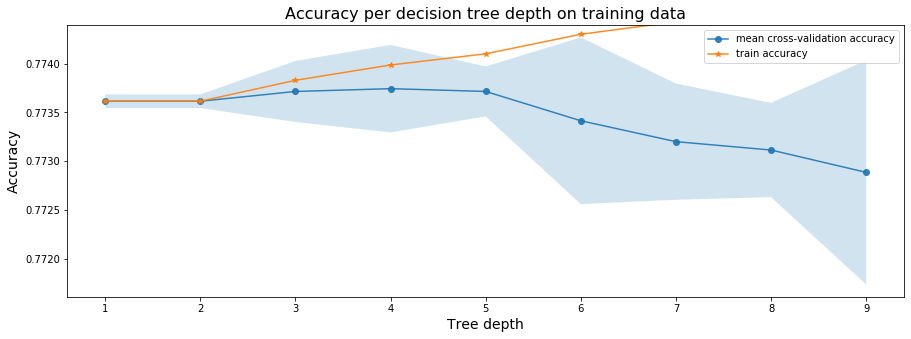

In [84]:
plot_cross_validation_on_trees(sm_tree_depths, sm_cv_scores_mean, sm_cv_scores_std, sm_accuracy_scores, 
                               'Accuracy per decision tree depth on training data')

In [85]:
idx_max = sm_cv_scores_mean.argmax()
sm_best_tree_depth = sm_tree_depths[idx_max]
sm_best_tree_cv_score = sm_cv_scores_mean[idx_max]
sm_best_tree_cv_score_std = sm_cv_scores_std[idx_max]
print('The depth-{} tree achieves the best mean cross-validation accuracy {} +/- {}% on training dataset'.format(
      sm_best_tree_depth, round(sm_best_tree_cv_score*100,5), round(sm_best_tree_cv_score_std*100, 5)))

The depth-4 tree achieves the best mean cross-validation accuracy 77.37429 +/- 0.02241% on training dataset


In [96]:
# il grid search da max depth = 5, mentre il cross validation da max depth = 4
# ma guardando la performance sul test set non cambia nulla

###### Valuto la performance

In [23]:
clf5 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
clf5.fit(X_train,y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [24]:
clf4 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
clf4.fit(X_train,y_train)


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [25]:
y_pred5 = clf5.predict(X_test)
y_pred4 = clf4.predict(X_test)

In [95]:
print(classification_report(y_test, y_pred5))
print(classification_report(y_test, y_pred4))

              precision    recall  f1-score   support

           0       0.57      0.00      0.01      6792
           1       0.77      1.00      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.67      0.50      0.44     30000
weighted avg       0.73      0.77      0.68     30000

              precision    recall  f1-score   support

           0       0.57      0.00      0.01      6792
           1       0.77      1.00      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.67      0.50      0.44     30000
weighted avg       0.73      0.77      0.68     30000



In [97]:
y_score=clf5.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score[:, 1])
roc_auc0 = auc(fpr0, tpr0)

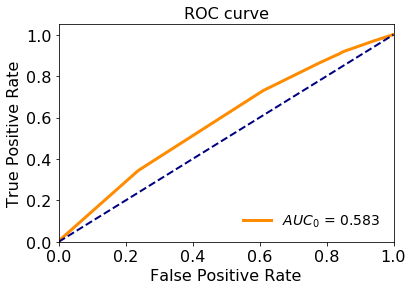

In [98]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


In [99]:
import matplotlib.pyplot as plt
import scikitplot as skplt

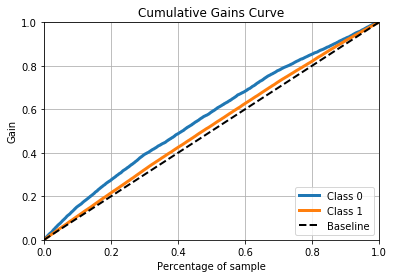

In [100]:
skplt.metrics.plot_cumulative_gain(y_test, y_score)

plt.show()

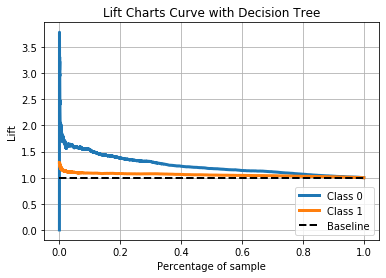

In [101]:
import scikitplot as skplt
predicted_probas_tree=clf5.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test,predicted_probas_tree,title="Lift Charts Curve with Decision Tree")

plt.show()

# RandomForest

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,cross_val_score

In [ ]:
# GridSearch and cross validation 

In [26]:
hyper_params_space={'n_estimators': [50,100,150,200],'max_depth': np.arange(1, 10),'min_samples_split': np.arange(2, 5),'random_state': [0]}
rclf = RandomForestClassifier()
search=GridSearchCV(rclf,hyper_params_space)
search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

In [28]:
rclf = search.best_estimator_
rclf

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [29]:
rclf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
rclf.fit(X_train,y_train)
y_pred_r = rclf.predict(X_test)

In [30]:
scores = cross_val_score(rclf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(rclf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.7739 (+/- 0.00)
F1-score: 0.4379 (+/- 0.00)


In [46]:
# Model (can also use single decision tree)
from sklearn.ensemble import RandomForestClassifier
import pydotplus
from sklearn import tree
from IPython.display import Image
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

# Train
rclf.fit(X_train, y_train)
# Extract single tree
estimator = rclf.estimators_[5]

from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = attributes,
                class_names = True,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'tree.png')

###### Performance del Classificatore

In [31]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_r))
print('F1-score %s' % f1_score(y_test, y_pred_r, average=None))
print(classification_report(y_test, y_pred_r))

Accuracy 0.7737666666666667
F1-score [0.00205852 0.87242241]
              precision    recall  f1-score   support

           0       0.78      0.00      0.00      6792
           1       0.77      1.00      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.78      0.50      0.44     30000
weighted avg       0.77      0.77      0.68     30000



In [48]:
y_score_r=rclf.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score_r[:, 1])
roc_auc0 = auc(fpr0, tpr0)

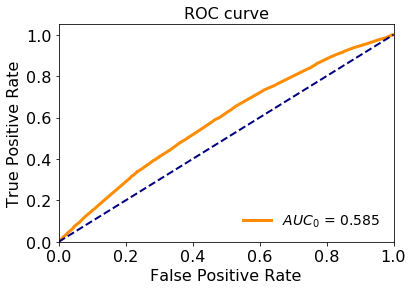

In [49]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [50]:
import matplotlib.pyplot as plt
import scikitplot as skplt

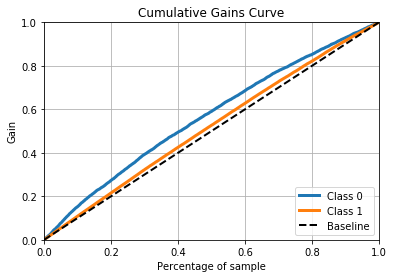

In [51]:
skplt.metrics.plot_cumulative_gain(y_test, y_score_r)

plt.show()

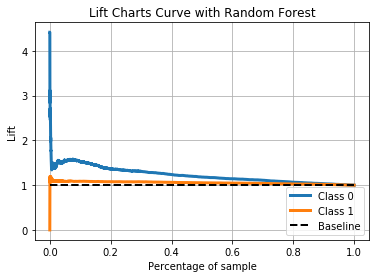

In [52]:
import scikitplot as skplt
predicted_probas_rand=rclf.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test,predicted_probas_rand,title="Lift Charts Curve with Random Forest")

plt.show()

# K-NearestNeighbor

In [53]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
#GridSearch and cross validation

In [54]:
parameters = {'n_neighbors': np.arange(1, 20 + 1), 'weights':['uniform', 'distance']}

knn = KNeighborsClassifier()
search = GridSearchCV(knn, parameters)
search.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None,
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20]),
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [56]:
knn = search.best_estimator_
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')

In [57]:
y_pred_knn = knn.predict(X_test)

In [58]:
scores = cross_val_score(knn, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

scores = cross_val_score(knn, X, y, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.3f)' % (scores.mean(), scores.std()))

Accuracy: 0.7684 (+/- 0.003)
F1-score: 0.4560 (+/- 0.008)


In [ ]:
# Perfomrance k-NN

In [59]:
print('Accuracy %s' % accuracy_score(y_test, y_pred_knn))
print('F1-score %s' % f1_score(y_test, y_pred_knn, average=None))
print(classification_report(y_test, y_pred_knn))

Accuracy 0.7696
F1-score [0.03409726 0.86919991]
              precision    recall  f1-score   support

           0       0.34      0.02      0.03      6792
           1       0.77      0.99      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.56      0.50      0.45     30000
weighted avg       0.68      0.77      0.68     30000



In [60]:
y_score_knn=knn.predict_proba(X_test)
fpr0, tpr0, _ = roc_curve(y_test, y_score_knn[:, 1])
roc_auc0 = auc(fpr0, tpr0)

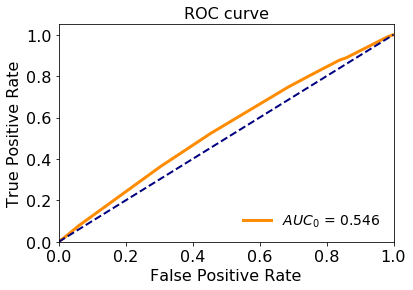

In [61]:
plt.plot(fpr0, tpr0, color='darkorange', lw=3, label='$AUC_0$ = %.3f' % (roc_auc0))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

In [62]:
import matplotlib.pyplot as plt
import scikitplot as skplt

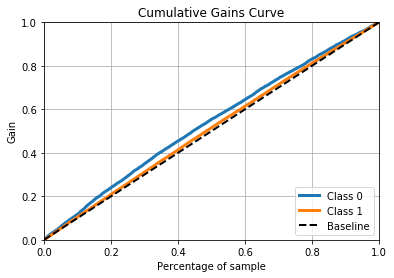

In [63]:
skplt.metrics.plot_cumulative_gain(y_test, y_score_knn)

plt.show()

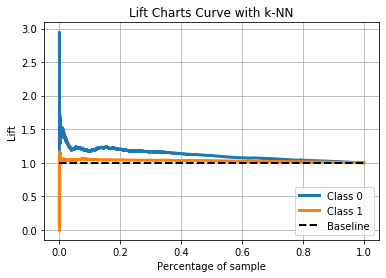

In [64]:
import scikitplot as skplt
predicted_probas_knn=knn.predict_proba(X_test)
skplt.metrics.plot_lift_curve(y_test,predicted_probas_knn,title="Lift Charts Curve with k-NN")

plt.show()

# Methods for unbalanced data

Decision Tree

In [26]:
from sklearn.tree import DecisionTreeClassifier

In [27]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_train,y_train)
y_pred0tree = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree))
print('F1-score %s' % f1_score(y_test, y_pred0tree, average=None))
print(classification_report(y_test, y_pred0tree))

Accuracy 0.7738
F1-score [0.00731422 0.87235723]
              precision    recall  f1-score   support

           0       0.57      0.00      0.01      6792
           1       0.77      1.00      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.67      0.50      0.44     30000
weighted avg       0.73      0.77      0.68     30000



In [28]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
rclf = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=4,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
rclf.fit(X_train,y_train)
y_pred_r = rclf.predict(X_test)
y_pred0rclf = rclf.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0rclf))
print('F1-score %s' % f1_score(y_test, y_pred0rclf, average=None))
print(classification_report(y_test, y_pred0rclf))

Accuracy 0.7737666666666667
F1-score [0.00205852 0.87242241]
              precision    recall  f1-score   support

           0       0.78      0.00      0.00      6792
           1       0.77      1.00      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.78      0.50      0.44     30000
weighted avg       0.77      0.77      0.68     30000



K-NearestNeighbor

In [31]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=17, p=2,
                     weights='uniform')
knn.fit(X_train, y_train)
y_pred0knn = knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0knn))
print('F1-score %s' % f1_score(y_test, y_pred0knn, average=None))
print(classification_report(y_test, y_pred0knn))

Accuracy 0.7696
F1-score [0.03409726 0.86919991]
              precision    recall  f1-score   support

           0       0.34      0.02      0.03      6792
           1       0.77      0.99      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.56      0.50      0.45     30000
weighted avg       0.68      0.77      0.68     30000



In [33]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

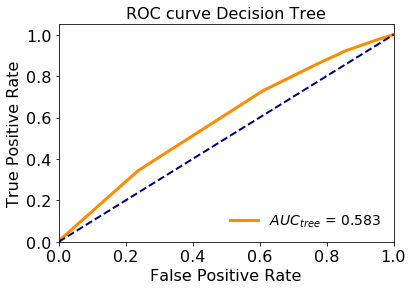

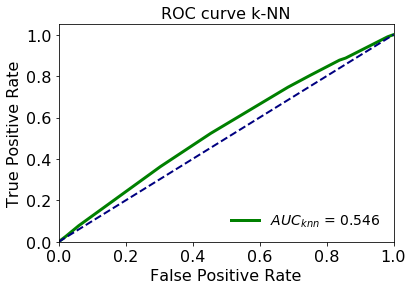

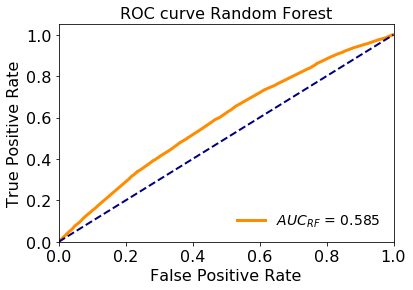

In [37]:
y_scoretree = tree.predict_proba(X_test)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_scoretree[:, 1])
roc_auc_tree = auc(fpr_tree, tpr_tree) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{tree}$ = %.3f' % (roc_auc_tree))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve Decision Tree', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

y_scoreknn = knn.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_scoreknn[:, 1])
roc_auc_knn = auc(fpr_knn, tpr_knn)

plt.plot(fpr_knn, tpr_knn, color='green', lw=3, label='$AUC_{knn}$ = %.3f' % (roc_auc_knn))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve k-NN', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

y_scoreRF = rclf.predict_proba(X_test)
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_scoreRF[:, 1])
roc_auc_RF = auc(fpr_RF, tpr_RF) 

plt.plot(fpr_RF, tpr_RF, color='darkorange', lw=3, label='$AUC_{RF}$ = %.3f' % (roc_auc_RF))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve Random Forest', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()

# Adjusted Decision threshold

Accuracy 0.7733666666666666
F1-score [0.00961398 0.87204291]
              precision    recall  f1-score   support

           0       0.45      0.00      0.01      6792
           1       0.77      1.00      0.87     23208

    accuracy                           0.77     30000
   macro avg       0.61      0.50      0.44     30000
weighted avg       0.70      0.77      0.68     30000



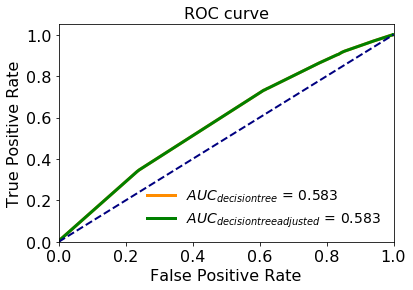

Accuracy 0.6904333333333333
F1-score [0.23770828 0.80578037]
              precision    recall  f1-score   support

           0       0.27      0.21      0.24      6792
           1       0.78      0.83      0.81     23208

    accuracy                           0.69     30000
   macro avg       0.53      0.52      0.52     30000
weighted avg       0.67      0.69      0.68     30000



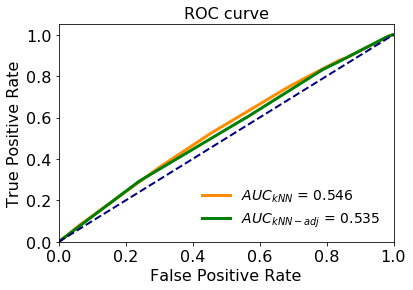

In [52]:
clf1 = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
clf1.fit(X_train, y_train)

y_score1 = clf1.predict_proba(X_test)

def adjusted_predict1(X, thr):
    y_score1 = clf1.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score1])

y_pred1 = adjusted_predict1(X_test, thr=0.6)

print('Accuracy %s' % accuracy_score(y_test, y_pred1))
print('F1-score %s' % f1_score(y_test, y_pred1, average=None))
print(classification_report(y_test, y_pred1))


fpr1, tpr1, thr1 = roc_curve(y_test, y_score1[:, 1])
roc_auc1 = auc(fpr1, tpr1)

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{decision tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr1, tpr1, color='green', lw=3, label='$AUC_{decision tree adjusted}$ = %.3f' % (roc_auc1))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()


clf2 = KNeighborsClassifier(n_neighbors=10, weights='distance')
clf2.fit(X_train, y_train)

y_score2 = clf2.predict_proba(X_test)

def adjusted_predict2(X, thr):
    y_score2 = clf2.predict_proba(X_test)[:, 1]
    return np.array([1 if y > thr else 0 for y in y_score2])

y_pred2 = adjusted_predict2(X_test, thr=0.6)

print('Accuracy %s' % accuracy_score(y_test, y_pred2))
print('F1-score %s' % f1_score(y_test, y_pred2, average=None))
print(classification_report(y_test, y_pred2))


fpr2, tpr2, thr2 = roc_curve(y_test, y_score2[:, 1])
roc_auc2 = auc(fpr2, tpr2)

plt.plot(fpr_knn, tpr_knn, color='darkorange', lw=3, label='$AUC_{kNN}$ = %.3f' % (roc_auc_knn))
plt.plot(fpr2, tpr2, color='green', lw=3, label='$AUC_{kNN-adj}$ = %.3f' % (roc_auc2))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()





 # Class weight

Accuracy 0.7427
F1-score [0.2127486  0.84621974]
              precision    recall  f1-score   support

           0       0.35      0.15      0.21      6792
           1       0.79      0.92      0.85     23208

    accuracy                           0.74     30000
   macro avg       0.57      0.53      0.53     30000
weighted avg       0.69      0.74      0.70     30000



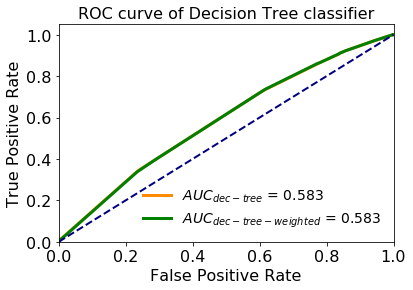

In [59]:
tree=DecisionTreeClassifier(ccp_alpha=0.0, class_weight={0:2, 1: 1}, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
tree.fit(X_train,y_train)
y_pred0tree_weighted = tree.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred0tree_weighted))
print('F1-score %s' % f1_score(y_test, y_pred0tree_weighted, average=None))
print(classification_report(y_test, y_pred0tree_weighted))

y_scoretree_weighted = tree.predict_proba(X_test)
fpr_tree_weighted, tpr_tree_weighted, _ = roc_curve(y_test, y_scoretree_weighted[:, 1])
roc_auc_tree_weighted = auc(fpr_tree_weighted, tpr_tree_weighted) 

plt.plot(fpr_tree, tpr_tree, color='darkorange', lw=3, label='$AUC_{dec-tree}$ = %.3f' % (roc_auc_tree))
plt.plot(fpr_tree_weighted, tpr_tree_weighted, color='green', lw=3, label='$AUC_{dec-tree-weighted}$ = %.3f' % (roc_auc_tree_weighted))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('ROC curve of Decision Tree classifier', fontsize=16)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show()